### Import the various Libraries as required.
#### You have to have Java Installed and   spark, set up the Java_Home Path and Spark Path
##### For any Library that is missing you could install via the google colabs by the following command.

! pip install <libraryname>

In [83]:
import os
os.environ["JAVA_HOME"] ="/usr/lib/jvm/java-11-openjdk-amd64" #Java home path
os.environ["SPARK_HOME"] = "/usr/local/spark" #Spark Homne Path
import findspark
findspark.init()
from pyspark.sql import SparkSession, Window 
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import isnan, when, count, col, lit, trim, avg, ceil
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

##### List file directory

In [84]:
!ls

'Cleaning and Exploring Data in Pyspark.ipynb'	 Datasets


#### Creating a variable for the spoarksession that you wil use accross

In [86]:
sc= SparkSession.builder.master("local[*]").getOrCreate()

##### Reading our csv files via the  sparkSession

In [89]:
feature = sc.read.csv("./Datasets/features.csv",inferSchema=True, header=True)
label = sc.read.csv("./Datasets/labels.csv", inferSchema=True, header=True)
print(feature.count())
print(label.count())

59400
59400


In [90]:
print("This are the features in a column")
print(feature.columns)
print("Here are the Labels Columns")
print(label.columns)

This are the features in a column
['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']
Here are the Labels Columns
['id', 'status_group']


##### As seen the above  both of the columns have a common column that is the ID that is present in both csv files.
##### Hence we use feature.join to join the both files on id column being same.

In [91]:
data = feature.join(label, on=("id"))
print(data.count())
print(data.columns)

59400
['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


#### Changing the Column Data Types and remove the Null Values

In [92]:
print(data.printSchema())

root
 |-- id: integer (nullable = true)
 |-- amount_tsh: double (nullable = true)
 |-- date_recorded: string (nullable = true)
 |-- funder: string (nullable = true)
 |-- gps_height: integer (nullable = true)
 |-- installer: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- wpt_name: string (nullable = true)
 |-- num_private: integer (nullable = true)
 |-- basin: string (nullable = true)
 |-- subvillage: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_code: integer (nullable = true)
 |-- district_code: integer (nullable = true)
 |-- lga: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- public_meeting: boolean (nullable = true)
 |-- recorded_by: string (nullable = true)
 |-- scheme_management: string (nullable = true)
 |-- scheme_name: string (nullable = true)
 |-- permit: boolean (nullable = true)
 |-- construction_year: integer (nullable = 

In [93]:
data.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
id,59400,37115.131767676765,21453.128371317754,0,74247
amount_tsh,59400,317.6503846801347,2997.5745581421675,0.0,350000.0
date_recorded,59400,None,None,2002-10-14,2013-12-03
funder,55765,0.0,0.0,0,Zingibali Secondary
gps_height,59400,668.297239057239,693.1163503250501,-90,2770
installer,55745,0.0,0.0,-,world vision
longitude,59400,34.077426692028816,6.5674318456465315,0.0,40.34519307
latitude,59400,-5.706032659626444,2.9460190812672487,-11.64944018,-2.0E-8
wpt_name,59400,24.0,None,24,none


In [99]:
print(data.show(10))

+-----+----------+-------------+-------------------+----------+------------+-----------+------------+--------------------+-----------+--------------------+---------------+---------+-----------+-------------+---------------+----------+----------+--------------+--------------------+-----------------+--------------------+------+-----------------+---------------+---------------------+---------------------+----------+----------------+--------------+------------+-------------+-------------+------------+--------------+--------------------+--------------------+------------+--------------------+---------------------+--------------+
|   id|amount_tsh|date_recorded|             funder|gps_height|   installer|  longitude|    latitude|            wpt_name|num_private|               basin|     subvillage|   region|region_code|district_code|            lga|      ward|population|public_meeting|         recorded_by|scheme_management|         scheme_name|permit|construction_year|extraction_type|extracti

In [100]:
data = data.withColumn('region_code', col('region_code').cast(StringType())) .withColumn('district_code',col('district_code').cast(StringType()))

In [101]:
data = data.dropDuplicates(["id"])
data.count()

59400

In [102]:
str_cols = [item[0] for item in data.dtypes if item[1].startswith('string')]
for cols in str_cols:
    data = data.withColumn(cols, trim(data[cols]))

### Remove columns with null values more than a threshold.

In [103]:
agg_row = data.select([(count(when(isnan(c) | col(c).isNull(), c))/data.count()).alias(c) for c in data.columns if c not in {'date_recorded', 'public_meeting', 'permit'}]).collect()

In [104]:
print(agg_row)

[Row(id=0.0, amount_tsh=0.0, funder=0.0611952861952862, gps_height=0.0, installer=0.061531986531986535, longitude=0.0, latitude=0.0, wpt_name=0.0, num_private=0.0, basin=0.0, subvillage=0.0062457912457912455, region=0.0, region_code=0.0, district_code=0.0, lga=0.0, ward=0.0, population=0.0, recorded_by=0.0, scheme_management=0.06526936026936027, scheme_name=0.4741750841750842, construction_year=0.0, extraction_type=0.0, extraction_type_group=0.0, extraction_type_class=0.0, management=0.0, management_group=0.0, payment=0.0, payment_type=0.0, water_quality=0.0, quality_group=0.0, quantity=0.0, quantity_group=0.0, source=0.0, source_type=0.0, source_class=0.0, waterpoint_type=0.0, waterpoint_type_group=0.0, status_group=0.0)]


In [105]:
agg_dict_list = [row.asDict() for row in agg_row]
agg_dict = agg_dict_list[0]


In [106]:
col_null = list({i for i in agg_dict if agg_dict[i] > 0.4})
print(agg_dict)
print(col_null)
data = data.drop(*col_null)

{'id': 0.0, 'amount_tsh': 0.0, 'funder': 0.0611952861952862, 'gps_height': 0.0, 'installer': 0.061531986531986535, 'longitude': 0.0, 'latitude': 0.0, 'wpt_name': 0.0, 'num_private': 0.0, 'basin': 0.0, 'subvillage': 0.0062457912457912455, 'region': 0.0, 'region_code': 0.0, 'district_code': 0.0, 'lga': 0.0, 'ward': 0.0, 'population': 0.0, 'recorded_by': 0.0, 'scheme_management': 0.06526936026936027, 'scheme_name': 0.4741750841750842, 'construction_year': 0.0, 'extraction_type': 0.0, 'extraction_type_group': 0.0, 'extraction_type_class': 0.0, 'management': 0.0, 'management_group': 0.0, 'payment': 0.0, 'payment_type': 0.0, 'water_quality': 0.0, 'quality_group': 0.0, 'quantity': 0.0, 'quantity_group': 0.0, 'source': 0.0, 'source_type': 0.0, 'source_class': 0.0, 'waterpoint_type': 0.0, 'waterpoint_type_group': 0.0, 'status_group': 0.0}
['scheme_name']


## Group aggregate create pivot tables

In [107]:
data.groupBy('recorded_by').count().show() #Showing Count after grouping by the recorded_by

+--------------------+-----+
|         recorded_by|count|
+--------------------+-----+
|GeoData Consultan...|59400|
+--------------------+-----+



In [108]:
data.groupBy('water_quality').count().orderBy('count', ascending=False).show() #Showing Count on grouping by water_quality

+------------------+-----+
|     water_quality|count|
+------------------+-----+
|              soft|50818|
|             salty| 4856|
|           unknown| 1876|
|             milky|  804|
|          coloured|  490|
|   salty abandoned|  339|
|          fluoride|  200|
|fluoride abandoned|   17|
+------------------+-----+



In [54]:
data = data.drop('recorded_by')

In [55]:
data.groupBy('status_group').pivot('region').sum('amount_tsh').show()

+--------------------+---------+-------------+------+---------+------+--------+------------------+-------+--------+--------+-----+--------+-------+-------+---------+--------+---------+---------+--------+------+--------+
|        status_group|   Arusha|Dar es Salaam|Dodoma|   Iringa|Kagera|  Kigoma|       Kilimanjaro|  Lindi| Manyara|    Mara|Mbeya|Morogoro| Mtwara| Mwanza|    Pwani|   Rukwa|   Ruvuma|Shinyanga| Singida|Tabora|   Tanga|
+--------------------+---------+-------------+------+---------+------+--------+------------------+-------+--------+--------+-----+--------+-------+-------+---------+--------+---------+---------+--------+------+--------+
|functional needs ...|  10280.0|          0.0|   0.0| 118400.0|   0.0|270770.0|          129248.0| 3625.0| 71315.0|   900.0|  0.0| 70005.0|36240.0|10000.0|    520.0|292980.0| 125650.0|   2200.0|  6505.0|   0.0|  4310.0|
|          functional|1125485.0|     181175.0|   0.0|5515710.0|   0.0|530725.0|         746942.25|24560.0|312745.0| 9678

#Converting categories with low frequency , Impute the missing values


In [56]:
print(str_cols)

['date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'recorded_by', 'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


In [59]:
for column in str_cols:
    print(data.groupBy(column).count().orderBy('count', ascending=False).show())
    values_cat = data.groupBy(column).count().collect()
    lessthan = [x[0] for x in values_cat if x[1] < 1000]
    data = data.withColumn(column, when(col(column).isin(lessthan), 'Others').otherwise(col(column)))
    data.groupBy(column).count().orderBy('count', ascending=False).show()

+-------------+-----+
|date_recorded|count|
+-------------+-----+
|       Others|59400|
+-------------+-----+

None
+-------------+-----+
|date_recorded|count|
+-------------+-----+
|       Others|59400|
+-------------+-----+

+--------------------+-----+
|              funder|count|
+--------------------+-----+
|              Others|35052|
|Government Of Tan...| 9084|
|                null| 3635|
|              Danida| 3114|
|              Hesawa| 2202|
|               Rwssp| 1374|
|          World Bank| 1349|
|                Kkkt| 1287|
|        World Vision| 1246|
|              Unicef| 1057|
+--------------------+-----+

None
+--------------------+-----+
|              funder|count|
+--------------------+-----+
|              Others|35052|
|Government Of Tan...| 9084|
|                null| 3635|
|              Danida| 3114|
|              Hesawa| 2202|
|               Rwssp| 1374|
|          World Bank| 1349|
|                Kkkt| 1287|
|        World Vision| 1246|
|            

AnalysisException: cannot resolve '`recorded_by`' given input columns: [amount_tsh, basin, construction_year, date_recorded, district_code, extraction_type, extraction_type_class, extraction_type_group, funder, gps_height, id, installer, latitude, lga, longitude, management, management_group, num_private, payment, payment_type, permit, population, public_meeting, quality_group, quantity, quantity_group, region, region_code, scheme_management, source, source_class, source_type, status_group, subvillage, ward, water_quality, waterpoint_type, waterpoint_type_group, wpt_name];
'Aggregate ['recorded_by], ['recorded_by, count(1) AS count#56898L]
+- Project [id#16, amount_tsh#17, date_recorded#52137, funder#52591, gps_height#20, installer#53045, longitude#22, latitude#23, wpt_name#53499, num_private#25, basin#53953, subvillage#54407, region#54861, region_code#55315, district_code#55769, lga#56223, CASE WHEN ward#51783 IN () THEN Others ELSE ward#51783 END AS ward#56677, population#33, public_meeting#34, scheme_management#1180, permit#38, construction_year#39, extraction_type#1264, extraction_type_group#1306, ... 15 more fields]
   +- Project [id#16, amount_tsh#17, date_recorded#52137, funder#52591, gps_height#20, installer#53045, longitude#22, latitude#23, wpt_name#53499, num_private#25, basin#53953, subvillage#54407, region#54861, region_code#55315, district_code#55769, CASE WHEN lga#51470 IN () THEN Others ELSE lga#51470 END AS lga#56223, ward#51783, population#33, public_meeting#34, scheme_management#1180, permit#38, construction_year#39, extraction_type#1264, extraction_type_group#1306, ... 15 more fields]
      +- Project [id#16, amount_tsh#17, date_recorded#52137, funder#52591, gps_height#20, installer#53045, longitude#22, latitude#23, wpt_name#53499, num_private#25, basin#53953, subvillage#54407, region#54861, region_code#55315, CASE WHEN district_code#51157 IN () THEN Others ELSE district_code#51157 END AS district_code#55769, lga#51470, ward#51783, population#33, public_meeting#34, scheme_management#1180, permit#38, construction_year#39, extraction_type#1264, extraction_type_group#1306, ... 15 more fields]
         +- Project [id#16, amount_tsh#17, date_recorded#52137, funder#52591, gps_height#20, installer#53045, longitude#22, latitude#23, wpt_name#53499, num_private#25, basin#53953, subvillage#54407, region#54861, CASE WHEN region_code#50844 IN () THEN Others ELSE region_code#50844 END AS region_code#55315, district_code#51157, lga#51470, ward#51783, population#33, public_meeting#34, scheme_management#1180, permit#38, construction_year#39, extraction_type#1264, extraction_type_group#1306, ... 15 more fields]
            +- Project [id#16, amount_tsh#17, date_recorded#52137, funder#52591, gps_height#20, installer#53045, longitude#22, latitude#23, wpt_name#53499, num_private#25, basin#53953, subvillage#54407, CASE WHEN region#50531 IN (Others) THEN Others ELSE region#50531 END AS region#54861, region_code#50844, district_code#51157, lga#51470, ward#51783, population#33, public_meeting#34, scheme_management#1180, permit#38, construction_year#39, extraction_type#1264, extraction_type_group#1306, ... 15 more fields]
               +- Project [id#16, amount_tsh#17, date_recorded#52137, funder#52591, gps_height#20, installer#53045, longitude#22, latitude#23, wpt_name#53499, num_private#25, basin#53953, CASE WHEN cast(subvillage#50218 as string) IN (cast(null as string)) THEN Others ELSE subvillage#50218 END AS subvillage#54407, region#50531, region_code#50844, district_code#51157, lga#51470, ward#51783, population#33, public_meeting#34, scheme_management#1180, permit#38, construction_year#39, extraction_type#1264, extraction_type_group#1306, ... 15 more fields]
                  +- Project [id#16, amount_tsh#17, date_recorded#52137, funder#52591, gps_height#20, installer#53045, longitude#22, latitude#23, wpt_name#53499, num_private#25, CASE WHEN basin#49905 IN () THEN Others ELSE basin#49905 END AS basin#53953, subvillage#50218, region#50531, region_code#50844, district_code#51157, lga#51470, ward#51783, population#33, public_meeting#34, scheme_management#1180, permit#38, construction_year#39, extraction_type#1264, extraction_type_group#1306, ... 15 more fields]
                     +- Project [id#16, amount_tsh#17, date_recorded#52137, funder#52591, gps_height#20, installer#53045, longitude#22, latitude#23, CASE WHEN wpt_name#49592 IN () THEN Others ELSE wpt_name#49592 END AS wpt_name#53499, num_private#25, basin#49905, subvillage#50218, region#50531, region_code#50844, district_code#51157, lga#51470, ward#51783, population#33, public_meeting#34, scheme_management#1180, permit#38, construction_year#39, extraction_type#1264, extraction_type_group#1306, ... 15 more fields]
                        +- Project [id#16, amount_tsh#17, date_recorded#52137, funder#52591, gps_height#20, CASE WHEN installer#49279 IN () THEN Others ELSE installer#49279 END AS installer#53045, longitude#22, latitude#23, wpt_name#49592, num_private#25, basin#49905, subvillage#50218, region#50531, region_code#50844, district_code#51157, lga#51470, ward#51783, population#33, public_meeting#34, scheme_management#1180, permit#38, construction_year#39, extraction_type#1264, extraction_type_group#1306, ... 15 more fields]
                           +- Project [id#16, amount_tsh#17, date_recorded#52137, CASE WHEN funder#48966 IN () THEN Others ELSE funder#48966 END AS funder#52591, gps_height#20, installer#49279, longitude#22, latitude#23, wpt_name#49592, num_private#25, basin#49905, subvillage#50218, region#50531, region_code#50844, district_code#51157, lga#51470, ward#51783, population#33, public_meeting#34, scheme_management#1180, permit#38, construction_year#39, extraction_type#1264, extraction_type_group#1306, ... 15 more fields]
                              +- Project [id#16, amount_tsh#17, CASE WHEN date_recorded#48653 IN () THEN Others ELSE date_recorded#48653 END AS date_recorded#52137, funder#48966, gps_height#20, installer#49279, longitude#22, latitude#23, wpt_name#49592, num_private#25, basin#49905, subvillage#50218, region#50531, region_code#50844, district_code#51157, lga#51470, ward#51783, population#33, public_meeting#34, scheme_management#1180, permit#38, construction_year#39, extraction_type#1264, extraction_type_group#1306, ... 15 more fields]
                                 +- Project [id#16, amount_tsh#17, date_recorded#48653, funder#48966, gps_height#20, installer#49279, longitude#22, latitude#23, wpt_name#49592, num_private#25, basin#49905, subvillage#50218, region#50531, region_code#50844, district_code#51157, lga#51470, CASE WHEN ward#1096 IN (Kibingo,Shinghatini,Luchili,Ukune,Chiponda,Lusahunga,Kitura,Soni,Nyanguge,Mlowo,Lilambo,Kongolo,Masumbwe,Mngazi,Makata,Muhukuru,Saunyi,Manyoni,Tumbi,Segala,Igalula,Nkololo,Ovada,Moivo,Segera,Bashinet,Mhande,Nalasi,Murusagamba,Ubiri,Kalunde,Luswisi,Makurugusi,Sumbugu,Gendabi,Mtekente,Umwe,Ufana,Selela,Mtombozi,Lalago,Ludende,Ruhunga,Irole,Nkoanrua,Nanhyanga,Kate,Ifumbo,Itaba,Litembo,Mpondo,Ibumi,Kazunzu,Chilangala,Ilujamate,Chinugulu,Mandawa,Maramba,Ihowanza,Boma la ng'ombe,Nyamilama,Nandembo,Nakapanya,Kipanga,Mamba Kaskazini,Isagenhe,Msalato,Iringa Mvumi,Kachwamba,Lunguya,Badi,Msangano,Kihorogota,Misezero,Bukene,Vigwaza,Sokon I,Vikumbulu,Mnyawa,Kihonda,Turwa,Chawi,Dung'unyi,Ipelele,Kanindo,Sokoni II,Ibwera,Kamuli,Masaba,Gwandi,Bukindo,Magindu,Hombolo,Muhange,Kukirango,Kingale,Chela,Gungu,Mbekenyera,Unyambwa,Sima,Negero,Gua,Kebanchabancha,Mabamba,Isingiro,Kidatu,Lwamgasa,Mbogwe,Haneti,Ulanda,Msanja,Mpiruka,Balangidalalu,Tambuka Reli,Mwanga Kaskazini,Mazae,Chalinze,Arusha Chini,Muganza,Panzuo,Mbamba bay,Mhezi,Kadoto,Miono,Kisarawe,Maneromango,Mlandizi,Bukanda,Ligoma,Pandagichiza,Tambani,Gelai Meirugoi,Sunuka,Ndogosi,Nduguti,Bukwe,Itilima,Mbweni,Idodyandole,Ipuli,Kizumbi,Buterankuzi,Mbede,Ushirika,Diongoya,Muungano,Kwakoa,Luilo,Kafule,Gidas,Kihanga,Chambo,Itunduru,Kyang'ombe,Munyegera,Kabungu,Kasanga,Nyambono,Udekwa,Kasuga,Kipara Mnero,Tongi,Shilalo,Kimandolu,Keni  Alleni,Lugarawa,Nyakasasa,Selambala,Kimuli,Kisaka,Uru Kusini Mawela,Ilungu,Chamazi,Haubi,Masukulu,Mpunze,Nyamalimbe,Bureza,Naipingo,Maskati,Kitulo,Mlowa,Maputi,Kinyeto,Lugata,Katuma,Magu Urban,Mpambala,Manda,Funta,Mtipwili,Matwiga,Kishapu,Mbebe,Chiwanda,Mtua,Ikungulyabashashi,Mwaseni,Kashishi,Mgori,Namtuhuka,Usinge,Membe,Lihimalyo,Makuro,Kicheba,Ikondo,Iragua,Kalangalala,Kyengege,Lusanga,Kiboriloni,Njinjo,Msambara,Mkululu,Gisambalang,Igosi,Usule,Pangani Mashariki,Chibelela,Uchunga,Somanda,Ughandi,Mtamaa,Railway,Iponya,Chemba,Ushetu,Mdandu,Matimira,Nyamtukuza,Ilangala,Butuguri,Kingolwira,Sanzawa,Mchemo,Merya,Nyambiti,Matema,Zinga/Ikerege,Hungumalwa,Talaga,Dalai,Sazira,Itiso,Kilimatinde,Berege,Nyarero,Namichinga,Mkindi,Bunambiu,Ihango,Bungu,Mahanje,Visiga,Mbuga,Chita,Itonjanda,Iyula,Igombavanu,Karanga,Songa,Myunga,Bwisya,Daudi,Mbezi,Liwale A,Makanjiro,Kilema kaskazini,Bukundi,Vikindu,Muzye,Sudi,Mashewa,Lemasule,Kasanda,Igombe Mkulu,Magara,Karenge,Iyogwe,Nambambo,Oltrumet,Sumve,Chibe,Chala,Mwika Kaskazini,Kisangasa,Kimagai,Ilonga,Iyogela,Ngombezi,Nkinga,Ikongolo,Mkotokuyana,Kibirizi,Kwaluguru,Vumilia,Mkwiti,Ruaruke,Nghambaku,Kasololo,Bumera,Mwamalole,Songambele,Malya,Ndembezi,Kanyenye,Mtanda,Matamba,Mambwekenya,Sepuko,Sali,Kisongo,Kelamfua Mokala,Ntuntu,Ludewa,Gera,Bukumi,Bukabwa,Munzenze,Euga,Shungubweni,Titye,Vugiri,Kintinku,Nkwenda,Ziwani,Busi,Muhuwesi,Mpindo,Kimanzichana,Ngorongo,Mikangaula,Mgwashi,Mzinga,Ikungu,Nanjara Reha,Kidegembye,Mchoteka,Nkomang'ombe,Vigoi,Ishozi,Zombo,Kenyamonta,Singisi,USA River,Mpigamiti,Luagala,Buseresere,Murungu,Ubenazamozi,Manwanga,Mirui,Likombe,Mererani,Kolandoto,Msamalo,Ikowa,Masama Rundugai,King'ori,Mwaubingi,Marumbo,Oldeani,Mlimani,Kibondo Urban,Inyonga,Nkoaranga,Kabanga,Ntendo,Chimala,Bumilayinga,Mnero Ngongo,Kinaga,Rusumo,Uyowa,Kanazi,Kisarawe II,Ikama,Narungombe,Lukumbule,Kasokola,Ngwala,Uchindile,Mbugani,Matogoro,Handali,Keza,Misozwe,Chienjere,Bwera,Ilela,Mwembesongo,Hunyari,Malampaka,Serengeti National Park,Nyakahura,Isanga,Milingoti Mashariki,Masaki,Mninga,Msowero,Kilago,Kinyerezi,Rudewa,Ilembula,Ilolo Mpya,Mzenga,Matiri,Mchukwi,Lusewa,Ngoma,Urambo,Ng'apa,Gare,Ushokola,Mtindiro,Salama,Kihurio,Chemchem,Vunta,Wino,Rubale,Muze,Masama Mashariki,Igalukilo,Masagalu,Nyehunge,Usagali,Matomondo,Sindeni,Kamachumu,Shabaka,Mwakanshashala,Kwediboma,Mpunguzi,Mkundi,Mamsera,Kitangari,Matekwe,Nyakalilo,Kining'inila,Kagoma,Bwasi,Fufu,Kagondo,Tunduma,Sapiwi,Kigongo,Ugogoni,Mang'ola,Ivuna,Mugumu Urban,Mnekachi,Potwe,Dabaga,Kiwira,Kisondela,Nzega Urban,Nyamimange,Jangwani,Kalenge,Itete,Mtanana,Kalinzi,Izimbya,Mkoma,Mgambo,Samuye,Kaselya,Ndala,Tembela,Magila,Kahangara,Nyamrandirira,Mandarawe,Machame Kaskazini,Ngongwa,Bukombe,Ipililo,Sanu,Kalenga,Kishanda,Rubafu,Shambarai,Kilema Kusini,Ubaruku,Njombe Urban,Sikonge,Mitole,Ngulu,Uhambingeto,Igandu,Mpalanga,Dosidosi,Kahororo,Nyakasungwa,Lupata,Musa,Pasiansi,Karema,Mbulu Urban,Nsemulwa,Daluni,Chakwale,Ketumbeine,Mahida Holili,Nhundulu,Arri,Mwangoi,Rusimbi,Chitekete,Rugenge,Kassambya,Laela,Pinyinyi,Mwabomba,Nkome,Tinde,Chanika,Engarenaibor,Vuje,Mwamanga,Nyamhula,Kajunjumele,Nkangamo,Lipumburu,Mshangano,Mawenzi,Daraja Mbili,Korongoni,Kibamba,Shimbi,Msanga,Sintali,Ngima,Lugoba,Masuguru,Bulige,Duga,Doma,Mingumbi,Image,Minepa,Sanje,Chipanga,Katazi,Mkunya,Usisya,Bwagamoyo,Ukwega,Engutoto,Mahege,Busangi,Ifunda,Mombo,Namilembe,Mtanila,Kasense,Nyamwaga,Langiro,Kiyowela,Linda,Mkambalani,Okoani Kibosho,Mtitaa,Bitale,Izigo,Nambilanje,Isuto,Tambukareli,Mudida,Mwanga,Chihanga,Busole,Ilima,Bashay,Kibimba,Misughaa,Maratani,Lemara,Mwanjoro,Katandala,Pandambili,Kaisho,Kirima,Chigunga,Koryo,Mkomazi,Mwantini,Makambako,Maghang,Mwembe,Kidugalo,Urughu,Wotta,Mahurunga,Namagondo,Ulowa,Nyathorogo,Mugoma,Hidet,Buhoro,Ndevelwa,Ngangamara,Mpendo,Mnyambe,Nduli,Murieti,Masanze,Kirongwe,Ubetu Kahe,Itandula,Bwakila Chini,Usagara,Jipe,Nzihi,Kibaoni,Kalebezo,Lupiro,Kasela,Olele,Ilindi,Kitunda,Kilimani,Mbangamao,Mtiniko,Kishanje,Didia,Ikola,Makang'wa,Kasamwa,Ndumbwe,Mnyamba,Mtimbwani,Namapwia,Kikatiti,Sitalike,Milola,Idahina,Legezamwendo,Goweko,Nzuguni,Ipande,Ijumbi,Rwabere,Likokona,Bigwa,Matongo,Bunamhala,Urwira,Muleba,Sandulula,Wela,Makutopora,Nondwa,Olkokola,Magagura,Utiri,Sasajila,Kitongoni,Nyamoko,Usuka,Mkata,Bulungwa,Machochwe,Kisemu,Kihangimahuka,Maundo,Langali,Maguu,Kapele,Changaa,Nangano,Kaliua,Matai,Lengatei,Msambiazi,Mwananyili,Bupu,Rutamba,Mbuguni,Rungemba,Nzega ndogo,Kiwere,Mpindimbi,Ibugule,Ruanda,Mabira,Kidodi,Busilili,Magomeni,Masqaroda,Mseke,Madanga,Chome,Mhonda,Mngonya,Isange,Naputa,Msogezi,Kiromo,Simbo,Sepeko,Kwamtoro,Kasingirima,Mwakilyambiti,Chiola,Rusaba,Dabil,Nkoma,Dindira,Haidom,Soit Sambu,Iwindi,Kibakwe,Sale,Huzi,Kurui,Bwakila Juu,Gelai Lumbwa,Sombetini,Katunguru,Zanka,Ruhembe,Michenjele,Myangayanga,Nangaru,Manchira,Kiranjeranje,Katende,Majeleko,Kigunga,Nyimbili,Miangalua,Ndolwa,Ngomeni,Kabwe,Ntwike,Mwadui Lohumbo,Namasakata,Riroda,Mubunda,Mwamalasa,Kikole,Levolosi,Naiyobi,Loibor Soit,Mtumba,Igusule,Msanzi,Ipera,Monduli Juu,Malatu,Mogwa,Ilongero,Lyenje,Nyangao,Matui,Miteja,Wala,Iguguno,Masama Kusini,Miguwa,Bugomora,Mang'onyi,Kirando,Kwamsisi,Mkumbi,Mishamo,Ishunju,Kongwa Urban,Nyengedi,Mwabuzo,Kikubiji,Itundu,Mhinduro,Vinghawe,Mlalo,Luduga,Kabasa,Hogoro,Chiwezi,Mazingara,Mkwajuni,Msindo,Katoma,Lumemo,Ngonga,Mbabala,Itetemia,Kazaroho,Kimamba A,Arash,Mkoreha,Kurua Vunjo Mashariki,Busanda,Mkamba,Ngana,Kindi,Ugunga,Dongobesh,Minyughe,Lubanga,Muhinda,Kimbiji,Munga'a,Mpepai,Kanyangereko,Natta,Mogitu,Suji,Malindi,Lusu,Siuyu,Dutwa,Mwese,Sadani,Roche,Nangowe,Isagehe,Mukituntu,Nkinto,Puma,Mnenia,Masela,Nanyamba,Ngara Urban,Buswahili,Ussoke,Dunda,Kibaya,Kasimbu,Kilolambwani,Mkonze,Mabawe,Matemanga,Kikombo,Luhundwa,Mkwaja,Nyambureti,Buzilasoga,Badugu,Mitengo,Suma,Bahi,Sukuma,Tingatinga,Kinyagiri,Nyoni,Ngwelo,Wariku,Bugene,Ngulinguli,Busongo,Magulilwa,Ipala,Nsunga,Mwamabanza,Nyarokoba,Minziro,Ushirombo,Ufukoni,Ilkiding'a,Kahamanhalaga,Kiruruma,Kansay,Nakatuguru,Kisiju,Ilembo,Mwangoye,Mbaya,Moita,Mabokweni,Mbulumbulu,Nyabusozi,Mavanga,Mtoa,Nyamirembe,Msata,Siha Mashariki,Maligisu,Kisuke,Nyamato,Siha Kaskazini,Rubuga,Ruiwa,Machimboni,Olbolot,Bangata,Madilu,Chanzuru,Mvumi Makulu,Liwale B,Mwabusalu,Dabalo,Tumati,Chaume,Kitomondo,Tarekea Motamburu,Partimbo,Kilema  Kati,Longuo,Kilulu,Mganza,Kasiriri,Bugoro,Kamsamba,Chikonji,Katoro,Matanga,Kapalala,Suguti,Kitomanga,Kiangara,Magengati,Tungamaa,Bunda,Vigaeni,Mkinga,Nyabubinza,Mvungwe,Mambali,Karatu,Lizaboni,Kichangani,Ngimu,Ruhuwiko,Lubugo,Lionja,Mwera,Mwadobana,Isandula,Ngofila,Kitobo,Kyamuraile,Nandete,Ibadakuli,Bassodesh,Kwadelo,Nampungu,Kisaki,Makuru,Unga Ltd,Bukura,Mcholi II,Bunju,Mnolela,Loya,Chandama,Mahuninga,Berega,Chalangwa,Maruku,Vijibweni,Ichwankima,Mpotwa,Mkonjowano,Matare,Pangani Magharibi,Nyaluhande,Pasua,Machame Magharibi,Kirwa Keni,Malenga Makali,Kinole,Wampelembe,Milepa,Budushi,Goribe,Maposeni,Wanging'ombe,Ruvuma,Lugulu,Kisanga,Ikhawoda,Vuga,Igowole,Kivinje Singino,Talawanda,Koromije,Kashaulili,Songosongo,Kagongo,Kakora,Mwabuma,Mikalanga,Magole,Kisegese,Kanga,Kisangura,Imesela,Mwena,Nangwa,Lingeka,Kiomboi,Motamburu Kitendani,Nyakonga,Mwangaza,Lutende,Murangi,Machinjioni,Kisumwa,Muyama,Kibeta,Kwamndolwa,Mhongolo,Mpapa,Ruaha,Katumba,Busagara,Kituntu,Kizengi,Tabaruka,Nyamtinga,Elerai,Kalemela,Kirangare,Kwamatuku,Igigwa,Bonga,Kifula,Kahama Urban,Mbwewe,Kikunde,Nyamatongo,Isaka,Mnyuzi,Ngorika,Kimbe,Mlangarini,Mbuyuni,Rulenge,Gumanga,Magubike,Rung'bure,Magamba,Isongo,Namikupa,Bukondo,Nyanungu,Zongomera,Janda,Kiwangwa,Kipatimu,Mapogoro,Mwazye,Pande,Nyakato,Manchali,Buhingo,Mlola,Ring'wani,Chipuputa,Mvumi Mission,Magoroto,Ijombe,Sagara,Mwamgongo,Kabita,Mtinko,Magawa,Pugu,Naintiri,Kakunyu,Heka Azimio,Busawe,Ruponda,Kizara,Pito,Mji Mpya,Bondeni,Rasbura,Ng'haya,Nyalikungu,Kagu,Gamboshi,Kiloleni,Rugu,Bukima,Soera,Mtowisa,Kolo,Nyasato,Imalamakoye,Luana,Shagihilu,Usangule,Iwawa,Maroroni,Mabama,Mwakipoya,Kasungamile,Ngaya,Karambi,Kikore,Manyondwe,Mchesi,Katumbasongwe,Lalta,Ihanja,Nkoarisambu,Tandahimba,Kileo,Marambo,Bweranyange,Madimba,Shangani,Kirongo,Kibosho Magharibi,Kirya,Uyumbu,Rusesa,Irisya,Uduka,Lugunga,Lukanga,Njoge,Makonona,Oldonyosambu,Rujewa,Izazi,Mbita,Ulenje,Mbesa,Masoko,Mawengi,Buyango,Kakesio,Chikola,Mzumbe,Biro,Manga,Isalavanu,Kibuta,Misalai,Likawage,Somangira,Kwafungo,Bwembera,Mzizima,Kamhanga,Ikindwa,Mbaramo,Chirombola,Ngoheranga,Kifanya,Napacho,Kisawasawa,Issenye,Ikuti,Vudee,Ugala,Mtibwa,Masama Magharibi,Imalinyi,Sopa,Malibwi,Kinang'weli,Kilosa,Kasharunga,Ruangwa,Mbwara,Lundi,Madunga,Busisi,Gidahababieg,Chabutwa,Nyanga,Makuyuni,Kimamba B,Farkwa,Mamba Kusini,Njengwa,Lyabukande,Nishambya,Halungu,Kanyigo,Kirushya,Katwe,Uru Shimbwe,Buganguzi,Ilula,Mabwerebwere,Hirbadaw,Msia,Mlondwe,Kakonko,Same Urban,Bukwimba,Misasi,Sunya,Ilunde,Marui,Kawajense,Milambo,Nyang'hwale,Chumbi,Mwanhunzi,Rushwa,Mofu,Ihanamilo,Mnavira,Nyakitonto,Ibihwa,Masieda,Burungura,Magengeni,Usanda,Nala,Chamkoroma,Muhunga,Ilemela,Mcharo,Mugunzu,Lituhi,Bwawani,Nkungulu,Chunyu,Nanga,Mgungira,Mkwedu,Rigicha,Itilo,Mletele,Choma,Lyoma,Misechela,Issuwa,Butiama,Mbangala,Olgosorok,Mikunguni,Malunga,Murray,Chali,Oltroto,Ntobeye,Dumila,Msimbu,Mazwi,Kitanda,Mwamapalala,Mchombe,Ngerengere,Uru Mashariki,Kiegeani,Mchinga,Ngujini,Mafinga,Kwai,Soga,Mwandu,Buruma,Salale,Mima,Kharumwa,Mantare,Machame Mashariki,Mhunze,Kahe Mashariki,Igurubi,Iduo,Iwungilo,Igoweko,Sakasaka,Makojo,Nyamigogo,Kilima Rondo,Kambikatoto,Mpanda Ndogo,Mbingu,Gombero,Mgama,Chigungu,Ndono,Mateves,Kikomero,Nyigogo,Mfumbi,Lukulendi,Tanga,Dongo,Ngongowele,Nanganga,Tingeni,Bupandwamhela,Chomvu,Bupamwa,Chifunfu,Uwemba,Kunduchi,Jamhuri,Bwambo,Bugandika,Mhango,Ufuluma,Nyamiyaga,Kagunga,Magata/Karutanga,Kiusa,Ipinda,Kibara,Milanzi,Chinamili,Ukondamoyo,Nyakisasa,Majiri,Lupila,Kidete,Bwanjai,Fukalo,Bunduki,Mbarika,Bumbuli,Rungwe Mpya,Siha Kati,Hembeti,Mnacho,Mkula,Ipepo,Ikuka,Mwendakulima,Ruhita,Songoro,Kashasha,Kitaya,Mamire,Mbalamaziwa,Mihambwe,Shishiyu,Bukiriro,Mtina,Gehandu,Katangara Mrere,Ukiriguru,Mshewe,Namwinyu,Ligera,Kisorya,Uyovu,Lufilyo,Nyaishozi,Barikiwa,Kibada,Nata,Kamena,Rungwa,Sanjaranda,Kighare,Msingi,Kiberege,Chokaa,Mkowe,Bugwema,Sirari,Komkonga,Kainam,Imalaseko,Kashenye,Tuwemacho,Bulyakashaju,Kibindu,Kitongo Sima,Uru Kaskazini,Kisale Msangara,Kitahana,Kibanga,Ikoma,Kinyala,Bukoko,Kitete,Nzera,Chongoleani,Isale,Barray,Siha Magharibi,Bukiko,Kikwe,Kayanga,Lutindi,Ndola,Utende,Vihingo,Terrat,Ikinga,Ngulla,Lumuli,Hedaru,Melela,Maji ya Chai,Igongolo,Tongoni,Kambasegese,Kitagata,Kirongo Samanga,Kilimilire,Mafinzi,Mibulani,Mtimbira,Dareda,Yakobi,Kibengu,Nyamidaho,Bungulwa,Kasharu,Stesheni,Kibasuka,Galula,Ikweha,Murutunguru,Budekwa,Kidodoma,Rudi,Sofi,Boma,Nyandoto,Qurus,Kulimi,Kilangali,Lushoto,Zuzu,Zirai,Bujugo,Gairo,Bweni,Rugongowe,Endabash,Mailimoja,Misha,Igunga,Kinjumbi,Ilolangulu,Goima,Makanda,Bubiki,Tegeruka,Isanzu,Bangwe,Igogo,Nditi,Isikizya,Mafyeko,Buswelu,Ng'hundi,Msisi,Goba,Mwaya,Mphwayungu,Manza,Itinje,Nkaiti,Mpamantwa,Kitembe,Kafita,Makorongo,Oldonyo Sambu,Mkolani,Uwanja wa Ndege,Sungwisi,Makongorosi,Ruvu,Kilagano,Mji Mwema,Nyakatende,Kigombe,Nyamuswa,Itunundu,Ngorongoro,Nyachiluluma,Kimang'a,Mkalamo,Lupanga,Mwaniko,Nkowe,Mchauru,Mbalawala,Songwa,Bumbuta,Ruhanga,Kwagunda,Mugango,Mpui,Mtii,Nshamba,Sejeli,Nyamatare,Chilionwa,Inyala,Mikoni,Digodigo,Ukumbisiganga,Rwinga,Kimochi,Kigondo,Mungumaji,Oljoro,Mikumi,Itewe,Kala,Sigili,Gitting,Namajani,Mamboya,Mtambula,Luponde,Kiloleli,Bugogwe,Bukumbi,Mnero Miembeni,Ndungu,Matola,Malili,Mpuguso,Kisiwani,Mbaha,Mwaru,Mihumo,Kalulu,Loibor Siret,Mkwamba,Muriaza,Itwangi,Sungaji,Lufingo,Ulaya,Rangwi,Old Sumbawanga,Lipingo,Kiva,Makukwe,Kwale,Mkutano,Mahongole,Nyakamwaga,Bonde la Songwe,Kilomeni,Tamota,Msangeni,Kasoli,Kipeta,Nyugwa,Luegu,Bulongwa,Chato,Ruzinga,Nguvu Moja,Jana,Kibondo,Simbay,Chiwonga,Sakwe,Mwamashiga,Msitu wa Tembo,Malambo,Kilelema,Muriba,Kafunzo,Gode Gode,Ng'ambo,Kihagara,Mwankoko,Magazini,Buhongwa,Mwagi,Mwika Kusini,Mengwe Manda,Semembela,Bujonde,Lumuma,Mahenge,Muriti,Ibiri,Ndomoni,Iniho,Bariadi,Nyakakika,Nyakahanga,Mbinga Urban,Murufiti,Wasa,Mang'oto,Utengule Usangu,Izia,Igwamanoni,Mihugi,Mtitu,Kaagya,Mlunduzi,Makiidi,Kilakala,Kigonsera,Nyakabindi,Mpitimbi,Itaka,Mwamala,Kandaga,Bwiro,Kyambahi,Mngoyo,Mnara,Mipingo,Kijima,Naipanga,Bwanga,Buhigwe,Chiugutwa,Biharamulo Urban,Mirare,Kilindoni,Mkigo,Nsimbo,Mwakitolyo,Nanyumbu,Ngenge,Ilola,Mwitikira,Endasak,Mambwenkoswe,Ubangaa,Gumbiro,Marumba,Missungwi,Mayanga,Manzase,Solwa,Mbutu,Kolero,Old Moshi Magharibi,Ukenyenge,Nanjirinji,Isansa,Ushiri Ikuini,Baraa,Kyela Urban,Lagangabilili,Pemba,Endulen,Ilagala,Muhutwe,Shigala,Nyamunga,Namatula,Dihimba,Kaibanja,Magoma,Nyamagaro,Busolwa,Utwigu,Sengenya,Kiluvya,Bassotu,Lupa tingatinga,Mlowa Bwawani,Nyankanga,Mkoka,Kiegei,Yombo,Makanya,Mwang'halanga,Lulindi,Mwingiro,Milingoti Magharibi,Ngh'ong'ona,Duru,Kumsenga,Tai,Mazimbu,Kipande,Neruma,Igamba,Kitirima Kingachi,Mwamalili,Ukwama,Malinyi,Lutebe,Malangali,Ihalimba,Mbelekese,Kibutuka,Nduruma,Baleni,Ihanda,Lubiri,Uvinza,Njoro,Kipagalo,Leguruki,Chona,Idodi,Ipole,Kipumbwi,Pangwi,Kinampanda,Lagana,Kwasunga,Kitere,Buhendangabo,Itumba,Nyahongo,Lumbiji,Kalambazite,Nitekela,Mwandeti,Ngasamo,Mrijo,Kemambo,Kiranyi,Madope,Runazi,Mgandu,Bukembe,Maghojea,Tingi,Runzewe,Ifinga,Mdago,Ndama,Ligunga,Igurusi,Bendera,Machame Uroki,Ilunda,Mollo,Mbokomu,Biirabo,Kyebitembe,Kahe,Lolkisale,Isakamaliwa,Malolo,Salawe,Orkesumet,Nangomba,Ngarenaro,Matarawe,Kyerwa,Ijunganyondo,Mkulazi,Mkuyuni,Zagayu,Kibedya,Katerero,Liuli,Thawi,Qash,Mwada,Sigino,Pangale,Kibiti,Namalenga,Kibosho Mashariki,Ukumbi,Bujashi,Rubeho,Likunja,Ikuwo,Nyamnyusi,Namiyonga,Budakwa,Hemtoye,Tununguo,Ruvu Remit,Mpinji,Igale,Mvuha,Ikunguigazi,Tlawi,Engusero,Mtenga,Bugarama,Mwamashele,Buhemba,Chingungwe,Isevya,Mnima,Mvomero,Msongola,Mbuji,Korogwe,Kigwe,Kiomoni,Gongoni,Tchenzema,Lembeni,Madibira,Kibaha,Nyabiyonza,Mwawaza,Utengule Usongwe,Moshono,Chikongola,Kibaigwa,Namatutwe,Luhunga,Ihembe,Nkilizya,Kabula,Uyogo,Mkuranga,Kwala,Bombambili,Mwongozo,Poli,Massa,Lake Jipe,Buhanda businde,Maboga,Tandangongoro,Kaseme,Kipili,Kaloleni,Masange,Kiroka,Nkiniziwa,Mahembe,Nanjota,Kyanyari,Utete,Marangu Magharibi,Myovizi,Buchambi,Msaranga,Santilya,Hai Urban,Gwanumpu,Chikuyu,Kisesa,Kwamkonje,Aghondi,Usevya,Kitangili,Jaila,Majengo,Nansimo,Kingerikiti,Laghanga,Themi,Nyarubungo,Ngudu,Lusungo,Bupigu,Mwandiga,Misima,Mamba,Mgombasi,Kinamapula,Mlali,Sanza,Longido,Mtwango,Nyanzenda,Chitete,Kanyelele,Naberera,Lukokoda,Nguruka,Kiwalala,Igundu,Kyaka,Lupembe,Luchingu,Measkron,Segese,Mbuzii,Tawa,Mwimbi,Etaro,Shigamba,Mtapenda,Mandewa,Kidaru,Bushiri,Lubiga,Iselamagazi,Ngarenanyuki,Marangu Mashariki,Marungu,Mangirikiti,Idetemya,Bukongo,Kijungu,Rau,Kazazi,Kerenge,Shanwe,Mlimba,Magiri,Shelui,Butimba,Sekei,Kapilula,Mazinde,Kandawale,Idete,Buziku,Ikolo,Mtama,Ibaga,Karitu,Namanyere,Chumo,Tutuo,Kitanga,Mlambo-Itobo,Litumbandyosi,Chekelei,Lamaiti,Makote,Mwisi,Itobo,Iwiji,Bargish,Nanguruwe,Yaeda Chini,Igurwa,Nainokanoka,Kitendaguru,Mwaswale,Chilulumo,Kirua Vunjo Kusini,Pahi,Mnazi,Igongwa,Jangalo,Sindano,Heru- Ushingo,Miguruwe,Olorien,Ng'hoboko,Mtonya,Buyagu,Itigi,Kitama,Ijanija,Puge,Makiba,Pemba Mnazi,Ntobo,Kiromba,Luwalaje,Lutale,Zoissa,Matendo,Mbanja,Babayu,Kimnyaki,Binagi,Matimba,Maretadu,Mbondo,Murongo,Machame Kusini,Pongwe,Misunkumilo,Esilalei,Mondo,Luchelegwa,Mindu,Mkange,Mwamanongu,Mang'ula,Maore,Nyololo,Magugu,Ndedo,Upuge,Namikango,Suruke,Igalla,Sirop,Mshewa,Mkuzi,Namanga,Mwalusembe,Ziba,Mwandoya,Ikwiriri,Nkumba,Mizibaziba,Saja,Kakola,Kabuku,Olbalbal,Kimambi,Kalamba,Kyimo,Ndalambo,Kibosho Kati,Idunda,Kilosa Mpepo,Isongole,Sangabuye,Bwiregi,Rabuor,Mfaranyaki,Mundindi,Dakama,Mabogini,Olmolog,Jibondo,Naumbu,Ngokolo,Bukome,Bombo,Iseni,Milogodi,Chisano,Shitage,Bereko,Isseke,Nyakagomba,Keni Mengeni,Mkongo,Nyakasimbi,Sunga,Nyandekwa,Igalala,Masagati,Nkoko,Maweni,Chuno,Ifakara,Kandete,Mtipa,Komuge,Idamba,Utengule,Litisha,Engaruka,Kimwani,Mwanga Urban,Vibaoni,Lukande,Mwashiku,Mlembwe,Iyunga mapinduzi,Masasi,Ukata,Nachunyu,Shume,Ulemo,Cholesamvula,Mtakuja,Nyabibuye,Nyakibimbili,Kabaragaine,Unyamikumbi,Makwale,Old Moshi Mashariki,Masanga,Tulya,Mtae,Kinungu,Namabengo,Mlangali,Nambinzo,Masakta,Wangama,Senga,Rhotia,Paranga,Moa,Kwedizinga,Lunguza,Iramba,Mwamishali,Mundemu,Mdimba Mnyoma,Kagera Nkanda,Kibati,Bunyambo,Akheri,Mawindi,Kiloli,Ichemba,Subira,Bukoli,Lwangwa,Daa,Mtego wa Noti,Shishani,Bugorora,Kirua Vunjo Magharibi,Sagata,Lupalilo,Mahuta,Kisese,Uyui,Makame,Nahukahuka,Idifu) THEN Others ELSE ward#1096 END AS ward#51783, population#33, public_meeting#34, scheme_management#1180, permit#38, construction_year#39, extraction_type#1264, extraction_type_group#1306, ... 15 more fields]
                                    +- Project [id#16, amount_tsh#17, date_recorded#48653, funder#48966, gps_height#20, installer#49279, longitude#22, latitude#23, wpt_name#49592, num_private#25, basin#49905, subvillage#50218, region#50531, region_code#50844, district_code#51157, CASE WHEN lga#1054 IN (Manyoni,Karagwe,Nachingwea,Geita,Kisarawe,Mbarali,Kishapu,Chamwino,Ukerewe,Songea Urban,Rombo,Kigoma Urban,Mafia,Ludewa,Kilindi,Same,Iringa Rural,Urambo,Sumbawanga Urban,Moshi Urban,Mbinga,Kahama,Monduli,Bukombe,Sikonge,Kondoa,Ileje,Nkasi,Mpanda,Mwanga,Mtwara Urban,Ngara,Muleba,Pangani,Mbulu,Siha,Biharamulo,Mpwapwa,Kilwa,Lindi Urban,Simanjiro,Namtumbo,Muheza,Bahi,Morogoro Urban,Misenyi,Handeni,Mkinga,Bagamoyo,Karatu,Bunda,Sumbawanga Rural,Singida Rural,Meatu,Kilolo,Tabora Urban,Kiteto,Hai,Tandahimba,Shinyanga Rural,Dodoma Urban,Kilombero,Chunya,Newala,Ruangwa,Shinyanga Urban,Arusha Urban,Kyela,Ilemela,Bukoba Urban,Maswa,Tanga,Liwale,Babati,Morogoro Rural,Lushoto,Igunga,Ngorongoro,Nzega,Hanang,Kigoma Rural,Ilala,Kibondo,Chato,Ulanga,Tarime,Mufindi,Kongwa,Nanyumbu,Missungwi,Makete,Magu,Musoma Rural,Songea Rural,Mbeya Rural,Sengerema,Nyamagana,Mvomero,Korogwe,Kibaha,Mkuranga,Rufiji,Longido,Mtwara Rural,Serengeti,Rorya,Lindi Rural,Temeke,Tunduru,Bukoba Rural,Masasi,Kwimba,Iramba,Singida Urban,Kinondoni,Uyui) THEN Others ELSE lga#1054 END AS lga#51470, ward#1096, population#33, public_meeting#34, scheme_management#1180, permit#38, construction_year#39, extraction_type#1264, extraction_type_group#1306, ... 15 more fields]
                                       +- Project [id#16, amount_tsh#17, date_recorded#48653, funder#48966, gps_height#20, installer#49279, longitude#22, latitude#23, wpt_name#49592, num_private#25, basin#49905, subvillage#50218, region#50531, region_code#50844, CASE WHEN district_code#1012 IN (30,0,43,60,23,53,33,67,63,62,13,80) THEN Others ELSE district_code#1012 END AS district_code#51157, lga#1054, ward#1096, population#33, public_meeting#34, scheme_management#1180, permit#38, construction_year#39, extraction_type#1264, extraction_type_group#1306, ... 15 more fields]
                                          +- Project [id#16, amount_tsh#17, date_recorded#48653, funder#48966, gps_height#20, installer#49279, longitude#22, latitude#23, wpt_name#49592, num_private#25, basin#49905, subvillage#50218, region#50531, CASE WHEN region_code#970 IN (7,8,99,90,40,9,24) THEN Others ELSE region_code#970 END AS region_code#50844, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, scheme_management#1180, permit#38, construction_year#39, extraction_type#1264, extraction_type_group#1306, ... 15 more fields]
                                             +- Project [id#16, amount_tsh#17, date_recorded#48653, funder#48966, gps_height#20, installer#49279, longitude#22, latitude#23, wpt_name#49592, num_private#25, basin#49905, subvillage#50218, CASE WHEN region#928 IN (Dar es Salaam) THEN Others ELSE region#928 END AS region#50531, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, scheme_management#1180, permit#38, construction_year#39, extraction_type#1264, extraction_type_group#1306, ... 15 more fields]
                                                +- Project [id#16, amount_tsh#17, date_recorded#48653, funder#48966, gps_height#20, installer#49279, longitude#22, latitude#23, wpt_name#49592, num_private#25, basin#49905, CASE WHEN cast(subvillage#886 as string) IN (cast(Kibaoni A as string),cast(Mwarongo as string),cast(K as string),cast(Mfumbu as string),cast(Mlenvya as string),cast(Mwaginde as string),cast(Uzinje as string),cast(Tumbiko as string),cast(Antakaye as string),cast(Mringa Sekondari as string),cast(Kahanama as string),cast(Nyiluko as string),cast(Mkakechuru as string),cast(Motomoto as string),cast(Magadu as string),cast(Mtaa Wa Zavala as string),cast(Kibagwe as string),cast(Kitokatoke as string),cast(Lusapo as string),cast(Larugumu as string),cast(Mwamlungu as string),cast(Ikwega as string),cast(Mwabashinda as string),cast(Ifuriny as string),cast(Kibingo as string),cast(Yuuri as string),cast(Itebe as string),cast(Mbwemkuru Kaskazini as string),cast(Mungi Juu as string),cast(Besurura as string),cast(Namagama as string),cast(Ilalangulu as string),cast(Mlandizi Chini as string),cast(Galilea as string),cast(Mtawanya Sokoni as string),cast(Omaro as string),cast(Biganana as string),cast(Mundu as string),cast(Mkhono as string),cast(Merali as string),cast(Majengo Mapya as string),cast(Kaloleni B as string),cast(Mikarambia as string),cast(Mwakulungalunga as string),cast(Mbuchi 'B' as string),cast(Rwatankororo as string),cast(Igobe as string),cast(Silika as string),cast(Uwinwi as string),cast(Mwa as string),cast(Garbapi as string),cast(Mwakilatu as string),cast(Murukurazo as string),cast(Muwondo A as string),cast(Shindeli as string),cast(Mihande as string),cast(Kiyaha Pachani as string),cast(Mwamagandaga as string),cast(Mwakipugila as string),cast(Daisama as string),cast(Bujonge as string),cast(Konjula as string),cast(Mkutuma as string),cast(Makwale Wanu as string),cast(Kumuhama as string),cast(Buyuni Kuu as string),cast(Mwabasi as string),cast(Mbono as string),cast(Nyanguge as string),cast(Tande as string),cast(Madege A as string),cast(Lenji as string),cast(Kihemba as string),cast(Uwomba as string),cast(Mashara as string),cast(Ngerura as string),cast(Kiponza as string),cast(Baraza as string),cast(Harusini as string),cast(Msimbati as string),cast(Nyambunji as string),cast(Mhulimbi as string),cast(Luchili as string),cast(Mazombe as string),cast(Ng'Homi as string),cast(Ukumbini as string),cast(Sukuma Center as string),cast(Lumumwe as string),cast(Mizanza as string),cast(Nankonje as string),cast(Kasuzu as string),cast(Kiruka as string),cast(Kati Kusini as string),cast(Mzizini as string),cast(Kwa Puguru as string),cast(Msululu as string),cast(Maiki as string),cast(Kisangani as string),cast(Gidbuger as string),cast(Syiti as string),cast(Momoragoro as string),cast(Nyabihengo as string),cast(Chiponda as string),cast(Mkokyama A as string),cast(Salimu as string),cast(Mamburu as string),cast(Sundwi as string),cast(Nyangova as string),cast(Resthouse as string),cast(Mpogolo as string),cast(Ihumbiliza C as string),cast(Sisi Kwa Sisi as string),cast(Upendo as string),cast(Alairataat as string),cast(Udongo Kaskazini as string),cast(Nyakitanga as string),cast(Magasi as string),cast(Mtaa Wa Mgeule as string),cast(Madala Kati as string),cast(Ngorogoro as string),cast(Nyibata as string),cast(Mlowo as string),cast(Kongolo as string),cast(Luwe as string),cast(Bagamoyo A as string),cast(Mhengele as string),cast(Sisikwasisi as string),cast(Nkilifa as string),cast(Nembora as string),cast(Ng'Wika as string),cast(Kwa Party as string),cast(Sukuma Magharibi as string),cast(Bisimba as string),cast(Mbozi Kati as string),cast(Mitimirefu as string),cast(Mabungu as string),cast(Isagenhe B as string),cast(Nyasho as string),cast(Chapuya as string),cast(Imani as string),cast(Nyanhiga as string),cast(Mkindi A as string),cast(Manjore as string),cast(Kivulini B as string),cast(Mwoneka Shulen as string),cast(Kagasha as string),cast(Kwemchaku as string),cast(Mang'Anzo as string),cast(Rc Church as string),cast(Kinongo as string),cast(Mwanac as string),cast(Kwamianga as string),cast(Kumrugwe as string),cast(Ushetu No 2 as string),cast(Chihembe as string),cast(Maganana as string),cast(Kurungeni as string),cast(Mashine B as string),cast(Mwengemshindo as string),cast(Buyongayonga as string),cast(Makanda C as string),cast(Kilelema C as string),cast(Orieni as string),cast(Masango as string),cast(Njambe as string),cast(Geriani as string),cast(Kwa Mng'Oi as string),cast(Nyasololo as string),cast(Rwakiniha as string),cast(Muembeni as string),cast(Ifumula as string),cast(Unyanye as string),cast(Bima as string),cast(Ngumo B as string),cast(Nyaruguguna Center as string),cast(Iporoto as string),cast(Galula C as string),cast(Uyumbu Stesheni as string),cast(Kigangi as string),cast(Smiyu B as string),cast(Shibingo as string),cast(Chambwita as string),cast(Kisuamando as string),cast(Isitamigamba as string),cast(Kahunga B as string),cast(Getalili as string),cast(Mwamlyango as string),cast(Mpanda Mjini as string),cast(Iyoyo as string),cast(Ipandu as string),cast(Mngazi as string),cast(Simiyu B as string),cast(Masanga B as string),cast(Lwavyo Kati as string),cast(Mikumi A as string),cast(Mugelele B as string),cast(Urara as string),cast(Kasakaa B as string),cast(Kabuteigi as string),cast(Hangweduru A as string),cast(Makoteni B as string),cast(Mbomai Chin9 as string),cast(Kinyang'A as string),cast(Lukinga as string),cast(Kumimbi as string),cast(Nkwasabaya as string),cast(Kitongo Maendeleo as string),cast(Wame as string),cast(Musoma as string),cast(Kisomoko as string),cast(King'Una as string),cast(Kisungwani as string),cast(Tumbi as string),cast(Majojlo as string),cast(Ilongelo as string),cast(Naroawak as string),cast(Chanzoya as string),cast(Mtaa Wa Mji Mpya as string),cast(Mahambo as string),cast(Matumbi as string),cast(Katapulo as string),cast(Lengare as string),cast(Igalula as string),cast(Holela as string),cast(Mawe as string),cast(Market as string),cast(Ikeka as string),cast(Kasumo as string),cast(Chilesya as string),cast(Songambere as string),cast(Kumutumba as string),cast(Serera as string),cast(Chomvu Kati as string),cast(Makolakanga as string),cast(Igota as string),cast(Kinku as string),cast(Mhande as string),cast(Malolwa as string),cast(Mapokeo as string),cast(Kwa Jokoo as string),cast(Mnyakaya as string),cast(Barani as string),cast(Busalala Center as string),cast(Indini as string),cast(Libaratua as string),cast(Mpunga as string),cast(Chibaka as string),cast(Mwakilihoma as string),cast(Nsutu as string),cast(Iponyobukula as string),cast(Nambinzo Kati as string),cast(Maboma as string),cast(Mwaya Mjini as string),cast(Kagaga as string),cast(Nsololo Tankini as string),cast(Idukilo as string),cast(Isambi as string),cast(Ayamaami as string),cast(Lusaula as string),cast(Mwigeresi as string),cast(Mwalamo as string),cast(Kizule as string),cast(Mkachindwa as string),cast(Segera as string),cast(Bandi as string),cast(Busasi as string),cast(Mnondwe as string),cast(Busango B as string),cast(Nyanhingi as string),cast(Bwilinde as string),cast(Cairo as string),cast(Mitonga as string),cast(Mikaratusi as string),cast(Mfongoni as string),cast(Chilongo as string),cast(Kihuzu as string),cast(Itekesha as string),cast(Igunang'Ombe as string),cast(Kilala B as string),cast(Ugunga Kati as string),cast(Monuna Kati as string),cast(Bukiliguru as string),cast(Omundangala as string),cast(Lwangwe as string),cast(Kombe Kaskazini as string),cast(Gwang' A as string),cast(Rwabahinda as string),cast(Kabila A as string),cast(Busolwa Center as string),cast(Salume as string),cast(Mafumbo as string),cast(Mtesuka B as string),cast(Mdindo as string),cast(Butungwa as string),cast(Irugwanzara as string),cast(Ayagenda as string),cast(Malinzanga as string),cast(Ipogolo as string),cast(Uchara as string),cast(Ugominyi as string),cast(Mwinyoshi as string),cast(Kikoma as string),cast(Bugomba A as string),cast(Nkwansira Kati as string),cast(Murusagamba as string),cast(Kasiki as string),cast(Vuagha Kati as string),cast(Ddc as string),cast(Kahe Mpya as string),cast(Usalama as string),cast(Tarafani as string),cast(Jakaya as string),cast(Fugwe as string),cast(Mwabasabi B as string),cast(Hamroy as string),cast(Ngereka B as string),cast(Msimbazi as string),cast(Njelela as string),cast(Luhala A as string),cast(Chingurubila as string),cast(Center Magharibi as string),cast(Maforoni as string),cast(Tulini as string),cast(Bethlehem as string),cast(Dododoma as string),cast(Kasisi as string),cast(Nsungwe as string),cast(Mwabunuri as string),cast(Kirama as string),cast(Kishigwe as string),cast(Jabutwa as string),cast(Rusindasinde as string),cast(Sinizya as string),cast(Mpalamawe as string),cast(Italaga as string),cast(Nughumbu as string),cast(Luswisi as string),cast(Olorieni Kati as string),cast(Kalunde as string),cast(Ivunza as string),cast(Nanditi as string),cast(Chang`Ombe as string),cast(Mohomela A as string),cast(Chakuku as string),cast(Kilaweni Chini as string),cast(Mvengi B as string),cast(Mkula A as string),cast(Muhimbili as string),cast(Mwakimatu as string),cast(Mukulu as string),cast(Gagabali as string),cast(Mjooroni as string),cast(Nsanyela as string),cast(Sebe A as string),cast(Mwashiwawala as string),cast(Chapuku as string),cast(Mwababili as string),cast(Tanita as string),cast(Ibohola as string),cast(Kiwaga as string),cast(Masaladi as string),cast(Uwa as string),cast(Nyegere as string),cast(Nuja as string),cast(Sumbugu as string),cast(Kidereko A as string),cast(Wukiro 'B' as string),cast(N'Hungwiza as string),cast(Kiriveni as string),cast(Mwanza Barimi as string),cast(Gidim B as string),cast(Mukigende as string),cast(Ubamba A as string),cast(Mafuriko C as string),cast(Orkugu as string),cast(Muragwa as string),cast(Dasina Kisimani as string),cast(Hika as string),cast(Kidokwe as string),cast(Kilungu Center as string),cast(Maembeni as string),cast(Shamba as string),cast(Kakamba as string),cast(Mkalama as string),cast(Njawale as string),cast(Gijedaboshka as string),cast(Mabundi as string),cast(Kihumuro as string),cast(Mkono Mara as string),cast(Mgamboi C as string),cast(Nyanenge as string),cast(Nkuatilya as string),cast(Kimwaga as string),cast(Msipite as string),cast(Mbage as string),cast(Kangaliga as string),cast(Tembeni as string),cast(Idunda Juu as string),cast(Namatutu as string),cast(Esoit as string),cast(Kidarafa B as string),cast(Mampungwa as string),cast(Kanangwe as string),cast(Luvalane as string),cast(Mikomani as string),cast(Kewancha as string),cast(Nkeso A as string),cast(Mianzini A as string),cast(Kiumbeni as string),cast(Chifugwau as string),cast(Rutunguru Shuleni as string),cast(Malui Kati as string),cast(Mayukila as string),cast(Katente as string),cast(Olbili Shuleni as string),cast(Tanga A as string),cast(Kitoka as string),cast(Itirima as string),cast(Nyangoto as string),cast(Ufana as string),cast(Galani as string),cast(Nyachijima as string),cast(Ihawa as string),cast(Mwakabelele as string),cast(Tambukareli Shuleni as string),cast(Nyabushenyegeka as string),cast(Ilongovoto as string),cast(Kitonto as string),cast(Muyombwe B as string),cast(Rwabilulu as string),cast(Makumbusho as string),cast(Bukamba as string),cast(Kasenge as string),cast(Okaseni Kati as string),cast(Kanda Ya Kati as string),cast(Ngwembere as string),cast(Uswimwa as string),cast(Situbwike as string),cast(Lutowo as string),cast(Mkonga Chini as string),cast(Chalimbana as string),cast(Kusini Mwa Kaskazini as string),cast(Qamtananat Kati as string),cast(Gimbagu as string),cast(Jeshini as string),cast(Mosheni as string),cast(Nsanyila as string),cast(Chimalilo as string),cast(Mondelo as string),cast(Mtombozi as string),cast(Gambe as string),cast(Kasoli A as string),cast(Ng'Ongo as string),cast(Busungo as string),cast(Omwibare as string),cast(Isada as string),cast(Mafurini as string),cast(Lukosi as string),cast(Hargusha as string),cast(Zomba Kati as string),cast(Ididi as string),cast(Chiula as string),cast(Umwe as string),cast(Lubambangoma as string),cast(Kwemware as string),cast(Kisharini as string),cast(Nbc as string),cast(Marumbi as string),cast(Nyabwegira A as string),cast(Bikonge as string),cast(Mshewaji as string),cast(Mangalali A as string),cast(Udindivu as string),cast(Merali Kati as string),cast(Kijaka as string),cast(Nangende as string),cast(Ikuyu Kati as string),cast(Itovakami as string),cast(Itandula B as string),cast(Gombe Kati as string),cast(Nang'Omba as string),cast(Maara as string),cast(Ingwagwele as string),cast(Bwaira as string),cast(Maruhubi as string),cast(Nyamuko as string),cast(Ngwabe as string),cast(Nyantimba as string),cast(Chasimba A as string),cast(Bukemba as string),cast(Urban Kota as string),cast(Nkungu as string),cast(Makanga Chini as string),cast(Kipugala as string),cast(Irangali as string),cast(Nyamoso as string),cast(Lubapulo as string),cast(Dododma as string),cast(Italebadili as string),cast(Mhand0 as string),cast(Nawimi as string),cast(Lubungo Ndeseme as string),cast(Kamba as string),cast(Mkunguni A as string),cast(Ugembeii Centre as string),cast(Nyange A as string),cast(Uyelivala as string),cast(Udutu as string),cast(Mgamboni B as string),cast(Mwansato as string),cast(Nyerere Road as string),cast(Dongodo as string),cast(Ngunga A as string),cast(Beselini as string),cast(Ruhunga as string),cast(Mhanga as string),cast(Maendeleo as string),cast(Mtopeni as string),cast(Kokoto as string),cast(Serekalini as string),cast(Matangini as string),cast(Msitu Wa Tembo B as string),cast(Heisume as string),cast(Sekenya as string),cast(Luhota Secondary as string),cast(Ishosha as string),cast(Mwero as string),cast(Ikingula as string),cast(Irole as string),cast(Migera as string),cast(Kilungwili as string),cast(Mtambukareli as string),cast(Kate as string),cast(Byazi as string),cast(Nachaomba as string),cast(Mwawile as string),cast(Subreta as string),cast(Itaba as string),cast(Idenge as string),cast(Mkukwi as string),cast(Mrau as string),cast(Utulo B as string),cast(Runyabana as string),cast(Malepea as string),cast(Naepo as string),cast(Gegedi as string),cast(Nyawishi as string),cast(Shuleni Street as string),cast(Mtumbani as string),cast(Mugolokani as string),cast(Tinku as string),cast(Kamsanga as string),cast(Nyamalamba as string),cast(Kizigo as string),cast(Likuvi as string),cast(Iseni A as string),cast(Mapea A as string),cast(Unyangombe as string),cast(Mwasayi as string),cast(Mkigando as string),cast(Loboko as string),cast(Masagala Kati as string),cast(Ilujamate as string),cast(Unyinga as string),cast(Thomasi as string),cast(Madada as string),cast(Isebya A as string),cast(Mvimwa as string),cast(Njipanda as string),cast(Kumlemela as string),cast(Kanioga B as string),cast(Kemuresi as string),cast(Loolturot as string),cast(Meserere as string),cast(Namkwende as string),cast(Ngarasero as string),cast(Mwalo as string),cast(Litembo as string),cast(Mtakumbuka as string),cast(Kisanga Clean Water Supply as string),cast(Kibuya as string),cast(Butainamwa as string),cast(Nzungu as string),cast(Wigembya as string),cast(Isevia as string),cast(Utende B as string),cast(Bijingijila as string),cast(Kiegeni as string),cast(Kwasalukindo as string),cast(Kikoleko as string),cast(Mfungwe as string),cast(Zindukeni as string),cast(Langweni as string),cast(Mrakana as string),cast(Kanyala Kati as string),cast(Kyanga as string),cast(Ghona A as string),cast(Segu Bwawani as string),cast(Rukira as string),cast(Karema Kaskazini as string),cast(Mlevela as string),cast(Wiligwa as string),cast(Nhombola as string),cast(Ubena as string),cast(Gajala as string),cast(Manala C as string),cast(Nyerere A as string),cast(Msungwida as string),cast(Rwaboona as string),cast(Makongo as string),cast(Mng'Aza as string),cast(Mulumba B as string),cast(Kwemishiwi as string),cast(Lolewa as string),cast(Mwazizi Center as string),cast(Ilangida as string),cast(Mnili as string),cast(Sarakwa as string),cast(Maguruwe as string),cast(Ngaida as string),cast(Kaziramfuka as string),cast(Malumbilwi as string),cast(Kinyamwambo as string),cast(Bazo as string),cast(Mkwaya Kati as string),cast(Mpera Kati as string),cast(Liyangwene as string),cast(Kilosdscsa as string),cast(Katina as string),cast(Nteti as string),cast(Kimbimba C as string),cast(Mugoboka as string),cast(Silota as string),cast(Mahanga as string),cast(Semwaliko as string),cast(Mulezi Kati as string),cast(Mwakulomwa as string),cast(Wiligwamabu as string),cast(Kwembe as string),cast(Busalu as string),cast(Chakwale Mjini as string),cast(Sinza as string),cast(Namisatu as string),cast(Nyamajila as string),cast(Isagenhe as string),cast(Lungemba as string),cast(Kisawe as string),cast(Nandembo as string),cast(Kasala as string),cast(Mkowa as string),cast(Nyang'Oso as string),cast(Kwaga B as string),cast(Homamu as string),cast(Mendai as string),cast(Nguzo as string),cast(Masekeni as string),cast(Ndalala as string),cast(Mwabunonu as string),cast(Shagi as string),cast(Ulaukya as string),cast(Kabangani as string),cast(Nyamilama as string),cast(Mandawa as string),cast(Igalukilo B as string),cast(Ihwesa as string),cast(Mwababuli as string),cast(Isimila as string),cast(Iganduka Kati as string),cast(Ngulilo as string),cast(Gidim A as string),cast(Barabara 11 as string),cast(Ipenza as string),cast(Nyakunguru Center as string),cast(Ching'Orola as string),cast(Tingi Mjini as string),cast(Mwalufunya as string),cast(Ndugali as string),cast(Omukinyinya as string),cast(Hungumalwa C as string),cast(Ziga as string),cast(Kizuiani as string),cast(Iyula A as string),cast(Kiziru 'A' as string),cast(Chonyonyo A as string),cast(Imalamakoye B as string),cast(Nyaruziba as string),cast(Mpinga as string),cast(Iluluma as string),cast(Chengelela as string),cast(Chatungwe A as string),cast(Kimai as string),cast(Kibaya Magharibi as string),cast(Sunzu as string),cast(Lulushi as string),cast(Omubienje as string),cast(Njomulole as string),cast(Zobogo as string),cast(Ipumpila as string),cast(Lukalakata as string),cast(Mirumba as string),cast(Mnanjila as string),cast(Mulunngui as string),cast(Mukihaye as string),cast(Lwambi as string),cast(Kikangara as string),cast(Itimbwi as string),cast(Okononoi as string),cast(Mjini Kati B as string),cast(Kweisaka as string),cast(Bala as string),cast(Nkocho as string),cast(Bunyongaka A as string),cast(Nyamande B as string),cast(Matitu as string),cast(Misigyo as string),cast(Simbo A as string),cast(Chamjini as string),cast(Migungani A as string),cast(Kanseli as string),cast(Nyansebe as string),cast(Ndanda as string),cast(Lutwina as string),cast(Kipilimuka as string),cast(Miyao as string),cast(Nkange as string),cast(Mdolela C as string),cast(Nyasura C as string),cast(Nyamatara as string),cast(Ugomakinga as string),cast(Muganza A as string),cast(Mwakaluto as string),cast(Ikomba as string),cast(Mtaa Wa Tungini as string),cast(Mlalankone as string),cast(Nachingwea as string),cast(Mpingu as string),cast(Mungumaho as string),cast(Stahabu Azimio as string),cast(Itaja as string),cast(Laamba as string),cast(Kibila as string),cast(Kobesisi as string),cast(Lunguya as string),cast(Kimanganuni Chini as string),cast(Kasimbagu as string),cast(Nyamazina as string),cast(Ntalulwa as string),cast(Kamficheni as string),cast(Momorogoro as string),cast(Mpambaa as string),cast(Kalovya as string),cast(Shokoni as string),cast(Mlugando as string),cast(Njia Tatu as string),cast(Mwabasaki as string),cast(Saza Kati as string),cast(Uwanja Wa Mpira as string),cast(Chamwabo as string),cast(Malioni A as string),cast(Lubumu as string),cast(Nyakashenye as string),cast(Mjimpya as string),cast(Mwabagalu as string),cast(Mhanyati as string),cast(Tumbi Juu as string),cast(Mwamachia as string),cast(Mpowora as string),cast(Kinehe as string),cast(Rwakabunda as string),cast(Kilema A as string),cast(Bulilwa as string),cast(Luchindu as string),cast(Npantila as string),cast(Buyoga B as string),cast(Makundushi as string),cast(Bukene as string),cast(Msimihi as string),cast(Mwamk as string),cast(Mpaji as string),cast(Chitunda as string),cast(Kavuga as string),cast(Nshambya as string),cast(Nyala as string),cast(Kachwamba as string),cast(Mnyika as string),cast(Seja as string),cast(Hinda as string),cast(Milambo Centre as string),cast(Nkoni B as string),cast(Nzigala B as string),cast(Kyegoromola as string),cast(Kihorogota as string),cast(Bagaraa as string),cast(Ngongotingisa as string),cast(Litindo Mjini as string),cast(Karagwe as string),cast(Msimba as string),cast(Shalenhwa as string),cast(Msunjilile as string),cast(Ibili as string),cast(Usigiri as string),cast(Shangani A as string),cast(Kilabi as string),cast(Kikoro as string),cast(Ndawela as string),cast(Heleni as string),cast(Misezero as string),cast(Mchesya as string),cast(Mgwagwalai as string),cast(Nyakaboja as string),cast(Roja as string),cast(Mumagunga as string),cast(Mbogwe Kati as string),cast(Byahi as string),cast(Izumu as string),cast(Mwajupi as string),cast(Ng'Ogo as string),cast(Kigende as string),cast(Busaizi as string),cast(Nanyanga as string),cast(Lolitepes as string),cast(Mukafunzo as string),cast(Nyaminya as string),cast(Ikumbigari as string),cast(54 as string),cast(Kumhama A as string),cast(Mizinga as string),cast(Kaibubura as string),cast(Nkola A as string),cast(Mtawanya Zahanati as string),cast(Mabwira as string),cast(Maurani as string),cast(Kang'Endo as string),cast(Shengai as string),cast(Kaibuku as string),cast(Kavigili as string),cast(Malla as string),cast(Ibaga A as string),cast(Msanga B as string),cast(Maili Kumi as string),cast(Rabai as string),cast(Nambele as string),cast(Imwagamapesa as string),cast(Soitolomu as string),cast(Mwayunge as string),cast(Kwasungura as string),cast(Anuru as string),cast(Kommbe as string),cast(Kibosou as string),cast(Chamani as string),cast(Ineleja as string),cast(Mchangani B as string),cast(Mwaholo as string),cast(Seseko as string),cast(Beba as string),cast(Sasago as string),cast(Kinyambuli as string),cast(Bukigi as string),cast(Mdagala as string),cast(Mwamaragabu as string),cast(Omukishanda as string),cast(Endallah as string),cast(Olmatejoo as string),cast(Ng`Ang`A as string),cast(Mwanakibwengo as string),cast(Legeza as string),cast(Mnchinyino as string),cast(Mlimangapinda as string),cast(Magindu as string),cast(Ng'Owu as string),cast(Makugulu 'A' as string),cast(Mungoma Ya Juu as string),cast(Ituga Kaskazini as string),cast(Daumboy as string),cast(Masota as string),cast(Upingwa as string),cast(Kanindo as string),cast(Kamuli as string),cast(Likologo as string),cast(Bomavi Village as string),cast(Kitong'Wa as string),cast(Kasoni as string),cast(Dumila Juu as string),cast(Iyalawe as string),cast(Unyakumi as string),cast(Kitamo A as string),cast(Milangali as string),cast(Nyabihuguhugu as string),cast(Mfunte as string),cast(Kishengezi B as string),cast(Nyabulimbi as string),cast(Sumbuga as string),cast(Buzunza as string),cast(Matere as string),cast(Chinyi as string),cast(Kihonda as string),cast(Pangaleni as string),cast(Namchinka as string),cast(Ndachi as string),cast(Mbale 'B' as string),cast(Mbigiligi Mnadani as string),cast(Mkisha as string),cast(Maswerw as string),cast(Mlambai as string),cast(Masihi as string),cast(Rwamitima as string),cast(Kwakiwete as string),cast(Biote as string),cast(Lukinzo as string),cast(Kwilili as string),cast(Malanja as string),cast(Burumia as string),cast(Mabaregera as string),cast(Dimbuzi as string),cast(Nyachina B as string),cast(Lubisu as string),cast(Mahuguru as string),cast(Mduwawi as string),cast(No 9 Camp as string),cast(Lowe as string),cast(Kasherero as string),cast(Sima as string),cast(Dodoma A as string),cast(Mahilo Kati as string),cast(Mwanyumba as string),cast(Busikari as string),cast(Iyunga as string),cast(Isebya as string),cast(Mwayaya as string),cast(Batoni as string),cast(Nyakabirizi as string),cast(Kitunguruma as string),cast(Mawanda as string),cast(Magoye as string),cast(Nyamisisi as string),cast(Kyangasaga as string),cast(Nesae as string),cast(Manda A as string),cast(Kifaru Kati as string),cast(Lupate as string),cast(Dulaghag as string),cast(Komankwavi as string),cast(Taita as string),cast(Geterer as string),cast(Unyambwa as string),cast(Nyanderema as string),cast(Kirundamawe as string),cast(Lulanda as string),cast(Ruguluni as string),cast(Songelani as string),cast(Mkurumusi as string),cast(Cca as string),cast(Isunka as string),cast(Kumwai as string),cast(Wiyandage as string),cast(Ilea Kati as string),cast(Sozibuye as string),cast(Makela as string),cast(Kukirango as string),cast(Kawale as string),cast(Nkundi as string),cast(Magoweko as string),cast(Mwambani as string),cast(Samilo as string),cast(Omukimeya as string),cast(Reli as string),cast(Mwamaguha as string),cast(Msuka A as string),cast(Kapumpa as string),cast(Ibaku as string),cast(Kitengenya as string),cast(Mwami as string),cast(Kampala Kati as string),cast(Kiusa Line Street as string),cast(Nkuba B as string),cast(High School as string),cast(Magurumbasi as string),cast(Ikutu as string),cast(Mwasenge as string),cast(Kwampichi as string),cast(Kigangama as string),cast(Malesela as string),cast(Muori as string),cast(Nyakasenge as string),cast(Sole 3 as string),cast(Chimila as string),cast(Ng'Ambeni as string),cast(Kiimawe as string),cast(Mwabaseki as string),cast(Kigenge as string),cast(Kisozoni as string),cast(Nyihogo as string),cast(Nyarugongo as string),cast(Endadubu as string),cast(Pamba as string),cast(Kwamkwayu as string),cast(Katalali as string),cast(Luang Bilo as string),cast(Mulumono as string),cast(Kwasi as string),cast(Ghara as string),cast(Nkungi as string),cast(Mwidongo as string),cast(Ilobi B as string),cast(Mwahamala as string),cast(Kumunazi as string),cast(Mlucha as string),cast(Mwankima as string),cast(Kariakoo as string),cast(Ikombo as string),cast(Kiligo as string),cast(Isawero as string),cast(Ganga A as string),cast(Mikoroshini as string),cast(Kilozea as string),cast(Vikindu Mjini as string),cast(Tambuka Reli as string),cast(Jambe as string),cast(Isingiro as string),cast(Mabwenini as string),cast(Maji Ya Chome as string),cast(Isingu A as string),cast(Mtaa Wa Bonyokwa as string),cast(Tambukaleri as string),cast(Madu as string),cast(Ndorosi as string),cast(Mwondojisesa as string),cast(Ikologoshi as string),cast(Songea Poli as string),cast(Kipundu Kati as string),cast(Mutoto as string),cast(Nasuro A as string),cast(Mkorongoni as string),cast(Dereni as string),cast(Kalatulu as string),cast(Butambala as string),cast(Magomati as string),cast(Kipendamoyo as string),cast(Malwilo as string),cast(Ichesa Kati as string),cast(Ikambaku as string),cast(Isegenezya as string),cast(Mlimanjiwa A as string),cast(Kukatongo as string),cast(Msagala as string),cast(Kombere as string),cast(Tambara as string),cast(Kurasini as string),cast(Mabamba as string),cast(Kobisisi as string),cast(Dakusi as string),cast(Gwingwe as string),cast(Korue as string),cast(Lwanundu as string),cast(Msanja as string),cast(Mwegamile as string),cast(Mngongoma as string),cast(Nyabichegeche as string),cast(Nambarapi as string),cast(Mwajamu as string),cast(Chinyele as string),cast(Udushi A as string),cast(Ikoma Bush as string),cast(Kaitanyonyi as string),cast(Lupande Kati as string),cast(Masindi A as string),cast(Ikande as string),cast(Luholole as string),cast(Mzumra as string),cast(Tobora as string),cast(Irenza Shuleni as string),cast(Torondo as string),cast(Shamba Mlagwa as string),cast(Mbigiri Kati as string),cast(Buyabila as string),cast(Mrieni as string),cast(Kwasindi as string),cast(Komkwazu as string),cast(Mwamaduhi as string),cast(Janda Nbele as string),cast(Mwasimke as string),cast(Ng'Anda as string),cast(Msunkumilo as string),cast(Mpandanji as string),cast(Nyahnundu as string),cast(Pachani Juu as string),cast(Bomani as string),cast(Mungano as string),cast(Soko as string),cast(Kwamare Kati as string),cast(Langoni as string),cast(Kinamalagira as string),cast(Kiverenge as string),cast(Kadoto as string),cast(Kilosa Chini as string),cast(Mungoma as string),cast(Bara Bara Pangani as string),cast(Bondeni A as string),cast(Malimbe as string),cast(Bujiga as string),cast(Arusha Chini as string),cast(Kaguhu as string),cast(Goriama as string),cast(Mrukuti as string),cast(Nambala Kati as string),cast(Miongo as string),cast(Kuruya as string),cast(Sinai A as string),cast(Kikunga as string),cast(Kanwaiza as string),cast(Tupa as string),cast(Ikongoro as string),cast(Njamu as string),cast(Ruocho as string),cast(Kakirungu as string),cast(Kikanka as string),cast(Mwambalizi as string),cast(Karonge as string),cast(Nyakagando as string),cast(Kibokoni as string),cast(Ibalani as string),cast(Majengo Center as string),cast(Geita as string),cast(Chalinze as string),cast(Kiyinza Magharibi as string),cast(Yoliamwama as string),cast(Lali as string),cast(Nyabukali as string),cast(Luhomani as string),cast(Mhezi as string),cast(Isengwa as string),cast(Tii as string),cast(Mangu Center as string),cast(Luganda as string),cast(Gidimundo A as string),cast(Ruwewe as string),cast(Mgongwe as string),cast(Mpiji as string),cast(Kawetere as string),cast(Mdendemi as string),cast(Maweni B as string),cast(Kilombero A as string),cast(Nyachika as string),cast(Isundama as string),cast(Sigoba A as string),cast(Mikinga as string),cast(Masana as string),cast(Mtiputipu as string),cast(Mwamamumi as string),cast(Rubilizi A as string),cast(Ibangala as string),cast(Pandagichiza as string),cast(Kasubuya as string),cast(Mtambuli as string),cast(Ndekeshai Chin as string),cast(Nyachole as string),cast(Itunge as string),cast(Uzega as string),cast(Kumbaila as string),cast(Kigungunoto as string),cast(Muganza as string),cast(Mlandizi as string),cast(Chaki as string),cast(Mwefu as string),cast(Vianzi as string),cast(Mwadole as string),cast(Ibaseka as string),cast(Koware as string),cast(Wingi as string),cast(Nkui as string),cast(Nambarama A as string),cast(Mpuhia as string),cast(Irao as string),cast(Vihagata as string),cast(Mtaa Wa Yangeyange as string),cast(Bwagala as string),cast(Idono as string),cast(Ipuli as string),cast(Mwabuki as string),cast(Shininga as string),cast(Funguni as string),cast(Telengo as string),cast(Shonge as string),cast(Missi as string),cast(Msigi as string),cast(Mbweni as string),cast(Sukula Juu as string),cast(Eshkesh as string),cast(Banzi as string),cast(Kusini A as string),cast(Mwandumpolo as string),cast(Ndaga B as string),cast(Mtapenda C as string),cast(Ipapa as string),cast(Sua as string),cast(Mbowe as string),cast(Ziwani 1 as string),cast(Miyembeni as string),cast(Umatumbi as string),cast(Mpanda Kati as string),cast(Lyang'Ombe as string),cast(Mkondaji as string),cast(Katangalala as string),cast(Kitichi as string),cast(Kenswa Secondary School as string),cast(Kinyunyu as string),cast(Mtoghoo as string),cast(Kalole as string),cast(Vugwama Kati as string),cast(Igoto as string),cast(Mazungwe as string),cast(Nunda as string),cast(Lunwa as string),cast(Mwisole Senta as string),cast(Bitale Shule as string),cast(Hallu as string),cast(Ilawa as string),cast(Kifo as string),cast(Nyashigwe as string),cast(Inyentero as string),cast(Pacha Nne as string),cast(Sunuka as string),cast(Nyamahawa as string),cast(Rupota as string),cast(Uhamiaji as string),cast(Mkonja as string),cast(Itilima as string),cast(Jobu as string),cast(Gidown as string),cast(Kiguruka as string),cast(Kalovya B as string),cast(Kishao as string),cast(Mkomelo as string),cast(Nyangege as string),cast(Kikombwe as string),cast(Nyamadoke Center as string),cast(Kifuru as string),cast(Wellfare as string),cast(Mwamitwe as string),cast(Mwambisi as string),cast(Bukwe as string),cast(Mandenga as string),cast(Napulu as string),cast(Mwanakalivae as string),cast(Barabara as string),cast(Dukani A as string),cast(Mtwivila B as string),cast(Chudeko as string),cast(Chekecheani as string),cast(Nduguti as string),cast(Heru Ushingo as string),cast(Myamba as string),cast(Igwila as string),cast(Kadandu as string),cast(Dongo Kati as string),cast(Ileshera A as string),cast(Nsuela as string),cast(Kalola Njiapanda as string),cast(Rukuraijo as string),cast(Buyando as string),cast(Mwangalangs as string),cast(Ntamanywa as string),cast(Mwemberadu as string),cast(Mwamtongilo as string),cast(Kyaibunga as string),cast(Miseti as string),cast(Byuna as string),cast(Msimazi as string),cast(Chimi as string),cast(Lufwisi as string),cast(Lesala as string),cast(Sanga A as string),cast(Malekano as string),cast(Muungano as string),cast(Nyamihini as string),cast(K/Center as string),cast(Manoleo as string),cast(Isumba as string),cast(Mshiri as string),cast(Ushirika as string),cast(Lutobotobo as string),cast(Lulunhuyi as string),cast(Omukatojo as string),cast(Matwake as string),cast(Ilungwe as string),cast(Danduhu as string),cast(Kapugi as string),cast(Abdujumbe as string),cast(Miyenze as string),cast(Mkangala as string),cast(Kisanje as string),cast(Mnadan as string),cast(Kubiha as string),cast(Kikongora as string),cast(Msanda as string),cast(Mbegani as string),cast(Manyani as string),cast(Nangwi as string),cast(Mboga as string),cast(Kasange Kati as string),cast(Kidui B as string),cast(Omukigando as string),cast(Mpocho as string),cast(Inyara as string),cast(Nyamieli A as string),cast(Kwakoa as string),cast(Luilo as string),cast(Sakaya as string),cast(Chalo A as string),cast(Kombo as string),cast(Uparo as string),cast(Chidamsulu A as string),cast(Masuguru Kijijini as string),cast(Koro as string),cast(Mbwamaji as string),cast(Isanjandugu as string),cast(Busengwa as string),cast(Kafule as string),cast(Kizumbi as string),cast(Nandela as string),cast(Temekelo as string),cast(Namakono as string),cast(Chamlungu as string),cast(Sasanda as string),cast(Ishingisha as string),cast(Uporoto as string),cast(Misufi as string),cast(Misheni A as string),cast(Ng'Hune as string),cast(Namba 3 as string),cast(Mnogelwa as string),cast(Kanyinya as string),cast(Ndembo as string),cast(Kanamalenga as string),cast(Mwafa as string),cast(Bunangovoda as string),cast(Shomora Kati as string),cast(Sega B as string),cast(Maguta as string),cast(Lyamnono as string),cast(Orkaria as string),cast(Mwajilili as string),cast(Udhaya B as string),cast(Nambanje as string),cast(Nyitigasto as string),cast(Misisiri as string),cast(Nampanji as string),cast(Mpeleka as string),cast(Mwagindi as string),cast(Soko Kuu as string),cast(Mwambogwa as string),cast(Utitili as string),cast(P/Kask as string),cast(Mwatandai as string),cast(Kidabaga as string),cast(Magila-A as string),cast(Wame A as string),cast(Nawagi as string),cast(Barafu as string),cast(Lyasenga as string),cast(Antakae as string),cast(Napopo as string),cast(Kasanga as string),cast(Misheni as string),cast(Mapinduzi as string),cast(Migombani as string),cast(Nyawishi Center as string),cast(Kibosho as string),cast(Madamba as string),cast(Lumemo B as string),cast(Rulenge Mjini as string),cast(Rutenga as string),cast(Kwa Mtwelvu as string),cast(Mkumbululu as string),cast(Kigongoni as string),cast(Headquarter as string),cast(Mzundu as string),cast(Kihanga as string),cast(Bunzumani as string),cast(Matuje as string),cast(Mtukula as string),cast(Nasai as string),cast(Imalamihayo -Center as string),cast(Bigabilo A as string),cast(Katambo as string),cast(Bulyang'Ombe Kati as string),cast(Ngelema as string),cast(Matopeni as string),cast(Iyembela B as string),cast(Itunduru as string),cast(Nambigili as string),cast(Mshwamba as string),cast(Ihashi as string),cast(Butahyaibega as string),cast(Ilanga as string),cast(Nyasenga Centre as string),cast(Olpiro Kati as string),cast(Maloya as string),cast(Nomokoni as string),cast(Mwamata as string),cast(Mkanyageni as string),cast(Imalauduki as string),cast(Tasafu as string),cast(Mtonga as string),cast(Murumba A as string),cast(Chandima as string),cast(Sebe 2 as string),cast(Kionwa as string),cast(Mashinoda as string),cast(Kileshi as string),cast(Msiezi as string),cast(Tulawandu as string),cast(Godima as string),cast(Nchahuru as string),cast(Bushaga as string),cast(Mkaa as string),cast(Milumba as string),cast(Kasikazini as string),cast(Temba as string),cast(Mgera as string),cast(Mkoani B as string),cast(Mkomola as string),cast(Iwanginyi as string),cast(Wagwenga as string),cast(Ndandalo Mboge as string),cast(Rahaleo as string),cast(Kabuyanda as string),cast(Latimi as string),cast(Oreke as string),cast(Mubango as string),cast(Chididimo as string),cast(Kwebanda as string),cast(Lowang'U as string),cast(Kebunyi as string),cast(Bea as string),cast(Mwalam as string),cast(Kiwanga Juu as string),cast(Nyaka as string),cast(Mwangae as string),cast(Mwanghinda as string),cast(Liwawa as string),cast(Mizambarauni as string),cast(Isoso as string),cast(Nganawa as string),cast(Mafighwa as string),cast(Lusyembe as string),cast(Nhunguruma as string),cast(Kishingoni as string),cast(Rwantaba as string),cast(Namatunu 1 as string),cast(Mwabumwandu as string),cast(Kamguruki as string),cast(Sima Majengo as string),cast(Mawelu as string),cast(Mwedongo as string),cast(Nyambono as string),cast(Lubane as string),cast(Kanjere B as string),cast(Nakhasiki as string),cast(Bweshamuzi as string),cast(Imalambegete as string),cast(Ikalime as string),cast(Gh as string),cast(Mazintiswe as string),cast(Mwashela as string),cast(Kambi Ya Tanga Juu as string),cast(Mreiayi as string),cast(Mwamome as string),cast(Tandamize as string),cast(Mwisense as string),cast(Mfiriweni as string),cast(Manaenaeni as string),cast(Chungu Madukani as string),cast(Misungwida as string),cast(Jumbadimwe Kichangani as string),cast(Kansha as string),cast(Mtawa as string),cast(Ombo as string),cast(Digoboke as string),cast(Ikoma Road B as string),cast(Kikomolela as string),cast(Kwarukwambe as string),cast(Mguu Wa Zuberi as string),cast(Nhiligi as string),cast(Gidas as string),cast(Engikaleti as string),cast(Kyuu as string),cast(Kimwati as string),cast(Runazi Kati as string),cast(Umoja as string),cast(Zigua A as string),cast(Masebe as string),cast(Toatoa as string),cast(42 as string),cast(Kavumvu as string),cast(Yeriko as string),cast(Ilungu as string),cast(Utulivu 1 as string),cast(Nyatanga as string),cast(Masaka as string),cast(Kandesho as string),cast(Romani as string),cast(Itelama as string),cast(Mugera as string),cast(Machonga as string),cast(Kamushenge as string),cast(Ndinyika as string),cast(Lajinga as string),cast(Kisala Kati as string),cast(Chigala as string),cast(Nyakasozi as string),cast(Naiti as string),cast(Lilande as string),cast(Nyamagata as string),cast(Ng'Esha as string),cast(Bawa A as string),cast(Nyakigando as string),cast(Rwegu as string),cast(Mjimwema A as string),cast(Kimuli as string),cast(Luhalu as string),cast(Kakombe as string),cast(Nzigala A as string),cast(Kimandolu as string),cast(Mijeledi as string),cast(Lunzerere as string),cast(Ikaka as string),cast(Dofa as string),cast(Butayaibega as string),cast(Njinjira as string),cast(Msese as string),cast(Tapaila A as string),cast(Mengo as string),cast(Sogea as string),cast(Mbunimmoja as string),cast(Mlegeni as string),cast(Malito as string),cast(Mwanyeye C as string),cast(Kariwa Kati as string),cast(Kashinga as string),cast(Utulo A as string),cast(Chibefu as string),cast(Kayanga 'A' as string),cast(Gatindagaw as string),cast(Mwitinini as string),cast(Nyankwazu as string),cast(M/Magharbi as string),cast(Machiga as string),cast(Fumbo as string),cast(Ntuzu as string),cast(Lema as string),cast(Maziwa as string),cast(Mkurumura as string),cast(Omurwele as string),cast(Kulutale as string),cast(Kitumbi as string),cast(Kaishenyenje 'B' as string),cast(Ng'Awa as string),cast(Mtwaramadukani as string),cast(Mwamhango as string),cast(Idala as string),cast(Halwego Kati as string),cast(Ishindiko as string),cast(Nzengelangulu as string),cast(Buluguta as string),cast(Msiliembe Shuleni as string),cast(Isukamaela as string),cast(Ibaba as string),cast(Itundu Barabarani as string),cast(Naamalasi as string),cast(Senjogo as string),cast(Buhaji as string),cast(Kinankumbi as string),cast(Mtipitipi as string),cast(Themi Mashariki as string),cast(Chamazi as string),cast(Mwamasasi as string),cast(Gua B as string),cast(Mwajiginya as string),cast(Mgembe as string),cast(Lyamalagwa as string),cast(Nyangasada as string),cast(Kasika as string),cast(Mgigili as string),cast(Gwelo Kaya as string),cast(Rujebe as string),cast(Magadini as string),cast(Nyumbangulu as string),cast(Galatiro as string),cast(Mwela as string),cast(Bokore as string),cast(Wichamike as string),cast(Gaudu A as string),cast(Undendeule as string),cast(Misingia as string),cast(Bulolambeshi as string),cast(Itongo as string),cast(Buyumba 'A' as string),cast(Nyamalimbe as string),cast(Kalurundi as string),cast(Seke as string),cast(Kakande as string),cast(Mlumbita as string),cast(Usisya Kati as string),cast(Mwambaha as string),cast(Kichiwa A as string),cast(Mlabani B as string),cast(Mtitafu as string),cast(Mwasungura as string),cast(Guneneda as string),cast(Cha Magharibi as string),cast(Nachilindima as string),cast(Muhulidede as string),cast(Izika as string),cast(Ifukutwa B as string),cast(Bakchan as string),cast(Kapamisya as string),cast(Madilu Mjini as string),cast(Buzinza as string),cast(Ndea as string),cast(Msasani A as string),cast(Usenge as string),cast(Itubanilo as string),cast(Kemange as string),cast(Bugabilo B as string),cast(Kigoma A as string),cast(Mahata as string),cast(Kwa Nyanji as string),cast(Sandamkobani as string),cast(Naipingo as string),cast(Tekenya as string),cast(Majeng as string),cast(Kichacha as string),cast(Bulyansungwi as string),cast(Nyarukongogo B as string),cast(Bushini A as string),cast(Mukiyange as string),cast(Kipela Kusini as string),cast(Musunu as string),cast(Kipalapala Kati as string),cast(Likea as string),cast(Majego as string),cast(Kilamba Mjini as string),cast(Ilindi B as string),cast(Msinjewe as string),cast(Bugorebuke as string),cast(Misajini as string),cast(Mumba Idete as string),cast(Buzibila as string),cast(Undali as string),cast(Kalekete as string),cast(Mapya as string),cast(Uzego as string),cast(Ikeka B as string),cast(Mbutu Kati as string),cast(Buyaga as string),cast(Bureza as string),cast(Nyamalango A as string),cast(Ihagaha as string),cast(Mgoto as string),cast(Kasela D as string),cast(Mampota as string),cast(Mkongeya as string),cast(Halaja as string),cast(Mikwajuni as string),cast(Buladabi as string),cast(Kwamaduhu as string),cast(Ihulike Centre as string),cast(Mwanyachiza as string),cast(Ndalilo B as string),cast(Ititi as string),cast(Matwiga as string),cast(Kinyeto as string),cast(Mahimbo Kati as string),cast(Magenge as string),cast(Kitarungu as string),cast(Mbalamo as string),cast(Afrka Ya Kati as string),cast(Migunga as string),cast(Manara C as string),cast(Inginye as string),cast(Changalawe as string),cast(Ndongoti as string),cast(Bunge as string),cast(New City as string),cast(Funta as string),cast(Ipanga as string),cast(Kibohehe as string),cast(Nyamikoma as string),cast(Kantanda as string),cast(Iluma as string),cast(Mlowa as string),cast(Moyamayoka as string),cast(Melebuki as string),cast(Kobunshwi as string),cast(Musasa A as string),cast(Selemembe as string),cast(Mji Mpya B as string),cast(Maji as string),cast(Mambuyu as string),cast(Kwetongo as string),cast(Kasega as string),cast(Lutala as string),cast(Kavagala as string),cast(Nyahawe as string),cast(Ikufwa as string),cast(Mbamba Ya Wenyeji as string),cast(Makwale Ofisin as string),cast(Mwamibanga as string),cast(Mbika A as string),cast(Mwakambonje as string),cast(Ntete as string),cast(Sakasaka A as string),cast(Nyakabengwe as string),cast(Inora as string),cast(Kayenza as string),cast(Kurusiru as string),cast(Arii as string),cast(Lusego as string),cast(Ndelembe B as string),cast(Kiuo B as string),cast(Igoye as string),cast(Burunge A as string),cast(Beda B as string),cast(Ikondoa as string),cast(Nyabuchinchibu as string),cast(Mtipwili as string),cast(Ndorokoni as string),cast(Mwanona as string),cast(Ngangalila as string),cast(Ngunda as string),cast(Kisiriri as string),cast(Mwanduya as string),cast(Humbi as string),cast(Omulugando as string),cast(Habare as string),cast(Losinoni Juu as string),cast(Makonge as string),cast(Laghandanuwagi as string),cast(Komfungo B as string),cast(Msalama as string),cast(Nyakiboga as string),cast(Magima as string),cast(Katuma as string),cast(Uwanja Wa Ndege A as string),cast(Kamanga as string),cast(Mahongo as string),cast(Manda as string),cast(Mgongoti as string),cast(Iponyamhinda as string),cast(Muhanyati as string),cast(Miezini as string),cast(Basutu Ndogo as string),cast(Chisale A as string),cast(Wikumbirunde as string),cast(Mtoo as string),cast(Nyasore as string),cast(Ikungua as string),cast(Nsing'Ole as string),cast(Namikiga as string),cast(Buyagab as string),cast(Fune as string),cast(23B as string),cast(Mluwa as string),cast(Magungulu as string),cast(Mpaligogo as string),cast(Mpinza as string),cast(Shaurimoyo as string),cast(Kwa Philipo as string),cast(Kashishi as string),cast(Magungwi as string),cast(King'Umba as string),cast(Chereji as string),cast(Kitaganya as string),cast(Itefa as string),cast(Kingupira as string),cast(Masilu Juu as string),cast(Nyamande A as string),cast(Kilabuni Kati as string),cast(Mgude as string),cast(Ofsini as string),cast(Mbebe as string),cast(Likwambe as string),cast(Mwabadimi as string),cast(Kileonkati as string),cast(Dugai as string),cast(Yangeyange as string),cast(Monele A as string),cast(Muwara as string),cast(Kikaraza as string),cast(Kagenyi A as string),cast(Mwaseni as string),cast(Kiriche A as string),cast(Mafoi as string),cast(Nkwamba as string),cast(Sabudugwa as string),cast(Mgomba Kaskazini as string),cast(Membe as string),cast(Ilasilo as string),cast(Lutowelo as string),cast(Wichamoyo as string),cast(Majengo Chini as string),cast(Isemelo as string),cast(Kishapu as string),cast(Nyampa B as string),cast(Mzslendo as string),cast(Kilanamagira as string),cast(Gatundu as string),cast(Boko as string),cast(Rugorogoro as string),cast(Gwandamula as string),cast(Mtakanini A as string),cast(Gubi as string),cast(Isambaguli as string),cast(Mayawile as string),cast(Kongolo Mswiswi as string),cast(Sangilwa as string),cast(Misufini Juu as string),cast(Kilawalawa as string),cast(Ugunile as string),cast(Kemugongo A as string),cast(Kululu as string),cast(Mng'Anda as string),cast(Tango as string),cast(Lulimbo as string),cast(Mitonga A as string),cast(Mungutu as string),cast(Rukunyu as string),cast(Mkereketwa as string),cast(Mrango as string),cast(Mpulu as string),cast(I/Saka as string),cast(Lwabitende as string),cast(Ng'Wambe as string),cast(Msule as string),cast(Kumekucha as string),cast(Chiwanda as string),cast(Mwakambonja as string),cast(Lugelele B as string),cast(Kwemhafa as string),cast(Doga as string),cast(Umbalo B as string),cast(Ikondamoyo A as string),cast(Ants B as string),cast(Iseki as string),cast(Mita as string),cast(Kinangali as string),cast(Gichameda A as string),cast(Nyakaflo B as string),cast(Butulumba as string),cast(Mtua as string),cast(Bwenengo as string),cast(Kinyaghagaha as string),cast(Busonjo as string),cast(Ngasani B as string),cast(Lyoma A as string),cast(Bogoro as string),cast(Busingo as string),cast(Hanga as string),cast(Chasheva as string),cast(Kisese B as string),cast(Isoliwaya as string),cast(Kihongolelo as string),cast(Kwapunyu as string),cast(Chanyumbu as string),cast(Nyangh'Ulukulu as string),cast(Italike Kusini as string),cast(Bwelwa Magharibi as string),cast(Ung'Eng'E as string),cast(Badagi as string),cast(Mbonaliva as string),cast(Mighareni as string),cast(Zaire as string),cast(Changepa as string),cast(Nyarwiga as string),cast(Kicheba as string),cast(Mikochini as string),cast(Nyamatala as string),cast(Sawa as string),cast(Busonge as string),cast(Mshoka as string),cast(Bolisa as string),cast(Muone as string),cast(Chamwino as string),cast(Msowero B as string),cast(Ipombwe as string),cast(Ilimelili as string),cast(Munjebwe B as string),cast(Igao as string),cast(Mbagula Juu as string),cast(Msengoni as string),cast(Kiwalaa as string),cast(Mkanda B as string),cast(Pangapanga as string),cast(Ngwila as string),cast(Mgabe as string),cast(Mlangoni as string),cast(Sanya Hoi as string),cast(Lusanga as string),cast(Ikondo as string),cast(Mpika as string),cast(Kishanshamuzi as string),cast(Tende as string),cast(Mgara A as string),cast(Upuge B as string),cast(Namasatu as string),cast(Nyatike as string),cast(Kingwande as string),cast(Nanyimbo B as string),cast(Lutumbi as string),cast(Bulanda as string),cast(Mtumbuka as string),cast(Rudisha as string),cast(Barabarani B as string),cast(Lukale as string),cast(Majiji as string),cast(Kanyakirere as string),cast(Upungu Magharibi as string),cast(Losonga as string),cast(Mkululu as string),cast(Chumvu Kati as string),cast(Malenge A as string),cast(Nkwenda Stand as string),cast(Nyamieli B as string),cast(Lugogo as string),cast(Misembe as string),cast(Iwelyashinga as string),cast(Kawe as string),cast(Mandawe as string),cast(Lubumbo as string),cast(Gisambalang as string),cast(Bukingwaminzi as string),cast(Nakro as string),cast(Mwahande as string),cast(Mkunguru as string),cast(Emanyata as string),cast(Kyakagambiranda as string),cast(Igongwa A as string),cast(Shimo La Udongo as string),cast(Igungumukilo as string),cast(Sefu as string),cast(Mibonompya as string),cast(Salare Kati as string),cast(Matewa as string),cast(Msegamo Shule as string),cast(Mlima Ndabaneze as string),cast(Mpande as string),cast(Mitonto as string),cast(Bukimwi as string),cast(Nchimile as string),cast(Igondo as string),cast(Mtira as string),cast(Mwambungula as string),cast(Mitimifu as string),cast(Itepu as string),cast(30 as string),cast(Kwisenge as string),cast(Kame as string),cast(Dundani as string),cast(Bubungu as string),cast(Tembe as string),cast(Jedawu as string),cast(Mwauchumu as string),cast(Wizunza as string),cast(Kasenda as string),cast(Muhida as string),cast(Kilimanihewa as string),cast(Mnangali as string),cast(Chimale A as string),cast(Mwakipanda as string),cast(Nakawale A as string),cast(Nafinga as string),cast(Nahumi as string),cast(Mhunda as string),cast(Lubele as string),cast(Lamu Mwanzo as string),cast(Somanda as string),cast(Farm 17 as string),cast(Sayuni as string),cast(Mnjuru as string),cast(Lusami as string),cast(Mwashimuda as string),cast(Mnang'Ana as string),cast(Kibirindu as string),cast(Konyiko as string),cast(Mkangala Kaskazini as string),cast(Kimbuga as string),cast(Malawi as string),cast(Gabu as string),cast(Yaariso as string),cast(Lukwambe A as string),cast(Kwedikwazu as string),cast(Ibumba as string),cast(Bupandwa as string),cast(Gulubwida as string),cast(Tipiri as string),cast(Kiwe as string),cast(Railway as string),cast(Mibangani as string),cast(F as string),cast(Itete A as string),cast(Hindumali as string),cast(Shebomeza as string),cast(Ikungula as string),cast(Namsingili as string),cast(Taretare as string),cast(Msumi as string),cast(Mizuzu as string),cast(Chawama as string),cast(Ing'Oswani as string),cast(Makalvati as string),cast(Kiswila as string),cast(Kinyanya Kati as string),cast(Semwea as string),cast(Pacha Mbili as string),cast(Magokongo as string),cast(Magukula as string),cast(Nabirugunya as string),cast(Lyungilo as string),cast(Kisangweni as string),cast(Oringa as string),cast(Kinangolo as string),cast(Bubalaji as string),cast(Kisangula A as string),cast(Kwedikome as string),cast(Kudimoze as string),cast(Vigude as string),cast(Wambilo as string),cast(Usule as string),cast(Kigo as string),cast(Chemba as string),cast(Peramiho A as string),cast(Luhumbo as string),cast(Buselya as string),cast(Kimwangoko B as string),cast(Mkumu as string),cast(Chazi Juu as string),cast(Kibale as string),cast(Mhandu as string),cast(Mwabung'Ando as string),cast(Mahinya as string),cast(Komtongo as string),cast(Mwawe Ja as string),cast(Makunguru as string),cast(Ikoya as string),cast(Kigong'O as string),cast(Muyenje as string),cast(Mteke as string),cast(Nyanguturi as string),cast(Mdagara as string),cast(Kabakala as string),cast(Inang'Ana as string),cast(Yerotamburda as string),cast(Ihemelo as string),cast(Kinihe as string),cast(Uhuru as string),cast(Minazini A as string),cast(Kidimu as string),cast(Nyakuguma as string),cast(Nyamtungia as string),cast(Mlimani B as string),cast(Kwalijimbe as string),cast(Kilosi as string),cast(Ruchiri as string),cast(Pareni as string),cast(Ngea as string),cast(Ulongoni as string),cast(Amboni as string),cast(Nyamtukuza as string),cast(Wage as string),cast(Samang'Ombe B as string),cast(Mumbe as string),cast(Bukura B as string),cast(Kauzeni Chini as string),cast(Chalisuka as string),cast(Ilangala as string),cast(Busa as string),cast(Kaku as string),cast(Ngongo as string),cast(Okebe as string),cast(Kanjenje as string),cast(Mganza Kati as string),cast(Vilalo as string),cast(Ishigwandama as string),cast(Kabuyange as string),cast(Mawanga as string),cast(Letaiyo as string),cast(Choba as string),cast(Mingoyo as string),cast(Ilangali as string),cast(Bugema as string),cast(Jihu B as string),cast(Nyamhungili A as string),cast(Ilole as string),cast(Derikesi as string),cast(Qossos as string),cast(Bugisha as string),cast(Likwilu Chini as string),cast(Ndapo as string),cast(Kisiva as string),cast(Sanya Line B as string),cast(Kiruani C as string),cast(Ikulu A as string),cast(Mwasubuya as string),cast(Nyangamba as string),cast(Kiloa as string),cast(Magegere as string),cast(Katundu as string),cast(Msui as string),cast(Ibore as string),cast(Sagenge/Bugarama as string),cast(Mchemo as string),cast(Nyamilima as string),cast(Uramboni as string),cast(Mtewele as string),cast(Wandela as string),cast(Diyomat Kati as string),cast(Changini as string),cast(Mandendenga as string),cast(Busiiko as string),cast(Kagoma A as string),cast(Kweka Da as string),cast(Wilimi as string),cast(Ukwanga as string),cast(Sindikala as string),cast(Iraq as string),cast(Kederi as string),cast(Lilambo A as string),cast(Kitobe as string),cast(Mpungu as string),cast(Igombe B as string),cast(Butarama Kati as string),cast(Madugike as string),cast(Kaulungu B as string),cast(Igenge as string),cast(Mwamagobolo as string),cast(Kataokwa as string),cast(Lamboni B as string),cast(Isigitiro as string),cast(Buteko as string),cast(Kabwasi as string),cast(Darwedik as string),cast(Namkula Chini as string),cast(Miombwe as string),cast(Chilangu as string),cast(Chindi A as string),cast(Kasapila as string),cast(Bapulo as string),cast(Chiule as string),cast(Halei as string),cast(Nyaruzumbura as string),cast(Ikukula as string),cast(Ntebe as string),cast(Kapalala D as string),cast(Mwidea as string),cast(Ikoko B as string),cast(Ngoisani as string),cast(Nalingu as string),cast(Mdenga as string),cast(Ipoma as string),cast(Mfuruwashe as string),cast(Mumigezi as string),cast(Kitopeni as string),cast(Madukani B as string),cast(Chakenge as string),cast(Mheta as string),cast(Magogo as string),cast(Murugunga as string),cast(Chalinze A as string),cast(Kilama B as string),cast(Kilwa Kisiwani as string),cast(Silamila A as string),cast(Katukanyenze as string),cast(Station as string),cast(Gozo as string),cast(Makomero as string),cast(Kukimange as string),cast(Manla as string),cast(Ligalau as string),cast(Godown A as string),cast(Kahurula as string),cast(Busango as string),cast(Mbete as string),cast(Malowe Kati as string),cast(Katenge B as string),cast(Kanyamanza A as string),cast(Weruweru as string),cast(Mapinduzi B as string),cast(Sido as string),cast(Matema as string),cast(Nyambiti as string),cast(Kabasaka as string),cast(Labay as string),cast(Kamchele as string),cast(Kalolenii as string),cast(Bushoro as string),cast(Mwamalumbi as string),cast(Mhola as string),cast(Luilo Kati as string),cast(Kanyambogo as string),cast(Kirehe B as string),cast(Buchama as string),cast(Mapanje as string),cast(Mlemba as string),cast(Surumali as string),cast(Ipyaso as string),cast(Chemchenm as string),cast(Murungwa as string),cast(Rusohoko A as string),cast(Ukwama A as string),cast(Kalitu as string),cast(Inyonya A as string),cast(Nzumanzi as string),cast(Kwamwigwa as string),cast(Iragua Kati as string),cast(Imalaserere as string),cast(Mwanangwa B as string),cast(Mkwajunu as string),cast(Ihova as string),cast(Ofisi Kuu as string),cast(Mikwala as string),cast(Butanyata as string),cast(Nyakenge as string),cast(Talaga as string),cast(Mbwasa Kati as string),cast(Kosata as string),cast(Kanji Kati as string),cast(Mtulu as string),cast(Mibuyu Saba as string),cast(Lukolela as string),cast(Makambalala B as string),cast(Butabare as string),cast(Parungu Kasera as string),cast(Mwakunuha as string),cast(Bogoji 'C' as string),cast(Kipinga B as string),cast(Ndaga Mjini as string),cast(Nyarukongogo as string),cast(Maziw as string),cast(Nyaminje Center as string),cast(Gumbilo B as string),cast(Chilan as string),cast(Nyanzugu as string),cast(Kimbo as string),cast(Mawasiliyano as string),cast(Kirundo D as string),cast(Mome as string),cast(Nakasare as string),cast(Chita as string),cast(Kabila as string),cast(Mukitangaro as string),cast(Kitonga as string),cast(Mbuga as string),cast(Loko as string),cast(Kastam as string),cast(Tela Juu as string),cast(Mpakani as string),cast(Riata as string),cast(Mailimia as string),cast(Ndayanjoju as string),cast(Mbalagane A as string),cast(Shuka as string),cast(Lisbon as string),cast(Mpangwa as string),cast(Kudiguzi as string),cast(Kweindege as string),cast(Iziwira as string),cast(Fuka as string),cast(Mkunguni as string),cast(Kyatabara as string),cast(Kanyamahela as string),cast(M/Kusini as string),cast(Mahanje as string),cast(Chisabi as string),cast(Iyula as string),cast(Kwemalui as string),cast(Nzihi B as string),cast(Misha Kati as string),cast(Dodoma B as string),cast(Lutimbula as string),cast(Ihegambazu as string),cast(Mwamahaha as string),cast(Mulela as string),cast(Mholo as string),cast(Lokoro as string),cast(Itonjanda as string),cast(Nyamsenga as string),cast(Nyamikoma A as string),cast(Nyabela as string),cast(Tundu La Leo as string),cast(Kabugimbi as string),cast(Karanga as string),cast(Masololo as string),cast(Kinagana as string),cast(Nakatimbo as string),cast(Iguluka as string),cast(Solima A as string),cast(Nyamugera as string),cast(Chaung'Ng'E as string),cast(Mzashai as string),cast(Rukora A as string),cast(Bubale A as string),cast(Lyangoloko as string),cast(Majengo Majarubani as string),cast(Jingi as string),cast(Nyarugusu as string),cast(Kinango B as string),cast(Bara Mjini as string),cast(Mkanivega as string),cast(Rugomero as string),cast(Bulibata as string),cast(Kaselia as string),cast(Mtapenda B Kati as string),cast(Wagamoyo as string),cast(Remase as string),cast(Rubao as string),cast(Lirunde as string),cast(Ngwazi as string),cast(Marudio as string),cast(Silamila B as string),cast(Ipiriro as string),cast(Mwitambu C as string),cast(Kili as string),cast(Mwanindila as string),cast(Nganyangila as string),cast(Nyakinyo as string),cast(Dabaso as string),cast(Razaba as string),cast(Ihanzu B as string),cast(Waamaa as string),cast(Kintende as string),cast(Kasomba as string),cast(Vizumbu as string),cast(Ilama as string),cast(Endamarariek as string),cast(Visiwani as string),cast(Bearing as string),cast(Bomba as string),cast(Mpakani B as string),cast(Buhaia as string),cast(Mwanang'Anika as string),cast(Lulemba as string),cast(Mwabulandi as string),cast(Mijeleni as string),cast(Kweditembe as string),cast(Mlale A as string),cast(Mfusuni as string),cast(Mulungu A as string),cast(Kusaya as string),cast(Kyamaiha as string),cast(Rwina as string),cast(Mwabuku as string),cast(Mwira A as string),cast(Zingamwe as string),cast(M/Kati as string),cast(Boda as string),cast(Mwatambuka as string),cast(Buduba as string),cast(Butinzya Centre as string),cast(Bukundi as string),cast(Mwabambasi as string),cast(Nkola as string),cast(Uyombo as string),cast(Bumburyahe as string),cast(Rubimba as string),cast(Kakonde as string),cast(Ngayagaye as string),cast(Msasa as string),cast(Ndameni as string),cast(Nsisha as string),cast(Mchanja as string),cast(Nyangabo Kusini as string),cast(Chang'Anga as string),cast(Arati as string),cast(Nyamiseli as string),cast(Ikonda as string),cast(Ijia as string),cast(Tariso as string),cast(Ikelu as string),cast(Irongi as string),cast(Kambia as string),cast(Kwamshitu as string),cast(Mwanama as string),cast(Nhiliki as string),cast(Chafwimi as string),cast(Kundile as string),cast(Ngomelo B as string),cast(Mwamazengo as string),cast(Miyombo as string),cast(Mkasale as string),cast(Mvumi B as string),cast(Mgulugwizi as string),cast(Chipapa as string),cast(Endarubo as string),cast(Ikungulipu as string),cast(Gulumbai as string),cast(Futa as string),cast(Mtepela as string),cast(Sumbi as string),cast(Tuwi as string),cast(Chanji A as string),cast(Isoma as string),cast(Busaka C as string),cast(Songa as string),cast(Gongolamboto as string),cast(Nyagamu as string),cast(Naikwanga as string),cast(Mawanja as string),cast(Mahazara as string),cast(Mbitio as string),cast(Mwasubuya Madukani as string),cast(Chabutwa A as string),cast(Msumbi as string),cast(Usimba D as string),cast(Endadu as string),cast(Mndendeule as string),cast(Walanga 'A' as string),cast(Mwahilo as string),cast(Mujunwa as string),cast(52 A as string),cast(Bwizanduru as string),cast(Ifazi as string),cast(Mdilidili as string),cast(Mayuyuda as string),cast(Mghamba as string),cast(Mandaka Street as string),cast(Kirundo as string),cast(Mwambizo as string),cast(Changarama as string),cast(Nyakasimba as string),cast(Nyarwamono as string),cast(Gwasei as string),cast(Otogwangh'Olo as string),cast(Tembelemonga as string),cast(Ikuluhi as string),cast(Makweli as string),cast(Bwisya as string),cast(Matasa as string),cast(Nkuyu A as string),cast(Bwani as string),cast(Buganzu as string),cast(Kwangwazi as string),cast(Dibamba A as string),cast(Mbugui as string),cast(Kwezizi as string),cast(Nyankuba as string),cast(Matula as string),cast(Kaishente as string),cast(Itambalil as string),cast(Olama as string),cast(Bulangale as string),cast(Taweta as string),cast(Afya as string),cast(Mfalanyaki as string),cast(Kapalala A as string),cast(Langalanga as string),cast(Kapumba as string),cast(Mjingo as string),cast(Kibololo as string),cast(Kasanda as string),cast(Nyenge Kati as string),cast(Ishilanga as string),cast(Kasese as string),cast(Kagoma Centre as string),cast(Nambambo as string),cast(Igelecha as string),cast(Komhombwa as string),cast(Nanganje as string),cast(Sagamaganga A as string),cast(Idwele as string),cast(Mova as string),cast(Mukabenga as string),cast(Mwamahala as string),cast(Msanga Mkuu A as string),cast(Magara as string),cast(Pilingito as string),cast(Gua A as string),cast(Olmotonyi as string),cast(Kinela as string),cast(Katwe 4 as string),cast(Mwanyonye as string),cast(Nyamigege as string),cast(Mwamakono as string),cast(Makuga as string),cast(Kibira as string),cast(Nduguya as string),cast(King'Wangoko as string),cast(Mwandumo as string),cast(Vikindu as string),cast(Mwawinga as string),cast(Masunkune A as string),cast(Mgogondele A as string),cast(Mbegesela as string),cast(Longdong as string),cast(Mkondoni B as string),cast(Lukoma as string),cast(Mgabila as string),cast(Mrimashe as string),cast(Mwanyanza as string),cast(Makanisani as string),cast(Igasi as string),cast(Nyamikwenge as string),cast(Mikiyo as string),cast(Shaurimoyo B as string),cast(Lolela as string),cast(Ntulu as string),cast(Weru Kati as string),cast(Kakoyoyo as string),cast(Kibalawala as string),cast(Nero as string),cast(Ngili as string),cast(Igoma Magharibi as string),cast(Kikoboge as string),cast(Mwamugisha as string),cast(Esmiti as string),cast(Ishelui as string),cast(Matare A as string),cast(Nghona as string),cast(Keng'Eta as string),cast(Midilika as string),cast(Igumira as string),cast(Mwaselela Kati as string),cast(Msumbiji A as string),cast(Migelegele as string),cast(Ngii as string),cast(Kiondeni as string),cast(Ifantamie as string),cast(Mrereni as string),cast(Nyanguli as string),cast(Ngombezi as string),cast(Ingutot as string),cast(Alsini as string),cast(Kilimia as string),cast(Jenjeni as string),cast(Mwalushu A as string),cast(Lufuru as string),cast(Ilonga as string),cast(Cha Ngombe as string),cast(Tandahimba Kati as string),cast(Viwanjastini as string),cast(Kisokobe as string),cast(Kishuro as string),cast(Unyangwila as string),cast(Rwanda as string),cast(Hospit as string),cast(Mbosa as string),cast(Kwiriba as string),cast(Mshisha as string),cast(Bugede as string),cast(Mchabachaba as string),cast(Madum as string),cast(Kibirizi as string),cast(Segese Center Mashariki as string),cast(Kitongoria as string),cast(Magidava as string),cast(Goshi as string),cast(Pondo as string),cast(Kabirizi Mashariki as string),cast(Ilkiroriti as string),cast(Kafundikile as string),cast(Mwachonza as string),cast(Ligugu as string),cast(Mwabuma B as string),cast(Mubamba as string),cast(Bwarai as string),cast(Vumilia as string),cast(Masanga Mashariki as string),cast(Kasyenene as string),cast(Kyuta as string),cast(Kabakarz as string),cast(Runelle as string),cast(Tagawi as string),cast(Atta Shule as string),cast(Kipalapala Kaskazini as string),cast(Cha Mawe as string),cast(Kishului as string),cast(Ruhoko as string),cast(Kurui Mzenga as string),cast(Nyalugomelo as string),cast(Mwandanji as string),cast(Kidunda Shuleni as string),cast(Giboroda as string),cast(Chala as string),cast(Nyamihande as string),cast(53 A as string),cast(Sima Ya Kati as string),cast(Orkarindri as string),cast(Nabuhima College as string),cast(Ntojo as string),cast(Mshonzini as string),cast(Kwedilima as string),cast(Usigara as string),cast(Lovilikuny as string),cast(Bujumbi as string),cast(Nayeme as string),cast(Mwashiwiwi as string),cast(Kagukuyu as string),cast(Stoni as string),cast(Wisuzaje as string),cast(Mukidyama as string),cast(Nkinga as string),cast(Ilagaja as string),cast(Ludiga as string),cast(Rushambya as string),cast(Kigule as string),cast(Kiburubutu as string),cast(Mungwi as string),cast(Maluguta as string),cast(Wasigwe as string),cast(Shibingo B as string),cast(Isenge A as string),cast(Budoda Centre as string),cast(Ruhinga as string),cast(Msagala A as string),cast(Ilojaminzi as string),cast(Maiga as string),cast(Kiulasiti as string),cast(Bulifani as string),cast(Mtanda as string),cast(Tulashashe as string),cast(Ruhulu as string),cast(Kanyenye as string),cast(Ukuni as string),cast(Songambele as string),cast(Kibumayi as string),cast(Maji Coast as string),cast(Pugini as string),cast(Posta as string),cast(National Park as string),cast(Saweni as string),cast(Shasya Kati as string),cast(Ikigijo as string),cast(Ndagoni as string),cast(Isukamawe as string),cast(Mtaa Wa Lukooni as string),cast(Chela Center as string),cast(Iwungilo Kati as string),cast(Mhimbili as string),cast(Ichese as string),cast(Kaburala A as string),cast(Lobulu as string),cast(Mangu as string),cast(Igangimale as string),cast(Udaguti as string),cast(Mwanza Mangombe as string),cast(Mkao as string),cast(Doroto as string),cast(Butaganjana as string),cast(Nyampa A as string),cast(Nyarutuntu as string),cast(Maangalio as string),cast(Lukele as string),cast(Mwamabuja as string),cast(Sambagani as string),cast(Mizugo as string),cast(Itebulanda as string),cast(Pozamoyo as string),cast(Ihapa as string),cast(Simhha as string),cast(Hasale as string),cast(24B as string),cast(Chatisa as string),cast(Mavovo as string),cast(Igembesawo as string),cast(Sangalalee as string),cast(Kansenene as string),cast(Menyeryi as string),cast(Njia P as string),cast(Songambele Sokoni as string),cast(Kasololo as string),cast(Sanungu B as string),cast(Farm as string),cast(Mpwizi as string),cast(Uwasi as string),cast(Brebda B as string),cast(Lugadu as string),cast(Msagara as string),cast(Chamtiro as string),cast(Masai as string),cast(Kiuta Juu as string),cast(Getamoki as string),cast(Jilimri as string),cast(Mwalilo as string),cast(Nsenge as string),cast(Jengemwanama as string),cast(Kanawinga as string),cast(Nyamangala as string),cast(Kidihani as string),cast(Manambeni as string),cast(Q as string),cast(Mwamalole as string),cast(Kifinge as string),cast(Kilimbei as string),cast(Mwarusembe Mjini as string),cast(Oshini as string),cast(Kiparang'Anda B as string),cast(Shitungulu as string),cast(Kayambe as string),cast(Mayungiyungi as string),cast(Makupa as string),cast(Mpakanu as string),cast(Nswiga as string),cast(Mwalwilo as string),cast(Kagwina as string),cast(Orngadida Mlimani as string),cast(Ikule as string),cast(Dombawana as string),cast(Italinono as string),cast(Mtangashali as string),cast(Mbuojuu as string),cast(Mkanzi as string),cast(Mamba A as string),cast(Msela as string),cast(Ligumbilo as string),cast(Nyetasho as string),cast(Kateela as string),cast(Mheza Juu as string),cast(Kwa Nyange as string),cast(Kisongo as string),cast(Ikulu as string),cast(Mgudeni as string),cast(Nyitundu A as string),cast(Kifunda as string),cast(Bukumi as string),cast(Matamba as string),cast(Itogwnh'Olo as string),cast(Mayawe as string),cast(Leiwa as string),cast(Kaguruka as string),cast(Nangambi as string),cast(Mheza Chini as string),cast(Laso as string),cast(Kaguhu B as string),cast(Darabang as string),cast(Busoka as string),cast(Buchamwa as string),cast(Mbesegela as string),cast(Unyambwa B as string),cast(Msonge as string),cast(Uhuru B as string),cast(Makondeni as string),cast(Busolo as string),cast(Mkabenga as string),cast(Kambala as string),cast(Ludewa as string),cast(Ndepesi as string),cast(Magandi as string),cast(Iholo as string),cast(Imbwanyuni as string),cast(Birisima as string),cast(Msia Kati as string),cast(Bukenge as string),cast(Katome Centre as string),cast(Mhahani as string),cast(Chikundi as string),cast(Gomelesa as string),cast(Murusunu as string),cast(Kasange as string),cast(Mkukwe as string),cast(Kasheka Center as string),cast(Nkololo C as string),cast(Ngamange as string),cast(Mauno Kati as string),cast(Hangwe as string),cast(Samaria D as string),cast(Kipora as string),cast(Mwaguma as string),cast(Senato as string),cast(Hihina as string),cast(Mwashileku as string),cast(Mseroe as string),cast(Lisimonji as string),cast(Salala as string),cast(Mpui Kati as string),cast(Sali as string),cast(Bogorwa as string),cast(Chitinde as string),cast(Butunga as string),cast(Nyankunchi B as string),cast(Makurugusi Center as string),cast(Changawaka as string),cast(Kanyara as string),cast(Orioni as string),cast(Mlendi A as string),cast(Mtimule as string),cast(Endia as string),cast(Milele as string),cast(Mji Nwema as string),cast(Segwe as string),cast(Kwamkole as string),cast(Mwayani as string),cast(Magana as string),cast(Bushosha as string),cast(Katamakondo as string),cast(Mwang'Honoli as string),cast(Mcheleni as string),cast(Chabalambu as string),cast(Nkinga Kati as string),cast(Chamatule as string),cast(Chemkeni Center as string),cast(Nyansembe as string),cast(Busamtya as string),cast(Komaogwe as string),cast(Masunga as string),cast(Ngumba Juu as string),cast(Arashi as string),cast(Komoro as string),cast(Gabadawu as string),cast(Ipela B as string),cast(Makhandi as string),cast(Shule Yamsingi Kizito Huonjwa as string),cast(Bishaka as string),cast(Sayi as string),cast(Barabara 2 as string),cast(Losinoni as string),cast(Semaki as string),cast(Namba Moja as string),cast(Ukombozi as string),cast(Pwani as string),cast(Kisungule B as string),cast(Azimio as string),cast(Bugare as string),cast(Mwamunhu A as string),cast(Kenswa Mta Wa Tatu as string),cast(Emau as string),cast(Mapinduzi A as string),cast(Koshayo as string),cast(Sunguvuni as string),cast(Mwangimu as string),cast(Nghogwa A as string),cast(Digodigo Mjini as string),cast(Ubena 'A' as string),cast(Mwandelya as string),cast(Dumanang as string),cast(Morogoro as string),cast(Kirundo B as string),cast(Mafiwi as string),cast(Mahango as string),cast(Ruaha Kati as string),cast(Nguwa as string),cast(Masonyega as string),cast(Nyakelela as string),cast(Katongati as string),cast(Kwelugogo as string),cast(Kowere as string),cast(Kafula as string),cast(Kabela as string),cast(Rosrway as string),cast(Isasamambu as string),cast(Ukereni as string),cast(Zomba 'A' as string),cast(Kilisho as string),cast(Vyeru as string),cast(Sekondary as string),cast(Ifubyanzige as string),cast(Shungubweni as string),cast(Nduliko as string),cast(Muhinda Kati as string),cast(Sauna as string),cast(Bugando B as string),cast(Ndandawale as string),cast(Nchinga Road as string),cast(Mara A as string),cast(Mahungu as string),cast(Mchinda as string),cast(Koma as string),cast(Mkalenda as string),cast(Kariwa Chini Street as string),cast(Mangwa as string),cast(Nguluwiri as string),cast(Makomelo as string),cast(Lukingi as string),cast(Kamishango as string),cast(Kyou Kusini as string),cast(Tlawi Juu as string),cast(Mkolani C as string),cast(Mchuya as string),cast(Maha as string),cast(Mngeza B as string),cast(Kiseriani as string),cast(Kipipule as string),cast(Bupulani as string),cast(Ubagule as string),cast(Kilingeni as string),cast(Msomolo as string),cast(Kyamtundu as string),cast(Maendelo as string),cast(Mwanduu as string),cast(Kwebua A as string),cast(Chiwon as string),cast(Maseni as string),cast(Mwamabiti as string),cast(Pachoto Kati as string),cast(Kitanyweka as string),cast(Mphemb as string),cast(Butakwa as string),cast(Shenje as string),cast(Nkwanba as string),cast(Kwemadanga as string),cast(Mgodi as string),cast(Maforoni Vumilila as string),cast(Kikwego as string),cast(Hungwe A as string),cast(Mamalandi as string),cast(Kiguza as string),cast(National Housing as string),cast(Buziku Kati as string),cast(Buzilima as string),cast(Muhelo as string),cast(Mwijambele as string),cast(Mkale as string),cast(Butwiro as string),cast(Tambuu Shuleni as string),cast(Nyamididi Center as string),cast(Mwabulilo as string),cast(Mpebhe as string),cast(Ikila as string),cast(Lengong'U as string),cast(Kimawe as string),cast(Shule Ya Msingi_Doyo as string),cast(Nhelela as string),cast(Ligange as string),cast(Osinoni as string),cast(Ipallyanzati as string),cast(Kyala Juu as string),cast(Kigaa as string),cast(Chombe as string),cast(Line as string),cast(Mbalanga as string),cast(Kagomelo A as string),cast(Bomu as string),cast(Lembeli B as string),cast(Zanzibar as string),cast(Mpofu as string),cast(Mwamhande as string),cast(Mgwashi as string),cast(Kilemba as string),cast(Kwemakame as string),cast(Madindika as string),cast(Magubika as string),cast(Mikangaula as string),cast(Nyamilembi B as string),cast(Saweya as string),cast(Soya Mjini as string),cast(Ndulele as string),cast(Haruzale as string),cast(Rubwera as string),cast(Kipekenye as string),cast(Iponya Madumu as string),cast(Mwanhuli as string),cast(Iloba as string),cast(Kigogoma as string),cast(Ilalambuli as string),cast(Mugajware as string),cast(Moroto as string),cast(Lukungu as string),cast(Kwekulo as string),cast(Lupanga A as string),cast(Italike as string),cast(Isimike as string),cast(Kaulungu as string),cast(Shushuni as string),cast(Qatabadri as string),cast(Kangeze as string),cast(Pongwe Kati as string),cast(Nguru Mausi as string),cast(Buhenche as string),cast(Ziwani as string),cast(Muyange as string),cast(Njomwone as string),cast(Lugimba as string),cast(Mwilimbi as string),cast(Kidarafa A as string),cast(Kcenter as string),cast(Mwigo as string),cast(Nderekesi as string),cast(Mwagala as string),cast(Mahumbika as string),cast(Kikumule as string),cast(Arahati as string),cast(Kibitilwa as string),cast(Kasgamba as string),cast(Kabaganda B as string),cast(Kumnyika as string),cast(Tanganyika B as string),cast(Shishiyu Mjini as string),cast(Wera as string),cast(Lukuju as string),cast(Mpongwa as string),cast(Dagay as string),cast(Lugelagi as string),cast(Mngeta as string),cast(Magagai 2 as string),cast(Mnamata as string),cast(Ndovu as string),cast(Kishali as string),cast(Kanyinya A as string),cast(Kamnyazya as string),cast(Kumtendeli as string),cast(Nerere as string),cast(Nyakaziba as string),cast(Mwaigoga as string),cast(Mto Wa Nyanza as string),cast(Nyankunzi as string),cast(Mwikanda as string),cast(Isuntia as string),cast(Mtaa Wa Nzasa as string),cast(Rwamtungu as string),cast(Nkokwa as string),cast(Mukiyonga as string),cast(Bigala as string),cast(Singida as string),cast(Bushega as string),cast(Mwang'Holo as string),cast(Kilindi as string),cast(Bugasha as string),cast(Kitumba as string),cast(Mwamanota as string),cast(Nandumbili as string),cast(Kambarage as string),cast(Mhuli as string),cast(Wama A as string),cast(Idugumbe as string),cast(Uwanja Wa Ndege as string),cast(Tondo as string),cast(Ngegema as string),cast(Ntamba as string),cast(Ishimangila as string),cast(Upakilwa as string),cast(Chilimba 'A' as string),cast(Baraki as string),cast(Tata as string),cast(Vuchama Kati as string),cast(Mwalujo as string),cast(Mrimbo as string),cast(Mshali as string),cast(Lukwika as string),cast(Lusahunga Kati as string),cast(Kikweni as string),cast(Musui as string),cast(Lembashishi as string),cast(Mara as string),cast(Mtotela as string),cast(Tontela as string),cast(Chiloloma as string),cast(Nyamvubuka A as string),cast(Shule Ya Msingi as string),cast(Kikwazu as string),cast(Mebaku as string),cast(Mengeni as string),cast(Segese Center Magharibi as string),cast(Murumba Kati as string),cast(Ihanga Kilabuni as string),cast(Mwamisiange as string),cast(Sandaghe as string),cast(Kikungu Mashariki as string),cast(Busenge A as string),cast(Konkumo as string),cast(Ikungu as string),cast(Lituhi 'B' as string),cast(Nkivo as string),cast(Kinywanyu as string),cast(Mwakubija as string),cast(Ikubo as string),cast(Nambeleketela as string),cast(Kina as string),cast(Itulamela as string),cast(Mota as string),cast(Rutoma as string),cast(Mogitu.A. as string),cast(Mraha as string),cast(Bogolwa as string),cast(Ngalinje as string),cast(Kashele as string),cast(Barabara Kuu B as string),cast(Mosi as string),cast(Ichencha as string),cast(Mgelema as string),cast(Nyabusozi B as string),cast(Mabambara as string),cast(Lamba as string),cast(Mbao as string),cast(Ng'Inkoku as string),cast(Manyaru as string),cast(Kwaba Kati as string),cast(Kwa Madadi as string),cast(Mwankondu as string),cast(Mtyalambuko as string),cast(Isangu as string),cast(Katoju as string),cast(Kibeera as string),cast(Ntimbwe as string),cast(Kitumura as string),cast(Mwamungesha as string),cast(Ishozi as string),cast(Kalongalonge as string),cast(Manda Urwile as string),cast(Mwamanumbu as string),cast(Mbeye as string),cast(Kalamba Juu as string),cast(Mori B as string),cast(Mhalo A as string),cast(Wangamaganga as string),cast(Ndomboka as string),cast(Buhare as string),cast(Changaraweni as string),cast(Shoroba as string),cast(Kihondo as string),cast(Nyashimba A as string),cast(Mrembule as string),cast(Bugwatuji as string),cast(Munyange as string),cast(Ngaganulwa as string),cast(Muhama as string),cast(Shibui as string),cast(Ndubi as string),cast(Maseneka as string),cast(Maganju as string),cast(Kigongoni Street as string),cast(Gurumbai as string),cast(Kilambo B as string),cast(Lyabogolo B as string),cast(Kisundwa as string),cast(Nyakirurumo as string),cast(Shishiyu Madukani as string),cast(Napoko as string),cast(Butiliti as string),cast(Lilai as string),cast(Futa Kamba as string),cast(Godouni as string),cast(Msendamila as string),cast(Lyobahika as string),cast(Murungu as string),cast(Mnari as string),cast(Mwamitilwe as string),cast(Busekwanoni as string),cast(Kingereka as string),cast(Puhi Chini as string),cast(Mchalawa as string),cast(Tambuko as string),cast(Pasile as string),cast(Isenga Kati as string),cast(Kimara as string),cast(Makolo as string),cast(Chamlindi as string),cast(Makongolosi as string),cast(Ukuuta as string),cast(Kikondeni A as string),cast(Dulea as string),cast(Sijaona as string),cast(Kibaya Kati as string),cast(Mchakamchaka as string),cast(Kibonwangoma as string),cast(Katadium as string),cast(Mwanzugi as string),cast(Mgulukani as string),cast(Kikope as string),cast(Kifulifuli as string),cast(Nangutu as string),cast(Ighumu as string),cast(Chanzage as string),cast(Ibilingo C as string),cast(Mwamtanda as string),cast(Bitati as string),cast(Kairo as string),cast(Kaza Roho as string),cast(Iguruwi as string),cast(Uteri as string),cast(Havanga as string),cast(Ndelama as string),cast(Kikungu Kusini as string),cast(Mkongoloni B as string),cast(Muluherere as string),cast(Birubiru as string),cast(Mwamakumbi B as string),cast(Cct as string),cast(Kirika B as string),cast(Mwasamke as string),cast(Nampoma as string),cast(Nawav A as string),cast(Daqarsi as string),cast(Chinzachi as string),cast(Mwaweja as string),cast(Ichambali as string),cast(Singano as string),cast(Boga as string),cast(Malamala Bondeni as string),cast(Bukwala as string),cast(Nyamagola as string),cast(Lukole as string),cast(Nanjirinji B as string),cast(Mtupili as string),cast(Mkididiri as string),cast(Mkima as string),cast(Mwangui as string),cast(Mnaweni A as string),cast(Chanongu as string),cast(Urembo as string),cast(Disa Mtaoni as string),cast(Kolandoto as string),cast(Magomeni C as string),cast(Nyalule as string),cast(Nyabianga Ya Kati as string),cast(Mwasinong'Hela as string),cast(Igailo as string),cast(Ngunga as string),cast(Ngalango as string),cast(Wigelekelo Mashariki as string),cast(Majimoto as string),cast(Kudikula as string),cast(Tumbi Kati as string),cast(Malereni as string),cast(Chamabanda as string),cast(Mabalala B as string),cast(Mburwa as string),cast(Mdaha as string),cast(Ndinga as string),cast(Ituga Mashariki as string),cast(Shilanga Ofisini as string),cast(Sihesabu as string),cast(Mangara as string),cast(Sukenya as string),cast(Shiloleli as string),cast(Kandulu as string),cast(Ipunga as string),cast(Lulombo Kati as string),cast(Mtaa Wa Mbondole as string),cast(Betania as string),cast(Bunambiyu Centre as string),cast(Friend'S Corner as string),cast(Maweteta as string),cast(Lubabi as string),cast(Relini Street as string),cast(Lukindu as string),cast(Mgodini as string),cast(Ndorobo B as string),cast(Chinyika as string),cast(Kitayega as string),cast(Amka Twende as string),cast(Shunu as string),cast(Oonjorai as string),cast(Kumuyaga as string),cast(Irua as string),cast(Kiusa Sokoni Street as string),cast(Kitongojini as string),cast(Rwaramba as string),cast(Kikundi as string),cast(Mleani as string),cast(Katonyanga as string),cast(Katindiuka A as string),cast(Kwa Karoli as string),cast(Mwabalobi as string),cast(Korongo La Nyani as string),cast(Igominyi as string),cast(Tulieni A as string),cast(Mdemi as string),cast(Fedu as string),cast(Reli A as string),cast(Piriri as string),cast(Mwluwa as string),cast(Parokiani Kimbiji as string),cast(Olumkuna as string),cast(Jamusi Ng'Ambo as string),cast(Mmambi as string),cast(Ruhwiti as string),cast(Kashando as string),cast(Igisa as string),cast(Rwamgurusi as string),cast(Bukwangu as string),cast(Imalausinga as string),cast(Ntale as string),cast(Kaina Kikwingi as string),cast(Mwalolera as string),cast(Nenia as string),cast(Mpirani C as string),cast(Kilui as string),cast(Kabuga as string),cast(Ikokola as string),cast(Ihanda 2 as string),cast(Kibewan as string),cast(Sendema as string),cast(Mwabugong'Ho as string),cast(Chamakera as string),cast(Mwalumi as string),cast(Nyarubila as string),cast(Tambala as string),cast(Kagenda A as string),cast(Swahili Magharibi as string),cast(Kyembo as string),cast(Mayonga as string),cast(Gogo Zembe as string),cast(Ikelebelo as string),cast(Ibenga as string),cast(Tiokonene as string),cast(Mwalutubo as string),cast(Mwagimwagi as string),cast(Mukibogeka as string),cast(Sakidawa as string),cast(Makurugusi Store as string),cast(Mlimani as string),cast(Mchangani as string),cast(Kinyanzige as string),cast(Ndorobo A as string),cast(Bulumbaga as string),cast(Matalawa as string),cast(Wotalisoli as string),cast(Kinihhe as string),cast(Marumbo as string),cast(Ng`Ingi as string),cast(Chiwaya as string),cast(Rubumba as string),cast(Tingwini as string),cast(Materevati as string),cast(Chatupa as string),cast(Tenda as string),cast(Ibamba as string),cast(Ibambula C as string),cast(Ebuyu Kati as string),cast(Kabale as string),cast(Kategire as string),cast(Mlale B as string),cast(Lugaza as string),cast(Magomeni A as string),cast(Mailikumi as string),cast(Mwangeleja as string),cast(Iduta as string),cast(Jamuhuri as string),cast(Kitivo as string),cast(Ileleti as string),cast(Ntenga as string),cast(Lumala Juu as string),cast(Kdc Street as string),cast(Sahara as string),cast(Kasagwe as string),cast(Tag Msaginya as string),cast(Muhunzi as string),cast(Ipanda as string),cast(Butampemula as string),cast(Mwasija as string),cast(M/Madukani as string),cast(Katenge as string),cast(Muungano A as string),cast(Nyati as string),cast(Bulunde as string),cast(Tengelea as string),cast(Hwazi as string),cast(Ilogi Kati as string),cast(Mwaubingi as string),cast(Ngerengere Sangasanga as string),cast(Nasere as string),cast(Dosi as string),cast(Nyulunyulu A as string),cast(Kinankoli as string),cast(Ngagama as string),cast(Kipungu as string),cast(Viwege as string),cast(Usungura Shuleni as string),cast(Mwagabate as string),cast(Matwani as string),cast(Ngondombwito as string),cast(Kigunga B as string),cast(Ikovo as string),cast(Kibinda as string),cast(Kibwaya as string),cast(Mwampembee as string),cast(Lemioni as string),cast(Igadi B as string),cast(Old Maswa Kati as string),cast(Mzinga B as string),cast(Mwane as string),cast(Izeze as string),cast(Bunyagongo as string),cast(Itulu as string),cast(Mlima Zambi as string),cast(Kahunda as string),cast(Ngutoto as string),cast(Nkwila as string),cast(Ntebere as string),cast(Mwahabi as string),cast(Gidamundo B as string),cast(Isunya as string),cast(Mwaruhilo as string),cast(Kidenge as string),cast(Usesula as string),cast(Simambwe as string),cast(Nyabwai A as string),cast(Kandawale A as string),cast(Mbede A as string),cast(Kiganje as string),cast(Kitindisu as string),cast(Qalodeshi as string),cast(Endanonghweni as string),cast(Jitoeni A as string),cast(Kabanga as string),cast(Udushi B as string),cast(Kemugesi as string),cast(Ringo as string),cast(Shelushikana as string),cast(Kazalwe as string),cast(Border as string),cast(Inyonga as string),cast(Maparakanga as string),cast(London A as string),cast(Ilaba A as string),cast(Kiloleni A as string),cast(Huyamkombo as string),cast(Kalipinde as string),cast(Mwamidu as string),cast(Kitabambogo as string),cast(Iturike as string),cast(Ghana B as string),cast(Migude as string),cast(Wamabungo as string),cast(Taling'Emelo as string),cast(Kibiti Kusini as string),cast(Ilamba as string),cast(Chapakazi as string),cast(Kijumbula as string),cast(Namyaya as string),cast(Kanisani A as string),cast(Tela Chini as string),cast(Charula as string),cast(Namajani A as string),cast(Kitisi as string),cast(Ntundumano as string),cast(Makisoro as string),cast(Bombo Juu as string),cast(Mwabahimbi as string),cast(Kuyu as string),cast(Nyambula as string),cast(Kitoro as string),cast(Mipande as string),cast(Ukuryani as string),cast(Mtimbe as string),cast(Kanu as string),cast(Bitale Sokoni as string),cast(Njagu as string),cast(Mwanya Shuleni as string),cast(Nangongo as string),cast(Nyakavangala B as string),cast(Mughamo as string),cast(Mipetu as string),cast(Shenu as string),cast(Ikunda as string),cast(Sangeti as string),cast(Mue as string),cast(Mdambi as string),cast(Gidbiyo as string),cast(Makenga as string),cast(Karibusele as string),cast(Same as string),cast(Lyambongo as string),cast(Twanka as string),cast(Seza Kijijini as string),cast(Tegemeo as string),cast(Isageng'He as string),cast(Chakumbagaire as string),cast(Msangai Kati as string),cast(Ugali as string),cast(Magland as string),cast(Mkonje as string),cast(Selemi as string),cast(Kilabuni as string),cast(Nyatanga A as string),cast(Ntabagu as string),cast(Igina as string),cast(Kinaga as string),cast(Lusemi as string),cast(Mungi Nkili as string),cast(Mbojoge as string),cast(Omukahanga as string),cast(Chuo as string),cast(Sanangula as string),cast(Kokemange as string),cast(Kibao Katii A as string),cast(Imalamawazo as string),cast(Gurumbaka as string),cast(Msewa as string),cast(Chabuluma as string),cast(Kiwanjacha Ndege as string),cast(Miganga as string),cast(Ilani as string),cast(Mantare A as string),cast(Nyamemange as string),cast(Nyakashololo as string),cast(Ntamiyo as string),cast(Mashii as string),cast(Karanda as string),cast(Ginja as string),cast(Nanyimbo A as string),cast(Jolijo as string),cast(Nhimbo A as string),cast(Kitongoji A as string),cast(Idegenda as string),cast(Bulinda as string),cast(Sanjo as string),cast(Katahoka as string),cast(Mbasa as string),cast(Nyamahuna as string),cast(Milunduli as string),cast(Sagana as string),cast(Lepoloseki as string),cast(Vilabwa Chini as string),cast(Kahuhwa as string),cast(Lyoma B as string),cast(Bumunyo as string),cast(Kiselya as string),cast(Ng'Inko as string),cast(Nangurukuru as string),cast(Kibwengongolo as string),cast(Makomboni as string),cast(Makugira A as string),cast(Mapogoro A as string),cast(Pakoi as string),cast(Lichinga as string),cast(Kairi as string),cast(Butalwa as string),cast(Mtinga Centre as string),cast(Gedamambura as string),cast(Mitaranda as string),cast(Nyaruyoba as string),cast(Mtapenda A Kati as string),cast(Mbeni as string),cast(Mji A as string),cast(Ikama as string),cast(Nkambi as string),cast(Kaskazini B as string),cast(Ntabagudu as string),cast(Kanazi as string),cast(Isega as string),cast(Udongo Mashariki as string),cast(Ranjugo as string),cast(Kagembe as string),cast(Makurunge as string),cast(Tongwe as string),cast(Mushorijogu as string),cast(Mitiulaya as string),cast(Machinda as string),cast(Malamba as string),cast(Lyalam as string),cast(Chapa as string),cast(Mbeombeo as string),cast(Nyankende as string),cast(Mujombe as string),cast(Sonjokati as string),cast(Makanga as string),cast(Kihuka as string),cast(Nzagala as string),cast(Namahukula as string),cast(Kidenda as string),cast(Kijenge Chini as string),cast(Buhushi as string),cast(Chikongora as string),cast(Elimino as string),cast(Kwekuyu as string),cast(Bukalangi as string),cast(Kaheke as string),cast(Kwajaha as string),cast(Chiwonde as string),cast(Mitorodi as string),cast(Kinamapula A as string),cast(Mwanjagala as string),cast(Hamkuno as string),cast(Natwaimba as string),cast(Irangara as string),cast(Mwegelezi as string),cast(Shara as string),cast(Ibuyange as string),cast(Bulilila A as string),cast(Ngaye as string),cast(Teto as string),cast(Kilumaka as string),cast(Imalangoye as string),cast(Chamgogo as string),cast(Bulende as string),cast(Magurudumu as string),cast(Urambo Magharibi Kusini as string),cast(Chamela as string),cast(Igaga as string),cast(Mbuo Bondeni as string),cast(Kwemikwe as string),cast(New Camp as string),cast(Nyang'Ogo as string),cast(Msarabani as string),cast(Kwa as string),cast(Chambwa as string),cast(Makhongo as string),cast(Mwavi  A as string),cast(Neusi as string),cast(Mwalugusha as string),cast(Mwamiswa as string),cast(Lwiba as string),cast(Kwa Juma as string),cast(Dukambili as string),cast(Mbugani as string),cast(Matanka as string),cast(Kitongo as string),cast(Mwadui as string),cast(Keza as string),cast(Chata as string),cast(Mbingirwe as string),cast(Mungushu Kati as string),cast(Barabara 3 as string),cast(Mkomangambe as string),cast(Chambo Center as string),cast(Ruhindangoma as string),cast(Gengeni as string),cast(Nyaumata as string),cast(Ahakishaka as string),cast(Karafia as string),cast(Kanyambogo/Kit as string),cast(Itegamatwi Kati as string),cast(Kankanguke as string),cast(Katilwa as string),cast(Mukaliza Ya Kati as string),cast(Uswahhilini Machinjion as string),cast(Bulingwa as string),cast(Msitu Wa Simba B as string),cast(Kilogwai as string),cast(Regeza Mwendo as string),cast(Mngudeni as string),cast(Mchombe A as string),cast(Minyinga as string),cast(Nyabutusi as string),cast(Kombania as string),cast(Matogoro as string),cast(Ilela as string),cast(Kaluyango as string),cast(Mwagwisu as string),cast(Bugomwa as string),cast(Kwankwanya as string),cast(Badunyugi as string),cast(Lyamrakana as string),cast(Kwalubuye as string),cast(Ngogwa as string),cast(Kijombo K as string),cast(Sake as string),cast(Mrama as string),cast(Mbako as string),cast(Mwanzo Mgumu as string),cast(Mwasukumage as string),cast(Ighorika as string),cast(Onya as string),cast(Mgombele as string),cast(Gogo as string),cast(Mwanhinje as string),cast(Nyenze as string),cast(Kinyasi Kati as string),cast(Ligura as string),cast(Miembesaba as string),cast(Mambu as string),cast(Ibolelo B as string),cast(Mwalula as string),cast(Kamengu as string),cast(Ibatu B as string),cast(Nahola as string),cast(Samunge as string),cast(Manda Juu as string),cast(Mkaha Mjini as string),cast(Nhundya as string),cast(Orro as string),cast(Vuo as string),cast(Matalao as string),cast(Ngwandoma as string),cast(Lukanga A as string),cast(Mande as string),cast(Tove as string),cast(Bombo Chini as string),cast(Kulikilo as string),cast(Ungindoni Salanga as string),cast(Bukumbulwa as string),cast(Sondro as string),cast(Kitala as string),cast(Nguryashi as string),cast(Nindo as string),cast(Mayondwe as string),cast(Kanyamageli as string),cast(Ngwatwiga as string),cast(Mwamapalala A as string),cast(Kikoo as string),cast(Ihagala as string),cast(Pempasa as string),cast(Magaka as string),cast(Matoroka as string),cast(Gezaurole as string),cast(Jitengeni B as string),cast(Mulera as string),cast(Mjema Kati as string),cast(Mkalela as string),cast(Bwawani B as string),cast(Sanganjelu as string),cast(Olmot as string),cast(Milengwelengwe A as string),cast(Lulumba as string),cast(Singira as string),cast(Kanyomwa as string),cast(Malampaka as string),cast(Kiangala as string),cast(Misri as string),cast(Mtaa Wa Mvuleni as string),cast(Tanaka as string),cast(Igalango as string),cast(Mlumbaji as string),cast(Isanga as string),cast(Melikebu as string),cast(Mkumba Mtoni as string),cast(47 as string),cast(Mwamahululu B as string),cast(Ndoombo Kati as string),cast(Nyamwezi as string),cast(Dutumi as string),cast(Mtangashari A as string),cast(Uponera Juu as string),cast(Kinyag'Erere as string),cast(Mlesa as string),cast(Ipya as string),cast(Bufuko as string),cast(Nyukuta as string),cast(Ipuguso as string),cast(Magwani as string),cast(Iyogelo as string),cast(Qarebay as string),cast(Kikluhe as string),cast(Stambuli as string),cast(Mishale as string),cast(Kotela Mashariki as string),cast(Mwativwana as string),cast(Nyamakanu as string),cast(Nyakahura as string),cast(Penzi B as string),cast(Mug as string),cast(Kijuliha as string),cast(Masaki as string),cast(Mtaa Wa Yongwe as string),cast(Kahumulo as string),cast(Mtundua as string),cast(Sengasenga as string),cast(Kagenyi B as string),cast(Somali as string),cast(Kimwangoko A as string),cast(Mbatama as string),cast(Mduhani as string),cast(Mwakapagalale as string),cast(Msikiti Mkuu as string),cast(Bugando as string),cast(Nguvukazi as string),cast(Ntasie as string),cast(Engarakashi as string),cast(Kilago as string),cast(Bananga as string),cast(Sekondari Kimbiji as string),cast(Makambalala A as string),cast(Msogoli as string),cast(Msowero as string),cast(Mninga as string),cast(Lunanga A as string),cast(Mwasabale as string),cast(Njocho as string),cast(Kangaramo as string),cast(Nyangunguti as string),cast(Wazee as string),cast(Lutukira as string),cast(Mabama Center as string),cast(Nagusi as string),cast(Mwamanimba as string),cast(Nyabwegira B as string),cast(Mwabunga as string),cast(Nyangakuturwa as string),cast(Bugunga as string),cast(Makangaga as string),cast(Wela Magharibi as string),cast(Miserani as string),cast(Ndundu as string),cast(Ngorokwe as string),cast(Nyangoso as string),cast(Ijimija as string),cast(Makao Makuu A as string),cast(Kolagwa as string),cast(Nabuhima Chuoni as string),cast(Kidegemanga as string),cast(Kijengele as string),cast(Kanyinya B as string),cast(Bomba Sita as string),cast(Mulwa as string),cast(Lobolosi as string),cast(Zagaza B as string),cast(Komchingu as string),cast(Namaloe as string),cast(Budalabujiga as string),cast(Bubange as string),cast(Kikaku as string),cast(Chutope as string),cast(Igoko Senta as string),cast(Mghanga as string),cast(Katoto as string),cast(Benako as string),cast(Mwendapole as string),cast(Ilembula as string),cast(Ayalabe as string),cast(Gweselo as string),cast(Mukigama as string),cast(Nsunsu A as string),cast(Mseki A as string),cast(Masimango as string),cast(Olkung'Wado as string),cast(Epanko Kati as string),cast(Masoroha as string),cast(Mulo as string),cast(Urambo Kati Kaskazini as string),cast(Suguda as string),cast(Kilelema A as string),cast(Mwembe Chai as string),cast(Liponde B as string),cast(Nyakashunshu as string),cast(Salama as string),cast(Mhekela Kati as string),cast(Njari as string),cast(Kiwanda as string),cast(Getagu as string),cast(Nyabushozi as string),cast(Isupilo as string),cast(Bulyambuli as string),cast(Kyela Kati as string),cast(Ruganzu as string),cast(Nanyunyi as string),cast(Bulengahansi as string),cast(Iloorsiti as string),cast(Mwando as string),cast(Uchiliwala as string),cast(Somboko as string),cast(Nyamusanze A as string),cast(Kivukoni as string),cast(Izindabo as string),cast(Kibori as string),cast(Lesoit as string),cast(Kidula as string),cast(Nduji as string),cast(Nyakaka 'B' as string),cast(Kwamdulu as string),cast(Mpenje as string),cast(Iteka as string),cast(Mzenga as string),cast(Kiwei as string),cast(Kapula as string),cast(Kishona as string),cast(Go Down as string),cast(Galahina as string),cast(Ngwagumada as string),cast(Budeka as string),cast(Kagoye B as string),cast(Mbugani B Magharibi as string),cast(Kyamabohe as string),cast(Baqari as string),cast(Chamwino A as string),cast(Pongwa as string),cast(Musuna as string),cast(Zonwe as string),cast(Igumo Kati as string),cast(Kamlaba as string),cast(Kivuleni as string),cast(Ilasi as string),cast(Ibilizi as string),cast(Nyakajwenge as string),cast(Nkwarumbe as string),cast(Luhala B as string),cast(Mafizi as string),cast(Misasi B as string),cast(Kindagili 2 as string),cast(Hailosi B as string),cast(Kwaungo as string),cast(Kinyarimo as string),cast(Rwele Station as string),cast(Kirundo C as string),cast(Mtaa Wa Tati as string),cast(Kibonele as string),cast(Urambo as string),cast(Bereko Kurasini as string),cast(Ipele as string),cast(Ntangara as string),cast(Tukuma as string),cast(Mkara as string),cast(Mugomelo as string),cast(Mwakundi B as string),cast(Mareu Kati as string),cast(Barabara 4 as string),cast(Loloboni as string),cast(Chemchem as string),cast(Baranyota as string),cast(Wendele as string),cast(Mkesha B as string),cast(Majani Mapana as string),cast(Mbata as string),cast(Matomondo as string),cast(Magereza as string),cast(Minyaa as string),cast(Msimbi as string),cast(Rubale as string),cast(Knyabwami as string),cast(Mkokozi as string),cast(Iwalanji as string),cast(Buleza as string),cast(Igalukilo as string),cast(Muze as string),cast(Sandul as string),cast(Maseru as string),cast(Iponyanyundo as string),cast(Mtonya B as string),cast(Togo as string),cast(Ulowa No. 8 as string),cast(Sagenge as string),cast(Magungu as string),cast(Kibuo as string),cast(Kalifonia as string),cast(Imelamela as string),cast(Mishenyi as string),cast(Nadanya as string),cast(Bwilinde B as string),cast(Office as string),cast(Igorogoro as string),cast(Nyampande as string),cast(Mnini as string),cast(Migombani Kati as string),cast(Nyakashanja as string),cast(Emuguri as string),cast(Mwamagili as string),cast(Kiswahili as string),cast(Chibiso as string),cast(Nyang'Homango as string),cast(Samachi as string),cast(Mbiti C as string),cast(Hu as string),cast(Isiligono as string),cast(Bweru Kusini as string),cast(Iguku A as string),cast(Kalimila as string),cast(Kibugulu as string),cast(Namba Nane as string),cast(Endashagwe as string),cast(Buhiti as string),cast(Mawe Saba as string),cast(Inghwero as string),cast(Magamba Kati as string),cast(Jilingu as string),cast(Mkaidu as string),cast(Itobanilo A as string),cast(Buyoga A as string),cast(Chipelele as string),cast(Iboya as string),cast(Kidahwe Kati as string),cast(Busenda A as string),cast(Kitelea as string),cast(Mwashimbai A as string),cast(Karuguyu Centre as string),cast(Wazenga as string),cast(Mpulugumwa as string),cast(Barai as string),cast(Hiteshe as string),cast(Iberebere as string),cast(Chamsalaka as string),cast(Bulama A as string),cast(Chisamamba as string),cast(Nguvati as string),cast(Mparamite as string),cast(Luaji as string),cast(Wino as string),cast(Mubisaka as string),cast(Matundi as string),cast(Chekechea as string),cast(Magunguli as string),cast(Nyakwitulya as string),cast(Ngembambili A as string),cast(Mbulige as string),cast(Ikanulime as string),cast(Kwekona as string),cast(Ngosabaya as string),cast(Nyabiga as string),cast(Binga Mjini as string),cast(Idosero as string),cast(Mamayangu as string),cast(Kirurumo as string),cast(Sibwesa Mashariki as string),cast(Nasibu as string),cast(Lwavyo Chini as string),cast(Kowaru as string),cast(Makashu as string),cast(Kabashana as string),cast(Ifilifisha as string),cast(Nyanhundi as string),cast(Kuhoko as string),cast(Mufini as string),cast(Mwigama as string),cast(Kamkoma as string),cast(Naundumbi as string),cast(Mkundi as string),cast(Maduka as string),cast(Mkapa as string),cast(Msavu as string),cast(Nkoma Mjini as string),cast(Barabarani as string),cast(Barazani as string),cast(Kayenze as string),cast(Mkonzi as string),cast(Kumtukula as string),cast(Chadunundu as string),cast(Mwasinga as string),cast(Mwamihanza as string),cast(Kagondo as string),cast(Namwawala A as string),cast(Deila as string),cast(Rengoni as string),cast(Duma as string),cast(Monele as string),cast(Ipusha as string),cast(Sanu-Gilali as string),cast(Mabayani as string),cast(Idogo as string),cast(Luvai as string),cast(Shindai as string),cast(Dar Es Salaam as string),cast(Luzela as string),cast(Laiza as string),cast(Kihitu as string),cast(Rwigembe as string),cast(Ikungulyambeshi as string),cast(Tatalasa as string),cast(Ulonge as string),cast(Kiria B as string),cast(Mwazimba as string),cast(Rwezindwe as string),cast(Mkondoo as string),cast(Mwanganga as string),cast(Lyaudusi as string),cast(Nsuva as string),cast(Mwakabata as string),cast(Lena as string),cast(Namba 8 as string),cast(Mwasweha as string),cast(Konga A as string),cast(Dahayeda as string),cast(Mwasamba A as string),cast(Isagalla B as string),cast(Miswaki as string),cast(Mambali Centre as string),cast(Loleza A as string),cast(Endarag as string),cast(Masherini as string),cast(Kia as string),cast(Iponyalushu as string),cast(Ishina as string),cast(Kitongo Store as string),cast(Igombezi as string),cast(Mbukwe as string),cast(Ikosile as string),cast(Zambia A as string),cast(Nyalubezi as string),cast(Ngelenge as string),cast(Kasonkole as string),cast(Betfage as string),cast(Isikizya Senta as string),cast(P/Juu as string),cast(Kagoma as string),cast(Katuntulu as string),cast(Sendui as string),cast(Jabatundu as string),cast(Makungani as string),cast(Minjale as string),cast(Mihehe as string),cast(Igose as string),cast(Ngaina as string),cast(Nduu as string),cast(Kashelo as string),cast(Mukiganda as string),cast(Lundukali as string),cast(Ibizo as string),cast(Manyoni Kati A as string),cast(Tunduma as string),cast(Sakale as string),cast(Aicho Kaskazini as string),cast(Mwadanga as string),cast(Tuungane as string),cast(Nyang'Onzi as string),cast(Sanje Ya Kati as string),cast(Naule as string),cast(Liteli as string),cast(Shashui Msikit as string),cast(Kumlengo as string),cast(Nyakatundu as string),cast(Olanchuba as string),cast(Masaweni as string),cast(Mitengwe Magharibi as string),cast(null as string),cast(Mwarusagi as string),cast(Kitogoto as string),cast(Monduli as string),cast(Kahama as string),cast(Usawini as string),cast(Kanisani B as string),cast(Mwanubila as string),cast(Karakana as string),cast(Njia Panda A as string),cast(Ormelili as string),cast(Ofisi Yakijiji as string),cast(Itundula as string),cast(Madukani A as string),cast(Ibula as string),cast(Mwandulu as string),cast(Nanjati as string),cast(Igunda as string),cast(No 2 as string),cast(Iseni B as string),cast(Mbae Mashariki as string),cast(Ikemeja as string),cast(Kigonigoni as string),cast(Utemini as string),cast(Bululu as string),cast(Munyamasi B as string),cast(Ugogoni as string),cast(Mwamuringa as string),cast(Kwa Mlaki B as string),cast(Miwangani A as string),cast(Mwanzo Mgumu Mjini as string),cast(Msati as string),cast(Kaarage as string),cast(Bufingula as string),cast(Potwe as string),cast(Busigi as string),cast(Nyakanazi as string),cast(Kimari as string),cast(Mpeto B as string),cast(Imalabutamwa as string),cast(Odelea as string),cast(Palawi as string),cast(Center B as string),cast(Bulyasulu as string),cast(Mgalai as string),cast(Lamboni A as string),cast(Mpulul as string),cast(Ikalanga as string),cast(Mwabuburi B as string),cast(Mbinga as string),cast(Voya as string),cast(Kisuke Mashariki as string),cast(Luheya as string),cast(Qutesh as string),cast(Casabranca as string),cast(Kwigera as string),cast(Chiujila as string),cast(Gidaburjek as string),cast(Katindi as string),cast(Kitonga Chini as string),cast(Narukingie as string),cast(Mtuzu as string),cast(Magobeko as string),cast(Kweikonje as string),cast(Boyoyo as string),cast(Namwaha as string),cast(Sagasage as string),cast(Kipela Kaskazini as string),cast(Makunuha as string),cast(Nauri as string),cast(Orwatela as string),cast(Makoga as string),cast(Kagulembela as string),cast(S/Kati as string),cast(Salugongo B as string),cast(Kalembela as string),cast(Liumba as string),cast(Mtitimila as string),cast(Chilam as string),cast(Chimbuya as string),cast(Cheke as string),cast(Nyametembe as string),cast(Migambo as string),cast(Bukunda as string),cast(Jangwani as string),cast(Ruwini as string),cast(Mkondachi as string),cast(Rwushushi as string),cast(Itete as string),cast(Kalenge as string),cast(Idalikilo as string),cast(Kanyentale as string),cast(Kyasha as string),cast(Kisambwa as string),cast(Lufiti as string),cast(Kagera as string),cast(N`Gambo as string),cast(Bugogo as string),cast(Samuye as string),cast(Mtandi as string),cast(Leshaku as string),cast(Mgambo as string),cast(Kaepu as string),cast(Bavunja B as string),cast(Kalinzi as string),cast(Nsheto as string),cast(Kaina as string),cast(Mkoma as string),cast(Kipengele as string),cast(Kaloleli as string),cast(Cha Simba as string),cast(Shumbwe as string),cast(Kipenyoni as string),cast(Ipandwamela C as string),cast(Mhunze Ya Juu as string),cast(Kibana as string),cast(Nyamimange as string),cast(Abdu Jumbe as string),cast(Kaselya as string),cast(Denesi as string),cast(Mikungugu as string),cast(Tembela as string),cast(Mwabuchuma as string),cast(Misuha as string),cast(Ccm/Kati as string),cast(Kilai as string),cast(Msongeni as string),cast(Humbo as string),cast(Kidyama as string),cast(Zumbawanu as string),cast(Kahangara as string),cast(Bugashani as string),cast(Mbizi B as string),cast(Chang'Ing'Ine as string),cast(Gitanyamure as string),cast(Janukha as string),cast(Mtuba as string),cast(Kilima Mkongo as string),cast(Kavyiru as string),cast(Mpwita as string),cast(Kidibu as string),cast(Igigwa Barazani as string),cast(Kisondela as string),cast(Nkalwa as string),cast(Ukinga as string),cast(Inbumba as string),cast(Nzoka A as string),cast(Mtanana as string),cast(Kwedidau as string),cast(Bandawe as string),cast(Chandundu as string),cast(Kifilya B as string),cast(Mwangama as string),cast(Kwemingoji as string),cast(Nkyare as string),cast(Ukirigulu as string),cast(Kiyozo as string),cast(Mnkoromu as string),cast(Mwanungu as string),cast(Rulinga as string),cast(Bituntu 'A' as string),cast(Ntulya as string),cast(Kaula as string),cast(Mafuriko A as string),cast(Nzaza A as string),cast(Pemba Pwani as string),cast(Mlimani Farm as string),cast(Mndewa as string),cast(Busangu as string),cast(Mwanzoli B as string),cast(Wansambo as string),cast(Galula B as string),cast(Mlimini as string),cast(Mtunyo as string),cast(Lazi as string),cast(Basihaya as string),cast(Bwembweni as string),cast(Mzemle as string),cast(Itekesha A as string),cast(Mbali as string),cast(Ruyogoro as string),cast(Wisengele as string),cast(Busebi as string),cast(Kagera Centre as string),cast(Maghoo as string),cast(Mwinamila as string),cast(Kundikili Mashariki B as string),cast(Uhanaya as string),cast(Mwikungu as string),cast(Mwamabuli as string),cast(Nyambogo as string),cast(Luwiko as string),cast(Nyamilango Center as string),cast(Kalenga as string),cast(Ikungulyankoma as string),cast(Igagati as string),cast(Murumi as string),cast(T as string),cast(Itegetela as string),cast(Mhepai as string),cast(Usumau as string),cast(Nyakashimba as string),cast(Kyabona as string),cast(Olumeli as string),cast(Mkulu D as string),cast(Ipililo as string),cast(Mnunga as string),cast(Kihungo A as string),cast(Ishinde as string),cast(Tiku as string),cast(Mwitongo as string),cast(Nyakushungwa as string),cast(Mwangundowalwa as string),cast(Mwamijondo as string),cast(Makowo as string),cast(Maglandi as string),cast(Ruraro as string),cast(Kizenga Kati as string),cast(Nyarusiaga as string),cast(Mushule as string),cast(Kirereni as string),cast(Kianama as string),cast(Mbagula Chini as string),cast(Mwirara as string),cast(Mamrosa as string),cast(Chalocharika Msinga as string),cast(Kyijila as string),cast(Katale as string),cast(Sanu as string),cast(Igavilo as string),cast(Lupema as string),cast(Olidendereiti as string),cast(Kibugo as string),cast(Ngongwa as string),cast(Mangidi B as string),cast(Jilangamili as string),cast(Randa as string),cast(Nyakele as string),cast(Mwitambu as string),cast(Namilema as string),cast(Nzije A as string),cast(Oridoi as string),cast(Iruwa as string),cast(Kamukana as string),cast(Mapululu as string),cast(Kabera as string),cast(Bukombe as string),cast(Jomu as string),cast(Kitala Mkuyuni as string),cast(Katungulu Center as string),cast(Mambegwa A as string),cast(Usambaani as string),cast(Sembeti as string),cast(Mwanambo as string),cast(Nyang'Oma as string),cast(Tigiri as string),cast(Bulyahilu Center B as string),cast(Lembo as string),cast(Mumanyara as string),cast(Kigera as string),cast(Ulowa No.2 as string),cast(Shule Kiumbo as string),cast(Rusharunga as string),cast(Kinishia as string),cast(Kihela A as string),cast(Izimba as string),cast(Kiraeni as string),cast(Bwendangabo as string),cast(Umarini as string),cast(Lahu as string),cast(Mwamoto as string),cast(Nganjoni Juu as string),cast(Kasu as string),cast(Olodotwe as string),cast(Hamwenje as string),cast(Chanyangabwa B as string),cast(Kitimbirihu as string),cast(Omukalyambwa as string),cast(Tamaya as string),cast(Mwakitobi as string),cast(Mwagotolo as string),cast(Nguuni as string),cast(Mnyongo as string),cast(Mbwanjuki as string),cast(Kashora as string),cast(Mabangalaa as string),cast(Buyogwa as string),cast(Kahororo as string),cast(Shilangu as string),cast(Ng'Oladi as string),cast(Konambaa as string),cast(Mbweera as string),cast(Mpandapanda as string),cast(Kabagombe as string),cast(Dibundile as string),cast(Kazamoyo as string),cast(Omukakuraijo as string),cast(Kwa Tulele as string),cast(Kwitanki as string),cast(Ifiyo as string),cast(Lundusi as string),cast(Taifa Road as string),cast(Kagulwe as string),cast(Lwiche as string),cast(Bunamibara as string),cast(Makunganya as string),cast(Itambo as string),cast(Baraza B as string),cast(Mkoa as string),cast(Bwendamwuzo B as string),cast(Kikelelwa Juu as string),cast(Juhudi as string),cast(Mbungu as string),cast(Songwe Mjini as string),cast(Lobora as string),cast(Ilengititu as string),cast(Mtalula as string),cast(Bugang'Ala as string),cast(Machazo as string),cast(Engusero B as string),cast(Kebunye as string),cast(Kwemshasha as string),cast(Ritumbo as string),cast(Ibalagane as string),cast(Mtoju as string),cast(Njoro Stendi as string),cast(Mkonyaku as string),cast(Madanganya as string),cast(Shogashoga as string),cast(Mbakweni Juu as string),cast(Kidundai as string),cast(Malewe as string),cast(Misanga as string),cast(Stoo Ya Pamba as string),cast(Senta B as string),cast(Izimbizi as string),cast(Bwengabo as string),cast(Dosidosi as string),cast(Mumbara as string),cast(Litandiko A as string),cast(Nhgolongo as string),cast(Shamabu as string),cast(Idoni as string),cast(Kwa Mhumbi as string),cast(Embopong'I as string),cast(Nyasha as string),cast(Godauni B as string),cast(Kigore as string),cast(Kwigena as string),cast(Mshaghashu as string),cast(Mlandizi A as string),cast(Mwalalagi as string),cast(Mangolo as string),cast(Nsengwa as string),cast(Kumushiha as string),cast(Mbuyuni Juu as string),cast(Kwalambua as string),cast(Lugoma as string),cast(Mwatasi as string),cast(Mlokoti as string),cast(Simkinye as string),cast(Namori as string),cast(Lyandu as string),cast(Madundani as string),cast(Angola as string),cast(Magui as string),cast(Luangilo A as string),cast(Kantare as string),cast(Mibuyu Miwili as string),cast(Vatican as string),cast(Ufuhu as string),cast(Kataale as string),cast(Wni Kati as string),cast(Chamuwondo as string),cast(Bubungu A as string),cast(Kichangini as string),cast(Nangwa Juu as string),cast(Darabi as string),cast(Ng'Wang'Wita as string),cast(Rwija 'B' as string),cast(Katahokwa D as string),cast(Pujini as string),cast(Itiki as string),cast(Shuleni A as string),cast(Mchomoro as string),cast(Mbuga Ya Pofu as string),cast(Sakule as string),cast(Sanga as string),cast(Ipamila as string),cast(Mkaleka as string),cast(Mnayope as string),cast(Mtaa Wa Kichangani as string),cast(Rugongoni as string),cast(Mkwajuini as string),cast(Sinai as string),cast(Mwangula as string),cast(Nyasato B as string),cast(Mwamjulila as string),cast(Murutongole as string),cast(Ruganzo A as string),cast(Omurunazi as string),cast(Shwagoi as string),cast(Mrukakamo as string),cast(Hudumani as string),cast(Ryamisika as string),cast(School as string),cast(Chamabati as string),cast(Tuzimu as string),cast(Fulwe as string),cast(Galula A as string),cast(Nyakitono as string),cast(Ipandwamela B as string),cast(Nyamiselis as string),cast(Makumbuti as string),cast(Kibona as string),cast(Mwabukikya as string),cast(Mwanhingwo as string),cast(Kililima as string),cast(Uheheni as string),cast(Kanyama as string),cast(Nyabageni as string),cast(Sangarini as string),cast(Gwandumei as string),cast(Kokakwe as string),cast(Iguguno Shamba as string),cast(Musa as string),cast(Mashimbe as string),cast(Mkomo as string),cast(Junjuhuiseke as string),cast(Karema as string),cast(Muhongo as string),cast(Emarti as string),cast(Ikisiti as string),cast(Kasa as string),cast(Njuila as string),cast(Kuding'Ombe as string),cast(Mhengelo as string),cast(Makole as string),cast(Kibela as string),cast(Kwausoro as string),cast(Imaramakuwa as string),cast(King'Aroni as string),cast(Nkololo A as string),cast(Kwebulu as string),cast(Keseria as string),cast(Sandege as string),cast(Msaki as string),cast(Bwenda as string),cast(Subugo as string),cast(Kwafuta as string),cast(Mnazi Mmoja as string),cast(Sanzale as string),cast(Yesa Mayala as string),cast(Isegeng'E as string),cast(Mokumbero as string),cast(Budushi A as string),cast(Masaula as string),cast(Lunyami as string),cast(Usalule as string),cast(Kiingili as string),cast(Nyabusalu as string),cast(Kinyarisu as string),cast(Yandambo as string),cast(Nyangwe as string),cast(Kisungule as string),cast(Mumtundu as string),cast(Katola as string),cast(Isembuka as string),cast(Kwa Mtei as string),cast(Likere as string),cast(Nyabugugo as string),cast(Mbojani as string),cast(Mwaluzilo as string),cast(Nselelo as string),cast(Mula as string),cast(Iyendwe as string),cast(Arri as string),cast(Yanganda as string),cast(Tuleane as string),cast(Sharaza as string),cast(Ihami as string),cast(Masikani as string),cast(Nnkotuma as string),cast(Pambe as string),cast(Lukani as string),cast(Kisalusalu as string),cast(Mwabasuzi as string),cast(Ligungane as string),cast(Ulangini as string),cast(Kilaweni as string),cast(Kijaie as string),cast(Mtamba Chini as string),cast(Igadiga as string),cast(Mchotike A as string),cast(Kigure as string),cast(Mkibungele as string),cast(Midibwi as string),cast(Chakwale as string),cast(Bama as string),cast(Twange as string),cast(Maua as string),cast(Isele as string),cast(Mwabubuli A as string),cast(Ikolongo A as string),cast(Matalange as string),cast(Mulole as string),cast(Rutundu as string),cast(Vibandani as string),cast(Rwinga B as string),cast(Luguvu as string),cast(Kyatungwe B as string),cast(Kashozi C as string),cast(Mlangai as string),cast(Ukanga as string),cast(Mafune as string),cast(Mabilioni A as string),cast(Kumsima as string),cast(Kanango Chini as string),cast(Shiafiha as string),cast(Nakadi as string),cast(Hiti A as string),cast(Mshuza as string),cast(Msolwa as string),cast(Mlega Mwengo as string),cast(Iyuhi as string),cast(Kisungule C as string),cast(Mwamigundui as string),cast(Mahushi as string),cast(Masurura as string),cast(Ipagike as string),cast(Kawimnyole as string),cast(Milala B as string),cast(Barisii as string),cast(Ganja Small as string),cast(Itengelo Kati as string),cast(Songea Road as string),cast(Nyawilingwa as string),cast(Ng'Wanyolo as string),cast(Mazengo as string),cast(Mtakuja A as string),cast(Msharabu as string),cast(Kiloba as string),cast(Chisanu as string),cast(Mwabomba as string),cast(Gungui as string),cast(Larmaroro as string),cast(Kwamtunga as string),cast(Musha as string),cast(Nyamara as string),cast(Booni as string),cast(Chumvu Juu as string),cast(Nyandeo as string),cast(Kilesha as string),cast(Visiga B as string),cast(Gudugudu as string),cast(Masokotu as string),cast(Kisanga A' as string),cast(Kikomba as string),cast(Nyawishi B as string),cast(Mmana as string),cast(Kampeni as string),cast(Shimo as string),cast(Raneni as string),cast(Imalambeo as string),cast(Lufyoto as string),cast(Mabande as string),cast(Kati Street as string),cast(Kipeto as string),cast(Mangaula as string),cast(Lugongoni as string),cast(Wandry Kati as string),cast(Ibarayangwe as string),cast(Igumbiro as string),cast(Kalemela A as string),cast(Kondogwa as string),cast(Rwenkende as string),cast(Malongwe as string),cast(Mwiringo as string),cast(43 as string),cast(Ulilwasimba as string),cast(Ujiranimwema as string),cast(Luanda as string),cast(Lusangi as string),cast(Katahoka Centre as string),cast(Mang'A as string),cast(Baweni as string),cast(Ndolela as string),cast(Kinoni as string),cast(Mkwajuni Kaskazini as string),cast(Suji Kitivo as string),cast(Kyuu Kati as string),cast(Kawei as string),cast(Mwamhuba as string),cast(Bulaho as string),cast(Lojotoo as string),cast(Mwamahululu as string),cast(Orbukoi as string),cast(Kassambya as string),cast(Ipanya as string),cast(Kimbuguru as string),cast(Kiduduye as string),cast(Nanka as string),cast(Secheki as string),cast(Bulilila as string),cast(Luchili Center as string),cast(Naluwaya as string),cast(Ilorsiti as string),cast(Kawama as string),cast(Ighumbu as string),cast(Mwanhugijo as string),cast(Nyakatete as string),cast(Kaliua Magharibi as string),cast(Kafika as string),cast(Mabundulu Kati as string),cast(Rugaze as string),cast(Foye as string),cast(Kalaini as string),cast(Upandamawe as string),cast(Pinyinyi as string),cast(Bulumbaga B as string),cast(Nyahnumbili as string),cast(Namtovu as string),cast(Fuma as string),cast(Subira Chini as string),cast(Mlaga as string),cast(Mwengele as string),cast(Nsambya Ofisini as string),cast(Kwedisewa as string),cast(Mputo as string),cast(Kiganza as string),cast(Sokomsuyo as string),cast(Government as string),cast(Alara as string),cast(Girango as string),cast(Makipemba as string),cast(Mwarembwe as string),cast(Msandamo as string),cast(Ifumba A as string),cast(Mukigando as string),cast(Uburungeni as string),cast(Laela as string),cast(Ungu Rd-No Stand Pipe as string),cast(Lutewele as string),cast(Ilumbuli as string),cast(Kichangiri as string),cast(Liganga as string),cast(Mwamabu A as string),cast(Idekamiso as string),cast(Diagaya as string),cast(Nkome as string),cast(Kisoti as string),cast(Kilimabuye as string),cast(Itubilo as string),cast(Isala as string),cast(Muhachameigo as string),cast(Ganalo as string),cast(Misufini as string),cast(Mrahembe as string),cast(Dodoma as string),cast(Lyalamo as string),cast(B as string),cast(Mahonhole as string),cast(Mwate as string),cast(Nyagwirongwe as string),cast(Mnangana as string),cast(Chini as string),cast(Kati Chini as string),cast(Korongoni as string),cast(Manai as string),cast(Mkulu A as string),cast(Nyandamba as string),cast(Kastamu as string),cast(Mwazena as string),cast(Murutu as string),cast(Bega Kwa Bega as string),cast(Mwamanga as string),cast(Kwaulasi as string),cast(Kajunjumele as string),cast(Bushibamatu as string),cast(Mungongo as string),cast(Oldonyo as string),cast(Katela as string),cast(Nia Njema A as string),cast(Kitara as string),cast(Gobina as string),cast(Tinde as string),cast(Kwalunguza as string),cast(Machipi as string),cast(Mshangano as string),cast(Vikenge A as string),cast(Igodimwa as string),cast(Inala One as string),cast(Matambiko as string),cast(Mkafu as string),cast(Masasi Kati as string),cast(Mto Mabungo as string),cast(Nhiga as string),cast(Bulega Centre as string),cast(Ideganji as string),cast(Chanika as string),cast(Kortojo as string),cast(Mrumba as string),cast(Kati Juu as string),cast(Kafimba as string),cast(Igobole as string),cast(Chipweka as string),cast(Vuje as string),cast(Mihesu as string),cast(Ileje as string),cast(Nkangamo as string),cast(Nkasi as string),cast(Kampuni as string),cast(Mwamusobi as string),cast(Nakamila as string),cast(Nyanswega as string),cast(Kidangawa as string),cast(Kimbai C as string),cast(Mwagaya as string),cast(Gineri as string),cast(Naureni as string),cast(Kyamshoga as string),cast(Chinjala as string),cast(Kisilwa as string),cast(Makombela as string),cast(Mwivano as string),cast(Kashanda A as string),cast(Usekenule as string),cast(Mwabukwalule as string),cast(Kitosokoine as string),cast(Mkwete B as string),cast(Lipumburu as string),cast(Tingeni Kati as string),cast(Geshigeshi as string),cast(Mzwami as string),cast(Mwandili A as string),cast(Kisangesangeni A as string),cast(Mulonzi as string),cast(Kikole Kusini as string),cast(Kidogwe as string),cast(Igombola as string),cast(Magiri Shuleni as string),cast(Lwenge`A' as string),cast(Kikwajuni as string),cast(Mwambuluki as string),cast(Lukonde as string),cast(Loga as string),cast(Mabanda as string),cast(Ilagaza Mitumba as string),cast(Mpanda as string),cast(Nyandogo as string),cast(Msanga as string),cast(Ng'Uni as string),cast(Kakerege as string),cast(Bulige as string),cast(Mtaa Wa Kigezi as string),cast(Bulukeri as string),cast(Moikani as string),cast(Mbwiga as string),cast(Ndoroboni -Kati as string),cast(Vugizo C as string),cast(Mgogosi as string),cast(Rwabunuka as string),cast(Nyeghee 'B' as string),cast(Tumila B as string),cast(Rwelu as string),cast(Ibambila as string),cast(London as string),cast(Mpeme as string),cast(Madibila as string),cast(Kibamba as string),cast(Bukalila as string),cast(Ng'Anga as string),cast(Ibiki Kati as string),cast(Msambachaka as string),cast(Tdd as string),cast(Nyaguso as string),cast(Itaga as string),cast(Gitianga 'A' as string),cast(Lolimotonyi as string),cast(Chagondire as string),cast(Diagwa as string),cast(Halare as string),cast(Marakuli as string),cast(Mihogoni as string),cast(Isunta as string),cast(Mazashai as string),cast(Ikenga as string),cast(Nyanding'O as string),cast(Buholonganyi as string),cast(Chitumbula as string),cast(Tangwa as string),cast(Picha Ya Ndege as string),cast(Masuguru as string),cast(Sungwi as string),cast(Bugando A as string),cast(Binja as string),cast(Amgera as string),cast(Kisengamkiwa as string),cast(Nkilo as string),cast(Mpalanike as string),cast(Mitati as string),cast(Utunge as string),cast(Rwamare as string),cast(Misaga as string),cast(Ruaye as string),cast(Mringa Msingi as string),cast(Usupilo A as string),cast(Nkondogwa as string),cast(Secondary as string),cast(Idagadaga as string),cast(Mbije as string),cast(Kiku as string),cast(Genge5 as string),cast(Namitomolo as string),cast(Kiziwa B as string),cast(Olmaroroi as string),cast(Mtapenda A as string),cast(Mbuguru as string),cast(Langula as string),cast(Mdaba as string),cast(Njia Panda B as string),cast(Kimogola as string),cast(Nyavino as string),cast(Bumva Namba Moja A as string),cast(Sie as string),cast(Ishunga A as string),cast(Lyasa B as string),cast(Bugandando as string),cast(Kashekero as string),cast(Washigela as string),cast(Nyangunguti / Kaskazini as string),cast(Dr Shien as string),cast(Magoeko A as string),cast(Tonyo as string),cast(Igada as string),cast(Darajani as string),cast(Lusapa as string),cast(Ukwega as string),cast(Ng'Ombo Kati as string),cast(Kurutale as string),cast(Mandela as string),cast(Mwamakumbo as string),cast(Dihombo Road as string),cast(Masumbo as string),cast(Kayuki as string),cast(Mabibo as string),cast(Muyaga A as string),cast(Malangalanga as string),cast(Kilunduwe as string),cast(Kipela as string),cast(Nguzo Nne as string),cast(Engutoto as string),cast(Matambwe as string),cast(Kaswa as string),cast(Sanje as string),cast(Kyamara as string),cast(Bulyanjemu as string),cast(Bastina as string),cast(Msoghoo as string),cast(Kigarama as string),cast(Ruhatwe as string),cast(Ilewelo as string),cast(Swizi as string),cast(Embong'Iti as string),cast(Twendepamoja as string),cast(Mitatatu A as string),cast(Karoleni as string),cast(Ngela as string),cast(Msungu as string),cast(Kibugumo Msikitini as string),cast(Mianbo as string),cast(Butengo as string),cast(Kalamata as string),cast(Luxmanda as string),cast(Sagong as string),cast(Mumirama as string),cast(Shule Mashariki as string),cast(Aleilelai as string),cast(Chan`Gombe as string),cast(Likweje A as string),cast(Nyamitita as string),cast(Kakola A as string),cast(Nyakafundikwa A as string),cast(Malilika as string),cast(Kamagambo as string),cast(Budula as string),cast(Walanga 'B' as string),cast(Sokoni Godown as string),cast(Kitabwini as string),cast(Milemwa A as string),cast(Opasi as string),cast(Katazi as string),cast(Bulati as string),cast(Mvugwe Kati as string),cast(Nyasosi A as string),cast(Kilawoya as string),cast(Bunyonya as string),cast(Kamlanda as string),cast(Ruembe Juu as string),cast(Kingundamila as string),cast(Mawangala as string),cast(Bujubu as string),cast(Kisabule as string),cast(Mwamilo as string),cast(Isakalilo A as string),cast(Lilondo as string),cast(Temeke A as string),cast(Mantindi as string),cast(Nkuanasari as string),cast(Nyarushanje as string),cast(Kaloi as string),cast(Nyamkwa as string),cast(Nyetabhi as string),cast(Itoma as string),cast(Shinyanga A as string),cast(Nyamsiso as string),cast(Nyakiga as string),cast(Ijela as string),cast(Isakadelo as string),cast(Mbugujo as string),cast(Oro as string),cast(Ihangula A as string),cast(Mkoshau as string),cast(Mbovoke as string),cast(Mpandepande as string),cast(Nnilima as string),cast(Mnazi Street as string),cast(Lwantanga as string),cast(Timbwe as string),cast(Nyanhende as string),cast(Msarangei as string),cast(Kishili as string),cast(Kumutukura as string),cast(Zawiani as string),cast(Gezaulole as string),cast(Matokeo as string),cast(Maliango as string),cast(Kigadye as string),cast(Kabumahu as string),cast(Tobahi as string),cast(Liwa as string),cast(Chjmen as string),cast(Nambaro as string),cast(Osinyai as string),cast(Mngwangwaje as string),cast(Kivuko as string),cast(Mgoda as string),cast(Chalinze Mzee B as string),cast(Mpunguruma as string),cast(Idubula as string),cast(Chambogo as string),cast(Likarangwa as string),cast(Mombo as string),cast(Msagaras as string),cast(Madagascar as string),cast(Amurama as string),cast(Singo as string),cast(Mkerema as string),cast(Mwanzezele as string),cast(Kalonga as string),cast(Kangazi as string),cast(Makumbukila as string),cast(Busangi as string),cast(Shinga Juu as string),cast(Tfa as string),cast(Mwamhugu as string),cast(Mwaswale A as string),cast(Nyangolongo as string),cast(Kakendo as string),cast(Kagembe B as string),cast(Mose as string),cast(Ihuvilo B as string),cast(Silabera as string),cast(Mukomakoma as string),cast(Ikunguliamandege as string),cast(Mzea Juu as string),cast(Kikole Kaskazini as string),cast(Mwakirunguje as string),cast(Ifunda as string),cast(Ing'Welo as string),cast(Oltukay as string),cast(Basodarer as string),cast(Kyanyabyoma as string),cast(Nkoni A as string),cast(Bugoso as string),cast(Mwakulo as string),cast(Mwamola as string),cast(Msicheke as string),cast(Mtatangwe as string),cast(Ihanda 1 as string),cast(Bulima B as string),cast(Mashariki Luhobe as string),cast(Njoo Mlole as string),cast(Silanga as string),cast(Mlongo as string),cast(Ipela as string),cast(Ungo as string),cast(Mwasepa as string),cast(Bufumo as string),cast(Igabanilo as string),cast(Mwilongalage A as string),cast(Nyaholo as string),cast(Kiligi as string),cast(Bushoko as string),cast(Kumshindwi A as string),cast(Mwankono as string),cast(Kakili as string),cast(Ikiungu as string),cast(Bitotoni as string),cast(Linda as string),cast(Kisamuni as string),cast(Nyanhwiga as string),cast(Twelaba as string),cast(Shugului as string),cast(Mtitaa as string),cast(Tambukareli as string),cast(Matindigani Street as string),cast(Mkambalani as string),cast(Kitereni as string),cast(Shinyanga as string),cast(Manzese as string),cast(Wila as string),cast(Injoka as string),cast(Halet as string),cast(Nyabihore as string),cast(Mashete as string),cast(Mandel as string),cast(Uwanjani as string),cast(Kigunga C as string),cast(Mskitini as string),cast(Simu as string),cast(Kachechema as string),cast(Rwenyena as string),cast(Mwigombe as string),cast(Nzaza B as string),cast(Izigo as string),cast(Kalungu as string),cast(Nyaburagala as string),cast(Mawandani as string),cast(Cha Mashariki as string),cast(Bacho B as string),cast(Mwimbi Kati as string),cast(Swaye as string),cast(Matimbula as string),cast(Kujitegemea as string),cast(Usigiri Suzi as string),cast(Kimiza A as string),cast(Busenda as string),cast(Orngadida Onjegi as string),cast(Kumhama as string),cast(Iwelewele as string),cast(Kakifua as string),cast(Mapojoni Kati as string),cast(Mubamba A as string),cast(Maisha Marefu as string),cast(Nagasunga as string),cast(Kanisa as string),cast(Changalaw as string),cast(Imbambasi as string),cast(Kyatabaro as string),cast(Makinbwani as string),cast(Ruota as string),cast(Nyakayonga as string),cast(Mae Kati as string),cast(Mpanga as string),cast(Ulinzi as string),cast(Mwadegeleki as string),cast(Luang'A as string),cast(18 as string),cast(Kyomu Kati as string),cast(Lucenti A as string),cast(Mabondeni as string),cast(Ngihi as string),cast(Kileu as string),cast(Bulega A as string),cast(Mlevo as string),cast(Haria B as string),cast(Nyamafisi as string),cast(Kinyasimba as string),cast(Nungu as string),cast(Gozani as string),cast(Metahuro as string),cast(Msingeni as string),cast(Bunigonzi as string),cast(Ndagula as string),cast(Mgomo as string),cast(Bupandwamela as string),cast(Gulionu as string),cast(Kilimba A as string),cast(Magima Kanisan as string),cast(Karama as string),cast(Nyanyingi as string),cast(Mtanilab as string),cast(K9 as string),cast(Nyabo as string),cast(Burinda as string),cast(Mizwale B as string),cast(Michongwe as string),cast(Rt as string),cast(Buranga as string),cast(Mboni as string),cast(Sanga B as string),cast(Burenge as string),cast(Mwanilangali as string),cast(Kiele as string),cast(Kwawazigua as string),cast(Nyarwama as string),cast(Mipotopoto as string),cast(Phongwe as string),cast(Kwemulazi as string),cast(Ibohora as string),cast(Limbiko as string),cast(Mng'Ende as string),cast(Namba Sita as string),cast(Umulwere as string),cast(Mayanda as string),cast(Ishima as string),cast(Ilolwi as string),cast(Kituri B as string),cast(Rangeni as string),cast(Chakitalagu as string),cast(Shianga as string),cast(Nyabuchegeche as string),cast(Miegeo as string),cast(Nemele as string),cast(Nachiungo as string),cast(Kumrama as string),cast(Mambaswa as string),cast(Kishiri as string),cast(Sululu as string),cast(Afrika Yakati as string),cast(Kakoma as string),cast(Miwaleni as string),cast(Mwadui Lohumbo C as string),cast(Makule as string),cast(Kakolya as string),cast(Matumain as string),cast(Lihala as string),cast(Miembe as string),cast(Katandala as string),cast(Nyahanga as string),cast(Nyambega as string),cast(Nanda B as string),cast(Itingishoni as string),cast(Mwampagabule as string),cast(Kankundane as string),cast(Mwakunduli as string),cast(Buchele as string),cast(Gomahenji as string),cast(Mahameni as string),cast(Kibimba as string),cast(Kilole as string),cast(Nyamswa as string),cast(Usinga Kati as string),cast(Mwanga as string),cast(Huruwi as string),cast(Majongo as string),cast(Ngara Mjini as string),cast(Mabama Mashariki as string),cast(Mbebetini as string),cast(Visanze as string),cast(Kuvaha as string),cast(Mbuchi 'A' as string),cast(Mese as string),cast(Mbulo as string),cast(Chuochamaliasili as string),cast(Nchikatu as string),cast(Nkambala as string),cast(Nalupu as string),cast(Nyegina as string),cast(Kisangari as string),cast(Bereko Mjini as string),cast(Kenswa as string),cast(Nyabikere as string),cast(Lagaujanda as string),cast(Kegonga as string),cast(Unyanyama as string),cast(Kwea as string),cast(Ilima as string),cast(D/Magharibi as string),cast(Mkusii as string),cast(Msegamo A as string),cast(Lwenge as string),cast(Kanenwa as string),cast(Chanzobe as string),cast(Muliamitumbi as string),cast(Shizi as string),cast(Kiga A as string),cast(Mazimbo as string),cast(Masimba A as string),cast(Emututoto as string),cast(Ndotoi as string),cast(Kitimbiriu as string),cast(Nyika as string),cast(Magiri Chini as string),cast(Kigumi as string),cast(Ngongano as string),cast(Bashay as string),cast(Kigati as string),cast(Kiumbe as string),cast(Kingole Kati as string),cast(Mtundu as string),cast(Kitanguyaro as string),cast(Chandamali as string),cast(Nyangotwe as string),cast(Mienjele as string),cast(Gwangwenda as string),cast(Soya as string),cast(Kibesa as string),cast(Mtwivila as string),cast(Msaghaa B as string),cast(Mambaswe as string),cast(Hepera as string),cast(Moivaro as string),cast(Mukisagala as string),cast(Guye as string),cast(Mseke B as string),cast(Matipu as string),cast(Majimaji as string),cast(Mraurau as string),cast(Mparamawe as string),cast(Kachiri as string),cast(Ntebela as string),cast(Mwakaleli as string),cast(Mvaji as string),cast(Mgwashi B as string),cast(Kasula as string),cast(Ikombo A as string),cast(Engutukoit as string),cast(Wahe as string),cast(Barayawe as string),cast(Mamboleo as string),cast(Nyakasanda as string),cast(Kirima as string),cast(Kibalali as string),cast(Vona Kumsenga as string),cast(Luhorya as string),cast(Kitundu as string),cast(Mzumbo as string),cast(Unyakhae as string),cast(Mwalogwabag as string),cast(Bwama as string),cast(Hudighadi as string),cast(Madindo as string),cast(Mumunyika as string),cast(Murubabi B as string),cast(Kasenya as string),cast(Msikiti as string),cast(Kongo Ya Kale as string),cast(Majimahoko as string),cast(Murukukumbo Chini as string),cast(Mwakibulya as string),cast(Chomboko as string),cast(Mwitoma as string),cast(Luvungwi as string),cast(Mwanghalanga as string),cast(Malecela as string),cast(Unyambipw as string),cast(Kwikungu as string),cast(Sania as string),cast(Lusind as string),cast(Kifinga as string),cast(Kasekela B as string),cast(Kabigimbwa as string),cast(Chambinda as string),cast(Naemi as string),cast(Kabodi as string),cast(Honedi as string),cast(Chinoje as string),cast(Mkigama as string),cast(Zegereni as string),cast(Teka as string),cast(Bunigonzi No2 as string),cast(Chirabulo B as string),cast(Minghanga as string),cast(Nyakadete as string),cast(Usia as string),cast(Mwaike as string),cast(Itongowa B as string),cast(Uzizi Kiziku as string),cast(Makotopora as string),cast(Rumale as string),cast(Hali A as string),cast(Nakingombe as string),cast(Tui A as string),cast(Milombwa as string),cast(Videngelesa as string),cast(Kabete as string),cast(Mkarangs as string),cast(Seketule as string),cast(Miyombwe as string),cast(Soko La Wakulima as string),cast(Nachigwea as string),cast(Tingi Mission as string),cast(Mwanjila as string),cast(Ng'Araha as string),cast(Kinaki as string),cast(Bwageselewa as string),cast(Mangalata as string),cast(Mwabagosha as string),cast(Kinyamburi as string),cast(Nankitwa as string),cast(Kwzekzwangwe as string),cast(Isubalilo B as string),cast(Masakeni as string),cast(Libundu as string),cast(Kingoro as string),cast(Kware as string),cast(Kisooni as string),cast(Mwanjelwa as string),cast(Kyabagane as string),cast(Ilugala as string),cast(Katahokwa as string),cast(Mwembe as string),cast(Shinde as string),cast(Kidugalo as string),cast(Mohogoigwa as string),cast(Maswanya Magharibi as string),cast(Kiloriti as string),cast(Mfungati as string),cast(Nayosi as string),cast(Ikunguliboba as string),cast(Busulwanguku A as string),cast(Tabora as string),cast(Ihuvilo as string),cast(Nyasho B as string),cast(Mriai as string),cast(Msiga as string),cast(Ghana as string),cast(Majevu A as string),cast(Kalifoniw as string),cast(Mwanubi as string),cast(Rumeya as string),cast(Mbembele as string),cast(Kikoba as string),cast(Uruguruni as string),cast(Tarakwa as string),cast(Minsukumilo A as string),cast(Kivumo as string),cast(Sangamwampuya as string),cast(Mpanje as string),cast(Dinanje as string),cast(Makambako as string),cast(Nyakwale as string),cast(Ngweamu as string),cast(Nyangwe A as string),cast(Nyandagwa as string),cast(Mbaraganga as string),cast(Mlima as string),cast(Kitandu Street as string),cast(Kasulo as string),cast(Lwamuhenga as string),cast(Rugaze 'B' as string),cast(Mabaoni as string),cast(Kisaki Kati as string),cast(Msongomani as string),cast(Naibile as string),cast(Katolelwa as string),cast(Henge as string),cast(Gallapo Mission as string),cast(Kiyaha Pachan as string),cast(Chavakaa as string),cast(Muongoni as string),cast(Irobi as string),cast(Kapunze as string),cast(Mungimu as string),cast(Buzugu as string),cast(Nyamigunda as string),cast(Mseke A as string),cast(Mkono Wa Mara as string),cast(Maheve as string),cast(Kinyauli as string),cast(Kibumbe as string),cast(Mbugui Juu as string),cast(Kipunze as string),cast(Masimba as string),cast(Kilengwe as string),cast(Moilo as string),cast(Kililiga B as string),cast(Unguu Road as string),cast(Kasili as string),cast(Neclas as string),cast(Matundu as string),cast(Omukigemu as string),cast(Mbeshi as string),cast(Makotea as string),cast(Kimanganuni as string),cast(Nuya as string),cast(Kabuta A as string),cast(Mwamalekela as string),cast(Mwalundi as string),cast(Iswangala as string),cast(Magoda as string),cast(Mukarehe Ya Kati as string),cast(Luchelewa as string),cast(Mumuhamba Kati as string),cast(Mwapu as string),cast(Nang'Ambe as string),cast(Izimbya 'B' as string),cast(Mwabulimbu as string),cast(Sangu Jineli as string),cast(Mwasele as string),cast(Upimbili as string),cast(Nakawea as string),cast(Bambai as string),cast(Nyamwiko as string),cast(Kinyinya as string),cast(Igiligito as string),cast(Mahanji as string),cast(Kalfesi A as string),cast(Ufishi as string),cast(Mpujini as string),cast(Sayusayu as string),cast(Irondo Mgharibi as string),cast(Mumitelama as string),cast(Mnazi Mmoja B as string),cast(Chazi as string),cast(Mwanyilili as string),cast(Injur as string),cast(Delengoma as string),cast(Rupya as string),cast(Tendawema as string),cast(Kiwanga A as string),cast(Kitagula as string),cast(Chitel as string),cast(Mchetwe as string),cast(Kasanvu as string),cast(Kitongo B as string),cast(Mwagimagi as string),cast(Welela as string),cast(Kidalimanda B as string),cast(Madago as string),cast(Buhoro as string),cast(Mbalu as string),cast(Imisigiyo as string),cast(Chilota as string),cast(Tambukaleli as string),cast(Kumabuye as string),cast(Nyabisaga as string),cast(Msamaneni as string),cast(Matale as string),cast(Mnanilo as string),cast(Lukasi as string),cast(Bitare Kati as string),cast(Lubuza as string),cast(Mugoma as string),cast(Mgololo as string),cast(Langata as string),cast(Mwakitako as string),cast(Momela as string),cast(Nkumule as string),cast(Ndevelwa as string),cast(Mkoroshini as string),cast(Vianzi B as string),cast(Leparumet as string),cast(Mwasubi as string),cast(Lwavyo Juu as string),cast(Mwara as string),cast(Mpare as string),cast(Rabiro as string),cast(Sabasaba as string),cast(Kukiganana as string),cast(Mwagimagi Chini as string),cast(Mbamila as string),cast(Geuzarole as string),cast(Michenga B as string),cast(Kituo Cha Afya as string),cast(Nzutu as string),cast(Kyaronga as string),cast(Kisesa Center as string),cast(Lolesha as string),cast(Nyakondo as string),cast(Lunguye as string),cast(Ikolo Mashariki as string),cast(Uvukoni as string),cast(Lagandamur as string),cast(Lagang as string),cast(Kijumbuhi as string),cast(Ilewel as string),cast(Mnyambe as string),cast(Zombengalawa as string),cast(Bwipa as string),cast(Bukombozi as string),cast(Kumtukula A as string),cast(Kifukulwa as string),cast(Mazimbu Darajani as string),cast(Ilimuri as string),cast(Bus Stand as string),cast(Siboti as string),cast(Mishoigi as string),cast(Rwendojo as string),cast(Kabege as string),cast(Nyamililo Center as string),cast(Achatuone as string),cast(Tanganyika Pekas as string),cast(Nyabilezi A as string),cast(Tanu as string),cast(Molangi as string),cast(Uzaramoni as string),cast(Mabokweni Kati as string),cast(Ngasinda as string),cast(Wite A as string),cast(Chenkokola as string),cast(Nwagoda as string),cast(Boma Kati as string),cast(Mikwambeni as string),cast(Ilanji B as string),cast(Rungwe as string),cast(Kyabagaani as string),cast(Duka as string),cast(Urimi as string),cast(Isangijo A as string),cast(Mwalulushi as string),cast(Loobosireti as string),cast(Mwagawe as string),cast(Mkondei as string),cast(Mjini as string),cast(Kibaoni as string),cast(Nkoraya as string),cast(Dulamu as string),cast(Usagara as string),cast(Ololua as string),cast(Mlela as string),cast(Kusini as string),cast(Mifugoni as string),cast(Boro as string),cast(Itandula as string),cast(Mtae Kaya as string),cast(Ilindi as string),cast(Mbuo Maome as string),cast(Wiri as string),cast(Fungafunga as string),cast(Nyamaragara as string),cast(Usakila as string),cast(Kikara as string),cast(Mgulu Wa Ndege as string),cast(Shimbo as string),cast(Marongoroni as string),cast(Nyalwela as string),cast(Masanze as string),cast(Nyabinsinda as string),cast(Nkomero as string),cast(Reli Kati as string),cast(Kasela as string),cast(Kiyunguyungu as string),cast(Sebo as string),cast(Udachi as string),cast(Iwanga Shuleni as string),cast(Kenyana B as string),cast(Masaga as string),cast(Nyamigumo as string),cast(Kirongwe as string),cast(Manengwe as string),cast(Ileya as string),cast(Kimali as string),cast(Ilala A as string),cast(Nyamigamba as string),cast(Gong'Homa as string),cast(Matiazo C as string),cast(Nyasubi Kati as string),cast(Kadida as string),cast(Kiimbila as string),cast(Ngotangota as string),cast(Marigo as string),cast(Lusange as string),cast(Kimbosi as string),cast(Magurya as string),cast(Busabaga as string),cast(Nghengele as string),cast(Itotowe as string),cast(Kasokola Mashariki as string),cast(Namalema as string),cast(Bokotemboni as string),cast(Saliganda as string),cast(Kwisenga as string),cast(Wigelekelo Magharibi as string),cast(Barabara 12 as string),cast(Kilimahewa B as string),cast(Makiwa as string),cast(Mapombo as string),cast(Buchambage as string),cast(Mkiu as string),cast(Mabiga as string),cast(Mwaradi as string),cast(Mabayini as string),cast(Mzingezinge as string),cast(Lulanzi as string),cast(Mangelengele as string),cast(Bara-Stendi as string),cast(Nyakafuru B as string),cast(Mwanangiri as string),cast(Ugowola A as string),cast(Igongolo Magha as string),cast(Mwanono as string),cast(Uhenamo as string),cast(Pembe La Mbogo as string),cast(Ngazu as string),cast(Kasuhilo as string),cast(Tendegwa as string),cast(Kingoe as string),cast(Kwa Sadara as string),cast(Mamakoye as string),cast(Kigoda as string),cast(Uwasi Lesoroma as string),cast(Kalebezo as string),cast(Kakumbo as string),cast(Kazingati as string),cast(Kobondo as string),cast(Ibisabageni as string),cast(Lupiro as string),cast(Ulambo as string),cast(Nyabitaramaka as string),cast(Qagha as string),cast(Nhelegane Kati as string),cast(Honda as string),cast(Bunhiba as string),cast(Mbugani A as string),cast(Kiumbene as string),cast(Chikunja A as string),cast(Bichibo as string),cast(Kilimani as string),cast(Butungo as string),cast(Makokane as string),cast(Mgongo as string),cast(Makanya D as string),cast(Ntangala as string),cast(Rambo as string),cast(Kola as string),cast(Kwa Ng'Oi as string),cast(Mnazi Mmoja A as string),cast(Mwiji C as string),cast(Msemembo as string),cast(Mwambeke as string),cast(Kikundi Kati as string),cast(Alugoma as string),cast(Nyarumanga as string),cast(Kumzenga as string),cast(Masitu as string),cast(Makaburi Ya Baniani as string),cast(China as string),cast(Magongwa as string),cast(Didia as string),cast(Kitunda as string),cast(Ushara as string),cast(Uasi Ngaseni as string),cast(Videte as string),cast(Ikola as string),cast(Samaria as string),cast(Mabambasini as string),cast(Iyunguya as string),cast(Sumi as string),cast(Luikula as string),cast(Mforo as string),cast(Mariwa as string),cast(Kashabo as string),cast(Mrago as string),cast(Mnyituka as string),cast(Nyanchenche Center as string),cast(Kazunguti B as string),cast(Dacknary as string),cast(Kasangezi as string),cast(Bugumwa as string),cast(Mnakute as string),cast(Swebo as string),cast(Lungumba as string),cast(Nguli as string),cast(Nakato as string),cast(Ikela as string),cast(Mbangamao as string),cast(Ilyamuchele as string),cast(Robanga as string),cast(Mbwila Kati as string),cast(Mariranga as string),cast(Zongomela as string),cast(Nemba as string),cast(Kihuni as string),cast(Kisumvani as string),cast(Kabalakera as string),cast(Siya as string),cast(Pakula as string),cast(Bamnanika as string),cast(Munazi as string),cast(Nyatigasto as string),cast(Manga Magharibi as string),cast(Kawemba as string),cast(Nyamimbi as string),cast(Oilmill as string),cast(Mahaha as string),cast(Town Star as string),cast(Msakangoto as string),cast(Mwerera as string),cast(Maramato as string),cast(Lunsanga as string),cast(Mzimuni as string),cast(Igedeja as string),cast(Isuna B Mashariki as string),cast(Iyombo Kati as string),cast(Luhiti as string),cast(Ngung'We as string),cast(Ibyololo as string),cast(Makand as string),cast(Mwawaga as string),cast(Geza Ulole as string),cast(Nyere as string),cast(Kagoye A as string),cast(Stesgeni as string),cast(Tukumbushane as string),cast(Ndile as string),cast(Namdola as string),cast(Kibandubandu as string),cast(Mimpandu as string),cast(Gandi as string),cast(Nyamisana as string),cast(Busi A as string),cast(Langi as string),cast(Kafisha Kati as string),cast(Ilolo Kati as string),cast(Kwisayenge as string),cast(Khaday as string),cast(Usafa as string),cast(Namapwia as string),cast(Msikiti A as string),cast(Kishanje as string),cast(Chindi B as string),cast(Mfurufuruni as string),cast(Komoza as string),cast(Kaskazini as string),cast(Bokera as string),cast(Msolwa Kati as string),cast(Maili as string),cast(Mwabalambu as string),cast(Sharama as string),cast(Kolila as string),cast(Mwambiti as string),cast(Kaveshi as string),cast(Mwapofu as string),cast(Kinsengo as string),cast(Usomeke as string),cast(Kizilanzala as string),cast(Kasiva as string),cast(Kijumbura as string),cast(Siki as string),cast(Putini as string),cast(Igaluki as string),cast(Lihami as string),cast(Matundasi A as string),cast(Kibehe A as string),cast(Kanga A as string),cast(Ayasanda as string),cast(Nghambala as string),cast(Magomeni B as string),cast(Busumagu as string),cast(Ushetu No 1 as string),cast(Milola as string),cast(Lulanga as string),cast(Mstari as string),cast(Binza as string),cast(Genai as string),cast(Imongoni as string),cast(Tabora Road as string),cast(Tunduni as string),cast(Seke Mjini as string),cast(Ng'Hulo as string),cast(Kingorwila as string),cast(Igalamo as string),cast(Itipula as string),cast(Mbuyu as string),cast(Kwedigongo as string),cast(Nampunga as string),cast(Matumaini as string),cast(Kayumbi as string),cast(Bukangirija as string),cast(Mwasami as string),cast(Mashule as string),cast(Legezamwendo as string),cast(Ntanyerere as string),cast(Bihawana as string),cast(Ugano Mjini as string),cast(Ikyalo as string),cast(Kitovuni as string),cast(Kaduha as string),cast(Ngwala Kati as string),cast(Moningori as string),cast(Maghushi as string),cast(Lwekubo Centre as string),cast(Kamsweke as string),cast(Kizinga B as string),cast(Nkulusi as string),cast(Gole as string),cast(Matunga as string),cast(Mahutanga B as string),cast(Butungu as string),cast(Shamaliwa B as string),cast(Komgoda as string),cast(Kitengeni as string),cast(Osterbay as string),cast(Tegametwa as string),cast(Ng'Oa as string),cast(Hoyoyo A as string),cast(Kishegeshe A as string),cast(Dumali as string),cast(Shimbale as string),cast(Mwake as string),cast(Dunduma as string),cast(Kijuka as string),cast(Ilambitali as string),cast(Pumpi as string),cast(Mwiboo as string),cast(Murgwanza Sokoni as string),cast(Ngara as string),cast(Myasha as string),cast(Mkami as string),cast(Nangero as string),cast(Mawindo as string),cast(Mwamungera as string),cast(Mwakubilinga as string),cast(Mwasengi as string),cast(Kyamuanjura as string),cast(Chimen as string),cast(Ngombeyapi as string),cast(Nyaminigo as string),cast(Block Farm as string),cast(Mwaguluta as string),cast(Nyakafyeke as string),cast(Kitega Uchumi as string),cast(Bwabuliochi as string),cast(Kiondo as string),cast(Injucha as string),cast(Mwang'Inwa as string),cast(Central B as string),cast(Chakatanga as string),cast(Imalangi as string),cast(Mikoroshoni as string),cast(Vikuge as string),cast(Ujenzi as string),cast(Muleba as string),cast(Ijumbi as string),cast(Bigwa as string),cast(Gwanumpu B as string),cast(Muva as string),cast(Rubilizi B as string),cast(Kilosa Sido as string),cast(Iponjola as string),cast(Mwamnemba as string),cast(Kijoja as string),cast(Kwakifua as string),cast(Vuliva as string),cast(Sanganjelo as string),cast(Wela as string),cast(Kitanewa as string),cast(Sukumeni as string),cast(Mandega as string),cast(Mgaraganza as string),cast(Mtandango as string),cast(Ivugula Juu as string),cast(Mbwawa Mkoleni as string),cast(Olborumu as string),cast(Imalamako as string),cast(Mang'Onyi as string),cast(Kisagarani as string),cast(Mswakini as string),cast(Mlambo as string),cast(Kituri C as string),cast(Nyan as string),cast(Mura as string),cast(Kindu as string),cast(Madukani Kati as string),cast(Kalwijage as string),cast(Moru as string),cast(Barakta as string),cast(Kwigori as string),cast(Kidomu as string),cast(Bulola as string),cast(Watoto as string),cast(Nyikonga as string),cast(Lumotio as string),cast(Malito Center as string),cast(Kanyama Store as string),cast(Sansiro A as string),cast(Umasaini as string),cast(Kwa Moris as string),cast(Mkaya as string),cast(Muhuvi as string),cast(Kwangudu as string),cast(Usei as string),cast(Nyashishi as string),cast(Njage as string),cast(Bwawani A as string),cast(Mwadabagala as string),cast(Isungilundi as string),cast(Msigalila as string),cast(Harambee as string),cast(Matongo as string),cast(Kudiboya as string),cast(Chinganga as string),cast(Shaurimoyo Street as string),cast(Qarusendo as string),cast(Imbibia Kati as string),cast(Momoka as string),cast(N'Ganzo as string),cast(Kalemawe as string),cast(Lutitili as string),cast(Mkoisani as string),cast(Nakibunu as string),cast(Mukirehe as string),cast(Gezani as string),cast(Ryamisanga as string),cast(Yerusarem as string),cast(Mangalali B as string),cast(Ngazija as string),cast(Shishitony as string),cast(Busia as string),cast(Sebe as string),cast(Mkalati as string),cast(Gurawe as string),cast(Lutona as string),cast(Mang'Onyi St as string),cast(Mwajege as string),cast(Utiri as string),cast(Ubenani as string),cast(Singiwe A as string),cast(Igombe as string),cast(Msasani as string),cast(Kikomakoma as string),cast(Mamangwa as string),cast(Nhumbili as string),cast(Fubu as string),cast(Itawa as string),cast(Nduhuyu as string),cast(Kisuge as string),cast(Igwata as string),cast(Kitali as string),cast(Sukutali as string),cast(Nyamilolerwa as string),cast(Nyakasaluma as string),cast(Limakwale as string),cast(Tosamaganga as string),cast(Pangani as string),cast(Kasasa as string),cast(Mengeni Kati as string),cast(Matekelo as string),cast(Igusa as string),cast(Mwang'Honi as string),cast(Kaduduma as string),cast(Kazima as string),cast(Kamimange as string),cast(Rasi as string),cast(Namatula A as string),cast(Bulambo as string),cast(Nakonde as string),cast(Ukambani as string),cast(Kalusuli as string),cast(Mapokezi as string),cast(Mabale as string),cast(Itunga as string),cast(Kotela Magharibi as string),cast(Mwaniko Kati as string),cast(Arusha as string),cast(Khambi as string),cast(Buzigozigo as string),cast(Mwacharo as string),cast(Ngorotwa B as string),cast(Kituoni as string),cast(Mraueau as string),cast(Buyonzi as string),cast(Njahano as string),cast(Kimang'A B as string),cast(Mpugizi B as string),cast(Ndovo as string),cast(Chikuti Kati as string),cast(Hiloleli as string),cast(Mlanda A as string),cast(Musoma Road as string),cast(Kigawe as string),cast(Milolakati as string),cast(Nyaruhanga as string),cast(Imalamwako as string),cast(Shapriya as string),cast(Isanjo as string),cast(Mpuje as string),cast(Larkaria as string),cast(Kwemashai as string),cast(Kamwana as string),cast(Nyagwirongwe B as string),cast(Walambe as string),cast(Kahalawe as string),cast(Sangarani Sokoni as string),cast(Amrumo as string),cast(Nyakaraula A as string),cast(Sagalwa as string),cast(Nkungule A as string),cast(Mbulu as string),cast(Kihumulo as string),cast(Ngoge as string),cast(Mwadui Lohumbo A as string),cast(Kitongoji Cha Kati as string),cast(Mubule as string),cast(Kifudwe as string),cast(Ntumbate as string),cast(Shunguliba as string),cast(Ngaluka as string),cast(Mondoros as string),cast(Roya as string),cast(Loosikito as string),cast(Inyembe as string),cast(Cost as string),cast(Namatala as string),cast(Mwanzoli as string),cast(Misana as string),cast(Kiganza Kati as string),cast(Elimu A as string),cast(Buhula as string),cast(Nasindi as string),cast(Mandi Mashariki as string),cast(Nyakwiri as string),cast(Ufuvilo as string),cast(Waya as string),cast(Mighanga as string),cast(Katuka as string),cast(Mwabagikulu as string),cast(Msudu as string),cast(Masita as string),cast(Kilama A as string),cast(Ccb as string),cast(Miwangani as string),cast(Iluvilo as string),cast(Mwasamba as string),cast(Mdando as string),cast(Ikanga as string),cast(Kapele as string),cast(Bulungwa as string),cast(Mageuzi A as string),cast(Kwamareiwa as string),cast(Leganga as string),cast(Kichan as string),cast(Solkomsuya as string),cast(Buhungu as string),cast(No 1 as string),cast(Pingasenga as string),cast(Mlandege Juu as string),cast(Chaung'Eng'E as string),cast(Itimbo as string),cast(Kwitira as string),cast(Malonje as string),cast(Mwasimwongole as string),cast(Kavambughu as string),cast(Banya as string),cast(Mwaumisheni as string),cast(Kiwanja 12 as string),cast(Iwenje as string),cast(Kilamvya as string),cast(Deport as string),cast(Kwing'Orora as string),cast(Mumba Kati as string),cast(Igambilo Kati as string),cast(Kidodoi as string),cast(Meko as string),cast(Mwakadele as string),cast(Bukomera Kaskazini as string),cast(Ngalu as string),cast(Bingati as string),cast(Kabugozo as string),cast(Mkata as string),cast(Butaanju as string),cast(Benki Kuu as string),cast(Mukididi as string),cast(Kahunda 3 as string),cast(Lihiki A as string),cast(Kumugarika as string),cast(Kwabugi as string),cast(Ndoombo Mlimani as string),cast(Iangulo as string),cast(Lowiri as string),cast(Kilisumba Stoo as string),cast(Buluga as string),cast(Nangali as string),cast(Bunakoba as string),cast(Kiruku Mchangamweupe as string),cast(Namtings as string),cast(Kiyegea B as string),cast(Kinege as string),cast(Shinga as string),cast(Kiziru as string),cast(Kabaherere as string),cast(Nachua as string),cast(Mziru as string),cast(Kidosa as string),cast(Ikanga A as string),cast(Khambe as string),cast(Tonjamoto B as string),cast(Mahaeni as string),cast(Itaraka as string),cast(Kingoto as string),cast(Semuale as string),cast(Muhugi as string),cast(Ang'Atasere as string),cast(Ntungulu as string),cast(Mitunyo as string),cast(Kajwisya as string),cast(Mang`Ua B as string),cast(Mlega as string),cast(Kanyalakata as string),cast(Joshoni as string),cast(Mfuni as string),cast(Qaredani as string),cast(Ndoleni Mashariki as string),cast(Imara as string),cast(Tipri as string),cast(Wigedi as string),cast(Minazini as string),cast(Dukani as string),cast(Kimengi as string),cast(Tembo as string),cast(Msambiazi as string),cast(Mkwegidoto as string),cast(Mdukani as string),cast(Miangalua Kati as string),cast(Kapolo as string),cast(Landani as string),cast(Ngongele A as string),cast(Gisesa as string),cast(Magurusi as string),cast(Kyandu as string),cast(Myombo as string),cast(Sumbu as string),cast(Mtega B as string),cast(Center Mashariki as string),cast(Oleiguruno as string),cast(Beach as string),cast(Mchala as string),cast(Natema as string),cast(Waloa as string),cast(Kiduruni as string),cast(Alagwa as string),cast(Mapogolo A as string),cast(Nyakaiga A as string),cast(Mlangarini Kati as string),cast(Isari as string),cast(Mwamganda as string),cast(Mtendereje as string),cast(Rutamba as string),cast(Bokora as string),cast(Mzungu B as string),cast(Longululu as string),cast(Mtekani as string),cast(Linga as string),cast(Intake as string),cast(Msanji as string),cast(Pasua Sokoni Street as string),cast(Igalagalilo Mashariki as string),cast(Chuo Cha as string),cast(Angalia as string),cast(Bupu as string),cast(Nayu as string),cast(Mheza as string),cast(Irkisale as string),cast(Kiwere as string),cast(Ruvu Muungano as string),cast(Mizwale as string),cast(Matai as string),cast(Reha as string),cast(Mwambuluko as string),cast(Bunkango as string),cast(Hansi as string),cast(Kagarama as string),cast(Mpumbwi as string),cast(Ubungo as string),cast(Kinduri as string),cast(Mitoo Ya Chini as string),cast(Kilema as string),cast(Itekela as string),cast(Mapamh as string),cast(Sumbuguru as string),cast(Nzasa as string),cast(Buzanaki as string),cast(Ihanzu A as string),cast(Mseki B as string),cast(Ihege as string),cast(Kizito Huonjwa as string),cast(Rugaze 'A' as string),cast(Igambi as string),cast(Makanga Kati as string),cast(Hohoma as string),cast(Tushirikiane as string),cast(Merule as string),cast(Ngunja A as string),cast(Ndila as string),cast(Utwale as string),cast(Zage as string),cast(Liputu Juu as string),cast(Mwakipanga as string),cast(Kamakana as string),cast(Kikonko B as string),cast(Mwabagala as string),cast(Uwanja Wa Ndege B as string),cast(Nachikalala as string),cast(Gidibashi as string),cast(Miyengweni as string),cast(Liloya as string),cast(Lindi A as string),cast(Loibangoti as string),cast(Mkenka as string),cast(Kwembizi as string),cast(Mwaduguru as string),cast(Kasolo as string),cast(Matatizo B as string),cast(Mugatanga B as string),cast(Tela as string),cast(Maida as string),cast(Igunga A as string),cast(Maganyo as string),cast(Shuleni Kiumbo as string),cast(Itonja ...... as string),cast(Isundambwa as string),cast(Kibwegere as string),cast(Ilalwe B as string),cast(Barjomot as string),cast(Mpalala as string),cast(Mseke as string),cast(Njola as string),cast(Zambia Road as string),cast(Kwini as string),cast(Magomeni as string),cast(Numbanumba as string),cast(Mashineni as string),cast(Mkakala as string),cast(Kidatu A as string),cast(Isange as string),cast(Tengeru as string),cast(Kasaka B as string),cast(Kiyao as string),cast(Nyamhoza Hill as string),cast(Kashishi Magharibi as string),cast(Shaudo as string),cast(Elovolosi as string),cast(Lukama Chini as string),cast(Ikuba as string),cast(Ndivila as string),cast(Ausiya as string),cast(Zegezege as string),cast(Mgungani as string),cast(Muhunguru as string),cast(Sakabahi as string),cast(Kwemng'Weng'We as string),cast(Butale as string),cast(Nyasura D as string),cast(Misi A as string),cast(Ilelema as string),cast(Itembweni as string),cast(Ikombabuki as string),cast(Manoro as string),cast(Mnyaki as string),cast(Mashamba Mapya as string),cast(Ifakara Mjini as string),cast(Kimwanyula as string),cast(Mbizi A as string),cast(Mushaba as string),cast(Nyakahija as string),cast(Wimate as string),cast(Mtaa Wa Kati as string),cast(Isanga A as string),cast(Nhc as string),cast(Mamba F as string),cast(Manguwa as string),cast(Mkowe Kati as string),cast(Jimbo Mjini as string),cast(Mwasindimu as string),cast(Chigage as string),cast(Dete as string),cast(Ntauntunze as string),cast(Mlaki A as string),cast(Manglandi as string),cast(Kimbila as string),cast(Ruanda as string),cast(Msita as string),cast(Nakwene as string),cast(Msalabani as string),cast(Masqaroda as string),cast(Akologwe as string),cast(Ntambalale as string),cast(Nang'Ambo as string),cast(Kibagai as string),cast(Kipeke as string),cast(Mvumoi as string),cast(Litimba as string),cast(Mwaseri B as string),cast(Ilulu as string),cast(Mpakaka as string),cast(Naisinyai Kati as string),cast(Mabululu as string),cast(Misufuni Juu as string),cast(Upina as string),cast(Mbigiri as string),cast(Mlanda B as string),cast(Oldorko as string),cast(Mwabadimu as string),cast(Kidodi as string),cast(Kundikili Magharibi B as string),cast(Kyanyamisa as string),cast(Nasa as string),cast(Bwendaseko as string),cast(Mtendeni as string),cast(Masanga A as string),cast(Mwamalale as string),cast(Sakei as string),cast(Mwanoni as string),cast(Mkopwe as string),cast(Mbawala Chini as string),cast(Malandala B as string),cast(Samora as string),cast(Mandateni as string),cast(Nsongoro as string),cast(Salanga as string),cast(Stand A as string),cast(Zunzuli as string),cast(Mbuta as string),cast(Mabanzi as string),cast(Ngwasei as string),cast(Nyang'Hwale B as string),cast(Ngusero Manyata as string),cast(Ipungi as string),cast(Nyamilembi A as string),cast(Kogekerege as string),cast(Mandera as string),cast(Masangu as string),cast(Uhambule as string),cast(Suba as string),cast(Kisumu as string),cast(Lusalasi as string),cast(Msogezi as string),cast(Sokoni Street as string),cast(Kituluguta as string),cast(Kinyika as string),cast(Mtaa Wa Zingiziwa as string),cast(Bulumbi as string),cast(Iroo as string),cast(Rugangazi as string),cast(Gallu as string),cast(Ngholong as string),cast(Kumutukula as string),cast(Simbo as string),cast(Omumpama as string),cast(Mbarara as string),cast(Kasama as string),cast(Ilyamnche as string),cast(Nyakakiri as string),cast(Mangoya as string),cast(Kweisasa as string),cast(Chalantai as string),cast(Njiapanda B as string),cast(Butumba as string),cast(Bandagi as string),cast(Makifu as string),cast(Mlangari as string),cast(Ilinga as string),cast(Msigani as string),cast(Ludadulo as string),cast(Wijoe as string),cast(Kiswila Mission as string),cast(Mtakolola as string),cast(Matondoro as string),cast(Mlanda as string),cast(Chamndindi Kati as string),cast(Ihang'Ana as string),cast(Nasegwe as string),cast(Mwagidamoga as string),cast(Kondo Mlanzi as string),cast(Uziguani as string),cast(Longoi Kati as string),cast(Iburamasi as string),cast(Ipyela as string),cast(Kwasasu as string),cast(Magua as string),cast(Mugelele A as string),cast(Nzigula as string),cast(Kamsekwa as string),cast(Bulekwamuli as string),cast(Manundu as string),cast(Fita as string),cast(Bunazi B as string),cast(Sepeko as string),cast(Lala as string),cast(Kivalali B as string),cast(Usandawi as string),cast(Rubabi B as string),cast(Kalalanic as string),cast(Gumbilo A as string),cast(Nyakashatala as string),cast(Bulabu as string),cast(Set Benjami as string),cast(Ifombou as string),cast(Nyaragusu as string),cast(Mbwegu as string),cast(Kyamuzinga as string),cast(Mwakilyambiti as string),cast(Mamndimpera as string),cast(Majengo D as string),cast(Maliba A as string),cast(Logo as string),cast(Hatete as string),cast(Nakabungo as string),cast(Ruaha Juu as string),cast(Kasesa as string),cast(Kingundile as string),cast(Kihulu Cha Kwanza as string),cast(Mtutu as string),cast(Itwango as string),cast(Mwajimbo as string),cast(Lawate as string),cast(Matikoni as string),cast(Igangitakula as string),cast(Mwamagunguli as string),cast(Busoga as string),cast(Bubada as string),cast(Beta as string),cast(Kisanjuni as string),cast(Idoselo as string),cast(Chikua as string),cast(Kwakombo Shule as string),cast(Mambobado as string),cast(Mapambano as string),cast(Mgombe A as string),cast(Sekagi as string),cast(Sale as string),cast(Luteba as string),cast(Bweyunge as string),cast(Boma Mbuzi Street as string),cast(Mwanga A as string),cast(Manuwas as string),cast(Ibongoya as string),cast(Geteba as string),cast(Ibiliza as string),cast(Komoko as string),cast(Iwindi as string),cast(Lhushi as string),cast(Masewe as string),cast(Utege as string),cast(Chamagati as string),cast(Wakulweka as string),cast(Mkowo as string),cast(Mahande Hibanti as string),cast(Nkoma as string),cast(Vianzi A as string),cast(Nkowanja as string),cast(Kitama Shuleni as string),cast(Mkirago as string),cast(Litapwasi as string),cast(Kadata as string),cast(Burwani as string),cast(Zomba as string),cast(Tura Center as string),cast(Mwamabulo as string),cast(Njeje as string),cast(Kabirizi as string),cast(Kwakibuyu as string),cast(Mkombi as string),cast(Hewe as string),cast(Dabil as string),cast(Qaroda as string),cast(Mpwapwa as string),cast(Kilorelo as string),cast(Ofisini Magharibi as string),cast(Sechambo as string),cast(Mtakuj as string),cast(Mbingilwa as string),cast(Sori as string),cast(Nauke as string),cast(Nyamfa as string),cast(Bukama as string),cast(Nai as string),cast(Mohederer as string),cast(Emama as string),cast(Hhh as string),cast(Kwa Luhande as string),cast(Mbangu as string),cast(Kasiama as string),cast(Milai as string),cast(Kitega as string),cast(Itogolo as string),cast(Nyitundu B as string),cast(Mibale as string),cast(Nyeleketi as string),cast(Kalangale as string),cast(Mitaloni as string),cast(Chapunda as string),cast(Kwesoso as string),cast(Misalahi as string),cast(Mbindi A as string),cast(Banyakipesile as string),cast(Isansa Kati as string),cast(Kaloleni Mashariki as string),cast(Siigig as string),cast(Kodimo as string),cast(Mwangwege as string),cast(Malule as string),cast(Ivigo as string),cast(Huzi as string),cast(Kati Center as string),cast(Butaza as string),cast(Likelulile as string),cast(Wandri Fuka as string),cast(Katali as string),cast(Isanjandugu Mashariki as string),cast(Chamwela as string),cast(Ganga as string),cast(Muao as string),cast(Maghamba as string),cast(Manoshi as string),cast(Mbalagane B as string),cast(Mwanzelwa as string),cast(Busale as string),cast(Isaki as string),cast(M as string),cast(Nyeta B as string),cast(Woka as string),cast(Nyabishenge as string),cast(Mukafigili as string),cast(L as string),cast(Ibadakuli Kati as string),cast(Kisambare as string),cast(Manyara as string),cast(Makunguwe as string),cast(Harsha Kubwa as string),cast(Kigunga as string),cast(Naviroro as string),cast(Sweha as string),cast(Soine as string),cast(Gwalala as string),cast(Katunguru as string),cast(Igombe One as string),cast(Lung'Angana as string),cast(Mhigiti as string),cast(Mwamagaka as string),cast(Rwebichunchu as string),cast(Muchuri as string),cast(Masia as string),cast(Bumilo as string),cast(Engerin as string),cast(Lumecha as string),cast(Mabofi as string),cast(Bokara as string),cast(Shilingwa as string),cast(Myangayanga as string),cast(Marambi as string),cast(Shatimba as string),cast(Sia as string),cast(Ming'Ongwa as string),cast(Mmovo as string),cast(Ruvu Mjini as string),cast(Lupalali as string),cast(Tawarini A as string),cast(Malamba B as string),cast(Mkanyeni as string),cast(Gua D as string),cast(Msenga as string),cast(Sodoka as string),cast(Msafiri as string),cast(Mhambalasi as string),cast(Msonga Centre as string),cast(Eworendeke as string),cast(Oltukai as string),cast(Ruchamisanga as string),cast(Homali as string),cast(Mbalagashi as string),cast(Insi as string),cast(Kibogoizi as string),cast(Ndolelezi as string),cast(Mkawaganga as string),cast(Mwakayannge as string),cast(Njuka as string),cast(Buzima as string),cast(Mairowa B as string),cast(Salugongo A as string),cast(Magangani as string),cast(Kiegeani Primary Schoo as string),cast(Kigwang'Hona as string),cast(No4 as string),cast(Sinde B as string),cast(Kibamba Mjini as string),cast(Isiye Kusini as string),cast(Majiga as string),cast(Kashara A as string),cast(Yaniko B as string),cast(Ahakabare as string),cast(Kavyuru as string),cast(Myau Asili as string),cast(Bunyakasege as string),cast(Mrukatiro B as string),cast(Ndelema Kati as string),cast(Chanko as string),cast(Mwenentoro as string),cast(Unyambugha as string),cast(Ibiribishi as string),cast(Dogo as string),cast(Kwemaluli as string),cast(Ntakaingo as string),cast(Mbalagane as string),cast(Chang'Mbe as string),cast(Manchira as string),cast(Lbukumbulwa as string),cast(Mkwalumo as string),cast(Isupilo B as string),cast(Katende as string),cast(Mirangu as string),cast(Mlola Chini as string),cast(Rambo Kaskazini as string),cast(Kulusi as string),cast(Njiinjira as string),cast(Ndevesi as string),cast(Lelek as string),cast(Kwa Missfumo as string),cast(Ayaingi as string),cast(Masindi B as string),cast(Sipuka as string),cast(Mkoko as string),cast(Kijongo as string),cast(Zahanati as string),cast(Namanditi as string),cast(Bulimbwe as string),cast(Fuizai as string),cast(Kakuta as string),cast(Mwabalogi as string),cast(Ndolwa as string),cast(Nkololo B as string),cast(Ilekebu as string),cast(Njopeka Kati as string),cast(Bulyamuru as string),cast(Kabwe as string),cast(Longisho as string),cast(Kamilangete as string),cast(Ipundula as string),cast(Longoni as string),cast(Mtanga as string),cast(Santa as string),cast(Mtawanya Chihiko as string),cast(U as string),cast(Mahakamani as string),cast(Mlangali Ndani as string),cast(Chivu A as string),cast(Nyamahona as string),cast(Mtamboni as string),cast(Nyaburagara as string),cast(Kihonda Kaskazini as string),cast(Vuawa as string),cast(Mangoma as string),cast(Iyombakuzoa as string),cast(Ngomeni as string),cast(Kwa Wapare as string),cast(Ipota as string),cast(Mkungulu as string),cast(Gumbu-Kati as string),cast(Msakasaka as string),cast(Mgoli as string),cast(Sogeambele as string),cast(Ajida as string),cast(Imalaupina Magharibi as string),cast(Riroda as string),cast(Mwelia as string),cast(Lalago Mjini as string),cast(Mwindi as string),cast(Ivangwa as string),cast(Atsini as string),cast(Ibali as string),cast(Vulala as string),cast(Ngonho as string),cast(Iziamu as string),cast(Hindamaliga as string),cast(Jilago as string),cast(Mmajali as string),cast(Tulo as string),cast(Masamu as string),cast(Itagutwa as string),cast(Rukuraijo B as string),cast(Kemihambo as string),cast(Mipeko B as string),cast(Langoni Maduka as string),cast(Kiruku Makoooni as string),cast(Mnganyingila as string),cast(Iseche A as string),cast(Kikole as string),cast(Mwashimbi as string),cast(Igatengwa as string),cast(Mienzeni as string),cast(Kioli as string),cast(Kinyanghaa as string),cast(Igunguya as string),cast(Upaleni as string),cast(Maweke as string),cast(Lutaru as string),cast(Miangalua as string),cast(Mlandege Chini as string),cast(Mwanhala A as string),cast(Kipompo as string),cast(Kitole as string),cast(Marewa as string),cast(Chikombo as string),cast(Kitika as string),cast(Kudibona as string),cast(Ipiriri Mashariki as string),cast(Kisiman as string),cast(Mwamalasa as string),cast(Ilula Mashariki as string),cast(Nyeliko as string),cast(Mmangameno as string),cast(Shangalawei as string),cast(Dohome as string),cast(Kapanga as string),cast(Kwa Simba as string),cast(Makao as string),cast(Igomelo as string),cast(Kisauke as string),cast(Soweto as string),cast(Ipalilo as string),cast(Barabara 10 as string),cast(Konyeki as string),cast(Ibolelo A as string),cast(Lifuma as string),cast(Lisau as string),cast(Nyarutembo as string),cast(Nyama as string),cast(Lukola as string),cast(Itagata as string),cast(Ileshera B as string),cast(Mshindo as string),cast(Nyagwirogwe as string),cast(Yamba as string),cast(Ndolale as string),cast(Mwakasanda as string),cast(Ipera as string),cast(Kinondo as string),cast(Kapagulwa as string),cast(Nduta as string),cast(Mafingiro as string),cast(Mangala as string),cast(Budushi B as string),cast(Lembeli A as string),cast(Kito as string),cast(Kagundu as string),cast(Magari as string),cast(Ninga Kati as string),cast(Mwangamo as string),cast(Mogwa as string),cast(Mikolenta as string),cast(Yaeda Kati as string),cast(Mitwigu as string),cast(Ngidoti as string),cast(Milola Kati as string),cast(Sumikombela as string),cast(Kageyo as string),cast(Kalusilu as string),cast(Mahango A as string),cast(Kurua as string),cast(Datlaa as string),cast(Mughondwe as string),cast(Makondeko as string),cast(Buturage as string),cast(Kidiwa as string),cast(Mawawai B as string),cast(Mpafu as string),cast(Gengetisa as string),cast(Kinango as string),cast(Makutupa as string),cast(Mwanhalanga as string),cast(Kipenzi as string),cast(Mtundu Kamatara as string),cast(Inedekela as string),cast(Kisangire as string),cast(Shighati as string),cast(Lamayana as string),cast(Nendakaseme as string),cast(Mtari as string),cast(Mung'Ongoni as string),cast(Mwabebeya as string),cast(Sangabana as string),cast(Mshenyi as string),cast(Lubungo Center as string),cast(Mvita as string),cast(Ndarabu as string),cast(Mwanyeye B as string),cast(Mwansambo as string),cast(Mtumba as string),cast(Kamala as string),cast(Ng'Wangina as string),cast(Kinyamberu as string),cast(Busambara A as string),cast(Buyange as string),cast(Wala as string),cast(Kisondoko as string),cast(Ngara Shuleni as string),cast(Malula Mjini as string),cast(Maanga as string),cast(Sinani as string),cast(Luwona as string),cast(Kiichangani as string),cast(Biafra as string),cast(Luhororo as string),cast(Mumasiga as string),cast(Pundi as string),cast(Mukasenga as string),cast(Tindisu as string),cast(Magogoni as string),cast(Mifugoni A as string),cast(Chanela as string),cast(Niamoja as string),cast(Kwalakamu as string),cast(Langoni Street as string),cast(Isenga as string),cast(Ngita as string),cast(Kinyamwel as string),cast(Hongomo as string),cast(Kochaki as string),cast(Kipera A as string),cast(Mesi as string),cast(Ndalue as string),cast(Mbizi Namba Moja as string),cast(Nnkoavele as string),cast(Masimbani as string),cast(Mtaa Wa Kinyerezi as string),cast(Isyeto as string),cast(Simboa as string),cast(Namba Tatu as string),cast(Manang as string),cast(Kisanga 'A' as string),cast(Unyang'Ongo as string),cast(Rwemgogo as string),cast(Mapendekezo as string),cast(Pulu as string),cast(Dindirimo as string),cast(Makutano as string),cast(Gidewari as string),cast(Mtwara A as string),cast(Sabore as string),cast(Mwasasa as string),cast(Kazi Nying as string),cast(Muyegeani as string),cast(Nyakagina as string),cast(Kibunguchana as string),cast(Nyamasekela as string),cast(Mkumbi as string),cast(Iwale as string),cast(Lwambala as string),cast(Matenche as string),cast(Giloleli as string),cast(Kasoma as string),cast(Alhamisi as string),cast(Mwampangabule as string),cast(Mikipa as string),cast(Itengelu Kati as string),cast(Makasini as string),cast(Mrango Kidunda as string),cast(Ilembo Madukani as string),cast(Mchekeche as string),cast(Mwerange as string),cast(Bondea as string),cast(Mwakiponda as string),cast(Budutu as string),cast(Kwikwazu as string),cast(Mwamhanji as string),cast(Nkudusi as string),cast(Mkwakwani B as string),cast(Mugwabila as string),cast(Miziwaziwa as string),cast(Miteja as string),cast(Shemhoho as string),cast(Lutusyu as string),cast(Luganga as string),cast(Chiwangala as string),cast(Mienda B as string),cast(Kanoni as string),cast(Shanwa as string),cast(Iguguno as string),cast(Itinga as string),cast(Mwamagarani as string),cast(Kaiho as string),cast(Bwengu as string),cast(Mkarabure as string),cast(Kinaniuba B as string),cast(Msosa as string),cast(Bomamzinga A as string),cast(Namasangu as string),cast(Rukunda as string),cast(Kwedigole as string),cast(Lubambawe as string),cast(Itala B as string),cast(Ryagoro Senta as string),cast(Kiyanga as string),cast(Nturingano as string),cast(Narubura A as string),cast(Rwakibugu as string),cast(Ibelamafinga as string),cast(Kinawanga as string),cast(Mwamesu as string),cast(Mwatasi Chini as string),cast(Nambijili as string),cast(Mkula B as string),cast(Miguwa as string),cast(Kuding'Ongo as string),cast(Bukabara as string),cast(Pumbuli as string),cast(Ndida as string),cast(Nang'Awanga as string),cast(Nantoni as string),cast(Kibanda as string),cast(Nyanyanjo as string),cast(Lungwana as string),cast(Butende as string),cast(Itundu as string),cast(Kurui B as string),cast(Luegu B as string),cast(Katete as string),cast(Nyengedi as string),cast(Toa as string),cast(Kumkomakoma as string),cast(Chanyangabwa A as string),cast(Sama as string),cast(Kitulika as string),cast(Makanya A as string),cast(Nyamigere as string),cast(Gwashyi as string),cast(Kilangawageni as string),cast(Mayavila as string),cast(Kamengo as string),cast(Nshing'A as string),cast(Bukulungila as string),cast(Ibuga Centre as string),cast(Kabare as string),cast(Itinku as string),cast(Kiyenzi as string),cast(Imi as string),cast(Surubu Kati as string),cast(Mnawa as string),cast(Eunoto as string),cast(Msegera as string),cast(King'Inga as string),cast(Kwedigunda as string),cast(Migutu as string),cast(Mnyusi A as string),cast(Kumhasha as string),cast(Kimbili as string),cast(Malolo Chini as string),cast(Mgati as string),cast(Kingachu as string),cast(Nyasurura as string),cast(Kyou Kati as string),cast(Kikungo as string),cast(Makoge as string),cast(Ngasinyi as string),cast(Lamvyia as string),cast(Mtindili as string),cast(Mnazi Moja as string),cast(Iwela as string),cast(Maseleka as string),cast(Mlalo as string),cast(Ndondwe as string),cast(Kwediteri as string),cast(Ng`Ole as string),cast(Gwambungo as string),cast(Kichangale as string),cast(Sangaika as string),cast(Tugi as string),cast(Msaa as string),cast(Lasawana as string),cast(Endaqulaqula as string),cast(Mwadudu as string),cast(Unioni as string),cast(Mnaweni B as string),cast(Mapalamba A as string),cast(Lubona C as string),cast(Kwembila as string),cast(Nagaga as string),cast(Rau Ya Kati as string),cast(Mbisumizi as string),cast(Cheupe as string),cast(Kitenga S as string),cast(Kitungu B as string),cast(Ipungahewa as string),cast(Ng'Osi as string),cast(Mnala Mbudi as string),cast(Shalila as string),cast(Apembe as string),cast(Sanjika as string),cast(Bweigiro as string),cast(Chahove as string),cast(Ibuga Namba 1 as string),cast(Tononeka as string),cast(Kuchocho as string),cast(Msunune as string),cast(Lgongolo Kati as string),cast(Kitondo as string),cast(Nkuba as string),cast(Jaribuni as string),cast(Mwamgulyu as string),cast(Mgongonje as string),cast(Mikwamba as string),cast(Kangoi as string),cast(Apendae as string),cast(Mazinde Antakae as string),cast(Kihangaiko as string),cast(Mkerezange as string),cast(Vimetu as string),cast(Magoza as string),cast(Mkwajuni as string),cast(Kibululu as string),cast(Rwaha Mjini as string),cast(Makaka B as string),cast(Msaghaa as string),cast(Chabakima as string),cast(Kimoli as string),cast(Kwatorondo as string),cast(Nyasosi as string),cast(Ngwangwele as string),cast(Ngasani A as string),cast(Endamagai as string),cast(Kakozi as string),cast(Simanjiro as string),cast(Busemwa as string),cast(Nhobola as string),cast(Nege as string),cast(Lembuka as string),cast(Kibiti Kati as string),cast(Chaga as string),cast(Nding'Ho A as string),cast(Jitengeni A as string),cast(Mkusi as string),cast(Kibembe as string),cast(Kiwida as string),cast(Bahati as string),cast(Umkituri as string),cast(Kwenjeleka as string),cast(Kabasa as string),cast(Buhunda as string),cast(Kubadalala as string),cast(Kimembe as string),cast(Lupunga as string),cast(Nanyati as string),cast(Lamboni as string),cast(Ufala Kati as string),cast(Nyamigombelo A as string),cast(Igima as string),cast(Kacjoma as string),cast(Mbaaseny as string),cast(Masimbida as string),cast(Kwa Wazigua as string),cast(Busi B as string),cast(Warangi B as string),cast(Kitindilo as string),cast(Mitawa as string),cast(Hungumalwa B Nkalango as string),cast(Urimbwi as string),cast(Kalovya C as string),cast(Masheshe as string),cast(Jaira as string),cast(Iyoro as string),cast(Chalula as string),cast(Malola as string),cast(Ikingulla as string),cast(Levolos Mita 200 as string),cast(Chanya as string),cast(Saga Noti B as string),cast(Sukutu as string),cast(Paramba A as string),cast(Lumeji as string),cast(Mlatange as string),cast(Korinto as string),cast(Magawa Mjini as string),cast(Iginya as string),cast(Ishololo as string),cast(Upuge Senta as string),cast(Mkoyo as string),cast(Angai as string),cast(Nyambalapi as string),cast(Nrangareni as string),cast(Nyamsebei as string),cast(Shaminghwa B as string),cast(Rwakilomi as string),cast(Araa Mkunjo as string),cast(Dehu as string),cast(Majaliwa as string),cast(Kibalazi as string),cast(Simbalo as string),cast(Mbaru as string),cast(Dare Es Salaam Ndogo as string),cast(Lilambo Kati as string),cast(Kyeyo as string),cast(Butasya as string),cast(Rwibitembe as string),cast(Machakosi as string),cast(Ngwanare as string),cast(Nyesato B as string),cast(Olovolosi as string),cast(Sauti Moja as string),cast(Chasenge as string),cast(Mazingara as string),cast(Tulinga as string),cast(Zerembe as string),cast(Igede as string),cast(Nyabusenge as string),cast(Nia Njema B as string),cast(Mogadishu as string),cast(Mkane as string),cast(Lwangilo as string),cast(Malinyi Mjini as string),cast(Nsalo as string),cast(Maganga as string),cast(Gidaqalalanda as string),cast(Barabara Ya Mbamba as string),cast(Godauni A as string),cast(Tanesco as string),cast(Mlabani A as string),cast(Kwadino as string),cast(Mabunga as string),cast(Kazaroho as string),cast(Mpara as string),cast(Tindigo as string),cast(Keko as string),cast(Mafuriko as string),cast(Badabada as string),cast(Dar Ea Salaam as string),cast(Ndaushei as string),cast(Mpululu as string),cast(Mindu Mlimani as string),cast(Marungu A as string),cast(Gumba as string),cast(Isowezia as string),cast(Lyabasura as string),cast(Nyafifi as string),cast(Orngadida as string),cast(Mwasute as string),cast(Ngonga as string),cast(Mbweru as string),cast(Kasewa as string),cast(Luisi as string),cast(Nyaga as string),cast(Misasi C as string),cast(Muhalala Kati as string),cast(Gibise as string),cast(Usagara A as string),cast(Burundi as string),cast(Lutokile as string),cast(Njewanga as string),cast(Mapatano as string),cast(Songwa Kusini as string),cast(Duka Bovu as string),cast(Isamilo as string),cast(Lumemo as string),cast(Misienani as string),cast(Minchenja as string),cast(Mbusanya as string),cast(Kizinga as string),cast(Ustawi as string),cast(Itetemia as string),cast(Marisanda as string),cast(Mkunguu as string),cast(Ngemwambura as string),cast(Mbugamita as string),cast(Baukani A as string),cast(Winome as string),cast(Imwaga as string),cast(Kinyabwami as string),cast(Lima Kati as string),cast(Kidala as string),cast(Kibuba as string),cast(Ngurumo as string),cast(Deshi as string),cast(Chao as string),cast(Ntungwa as string),cast(Kirungu as string),cast(Sange as string),cast(Isokolilo as string),cast(Mwagushi as string),cast(Bulekela as string),cast(Katoma as string),cast(Mazamu as string),cast(Kibiki as string),cast(Mirembe as string),cast(Kasiwe as string),cast(Line Police as string),cast(Bulyang'Ombe Magharibi as string),cast(Hamia B as string),cast(Buhondo as string),cast(Chiwambala as string),cast(Mwakibusi as string),cast(Ngokolo C as string),cast(Rosyline as string),cast(Msindo as string),cast(Bugelenga as string),cast(Kwasayenge as string),cast(Karasha as string),cast(Uyogu as string),cast(Katonzovu as string),cast(Gharilaya as string),cast(Bupandagila Kati as string),cast(Mundimanga as string),cast(Namichiu as string),cast(Mpito A as string),cast(Mitundu as string),cast(Magaini as string),cast(Mzanga as string),cast(Tukutuku as string),cast(Butandula as string),cast(Nkunghuu as string),cast(Kwa Tupa as string),cast(Shiloga as string),cast(Gidi as string),cast(Mlelegua as string),cast(Ngana as string),cast(Mnyalu as string),cast(Ntuwe as string),cast(Lulamba as string),cast(Mkamba as string),cast(Ndang'Ngo as string),cast(Kinazi as string),cast(Rwamrinda as string),cast(Kindi as string),cast(Kashanda as string),cast(Iboja as string),cast(Ngegemo as string),cast(Ilomba as string),cast(Pilimba 'A' as string),cast(Kivungweni as string),cast(Mwabuzabuziku as string),cast(Namakonge as string),cast(Kitalingolo as string),cast(Kumbanga as string),cast(Ntungwa Kati as string),cast(Dindila as string),cast(Kikwawila as string),cast(Kinarani as string),cast(Kyongwa Chini as string),cast(Liula A as string),cast(Kisauni as string),cast(Marangu as string),cast(Bugabu as string),cast(Mlale as string),cast(Kifumbo as string),cast(Mwachomela as string),cast(Mmanje as string),cast(Kisaseni as string),cast(Lowasi as string),cast(Nduruma Kati as string),cast(Mtanva Kati as string),cast(Mwantondo as string),cast(Mienda A as string),cast(Geta as string),cast(Mushori as string),cast(Mnini B as string),cast(Nzonze as string),cast(Mtisi as string),cast(Kilimo as string),cast(Luwaita Chini as string),cast(Kwakiveta as string),cast(Busanda as string),cast(Indagi as string),cast(Mokihogo as string),cast(Pachanne as string),cast(Kabise as string),cast(Lengasiti as string),cast(Kayenzi as string),cast(Lubanga as string),cast(Gwami as string),cast(Nyau as string),cast(Mwamko as string),cast(Uzungula as string),cast(Mwamasangati as string),cast(U/Madukani as string),cast(Mchinjidi as string),cast(Ipenya as string),cast(Isangati A as string),cast(Miula as string),cast(Macementini as string),cast(Mpenenge as string),cast(Ngirini as string),cast(Nyabinoni as string),cast(Mbonde Lafaru as string),cast(Waranchenza as string),cast(Komzolo as string),cast(Kauleni as string),cast(Mwambutu as string),cast(Nyanhelela as string),cast(Mruhama as string),cast(Lugongo A as string),cast(Songambela as string),cast(Kiangab as string),cast(Mwakishishi as string),cast(Mnandeyeni as string),cast(Bujerere as string),cast(Makokondo as string),cast(Ungindoni Salannga as string),cast(Kyabuganga as string),cast(Koloni as string),cast(Ng`Washi as string),cast(Kimelo as string),cast(Masheko as string),cast(Tanganyika Pekasi as string),cast(Kabegi as string),cast(Ugunga as string),cast(Nyabikungu as string),cast(Lusenga as string),cast(Mumana B as string),cast(Jangwani A as string),cast(Saye Chini as string),cast(Kimiza as string),cast(Kikunyu as string),cast(Mhinda Kati as string),cast(Malindi as string),cast(Ahakagongo as string),cast(Maswere as string),cast(Kilolelo as string),cast(Makandwa as string),cast(Kisiwani Chini as string),cast(Sambala as string),cast(Mwika as string),cast(Mwajilala as string),cast(Nyandutulu A as string),cast(Ilangale B as string),cast(Lugono as string),cast(Kidai Pwita as string),cast(Manigilo as string),cast(Sangu as string),cast(Nyabimoli as string),cast(Siuyu as string),cast(Bweru as string),cast(Ndong'E A as string),cast(Ngoilenya as string),cast(Pimbighani as string),cast(Karunga as string),cast(Chini Road as string),cast(Nyangili as string),cast(Nyambazu as string),cast(Nyanzari as string),cast(Katusi as string),cast(Isagalla A as string),cast(Isaula as string),cast(Sadani as string),cast(Magogo Sita as string),cast(Kalolene as string),cast(Msowelo Kati as string),cast(Ikorinto as string),cast(Kiruku Mchangamwekundu as string),cast(Make Dunia as string),cast(Ushongo Mtoni as string),cast(Turieni as string),cast(Songe as string),cast(Mwataga as string),cast(Mwaubarioba as string),cast(Lahalewo as string),cast(Talamagangs as string),cast(Nyantakara as string),cast(Mkuwe as string),cast(Muondo as string),cast(Bushola as string),cast(Mkalendi as string),cast(Ibushi as string),cast(Kichabgani as string),cast(Sekond as string),cast(Bujinga as string),cast(Dutwa as string),cast(Kichinda as string),cast(Sibuka as string),cast(Ugunda as string),cast(Ndrumanga as string),cast(Nduluma as string),cast(Kangagai as string),cast(Mimbua as string),cast(Idahilo as string),cast(Tungulu as string),cast(Butondolo as string),cast(Chogoni as string),cast(Nalukoo as string),cast(Mzunguko as string),cast(Nakawale as string),cast(Nyamnoge as string),cast(Kilalanic as string),cast(San`Gans as string),cast(Mbuwa as string),cast(Kwa Bonda as string),cast(Kabajuga as string),cast(Kitowo Chini as string),cast(Nyamakomelo as string),cast(Manjaro as string),cast(Omukagando as string),cast(Mwatamba as string),cast(Nabuko as string),cast(Kyamugoma as string),cast(Mwamtani A as string),cast(Kabanga Juu as string),cast(Lebosireti as string),cast(Omukashorelo as string),cast(Masua as string),cast(Pius Msekwa as string),cast(Mubisumizi as string),cast(Mwahalanga B as string),cast(Nyasura Magereza as string),cast(Amkeni as string),cast(Nyipala as string),cast(Ilkisongo Chini as string),cast(Gama as string),cast(Mtoni as string),cast(Enaboishu as string),cast(Getak as string),cast(Kirashi as string),cast(Kachoma as string),cast(Mkombola as string),cast(Mapogoro B as string),cast(Migukulama Center as string),cast(Luhindo as string),cast(Mlugano as string),cast(Mkekena as string),cast(Mkaratusi as string),cast(Mulubumba as string),cast(Simbani as string),cast(Mandang'Ombe as string),cast(Kiwabu as string),cast(Nyamkuta as string),cast(Masela as string),cast(Miyomboni as string),cast(Isambula B as string),cast(Tsaayo A as string),cast(Mungere as string),cast(Nakakoleche as string),cast(Fetinalii as string),cast(Ighuu as string),cast(Kibaya as string),cast(Kiplefti as string),cast(Kampanga as string),cast(Igelango as string),cast(Magubeni as string),cast(Ngopolyo as string),cast(Kipundili as string),cast(Likalo as string),cast(Mugweli as string),cast(Mwanunda as string),cast(Kafunjo as string),cast(Mahokoi as string),cast(Nkoma Kati as string),cast(Zege as string),cast(Nzihi A as string),cast(Bunzuta as string),cast(Makorehi as string),cast(Mwatezi as string),cast(Ruvuma B as string),cast(Udangeni as string),cast(Mashariki A as string),cast(Ngohomole as string),cast(Mang'Ada as string),cast(Enguselo as string),cast(Kinkungu as string),cast(Gwintuku as string),cast(Vikogwe as string),cast(Mwaneha as string),cast(Likukuya as string),cast(Kweshiu as string),cast(Chilala as string),cast(Nagilongos as string),cast(Gwanyama as string),cast(Mwabageu as string),cast(Mkwio as string),cast(Ngapanya as string),cast(Lwankame as string),cast(Msiige as string),cast(Dalagida as string),cast(Ibosa as string),cast(Singiwe B as string),cast(Namatumbo as string),cast(Ubata as string),cast(Mserikie as string),cast(Yerusalem as string),cast(Emati as string),cast(Mibangani B as string),cast(Malumba A as string),cast(Kishoko as string),cast(Iphanda as string),cast(Mayoka as string),cast(Naidikidiko as string),cast(Kumurumo as string),cast(Engomei as string),cast(Lubugu as string),cast(Halwaya as string),cast(Rubondo as string),cast(Bunogwz as string),cast(Bubuga as string),cast(Singa as string),cast(Masuha as string),cast(Losuwashi as string),cast(Kabwembo as string),cast(Usindi Kati as string),cast(Nyabusalu No. 5 as string),cast(Mtera as string),cast(Kwamsaje as string),cast(Mumwalo as string),cast(Isagehe as string),cast(Katunga A as string),cast(Busetuka as string),cast(Muhangazi A as string),cast(Manyenya as string),cast(Likotwa as string),cast(Adyuoyo as string),cast(Nyamisati B as string),cast(Muru as string),cast(Maghuruwe as string),cast(Kivulini as string),cast(Igelanga as string),cast(Mwamagaga as string),cast(Kiware as string),cast(Ulowa No. 1 as string),cast(Isanja as string),cast(Mphusu as string),cast(Mafyeko C as string),cast(Nakindu as string),cast(Murubanga as string),cast(Bubende as string),cast(Igoma as string),cast(Madaraka as string),cast(Kabingo as string),cast(Kiburumo as string),cast(Mangula as string),cast(Ikumese as string),cast(Mkwaja as string),cast(Kwa Yuta as string),cast(Kobuhesi 3 as string),cast(Chanakala as string),cast(Kigaga B as string),cast(Chamti as string),cast(Katindu as string),cast(Busota as string),cast(Igagala as string),cast(Changarawe B as string),cast(Mang'Ula B as string),cast(Songwe as string),cast(Endamasak as string),cast(Qwarnet as string),cast(Nyariyoba as string),cast(Lendoiya as string),cast(Nyakalembe as string),cast(Kwa Masika as string),cast(Kumwika as string),cast(Busagara A as string),cast(Muheza as string),cast(Bilisee as string),cast(Kwamkuna as string),cast(Igolola as string),cast(Kiaiko as string),cast(Tindigani as string),cast(Mfaume as string),cast(Mukasesero as string),cast(Sango Street as string),cast(Kombe Kusini as string),cast(Kiuo A as string),cast(Ulyalya as string),cast(Mlagayai as string),cast(Mwiragaza as string),cast(Mbugangirija as string),cast(Barabaranyoka as string),cast(Galangala as string),cast(Nyehunyo as string),cast(Butengu as string),cast(Muhungani as string),cast(Wanishe as string),cast(Songa Mbele as string),cast(Bwendamwizo A as string),cast(Gwabya as string),cast(Nandutu as string),cast(Umboja as string),cast(Uchama as string),cast(Mughuka as string),cast(Maguka as string),cast(Ndekai Mheza as string),cast(Kukagerege as string),cast(Mwasiti as string),cast(Bulago as string),cast(Mwamboku as string),cast(O as string),cast(Mwaliku as string),cast(Nyamiaga as string),cast(Rwabiko as string),cast(Makengezi as string),cast(Rugofu as string),cast(Kisanzala Makaburini as string),cast(Idushi as string),cast(Kakuti as string),cast(Liweta as string),cast(Lipuli as string),cast(Mgomol as string),cast(Tungufu-Kati as string),cast(Mdota as string),cast(Kipendaroho as string),cast(Itombololo as string),cast(Ngomolo as string),cast(Kondo as string),cast(Luwawasi as string),cast(Chiunjilile as string),cast(Maghato as string),cast(Matogolo Kati as string),cast(Nzawa as string),cast(Kambi Ya Simba as string),cast(Ngwelo as string),cast(Mwagoda as string),cast(Omaro Mosini as string),cast(Nsaguzi A as string),cast(Tingatinga as string),cast(Kinenulo as string),cast(Mtaa Wa Kitonga as string),cast(Nyalioba as string),cast(Ipondejo as string),cast(Lugoje as string),cast(Nyamiselia as string),cast(Mugarika as string),cast(Mazinge as string),cast(Namiri as string),cast(Bukiriro Kati as string),cast(Iyaka as string),cast(Mapambazuko as string),cast(Mumilango as string),cast(Lami 'A' as string),cast(Kerenero as string),cast(Bunukangoma as string),cast(Tulole Center as string),cast(Ilomelo as string),cast(Masokowani as string),cast(Dominiki as string),cast(Ebuyu as string),cast(Kasaka as string),cast(Ilambika as string),cast(Mileshi as string),cast(Mapalamba B as string),cast(Wariku as string),cast(Kwajemano as string),cast(Misegesi as string),cast(Mdilika as string),cast(Igegu as string),cast(Kweisasu as string),cast(Upuge A as string),cast(Pachoto as string),cast(Mwamwembu as string),cast(Ibadila as string),cast(Manyoni Kati B as string),cast(Nardoosoito as string),cast(Mapumziko as string),cast(Ruyange as string),cast(Nakahimba as string),cast(Daqwi as string),cast(Kidanda as string),cast(Kyamugile as string),cast(Rabwiro as string),cast(Kweditiribe as string),cast(Katungulu as string),cast(Kumkwabule as string),cast(Masangati as string),cast(Senai as string),cast(Alasai as string),cast(Kipangamansi as string),cast(Murusenyi as string),cast(Mlogolo Kati as string),cast(Omurukiri as string),cast(Nyakaka as string),cast(Danida as string),cast(Kayenze A as string),cast(Mwachonje as string),cast(Nkongolo as string),cast(Bugigagia as string),cast(Mbwere as string),cast(Usengule as string),cast(Twi Mama as string),cast(Rwande A as string),cast(Kangeme Kaskazini as string),cast(Matiganjola Ka as string),cast(Kwang'Oi as string),cast(Kuliyandi as string),cast(Laghandeshi as string),cast(Mtapenda Ndulumo as string),cast(Station B as string),cast(Kikombe as string),cast(Ikwendele as string),cast(Ruvuzangoma as string),cast(Libundi as string),cast(Iseni Magharibi as string),cast(Shang'Wet as string),cast(Lusenyi as string),cast(Matandani as string),cast(Kahaga as string),cast(Msiondoke as string),cast(Sinde as string),cast(Manzeye as string),cast(Busongo as string),cast(Kibengele as string),cast(Lwambara as string),cast(Kabakara as string),cast(Centre as string),cast(Samaria B as string),cast(Maangani as string),cast(Mtakanini as string),cast(Bujesi as string),cast(Chamvanga as string),cast(Karabaka as string),cast(Chicago as string),cast(Chatembo as string),cast(Tapepa as string),cast(Makaro as string),cast(Bukongokati as string),cast(Ngando as string),cast(Songati B as string),cast(Mkurusi as string),cast(Mapanga as string),cast(Ktopeni as string),cast(Uduti as string),cast(Mwamabanza as string),cast(Kankonto C as string),cast(Mwagala B as string),cast(Buhalahala as string),cast(Kipandeni as string),cast(Chasheve as string),cast(Matamba Juu as string),cast(Kibe as string),cast(Muhwazi as string),cast(Penzi A as string),cast(Dololo as string),cast(Madirana B as string),cast(Mtongwaa as string),cast(Bukulwa as string),cast(Ngabulige as string),cast(Kwamkungamani as string),cast(Kikulazo as string),cast(Londoni as string),cast(Kilundo as string),cast(Kintinku Nje as string),cast(Makugwa as string),cast(Ngido as string),cast(Migombani B as string),cast(Murumba as string),cast(Siyoni as string),cast(Heka Kati as string),cast(Mgunga as string),cast(Riya as string),cast(Qorias as string),cast(Mitindu as string),cast(Ikapu as string),cast(Likabuku as string),cast(Sange Kijijini as string),cast(Mwalingo as string),cast(Nyanghuluku as string),cast(Gideshani as string),cast(Mwakisandu as string),cast(Nyabusendae as string),cast(Difungo as string),cast(Masasi B as string),cast(Mwasawanga as string),cast(Njikula as string),cast(Nyalubare as string),cast(Bugango A as string),cast(Bugalika as string),cast(Madale Kati as string),cast(Mnyekehe as string),cast(Buyumba as string),cast(Luchelele Ziwani as string),cast(Kibupuni as string),cast(Lyanika as string),cast(Kasesha as string),cast(Mushrijog as string),cast(Milaza as string),cast(Kwamunyu as string),cast(Minyanga as string),cast(Kitamo B as string),cast(Kilimo B as string),cast(Nghuka as string),cast(Mungoma Ya Chini as string),cast(Mamba C as string),cast(Legeza Mwendo A as string),cast(Katwenge as string),cast(Mpandanje as string),cast(Murundana as string),cast(Chengere as string),cast(Nyakitulya as string),cast(Iwamwi as string),cast(Mwanziligini as string),cast(Emugurunanyoki as string),cast(Kiguruu as string),cast(Mponjola as string),cast(Mjigojigo as string),cast(Mwatuli as string),cast(Kanisani as string),cast(Kambi Ya Mkaa as string),cast(Chang'Ombe as string),cast(Mrambi as string),cast(Malema as string),cast(Mabangala as string),cast(Busona as string),cast(Mitobo B as string),cast(Igembesabo as string),cast(Mundongo as string),cast(Matini as string),cast(Isimu as string),cast(Mti Mkubwa as string),cast(Kilyalyoha as string),cast(Busembwe as string),cast(Wino Kati as string),cast(Kitenga as string),cast(Mkoroshoni as string),cast(Malangale as string),cast(Samola as string),cast(Kizaga as string),cast(Lepolosi as string),cast(Kamgunda as string),cast(Lamu as string),cast(Nshere as string),cast(Nyashima as string),cast(Mtwanzi as string),cast(Mwangata as string),cast(Singino as string),cast(Bukono as string),cast(Kongoro as string),cast(Magome B as string),cast(Orosise as string),cast(Marango as string),cast(Ikomarodi as string),cast(Pida as string),cast(Mtimbwani A as string),cast(Popoto as string),cast(Omurumuli as string),cast(Kilindini as string),cast(Mipa as string),cast(Ntele as string),cast(Kapata as string),cast(Mwikumulo as string),cast(Migoli as string),cast(Nyakaanga B as string),cast(Ilubalo as string),cast(Kiyogo as string),cast(Rugimba as string),cast(Bwilingu as string),cast(Kinyagigi as string),cast(Lisule 'A' as string),cast(Pandekichiza as string),cast(Ikonokelo as string),cast(Engigiri as string),cast(Terema as string),cast(Bugombela as string),cast(Msikii as string),cast(Mabundulu as string),cast(Kulukulu as string),cast(Leshabala as string),cast(Kirongwe Mjini as string),cast(Buzabi A as string),cast(Mwashigi as string),cast(Mvaa as string),cast(Nampachila as string),cast(Rwanse as string),cast(Mousuyani as string),cast(Kiruruma as string),cast(Nosikito as string),cast(Mtongani as string),cast(Kitomungu as string),cast(Kiboryo as string),cast(Nsanga Imalanguzu as string),cast(Msika as string),cast(Kumyange as string),cast(Muntamba as string),cast(Mafyolwa as string),cast(Migungumalo as string),cast(Nyambui as string),cast(Gedalong as string),cast(Nkura as string),cast(Kabungo as string),cast(Majalila as string),cast(Ndekewe as string),cast(Kinule as string),cast(Milama as string),cast(Mugitu.A. as string),cast(Chamaleni as string),cast(Akashashabo as string),cast(Butugala as string),cast(Barabara 1B as string),cast(Ilembo as string),cast(Luguri as string),cast(Iditima as string),cast(Mwankumbo as string),cast(Sekondari as string),cast(Pakistani as string),cast(Songani as string),cast(Igombe Madukani as string),cast(Lesoiti as string),cast(Nyagudi as string),cast(Nyabusozi as string),cast(Embaruway as string),cast(Kasakalawe as string),cast(Sokomsuya as string),cast(Nsekwa as string),cast(L/Center as string),cast(Barijomot as string),cast(Godauni as string),cast(Ndelema as string),cast(Shamalendi as string),cast(Maliasili as string),cast(Mavanga as string),cast(Idode as string),cast(Matalawe as string),cast(Irendi B as string),cast(Kibiboni Village as string),cast(Mtulinjengwa as string),cast(Makeje as string),cast(Mbilani as string),cast(Itundwe as string),cast(Shisonta as string),cast(Barabarampya as string),cast(Laleo as string),cast(Namasimba as string),cast(Mushasha as string),cast(Mwili as string),cast(Mitogo Miwili as string),cast(Fumagila Masharik as string),cast(Iwalanje as string),cast(Kiwale as string),cast(Namhanga as string),cast(Chamurunyinyi as string),cast(Sango as string),cast(Kwevumo as string),cast(Soro as string),cast(Mangahai as string),cast(Mfalasi as string),cast(Karoda as string),cast(Gagindu as string),cast(Mnyanyange as string),cast(Mahange as string),cast(Kanina as string),cast(Nkaya as string),cast(Kierima as string),cast(Mboguiyola as string),cast(Nyamiheri as string),cast(Mafurikoni as string),cast(Sedeco as string),cast(Mayoka B as string),cast(Khanga as string),cast(Mwangoye as string),cast(Mkatoni as string),cast(Mwamatiga as string),cast(Olohongo as string),cast(Buliampulu as string),cast(Mabambani as string),cast(Nyaruhembe as string),cast(Changamoto as string),cast(60 as string),cast(Kanegere as string),cast(Nagodo as string),cast(Kasisi B as string),cast(Masulage as string),cast(Marangi as string),cast(Ibojo as string),cast(Mwagh'Onoli as string),cast(Matongoni as string),cast(Mahaza as string),cast(Muya as string),cast(Mwamapalala C as string),cast(Mmwindi as string),cast(Mkongi Mjini as string),cast(Busubi as string),cast(Kwapango as string),cast(Taniling'Ani as string),cast(Imowarak as string),cast(Osongoni as string),cast(Nrwashofu as string),cast(Kwitete as string),cast(Buyera as string),cast(Kwedigandu as string),cast(Kabsha as string),cast(Bulolwambeshi as string),cast(Nyabusula No. 8 as string),cast(Seluka as string),cast(Mjimwema as string),cast(Ngamanga as string),cast(Kitongoji B as string),cast(Unyambwa A as string),cast(Kuvukareli as string),cast(Kwegole as string),cast(Mhalule A as string),cast(Nyawikomba as string),cast(Sola as string),cast(Mwakilunguje as string),cast(Yitwimila B as string),cast(Munge as string),cast(Mngugu as string),cast(Machimboni as string),cast(Kilyungu as string),cast(Kidugu as string),cast(Magoha as string),cast(Shihando as string),cast(Tujilinde as string),cast(Lwangamanga as string),cast(Ghalani as string),cast(Itukisyu as string),cast(Nyanya as string),cast(Mwacheyo as string),cast(Mdunya as string),cast(Changombe as string),cast(Lugunga Centre as string),cast(Mavunja as string),cast(Imelemela as string),cast(Sugu as string),cast(Nyalanja as string),cast(Rubuga as string),cast(Nyakakalango as string),cast(Busondi as string),cast(Kishoju as string),cast(Rwabwere as string),cast(Mirwa as string),cast(Kikwero as string),cast(Kibala as string),cast(Kaserebuka as string),cast(Maloloi as string),cast(Shinji as string),cast(Ngumo as string),cast(Mchemela as string),cast(Kololo as string),cast(Nyamatarabe as string),cast(Kihagara Kati as string),cast(Mwasilimbi as string),cast(Isenga Center as string),cast(Chilio as string),cast(Kunai as string),cast(Mabaloni as string),cast(Bigina as string),cast(Umakondeni as string),cast(Bombani B as string),cast(Ng'Hungu as string),cast(Himbo as string),cast(Miumbu as string),cast(Gayu as string),cast(Kishimbwe as string),cast(Nhobora as string),cast(Kwamnyembe as string),cast(Kisuke as string),cast(Kibudi as string),cast(Isangilwa as string),cast(Kwa Makanda as string),cast(Mwasimba as string),cast(Nagiriki B as string),cast(Mwajilungu B as string),cast(Mboliboli as string),cast(Ifusu as string),cast(Ntambwe as string),cast(Mayaka as string),cast(Mwalufinya as string),cast(Bushi Kwetongo as string),cast(Kisosola as string),cast(Mwaya A as string),cast(Lyangalile as string),cast(Ikula as string),cast(Mori as string),cast(Morowi as string),cast(Mwembengozi as string),cast(Lugaga as string),cast(Mrimumu as string),cast(Mwamasambukilo as string),cast(Nyakunchi as string),cast(Mkorin'Ga as string),cast(Mlesi as string),cast(Sogoso as string),cast(Mumbivi as string),cast(Kalimani Street as string),cast(Igumo as string),cast(Matalawanda as string),cast(Kitomondo as string),cast(Kota as string),cast(Ikombe as string),cast(Njia Panda as string),cast(Ngwagalankulu as string),cast(Ilaba B as string),cast(Mburi as string),cast(Majimaji Magengeni as string),cast(Warangi A as string),cast(Igembe as string),cast(Mborolo as string),cast(Bigwa Barabarani as string),cast(Ilimadu as string),cast(Muwimbi as string),cast(D W T as string),cast(Kwasabuza as string),cast(Ambureni as string),cast(Bulongo as string),cast(Ulindanyi as string),cast(Swila as string),cast(Makang'Wa as string),cast(Udonda as string),cast(Nyasigu B as string),cast(Kuchivuziga as string),cast(Rebu Shuleni as string),cast(Mbagwana as string),cast(Kisoro as string),cast(Mareti as string),cast(Mgandasi as string),cast(Kiyange as string),cast(Takasa as string),cast(Mwabusalu as string),cast(Isagehe Center as string),cast(Madilu as string),cast(Kilawoyi as string),cast(Kingululu as string),cast(Nyamtukula as string),cast(Ngorika A as string),cast(Juhudi Bwawani as string),cast(Nyambubi B as string),cast(Ukingi as string),cast(Ramba as string),cast(Isuke as string),cast(Muungani as string),cast(Nachenda as string),cast(Makuna as string),cast(Chulasitu as string),cast(Mbebede as string),cast(Jiranimwema as string),cast(Munguri Chuoni as string),cast(Kyou as string),cast(Olorisyo as string),cast(Nderema as string),cast(Sangamkubi as string),cast(Mkwatani as string),cast(Sinawe as string),cast(Ivumo as string),cast(Guya A as string),cast(Amani Gomvu as string),cast(Lauganga as string),cast(Edelani as string),cast(Nyakasanza as string),cast(Kialilo as string),cast(Mwangee as string),cast(Isebya B as string),cast(Kielezo Juu as string),cast(Ishingi as string),cast(Mwagumada as string),cast(Mkoka Juu as string),cast(Nyanhundu as string),cast(Mayembe as string),cast(Isajilo as string),cast(Mkandimi B as string),cast(Maranda as string),cast(Nabuhima Msikitini as string),cast(Ghung'Ugu as string),cast(Chidamsulu B as string),cast(Mkabingu as string),cast(Mwahemedi as string),cast(Mbondela as string),cast(Mkelema as string),cast(Matopenii as string),cast(Hedi as string),cast(Gamuya as string),cast(Songambele Mashariki as string),cast(Unyangii as string),cast(Ushashili as string),cast(Luhangija as string),cast(Ibumilayinga as string),cast(Mangawe as string),cast(Shitebeka as string),cast(Mdugi as string),cast(Jinjo Kati as string),cast(Gangitakulo as string),cast(Suguti as string),cast(Lesimanga as string),cast(Mwakalangahe as string),cast(Sawasawa as string),cast(Mizai as string),cast(Msichoke as string),cast(Kavuruga as string),cast(Muhintiri as string),cast(Ikumbo as string),cast(Nkwamakuu as string),cast(Shitunguru Kati as string),cast(Nchilakanyama as string),cast(Labam as string),cast(Kihela B as string),cast(Kumubundu as string),cast(Mtarudi as string),cast(Kagina as string),cast(Tarani A as string),cast(Kwekangaga as string),cast(Mwamaneno as string),cast(Utinta as string),cast(Kisanzuni as string),cast(Manyolo A as string),cast(Bepele as string),cast(Mlanzi Mashariki as string),cast(Shauri as string),cast(Ibuga A as string),cast(Handeni as string),cast(Lututu as string),cast(Mwiruti as string),cast(Mumia as string),cast(Nyasura B as string),cast(Kitomanga as string),cast(Lusani C as string),cast(Mgweli as string),cast(Urundini as string),cast(Bungoma as string),cast(Busulwangili as string),cast(Izimija as string),cast(Mwashibulwa as string),cast(Chikoweti as string),cast(Dimba as string),cast(Ibilingo B as string),cast(Mawaso as string),cast(Mkiu Mjini as string),cast(Luyemba as string),cast(Nangombo Kati as string),cast(Mitondo A as string),cast(Mdabi as string),cast(Galambo as string),cast(Ifungira as string),cast(Bugoro as string),cast(Omoche B as string),cast(Woongo as string),cast(Matanga as string),cast(Udumka as string),cast(Msisi Baraba as string),cast(Lolkisale B as string),cast(Luwila as string),cast(Gua E as string),cast(Kisayani as string),cast(Getagasembe as string),cast(Hehibuva as string),cast(Kiumbo as string),cast(Njikuti as string),cast(Mterini as string),cast(Kwamoshi as string),cast(Ilamba B as string),cast(Katojo as string),cast(Simba Juma as string),cast(Mashingaoni as string),cast(19 as string),cast(Kisawabukya as string),cast(Chitepo as string),cast(Ifucha Kati as string),cast(Rembu as string),cast(Mkiwa as string),cast(Kinamimwa as string),cast(Hangaga as string),cast(Umatumbini as string),cast(Zelamakazi as string),cast(Nalungombe as string),cast(Chamwiko as string),cast(Kamatochi as string),cast(Mwenekapufi as string),cast(Isakalilo B as string),cast(Nyamweha Juu as string),cast(Ariahati as string),cast(Iyang as string),cast(Mabatini B as string),cast(Ilebosireti as string),cast(Itoju as string),cast(Kibereu as string),cast(Ndipa as string),cast(Mawengu as string),cast(Datari as string),cast(Naulongo as string),cast(Kizimu as string),cast(Lizaboni as string),cast(Kzangaze as string),cast(Lovilukuny as string),cast(Matika as string),cast(Mkinga as string),cast(Sota as string),cast(Liuguru as string),cast(Ilanzi as string),cast(Bagamoyo as string),cast(Kanywabeza as string),cast(Kambali as string),cast(Tsini as string),cast(Kibandai as string),cast(Nyabuchama as string),cast(Cuba as string),cast(Ighembe as string),cast(Mihekela C as string),cast(Mwandamo as string),cast(Marawa as string),cast(Milinje as string),cast(Sora as string),cast(Ikonda Bo as string),cast(Supungu as string),cast(Madiga as string),cast(Nduamughanga as string),cast(Nyanza as string),cast(Nyambona as string),cast(Songambele A as string),cast(Nsambya as string),cast(Rujebe B as string),cast(Nkonze as string),cast(Mamoma Kolongoni as string),cast(Njuki as string),cast(Somoko as string),cast(Vigaeni as string),cast(Stendi Mpya as string),cast(Mlandizi B as string),cast(Nyakatakala B as string),cast(Chobongwa as string),cast(Nyamango as string),cast(Chungu as string),cast(Ipandamli as string),cast(Mambali as string),cast(Chebitoke as string),cast(Migamba as string),cast(Kwasago as string),cast(Tungamaa as string),cast(Mnazini as string),cast(Makalaveti as string),cast(Mleni Kati A as string),cast(Losrway as string),cast(Nganga as string),cast(Nachaombs as string),cast(Mjikoni as string),cast(Mikwangwa as string),cast(Suki as string),cast(Nakisenga B as string),cast(Galani A as string),cast(Mwakitwalia as string),cast(Kwandele as string),cast(Bora Salama as string),cast(Namitomola as string),cast(Sikimo as string),cast(Mbuta Mashariki as string),cast(Kukinama as string),cast(Ijima as string),cast(Buhanuzi as string),cast(Kaskazini A as string),cast(Roma as string),cast(Guleni Iramba as string),cast(Kasheshe as string),cast(Italula as string),cast(Nyachonga as string),cast(Nakatumbu as string),cast(Kabeba as string),cast(Luga as string),cast(Mikangaule as string),cast(Ofisini Mashariki as string),cast(Rwamianya as string),cast(Lwikula as string),cast(Magengati as string),cast(Barabara Mbili as string),cast(Mkukngumizi as string),cast(Nhwiga as string),cast(Mwema as string),cast(Merelani as string),cast(Kifagulo as string),cast(Kichangani as string),cast(Chirago as string),cast(Isalalo as string),cast(Nakasanu as string),cast(Getaquli Magharibi as string),cast(Mwera as string),cast(N/Center as string),cast(Mahongole A as string),cast(Miandu Ya Ng'Ombe as string),cast(Mtaa Namba Nane as string),cast(Nandago as string),cast(Madukani /Center as string),cast(Kalila as string),cast(Mwakiduta A as string),cast(Kichongo as string),cast(Isandula as string),cast(Msaraba as string),cast(Mwangombe as string),cast(Bombamzinga as string),cast(Mazizo as string),cast(Msalai as string),cast(Bunonga as string),cast(Kikuyu as string),cast(Mlimbambwanda as string),cast(Betherehemu as string),cast(Nkwanamboo as string),cast(Kihuluko A as string),cast(Miembesita as string),cast(Magadirisho as string),cast(Igombanilo as string),cast(Ikindilo as string),cast(Kitobo as string),cast(Nandete as string),cast(Kamango as string),cast(Mjabibi as string),cast(Nduruma Madukani as string),cast(Mabashura as string),cast(Mazungui as string),cast(Lulenge as string),cast(Kamnyalile as string),cast(Relai as string),cast(Lupasu as string),cast(Nyakasungwa Center as string),cast(Magharibi A as string),cast(Kimare as string),cast(Mwembesongwe as string),cast(Mongo as string),cast(Mikocheni B as string),cast(Kilongola as string),cast(Mchukwi A as string),cast(Lala Salama as string),cast(Chafugwe as string),cast(Miisanja as string),cast(Lusumwe as string),cast(Sukuma B as string),cast(Kagwe Centre as string),cast(Uhamila as string),cast(Ruhuwiko as string),cast(Kwa Mlungu as string),cast(Minya as string),cast(Mwaisela as string),cast(Mtenki Kalala as string),cast(Nanda A as string),cast(Mgomwa as string),cast(Kamwanda as string),cast(Nachisanga as string),cast(Seriani as string),cast(Kikwaraza as string),cast(Kisimeni as string),cast(Nyampemba as string),cast(Nyahera as string),cast(Kisumo as string),cast(Nyamusta as string),cast(Mumbizi as string),cast(Kong'Olo as string),cast(Ngofila as string),cast(Mwang'Onya as string),cast(Kakerere as string),cast(Ofisi Ya Kata as string),cast(Iyanga as string),cast(Mae Juu as string),cast(Nakayale as string),cast(Nzovu as string),cast(Ukombo as string),cast(Kongoloi B as string),cast(Msorwa as string),cast(Kikonga as string),cast(Silago as string),cast(Lumage as string),cast(Tabora B as string),cast(Hevizumbo as string),cast(Guya as string),cast(Sopa Kati as string),cast(Kyafuma as string),cast(Nyasura A as string),cast(Omurusimbi as string),cast(Bassodesh as string),cast(Bumbul7 as string),cast(Makuru as string),cast(Oloshonokie as string),cast(Kaseke as string),cast(Kangwe as string),cast(Mnembule as string),cast(Munkazi as string),cast(Busungu as string),cast(Mrema as string),cast(Nyamesanga as string),cast(Mirade as string),cast(Mchepenge as string),cast(Usimba A as string),cast(Nyamaterere as string),cast(Binguni A as string),cast(Motingi as string),cast(Mwahalanga as string),cast(Kwamwaarabu as string),cast(Igalagalilo Magharibi as string),cast(Upondya as string),cast(Oiganomelo as string),cast(Naronyo as string),cast(Muyuni as string),cast(Ilkisongo Juu as string),cast(Ulembwe as string),cast(Kulasi Majengo as string),cast(Igalavi as string),cast(Iligamba Center as string),cast(Kwa Enjili as string),cast(Mnanje as string),cast(Kabumbu as string),cast(Kidunda as string),cast(Balangai as string),cast(Makoteni A as string),cast(Bisarwa as string),cast(Kisua as string),cast(Nkwamembi as string),cast(Mpangula as string),cast(Kyoruba Center as string),cast(Mwakitolyo A as string),cast(Chamela B as string),cast(Iyengamurilo as string),cast(Mbezi Beach as string),cast(Shule Ya Msingi Sima as string),cast(Nangonji as string),cast(Sokony Juu as string),cast(Namivangu as string),cast(Bigabilo B as string),cast(Bushandwa as string),cast(Sadan A as string),cast(Malugala as string),cast(Pumoni A as string),cast(Tanga B as string),cast(Mrukore as string),cast(Mchocholo as string),cast(Jacktai as string),cast(Iganda as string),cast(Usaku as string),cast(Nangale as string),cast(Masoladi as string),cast(Mkayogolo as string),cast(Nkwamwasi as string),cast(Hang'Eri as string),cast(Upuruni as string),cast(Ibadakuli as string),cast(Mbimbi as string),cast(Wabi as string),cast(Muruyange as string),cast(Yaeda River as string),cast(Kirupu as string),cast(Meduti as string),cast(Kibeeni as string),cast(Gulung'Washi as string),cast(Mawa as string),cast(Pulugumwa as string),cast(Ibambula as string),cast(Misigiri as string),cast(Kigunge as string),cast(Nyamongo B as string),cast(Kungurumoga as string),cast(Bulale as string),cast(Nyakabanga as string),cast(Toronto as string),cast(C as string),cast(Guyuki as string),cast(Mwekela as string),cast(Udoweni as string),cast(Itambalagosi as string),cast(Hamkaragwa as string),cast(Parishi as string),cast(Ndelelwa as string),cast(Kasimba as string),cast(Mohachi as string),cast(Mayadi as string),cast(Idudumula as string),cast(Nyamamba as string),cast(Lamuloki as string),cast(Mnolela as string),cast(Murusi as string),cast(Mbugi as string),cast(Karibuni as string),cast(Kizungu as string),cast(Loimugyi as string),cast(Luonga as string),cast(Kisiwani Street as string),cast(Madodo as string),cast(Nyantahatani as string),cast(Magundusi as string),cast(Kivuruga as string),cast(Kosae as string),cast(Mkagobelo as string),cast(Beru as string),cast(Lusanga A as string),cast(Kirumbiu as string),cast(Genge as string),cast(Chandama as string),cast(Ikuzi as string),cast(Kaloleni Mita 200 as string),cast(Mzungu Wa Sala as string),cast(Samanga as string),cast(Idibo Kati as string),cast(Ipinde as string),cast(Nguruba as string),cast(Nyamisagusa B as string),cast(Laso Juu as string),cast(Maigabili as string),cast(Wataalam as string),cast(Bitale B as string),cast(Maiputa as string),cast(Karego as string),cast(Itumbili B as string),cast(Mpwapwa A as string),cast(Noho as string),cast(Ilea as string),cast(Mwabagole as string),cast(Solima C as string),cast(Nambaya as string),cast(Ruyogola as string),cast(Ibulalindi as string),cast(Bukulu A as string),cast(Oonjurai as string),cast(Shama as string),cast(Maata A as string),cast(Yamu Juu as string),cast(Nyarufu as string),cast(Kitongoi as string),cast(Kishumundu Kati as string),cast(Tagamenda A as string),cast(Kwamgogo as string),cast(Nyambale as string),cast(Ipole Kusini as string),cast(Huria as string),cast(Kaloeni as string),cast(Majevu D as string),cast(Uyogo D as string),cast(Uhonde as string),cast(Mwamatulwa as string),cast(Mugwamanzi as string),cast(Mwime Kati as string),cast(Kidege as string),cast(Bunju as string),cast(Mtakenini as string),cast(Uheno as string),cast(Muozya as string),cast(Kumtua as string),cast(Kyato 'A' as string),cast(Kilabela as string),cast(Lukobe as string),cast(Tosheni as string),cast(Iswamate as string),cast(Mulucha as string),cast(Kwemshinga as string),cast(Kazuni as string),cast(14Kambalage as string),cast(Utaturu as string),cast(Engarasero as string),cast(Kiagata Madukani as string),cast(Vikoga as string),cast(Matindi as string),cast(Kamirondo as string),cast(Kihesa B as string),cast(Gavao as string),cast(Ng`Wakitigana as string),cast(Nyanguku as string),cast(Nkuhi as string),cast(Maruku as string),cast(Mpata as string),cast(Kangabusharo as string),cast(Makondo as string),cast(Mwamsikula B as string),cast(Kajeje as string),cast(Mangashini as string),cast(Hongwa A as string),cast(Marua A as string),cast(Ussongo as string),cast(Gabulanga as string),cast(Ndoha as string),cast(Unyarughe as string),cast(Madrasa as string),cast(Chinganda as string),cast(Nepingo as string),cast(Zimbili as string),cast(Majesi as string),cast(Daghaseta as string),cast(Waraka as string),cast(Chigazule as string),cast(Kihunda as string),cast(Mumigongo as string),cast(Uluguruni as string),cast(Chanyahuru as string),cast(Kisanzile as string),cast(Mbagalala as string),cast(Mwamabugo as string),cast(Molongia as string),cast(Matare as string),cast(Nyamatemele as string),cast(Kinyenze as string),cast(Kanyambogo/Bug as string),cast(Lunduka as string),cast(Mazuchii as string),cast(Ng'Humguluma as string),cast(Makore as string),cast(Ikongola Juu as string),cast(Bitale A as string),cast(Police as string),cast(Mwabuke as string),cast(Kibedagogolo as string),cast(Uwemba Magharibi as string),cast(Kashangu as string),cast(Ngama as string),cast(Rikokola as string),cast(Mbokoi Kaya as string),cast(Namiungo as string),cast(Kotiko as string),cast(Mkanisoka as string),cast(Nguguta as string),cast(Balanga as string),cast(Nyarugando Kat as string),cast(Hharki as string),cast(Totohovu as string),cast(Mwanduguidako as string),cast(Nyamakombo as string),cast(Kigala as string),cast(Kroma as string),cast(22B as string),cast(Kaninka as string),cast(Kahyoro as string),cast(Iorelo as string),cast(Ng'Homa as string),cast(Magobeka as string),cast(Mwaghumpi as string),cast(Mong'Ela as string),cast(Nyakibishi as string),cast(Kisiga as string),cast(Kwa Yusuph as string),cast(Jenjelima as string),cast(Kwa Sondro as string),cast(Mtegisala as string),cast(Mumakeke as string),cast(Manoni as string),cast(Kigina Kati as string),cast(Msenga B as string),cast(Abene as string),cast(Kisaki B as string),cast(Kisolo as string),cast(Mto Mara as string),cast(Lekako as string),cast(Olkononoi as string),cast(Luguru Ng'Ombe as string),cast(Tambukareli Mashariki as string),cast(Rutenge B as string),cast(Mahutanga A as string),cast(Ingerin as string),cast(Kitowo as string),cast(Maganzo as string),cast(Tankini B as string),cast(Store as string),cast(Bunamhala B as string),cast(Nyungu as string),cast(Igulwibi as string),cast(Wala Chini as string),cast(Kwa Semdimu as string),cast(Nkenku as string),cast(Mwasonga Magengeni as string),cast(Nyabole as string),cast(Ngoyoni as string),cast(Papliki as string),cast(Malamb A as string),cast(Bugatu as string),cast(Mumakombe as string),cast(Mwamunema as string),cast(Nyakaflo as string),cast(Hangomba Kati as string),cast(Mwanula as string),cast(Ikobe A as string),cast(Kwa Mwaleni as string),cast(Changedele as string),cast(Mwambogota as string),cast(Milepa as string),cast(Mulubanga as string),cast(Vungwi as string),cast(Magharibi B as string),cast(Mwampulu as string),cast(Marwa as string),cast(Pasua as string),cast(Chisale as string),cast(Mishegiwela as string),cast(Mamuna as string),cast(Unone Juu as string),cast(Isengavakiva as string),cast(Minkutyu as string),cast(Tank as string),cast(Kinole as string),cast(Jiwekuu as string),cast(Mahaheni as string),cast(Mtanka as string),cast(Ukamba as string),cast(Isyonje as string),cast(Mwamanyil as string),cast(Ugwalange as string),cast(Komuanga as string),cast(Ikuliaza as string),cast(Kafumu as string),cast(Nyamirama as string),cast(Kisongwe as string),cast(Manuka as string),cast(Michungwani as string),cast(Budushi as string),cast(Mukigina as string),cast(Nguruvani as string),cast(Kingokola as string),cast(Mdunku as string),cast(Tobo as string),cast(Seronera as string),cast(Kabasalunda as string),cast(Kamanungu as string),cast(Kuruseru as string),cast(Chilonji as string),cast(Ntutulu as string),cast(Isining'Ombe as string),cast(Sunzula Madukani as string),cast(Nkoanasari as string),cast(Inenwa as string),cast(Pohama/Kati as string),cast(Mpigi as string),cast(Malenga Makali as string),cast(Kukamasale as string),cast(Ipamba as string),cast(Bogogwa as string),cast(Mabokoi as string),cast(Maseseweni as string),cast(Nyantugutu A as string),cast(Kitunguru as string),cast(Ukungura as string),cast(Mgagani as string),cast(Karundo as string),cast(Lugukwa as string),cast(Buganza as string),cast(Nyasole as string),cast(Mtalikwa as string),cast(Ulkononoi as string),cast(Magunga Shuleni as string),cast(Bigoro as string),cast(Kirimbochoni as string),cast(Budati as string),cast(Ilalucha as string),cast(Ngulumbi as string),cast(Kiv as string),cast(Ayamohe as string),cast(Yangu as string),cast(Foroforo as string),cast(Dimani B as string),cast(Bumbuta A as string),cast(Mwabalamba as string),cast(Ibungere as string),cast(Nyakafunzo as string),cast(Mtemboni as string),cast(Ngojeni as string),cast(Ilenge as string),cast(Kikwazo as string),cast(Tloma as string),cast(Ng'Ambo as string),cast(Kalagwa as string),cast(Serwa as string),cast(Raha Leo as string),cast(Mumba as string),cast(Mbembe as string),cast(Ibohelo as string),cast(Mugongo as string),cast(Bizivilinzamba A as string),cast(Kashaulili as string),cast(Gichibodi as string),cast(Magendai as string),cast(Kingobwe as string),cast(Vuga as string),cast(Ipande Kati as string),cast(Mtopesi as string),cast(Kashishi Mashariki as string),cast(Ningirisia as string),cast(Lukwego as string),cast(Manyasi as string),cast(Kasoina as string),cast(Kinyari as string),cast(Ruchomo as string),cast(Ulihii as string),cast(Jiendeleze as string),cast(Ruvuma as string),cast(Iskila as string),cast(Kwematindi as string),cast(Komzinge as string),cast(Kazibidii as string),cast(Yavayava as string),cast(Songosongo as string),cast(Mvumi A as string),cast(Natale as string),cast(Fukeni as string),cast(Noseiya as string),cast(Kwa Siasa as string),cast(Lugulu as string),cast(Batini B as string),cast(Rulalo as string),cast(Mwakiduta B as string),cast(Isunuka as string),cast(Ahakasheshe as string),cast(Mkasiwa as string),cast(Nyabihanga as string),cast(Ntigu A as string),cast(Mkukumizi as string),cast(Diola as string),cast(Isakalilo C as string),cast(Mzaya as string),cast(Kisanga as string),cast(Kabasonge as string),cast(Isemlwa as string),cast(Sulungai as string),cast(Gwanumpu A as string),cast(Ivangalala as string),cast(Chisululu as string),cast(Mwatenge A as string),cast(Mitimilefu as string),cast(Namuhona as string),cast(Udinda as string),cast(Dmp as string),cast(Nameloko as string),cast(Mlinguli B as string),cast(Nyebara as string),cast(Nyantenga as string),cast(Shilago as string),cast(Basodagwaru as string),cast(Kenyamosabi as string),cast(Araa as string),cast(Mampando A as string),cast(Nyendo as string),cast(Irindibwe as string),cast(Majengo Street as string),cast(Mogwe as string),cast(Kielezo Chini as string),cast(Kaumbu Kati as string),cast(Itonja Matole as string),cast(Kyaboo Juu as string),cast(Usimba C as string),cast(Karanale as string),cast(Kurukangara as string),cast(Ndingika as string),cast(Mkochini as string),cast(Kidum as string),cast(Kisiwani C as string),cast(Polisi Line as string),cast(Nyanjogu as string),cast(Busafya as string),cast(Kilimambogo as string),cast(Mzuu as string),cast(Talawanda as string),cast(Ng'Onge as string),cast(Nyanshimba as string),cast(Kigusha as string),cast(Kagongo as string),cast(Mission as string),cast(Kwa Mbwela as string),cast(Nsasa as string),cast(Mademu as string),cast(Oboke as string),cast(Mahakalu as string),cast(Mwatondo as string),cast(Kifaru Juu as string),cast(Kasharara A as string),cast(Kakora as string),cast(Ccm A as string),cast(Kibole Kati as string),cast(Rukindo as string),cast(Wangamiko as string),cast(Lengipima as string),cast(Seramenge as string),cast(Ngwasi as string),cast(Kwemunyu as string),cast(Mami Center as string),cast(61 A as string),cast(Matene as string),cast(Tengelimembe as string),cast(Malopokelo Bondeni as string),cast(Chamgisha as string),cast(Kirumba as string),cast(N'Gwandakw as string),cast(Unguja as string),cast(Barabarani A as string),cast(Magole as string),cast(Isebanda as string),cast(Mwitikio as string),cast(Mwabuma as string),cast(Mbangala B as string),cast(Shila as string),cast(Chabayege as string),cast(Kimande as string),cast(Mtangashari as string),cast(Mungushi Kati as string),cast(Murugarama A as string),cast(Mwampembele as string),cast(Luvulunge as string),cast(Irindi as string),cast(Karundo B as string),cast(Loto B as string),cast(Tegamatwe as string),cast(Isia as string),cast(Kimbwala as string),cast(Katangazi as string),cast(Kambi as string),cast(Mawala A as string),cast(Mnyagala A as string),cast(Mdokonyole as string),cast(Ahara as string),cast(Mwanindo as string),cast(Mbwendi as string),cast(Tegemea Jembe as string),cast(Luheko as string),cast(Chamini as string),cast(Karango B as string),cast(Magweyambi as string),cast(Kiimo as string),cast(Mizulo as string),cast(Kimara Nongwa as string),cast(Mwambula as string),cast(Nakawale B as string),cast(Kayombe as string),cast(Lutherani as string),cast(Chitereche as string),cast(Bweru Kaskazini as string),cast(Kambautwa as string),cast(Hoima as string),cast(Nyakenene as string),cast(Miduleni as string),cast(Makundi as string),cast(Mtambono as string),cast(Nyasaira as string),cast(Mwamshima as string),cast(Ilengititu Kat as string),cast(Siyovelwa as string),cast(Buhata as string),cast(Mwawande as string),cast(Zugimlole as string),cast(Ivumwa A as string),cast(Ngoho as string),cast(Salunda A as string),cast(Miri as string),cast(Leinevuni as string),cast(Lwabakanga Center as string),cast(Kudibawe as string),cast(Kalembo as string),cast(Kahunda B 1 as string),cast(Mayota as string),cast(Kisegese as string),cast(Igula as string),cast(Migombani Chini as string),cast(Masabeda as string),cast(Imalange as string),cast(Dago as string),cast(Sutwa as string),cast(Mwaburugu as string),cast(Mwangaza as string),cast(Lumala as string),cast(Juu as string),cast(Ndecha as string),cast(Mayani as string),cast(Karutale as string),cast(Marera as string),cast(Mlandege as string),cast(J as string),cast(Machinjioni as string),cast(Iyumbu as string),cast(Igopelo as string),cast(Yungu as string),cast(Kwa Muhando as string),cast(Igulungu as string),cast(Kitwe as string),cast(Ikondo B as string),cast(Vizi as string),cast(Nyamungu as string),cast(Ngumbaru A as string),cast(Bulyangoko as string),cast(Lwanji as string),cast(Mwena as string),cast(Hembetini as string),cast(Tambarare as string),cast(Vinziko as string),cast(Toahoja as string),cast(Idulele as string),cast(Idyadya as string),cast(Kanga as string),cast(Kihunzi as string),cast(Nyakonga as string),cast(Amrushu Mamba as string),cast(Kisozi as string),cast(Malenge B as string),cast(Shigangama as string),cast(Ujunjulu A as string),cast(Mnyengachi as string),cast(Ofisi Ya Kijiji as string),cast(Mtoni Sokoni as string),cast(Kiriyandeta as string),cast(Kasusura B as string),cast(Mwembeni A as string),cast(Heru Juu as string),cast(Uwau as string),cast(Bugweto as string),cast(Miyu as string),cast(Voole as string),cast(Machaka as string),cast(Stendi A as string),cast(Ngwramu as string),cast(Santa Maria A as string),cast(Ilasee-Kati as string),cast(Kivungunya as string),cast(Idubanilo as string),cast(Bastena as string),cast(Kalila B as string),cast(Kwilaundi as string),cast(Mwajalala as string),cast(Mgwanda B as string),cast(Bashang as string),cast(Mnzimmoja as string),cast(Msingirimo as string),cast(Walisa as string),cast(Mkuyuni Ofisini as string),cast(Kiseki Bar as string),cast(Nhonge Mashariki as string),cast(Dokambwa as string),cast(Kwa Hamza as string),cast(Nyang'Hukulu as string),cast(Chambu as string),cast(Uwiga as string),cast(Nduhani as string),cast(Kavila as string),cast(Milongoine as string),cast(Idulu as string),cast(Ganikwa as string),cast(Iboero as string),cast(Busumbwa as string),cast(Kahumo as string),cast(Takasangwa as string),cast(Nyarutunga as string),cast(Madungulu as string),cast(Njoro Sokoni Street as string),cast(Kumlama as string),cast(Manzitiswe as string),cast(Kurusunu as string),cast(Bokela as string),cast(Kitongoji D as string),cast(Ihanza as string),cast(Chamjumbe as string),cast(Runzeze as string),cast(Kiitongoji Cha Kati as string),cast(Itamya as string),cast(Nantamba as string),cast(Iluhya as string),cast(Kidulya as string),cast(Hedaru Kati as string),cast(Maduma A as string),cast(Unyambwa Ccm as string),cast(Lingeka as string),cast(Iponola as string),cast(Wisunya as string),cast(Mburani as string),cast(Viguru as string),cast(Makulu as string),cast(Ilula Magharibi as string),cast(Mkwajuni B as string),cast(Kakondo as string),cast(Katumba as string),cast(Mlete as string),cast(Sokoine as string),cast(Kiwili as string),cast(Njari Wami as string),cast(Mpapa as string),cast(Ruaha as string),cast(Tanzania A as string),cast(Igawa as string),cast(Kilingi as string),cast(Kituntu as string),cast(Jj as string),cast(Kisangalawe as string),cast(Tegela as string),cast(Matadi A as string),cast(Raha Loe as string),cast(Mogege as string),cast(Luwai as string),cast(Dirim Magharibi as string),cast(Ilungu A as string),cast(Imalamakoye C as string),cast(Kidimilo as string),cast(Nyakasange as string),cast(Ikokotela as string),cast(Goha as string),cast(Ruhoko 'A' as string),cast(Yudek as string),cast(Kigarika as string),cast(Mdidimila as string),cast(Nyange as string),cast(Utilimwani as string),cast(Ngalimila B as string),cast(Shule Ya Msingi _Chemba as string),cast(Lemedei as string),cast(Buseko as string),cast(Mwantemi as string),cast(Bubungu B as string),cast(Moshi as string),cast(Mzambarauni as string),cast(Kirengezi as string),cast(Rwagati as string),cast(Matenje as string),cast(Katenge A as string),cast(Igomba Kati as string),cast(Mwakibete as string),cast(Busagara as string),cast(Shejo as string),cast(Mwashagata as string),cast(Matankini as string),cast(Nyamiselya as string),cast(Vanga as string),cast(Mwamurugishida as string),cast(Mwanyolobi as string),cast(Chibwechangula as string),cast(Lyambamgongo as string),cast(Katente Namba Moja as string),cast(Lupakanu as string),cast(Kwa Wagonzi as string),cast(Uzalendo as string),cast(Bupigi as string),cast(Mgololafinyonge as string),cast(Bagwe as string),cast(Rukubo as string),cast(Muri as string),cast(Msisai A as string),cast(Chaponda as string),cast(Kanjele as string),cast(Mhongolo as string),cast(Nakaselo as string),cast(Ntanzu as string),cast(Mbelei as string),cast(Uvinje as string),cast(Zimamoto as string),cast(Bulige Center as string),cast(Nzega Kati as string),cast(Mwandomo as string),cast(Kimwagamchuzi as string),cast(Miluli B as string),cast(Zalala as string),cast(Nyabisindu as string),cast(Kisata as string),cast(Memea as string),cast(Mugharu as string),cast(Lwanilo as string),cast(Milo as string),cast(Likuni as string),cast(Mteremka as string),cast(Narubura B as string),cast(Lubinza as string),cast(Kingoli as string),cast(Kalakana as string),cast(Ikomela as string),cast(Itahwa as string),cast(Igongolo Kati as string),cast(Mgodechi as string),cast(Mzindakaya as string),cast(Vikuruti as string),cast(Ibambangulu as string),cast(Budushi C as string),cast(Nadoosoito as string),cast(Makomba as string),cast(Mbuyuni B as string),cast(Makaviti as string),cast(Kudipera as string),cast(Congo as string),cast(Nyamkondo A as string),cast(Kabondo as string),cast(Ndueni as string),cast(Ndikana as string),cast(Nyamitoko as string),cast(Ilegeza as string),cast(Ngera as string),cast(Meshili as string),cast(Mashujaa as string),cast(Nyakijoga as string),cast(Tundaua as string),cast(Umme as string),cast(Kifufu as string),cast(Seela Kati as string),cast(Shaka as string),cast(Chibanje B as string),cast(Ibale as string),cast(Nyandutulu B as string),cast(Mabuye as string),cast(Luzuko as string),cast(Mikolekole as string),cast(Maembe as string),cast(Kichacha A as string),cast(Stoo as string),cast(Isenti as string),cast(Mkangawalo as string),cast(Isagamba as string),cast(Chikwera as string),cast(Isimikinyi as string),cast(Bunigonzi No 3 as string),cast(Mbweleli as string),cast(Kimbangulile as string),cast(Malimba as string),cast(Mtaa Yangeyange as string),cast(Mtaa Wa Kimwani as string),cast(Kalemela as string),cast(Kwa Mtaazi as string),cast(Ntalikwa as string),cast(Isangawana as string),cast(Kazimoto as string),cast(Iyula B as string),cast(Mburi 'A' as string),cast(Utinta Shule as string),cast(Chakwale Mmjini as string),cast(Uzumbula as string),cast(Elerai as string),cast(Lung'Oo as string),cast(Bulugala B as string),cast(Lukai as string),cast(Nyarutambwe B as string),cast(Kituma as string),cast(Kiyaya as string),cast(Kantsi as string),cast(Kiranjeranje A as string),cast(Kibwendeisiza as string),cast(Machiko as string),cast(Kasagamba as string),cast(Sekewe as string),cast(Ishunguru as string),cast(Nyangile as string),cast(Kiura as string),cast(Mtetani as string),cast(Barabara 3B as string),cast(Kifuka as string),cast(Kwamatuku as string),cast(Kibwigwa B as string),cast(Nyamagula as string),cast(Sero as string),cast(Manangase as string),cast(Mtonya A as string),cast(Kankoto A as string),cast(Lubisu B as string),cast(Kangazi Stendi as string),cast(Kitibitibi as string),cast(Ulisa as string),cast(Mweteni as string),cast(Lwato as string),cast(Geleza as string),cast(Nalyalya as string),cast(Ngumba Chini as string),cast(Mufuru as string),cast(Mabushi as string),cast(Losilo as string),cast(Muhangati as string),cast(Kyabigele as string),cast(Sangatini as string),cast(Mighisiu as string),cast(Kihogosi as string),cast(Baura as string),cast(Mongo Wa Mono as string),cast(Mashine A as string),cast(Mbwawa Shule as string),cast(Isaka as string),cast(Nkoakirua as string),cast(Nasuro B as string),cast(Kong'Okong'O as string),cast(Swela as string),cast(Nachula as string),cast(Ndelembe A as string),cast(Kijave as string),cast(Kiziku as string),cast(Kiwela B as string),cast(Kisumba Kati as string),cast(Misufini B as string),cast(Majungu as string),cast(Kiriwa Chini Street as string),cast(Ugimu as string),cast(Watena as string),cast(Kihoko as string),cast(Bitoto as string),cast(Lungalunga as string),cast(Kitangwi as string),cast(Bulumbela as string),cast(Shangiti as string),cast(Mlababi A as string),cast(Chidumule as string),cast(Minazi Miki as string),cast(Namanzizia as string),cast(Daktara A as string),cast(Kimwingeni as string),cast(Mapogolo B as string),cast(Kise as string),cast(Ngembambili B as string),cast(Madirana A as string),cast(Kotela as string),cast(Hungwe B as string),cast(Chikunuko as string),cast(Hasamba as string),cast(Lusagamba as string),cast(Chanuru as string),cast(Mtumbuni as string),cast(Mkunguakiend as string),cast(Wagogo as string),cast(Nyakatera as string),cast(Makome B as string),cast(Sabilo as string),cast(Itenga as string),cast(Kichangani A as string),cast(Wama B as string),cast(Namba 1 as string),cast(Mbwewe as string),cast(Hingilo as string),cast(Kusenha as string),cast(Mnyuzi as string),cast(Koloa as string),cast(Gilamtwe C as string),cast(Ngorika as string),cast(Minazi as string),cast(Katyasho C as string),cast(Ilojaminze as string),cast(Kiungani as string),cast(Kifula as string),cast(Lushoto Nandeti as string),cast(Rabuor A as string),cast(Mtiulaya as string),cast(Madukani C as string),cast(Guni as string),cast(Kilosanja as string),cast(Mwagwila as string),cast(Kilala A as string),cast(Kasale as string),cast(Kikoboga as string),cast(Mumunu as string),cast(Nkolosi as string),cast(Wisata as string),cast(Mateema as string),cast(Niwe as string),cast(Kahunda B1 as string),cast(Susuma as string),cast(Kawigolo as string),cast(Buyuni as string),cast(Kaguhu A as string),cast(Ngondola as string),cast(Mwemage as string),cast(Mwansanga as string),cast('A' Kati as string),cast(Kwitua as string),cast(Kigumu A as string),cast(Mgagao as string),cast(Bamba Mwarongo as string),cast(Nyamabare as string),cast(Samwa Kati as string),cast(Mbuyuni as string),cast(Isengo B as string),cast(Mgelema A as string),cast(Msembeta as string),cast(Kyakailabwa as string),cast(Lukenge as string),cast(Kigogo as string),cast(Laba A as string),cast(Maring'A as string),cast(Nselembwe as string),cast(Magamba as string),cast(Nyanungu as string),cast(Mahorosha as string),cast(Godown as string),cast(Kidalimanda A as string),cast(Lukuyu as string),cast(Buthobori as string),cast(Mkatanga as string),cast(Imalamihayo as string),cast(Mwaniriri as string),cast(Mlangarini as string),cast(Kahire as string),cast(Kakinda as string),cast(Ngareni as string),cast(Matanda as string),cast(Mfinga as string),cast(Omundeba as string),cast(Kapine as string),cast(Kindagiri as string),cast(Mpenengi as string),cast(Luhilameza as string),cast(Nyandumbi as string),cast(Pahi Mashariki as string),cast(Bulyasungwi as string),cast(Mseto as string),cast(Nduha as string),cast(Itunda A as string),cast(Ilobo as string),cast(Muhenda A as string),cast(Itofoga as string),cast(Madaba as string),cast(Lehodeshi as string),cast(Rubali as string),cast(Seko as string),cast(Nyakihanga as string),cast(Omurutoma as string),cast(Melehasi as string),cast(Ndelwa 'B' as string),cast(Ihumbiliza A as string),cast(Mgomole as string),cast(Katonga as string),cast(Mwabukwimba as string),cast(Kipandeni B as string),cast(Nsanga as string),cast(Chimbuko as string),cast(Isangwa as string),cast(Gatuli as string),cast(Miakasi as string),cast(Uborwa as string),cast(Urambo Magharibi Kaskazini as string),cast(Kisyosyo as string),cast(Nyabusaro as string),cast(Makazi as string),cast(Jembe as string),cast(Mihwindi as string),cast(Mwankimbi as string),cast(Kanyamwaa as string),cast(Isuki as string),cast(Isemikinye as string),cast(Ukungwi as string),cast(Kihinda A as string),cast(Lanzi as string),cast(Isengwa Kati as string),cast(Uyamba as string),cast(Ikuvilo Kati as string),cast(Mwapinda as string),cast(K.Center as string),cast(Kifaru as string),cast(Mwamalangwa as string),cast(Manokwe B as string),cast(Kiruma as string),cast(Senta 'D' as string),cast(Kigoyi as string),cast(Magaduru as string),cast(Mwibuye as string),cast(Mwalugoe as string),cast(Mkomin as string),cast(Tambarare B as string),cast(Sughuu as string),cast(Kenswa Mtaa Wa Pili as string),cast(Polo-Kati as string),cast(Nyakaswa as string),cast(Kambi Ya Fis as string),cast(Nyampande Centre as string),cast(Viswayu as string),cast(Jomu Center as string),cast(Luyembe Kati as string),cast(Kungugo as string),cast(Ipandwemuli as string),cast(Ubondi as string),cast(Lugululwanguku as string),cast(Ccm Kati as string),cast(Mchuchuma as string),cast(Ibuliambwa as string),cast(Mwamatale as string),cast(Nyabweziga A as string),cast(Randiren as string),cast(Ipandikilo as string),cast(Kafuti as string),cast(Mwasomwa B as string),cast(Zamu A as string),cast(Ndelwe as string),cast(Rugukwa as string),cast(Nanjengulila as string),cast(Mwembe Mtungi as string),cast(Ilulwe as string),cast(Mlola as string),cast(Mtindilo as string),cast(Pulagwa as string),cast(Kwemhao as string),cast(Mapogoro as string),cast(Ccm as string),cast(Nyanyi as string),cast(Pande as string),cast(Msombwezi as string),cast(Nambamoja as string),cast(Bukesela as string),cast(Mwanangi as string),cast(Mtamba as string),cast(Makambini as string),cast(Nywage as string),cast(Chasimba as string),cast(General Tyre as string),cast(Matwalani as string),cast(Chipuputa as string),cast(Boro Juu as string),cast(Mawala B as string),cast(Ngagheni as string),cast(Kiha Pachan as string),cast(Igunga B as string),cast(Mbangamoyo as string),cast(Trm as string),cast(Shauri Moyo as string),cast(Kalago as string),cast(Chekereni as string),cast(Lipumla as string),cast(Mwasolo as string),cast(Kinyatu as string),cast(Mwantiba A as string),cast(Kipatimu as string),cast(Gombelesa as string),cast(Ibangamoyo as string),cast(Kereneno as string),cast(Gogo Freshi as string),cast(Ifupa B as string),cast(Ntebera as string),cast(Katonga A as string),cast(Mwalu as string),cast(Losingirani as string),cast(Manyile as string),cast(Rugera as string),cast(Matela A as string),cast(Bondeni Pwani as string),cast(Nkandi as string),cast(Sang'Anga as string),cast(Dukani B as string),cast(Kisongo Juu as string),cast(Kamshansha as string),cast(Gundani as string),cast(Nyamihingo as string),cast(Umbe as string),cast(Konkwe A as string),cast(Chuo Cha Ualimu as string),cast(Kiwangwa as string),cast(Kinyang'Ama B as string),cast(Kives as string),cast(Mikamba as string),cast(Gendaa as string),cast(Ijijawenda as string),cast(Mpalange as string),cast(Ifufu as string),cast(Mbyanga as string),cast(Kitaramanka as string),cast(Ugembe Mashariki as string),cast(Kikavu Madukan as string),cast(Usitu as string),cast(Ugabwa as string),cast(Kileleni as string),cast(Chalangu A as string),cast(Enguserosambu as string),cast(Mntunda as string),cast(Shimama as string),cast(Muongezeko as string),cast(Kimelembe Kat as string),cast(Shikungu as string),cast(Katera Station as string),cast(Kigaga A as string),cast(Ngomero A as string),cast(Mashiambiti as string),cast(Gangamala as string),cast(Chiwondo as string),cast(Tetema as string),cast(Nguruma Kati as string),cast(Magundulo as string),cast(Mangwe as string),cast(Visiga Njia Nne as string),cast(Mgera A as string),cast(Bacho A as string),cast(Indulama as string),cast(Iduya A as string),cast(Mukiyonza as string),cast(Nyamugali as string),cast(Nyakato as string),cast(Bumanda as string),cast(Mwamasubi as string),cast(Nyamahanga Kati as string),cast(Tandusi as string),cast(Nsongwa as string),cast(Nyamshiki as string),cast(Isimikine as string),cast(Kwamsondo as string),cast(Vibambani as string),cast(Shengezi A as string),cast(Kimosonu as string),cast(Kalambalile as string),cast(Mndori as string),cast(Mapera as string),cast(Ibindo as string),cast(Ngahida as string),cast(Kigangama A as string),cast(Isusumya as string),cast(Sagara as string),cast(Mlembule as string),cast(Mikuva as string),cast(Mtosheni as string),cast(Kwamsami as string),cast(Ibana as string),cast(Ubela as string),cast(Tenki as string),cast(Kakunyu as string),cast(Ijombe as string),cast(Ngumbulu as string),cast(Kakukuru as string),cast(Kiseli as string),cast(Ndungutu as string),cast(Miomboni as string),cast(Icheja as string),cast(Ishila B as string),cast(Kilosa Kati as string),cast(Mkundulu as string),cast(Rurama as string),cast(Matili as string),cast(Sovi as string),cast(Londoni A as string),cast(Elani as string),cast(Ambara as string),cast(Sonjo as string),cast(Mchanga as string),cast(Mshiraghi as string),cast(Tela Kati as string),cast(Ngudama as string),cast(Erangau as string),cast(Limbita as string),cast(Kasera as string),cast(Idunda Kati as string),cast(Mtambalile as string),cast(Makuyugu as string),cast(Mwangoko as string),cast(Itumbikamikila as string),cast(Mbuta Magharibi as string),cast(Mubusolo as string),cast(Kambarage A as string),cast(Nduwa as string),cast(Ikemedza as string),cast(Nhanga A as string),cast(Njopeka as string),cast(Nyambunano as string),cast(Mtiti as string),cast(Masengwa as string),cast(Moparamawe as string),cast(Fella B as string),cast(Kamelya as string),cast(Butegwa as string),cast(Ndonjera as string),cast(Mauta as string),cast(Nyakichacha as string),cast(Maere as string),cast(Mvumi Kati as string),cast(Ongwe as string),cast(Kagugo as string),cast(Mwakisabo as string),cast(Ngunduzi as string),cast(Ngereri as string),cast(Buyagu Madukani as string),cast(Kalanzi as string),cast(Mwakaliopi as string),cast(Msagara B as string),cast(Mlalambo as string),cast(Itulashilanga A as string),cast(Mwengerodi as string),cast(Tongi A as string),cast(Manyete as string),cast(Lukong'O as string),cast(Mkanga Chuni as string),cast(Kakiro A as string),cast(Matatana as string),cast(Rukolelo as string),cast(Buongera as string),cast(Qaru as string),cast(Boza as string),cast(Kizara as string),cast(Kwediyuwe as string),cast(Bondeni as string),cast(Iwaleni as string),cast(Boya as string),cast(Sakanti as string),cast(Boma Ya Ngombe as string),cast(Mji Mpya as string),cast(Lunyala as string),cast(Morogoro Maboga as string),cast(Ruponda as string),cast(Kindiwiti as string),cast(Mbagala as string),cast(Shabayanda as string),cast(Mwajilienge as string),cast(Chinyebui as string),cast(Tambukareli Senta as string),cast(Mwakashindye as string),cast(Ititwe as string),cast(Ikangamwani as string),cast(Mlange as string),cast(Matadi B as string),cast(Igomamhuli A as string),cast(Nyundo as string),cast(Isanagongo as string),cast(Ioima as string),cast(Kimbigili as string),cast(Masuguru Shule as string),cast(Sikolomo as string),cast(Makanka as string),cast(Chakitalagu B as string),cast(Nyembe as string),cast(Lolimotonya as string),cast(Buliashi as string),cast(Jonug'Ha as string),cast(Ng'Ange as string),cast(Shibuyi as string),cast(Nsene as string),cast(Nyangela as string),cast(Ngumbu as string),cast(Imalamanono as string),cast(Hewasi as string),cast(Mwanhala B as string),cast(Mwaladama as string),cast(Mwayande as string),cast(Buchunga as string),cast(Kikundya as string),cast(Mukunyu as string),cast(Buhororo Kati as string),cast(Matangizi as string),cast(Mleba as string),cast(Jamuhu as string),cast(Kiimbwanindi Mjini as string),cast(Budishi as string),cast(Warwa as string),cast(Wezaa as string),cast(Kitindiswa as string),cast(Nyahihanga as string),cast(Rongi as string),cast(Rozando as string),cast(Rejesta as string),cast(Mbiti Juu as string),cast(Msegelele as string),cast(Mkangala Kusini as string),cast(Ruyama C as string),cast(Luwila Seko as string),cast(Ngangilonga as string),cast(Litanda as string),cast(Mwamhembo as string),cast(Mhagata as string),cast(Mpamaa as string),cast(Chiwachiwa as string),cast(Nambunju as string),cast(Girimundo as string),cast(Mjini Juu as string),cast(Mkongoloni C as string),cast(Lunesela as string),cast(Sodoka B as string),cast(Burumbaga as string),cast(Mungwamae as string),cast(Nchimilo as string),cast(Chabundanga as string),cast(Kikurunge as string),cast(Mchimu as string),cast(Barabara 1A as string),cast(Kwabada Kati as string),cast(Miyenze Centre as string),cast(Kingamui as string),cast(Mbuta Kusini as string),cast(Minene as string),cast(Nyakibeshi as string),cast(Mambambara as string),cast(Mwanatandu as string),cast(Biyonza as string),cast(Msengera A as string),cast(Mbawe as string),cast(Gisesa A as string),cast(Bulima as string),cast(Godawni as string),cast(Endanoga as string),cast(Kiloleni as string),cast(Kadashi as string),cast(Matogolo Shule as string),cast(Isubha as string),cast(Getanuwas as string),cast(Mtomutomu as string),cast(Peapea as string),cast(Nsika as string),cast(Msongwa as string),cast(Nyalikungu as string),cast(Lwati Kati as string),cast(Uchembe as string),cast(Ujamaa B as string),cast(Nyasa as string),cast(Kanembwa as string),cast(Gamboshi as string),cast(Mch as string),cast(Laini B as string),cast(Hambar as string),cast(Mfuto as string),cast(Bonite Street as string),cast(Mkombozi as string),cast(Uzogore as string),cast(Ndaleta as string),cast(Mingiyo as string),cast(Mferejini as string),cast(Kanoge as string),cast(Lorimba as string),cast(Indiani as string),cast(Chandulik as string),cast(Zawa as string),cast(Kidumuka as string),cast(Songora as string),cast(Bukana as string),cast(Kinyakaya as string),cast(Nyasungwi as string),cast(Msale as string),cast(Malimka as string),cast(Loshoto 'B' as string),cast(Rwanyanza as string),cast(Nyakatuntu as string),cast(Ushora as string),cast(Chivugiza as string),cast(Msedi as string),cast(Mahayagha as string),cast(Kariyakoo as string),cast(Yerere A as string),cast(Jengelagulu as string),cast(Mayukia as string),cast(Kanyala as string),cast(Kinongwanongwa as string),cast(Mwamihambo as string),cast(Tanala as string),cast(Luwemba as string),cast(Ngemwambula as string),cast(Kyaibumba as string),cast(Swea as string),cast(Mwatambuga as string),cast(Vitumbi as string),cast(Idopedope as string),cast(Busese as string),cast(Sanawarii as string),cast(Mwenge A as string),cast(Udhaya A as string),cast(Kwa Kweka 2 as string),cast(Nyandwite as string),cast(Bubale B as string),cast(Iganya as string),cast(Kagenda B as string),cast(Mayunge as string),cast(Mibuni as string),cast(Ginyainjal as string),cast(Ostensibly as string),cast(Msebei as string),cast(Kagu as string),cast(Kduduma as string),cast(Uyelevala as string),cast(Mwakadala Senta as string),cast(Mundura as string),cast(Imarampaka as string),cast(Kashelo A as string),cast(Ng'Hundi as string),cast(Miyobwe as string),cast(Rwamulya as string),cast(Itiyeja as string),cast(Bawa B as string),cast(Olesiraa as string),cast(Masweha as string),cast(Mgolafinyonge as string),cast(Mahimbo Chini as string),cast(Bugembe as string),cast(Isewe as string),cast(Idodoma as string),cast(Tangini as string),cast(Bugugo as string),cast(Orpuruwa as string),cast(Omarini as string),cast(Kishewa as string),cast(Mbande as string),cast(Mwamungoya as string),cast(Mwansosela as string),cast(Mifugo as string),cast(Iwawa as string),cast(Simbo 3 as string),cast(Mtunduru as string),cast(Kikondeni B as string),cast(Tandamti as string),cast(Bushini as string),cast(Kisenyi as string),cast(Magange as string),cast(Ihombe as string),cast(Chumaulete as string),cast(Nyachumwi as string),cast(Kwanina as string),cast(Kamanyo as string),cast(Masanwa as string),cast(Bugematu as string),cast(Nyasato as string),cast(Nyamunyinya as string),cast(Lugongo as string),cast(Iduguta A as string),cast(Nsenga as string),cast(Itipingi as string),cast(Bwelu B as string),cast(Saranda Kati as string),cast(Matiazo A as string),cast(Nyarubanja as string),cast(Lugata Kati as string),cast(Mnambe as string),cast(Changarawe as string),cast(Songole as string),cast(Shagihilu as string),cast(Mwakalulu as string),cast(Mtanza as string),cast(Smoshishani as string),cast(Nalupe as string),cast(Yeruserem as string),cast(Ilelamhina Shuleni as string),cast(Ungindoni as string),cast(Makarawe Shamba La Mbaazi as string),cast(Ilumwe as string),cast(Sereni B as string),cast(K Bulu as string),cast(Kidunyashi as string),cast(Kisutu C as string),cast(Makorora as string),cast(Ngogoto as string),cast(Kizangaze as string),cast(Kinyauri as string),cast(Njianne as string),cast(Malungo as string),cast(Kilosa Juu as string),cast(Ilaba as string),cast(Sirigen as string),cast(Luana as string),cast(Zingibali as string),cast(Manguva as string),cast(Wimbe as string),cast(Kwaliva as string),cast(Namonge as string),cast(Ngiri as string),cast(Klimani as string),cast(Kurio-Tamka as string),cast(Nasele as string),cast(Birikani as string),cast(Mabama as string),cast(Mirikani as string),cast(Pangawe Kati as string),cast(M/Kate as string),cast(Bwembwera as string),cast(Samwa as string),cast(Namichilo as string),cast(Kinamo as string),cast(Itebele as string),cast(Sau as string),cast(Kikuku as string),cast(Makitiha as string),cast(Nyasa Juu as string),cast(Ludete as string),cast(Mbika B as string),cast(Omukitembe as string),cast(Halweya B as string),cast(Rwakriba as string),cast(Muyaga C as string),cast(Mleni Mashariki as string),cast(Usupilo as string),cast(Kayenze B as string),cast(Kasungamile as string),cast(Keisunguruta as string),cast(Mkionga as string),cast(Chamiguro as string),cast(Mzalendo as string),cast(Mhaka as string),cast(Mbafe as string),cast(Makao Makuu as string),cast(Kabwela as string),cast(Lubanda as string),cast(Nyamvubuka B as string),cast(Milimbo as string),cast(Ginda as string),cast(Mwabayanda (S) as string),cast(Kihesa as string),cast(Kaziba as string),cast(Kangeme No. 4 as string),cast(Karambi as string),cast(Msanga A as string),cast(Ibala A as string),cast(Mtaho A as string),cast(Lusimbi as string),cast(Kurusoro as string),cast(Mhekela as string),cast(Uhindini as string),cast(Mwembeni as string),cast(Runyinyi as string),cast(Ngundangali as string),cast(Maguru as string),cast(Mashua as string),cast(Sontaukia as string),cast(Muungano B as string),cast(Mndelo as string),cast(Nyachanga as string),cast(Ccm Centre as string),cast(Kukimanga as string),cast(Serikali Za Mitaa as string),cast(Ipinda Chini as string),cast(44 as string),cast(Kibwawagogo as string),cast(Kitoo B as string),cast(Mwabalimi as string),cast(Mtoni Kati as string),cast(Nyamono as string),cast(Lyasongoro as string),cast(Mpulo as string),cast(Uhepera as string),cast(Mpeto as string),cast(Mputa as string),cast(Budenge as string),cast(Magewezi B as string),cast(Kiwanja Cha Mbuni as string),cast(Iqelecha as string),cast(Isingu B as string),cast(Imalamakoye D as string),cast(Mbuyuni D as string),cast(Nyandakatundu as string),cast(Namazuka as string),cast(Loseiya as string),cast(Park A as string),cast(Nambango as string),cast(Chitope as string),cast(Chakechake as string),cast(Nyambemba Juu as string),cast(Ngaya as string),cast(Ilaloo as string),cast(Gidgopt as string),cast(Kw as string),cast(Mirambi as string),cast(Isuto A as string),cast(Kasaji as string),cast(Lalanayo as string),cast(Rutunguru as string),cast(Jumbadimwekichangani as string),cast(Matulunga as string),cast(Olkiloriti as string),cast(Mandepwende as string),cast(Ilambamakono as string),cast(Feya as string),cast(Geniver as string),cast(Milangomili as string),cast(Makabichi as string),cast(Igalula S/M as string),cast(Chanyamilima as string),cast(Bubala as string),cast(Koliakita as string),cast(Kasisa B as string),cast(Kisagarani B as string),cast(Mwanhembo Centre as string),cast(Kashambya as string),cast(Kweg`Iza as string),cast(Katendelo as string),cast(Msiteteme as string),cast(Urumia as string),cast(Tendamema as string),cast(Nyangwa as string),cast(Some as string),cast(Saa as string),cast(Nyamilama Chini as string),cast(Kibalini as string),cast(Luwaita Juu as string),cast(Kiegea Shuleni as string),cast(Mengwa A as string),cast(Mankwi as string),cast(Chona C as string),cast(Tengeni as string),cast(Idubilo as string),cast(Mbugani B as string),cast(Bomba La Zambia as string),cast(Ukimbu as string),cast(Wikichi as string),cast(Kipolo as string),cast(Banda Bichi as string),cast(Syosyo as string),cast(Mwalukuliko as string),cast(Nkuhimbuyuni as string),cast(Lupeso as string),cast(Kukegere as string),cast(Maina as string),cast(Kibugumo as string),cast(Chansenama as string),cast(Sawida as string),cast(Shangani as string),cast(Ungindoni Kwa Bwazo as string),cast(Shishinuru as string),cast(Tetemajuu as string),cast(Ngerengere Kaskazini as string),cast(Mkiki as string),cast(Liachema as string),cast(Liambilo as string),cast(Kanswa as string),cast(Biyungu as string),cast(Ngira as string),cast(Ipeja as string),cast(Hotelini as string),cast(Kasola as string),cast(Mwastorio as string),cast(Mwambagalu A as string),cast(Iwanga Kati as string),cast(George Fiakusi as string),cast(Ngajima as string),cast(Isenge as string),cast(Manyata as string),cast(Tanganyika Center as string),cast(Ugayang'Ombe as string),cast(Msabata as string),cast(Msete as string),cast(Mji Mw as string),cast(Buhyo as string),cast(Mwasimwongoli as string),cast(Nyangano as string),cast(Salimwani as string),cast(Mmakombe as string),cast(Tuvene as string),cast(Marambo as string),cast(Gonsora as string),cast(Witini Makana as string),cast(Kwajumbe as string),cast(Mkesa as string),cast(Ibolelo as string),cast(Unyambwa Juu as string),cast(Tamigwa as string),cast(Kusila as string),cast(Nyamasaka as string),cast(Katuli A as string),cast(Manyunyu as string),cast(Bituntu as string),cast(Mwamhala as string),cast(Jitegeme as string),cast(Uroki as string),cast(Isakalelo C as string),cast(Libondi as string),cast(Iyenjere as string),cast(Salem as string),cast(Mkwaju as string),cast(Mazinga as string),cast(Litembo Juu as string),cast(Kikondeni as string),cast(Mbalage as string),cast(Kikonya as string),cast(Bushegeshe as string),cast(Itonja Moto as string),cast(Kyaya as string),cast(Shikwale as string),cast(Mkungu as string),cast(Mlukoli as string),cast(Likangala as string),cast(Nyoonzwe as string),cast(Litumba as string),cast(Luholongoma Kaskazini as string),cast(Ludipe as string),cast(Wangamo as string),cast(Komfuru as string),cast(Busenge B as string),cast(Chankanga as string),cast(Uponda Chini as string),cast(Madega as string),cast(Bane as string),cast(Mbiti A as string),cast(Hinduki as string),cast(Mfuru as string),cast(Kyangala Kati as string),cast(Mkwalia as string),cast(Maleu as string),cast(Mwanyumba A as string),cast(Bulyang'Ombe as string),cast(Vogo as string),cast(Iponyanzala as string),cast(Matimbwa as string),cast(Mkese as string),cast(Rusesa as string),cast(Kivelenge as string),cast(Manyovu as string),cast(Chimate Kati as string),cast(Mbuyura A as string),cast(Likwiro as string),cast(Ngoma Center as string),cast(Rusabya as string),cast(Malamala as string),cast(Makundusi as string),cast(A as string),cast(Kapungu as string),cast(Ikongora as string),cast(Sikutali as string),cast(Ipole Mashariki as string),cast(Goma as string),cast(Bugengere as string),cast(Matope as string),cast(Magaoni as string),cast(Kosalu as string),cast(Mnyololo as string),cast(Nyarutenge as string),cast(Kiria A as string),cast(Ilchang'Itsapu as string),cast(Ndongome as string),cast(Nyonga as string),cast(Luholongoma Magharibi as string),cast(Mwalugunda as string),cast(Nyarukongogo A as string),cast(Ipogor0 as string),cast(Nyamikonzi as string),cast(Masamio as string),cast(Halungu Mjini as string),cast(Mnyusi B as string),cast(Gidbaghar as string),cast(Kibolye as string),cast(Mwanili as string),cast(Mnazimoja as string),cast(Ilimbasi as string),cast(Nsengo as string),cast(Milalazi as string),cast(Kahama Nhalanga as string),cast(Mpumbe as string),cast(Kilula Kati as string),cast(Makongoga as string),cast(Nyamrasa as string),cast(Moya A as string),cast(Polepole as string),cast(Kafeni as string),cast(Mbunga as string),cast(Uduka as string),cast(Kavumu B as string),cast(Rukuraijo A as string),cast(Lokura as string),cast(Kenswa Mta Wa Pili as string),cast(Uyaoni as string),cast(Utaulwa as string),cast(Mtunda B as string),cast(Mishagiwela as string),cast(Nzige as string),cast(Migola as string),cast(Ilangasika as string),cast(Mwalukale as string),cast(Sambalu/Kati as string),cast(Mliman as string),cast(Kishaka as string),cast(Makamba as string),cast(Mumbwe as string),cast(Gungari as string),cast(Tewera as string),cast(Mwamalula as string),cast(Kwanyungu as string),cast(Itachiro as string),cast(Nyani as string),cast(Mpalanji as string),cast(Kikoo Mitazini as string),cast(Bukinga as string),cast(Gideshi as string),cast(Makale as string),cast(Itongo A as string),cast(Msangani as string),cast(Bulugala A as string),cast(Msuto as string),cast(Mwadundi as string),cast(Mtandula as string),cast(Magodauni as string),cast(Lyakupora as string),cast(Nyanghwale as string),cast(Tita as string),cast(Chonja as string),cast(Ikreepus as string),cast(Engawale as string),cast(Lugunga as string),cast(Mavula as string),cast(Ngangu as string),cast(Mtambwe as string),cast(Mpirani B as string),cast(Mlima Wa Tanga as string),cast(Dodomasee as string),cast(Maseseweni Chini as string),cast(Majembwe as string),cast(Mwamandi as string),cast(Mashine as string),cast(Mlimawachasa as string),cast(Mbita as string),cast(Manga as string),cast(Karukozi as string),cast(Isalavanu as string),cast(Geer as string),cast(Malinoni as string),cast(Msorwa Mjini as string),cast(Gesarya as string),cast(Wafugaji as string),cast(Katamba A as string),cast(Lufita as string),cast(Majengo C as string),cast(Tope as string),cast(Mandi Magharibi as string),cast(Kitahemu as string),cast(Mwaneneka as string),cast(M/Magharibi as string),cast(Bwigasi as string),cast(Maganjwa B as string),cast(Irkeepus as string),cast(Ngerekwe as string),cast(Mwaolela as string),cast(Kampimbi as string),cast(Kibisha as string),cast(Masogola as string),cast(Bulumo as string),cast(Mwamiso as string),cast(Ndekai Chini as string),cast(Maluga as string),cast(Masoko as string),cast(Mwakapalale as string),cast(Msalalaroad as string),cast(Kajiungeni as string),cast(Mpilimo as string),cast(Yoanes as string),cast(Isabilo as string),cast(Ghalu as string),cast(Mjele B as string),cast(Kasozu as string),cast(Rembile as string),cast(Buyango as string),cast(Itongwi as string),cast(Mangungu as string),cast(Fueni B as string),cast(Rizika Na Hali as string),cast(Msangeni Kati as string),cast(Muruyinga as string),cast(Ngwamkanga as string),cast(Kizelui as string),cast(Igalali as string),cast(Mwakipiko as string),cast(Kiliwi B as string),cast(Kazibizo Centre as string),cast(Shulen as string),cast(Mbwaigolola as string),cast(Sisa as string),cast(Kchemchem as string),cast(Chikola as string),cast(Buhegera as string),cast(Songambele Kati as string),cast(Chikoma as string),cast(Masarara as string),cast(Lezaboni as string),cast(Ita as string),cast(Kampando as string),cast(Nyankeya as string),cast(Bondo as string),cast(Ndululu as string),cast(Mpocha as string),cast(Mkuhi B as string),cast(Kandwanshimba B as string),cast(Mirara A as string),cast(Bolelo as string),cast(Mbigigi as string),cast(Mabangwe as string),cast(Liumbo as string),cast(Soliwaye as string),cast(Kwafakii as string),cast(Sangila as string),cast(Kanywaveza as string),cast(Qanya as string),cast(Mwabagalo as string),cast(Omukihisi as string),cast(Gitarungu as string),cast(Karangale as string),cast(Mamlaka as string),cast(Mimbili Center as string),cast(Seramfo as string),cast(Omwanda as string),cast(Makugira as string),cast(Mahilo as string),cast(Mwakitambala as string),cast(Kilotweni as string),cast(Chekeleni as string),cast(Kilimba B as string),cast(Kilombero as string),cast(Ikulu B as string),cast(Ngabobo as string),cast(Midahani as string),cast(Mbala as string),cast(Tatanda as string),cast(Mbukeni as string),cast(Kumakwe as string),cast(Kamanyu as string),cast(Kilida Kona as string),cast(Ikulilo as string),cast(Kesheja as string),cast(Itamba as string),cast(Uhemeli Kati as string),cast(Chunya as string),cast(Marurusha as string),cast(Misongeni as string),cast(Namuloloma as string),cast(Mtakuja B as string),cast(Ihalafu as string),cast(Kibungo as string),cast(Jemedari as string),cast(Mzizima as string),cast(Olodonyo as string),cast(Igagafu as string),cast(Mbinglwa as string),cast(Isadukilo as string),cast(Mtitu Magharibi as string),cast(Sosoleka as string),cast(Izengabasumba as string),cast(Kirenyi as string),cast(Mugwaga as string),cast(Mlimani A as string),cast(Mbosho Kati as string),cast(Mwabasabi A as string),cast(Ibinza as string),cast(Mwabuyunge as string),cast(Kamsunte as string),cast(Bambalaga as string),cast(Mwamala A as string),cast(Mpito B as string),cast(Utinta Shuleni as string),cast(Mijuti as string),cast(Ngogomoni as string),cast(Kikota as string),cast(Kwafungo as string),cast(Nabuhima Shuleni as string),cast(Mwasigili as string),cast(Mwamlashi as string),cast(Shikule A as string),cast(Makanyo as string),cast(Mwamagile as string),cast(Rizaborn as string),cast(Kikoko as string),cast(Misalai as string),cast(Moterugali as string),cast(Usalama B as string),cast(Mapilipili B as string),cast(Kapunda as string),cast(Ingongh'Olyalushu as string),cast(Nyachanda as string),cast(Chipaka B as string),cast(Qunya as string),cast(Umba as string),cast(Uswahili as string),cast(Msuka B as string),cast(Osterbayi as string),cast(Kabeleka as string),cast(Ibuguturu A as string),cast(Mwasai Mbuyuni as string),cast(Shimbagu as string),cast(Shidanda as string),cast(Rina as string),cast(Nyamwage as string),cast(Dakaumwa as string),cast(Jamaika as string),cast(Gung'Huni as string),cast(Karundo A as string),cast(Mighisui as string),cast(Mandunda B as string),cast(Shemsanga as string),cast(Kampu as string),cast(Nyanyange as string),cast(Mzelezi Chini as string),cast(Usirika as string),cast(Mrirai as string),cast(Hailosi A as string),cast(Mwaogo Kati as string),cast(Gomahenja as string),cast(Nalyamba as string),cast(Maduka Makubwa as string),cast(Qalodesh as string),cast(Mwabhademi as string),cast(Nela as string),cast(Itule as string),cast(Nyasubi Sango as string),cast(Kitunduwete as string),cast(Udoro as string),cast(Mti Ulaya as string),cast(Newala as string),cast(Kipalapala Mashariki as string),cast(Kilongoni as string),cast(Natene A as string),cast(Kanondo as string),cast(Kiu as string),cast(Serewani as string),cast(Igairo as string),cast(Mbuyuni A as string),cast(Butonga as string),cast(Vudee as string),cast(Mkokole as string),cast(Kitengule as string),cast(Tawarini B as string),cast(Nhumbi as string),cast(Marere as string),cast(Nganjoni Chini as string),cast(Kikwanyu as string),cast(Kilabatama as string),cast(Nyamafundi as string),cast(Tangu as string),cast(Utaturuni as string),cast(Itunidza as string),cast(Kitarahota B as string),cast(Ruyenzi C as string),cast(Kihau as string),cast(Kisala as string),cast(Ngyekye as string),cast(Nghonje as string),cast(C/Center as string),cast(Kileo Kati as string),cast(Ndarara as string),cast(Ilyamche as string),cast(Kwamngoni as string),cast(Ngumbi as string),cast(Kwigunga as string),cast(Hayahaya as string),cast(Bumbiti as string),cast(Lubasazi Shuleni as string),cast(Sotele B as string),cast(Sasu A as string),cast(Maparakata as string),cast(Mfulony as string),cast(Hindawashi as string),cast(Bilatenda as string),cast(Nyakalaro as string),cast(Wecha as string),cast(Burui as string),cast(Binguni B as string),cast(Nyikanza as string),cast(Masangara as string),cast(Kalele as string),cast(Sawe as string),cast(Migogwe as string),cast(Mfumbu B as string),cast(Ugala as string),cast(Busta B as string),cast(Kihinga as string),cast(Masunkune B as string),cast(Samana as string),cast(Mwalige as string),cast(Ngumbo as string),cast(Mtogati as string),cast(Nrao Juu as string),cast(Nyaruwasa as string),cast(Imilakadoke as string),cast(Ifuma as string),cast(Chowelela as string),cast(Olikilingo as string),cast(Nyabirere as string),cast(Msunsu B as string),cast(Maringo as string),cast(Tubanane as string),cast(Milade Kati as string),cast(Embeti as string),cast(Mtange as string),cast(Mchai as string),cast(Namichi as string),cast(Mungi Tundu as string),cast(Ugwandege as string),cast(Mbaramo as string),cast(Bwisabuka as string),cast(Kwasemgaya as string),cast(Kwemdim as string),cast(Usonga as string),cast(Doromoni Kati as string),cast(Igalamya as string),cast(Bureni Ilamba as string),cast(Nyampemba Chuni as string),cast(Ikindwa as string),cast(Jaribu A as string),cast(Bweyenza as string),cast(Lukuga as string),cast(Chambuyuni as string),cast(Iligiti as string),cast(Kwemziagembe as string),cast(Midulu as string),cast(Mizaka as string),cast(Viganga as string),cast(Liombo as string),cast(Malibwi as string),cast(Nyulunyulu B as string),cast(Kiyeru as string),cast(Kitoo A as string),cast(Somanga Ndumbo as string),cast(Minja as string),cast(Kiguhu as string),cast(Mwanzembela as string),cast(Mpochi as string),cast(Mila as string),cast(Magomani as string),cast(Chabula as string),cast(Misheni Kati as string),cast(Chini Dukani as string),cast(Bangamoyo as string),cast(Mughumbu as string),cast(Kapalala B as string),cast(Mwamsike as string),cast(Malige as string),cast(Lamya as string),cast(Saidingi as string),cast(Kigole as string),cast(Ityeja as string),cast(Ng'Hona as string),cast(Kirembeni as string),cast(Ukea as string),cast(Tabaluka Stoo as string),cast(Zingatia as string),cast(Kwakopwe as string),cast(Arkaria as string),cast(Kilosa as string),cast(Sokonoe as string),cast(Oloipiri as string),cast(Kalimaji as string),cast(Kasharunga as string),cast(Kazita as string),cast(Kasharazi as string),cast(Masoka as string),cast(Mtibwa as string),cast(Kiti Cha Mungu as string),cast(Kisino as string),cast(Muuchi as string),cast(Tagata as string),cast(Tawingo as string),cast(Ruangwa as string),cast(Bohali as string),cast(Mwirinde as string),cast(Nanjeha as string),cast(Kitakura as string),cast(Mwanza Ya Madaso as string),cast(Lundi as string),cast(Ng'Onje as string),cast(Kakonda as string),cast(Bugujo as string),cast(Iyangi as string),cast(Kosuru as string),cast(Kikagati as string),cast(Kwa Miangati as string),cast(Kaza Mwendo as string),cast(Kishamula as string),cast(Bulongo A as string),cast(Nyashana as string),cast(Unyanyembe B as string),cast(Mabungo as string),cast(Milambo A as string),cast(Nkumbandii as string),cast(Kamunyegezi as string),cast(Kanyelanyela as string),cast(Sungamila Kati as string),cast(Nyegela as string),cast(Ngomalusambo as string),cast(Bambasi as string),cast(Ulyanyama as string),cast(Gidahababieg as string),cast(Ushitamigamba as string),cast(Usanza B as string),cast(Chase-Shuleni as string),cast(Sangara as string),cast(Kitake as string),cast(Nyamato Bwawani as string),cast(Masagalike as string),cast(Mraembe as string),cast(Sagalu as string),cast(Makovo as string),cast(Gedamar B as string),cast(Mwabayanda as string),cast(Lingato as string),cast(Rumerezi as string),cast(Kinepa as string),cast(Ilovi as string),cast(Makuyuni as string),cast(Lyahamile as string),cast(Kiburunge as string),cast(Bugango B as string),cast(Lomwe as string),cast(Mihugula as string),cast(Msesule as string),cast(Mlama as string),cast(Molemu as string),cast(Mfumbu A as string),cast(Kitifu as string),cast(Senta 'B' as string),cast(Ikengezi as string),cast(Ndefi as string),cast(Ilula as string),cast(Mapungulusi as string),cast(Mpembati as string),cast(Manyinya as string),cast(Kanyomvi as string),cast(Utyatya as string),cast(Nyamalebe as string),cast(Isangha as string),cast(Bungu Mission as string),cast(Manjonjo as string),cast(Kiloleni B as string),cast(Jineri as string),cast(Makongora as string),cast(Kisaki A as string),cast(Rogoro as string),cast(Sanawari as string),cast(Mti Mmoja as string),cast(Tanya as string),cast(Nkundusi as string),cast(Nyawenga as string),cast(Chabutwa as string),cast(Mwaburuda as string),cast(Shikajembe as string),cast(Nyamuma as string),cast(Ipito as string),cast(Mwamwele as string),cast(Kazegunga B as string),cast(Matela B as string),cast(Mwakasumve as string),cast(Mbarangwe as string),cast(Kilimani Hewa as string),cast(Maili 10 as string),cast(Bwarata as string),cast(Mgeo as string),cast(Bisibisi as string),cast(Mtindi as string),cast(Lobuo as string),cast(Namitere as string),cast(Kyakurandoo as string),cast(Uswakala B as string),cast(Magozi as string),cast(Nyanshigwe as string),cast(Namiyodi as string),cast(Ukelemi as string),cast(Ng'Wigwa as string),cast(Bushashi as string),cast(Pngarawe as string),cast(Likanga as string),cast(Mtile as string),cast(Kwemjakwezi as string),cast(Magengati Centre as string),cast(Kukizungu as string),cast(Busanze as string),cast(Nambaluka as string),cast(Block 8 as string),cast(Nyakabale as string),cast(Kachuho as string),cast(Buganguzi as string),cast(Kisalawe as string),cast(Makelele as string),cast(Kityelo as string),cast(Iwenzya as string),cast(Usinga Jati as string),cast(Nakisenga A as string),cast(Ilua as string),cast(Makusi as string),cast(Ilango as string),cast(Kwemn`Gongo as string),cast(Nyanga as string),cast(Motambe as string),cast(Nyagwinyima as string),cast(Mkakajinja as string),cast(Kenyamori as string),cast(Ngemba Mbili as string),cast(Misisye as string),cast(Kambini B as string),cast(Mnyamigunda as string),cast(Lyabukande as string),cast(Mgama B as string),cast(Isegenghe as string),cast(Zebwe as string),cast(Igabilo as string),cast(Luhila Kati as string),cast(Uavii as string),cast(Lukolongo as string),cast(Giniwishi as string),cast(Ilunga as string),cast(Kwevigingi as string),cast(Ibonde as string),cast(Mlegea B as string),cast(Chapulwa as string),cast(Polepo as string),cast(Wilungwa A as string),cast(Shimamo as string),cast(Maruru as string),cast(Mengere as string),cast(Mnazimmoja A as string),cast(Shambwe as string),cast(Kipondoda B as string),cast(Kumnazi as string),cast(Igabiro as string),cast(Bomalang'Ombe as string),cast(Bugerelo as string),cast(Gosi as string),cast(Mchanatumwage as string),cast(Ngato as string),cast(Bugwandege as string),cast(Nyasaneda as string),cast(Msowero C as string),cast(Ildoinyio as string),cast(Aterere as string),cast(Myembeni as string),cast(N as string),cast(Haidoya as string),cast(Mwamakoye as string),cast(Kiganza Centre as string),cast(No 10 as string),cast(Ipepo Kat as string),cast(Ngeme as string),cast(Mwamadulu as string),cast(Bujagiji as string),cast(Mwombezi as string),cast(Konongo as string),cast(Dipu as string),cast(Kisesa B as string),cast(Nyambitirwa as string),cast(Kisombogho as string),cast(Kakonko as string),cast(Bugesela as string),cast(Butinzya as string),cast(Skuta as string),cast(Mwabasomi as string),cast(Mchinjioni as string),cast(Msimbwa as string),cast(Mseleleko as string),cast(Ikusi B as string),cast(Bukwimba as string),cast(Lemgulu as string),cast(Mawelo as string),cast(Mpwadeko as string),cast(Mvugwe Juu as string),cast(Isisi as string),cast(Kanyaga B as string),cast(Mgulu as string),cast(Ishoshamuli as string),cast(Nyamateke as string),cast(Msia as string),cast(Hareabi as string),cast(Mkochocho as string),cast(Gurumbaye as string),cast(Roterere as string),cast(Mahorosho as string),cast(Nguzosita as string),cast(Serikalini as string),cast(Junjuiseke as string),cast(Siayi Chini as string),cast(Nyarutojo as string),cast(Mpunga Relini as string),cast(Lukujo as string),cast(Kisambogo as string),cast(Chalongwe as string),cast(Mavengi as string),cast(Kibeyo B as string),cast(Kumgarika as string),cast(Champera as string),cast(Kumkenga as string),cast(Kandasikila as string),cast(Naikesi as string),cast(Igalukilo A as string),cast(Malower as string),cast(Viwanjastini A as string),cast(Gharani as string),cast(Hash Ntobo as string),cast(Nzanza as string),cast(Manguapyughu as string),cast(Bastena Station as string),cast(Dedu as string),cast(Uzungula Senta as string),cast(Omukachato as string),cast(Liwalika as string),cast(Bushesha as string),cast(Kamilabale as string),cast(Makoka as string),cast(Busegeja as string),cast(Mabwerebwere as string),cast(Milambo as string),cast(Igumija as string),cast(Mkanawalo as string),cast(Misungwi as string),cast(Huduma as string),cast(Shao Malamsha as string),cast(Mwandenga as string),cast(Mero Kati as string),cast(Qatajiring as string),cast(Lotima A as string),cast(Mtangali as string),cast(Mashono Kaskazini as string),cast(Utinta B as string),cast(Mianzini as string),cast(Lugombo as string),cast(Pichini as string),cast(Mwajasi as string),cast(Seuli as string),cast(Bihashara as string),cast(Parestina as string),cast(Kanderema as string),cast(Kiamboni as string),cast(Rushwa as string),cast(Kilua as string),cast(Chankabwimba as string),cast(Uboyo as string),cast(Mbelezungu B as string),cast(Soweto B as string),cast(Mvinila as string),cast(Bushingwe Kati as string),cast(Bakichani as string),cast(Chelesi as string),cast(Nure as string),cast(Rizika as string),cast(Isolo as string),cast(Mkulwe Kati as string),cast(Usarangei as string),cast(Iimbi as string),cast(Kibuyuni as string),cast(Sogoza as string),cast(Sangananu as string),cast(Kidoghwe as string),cast(Chikwati as string),cast(Usagalwa as string),cast(Mjengoni as string),cast(Luchelele Kati as string),cast(Mkolani B as string),cast(Msangalalee as string),cast(Nankanga as string),cast(Kibena as string),cast(Sovoyo as string),cast(Kinyaifo as string),cast(Maniamba as string),cast(Mwandonene as string),cast(Msambu as string),cast(Mwankindiko as string),cast(Shiki as string),cast(Kabiga as string),cast(Malimilwa as string),cast(Nkwansira as string),cast(Kangabuta as string),cast(Ntusa as string),cast(Ilangi as string),cast(Chihoni as string),cast(Koba as string),cast(Lukanga B as string),cast(Kinyampembee as string),cast(Maseka as string),cast(Mbueni as string),cast(Nyafuba as string),cast(Mwembule as string),cast(Kibuli as string),cast(Mkaoo as string),cast(Nguka as string),cast(Kabuhima as string),cast(Mambegwa B as string),cast(Bugaza as string),cast(Iwe Lyangula as string),cast(Nyasembe as string),cast(Mtakuja Mashariki as string),cast(Nkonga Chini as string),cast(Shirikishi as string),cast(Mabuburi A as string),cast(Kinyamenda B as string),cast(Mahoma as string),cast(Myee as string),cast(Gomba as string),cast(Ihanamilo as string),cast(Kumuyumpu as string),cast(Serian as string),cast(Chasi as string),cast(Mpombo as string),cast(Tandika as string),cast(Batini as string),cast(Ndobo as string),cast(Kiwira Kati as string),cast(Ligunga Asilia as string),cast(Serya as string),cast(Msunuzi as string),cast(Katombo as string),cast(Buholo as string),cast(Iyani as string),cast(Busheluka as string),cast(Msimba A as string),cast(Ngokolo B as string),cast(Ikaranga as string),cast(Kanyinya C as string),cast(Dondo as string),cast(Kilimani B as string),cast(Musibuka as string),cast(Karongo as string),cast(Mara C as string),cast(Kiningu as string),cast(Gomapembe as string),cast(Tukuyu as string),cast(Mavinuni as string),cast(Rugando as string),cast(Mang'Inwa as string),cast(Mayeto as string),cast(Makumbusho B as string),cast(Sinde A as string),cast(Ijuganyondo 'A' as string),cast(Forodhani as string),cast(Nambunda as string),cast(Kinjumbi A as string),cast(Msewe as string),cast(Mienzo as string),cast(Saye Juu as string),cast(Stahabu Pwani as string),cast(Kigale as string),cast(Uchachikile B as string),cast(Mwati as string),cast(Gwitembe as string),cast(Ntinda as string),cast(Beda as string),cast(Mwanyago as string),cast(Ihumbo as string),cast(Momwe as string),cast(Chumo A as string),cast(Mwagi B as string),cast(Kaole as string),cast(Mawei as string),cast(Byasuma as string),cast(Mumuno A as string),cast(Mchindi as string),cast(Frastoo as string),cast(Kitumba B as string),cast(Mahaamani as string),cast(Kitangali as string),cast(Kiborogota as string),cast(Tupendane/Ka as string),cast(Ngogho as string),cast(Lole as string),cast(Makeresha as string),cast(Christmas as string),cast(Bulindi as string),cast(Ihwa as string),cast(Mwamagoko as string),cast(Nkoma Juu as string),cast(Nyamalebe C as string),cast(Lukaragata as string),cast(Ibelo A as string),cast(Maliba B as string),cast(Nabibombo as string),cast(Changarame as string),cast(Makwene as string),cast(Mwasala as string),cast(Nyamayengo as string),cast(Bramba as string),cast(Igonda Matanga as string),cast(Nondolo as string),cast(Nguvu as string),cast(Utanana as string),cast(Mwakambunja as string),cast(Chamanoni as string),cast(Nyuma Ya Mlima as string),cast(Semaki A as string),cast(Yame as string),cast(Mfipile as string),cast(Chekanae as string),cast(Gulioni A as string),cast(Nyalushiha as string),cast(Nkindwabiye B as string),cast(Binengo as string),cast(Mwakunya as string),cast(Liwigi as string),cast(Kwaranga Msara as string),cast(Nyabirore as string),cast(Central as string),cast(Legeza Mwendo as string),cast(Mpyagura as string),cast(Kikwete as string),cast(Marema as string),cast(Njisi as string),cast(Bubare as string),cast(Mwahomba as string),cast(Mjimwema B as string),cast(Mabula as string),cast(Majaribio as string),cast(Hesawa as string),cast(Lusaka as string),cast(Makadupa Kati as string),cast(Nyarugusa as string),cast(Lami as string),cast(Ikundi as string),cast(Minchenja A as string),cast(Nanjara as string),cast(Katiazo as string),cast(Marua B as string),cast(Ilalambwe as string),cast(Ndolezi A as string),cast(Isomya as string),cast(Mirambo as string),cast(Magengeni as string),cast(Mvae Juu as string),cast(Membemembe as string),cast(Bipihai as string),cast(Damu as string),cast(Irambaa as string),cast(Remit as string),cast(Wereni as string),cast(Zelele as string),cast(Kitanga A as string),cast(Micheni as string),cast(Mbola A as string),cast(Ilemela as string),cast(Lendavunye as string),cast(Kengeni as string),cast(Rushe A as string),cast(Matondo A as string),cast(Jasini as string),cast(Ichakaya as string),cast(Mwakibuga as string),cast(Vidundani as string),cast(Isagenghe as string),cast(Lunji as string),cast(Mgalilwa as string),cast(Nyamagala as string),cast(Maendeleo B as string),cast(Libonde as string),cast(Kamtimba as string),cast(Mkakangaga as string),cast(Kwemdimu as string),cast(Mbola B as string),cast(Busheza as string),cast(Mwamkulu as string),cast(Kwa Sanin'Go as string),cast(Ukondamoyo B as string),cast(Kizuli as string),cast(Mamba E as string),cast(Nyangulungulu C as string),cast(Hinala as string),cast(Munduli as string),cast(Mwanambeni as string),cast(Mwakalila as string),cast(Sumbawanga as string),cast(Lugese A as string),cast(Manguluma as string),cast(Iwenamo as string),cast(Kati as string),cast(Stendi as string),cast(Butibu A as string),cast(Omumishenye as string),cast(Nkungulu as string),cast(Bwawani as string),cast(Isimba as string),cast(Shuleni Kusini as string),cast(Sogeska as string),cast(Buma Magharibi as string),cast(Kyala as string),cast(Maliwa as string),cast(Tundwa as string),cast(Mtaa Wa Bombani as string),cast(Mkasenga as string),cast(Kitamuri as string),cast(Njoroi as string),cast(Mwamagangati as string),cast(Mwasahani as string),cast(Utsewa as string),cast(Ibuta as string),cast(Lituta as string),cast(Ilamata as string),cast(Tuwe Pamoja as string),cast(Orpura as string),cast(Matowo as string),cast(Dege as string),cast(Namawe as string),cast(Maswina as string),cast(Mgungira as string),cast(Kizwite as string),cast(Kiduga as string),cast(Nyanh'Goman as string),cast(Kumuyange as string),cast(Kinyembe as string),cast(Nkaloi as string),cast(Uvangu as string),cast(Chipindi as string),cast(Motamburu as string),cast(Shiyanza as string),cast(Mtengule as string),cast(Kibombo as string),cast(Nanga as string),cast(Nyelema as string),cast(Sayaka Magharibi as string),cast(Ishetu as string),cast(Kigaga as string),cast(Ngulunguluni as string),cast(Ngayani as string),cast(Mwakisenga as string),cast(Inyanga as string),cast(Nkongore as string),cast(Msiende Mbali as string),cast(Mwakaduba as string),cast(Mlange A as string),cast(Shimanilwe as string),cast(Tengwa as string),cast(Unyamwezini as string),cast(Byamutemba as string),cast(Chaga B as string),cast(Mlengasemo as string),cast(Nhelegane as string),cast(Kwa Mungu as string),cast(Machoka as string),cast(Igongwi as string),cast(Kwa Msongo as string),cast(Busaka as string),cast(Bakichanl as string),cast(Unyanyembe A as string),cast(Mahingi as string),cast(Makelo Juu as string),cast(Kwekidevu as string),cast(Udachi No 1 as string),cast(Kagabiro as string),cast(Butwa as string),cast(Manyolo B as string),cast(Donyomuruak as string),cast(Kigabiro as string),cast(Nkunkwa as string),cast(Mletele as string),cast(Nyamora as string),cast(Endanachani as string),cast(Zigua as string),cast(Qatabradiki as string),cast(Nakansindwi as string),cast(Wafugaji[Umasaini] as string),cast(Nyamombi as string),cast(Ifua as string),cast(Nyasoko Chini as string),cast(Ilonga Juu as string),cast(Hoi as string),cast(Kitengutengu as string),cast(Mkuya as string),cast(Shuleni B as string),cast(Matundasi B as string),cast(Kigalama as string),cast(Nyabenge as string),cast(Lusubi as string),cast(Kijijini as string),cast(Mkangale as string),cast(Mayoka C as string),cast(Saja Kati as string),cast(Mbangala as string),cast(Butiama as string),cast(Msangi as string),cast(Vuleni as string),cast(Nyandwita as string),cast(Hoza as string),cast(Chakahaya as string),cast(Tankini as string),cast(Katusyo as string),cast(Zegero A as string),cast(Masazi as string),cast(Tuhi as string),cast(Wanasiale as string),cast(Malunga as string),cast(Dundumwa as string),cast(Kashozi B as string),cast(Igumo Mashariki as string),cast(Kafukoka as string),cast(Kilima Hewa as string),cast(Magangasenga as string),cast(Chivu B as string),cast(Mibangani A as string),cast(Barabara 7 as string),cast(Kumgazo as string),cast(Jojiro as string),cast(Shimbwe Kati as string),cast(Sangwe as string),cast(Mwamashimba as string),cast(Hengeni as string),cast(Mumayale as string),cast(Butangali as string),cast(Mkole B as string),cast(Mwabungusa as string),cast(Majiha as string),cast(Mtwivila A as string),cast(Kasato as string),cast(Mabila A as string),cast(Brockfarm as string),cast(Mwasinasi B as string),cast(Nanyala Kati as string),cast(Misheni B as string),cast(Kitubwa as string),cast(Unyonge as string),cast(Itonjamoto as string),cast(Mwakilu as string),cast(Miyunga as string),cast(Makorongo A as string),cast(Gemu as string),cast(Lyambalyamabu as string),cast(Kintanguyaro as string),cast(Isilyaza as string),cast(Kinyaluguru as string),cast(Longuluyo as string),cast(Ndore as string),cast(Kondoe Juu as string),cast(Mchangatumwage as string),cast(Mwamandi A as string),cast(Mipeko A as string),cast(Mayokeo as string),cast(Sendo as string),cast(Matanki 4 as string),cast(Tombozi as string),cast(Misechela as string),cast(Ibebe as string),cast(Minsukumilo as string),cast(Maweli as string),cast(Mulbadaw as string),cast(Kishiri B as string),cast(Shibutwe A as string),cast(Igongolo B as string),cast(Enderer as string),cast(Minazi Mikinda as string),cast(Biharule as string),cast(Murugando as string),cast(Orkolili as string),cast(Chiloleye as string),cast(Mijongweni Chi as string),cast(Igamba Chamani as string),cast(Ndilima as string),cast(Mungonya as string),cast(Miti as string),cast(Kikumbaitale as string),cast(Hulleni as string),cast(Bwibuka as string),cast(Imiga as string),cast(Makingi B as string),cast(Mrakuja as string),cast(Chamkara as string),cast(Makungu as string),cast(Kipera Njiapanda as string),cast(Kizota as string),cast(Mtunda A as string),cast(Sirigadi as string),cast(Butwale as string),cast(Buswalila as string),cast(Oltroto as string),cast(Nkumbi as string),cast(Kyenje as string),cast(Maumbahi as string),cast(Pachani Kati as string),cast(Malendi as string),cast(Mjina as string),cast(Nyansisine as string),cast(Makera as string),cast(Mitengwe Mashariki as string),cast(Mutoju as string),cast(Buhekela as string),cast(Mpanga A as string),cast(Lushewa as string),cast(Kumba as string),cast(Misiri as string),cast(Gefu as string),cast(Ruganzo B as string),cast(Chihalala as string),cast(Ngoingo as string),cast(Wema as string),cast(Isagala as string),cast(Kamatondo as string),cast(Kimala as string),cast(Kihara Kati as string),cast(Qanqali as string),cast(Sagamaganga B as string),cast(Sigaya as string),cast(Kakoyoyo Centre as string),cast(Gonelamafuta as string),cast(Hindu Street as string),cast(Chundi as string),cast(Mangugu as string),cast(Nyangwai as string),cast(Komboni as string),cast(Ndalenga as string),cast(Ahakinyinya as string),cast(Ludelega as string),cast(Buhanama as string),cast(Maramanda as string),cast(Gaza as string),cast(Mang'Enyo as string),cast(Mwangahuga as string),cast(Nyampande Center as string),cast(Masasatu as string),cast(Dirawa as string),cast(Mkunywa B as string),cast(Gombo as string),cast(Katalama as string),cast(Mighaghae as string),cast(Nyaudusi as string),cast(Mabuga as string),cast(Ruguli as string),cast(Tumaini as string),cast(Ibuga C as string),cast(Kyaitoke as string),cast(Juju as string),cast(Ibambasi as string),cast(Mnoa as string),cast(Kagono/Mweruka as string),cast(Itungi as string),cast(Kidumo as string),cast(Ndugai as string),cast(Mbanja B as string),cast(Lyabogolo A as string),cast(Burambizi as string),cast(Msokani as string),cast(Bubinza B as string),cast(Pungutini as string),cast(Kiwida A as string),cast(Macho Ya Wagen as string),cast(Loomunyi as string),cast(Msimbu as string),cast(Mairowa as string),cast(Kisiwani Juu as string),cast(Buhu as string),cast(Nyakilo as string),cast(Iwelimo as string),cast(Mwamapalala as string),cast(Nselya as string),cast(Tewe as string),cast(Parakuyo as string),cast(Mbambala as string),cast(Luhanga as string),cast(Kabanda Namba Mbili as string),cast(Mawulo as string),cast(Barabara Kuu as string),cast(Kiegeani as string),cast(Minanga as string),cast(Shangweni as string),cast(Nkanga as string),cast(Nangongwa as string),cast(Masangura as string),cast(Ikombo B as string),cast(Lamadi as string),cast(Ngujini as string),cast(Hemwambo as string),cast(Samaria C as string),cast(Kingoli Juu as string),cast(Mchombe as string),cast(Kajana as string),cast(Mwisho Wa Shamba as string),cast(Mahanzi as string),cast(Kingoli Chini as string),cast(Mwabakali as string),cast(Sakayi as string),cast(Mliwati as string),cast(Nkuswe as string),cast(Mwamakaranga as string),cast(Magali as string),cast(Malonzi as string),cast(Hemisala as string),cast(Mtimkavu as string),cast(Soko Dogo as string),cast(Rwipa as string),cast(Stafu as string),cast(Nyamilana B as string),cast(Kikuti as string),cast(Bushoma B as string),cast(Kweputu as string),cast(Sasu as string),cast(Kwa Mwambala as string),cast(Kuriliande as string),cast(Mlimawamakanda as string),cast(Zimbabwe as string),cast(Kisharabaga as string),cast(Mengirisia as string),cast(Tumba as string),cast(Kagega as string),cast(Ndondondo as string),cast(Kwabmnaro as string),cast(Umwaga as string),cast(Mtaa Wa Kifuru as string),cast(Mwashigela as string),cast(Kagomelo as string),cast(Mkabogo as string),cast(Isanzike as string),cast(Kisekelew as string),cast(Ibanga as string),cast(Kubegela as string),cast(Mwantubi as string),cast(Kikoma B as string),cast(Nsere as string),cast(Ulolwa as string),cast(Mwamayombo as string),cast(Bundaza as string),cast(Kipangule as string),cast(Kitoho as string),cast(Sorongine as string),cast(Ngerengere as string),cast(Busimba as string),cast(Mhugani as string),cast(Bwenkoma as string),cast(Mnengazumbe as string),cast(Samuda A as string),cast(Usega as string),cast(Muhenda B as string),cast(Noreki as string),cast(Lukubasi as string),cast(Butaunwa as string),cast(Vundumu as string),cast(Iguguno Mashariki as string),cast(Nyang`Ombe as string),cast(Chamipulu as string),cast(Mnadani as string),cast(Nmc as string),cast(Mwaliga as string),cast(Mwandu as string),cast(Ngembambili C as string),cast(Kiaka as string),cast(Komsanga as string),cast(Mrunguta as string),cast(Kizani as string),cast(Masaini as string),cast(Sabuko as string),cast(Busulwa as string),cast(Bitale B Shule as string),cast(Puna Centre as string),cast(Mdugile as string),cast(Kimaniruwenteni as string),cast(Uhelel as string),cast(Igunguli as string),cast(Nadiba A as string),cast(Kihesa C as string),cast(Muungano Kati as string),cast(Ngaag Mjini as string),cast(Kihulu Cha Tatu as string),cast(Nhundi as string),cast(Mwakimisha as string),cast(Maore Juu as string),cast(Rau Kati as string),cast(Mwabadagija as string),cast(Kumuzuza as string),cast(Talamaganga as string),cast(Geza Ndani as string),cast(Rebenya as string),cast(Katembi as string),cast(Igugu as string),cast(Mwaludete as string),cast(Ntanga as string),cast(Nyaniga as string),cast(Shamkwa as string),cast(Kizungo as string),cast(Mwamashunula as string),cast(Kireeni as string),cast(Chechenza as string),cast(Ruziba B as string),cast(Mwembetogwa as string),cast(Indahia as string),cast(Nyamauna A as string),cast(Lositeti as string),cast(Kangambura as string),cast(Makiwaru B as string),cast(Samuda B as string),cast(Katindiuka C as string),cast(Ipiriri A as string),cast(Kirimeni as string),cast(Soyekiutu as string),cast(Kirodeko as string),cast(Kwakihindi as string),cast(Ushaurimoyo as string),cast(Mugatanga A as string),cast(Isaweya as string),cast(Mwaseny as string),cast(Chakanga as string),cast(Ighobo as string),cast(Hedesh as string),cast(Mwamjondo as string),cast(Majiwe as string),cast(Mtakayo Shuleni as string),cast(Ikinda Kati as string),cast(Mokombero as string),cast(Cheleweni A as string),cast(Galuwa as string),cast(Isemabuna Centre as string),cast(Kwamgoli as string),cast(Timbu as string),cast(Itanans as string),cast(Mpipiti as string),cast(Kilelema B as string),cast(Buyalambe as string),cast(Gua C as string),cast(Marumba B as string),cast(Binga Chana as string),cast(Basodagaw as string),cast(Bwila Juu as string),cast(Lungungu Mjini as string),cast(Silabu as string),cast(Tabu Aman as string),cast(Maiyuda B as string),cast(Mbamai as string),cast(Kipumbwi Mtoni as string),cast(Madimka as string),cast(Kizenga as string),cast(Mtafuteni B as string),cast(Kilugara as string),cast(Chahwa as string),cast(Zimbili Msikit as string),cast(Goko as string),cast(Chibwini as string),cast(Mkengwa as string),cast(Malocha as string),cast(Mpirani as string),cast(Sebuleni as string),cast(Mpera as string),cast(Salunga as string),cast(Upogoro as string),cast(Mayomanilo as string),cast(Usolanga Kati as string),cast(Mpomeni as string),cast(Nkweni as string),cast(Madanda as string),cast(Ndemanilwa as string),cast(Mwaloni as string),cast(Sunga Pwani as string),cast(Elwahi as string),cast(Senta 'A' as string),cast(Nyambutwa as string),cast(Nyabushohela as string),cast(Tunyanini as string),cast(Lugongo B as string),cast(Erenzesee as string),cast(Viti Mjini as string),cast(Itonjamandi as string),cast(Namanima as string),cast(Mabamba Mjini as string),cast(Lolera as string),cast(Buhilima A as string),cast(Mawanjeni Kati as string),cast(Mlati as string),cast(Mlubanga as string),cast(Galamogi as string),cast(Misatwe as string),cast(Itenya as string),cast(Nyakavyiru as string),cast(Kimongoni as string),cast(Sasanwe as string),cast(Iiboza as string),cast(Kilosha as string),cast(Kambiala as string),cast(Jema as string),cast(Ipapa Kati as string),cast(Bwendanseko as string),cast(Nzunda as string),cast(Kungiro 'A' as string),cast(Wili as string),cast(Gaigei as string),cast(Mwamba as string),cast(Nambuswa as string),cast(Ngovuvulana as string),cast(Ilamata A as string),cast(Majengo Police Street as string),cast(Senge as string),cast(Mwembehaki as string),cast(Makwambe as string),cast(Kazina as string),cast(Chungwe as string),cast(Mwanghai as string),cast(Wilungwa B as string),cast(Magagura B as string),cast(Mwasere B as string),cast(Minkuntyu as string),cast(Mlalangone as string),cast(Silamila C as string),cast(Mdawini as string),cast(Namawelenje as string),cast(Digongo as string),cast(Mwamakumbai A as string),cast(Ligula as string),cast(Mkunki as string),cast(Namawiga as string),cast(Mwanzala as string),cast(Chande as string),cast(Bigara as string),cast(Nyangoko C as string),cast(Hilamoto as string),cast(Mwaneli as string),cast(Lyakupola as string),cast(Igekemaja as string),cast(Mwawifa as string),cast(Konyiko B as string),cast(Kayogolo as string),cast(Sengia as string),cast(Mkagugo as string),cast(Olovolusi as string),cast(Mhunze as string),cast(Oikanemelo as string),cast(Kiderewi as string),cast(Kajima as string),cast(Nyakaina as string),cast(Shitenge as string),cast(Namanga A as string),cast(Mwakusamka as string),cast(Utegule as string),cast(Bugelenga Centre as string),cast(Lulila as string),cast(Nyakuba as string),cast(Msindazi as string),cast(Mwalenda as string),cast(Kambini as string),cast(Gombero as string),cast(Nyambili Kusini as string),cast(Mazangili as string),cast(Jitenge as string),cast(Mcu as string),cast(Ng'Ong'Wa as string),cast(Mrogoro Mjini as string),cast(Kiranjeranje B as string),cast(Mbangala A as string),cast(Kisima as string),cast(Miembeni Street as string),cast(Ndima as string),cast(Lerang'Wa as string),cast(Nagezi as string),cast(Sesele as string),cast(Sima Ya Zamani as string),cast(Maswa as string),cast(Mchanga Wa Kichwa B as string),cast(Gwanzu as string),cast(Lugese as string),cast(Kigunga A as string),cast(Kimiza B as string),cast(Mrukurazo as string),cast(Tsahayo as string),cast(Mbingu as string),cast(Mngetamape as string),cast(Mwarume as string),cast(Mwalivale as string),cast(Senta A as string),cast(Msasa A as string),cast(Mwamuhuba as string),cast(Ulogomani as string),cast(Umbwateni as string),cast(Kitegwa as string),cast(Kidewa as string),cast(Chamoto as string),cast(Kisungu as string),cast(Bermi A as string),cast(Chilulumo Kati as string),cast(Kanyaga as string),cast(Ostabey as string),cast(Kangeme as string),cast(Ndono as string),cast(Kang'Usa as string),cast(Butikiti as string),cast(Namwai as string),cast(Ganipeni as string),cast(Mwanya B as string),cast(Rwensinga as string),cast(Mtaa Wa Vikongolo as string),cast(Kikomero as string),cast(Pongwe Kaskazini as string),cast(Nzega Mpya as string),cast(Kifumbu as string),cast(Komvuma as string),cast(Kibungoni as string),cast(Tongolo as string),cast(Kiloleli A as string),cast(Jimboni as string),cast(Kwebago as string),cast(Kakiri as string),cast(Msewo Mwaazi as string),cast(Ipela A as string),cast(Bubuya as string),cast(Mumaliza as string),cast(Nangero B as string),cast(Nyamikingo as string),cast(Mbukwa as string),cast(Mdughuyu as string),cast(Butakare as string),cast(Msokelo as string),cast(Sumaha as string),cast(Kolue as string),cast(Mreyai as string),cast(Mwanzobe as string),cast(Ituhula as string),cast(Lugela as string),cast(Sakaryankanya as string),cast(Murubamvyi as string),cast(Mkomahindo as string),cast(Mwalubandwa as string),cast(Isenengeja as string),cast(Bujumba as string),cast(Rugala as string),cast(Kidudo as string),cast(Makitagi as string),cast(Itacha as string),cast(Kituo Senta as string),cast(Kabilizi A as string),cast(Bomba La Maji as string),cast(Ibingo as string),cast(Misimbwa as string),cast(Rubaga as string),cast(Pacha Nne2 as string),cast(Ibasa as string),cast(Nyang'Anga B as string),cast(Nembe as string),cast(Ngubhalu as string),cast(Kisuke Center as string),cast(Kasororo as string),cast(Mushumba as string),cast(Mkanda as string),cast(Sopa B as string),cast(Mfumbi as string),cast(Lukulunge as string),cast(Mtwara B as string),cast(Mbagana as string),cast(Gulioni as string),cast(Ipuli B as string),cast(Kigondo A as string),cast(Dongo as string),cast(Nyantama as string),cast(Tingeni as string),cast(Mooton as string),cast(Mwahu as string),cast(Mwaninga as string),cast(Gibasuka as string),cast(Katani as string),cast(Mkameni as string),cast(Lolo as string),cast(Rest House as string),cast(Tanga as string),cast(Gingiliani as string),cast(Mahimbo Juu as string),cast(Kwedilonga as string),cast(Kindagili as string),cast(Sokorabolo as string),cast(Kurio-Kati as string),cast(Mweki as string),cast(Mukijogo as string),cast(Somanga as string),cast(Mtaa Wa Pugu Bangulo as string),cast(Mwasintao as string),cast(Uyogo Magharibi as string),cast(Lupofwe as string),cast(Ijabalilo as string),cast(Uponda as string),cast(Nyanzaga as string),cast(Ngongowele as string),cast(Mwamakoja as string),cast(Ukalwa as string),cast(Ndumbwe Barabarani as string),cast(Luegu A as string),cast(Livengula as string),cast(Sivalache as string),cast(Pililo as string),cast(Majombe as string),cast(Segu Juu as string),cast(Nyigogo as string),cast(Sigugungwa as string),cast(Chilenga as string),cast(Udongo Magharibi as string),cast(Nyasota as string),cast(Gidagawdi as string),cast(Mchima as string),cast(Mwandeje as string),cast(Zemazema as string),cast(Izwaranguo as string),cast(W as string),cast(Rukoto as string),cast(Mitau as string),cast(Ipoja as string),cast(Katungu as string),cast(Mtonga A as string),cast(Mwakusengwa as string),cast(Sekioga as string),cast(Ibila as string),cast(Iloli as string),cast(Mkuula as string),cast(Nyandage as string),cast(Marianunka as string),cast(Ipalyu as string),cast(Kabilizi B as string),cast(Ntakasangwa as string),cast(Isinizya as string),cast(Wimba A as string),cast(Nindilindi as string),cast(Bukingwamizi as string),cast(Nhulugumba as string),cast(Lyelembo as string),cast(Mzabwela as string),cast(Kivuga as string),cast(Ihomasa as string),cast(Chigatule as string),cast(Ussoke Mjini as string),cast(Sagusa as string),cast(Mwang'Alanga as string),cast(Kayogoro as string),cast(Nachenga as string),cast(Maluluma as string),cast(Namindondi as string),cast(Kilimahewa as string),cast(Machengere as string),cast(Kyansozi as string),cast(Ishinabulandi as string),cast(Jamhuri as string),cast(Mlesha as string),cast(Kitabaga as string),cast(S as string),cast(Nkhoma as string),cast(Olchoronyokye as string),cast(Lufumbu as string),cast(Idindaumba as string),cast(Kimundo as string),cast(Bulongwe as string),cast(Kilanzi as string),cast(Ndalambo Kati as string),cast(Mituleni as string),cast(Lulengela as string),cast(Ostabay as string),cast(Kidai as string),cast(Qwaliseki as string),cast(Kunduchi as string),cast(Chidachi as string),cast(Qedesh as string),cast(Kiseeni as string),cast(Nahimba as string),cast(Muhame as string),cast(Matogolo as string),cast(Mashala as string),cast(Laban as string),cast(Silimka as string),cast(Motto -Kati as string),cast(Minyala as string),cast(Chibombo as string),cast(Ndole as string),cast(Makangara as string),cast(Bushoju as string),cast(Rwembilisi as string),cast(Ormanie as string),cast(Olobeshi as string),cast(Sarjanda as string),cast(Bukiriguru as string),cast(Maporomoko as string),cast(Festo Ntanyungu as string),cast(Mizaka Chini as string),cast(Salani as string),cast(Mbarala as string),cast(Tokora as string),cast(Mogani as string),cast(Korona as string),cast(Diffir as string),cast(Yerusalemu as string),cast(Budekwa Kati as string),cast(Titiwi as string),cast(Jasika as string),cast(Nyigumba as string),cast(Bukyeija as string),cast(Namakongwa as string),cast(Makokotoni as string),cast(Making'Inya as string),cast(Mushonge as string),cast(Nyasosi B as string),cast(Mwafale as string),cast(Kalimani Chini as string),cast(Karedani as string),cast(Manyiriri as string),cast(Mwembeni C as string),cast(Loa A as string),cast(Dar Pori as string),cast(Kisamba as string),cast(Pondamoyo as string),cast(Mbulizaga as string),cast(Msiana as string),cast(Manyema as string),cast(Izwranguo as string),cast(Ibulabuja as string),cast(Idulike as string),cast(Mwakijabende as string),cast(Bwambo as string),cast(Mwabalizi as string),cast(Mahina A as string),cast(Tuli as string),cast(Gundi as string),cast(Kichiwa Kati as string),cast(Magilali as string),cast(Kwambalu as string),cast(Marahala as string),cast(Ng'Engwambula as string),cast(Nkindo as string),cast(Matakuja as string),cast(Mbare as string),cast(Kibumba as string),cast(Chesa as string),cast(Amani as string),cast(Maji Ya Chai Kati as string),cast(Mianga as string),cast(Kotongo Store as string),cast(Undi as string),cast(Ng'Apa as string),cast(Mbuli as string),cast(Nyamiyaga as string),cast(Mandangeni as string),cast(Nkuju as string),cast(Mwadoto as string),cast(Robanda as string),cast(Chilumbilu as string),cast(Chiraga as string),cast(Bukiruguru Kati as string),cast(Mpendo -Kati as string),cast(Mpenvyi as string),cast(Mtendee as string),cast(Nyantale as string),cast(Mataya Bondeni as string),cast(Udushi as string),cast(Shaminghwa as string),cast(Ruvuma Juu as string),cast(Wafipa as string),cast(Mkuyuni A as string),cast(Malato as string),cast(Sotele C as string),cast(Itula A as string),cast(Mugaba as string),cast(Mabweni as string),cast(Nyansona as string),cast(Mahuru as string),cast(Sasagwenju as string),cast(Tongi B as string),cast(Njiwa Kati as string),cast(Nzizi as string),cast(Namienje as string),cast(Bonde La Faru as string),cast(Mtambani as string),cast(Mabama Magharibi as string),cast(Masinonda as string),cast(Gomanoni as string),cast(Mloa as string),cast(Enzi as string),cast(Kiga as string),cast(Iwungilo A as string),cast(Mahina B as string),cast(Ngeleka as string),cast(Udamasicheki as string),cast(Katilu as string),cast(Bunigonzi No 1 as string),cast(Nanguga as string),cast(Mwibari as string),cast(Tutani as string),cast(Lwambu as string),cast(Lutamba as string),cast(Nsasi as string),cast(Gichameda B as string),cast(Nahanga as string),cast(Kasangali as string),cast(Shama B as string),cast(Chaibumba as string),cast(Jinikulu as string),cast(Kanyasonga as string),cast(Uhembeni as string),cast(Kagunga as string),cast(Ndandalo Kati as string),cast(Nyulandi as string),cast(Kalimaji Kati as string),cast(Isamo as string),cast(Rugara as string),cast(Tundulu as string),cast(Isasa as string),cast(Nakatete as string),cast(Miondo as string),cast(Kidege Msitu as string),cast(Mtumbei as string),cast(Mtende as string),cast(Nyiunde as string),cast(Mtamile as string),cast(Igalapo as string),cast(Machombe as string),cast(Chakamba as string),cast(Namajati as string),cast(Kiwabdani as string),cast(Mapolomoko as string),cast(Hhasangw as string),cast(Ndandalo Mpaka as string),cast(Kinamapula C as string),cast(Machemba A as string),cast(Kagazi as string),cast(Mlungui as string),cast(Majengo B as string),cast(Kidete as string),cast(Kyaria as string),cast(Nyabochegeche as string),cast(Station A as string),cast(Ukondamoyo as string),cast(Nyibuko as string),cast(Buyoga as string),cast(Kyangala Kaska as string),cast(Chitinti as string),cast(Itumbili as string),cast(Itoki as string),cast(Katindiuka B as string),cast(Mwanakalenge as string),cast(Endabeg as string),cast(Zongongomela as string),cast(Iyombo as string),cast(Ipinda as string),cast(Uligile as string),cast(Mfaranyake as string),cast(Wiba as string),cast(Ntumbati as string),cast(Kwafiruka as string),cast(Ihanga as string),cast(Ndango as string),cast(Mwabulumashi as string),cast(Manusai as string),cast(Makondogavile as string),cast(Loya Bondeni as string),cast(Kemagaka as string),cast(Kamuli A as string),cast(Migagao as string),cast(Sendemi as string),cast(Mtani as string),cast(Kitelama as string),cast(Mpafwa as string),cast(Zizini as string),cast(Kisanzu as string),cast(Kyeeri Sinde as string),cast(Nsipya as string),cast(Gereza as string),cast(Mbarika as string),cast(Busita B as string),cast(Creta as string),cast(Masudi as string),cast(Ilulu B as string),cast(Shambarai Kati as string),cast(Kinyanyili as string),cast(Fushili as string),cast(Majoja as string),cast(Wambulilw as string),cast(Pandagi as string),cast(Nakawele A as string),cast(Iponjolo as string),cast(Kanolo Sshuleni as string),cast(Kyonu as string),cast(Sumbigu as string),cast(Somfwa as string),cast(Ng'Washi as string),cast(Manyire as string),cast(Kaange as string),cast(Mugelele as string),cast(Chipapa C as string),cast(Mitobo Centre as string),cast(Zomba A as string),cast(Kiluluma as string),cast(Itunda as string),cast(Chinamili as string),cast(Ibare as string),cast(Kiriche Chini as string),cast(Nyamakale as string),cast(Majembwa as string),cast(Namkomolela as string),cast(Kyamasabita as string),cast(Ngujubwaje as string),cast(Ilembo Kati as string),cast(Old Mangu as string),cast(Mdetere as string),cast(Machongo as string),cast(Luiye as string),cast(Misasi A as string),cast(Ihani as string),cast(Milanzi as string),cast(Mwandito as string),cast(Marana as string),cast(Chibay as string),cast(Koongo as string),cast(Mrugee as string),cast(Mirumba B as string),cast(Bumbuli as string),cast(Nyachina as string),cast(Matende as string),cast(Kwemtindi as string),cast(Hasang as string),cast(Kanindi A as string),cast(Kipapa Katisho as string),cast(Sokoni as string),cast(Ditiba as string),cast(Mwenge as string),cast(Naweru as string),cast(Lutangali as string),cast(Ngomba Chini as string),cast(Kihimbwa as string),cast(Limteni as string),cast(Mwendakulima as string),cast(Kanza Juu as string),cast(Mtega as string),cast(Rau Msufini as string),cast(Chambamasaka as string),cast(Kitipwi as string),cast(Mwanima as string),cast(Gwata as string),cast(Ikuka as string),cast(Sabasita as string),cast(Stand B as string),cast(Sinko as string),cast(Chakwe as string),cast(Mnauya as string),cast(Mpingi B as string),cast(Kimang'A A as string),cast(Isangaryabyege as string),cast(Mwashikimai as string),cast(Pandajuu as string),cast(Lolomotonyi as string),cast(Ikonongo as string),cast(Leparieti as string),cast(Isabula as string),cast(Mwabalomolomu as string),cast(Igubike as string),cast(Virengwe as string),cast(Mpandachi as string),cast(Komeka as string),cast(Nyirira as string),cast(Kibandani-Kati as string),cast(Kashasha as string),cast(Lembeli as string),cast(Raha Kati as string),cast(Bubale as string),cast(Masungo as string),cast(Mwababikulu as string),cast(Nduhu as string),cast(Simi as string),cast(Lucenti B as string),cast(Koniko B as string),cast(Bisinge as string),cast(Usari as string),cast(Ruhita as string),cast(San`Gara as string),cast(Kirundu as string),cast(Tongoi as string),cast(Mlezi as string),cast(Mango as string),cast(Mfuto A as string),cast(Mkula as string),cast(Nampako as string),cast(Mianzini B as string),cast(Iusunga as string),cast(Iihanga Ofisini as string),cast(Mululinzi as string),cast(Manyamle as string),cast(Kung'Unde as string),cast(Muha as string),cast(Nyasiba as string),cast(Kilombero B as string),cast(Cha Zahanati as string),cast(Ikuililo as string),cast(Vongoindi as string),cast(Jwakinduri as string),cast(Azimio A as string),cast(Uganga as string),cast(Mpongongara as string),cast(Kibeneke as string),cast(Likwilu Juu as string),cast(Ipirilo as string),cast(Migwatani as string),cast(Semahonje as string),cast(Mlimani Center as string),cast(Goyagoya as string),cast(Mlingi as string),cast(Namuye as string),cast(Mwaludelega as string),cast(Jionee as string),cast(Bulianaga as string),cast(Igunguhi as string),cast(Maloon as string),cast(Aman Chini as string),cast(Ibolero as string),cast(Katembe as string),cast(Nyalingo as string),cast(Vichuguuni as string),cast(Nyamirogoro as string),cast(Lukanja as string),cast(Elimu as string),cast(Mwanyungu as string),cast(Omurubare as string),cast(Mantare B as string),cast(Mihambwe as string),cast(Mpakani A as string),cast(Kateka as string),cast(Junjuhu as string),cast(Sumlei as string),cast(Omukagano as string),cast(Mtuima as string),cast(Itala as string),cast(Gehandu as string),cast(Njiapanda A as string),cast(Kiwela A as string),cast(Mubwilinde as string),cast(Muyombwe as string),cast(Ngwaya as string),cast(Ikenywa as string),cast(Kichiwa B as string),cast(Uchama Kati as string),cast(Rwembuzi as string),cast(Vuta as string),cast(Kambasegele as string),cast(Bulimba as string),cast(Kitege as string),cast(Chuli as string),cast(Businde as string),cast(Asao as string),cast(Komkendi as string),cast(Maua Kati as string),cast(Sambandole as string),cast(Nanja as string),cast(Lushamba as string),cast(Wanja as string),cast(Iporoto Kati as string),cast(Sumbureni as string),cast(Machinjioni B as string),cast(Mibikimitali as string),cast(Narau as string),cast(Kahe Ya Zamani as string),cast(Mwakibolo as string),cast(Sofi Mission as string),cast(Ilulambuli as string),cast(Kamwene as string),cast(Maganadish as string),cast(Yerusaremu as string),cast(Kyakurasinde as string),cast(Bushoma A as string),cast(Barabara Ya 9 as string),cast(Kageye as string),cast(Nyahuhi as string),cast(Nng'Ujani as string),cast(Blockfarm as string),cast(Kanango Juu as string),cast(Elwayn as string),cast(Ihiyu as string),cast(Ulyampiti as string),cast(Migela as string),cast(Mnyakay as string),cast(Ascarida as string),cast(Ikugutu as string),cast(Nyanguku B as string),cast(Mwabagonde as string),cast(Magagura A as string),cast(Mowe as string),cast(Makhonge as string),cast(Nyalutunga as string),cast(Ikorokomyo as string),cast(Kitieni as string),cast(Kazigunga A as string),cast(Kwa Varisingi as string),cast(Amuhama as string),cast(Nyakabulala as string),cast(Mugombe as string),cast(Bagayu as string),cast(Tapa as string),cast(Nguruka Kaskazini as string),cast(Kimbehengwa as string),cast(Kaombe as string),cast(Msolobea as string),cast(Kiruku Mwachanda as string),cast(Mbakweni Chini as string),cast(Kitulo Juu as string),cast(Ponza as string),cast(Munguli as string),cast(Changombe B as string),cast(Bulyasungu as string),cast(Mwambahs as string),cast(Kitunga as string),cast(Kihimika A as string),cast(Mkuzi Kati as string),cast(Kivoga as string),cast(Kamena as string),cast(Luchala as string),cast(Igulya as string),cast(Imalabupina as string),cast(Kachulu as string),cast(Wigehe as string),cast(Mrujambala as string),cast(Elimu B as string),cast(Ishila A as string),cast(Runyinya as string),cast(Mkilingo as string),cast(Makyareni as string),cast(Busirime as string),cast(Endeves as string),cast(Lingondimu as string),cast(Lutete as string),cast(Nyaishozi as string),cast(Makokani as string),cast(Manga Juu as string),cast(Kagule as string),cast(Konto as string),cast(Lufilyo as string),cast(Dodoma Juu as string),cast(Nyabuyange A as string),cast(Kilimampimbi as string),cast(Ukereketwa as string),cast(Chisichili as string),cast(Dakamu as string),cast(Nyakalalo as string),cast(Kasemi as string),cast(Maduma as string),cast(Iligwamabu as string),cast(Uyovu as string),cast(Misi B as string),cast(Iseni Bondeni as string),cast(Nata as string),cast(Igalula A as string),cast(Kizazi as string),cast(Fithal as string),cast(Kwa Mboko as string),cast(Magungui as string),cast(Nakatogo as string),cast(Lusende as string),cast(Bomban as string),cast(Mitwelo Stand as string),cast(Dova as string),cast(Imalawatu as string),cast(Chaulula as string),cast(Lindala as string),cast(Murulinzi as string),cast(Kwamasenga as string),cast(Kaunyala as string),cast(Kibute as string),cast(Waleta Kati as string),cast(Mnada Wa Zamani as string),cast(Kihowa as string),cast(Mashindano as string),cast(Isongo Kati as string),cast(Ntamailulu as string),cast(Kipamba as string),cast(Kapollo as string),cast(48 as string),cast(Mwasuta as string),cast(Ifukutwa A as string),cast(Matata as string),cast(Hapenjele as string),cast(Kifunzo as string),cast(Chabi as string),cast(R as string),cast(Madogo as string),cast(Litundu 'B' as string),cast(Ikala Mashineni as string),cast(Ukingo as string),cast(Kakola Kati as string),cast(Mweyanjare B as string),cast(Msele as string),cast(Malulumo as string),cast(Chisale B as string),cast(Urambo Magharibi as string),cast(Izogolo as string),cast(Busiri Center as string),cast(Mkwea as string),cast(Kichangachui as string),cast(Mjuini as string),cast(Madisa B as string),cast(Ntagaswa as string),cast(Muheza A as string),cast(Nkamba as string),cast(Kaburonge as string),cast(Rungwa as string),cast(Mengele as string),cast(Mwanzuki as string),cast(Chanduha as string),cast(Lisomba as string),cast(Dabastiandi as string),cast(Mkwawa as string),cast(Kiduguda B as string),cast(Lupombo as string),cast(Mafungu Mifugoni as string),cast(Ihombe Kati as string),cast(Holo as string),cast(Tambazi as string),cast(Ibanda as string),cast(Imeli as string),cast(Utulivu as string),cast(Nkoatila as string),cast(Lugala Shuleni as string),cast(Kainam as string),cast(Bara as string),cast(Mgombe B as string),cast(Ufala Mashariki as string),cast(Kashenshero as string),cast(Mmbala as string),cast(Kidugara as string),cast(Kipingi as string),cast(Mwamanyiru as string),cast(Chikwaya as string),cast(Lukule as string),cast(Nyabibuye A as string),cast(Ndebele as string),cast(Matanya as string),cast(Mafisi as string),cast(Haerabi Kati as string),cast(Lugeye B as string),cast(Kisangi as string),cast(Ngabulili as string),cast(Bujuru as string),cast(Mmawa as string),cast(Nyangeleke as string),cast(Sandawe as string),cast(Itumbiliashimba as string),cast(Isuka B as string),cast(Kasahunga as string),cast(Gale as string),cast(Nyakigongo as string),cast(Mwamabula as string),cast(Mbulu Kati as string),cast(Intera as string),cast(Mabwepande as string),cast(Mwangome as string),cast(Nkuninkana as string),cast(Usinge Magharibu as string),cast(Machimu as string),cast(Daressalaam as string),cast(Kemeli as string),cast(Isenyi as string),cast(Ismailiya as string),cast(Burungu as string),cast(Kachakala as string),cast(Imalaseko as string),cast(Mwino Mashariki as string),cast(Ngobob as string),cast(Lupande as string),cast(Chauganga as string),cast(Lambo as string),cast(Matipa as string),cast(Oldeves as string),cast(Mwli as string),cast(Nyakagoma as string),cast(Kinambuga as string),cast(Isunda as string),cast(Mwaigimbi as string),cast(Rusohoko B as string),cast(Kagongwa as string),cast(Chanjare as string),cast(Kitarahota A as string),cast(Bomamzinga B as string),cast(Nyamaguso as string),cast(Mwaha as string),cast(Nyamiguma as string),cast(Kakando as string),cast(Manimbi as string),cast(Igosa as string),cast(Kanyarubando as string),cast(Bundenge as string),cast(Mkulu B as string),cast(Mphembeni as string),cast(Ikugha as string),cast(Gurio as string),cast(Mbuyunu A as string),cast(Rina Kati as string),cast(Duio as string),cast(Matare B as string),cast(Kijaji as string),cast(Nyaberangi as string),cast(Bubata as string),cast(Mgambazi as string),cast(Nkindu as string),cast(Iteleleja as string),cast(Chiombola as string),cast(Kaperekesi as string),cast(Mangasini as string),cast(Neosi as string),cast(Mbaraji as string),cast(Ilani B as string),cast(Mpolo as string),cast(Gidbash as string),cast(Mwamasha as string),cast(Bung'Hwangoko as string),cast(Mwambashosha as string),cast(Vilindoni as string),cast(Kitete as string),cast(Mnyankinda as string),cast(Mawasiliano as string),cast(Malangwa as string),cast(Kewe as string),cast(Ng'Enyango as string),cast(Kunke Mnazi Mmoja as string),cast(Pohoma as string),cast(Bwawan as string),cast(Mkeha as string),cast(Hospital as string),cast(Msuguleni as string),cast(Kidangu as string),cast(Kyarowi as string),cast(Kimelembe Kati as string),cast(Kiwandani as string),cast(Nyamhela as string),cast(Buyangi as string),cast(Nakatanga as string),cast(Misengoni as string),cast(Kibwigwa A as string),cast(Igo as string),cast(Bukujungu as string),cast(Pamvi as string),cast(Namahimba A as string),cast(Kangeri as string),cast(Ndumbwe Mjini as string),cast(Mzenga B as string),cast(Laini as string),cast(Nyampendo as string),cast(Lubona A as string),cast(Bulyakashaju as string),cast(Mtulingano as string),cast(Mazengi as string),cast(Kalimasumni as string),cast(Nhomolwa C as string),cast(Kipuka as string),cast(Bokotimiza as string),cast(Rwamalebe as string),cast(Kibanga as string),cast(Kiwanga as string),cast(Mchenjeuka as string),cast(Nyawami as string),cast(Ilyema as string),cast(Sayaka Mashariki as string),cast(Msitu Wa Tembo C as string),cast(Kwakombo Shuleni as string),cast(Kidawani as string),cast(Dilima as string),cast(Mwamasololo as string),cast(Kwakaro as string),cast(Kwinyanki as string),cast(Shabuluba as string),cast(Mbwilo as string),cast(Mgombezi as string),cast(Atsin as string),cast(Nachunyu Bondeni as string),cast(Nangunde as string),cast(Tuwemacho as string),cast(Ngurunguru as string),cast(Matakani as string),cast(Nambodhu as string),cast(Mjengo as string),cast(Mpilu as string),cast(Nganyeni as string),cast(Kamshasha as string),cast(Mwafalu as string),cast(Kibisi as string),cast(Busenge as string),cast(Kitahana as string),cast(Kasenyi as string),cast(Bugela as string),cast(Reginamundi as string),cast(Makiki as string),cast(Chamanyana as string),cast(Masasi Ya Leo as string),cast(Ilulu A as string),cast(Inonelwa Centre as string),cast(Getafie as string),cast(Watima as string),cast(Nyarwezika as string),cast(Ikoma as string),cast(Nabuta as string),cast(Mwamachibya as string),cast(Kanoge B as string),cast(Mwarali as string),cast(Kabagunda as string),cast(Katelela as string),cast(Magwale as string),cast(Mwanzimbila as string),cast(Mswakini Kati as string),cast(Kwagamba as string),cast(Kinyang'Ama A as string),cast(Bonde as string),cast(Kashambiya as string),cast(Kashenye as string),cast(Wendele Chini as string),cast(Mugani as string),cast(Zagaza A as string),cast(Muhogo Mbwana as string),cast(Kinyala as string),cast(Kivulini A as string),cast(Mwakimishi as string),cast(Naisinyia as string),cast(Kandaskilieti as string),cast(Kotazi as string),cast(Shilanona as string),cast(Njia Nne as string),cast(Maingo B as string),cast(Buhanga as string),cast(Mkigi as string),cast(Murukoli as string),cast(Headquarters as string),cast(Mbuni as string),cast(Kumunzoya as string),cast(Kamuli B as string),cast(Nghundi as string),cast(Kayanga as string),cast(Emogoro as string),cast(Usulwa as string),cast(Nyamizoka as string),cast(Lotiro as string),cast(Mbeya as string),cast(Kikwe as string),cast(Mhalule B as string),cast(Golani as string),cast(Mpilipili as string),cast(Kwemkonga as string),cast(Ndeme Magharibi as string),cast(Ngweni as string),cast(Namalundi as string),cast(Mbomai Chini as string),cast(Madunda as string),cast(Lusembwa as string),cast(Takalagane as string),cast(Maweni A as string),cast(Faru as string),cast(Cheleweni B as string),cast(Unguuni as string),cast(Kizapala as string),cast(Mlegea as string),cast(Old Muhoro as string),cast(Kumgaza as string),cast(Kigugu as string),cast(Muoka as string),cast(Kondo Bondeni as string),cast(Malenge as string),cast(Nugutu as string),cast(Sagenge /Bugarama as string),cast(Nyankolongo as string),cast(Water Aid as string),cast(Chongoleani as string),cast(Barray as string),cast(Mashana as string),cast(Nyakayanga as string),cast(Sumbululu as string),cast(Nanimba as string),cast(Makingo as string),cast(Endajash as string),cast(Mashololo as string),cast(Italala Mashariki as string),cast(Ikungabingi as string),cast(Ifukunyu as string),cast(Nyabasengo B as string),cast(Kibwegele as string),cast(Mwala as string),cast(Ikunya as string),cast(Matinje as string),cast(Singa Kati as string),cast(Komong'We as string),cast(Nyakayaga as string),cast(Lilindi as string),cast(Kamugabi as string),cast(Korudiga as string),cast(Kwanduli as string),cast(Butui as string),cast(Sanjemgambo as string),cast(Munga Juu as string),cast(Mapindunzi as string),cast(Kwammbo as string),cast(Lubuga as string),cast(Ndoleleji as string),cast(Murgwanza Hospital as string),cast(Fumagila Magharib as string),cast(Diyomat Magharibi as string),cast(Kashebe as string),cast(Okung'Onyoke as string),cast(Harulalo as string),cast(Lutindi as string),cast(Simangeda as string),cast(Kasongole as string),cast(Kiraracha as string),cast(Nyalwashi as string),cast(Ikuliha as string),cast(Headquater as string),cast(Nasako as string),cast(Isale as string),cast(Milunguti as string),cast(Itemela as string),cast(Mbulagili as string),cast(Nyameko as string),cast(Madisa A as string),cast(Kangwa as string),cast(Mkoba as string),cast(Mwamarula as string),cast(Rusenyi as string),cast(Kwalihala as string),cast(Mwabaruhi as string),cast(Ugema as string),cast(Mtaani as string),cast(Kidatu B as string),cast(Bondeni Road as string),cast(Kyamakata as string),cast(Mwashepi as string),cast(Kichonda as string),cast(Nsojo as string),cast(Msewo Mwangazi as string),cast(Mwabasimbe as string),cast(Munambuli as string),cast(Lengurumo as string),cast(Nyashiba B as string),cast(Ikinga as string),cast(Kiromo B as string),cast(Mkashambya as string),cast(Ndola as string),cast(Choro as string),cast(Irangi as string),cast(Byashushe as string),cast(Legeza Mwendo B as string),cast(Mtima as string),cast(Nyamguluma A as string),cast(Kwedichinga as string),cast(Mweka Chini as string),cast(Mabugai as string),cast(Nambunde as string),cast(Migazini as string),cast(Ngareka 'A' as string),cast(Ayalagala as string),cast(Kuba as string),cast(Lolopon as string),cast(Chamgoni/Bomani as string),cast(Mtunye as string),cast(Nangongoto as string),cast(Kweboma as string),cast(Ibondo No2 as string),cast(Mchafukoge as string),cast(Nyabibuye B as string),cast(Telangu as string),cast(Mpugupugu as string),cast(Wiyenzele as string),cast(Igunda Center as string),cast(Kashekera as string),cast(Vugizo A as string),cast(Mabonde as string),cast(Utende as string),cast(Mlandizi Juu as string),cast(Ololikoti as string),cast(Mhegero as string),cast(Shamakonge as string),cast(Gwandumehi as string),cast(Pandi as string),cast(Kisagwa as string),cast(Nyalaja as string),cast(Kyala Chini as string),cast(Kikonoka B as string),cast(Kahambwe B as string),cast(Bwiyombe as string),cast(Inoti as string),cast(Mnkola as string),cast(Ibunchila as string),cast(Uhuru A as string),cast(Kasherero A as string),cast(Sebelo B as string),cast(Kigwa B as string),cast(Nyanjari as string),cast(Mogimo as string),cast(Chalangwa C as string),cast(Maji Ya Chai as string),cast(Mshishi as string),cast(Nsongolo as string),cast(Komije as string),cast(Bukuba A as string),cast(Onyonya as string),cast(Nkunguru B as string),cast(Korongo Tatu as string),cast(Maghau as string),cast(Bushekya as string),cast(Matani as string),cast(Majenje as string),cast(Mwahuga as string),cast(Nayu Ruvu as string),cast(Nkaraba as string),cast(Bugakama B as string),cast(Vihingo as string),cast(Majengo Kariakoo as string),cast(Navyongo as string),cast(Nyugariro as string),cast(Msombe as string),cast(Kiduguda A as string),cast(Katala B as string),cast(Kidadaa as string),cast(Oldonyowas as string),cast(Machemba as string),cast(Nyambili Kaskazin as string),cast(Mulinda as string),cast(Rugendegenzi as string),cast(Relini as string),cast(Melela as string),cast(Ibanza as string),cast(Mwangholongo as string),cast(Nyanzungu as string),cast(Karimaji as string),cast(Nyempande as string),cast(Mahiyoro as string),cast(Msinyasi Juu as string),cast(Hongwa B as string),cast(Tz One as string),cast(Kaunda as string),cast(Usiulize as string),cast(Uhuru Kwa Joji as string),cast(Idumunku as string),cast(Welu Kati as string),cast(Ijawaya as string),cast(Maforoni Kati as string),cast(Ng'Ambo Ya Mferejini B as string),cast(Butalemala as string),cast(Nyabunsungo as string),cast(Uganda as string),cast(Ntega as string),cast(Meng'We as string),cast(Kinyang'Ama as string),cast(Maginhiro as string),cast(Bbc as string),cast(Mumunazi as string),cast(Myoruwa as string),cast(Vianzi Mjini as string),cast(Nyarwanga as string),cast(Mnolela Shuleni as string),cast(Mbezi Ya Bupu as string),cast(Mwangikulu as string),cast(Custom as string),cast(Shadule as string),cast(Kuuta as string),cast(Sokoin as string),cast(Mwachichi as string),cast(Chizomoche as string),cast(Mgugumbalo as string),cast(Kitaa as string),cast(Usangu Shuleni as string),cast(Kitoboka as string),cast(Ngulla as string),cast(Mgindoni as string),cast(Game as string),cast(Lotima B as string),cast(Kipondoda C as string),cast(Manyoni Chini as string),cast(Mibulani as string),cast(Ndurumo as string),cast(Mgondo as string),cast(Mhizi as string),cast(Mkibira as string),cast(Kibazanguru as string),cast(Mdolela B as string),cast(Bushogo as string),cast(Madukani Kat as string),cast(Mwigoe as string),cast(Bwozi A as string),cast(Idugala as string),cast(Lumbo as string),cast(Kyala Masereni as string),cast(Luai as string),cast(Kichangachuwi as string),cast(Tongoni as string),cast(Songea B as string),cast(Warioba as string),cast(Chabura as string),cast(Mwalinha as string),cast(Igangilonga as string),cast(Laela Kati as string),cast(Kwanadenge as string),cast(Tia Chini as string),cast(Mwanyitanga as string),cast(Olinyidi as string),cast(Rongwe as string),cast(Bujela as string),cast(Kondiki as string),cast(Kifilya A as string),cast(Urali as string),cast(Mugombe B as string),cast(Sanze as string),cast(Natoka as string),cast(Stesheni as string),cast(Nyamidaho as string),cast(Jiweni as string),cast(Mlema as string),cast(Kiwanja as string),cast(Izima as string),cast(Ng'Alike as string),cast(Mkongea as string),cast(Idimi A as string),cast(Kihungwile as string),cast(Endalah as string),cast(Kasharu as string),cast(Janda Mbele as string),cast(Mnokola as string),cast(Bugoye as string),cast(Galula as string),cast(Mlimwa as string),cast(Olkolili as string),cast(Kantaramba Mazoezi as string),cast(Muhimbiri as string),cast(Sosola as string),cast(Kakuraio B as string),cast(Lilala as string),cast(Chang'Ombe A as string),cast(Kurui A as string),cast(Katonga B as string),cast(Lutanana as string),cast(Ikhangao as string),cast(Ntoyoyo as string),cast(Mkurubi as string),cast(Kipinga as string),cast(Nyambwawa as string),cast(Muge as string),cast(Kihuluko B as string),cast(Ujamaa A as string),cast(Bwendamwizo B as string),cast(Nyarukaza as string),cast(Singida-Road as string),cast(Panga as string),cast(Choza Misasa as string),cast(Kamugane as string),cast(Mugane as string),cast(Nyamiguna as string),cast(Bungulwa as string),cast(Shilanga as string),cast(Bega as string),cast(Msufinni as string),cast(Komtonga as string),cast(Mwanjembe as string),cast(Barabara 3C as string),cast(Angweduru A as string),cast(Makugira Madukani as string),cast(Kiendo as string),cast(Ongomu as string),cast(Kemory as string),cast(Galika as string),cast(Mwalwigi as string),cast(Mgeza A as string),cast(Chang'Ombe B as string),cast(Nyanghonge A as string),cast(Mwangholo as string),cast(Mlembea as string),cast(Toangoma B as string),cast(Njawanga as string),cast(Kondamoyo as string),cast(Mkunguni B as string),cast(Nakambwe as string),cast(Ngajengwa as string),cast(Njamini as string),cast(Ruvuma A as string),cast(Boma as string),cast(Loriko as string),cast(Ntinga as string),cast(Mpunguti as string),cast(Iringa as string),cast(Nyarushanja as string),cast(Busamuda as string),cast(Chiwindi as string),cast(Magwila as string),cast(Mkamba A as string),cast(Kalembwani as string),cast(Njenga as string),cast(Mapind as string),cast(Majahida Kati as string),cast(Lugogo A as string),cast(Sereni as string),cast(Murutunguru as string),cast(Kigege as string),cast(Mzambaraweni as string),cast(Lusule as string),cast(Kidodoma as string),cast(Rutenge A as string),cast(Makando as string),cast(Mwekera B as string),cast(Kisongole as string),cast(Mang'Ang'A as string),cast(Visela as string),cast(Itaniling'Ani as string),cast(Chaga A as string),cast(Muningori as string),cast(Mwambaga Magharibi as string),cast(Kayoro as string),cast(Kisimanghuu as string),cast(Ilolo B as string),cast(Ruhororo as string),cast(Mlinge as string),cast(Msongwe as string),cast(W/S as string),cast(Naitiwi as string),cast(Mitunduruni as string),cast(Mbalizi as string),cast(Gitirora as string),cast(G as string),cast(Mang'Anga as string),cast(Kwedihangala as string),cast(Usungilo as string),cast(Foini B as string),cast(Bodauni as string),cast(Kibaazi as string),cast(Snanwe as string),cast(Yanje as string),cast(Iwanga as string),cast(Bwigamba as string),cast(Mwandera as string),cast(Nivanga Mjini as string),cast(Nalau as string),cast(Mnyanja as string),cast(Rudi as string),cast(Kisenga as string),cast(Chanyamwilika as string),cast(Kwang'Anga as string),cast(Gidorsengw as string),cast(Isunganhoro as string),cast(Igalatiro as string),cast(Nyanzaza as string),cast(Gasaboy as string),cast(Gudisheni as string),cast(Kumshindwi B as string),cast(Lwengera Darajan as string),cast(Ichaguliro Centre as string),cast(Mlange B as string),cast(Funake as string),cast(Singa Kifueni as string),cast(Kitero as string),cast(Kirai as string),cast(Muhombe as string),cast(Makunyuu as string),cast(Lukali as string),cast(Mititimo as string),cast(Kaege as string),cast(Mbulani as string),cast(Nanda as string),cast(Usangu as string),cast(Gisgisti as string),cast(Miembe Msafa as string),cast(Igwamanoni Kati as string),cast(Kibago as string),cast(Daraja2 as string),cast(Mhavile Chini as string),cast(Budekwa as string),cast(Ilyamchele as string),cast(Isalanda as string),cast(Nyawishi A as string),cast(Moremu as string),cast(Kisese A as string),cast(Mwabsragi as string),cast(Kandamiza as string),cast(Idosela as string),cast(Manguruma B as string),cast(Mwasai as string),cast(Shikula as string),cast(Isene as string),cast(Ngado as string),cast(Kitope as string),cast(Nyamisiki as string),cast(Londo as string),cast(Songea as string),cast(Sindigandi as string),cast(Bugimbagu as string),cast(Mliwasi as string),cast(Msasa B as string),cast(Ihunji as string),cast(Kikongono as string),cast(Mikole as string),cast(Mtola as string),cast(Iromero No. 6 as string),cast(Kikomo as string),cast(Ujindile Kati as string),cast(Nguji as string),cast(Ichimbo as string),cast(Kipogoro as string),cast(Matuneni as string),cast(Lushoto as string),cast(Tazara as string),cast(Masandare as string),cast(No 11 as string),cast(Utaho B as string),cast(Shabaha as string),cast(Kwa Chuma as string),cast(Ruhuba as string),cast(Wang'Ere as string),cast(Gairo as string),cast(Bukandwe as string),cast(Nduna as string),cast(Luago as string),cast(Zirai as string),cast(Mtawala as string),cast(Rizaborn Maduk as string),cast(Manka as string),cast(Pimbi as string),cast(Chamulu as string),cast(Mchucha as string),cast(Itubukilo A as string),cast(Bweni as string),cast(Bulyandulu as string),cast(Sekuseb as string),cast(Folk Land as string),cast(Konko as string),cast(Ilwilo as string),cast(Halanje as string),cast(Ikobanhwi as string),cast(Mpondomo as string),cast(Kalunguti as string),cast(Kilangali as string),cast(Mutahe as string),cast(Katahokwa A as string),cast(Gitianga 'B' as string),cast(Shungilo as string),cast(Mwanjili as string),cast(Mikuyuni as string),cast(Irkende as string),cast(Ikungi as string),cast(Iyeze A as string),cast(Mkulima as string),cast(Eden A as string),cast(Kidope as string),cast(Ijuganyondo 'B' as string),cast(Ikamba as string),cast(Mwanani as string),cast(Buchenze as string),cast(Uwanjani Sokoni as string),cast(Kichangano Kati as string),cast(Upogoloni as string),cast(Alabama as string),cast(Makelele A as string),cast(Kitunze as string),cast(Momboni as string),cast(Kibwende as string),cast(Ikung'Unda as string),cast(Ilandachi as string),cast(Chikei as string),cast(Uleka as string),cast(Byantang'Ana as string),cast(Reli B as string),cast(Nyakasero as string),cast(Nyamikalango as string),cast(Lupiro Kati as string),cast(Mahinge as string),cast(Kwa Spark as string),cast(Mpapa Kati as string),cast(Matula A as string),cast(Bugharga as string),cast(Mgubulile as string),cast(Kaguramo 'B' as string),cast(Kazanaupate as string),cast(Akina Mama as string),cast(Njele as string),cast(Kulimi as string),cast(Soko Matola as string),cast(Mwamatila as string),cast(Kanyange as string),cast(Bumbuta B as string),cast(Nangara as string),cast(Chabonga as string),cast(Kinuni as string),cast(Mikuge as string),cast(Mailimoja as string),cast(Maingo A as string),cast(Sabasa as string),cast(Mvango as string),cast(Ng'Unga as string),cast(Kinogono as string),cast(Isanzu as string),cast(Igunga as string),cast(Kidudumo as string),cast(Msoka as string),cast(Mtaa Wa Mzinga as string),cast(Lipangalala as string),cast(Lusinde as string),cast(Muhenda C as string),cast(Endonyowas as string),cast(Kizinga A as string),cast(Kigombe Mashariki as string),cast(Misha as string),cast(Malela as string),cast(Nkwaruu as string),cast(Endabash as string),cast(Lungongole B as string),cast(Mbuyuni C as string),cast(Matongo B as string),cast(Ilolangulu as string),cast(Kiagara as string),cast(Bujinja as string),cast(Sheluyi as string),cast(Likumla as string),cast(Olasiti as string),cast(Visezi Kati as string),cast(Iyungu as string),cast(Mfuruni as string),cast(Tupendane as string),cast(Mkike as string),cast(Nige as string),cast(Ngwarwa as string),cast(Engorika as string),cast(Sinangoa C as string),cast(Kazitui as string),cast(Nkuluso Center as string),cast(Igogo as string),cast(Leremeta as string),cast(Dondwe as string),cast(Rutambwe B as string),cast(Malulu as string),cast(Mkola Mjini as string),cast(Nyaisiba as string),cast(Kibeyo A as string),cast(Makanda as string),cast(Kalemane as string),cast(Ludengele as string),cast(Ilawakati as string),cast(Komolo as string),cast(Ikogolo as string),cast(Kiluku as string),cast(Nyamwamba as string),cast(Itago as string),cast(Mbogo as string),cast(Miangai as string),cast(Chesenya as string),cast(Kilimbili as string),cast(Namajani B as string),cast(Masomo as string),cast(Longung as string),cast(Salali as string),cast(Bangwe as string),cast(Mahelele as string),cast(Igerikilo as string),cast(Kopachi as string),cast(Majengo Mapya A as string),cast(Kyanja as string),cast(Otomoro as string),cast(Tumbili as string),cast(Mdori as string),cast(Mawiri as string),cast(Masharika as string),cast(Ngugunu as string),cast(Kivumu as string),cast(Kitefire as string),cast(Kilamo as string),cast(Iyombakuzola as string),cast(Masabi Center as string),cast(Nkongoro as string),cast(Misoke as string),cast(Kaziboni as string),cast(Mwabuliochi as string),cast(Kivilu as string),cast(Msikitini as string),cast(Milindo as string),cast(Isililo as string),cast(Kyasamiti as string),cast(Lokini as string),cast(Ifumba Shuleni as string),cast(Msisi as string),cast(Msaada as string),cast(Bombani as string),cast(Goba as string),cast(Kakera as string),cast(Mpiko as string),cast(Maunga as string),cast(Elwan as string),cast(Olimareti as string),cast(Mhoro as string),cast(Mlingine as string),cast(Tambarale as string),cast(Kijota Asili as string),cast(Iwejele as string),cast(Lalasimba as string),cast(Masa as string),cast(Dhobi Street as string),cast(Mwaya as string),cast(Getaghul as string),cast(24 as string),cast(Mpako as string),cast(Kigero as string),cast(Osmeni as string),cast(Kabyaire as string),cast(Mtindiro Centre as string),cast(Nyamasamura as string),cast(Itindambogo as string),cast(Endagwe as string),cast(Veta as string),cast(Lukwambe as string),cast(Hali Ya Hewa as string),cast(Banda La Ngozi as string),cast(Iyundu as string),cast(Kinuli as string),cast(Kilimanjaro as string),cast(Boro Kati as string),cast(Kwigina as string),cast(Nyamanolo B as string),cast(Majangalilo as string),cast(Ikumbilo as string),cast(Nyamitelekero as string),cast(Kitembe as string),cast(Kisusu as string),cast(Itinje as string),cast(Kachwankwanzi as string),cast(Munjebwe A as string),cast(Mkolani as string),cast(Usinge Kati as string),cast(Ansi as string),cast(Korambo as string),cast(Songambele Centre as string),cast(Likunguni as string),cast(Maswepa as string),cast(Mikaragata as string),cast(Shanga as string),cast(Mgera B as string),cast(Sareni as string),cast(Msagari as string),cast(Nyabintu A as string),cast(Mgombewe as string),cast(Nditi as string),cast(Nyalulama as string),cast(Mwagoyaye as string),cast(Ewerendeke as string),cast(Hundei as string),cast(Kidingiriri as string),cast(Kulimba as string),cast(Kivera as string),cast(Igata as string),cast(Mangoto as string),cast(Usongwa as string),cast(Kisanga Kati as string),cast(Kitarini as string),cast(Ludega as string),cast(Shoshe as string),cast(Masanza as string),cast(Sakanyege as string),cast(Nyabigufa as string),cast(Mbatamo as string),cast(Nampisi as string),cast(Makala as string),cast(Ktaokwa as string),cast(Bureni Iramba as string),cast(Bushoma as string),cast(Kangaza as string),cast(Lukuledi as string),cast(Funvuni as string),cast(Kibambani as string),cast(Shimbwe Chini as string),cast(Mrabuni as string),cast(Nyamtengela Center as string),cast(Itonja as string),cast(Mzimbo as string),cast(Shashui as string),cast(Kabatange A as string),cast(Pazu as string),cast(Kipilimuka Centre as string),cast(Bisheshe as string),cast(Mugogo as string),cast(Buyezi as string),cast(Wanikija as string),cast(Dum as string),cast(Tagua as string),cast(Ridhione as string),cast(Bulyaheke as string),cast(Wadreta as string),cast(Lata as string),cast(Mlimani Park as string),cast(Jengalagulu as string),cast(Ilonjero as string),cast(Kigwandi as string),cast(Mahembe Kati as string),cast(Mwamasangu as string),cast(Mwinyi as string),cast(Kangara as string),cast(Mji Mwema as string),cast(Kanoni A as string),cast(Katago as string),cast(Mkondoni A as string),cast(Cheketu as string),cast(Mmale as string),cast(Jumbe as string),cast(Kilagano as string),cast(Ngaramtoni as string),cast(Ngorongoro as string),cast(Lumbila Kati as string),cast(Misasi Juu as string),cast(Kisuma as string),cast(Bwilinde A as string),cast(Nkuuny as string),cast(Tabirugu as string),cast(Tengelemembe as string),cast(Kachula as string),cast(Chiyanga as string),cast(Mahiwa as string),cast(M8Ungano as string),cast(Shuni as string),cast(Mahiga as string),cast(Nyakatende as string),cast(Kamsamba Kati as string),cast(Zambia as string),cast(Kandashi Kati as string),cast(Nsekela as string),cast(Madenko as string),cast(Mwakiseme as string),cast(Kiramweni as string),cast(Ngorotwa A as string),cast(Migaera B as string),cast(Kichemchem 2 as string),cast(Kihogazi as string),cast(Moa/Mwereme as string),cast(Nganje as string),cast(Lugubu as string),cast(Mawela as string),cast(Moori B as string),cast(Laghaneyaya as string),cast(Kishiha as string),cast(Kabwela B as string),cast(Ormang'Wai as string),cast(Kishimbwr as string),cast(Nansururu as string),cast(Kireiyo as string),cast(Ubada as string),cast(Ilyomo as string),cast(Mabia as string),cast(Mwapindu as string),cast(Kasia as string),cast(Mchori Godown as string),cast(Mwaumisisi as string),cast(Kigombe as string),cast(Marikanda as string),cast(Khatsa as string),cast(Kanawa as string),cast(Kambo as string),cast(Nyarukongo as string),cast(Mtoro as string),cast(Kisangala as string),cast(Ndini as string),cast(Baghai as string),cast(Kichangani Kati as string),cast(Nkomalai as string),cast(Kyaiga as string),cast(Olumeri as string),cast(Busambiro as string),cast(Nyakangara as string),cast(Tambarani as string),cast(No 7 as string),cast(Kasoli B as string),cast(Ikyeto as string),cast(Mpon'Goni as string),cast(Nyabugera Shuleni as string),cast(Minzanza as string),cast(Nyanyembe as string),cast(Gilamtwe A as string),cast(Kasozi A as string),cast(Nyabichune as string),cast(Mkenge Mjini as string),cast(Matemero as string),cast(Mchimwa as string),cast(Mitagi as string),cast(Makiweru as string),cast(Chati as string),cast(Rulemba as string),cast(Kanku as string),cast(Ruhanga as string),cast(Bulolwa as string),cast(Mwabenda as string),cast(Isegenhe as string),cast(Chalinze Mzee A as string),cast(Nkumbadi as string),cast(Mwamitirwa as string),cast(Kwa Saningo as string),cast(Komkole as string),cast(Muro as string),cast(Monele B as string),cast(Ndanganyika as string),cast(Ibilingo A as string),cast(Giliama as string),cast(Mjenga as string),cast(Makulo as string),cast(Maputo as string),cast(Mwanya A as string),cast(Msua as string),cast(Katendele as string),cast(Kwa Jems as string),cast(Mukatanga as string),cast(Kiagata Ndogo as string),cast(Kamigembya as string),cast(Ngemo Centre as string),cast(Nguru Meusi as string),cast(Iboyo as string),cast(Mkolani A as string),cast(Samanga Kijiweni as string),cast(Nyampakupwani as string),cast(Skanda as string),cast(Mdeme as string),cast(Kinyiwanda as string),cast(Mkalamo as string),cast(Shibingo A as string),cast(Pakai as string),cast(Getegasembe as string),cast(Sigwa as string),cast(Lukalanka as string),cast(Michenga D as string),cast(Usambalilo as string),cast(Nyamizezeze Centre as string),cast(Milonji as string),cast(Kilulumwa as string),cast(Kilosdscsoko as string),cast(Nyamitondo as string),cast(Jerumani as string),cast(Irkandrio as string),cast(Changaraw as string),cast(Suwe as string),cast(Kuti Kavu as string),cast(Itunduwete as string),cast(Mapalamba as string),cast(Iwalanje Kati as string),cast(Minele as string),cast(Mwamabu B as string),cast(Nyakafuru C as string),cast(Makumbea as string),cast(Chafisi as string),cast(Tambukalele as string),cast(Sayeni as string),cast(Kapela as string),cast(Olbigiti as string),cast(Magona as string),cast(Chemekelo as string),cast(Imaranguzo as string),cast(Laizer as string),cast(Chamwandu as string),cast(Mwega as string),cast(Ziara Magazi as string),cast(Tanki La Maji as string),cast(Shaulimoyo as string),cast(Nanguge as string),cast(Lupanga as string),cast(Andabei as string),cast(Muhola as string),cast(Mongolo as string),cast(Sangaiwe as string),cast(Kitanga Mjini as string),cast(Ukunda as string),cast(Masasi A as string),cast(Shule Ni as string),cast(Wtskim as string),cast(Igalula Kati as string),cast(Nyandewa as string),cast(Fisa as string),cast(Mkoza as string),cast(Busanya as string),cast(Kiikonga as string),cast(Inyala as string),cast(Izunya as string),cast(Ngelele as string),cast(Itinde as string),cast(Tella Kati as string),cast(Kanyenye Mlimani as string),cast(Lotole as string),cast(Kumurenge as string),cast(Kitoma Na Mach as string),cast(Nyaswila B as string),cast(Ulasa as string),cast(Modoni as string),cast(Mbanga as string),cast(Mgolola as string),cast(Ngoswak as string),cast(Chodeko as string),cast(Kibumbwe as string),cast(Chibunde as string),cast(Mueza as string),cast(Kazana as string),cast(Igobeko as string),cast(Bunoga as string),cast(Logelo as string),cast(Kibandani as string),cast(Nyamusanza A as string),cast(Mburamseje as string),cast(Kimanga as string),cast(Mtwara as string),cast(Mwamalizi as string),cast(Chamalale as string),cast(Msengera B as string),cast(Mkora as string),cast(Tapika as string),cast(Chileka as string),cast(Mjini B as string),cast(Mtii as string),cast(Yarawaaka as string),cast(Mlemu as string),cast(Msikitini Juu as string),cast(Sasajira as string),cast(Nyakatala B as string),cast(Kiembeni as string),cast(Kiasuni as string),cast(Chakaganga as string),cast(Maloha as string),cast(Barabara Ya Tatu as string),cast(Ikongoigare as string),cast(Daduga as string),cast(Lunyere as string),cast(Pugwe as string),cast(Kiranga as string),cast(Kibubwa as string),cast(Masapila as string),cast(Mpanda Maini as string),cast(Mwamabu Bupandagila as string),cast(Nainokwe as string),cast(Mikoni as string),cast(Njela as string),cast(Magera as string),cast(Kizerui as string),cast(Jolodomu Kati as string),cast(Galama as string),cast(Bwagamoyo Chini as string),cast(Isimikinye as string),cast(Luhuma as string),cast(Mutoma as string),cast(Sengele as string),cast(Mbialu as string),cast(Namtumbula as string),cast(Nakayonga as string),cast(Zanziber as string),cast(Katunga as string),cast(Kambiyanyuki as string),cast(Malaganga as string),cast(Idabina as string),cast(Kasharara B as string),cast(Inele as string),cast(Kakanshe as string),cast(Ndagani as string),cast(Bulengansi as string),cast(Msakwalo Secondary as string),cast(Mwihando as string),cast(Leshobale as string),cast(Mayuya as string),cast(Lewa as string),cast(Ndala Kati as string),cast(Kiga B as string),cast(Kidingiri as string),cast(Wimbwa as string),cast(Bukala as string),cast(Mpui as string),cast(Majulae as string),cast(Athni Mwisho as string),cast(Nyang'Huba as string),cast(Kimochi as string),cast(Mguti as string),cast(Kipingo as string),cast(Kala as string),cast(Luwiko 'B' as string),cast(Pumbwe as string),cast(Kinzudi as string),cast(Ibyula as string),cast(Miaseni as string),cast(Itewe as string),cast(Mandungu as string),cast(Buchela as string),cast(Igombati as string),cast(Mingo as string),cast(Suha as string),cast(Ibadela as string),cast(Mgeduli as string),cast(Hongera as string),cast(Kidagaa as string),cast(Ushirikiano as string),cast(Ishitamigamba as string),cast(Mkigoti as string),cast(Moombo as string),cast(Jongo as string),cast(Mayai as string),cast(Mavumbi as string),cast(Kilima Moja as string),cast(Mbuga A as string),cast(Serebe as string),cast(Masakwi as string),cast(Misufini A as string),cast(Lengeni as string),cast(Mikumi as string),cast(Bara Kati as string),cast(Kitumba A as string),cast(Meresini B as string),cast(Ayarati as string),cast(Mnaida as string),cast(Misusura as string),cast(Nationanal Park as string),cast(Kanalunwa as string),cast(Njaro as string),cast(Cheramunda as string),cast(Mpwaga as string),cast(Chamakaza as string),cast(Mungumaji as string),cast(Rari as string),cast(Bukuma as string),cast(Chipilimba 'A' as string),cast(Ung'Oro Talaha as string),cast(Itumbili C as string),cast(Lyandambowa as string),cast(Kidurudulu as string),cast(Mwajijabende as string),cast(Mrunduka as string),cast(Ikalagasi as string),cast(Gukyonyo as string),cast(Lengine as string),cast(Jongani as string),cast(Murunyinya as string),cast(Halanzi as string),cast(Sarieni as string),cast(Mwitambu A as string),cast(Jihu A as string),cast(Zahani as string),cast(Saidoda as string),cast(Mwagilwa as string),cast(Iting'Are as string),cast(Buyuni Centre as string),cast(Kitirima as string),cast(Nyangalata as string),cast(Tindili as string),cast(Kitusha as string),cast(Chamanyete as string),cast(Kilabera as string),cast(Ujoe as string),cast(Ishunu as string),cast(Ndaga as string),cast(Sigoba B as string),cast(Kiamila as string),cast(Nyamano as string),cast(Mtemba as string),cast(Kwamalombe as string),cast(Bwejuu as string),cast(Ibembele as string),cast(Madukani as string),cast(Msumbiji as string),cast(1 as string),cast(Keidofa as string),cast(Luponde as string),cast(Kiloleli as string),cast(Bukumbi as string),cast(Shoga as string),cast(Rusange as string),cast(Kiriche Juu as string),cast(Kilovo as string),cast(Makeresani as string),cast(Ilangale as string),cast(Isangijo as string),cast(Pacha Tatu as string),cast(Nankunguru as string),cast(Nanyoi as string),cast(Ibala B as string),cast(Uluwe as string),cast(Chalinze B as string),cast(Moniki as string),cast(Madume as string),cast(Mitura as string),cast(Uuwo Kati as string),cast(Mkupuka as string),cast(Italaliza as string),cast(Itanga as string),cast(Tononoko as string),cast(Mbhututu as string),cast(Miswe Duka as string),cast(Bulumusa as string),cast(Mwembe Bami as string),cast(Karamsingi as string),cast(Ningirisi as string),cast(Kopiro as string),cast(Ugembe Kusini as string),cast(Changwa as string),cast(Kawisile as string),cast(Mkolango as string),cast(Kabonde as string),cast(Usangi as string),cast(Nyamajiva as string),cast(Sangasanga as string),cast(Lwihomelo as string),cast(Omukisimbi as string),cast(Mao Kati as string),cast(Omukashenshelo as string),cast(Isandula A as string),cast(Saseni as string),cast(Bugomba as string),cast(Mamboya as string),cast(Tandai as string),cast(Kintankwa as string),cast(Dugushilu as string),cast(Segu Chini as string),cast(D/Mashariki as string),cast(Kyembela as string),cast(Nyibohya as string),cast(Namerock Juu as string),cast(Mwamashunura as string),cast(Shilabera as string),cast(Mwamile as string),cast(Kyamalanga as string),cast(Mhungwe as string),cast(Lusakanyo as string),cast(Haikafa as string),cast(Biturana Mashariki as string),cast(Mparanguku as string),cast(Butugara as string),cast(Kalumwa B as string),cast(Chamchuzi as string),cast(Mwakeni as string),cast(Nyalwigo as string),cast(Nyitundu as string),cast(Toora as string),cast(Hasare as string),cast(Bukoko Mjini as string),cast(Lubanga B as string),cast(Mziginya as string),cast(Mgengeni as string),cast(Ichenjezi as string),cast(Mweyanjare C as string),cast(Mhogwe A as string),cast(Malezi as string),cast(Msasani Centre as string),cast(Yanga as string),cast(Nisachee as string),cast(Mpimio Mjini as string),cast(Milonde as string),cast(Mtaa Wa Tatu as string),cast(Kisiwani as string),cast(Matarau as string),cast(Muongozo as string),cast(Kabila Kati as string),cast(Ilambila as string),cast(Malili as string),cast(Arauyo as string),cast(Mpuguso as string),cast(Maring'Akati as string),cast(Njomlole as string),cast(Mtaa Wa Kipunguni B as string),cast(Maduma C as string),cast(Togamwendo as string),cast(Machame as string),cast(Benaco as string),cast(Kwanduju as string),cast(Idoya as string),cast(Biseko as string),cast(Kiangaa as string),cast(Mwang'Ingo as string),cast(Nguru as string),cast(Isiga as string),cast(Igelehedza B as string),cast(Mbiru as string),cast(Zingibali Secondary as string),cast(Mungi as string),cast(Mitupi as string),cast(Sokomjinga as string),cast(Kanyasi as string),cast(Ng'Haya as string),cast(Unena as string),cast(Kibondeni as string),cast(Luwande as string),cast(Kazi as string),cast(Namanyigu as string),cast(Hongi Juu as string),cast(Semendu as string),cast(Matola as string),cast(Ngaruma as string),cast(Butungiro as string),cast(Nyarati as string),cast(Nyowanga as string),cast(Nkure as string),cast(Mloganzila as string),cast(Siasa as string),cast(Galanga as string),cast(Burembo as string),cast(Corner as string),cast(Kalulu as string),cast(Kiwambo Mjini as string),cast(Murugina as string),cast(Tuzu as string),cast(Chamkwavi as string),cast(Mwanghalanga B as string),cast(Luwaita as string),cast(Mikolani as string),cast(No 6 as string),cast(Masonga as string),cast(Nyakabhunga as string),cast(Maro as string),cast(Lupa Mjini as string),cast(Kumwerulo A as string),cast(Labour as string),cast(Kishare as string),cast(Ksiwani as string),cast(Nindi as string),cast(Nyandila as string),cast(Nyesiba as string),cast(Kanyundo as string),cast(Saborien as string),cast(Isukamatolo as string),cast(Murubabu as string),cast(Mwabugog'Ho as string),cast(Mafisa as string),cast(Chanama as string),cast(Kibisa as string),cast(Ngambe as string),cast(Mapelele as string),cast(Katikabutale as string),cast(Nkuli as string),cast(Nyamawa as string),cast(Rubanga B as string),cast(Ameni as string),cast(Mitati Disa as string),cast(Chafimbo as string),cast(Nyamwara as string),cast(Nyakazolo as string),cast(Qam-Ant as string),cast(Kigondo B as string),cast(Izengwa as string),cast(Katebe as string),cast(Kadasi as string),cast(Ronjo as string),cast(Mwarufyo as string),cast(Mbeye B as string),cast(Kyaraa as string),cast(Kibamonche as string),cast(Shirikisho as string),cast(Gararagua Farm as string),cast(Mwashilungu as string),cast(Unyambogho as string),cast(Mwakulilima as string),cast(Malega as string),cast(Lisanje as string),cast(Nkeso as string),cast(Izugawima as string),cast(Mwaru as string),cast(Suligi as string),cast(Mitalulani as string),cast(Nyakanyasi A as string),cast(Usongoni as string),cast(Brenda B as string),cast(Seneki as string),cast(Nijanija as string),cast(Chilundu Wika as string),cast(Mtonga B as string),cast(Marurani Kusini as string),cast(Miembeni as string),cast(Mtaa Wa Tano as string),cast(Busonzo as string),cast(Mwanalugali/Mpiji as string),cast(Mkunga as string),cast(Qarangi as string),cast(Forest as string),cast(Tumbelo as string),cast(Nyakagera as string),cast(Mwamilandu as string),cast(Haloli as string),cast(Maande as string),cast(Nduoni as string),cast(Chisenga as string),cast(Mabola as string),cast(Igobi as string),cast(Ruhija as string),cast(Masabdare as string),cast(Cheleweni as string),cast(Grendi as string),cast(Msaranga Street as string),cast(Nanana as string),cast(Bashnet Kati as string),cast(Katoke Centre as string),cast(Nkuyu as string),cast(Kihungula as string),cast(Isela as string),cast(Nakibondo as string),cast(Mwamayala as string),cast(Magwira as string),cast(Mrere as string),cast(Busele as string),cast(Ukuwayuyu as string),cast(Nyanhumbili as string),cast(Nsigatengwa as string),cast(Masyetu as string),cast(Nampungu Ya Leo as string),cast(Ngarambe Kati as string),cast(Hurua as string),cast(Lufingo as string),cast(Matema Kati as string),cast(Kizingo as string),cast(Nyakimonomono as string),cast(Utwango Juu as string),cast(Ngeta as string),cast(Kwale as string),cast(Ndwita as string),cast(Udeghe as string),cast(Makaburini as string),cast(Namanjasi as string),cast(Malongoni as string),cast(Ussoke Sokoni as string),cast(Mweso as string),cast(Namalumbo as string),cast(Kilanga Juu as string),cast(Maguzoni as string),cast(Majengo Mtoni as string),cast(Itema as string),cast(Simikinye as string),cast(Mchedebwa as string),cast(Kinua as string),cast(Niga as string),cast(Mkutano as string),cast(Mwiza as string),cast(Sungaji as string),cast(Lulembela A as string),cast(Manyanambo as string),cast(Itimbu as string),cast(Kiwanzi as string),cast(Kasingu Kati as string),cast(Likoto as string),cast(Masaani A as string),cast(Ayamuhale as string),cast(Kituja as string),cast(Nchini as string),cast(Sagida as string),cast(Kaboba as string),cast(20 as string),cast(Zinzilu as string),cast(Zuri as string),cast(Nyamiho as string),cast(Ilala as string),cast(Kisutu as string),cast(Manyati as string),cast(Isenyela as string),cast(Jallasi as string),cast(Lusungu as string),cast(Muhanga as string),cast(Mtunguru as string),cast(Chankende as string),cast(Mkanga as string),cast(Iwanda as string),cast(Ibilibishi as string),cast(Kikukuru as string),cast(Mwakonde as string),cast(Matiani as string),cast(Kikonko as string),cast(Migembe as string),cast(Mkizingo as string),cast(Kwa Mkundi as string),cast(Mwalolela as string),cast(Telungu as string),cast(Mogitu.B. as string),cast(Mwamayenze as string),cast(Mukule as string),cast(Tindigani A as string),cast(Busengete as string),cast(Upareni as string),cast(Msangeni as string),cast(Nyasa Kati as string),cast(Bukengwa as string),cast(Mkapita as string),cast(Lipato as string),cast(Machadi Kusini as string),cast(Molamu as string),cast(Ihela Shu as string),cast(Mgowa as string),cast(Lemanyata as string),cast(Ukalawa as string),cast(Mwajanja as string),cast(Shelui Msisi as string),cast(Kishoju 4 as string),cast(Ludende A as string),cast(Makili A as string),cast(Biki as string),cast(Kwesimu as string),cast(Banguma Shuleni as string),cast(Isagara as string),cast(Mahongole as string),cast(Kwefivi as string),cast(Mwereni as string),cast(Nyugwa as string),cast(Sumbuki as string),cast(Idandu as string),cast(Kisale as string),cast(Kipingo A as string),cast(Ndwanga as string),cast(Naidikodiko as string),cast(Luguya as string),cast(Bugando Centre as string),cast(Marongota as string),cast(Kigane as string),cast(Bamba Kati as string),cast(Kumbayaga as string),cast(Mulumbani as string),cast(Nyakabwera as string),cast(Osungura as string),cast(Bavunja A as string),cast(Omurulamo as string),cast(Sambembe as string),cast(Kaatoma as string),cast(Udomasicheki as string),cast(Rubashi as string),cast(Ntamiho as string),cast(Naipuli as string),cast(Shibondo as string),cast(Nyasho A as string),cast(Sikitiko as string),cast(Kiboma as string),cast(Mburumi as string),cast(Mwabukalasha as string),cast(Ikanilo as string),cast(Nyasalu as string),cast(Lukunyu as string),cast(Ditsoma as string),cast(Kisaki Mbali as string),cast(Reli Juu as string),cast(Unyang'Ngo as string),cast(Mnyula as string),cast(Kiutu as string),cast(Ikilosdsc as string),cast(Malangilisho as string),cast(Imalampaka as string),cast(Katanini Street as string),cast(Kiegea as string),cast(Zomadi as string),cast(Karango A as string),cast(Ivanginyi as string),cast(Maurui Rutuba as string),cast(Maziliga as string),cast(Kichangani B as string),cast(Nyarusange as string),cast(Ng'Amba as string),cast(Kanaa as string),cast(Mtakuja Magharibi as string),cast(Ibong'O as string),cast(Ibunda as string),cast(Sundamba as string),cast(Mwira B as string),cast(Nyamhuli as string),cast(Mbura as string),cast(Mililingwa as string),cast(Mbesi as string),cast(Namakonde as string),cast(Mabatini A as string),cast(Lunguya Center as string),cast(Kapeta as string),cast(Msiu as string),cast(Ruzinga as string),cast(Chato as string),cast(Bugoro Asili as string),cast(Ubamba B as string),cast(Kwengomano as string),cast(Kiziza as string),cast(Mperani as string),cast(Mafuto as string),cast(Kiyaha Shuleni as string),cast(Monga as string),cast(Nyamikoma B as string),cast(Msakile as string),cast(Lwazi as string),cast(Kibondo as string),cast(Tulieni as string),cast(Kayanza as string),cast(Kisanga Stendi as string),cast(Mikongolo as string),cast(Ngorbob as string),cast(Miangae as string),cast(Arombe as string),cast(Endakiso as string),cast(Mwamakwale as string),cast(Mongela as string),cast(Murusange as string),cast(Kitoni as string),cast(Kasure as string),cast(Pala as string),cast(Mjele A as string),cast(Homboza Kuu as string),cast(Itubula as string),cast(Taifani as string),cast(Ngandula as string),cast(Mpilipil as string),cast(Igulya B as string),cast(Sakamanzi as string),cast(Chenda as string),cast(Kimambo as string),cast(Kabantu as string),cast(Luwavi B as string),cast(Igwata A as string),cast(Salong'We A as string),cast(Mapendo as string),cast(Nyakanyasi B as string),cast(Mrozo as string),cast(Stebdi as string),cast(Nigu as string),cast(Madege as string),cast(Nkomboa as string),cast(Mlombeni as string),cast(Kinwanga as string),cast(Kishiri A as string),cast(Kibangile Kati as string),cast(Rtc as string),cast(Mringeni as string),cast(Namdinda as string),cast(Sanu-Baray as string),cast(Tulia as string),cast(Rubungo as string),cast(Nguvu Kazi C as string),cast(Mambosasa as string),cast(Upandya as string),cast(Tapaila B as string),cast(Mbughantira as string),cast(Himba as string),cast(Lyangalua as string),cast(Iponyabukoli as string),cast(Bushaza 'A' as string),cast(Kinjumbi B as string),cast(Pachoto B as string),cast(Katundulu as string),cast(Muuti as string),cast(Lungwa as string),cast(Itale as string),cast(Kafunzo as string),cast(Ntanganyika as string),cast(Chambishi as string),cast(Chiteka as string),cast(Kikio as string),cast(Njiwa Juu as string),cast(Dumida as string),cast(Ikului as string),cast(Urereni as string),cast(Honeda as string),cast(Lusarasi as string),cast(Kwa Banda as string),cast(Ngokwe as string),cast(Magatini as string),cast(Mitimingi as string),cast(Nyahande as string),cast(Nyakusala as string),cast(Isitu Mjini as string),cast(Malambo as string),cast(Makulu A as string),cast(Migungani as string),cast(Mihekela A as string),cast(Omurunyinya as string),cast(Mjini A as string),cast(Rukoma as string),cast(Nhinhi as string),cast(Tomondo as string),cast(Chihikwi as string),cast(Kweinchacha as string),cast(Ngongomi as string),cast(Ikoho as string),cast(Chiminoka as string),cast(Nyanzwa as string),cast(Mariba as string),cast(Nyamakorongo as string),cast(Mwaburura as string),cast(Busondo Mashariki as string),cast(Nyabulanda as string),cast(Mpoto as string),cast(Kagembe A as string),cast(Shinyanga B as string),cast(Mlingoti A as string),cast(Mwaogama as string),cast(Mahande as string),cast(Kwemsala as string),cast(Butinzya C as string),cast(Majimalulu as string),cast(Nkwasakiri as string),cast(Igulibi as string),cast(Mpangala as string),cast(Jamusi as string),cast(Shului as string),cast(Mwamatumba as string),cast(Mtaa Wa Darajani as string),cast(Maji Ya Moto as string),cast(Kihulunge as string),cast(Kituntu A as string),cast(Nambeni as string),cast(Mefurda as string),cast(Mwachalala as string),cast(Mpimba as string),cast(Izengwe as string),cast(Ngwangilo as string),cast(Mewara as string),cast(Mwamili as string),cast(Chesa Mlimani as string),cast(Shombo as string),cast(Uvangwa as string),cast(Mwachonja as string),cast(Semu as string),cast(Lukami as string),cast(Mumung'Ho as string),cast(Kanyabuguru as string),cast(Bukegesi as string),cast(Usingi as string),cast(Mwanina as string),cast(Bongera as string),cast(Litinga as string),cast(Kamanga B as string),cast(Butihama as string),cast(Malele as string),cast(Mhongola as string),cast(Mwizi as string),cast(Ullinzi as string),cast(Eseki as string),cast(Mwambasimbe as string),cast(Ujamaa as string),cast(Ulanga as string),cast(Mwamanonga as string),cast(Mangomboli as string),cast(Isunuka B as string),cast(Makasa as string),cast(Kimandafu as string),cast(Amrushu Kisale as string),cast(Kihumro as string),cast(Nyasubi as string),cast(Makiungu as string),cast(Mkuru as string),cast(Bunya Kikosu as string),cast(Olkungw'Ado as string),cast(Emunge as string),cast(Nyalava as string),cast(Masumuni as string),cast(Mokoro as string),cast(Tegatengwa as string),cast(London B as string),cast(Usalwi as string),cast(Kisha as string),cast(Engloriti as string),cast(Katobolwa as string),cast(Bwagamacho as string),cast(Kyampis as string),cast(Mbambi as string),cast(Mtarakati as string),cast(Vungi as string),cast(Buhabi as string),cast(Lukwambe B as string),cast(Magazini as string),cast(Qoriam as string),cast(Rwanyana as string),cast(Kyamuhumula as string),cast(Kipaduka A as string),cast(Uzalishaji as string),cast(Dibanja as string),cast(Mumuhamba Ya Kati as string),cast(Lugelegen as string),cast(Mhando as string),cast(Mwana as string),cast(Simiyu A as string),cast(Center A as string),cast(Chiwanda A as string),cast(Undembo as string),cast(Kwaboli as string),cast(Isenzenya Kati as string),cast(Omkinengo as string),cast(Embukoi as string),cast(No 13 as string),cast(Kilawoi as string),cast(Kenonzo as string),cast(Nyabukula as string),cast(Makaoni as string),cast(Kachibijo as string),cast(Changarawe Kati as string),cast(Semembela as string),cast(Kamote as string),cast(Itatira as string),cast(Kimamba Water Supply as string),cast(Mtuli as string),cast(Bunolo as string),cast(Komfungo A as string),cast(Kilangisa as string),cast(Bumala as string),cast(Omububare as string),cast(Kidongo Cheusi as string),cast(Fungoni as string),cast(Katimbe as string),cast(Nansabila as string),cast(Mkimbo as string),cast(Longwani as string),cast(Likonde as string),cast(Ilyamchele Center as string),cast(Lukelege as string),cast(Kaliakoo as string),cast(Orbomba as string),cast(Manunuta A as string),cast(Mungori as string),cast(Soiti as string),cast(Ziwani B as string),cast(Ikinawa as string),cast(Nyakahanga as string),cast(Namatanda as string),cast(Mdodela as string),cast(Mahenge as string),cast(Katyongoli as string),cast(Limbula Kati as string),cast(Busekele as string),cast(Viwanja Sitini as string),cast(Jiungeni as string),cast(Igarika as string),cast(Kimbingichingi as string),cast(Ngarenairobi as string),cast(Igungandembwe as string),cast(Kilalu as string),cast(Shibisho as string),cast(Mti Mkavu as string),cast(Itobo Kati as string),cast(Kikongo as string),cast(Jangwale as string),cast(Towntown as string),cast(Tlaa as string),cast(Ntakaingwa as string),cast(Muungozo as string),cast(Shikule B as string),cast(Nyakafumbe as string),cast(Kimange as string),cast(Sega as string),cast(Maduka Sita as string),cast(Ngerezini as string),cast(Kaigara as string),cast(Bariadi as string),cast(Gwazo as string),cast(Bujonde as string),cast(Bugega as string),cast(Mpetu as string),cast(Ibabachegu as string),cast(Mpanda Road as string),cast(Orkolkolu as string),cast(Mgombola as string),cast(Minondo as string),cast(Kitahiye as string),cast(Itikangombwe as string),cast(Kwemnyefu as string),cast(Izugwabageni as string),cast(Gidiwili as string),cast(Mbikija as string),cast(Muzinga B as string),cast(Oysterbay as string),cast(Swengu as string),cast(Mabanduka as string),cast(Kamakunja as string),cast(Kalui as string),cast(Kahogoro as string),cast(Mashambiti as string),cast(Tasata as string),cast(Kinonono as string),cast(Pumuani B as string),cast(Uvinza Kati as string),cast(Namali as string),cast(Bukindo Nkokolo as string),cast(Katabanga as string),cast(N/Kati as string),cast(Msisima as string),cast(Lubugu Ya Kati as string),cast(Kabarongo as string),cast(Kisiso as string),cast(Ndomoni as string),cast(Nyaviugi as string),cast(Kiteo as string),cast(Kapyo as string),cast(Nyerenda as string),cast(Hiyang as string),cast(Itiliwindi as string),cast(Karatulu as string),cast(Ngemo A as string),cast(Kakindo as string),cast(Lupefu as string),cast(Nyasuli as string),cast(Maendeleo A as string),cast(Mlingoti as string),cast(Kavirwe as string),cast(Masengese as string),cast(Mugube as string),cast(Mfine as string),cast(Kwemchaku B as string),cast(Ibiri as string),cast(Namanguni as string),cast(Nyamisala as string),cast(Kwa Mzibila as string),cast(Lwelambwa as string),cast(Gegedi Secondary as string),cast(Anna Abdalla as string),cast(Makingi A as string),cast(Kwelomo as string),cast(Isera as string),cast(Kabogi as string),cast(Chamalendi B as string),cast(Wisange as string),cast(Wehe as string),cast(Aman as string),cast(Ngingama as string),cast(Mbugui Chini as string),cast(Nyabuyange B as string),cast(Sekabaragi as string),cast(Mchonjoi as string),cast(Yugalilo as string),cast(Kiwanjani as string),cast(Bugomba B as string),cast(Ukumbo as string),cast(Jeremanga B as string),cast(Chalo B as string),cast(Kitongo A as string),cast(Nguduni as string),cast(Ofisi as string),cast(Kishoju 1 as string),cast(Malilo as string),cast(Mombose Barabarani as string),cast(Ing'Ong'O as string),cast(Kitakata as string),cast(Nkiniziwa D as string),cast(Wasa as string),cast(Bukungu as string),cast(Maperi as string),cast(Neema as string),cast(Rwamakendo as string),cast(Mwenge Shule Ya Msingi as string),cast(Nyamwana as string),cast(Malongwe Senta as string),cast(Nyasa B as string),cast(Malundi as string),cast(Iropa as string),cast(Kona as string),cast(Ipogoro as string),cast(Lubindi as string),cast(Liga as string),cast(Kanyenye Kati as string),cast(Namema as string),cast(Udongo Kusini as string),cast(Mwamaguliati as string),cast(Mwamigagani as string),cast(Ibondo as string),cast(Chamganga as string),cast(Kirongorongo as string),cast(Mwageni as string),cast(Ikoko A as string),cast(Isanga Kati as string),cast(Nyamotambe as string),cast(Kumba Niembeni as string),cast(Mwanghalanga A as string),cast(Bulenya as string),cast(Kilangalang as string),cast(Kilakala as string),cast(Mwarufyu as string),cast(Igwamanoni as string),cast(Kiguru as string),cast(Kilometa as string),cast(Bukole as string),cast(Ikanu as string),cast(Rwonge as string),cast(Manyawa as string),cast(Buramata as string),cast(Patendi as string),cast(Romori as string),cast(Gwaiba as string),cast(Ishinga as string),cast(Osirey as string),cast(Lugito as string),cast(Arusha Juu as string),cast(Ndagwa as string),cast(Mwembeningoje as string),cast(Makhonda as string),cast(Mpipiti A as string),cast(Mkume Muembe as string),cast(Isangati B as string),cast(Iganjo as string),cast(Busisi Madukani as string),cast(Chambuzi as string),cast(Lulunga as string),cast(Lubumba as string),cast(Kagomba as string),cast(Idara Ya Maji as string),cast(Manjenje as string),cast(Kukinyago as string),cast(Mwagatani as string),cast(Sangariani as string),cast(Kapanda Chini as string),cast(Mpera C as string),cast(Mabatini as string),cast(Nyamingu as string),cast(Nyamasongo as string),cast(Singe as string),cast(Mwamala as string),cast(Kinzae as string),cast(Nachimwene as string),cast(Magula as string),cast(Mzambarauni A as string),cast(Mipingo as string),cast(Twatwatwa as string),cast(Ulete as string),cast(Wanging'Ombe as string),cast(Pongwe Kusini as string),cast(Mwoneka as string),cast(Malula as string),cast(Ayalagaya A as string),cast(Mikababuni as string),cast(Kyambahi as string),cast(Patandi as string),cast(Chiranji as string),cast(Kitale B as string),cast(Sura as string),cast(Mwangongo as string),cast(Kishale as string),cast(Ngidutu as string),cast(Bwimbwi as string),cast(Itaka as string),cast(Kenswa Mta Wa Kwanza as string),cast(Usita as string),cast(Mnola as string),cast(Ndengo as string),cast(Bwanga as string),cast(Kazaroho Mashariki as string),cast(Ruhimbila as string),cast(Kinyengesi as string),cast(Mukibira as string),cast(Urisho as string),cast(Msaghaa A as string),cast(Luhala as string),cast(Uzizi Kati as string),cast(Kilumbi as string),cast(Sinangwa A as string),cast(Ijembe as string),cast(Maninga as string),cast(Maring'A Kati as string),cast(Kakuyuni as string),cast(Mwiluzi as string),cast(Kempu as string),cast(Kariwa Kaskazini as string),cast(Mwingilo as string),cast(Kachato as string),cast(Mwamongo as string),cast(Nyashimo as string),cast(Mwinuko as string),cast(Mkolye as string),cast(Mkole as string),cast(Mianzi as string),cast(Maazimio as string),cast(Buchore as string),cast(Kisale Msaranga as string),cast(Nanyanje Juu as string),cast(Masaki Mjini as string),cast(Chandago as string),cast(Itagara as string),cast(Idonda Matanga as string),cast(Mkotokage as string),cast(Nyida as string),cast(Msing'Ole as string),cast(Mbaruka as string),cast(Kavumu as string),cast(Kijima as string),cast(Ruanga as string),cast(Buruwani as string),cast(Chalukungu as string),cast(Shibutwe B as string),cast(Mwakashanhala as string),cast(Nyakatala A as string),cast(Gesbert as string),cast(Pangawe Juu as string),cast(Katunda as string),cast(Delimo as string),cast(Kidete Centre as string),cast(Ruyenzi B as string),cast(Mbikirija as string),cast(Nyakabumba as string),cast(Milimani as string),cast(Kanisani Street as string),cast(Nyan'Gombe as string),cast(Msiyovelwa as string),cast(Utamaa as string),cast(Il Ala Ziwan as string),cast(Mnara as string),cast(Mazuwa as string),cast(Ngage B as string),cast(Ramra as string),cast(Izyira as string),cast(Mayale as string),cast(Ipululu Senta as string),cast(Kidigida as string),cast(Mmongo as string),cast(Kalangali as string),cast(Namadodo as string),cast(Nyashimba B as string),cast(Bujingwa as string),cast(Nyamadoke as string),cast(Tahuru as string),cast(Endasak as string),cast(Yaanga as string),cast(Mwamang'Onda as string),cast(Kangarubingo as string),cast(Mbukala as string),cast(Kyangala Kusin as string),cast(Sangamoyo as string),cast(Isuba as string),cast(Nyamiguha as string),cast(Zaburi as string),cast(Kale as string),cast(Ibiki as string),cast(Lyasa A as string),cast(Tazama as string),cast(Mang'Ole as string),cast(Nsalala as string),cast(Vuge as string),cast(Kimba as string),cast(Minazini B as string),cast(Nahoro A as string),cast(Tiita as string),cast(Manankwa as string),cast(Ibota as string),cast(Namikwende as string),cast(Lesoiti Kati as string),cast(Naimba as string),cast(Mjimwema 1 as string),cast(Lugeye A as string),cast(Malandilo as string),cast(Selemani as string),cast(Shauri Moyo A as string),cast(Kimbugo as string),cast(Vamba as string),cast(Nkimbo as string),cast(Magalama as string),cast(Sokony as string),cast(Kinombe as string),cast(Legho as string),cast(Mgwanda D as string),cast(Kidudumu as string),cast(Nyanguru B as string),cast(Chawasi as string),cast(Boro Chini as string),cast(Mwang'Wina as string),cast(Jumatano as string),cast(Chanda as string),cast(Isambalilo as string),cast(Nkwerari as string),cast(Nyarushwa as string),cast(Kazongolo as string),cast(Kiruani B as string),cast(Mnyusi as string),cast(Ndeme Mashariki as string),cast(Iwuzi as string),cast(Minzi Mkinda B as string),cast(Pombwe as string),cast(Kilindoni as string),cast(Goo as string),cast(Jengalangulo as string),cast(Kongwa as string),cast(Tali as string),cast(Mwakitolyo as string),cast(Isakang'Wale as string),cast(Mkangwa as string),cast(Lungongole A as string),cast(Kimo as string),cast(Mabombani as string),cast(Nyamigombero as string),cast(Kidogwi as string),cast(Lugung'Unzi Kati as string),cast(Shirika as string),cast(Kasakalala as string),cast(Ilola as string),cast(Ihanga A as string),cast(Matugutu as string),cast(Vumari as string),cast(Bugoloka as string),cast(Nandanga as string),cast(Mtego Wa Simba as string),cast(Kigazi as string),cast(Tlawi Kati as string),cast(Mikongeni as string),cast(Mpambahi as string),cast(Luare as string),cast(Ihumbiliza B as string),cast(Kigombe Magharibi as string),cast(Magadini A as string),cast(Solwa as string),cast(Ndrumangeni as string),cast(Muitambu as string),cast(Igombatavangu as string),cast(Stooni as string),cast(Ijinyu as string),cast(Mbutu as string),cast(Nyabhukole as string),cast(Makimba as string),cast(Kimaroroni as string),cast(Mkonga as string),cast(Mwantoba as string),cast(Tangi La Maji 'B' as string),cast(Marumba as string),cast(Amkatwende as string),cast(Nkulungu as string),cast(Kijinga as string),cast(Ujmaa A as string),cast(Harka as string),cast(Makambi as string),cast(Lalakil as string),cast(Mayanga as string),cast(Tella Chini as string),cast(Merehasi as string),cast(Ubangaa as string),cast(Kiguguma as string),cast(Katecha as string),cast(Ntaona as string),cast(Teena as string),cast(Mughanga as string),cast(Malech as string),cast(Nyakakoni as string),cast(Namalawandwa as string),cast(Bupungu as string),cast(Kitima A as string),cast(Kumweluro A as string),cast(Ipangani as string),cast(Kishenye as string),cast(Ifunda Girls as string),cast(Mkunja Nguo as string),cast(Ng'Hami as string),cast(Gisadi as string),cast(Kimambira as string),cast(Chima as string),cast(Unyaghumbi Ma as string),cast(Nyesato as string),cast(Tundu Shuleni as string),cast(Solima B as string),cast(Kisiki as string),cast(Nyangholongo as string),cast(Ititu as string),cast(Machinga as string),cast(Nyarutuguru as string),cast(Tindengh'Ulu as string),cast(Ilolangulu Busenda B as string),cast(Shigulumule as string),cast(Kilebe as string),cast(Kawaw as string),cast(Nyakaju as string),cast(Mtipule Juu as string),cast(Lupunga A as string),cast(Banawani as string),cast(Obwele as string),cast(Chankoko as string),cast(Kusuni as string),cast(Unango Office as string),cast(Imonyo as string),cast(Zamu B as string),cast(Muunga as string),cast(Nhungulu as string),cast(Airport as string),cast(Isandula B as string),cast(Cha Kati as string),cast(Pemba as string),cast(Utiri Mjini as string),cast(Lusunga as string),cast(Kwaya as string),cast(Mgagavuni as string),cast(Matale Ng'O as string),cast(Kimaniruwemtemi as string),cast(Butola as string),cast(Simbo B as string),cast(Kiwanda Wenyeji as string),cast(Kilanga as string),cast(Transporter as string),cast(Mpome as string),cast(Itete Kitima as string),cast(Mamburay as string),cast(Lembelembe as string),cast(Ging'Hi as string),cast(Pozamoyo Mashariki as string),cast(Omukashenyi as string),cast(Fisandu as string),cast(Songambele B as string),cast(Itunda B as string),cast(Kungulu as string),cast(Ngesha as string),cast(Sawendoo as string),cast(Ntyeke as string),cast(Samaki as string),cast(Hazina as string),cast(Ukenyenge as string),cast(Nyambeche as string),cast(Lobon as string),cast(Katongo as string),cast(Sundu as string),cast(Mijale as string),cast(Kinani as string),cast(Muguti as string),cast(Omungando as string),cast(Makete as string),cast(Manzege as string),cast(Songelani A as string),cast(Galani B as string),cast(Nyamunga as string),cast(Lulindye as string),cast(Kamanga A as string),cast(Ipangaluini as string),cast(Kinega as string),cast(Masiel as string),cast(Qanghari as string),cast(Lupokela Kati as string),cast(Bwizo as string),cast(Manamba as string),cast(Mungala as string),cast(Mwakisatia as string),cast(Mswiswi as string),cast(Galasani as string),cast(Kiheka as string),cast(Itara as string),cast(Mangika as string),cast(Namamba as string),cast(Singita as string),cast(Mapila as string),cast(Nangumbu as string),cast(Katala A as string),cast(Wema A as string),cast(Kidimba as string),cast(Mwatelesha as string),cast(Kirehe as string),cast(Kwa Mwejuma as string),cast(Mkalendi2 as string),cast(Muhutwe as string),cast(Nakale as string),cast(Bukangoma as string),cast(Izubagulo as string),cast(Nshaka as string),cast(Rwiginga as string),cast(Tafula as string),cast(Bushagi as string),cast(Mtunguja as string),cast(Kwamvuma as string),cast(Nyamainza A as string),cast(Kwa Mani as string),cast(Bukokolya as string),cast(Chakwale Mjinni as string),cast(Nantaingwa as string),cast(Fundikira as string),cast(Kikando as string),cast(Iyanika as string),cast(Naibili as string),cast(Muachwi as string),cast(Nakiu as string),cast(Mwabasabi as string),cast(Magoma as string),cast(Alamba as string),cast(Parakwio as string),cast(Maula as string),cast(No 4 as string),cast(Nairobi as string),cast(Manyanya as string),cast(Mwakisasi as string),cast(Kenokwe as string),cast(Mulunda A as string),cast(Litenga as string),cast(Kaibanja as string),cast(Matiazo B as string),cast(Kaseni as string),cast(Mlangala as string),cast(Ugowola B as string),cast(Yunga as string),cast(Kwamba as string),cast(Ndanula as string),cast(Manzaoni as string),cast(Kyangwe as string),cast(Loshoto 'A' as string),cast(Mwamhuli as string),cast(Mine as string),cast(Nyamagaro as string),cast(Estate as string),cast(Mwagamasa as string),cast(Mgazini Maghar as string),cast(Hhalki as string),cast(Kenyamugabo as string),cast(Kamambande as string),cast(Mwamalwilo as string),cast(Kimelembe as string),cast(Udachi No 2 as string),cast(Lugunga B as string),cast(Saragale as string),cast(Igalamuli as string),cast(Msinjaili as string),cast(Ndago Kati as string),cast(Kafulo as string),cast(Namlee as string),cast(Bembeza as string),cast(Bulango as string),cast(Mahalae as string),cast(Mtwarapachani as string),cast(Usende as string),cast(Mpunda as string),cast(Kilimi as string),cast(Miswe Chini as string),cast(Busolwa as string),cast(Usimikinyi as string),cast(Sheli as string),cast(Iloboko as string),cast(Ngomba as string),cast(Dihimba as string),cast(Muhemi as string),cast(Nyambubi as string),cast(Sining'Ombe as string),cast(Imwelo A as string),cast(Mbomai Juu as string),cast(Shiluzi as string),cast(Mangoloma as string),cast(Getaquli Mashariki as string),cast(Mwakaluba as string),cast(Tupambane as string),cast(Chamgoe as string),cast(Kasaka A as string),cast(Majengo Ya Tabora as string),cast(Mwangalanga as string),cast(Rwakaibira as string),cast(No 9 as string),cast(Buchundwankende as string),cast(Mapoko as string),cast(Nyarwenda as string),cast(Kisiwani B as string),cast(Kambi Ya Nyasa as string),cast(Barabar Ya Chini as string),cast(Ikikimba as string),cast(Gudedeshi as string),cast(Kagwila as string),cast(Mkuyuni B as string),cast(Luvai A as string),cast(Nyakibanga as string),cast(Ligembe as string),cast(Mremre as string),cast(Ng'Ope as string),cast(Mkoka as string),cast(Chakitalagu A as string),cast(Bustani as string),cast(Lolomu as string),cast(Bulimwandala as string),cast(Morotonga as string),cast(Karume as string),cast(Kigamb as string),cast(Walagida as string),cast(Kayenze Magharibi as string),cast(Lomishila as string),cast(Mkimbii Maji as string),cast(Rugarama as string),cast(Iwe as string),cast(Kwadifinyela as string),cast(Shimamu as string),cast(Polisi as string),cast(Idara as string),cast(Kiputa as string),cast(Blambizi as string),cast(Bughuru as string),cast(Mwebebonda as string),cast(Nachilunga as string),cast(Songambele Magharibi as string),cast(Lindi B as string),cast(Nyasirori as string),cast(Ndulamo as string),cast(Bukarga as string),cast(Kyawamag'We as string),cast(Mwandunguku as string),cast(Nonde as string),cast(Kigemu as string),cast(Nhabala as string),cast(Chilovya as string),cast(Ibumila1 as string),cast(Lungerengere as string),cast(Nduku Center as string),cast(Bukiruguru Magharibi as string),cast(Kinambo as string),cast(Kahunga A as string),cast(Losingila as string),cast(Mwamapuli as string),cast(Kenya as string),cast(Mbyasyo as string),cast(Masimike as string),cast(Mtepa as string),cast(Matibwi as string),cast(Chamgoi as string),cast(Reserve as string),cast(Kokirie Mashariki as string),cast(Nyampemba Chini as string),cast(Rushasha as string),cast(Idailo Mjini as string),cast(Bushigwamala as string),cast(Mikobola as string),cast(Mmbanga as string),cast(Kabasuma as string),cast(Rombwe as string),cast(Lukooni as string),cast(Idanda as string),cast(Ussongo Mission as string),cast(Kivalali A as string),cast(Tala as string),cast(Bagarawe as string),cast(Songoya as string),cast(Magome Tanesco as string),cast(Majambaa as string),cast(Mwanduominzi as string),cast(Nyabuzera as string),cast(Nsongole as string),cast(Mwaduu as string),cast(Litoa B as string),cast(Masimila as string),cast(Penda as string),cast(Ilahu as string),cast(Bichande as string),cast(Nyangwe B as string),cast(Musampani as string),cast(Udimaa Mashariki as string),cast(Katumba B as string),cast(49 as string),cast(Utenanti as string),cast(Mikwasu as string),cast(Kawaya Kati as string),cast(Kumsenga as string),cast(Mihuku as string),cast(Kwizombe as string),cast(Mbarala B as string),cast(Mwabusiga as string),cast(Vijana as string),cast(Ukonga as string),cast(Kititimo as string),cast(Chalya as string),cast(Matosa as string),cast(Uhemeli Magharibi as string),cast(Kwihala as string),cast(Kibarama as string),cast(Ntobora as string),cast(Mpuga as string),cast(Zomba 'B' as string),cast(Kwekibuguru as string),cast(Nsola as string),cast(Ndoroweni as string),cast(Karangi as string),cast(Kwirengo as string),cast(Itunduja as string),cast(Mrambo as string),cast(Liyawile as string),cast(Maliseni as string),cast(Bunazi A as string),cast(Tenende as string),cast(Poli Kati as string),cast(Iduindembo as string),cast(Landi as string),cast(Nyarubanga as string),cast(Ulindiwa as string),cast(Ndoroboni as string),cast(Msengenya as string),cast(Kweingoma as string),cast(Emao as string),cast(Semeni as string),cast(Nyanjujume as string),cast(Kiroleli as string),cast(Ayasloro as string),cast(Karashi as string),cast(Mchanga Wa Kichwa A as string),cast(Luhangano as string),cast(Mang'Ula A as string),cast(Kibogi as string),cast(Nhwande as string),cast(Kwibogodo as string),cast(Namwawala B as string),cast(Mayombo Shuleni as string),cast(Lawo Kati as string),cast(Nyambila as string),cast(Sazia as string),cast(Lekrimuni as string),cast(Mwanangwa as string),cast(Bugenhe as string),cast(Mwasengela A as string),cast(Mateso Kati as string),cast(Haterere Kati as string),cast(Kosaa as string),cast(Yombo as string),cast(Ipandabakila as string),cast(Mwasonge as string),cast(Ndete as string),cast(Bulongi as string),cast(Isigitira as string),cast(Kyaboo Chini as string),cast(Kotomondo as string),cast(Ungulodi as string),cast(Iloganzara as string),cast(Katai as string),cast(Kyamakiri as string),cast(Ilalasimba as string),cast(Shimoni as string),cast(Gitoya as string),cast(Makanya as string),cast(Bwezya as string),cast(Nyanghonge as string),cast(Itulike as string),cast(Nshimba Center as string),cast(Nyamaraga as string),cast(Mwanzemba as string),cast(Kashimba A as string),cast(Majengo Yatabora as string),cast(Mwanofu as string),cast(Ishongo Kati as string),cast(Madanga Ng'Ambo as string),cast(Msente as string),cast(Nsaguzi B as string),cast(Igalatilo as string),cast(Nyangaliso as string),cast(Nyakaiga B as string),cast(Nzagamo as string),cast(Nganyange as string),cast(Lulindi as string),cast(Kidimwi as string),cast(Mwakiliyoma as string),cast(Mwamtani B as string),cast(Kwa Nyagongo as string),cast(Isakulilo as string),cast(Rukaragata B as string),cast(Bigenyi A as string),cast(Bugeme as string),cast(Kibadagwe as string),cast(Turiani as string),cast(Mkitamo as string),cast(Shimbumbu as string),cast(Kinyamwenda as string),cast(Beila as string),cast(Isukutwa as string),cast(Lyamko as string),cast(Mwamalili as string),cast(Ikiligano as string),cast(Ngwanghalanga A as string),cast(Kizomla as string),cast(I/Sakaa as string),cast(Chihila as string),cast(Kibwe as string),cast(Barabara 9 as string),cast(Bufanka Centre as string),cast(Mchotike B as string),cast(Ghengele as string),cast(Mwamakelema as string),cast(Gidabash as string),cast(Kafua as string),cast(Ngaritati as string),cast(Mikocheni as string),cast(Nyamsoma A as string),cast(Utimbe as string),cast(Mkomambinda as string),cast(Mwenyamano as string),cast(Ikoma Road A as string),cast(Michenga A as string),cast(Tsaayo as string),cast(Udide as string),cast(Chunguruma as string),cast(Mwansung'Ho as string),cast(Mdonya as string),cast(Njala as string),cast(Mgembezi as string),cast(Komwex as string),cast(Gitmaja as string),cast(Njoraa as string),cast(Ituuny as string),cast(Ntumagu as string),cast(Milimba as string),cast(Siayi Juu as string),cast(Kibonde as string),cast(Ndoivo as string),cast(Kitamjira as string),cast(Manga A as string),cast(Kitae as string),cast(Kisungamile as string),cast(Tanganyika as string),cast(Naliaha as string),cast(Mfendo as string),cast(Movu as string),cast(Matyazo B as string),cast(Mwalala as string),cast(Muaru as string),cast(Emurua as string),cast(Uzizi as string),cast(Ngemo B as string),cast(Njia Nne/ Mikele as string),cast(Mwamalesa as string),cast(Nakahegwa Mton as string),cast(Lyalamu as string),cast(Muyenzi as string),cast(Murumba B as string),cast(Miela as string),cast(Uyogo K as string),cast(Kwa Abbas Mwinyichum as string),cast(Iwezi as string),cast(Mbitini as string),cast(Msoma as string),cast(Mtranjiwa as string),cast(Doga Chini as string),cast(Mawemairo A as string),cast(Ruteme as string),cast(Igamba as string),cast(Mgholo as string),cast(Mwidami as string),cast(Duzu as string),cast(Lukula as string),cast(Miziru as string),cast(Mahelu as string),cast(Mbuyun as string),cast(Kikungu as string),cast(Igumangobo as string),cast(Kipande as string),cast(Buguku as string),cast(Ubanyumela as string),cast(Tyando as string),cast(Nyabwai B as string),cast(Kwa Mgeni as string),cast(Lutona Senta as string),cast(Ndala Juu as string),cast(Simbo 1 as string),cast(Kanioga A as string),cast(Nyete Juu as string),cast(Narpi as string),cast(Tella as string),cast(Tai as string),cast(Kanyaga E as string),cast(Payo as string),cast(Nyamanoro as string),cast(Wanginyi as string),cast(## as string),cast(Nafuba as string),cast(Kajiweni as string),cast(Mjegwa as string),cast(Idege as string),cast(Mataravandu as string),cast(Ikomwa as string),cast(Nyamisare as string),cast(Maekani as string),cast(Mwandege as string),cast(Igumbilo as string),cast(Kawawa as string),cast(Ikova as string),cast(Mkuye as string),cast(Fukayosi as string),cast(Kalama Magharibi as string),cast(Uyasimwa as string),cast(Mageuzi as string),cast(Mwalusho as string),cast(Ilopa as string),cast(Tunzi as string),cast(Simha as string),cast(Kilabataba as string),cast(Mwanyeye as string),cast(Intema as string),cast(Ishihimulwa as string),cast(Nyamahanga as string),cast(Kwigoronto as string),cast(Chabwojo A as string),cast(Ushilika as string),cast(Kereshu as string),cast(Mizuhuu as string),cast(Kancell as string),cast(Munmunang'I as string),cast(Nakayaya as string),cast(Mriyai as string),cast(Kikatanyemba as string),cast(Subiria as string),cast(Namalulu as string),cast(Chalangwa A as string),cast(Bwembwela B as string),cast(Engasiti as string),cast(Ishikija as string),cast(Kanyaga F as string),cast(Malangali as string),cast(Mwanza as string),cast(Lupanga B as string),cast(Upenzi as string),cast(Changano as string),cast(Loto A as string),cast(Bikera as string),cast(Kalamila as string),cast(Mkwela as string),cast(Bukini as string),cast(Kouri as string),cast(Ukwama as string),cast(Nyanguku A as string),cast(Galilaya as string),cast(Singa Tobo as string),cast(Mitema as string),cast(Mangwale as string),cast(Ngengeja as string),cast(Kipeta Kati as string),cast(Hinjiri as string),cast(Manushi as string),cast(Charuchumisi as string),cast(Lutozo as string),cast(Matutu as string),cast(Nkwambati as string),cast(Igambililo as string),cast(Bombambili 2 as string),cast(Merali Juu as string),cast(Kibewa as string),cast(Ijombi as string),cast(Hyhh as string),cast(Mkuka as string),cast(Ingutoto as string),cast(Mwaserebi as string),cast(Moniko as string),cast(Masimbani Kilama as string),cast(Nambalo as string),cast(Maghaghie as string),cast(Bugalama as string),cast(Mwijombe as string),cast(Kisau as string),cast(Muliro as string),cast(Tridep as string),cast(Kwasekibaja as string),cast(Isenekwa as string),cast(Mwadugulu as string),cast(Mwamaswa as string),cast(Samwange as string),cast(Isuhula as string),cast(Kazamwendo as string),cast(Kange as string),cast(Kagindwa as string),cast(Kimanirumemtemi as string),cast(Lulembela B as string),cast(Tamka as string),cast(Murubili as string),cast(Magoti as string),cast(Lusoko as string),cast(I as string),cast(Mwanguhi as string),cast(Kitwechembogo B as string),cast(Mitumbati as string),cast(Kumnege as string),cast(Makao Makuu B as string),cast(Kilimahewa A as string),cast(Mahekani as string),cast(Mwakabuli as string),cast(Ureni as string),cast(Mshikamano as string),cast(Udagwa as string),cast(Iponyanumbu as string),cast(Nyamisagusa A as string),cast(Lebusha as string),cast(Ilimitongo as string),cast(Mahelela as string),cast(Migombani Juu as string),cast(Njoro as string),cast(Mtombozi Kati as string),cast(Busoba Town as string),cast(Ikombaboba as string),cast(Mseza Mkulu as string),cast(Mwambane as string),cast(Dengwa as string),cast(Mpalang'Ombe as string),cast(Haipakary as string),cast(Kivisini A as string),cast(Samba as string),cast(Mgulang'Ombe as string),cast(Magebuta as string),cast(Idodi as string),cast(Chembeli as string),cast(Mkoani A as string),cast(Naromolu as string),cast(Bandali as string),cast(Chona Center as string),cast(Matewele as string),cast(Chona as string),cast(Uvinza as string),cast(Nyamiobu as string),cast(Hashi as string),cast(Sanya Line A as string),cast(Ngeja Juu as string),cast(Mriti Kati as string),cast(Mapogolo as string),cast(Nyaweshi as string),cast(Bizivilinzamba C as string),cast(Komalyangula as string),cast(Imila as string),cast(Lububu as string),cast(Chabwojo B as string),cast(Nachiembe as string),cast(Swelu as string),cast(Mkoronga as string),cast(Mazese as string),cast(Msimba B as string),cast(Ihanda as string),cast(Lituhi 'A' as string),cast(Tolonto as string),cast(Matale B as string),cast(Nyamatutu as string),cast(Isengavakiwa as string),cast(Kagulio as string),cast(Ilemba as string),cast(Unyambogha as string),cast(Bubanga as string),cast(Serenje as string),cast(Mwabugulula as string),cast(Irente Juu as string),cast(Kinampanda as string),cast(Mwakajala as string),cast(Ntompola as string),cast(Munini as string),cast(Nyuma Ya Mlims as string),cast(Mshiuni as string),cast(Nyelenda as string),cast(Nyansalala as string),cast(Riani as string),cast(Salagi as string),cast(Iselembeke as string),cast(Katekezyo as string),cast(Igeye as string),cast(Namitu as string),cast(Muhulula as string),cast(Muyebe as string),cast(Mvae as string),cast(Sebasi as string),cast(Sowoko as string),cast(Mwandeti as string),cast(Nkoanekoli as string),cast(Sakabayi as string),cast(Ipata as string),cast(Kisesa A as string),cast(Mbale as string),cast(Kebose as string),cast(Village Center as string),cast(Nyankei as string),cast(Masa Juu as string),cast(Maifora as string),cast(Ilboru as string),cast(Tunko as string),cast(Ntindi as string),cast(Omumbuga as string),cast(Pampuka as string),cast(Inyuata as string),cast(Isoka as string),cast(Lingabena as string),cast(B/Center as string),cast(Malinga B as string),cast(Longa as string),cast(Wno Kati as string),cast(Kolimba as string),cast(63 as string),cast(Moringa as string),cast(Namakinga A as string),cast(Kirueni as string),cast(Mwamahega as string),cast(P as string),cast(Kanyezi Kati as string),cast(Mwahesa as string),cast(Kazingu as string),cast(Dafco as string),cast(Muhenda as string),cast(Mwankali as string),cast(Isagara Ya I as string),cast(Igumila as string),cast(Kalimungoma as string),cast(Nyamijundu as string),cast(Lung'Angali as string),cast(Mkasasa as string),cast(Ushindi as string),cast(Nyantare as string),cast(Buhendangabo as string),cast(Milonga as string),cast(Nasindi Galani as string),cast(Nkunga B as string),cast(Magagi as string),cast(Nduza as string),cast(Sabato as string),cast(Ramani as string),cast(Igonda as string),cast(Engaresero as string),cast(Ubaa Kati as string),cast(Nyakatome as string),cast(Sijonga as string),cast(Butalanda as string),cast(Ubungeni as string),cast(Mutojo as string),cast(Ndamba as string),cast(Sunzula Centre as string),cast(Loleza as string),cast(Igagu as string),cast(Mabwe as string),cast(Kakumbi as string),cast(Mwamaroba as string),cast(Mbola C as string),cast(Mwaghompi as string),cast(Rubanda as string),cast(Utende A as string),cast(Maduku as string),cast(Nsherehehe as string),cast(Mwandete as string),cast(Damidami as string),cast(Bukulu B as string),cast(Sahoni as string),cast(Gidabow as string),cast(Lumbiji as string),cast(Tutu B as string),cast(Monayo as string),cast(Nawa B as string),cast(Hamia A as string),cast(Kiwosha as string),cast(Butanga as string),cast(Nyamhungili as string),cast(Ishingiasha B as string),cast(Muruherere as string),cast(Kengere as string),cast(Barabara 6B as string),cast(Orkinyei as string),cast(Kwenkombati as string),cast(Minangana as string),cast(Marudio B as string),cast(Kagondo Kalugulu as string),cast(Mkandami A as string),cast(Mkyashi Kati as string),cast(Bushabane as string),cast(Itumba as string),cast(Ijumba as string),cast(Isageng'E as string),cast(Sokoine B as string),cast(Getalongo as string),cast(Mwankenja as string),cast(Ulihi as string),cast(Unyasanga as string),cast(Ngunjwa as string),cast(Kazegunga A as string),cast(Namkolo as string),cast(Nyengele as string),cast(Motamasoko as string),cast(Mapamb as string),cast(Kihuluka as string),cast(Kwaniche as string),cast(Kidutani as string),cast(Bunyanyembe as string),cast(Mnanga as string),cast(Murigha as string),cast(Mwashilalage as string),cast(Loshuwash as string),cast(Ngw'Anyege A as string),cast(Tingi as string),cast(Mtaa Wa Lubakaya as string),cast(Uyovu Zahanati as string),cast(Karatuma as string),cast(Mgwasi as string),cast(Nyaghona as string),cast(Bwali as string),cast(Ligunga as string),cast(Irembo as string),cast(Knisani as string),cast(Doma Stand as string),cast(Kilemela as string),cast(Urou as string),cast(Kisang'Ang'A as string),cast(Rwamyonga as string),cast(Kiyombo as string),cast(Nyamkanyiri as string),cast(Mwamawe as string),cast(Kwasandege as string),cast(Komkongoye as string),cast(Bukuba as string),cast(Birere as string),cast(Kaulangumi as string),cast(Batini A as string),cast(Tupendane2 as string),cast(Rulongo as string),cast(Kibogozi as string),cast(Changani as string),cast(Mikobe as string),cast(Welezo as string),cast(Kibonkho as string),cast(Kibundai as string),cast(Kwa Nyange B as string),cast(Nanga A as string),cast(Masimbu as string),cast(Oysterbey B as string),cast(Mgatokatoke as string),cast(Itukisyo as string),cast(Usambusi as string),cast(Mgalika as string),cast(Chanyangoma as string),cast(Mgandu as string),cast(Kagege as string),cast(Msange as string),cast(Sato as string),cast(Mpingi A as string),cast(Nyailungu as string),cast(Buyagaa as string),cast(Alaya as string),cast(Runazi as string),cast(Kapalamsenga as string),cast(Mpembe as string),cast(Mgelema B as string),cast(Nyangambala as string),cast(Mpuli as string),cast(Mwamoja as string),cast(Makirinya as string),cast(Chimag as string),cast(Itogala as string),cast(Sokoni A as string),cast(Sokondary as string),cast(Utage as string),cast(Kilolero as string),cast(Isengo A as string),cast(Mwiono B as string),cast(Kwamboko as string),cast(Bunguru as string),cast(Nyabugole as string),cast(Ifinga as string),cast(Manale C as string),cast(Lupemba as string),cast(Mbomani as string),cast(Kagongwa Kati as string),cast(Asenda as string),cast(Ngobanya as string),cast(Ilambila Kati as string),cast(Msigara as string),cast(Olomitu as string),cast(Kombamtoni as string),cast(Jimondoli as string),cast(Mwele as string),cast(Malasa as string),cast(Mafumba as string),cast(Kisimani as string),cast(Skimu as string),cast(Njengani as string),cast(Mungai as string),cast(Olorieni as string),cast(Kilumbiu as string),cast(Kitui as string),cast(Mzizini A as string),cast(Ilunda as string),cast(Likuyu as string),cast(Bigenyi B as string),cast(Lupando as string),cast(Mpapayu as string),cast(Nyamakunkwa B as string),cast(Saayo as string),cast(Isenegeja as string),cast(Lugunano B as string),cast(Iteve as string),cast(Viwandani as string),cast(Bushaza 'B' as string),cast(Kabwana as string),cast(I/Kati as string),cast(Kiliwi A as string),cast(Kashuro as string),cast(Ifukiri as string),cast(Mbasakati as string),cast(Litembo Chini as string),cast(Imurutot as string),cast(Mwanzela as string),cast(Ng'Wang'Wigala as string),cast(Igumbiro Kati as string),cast(Mlege as string),cast(Gidabwanja as string),cast(Lukunga as string),cast(Ng`Ongo as string),cast(Manyemba as string),cast(Gome as string),cast(Mwalugulu as string),cast(Igoma Kati as string),cast(Qawirang as string),cast(Nyakararu as string),cast(Kigumo B as string),cast(Tanzania as string),cast(Kwakiliga as string),cast(Kwenjezi as string),cast(Kisamamba as string),cast(Nyabubere as string),cast(Nkambara as string),cast(Chagana A as string),cast(Chisewo as string),cast(Isakamaliwa as string),cast(Izumbwe as string),cast(Ilutila as string),cast(Makuruhiri as string),cast(Chinameli as string),cast(Pangara as string),cast(Kabazu as string),cast(Biirabo as string),cast(Majengo Kati as string),cast(Nyegaga as string),cast(Bungukaya as string),cast(Mijuhu as string),cast(Mukigoti as string),cast(Mchanjira as string),cast(Mosko as string),cast(Mwakinandago as string),cast(Mkonjela as string),cast(Oru as string),cast(Ihomeke as string),cast(Msalabani Juu as string),cast(Kigandu Kati as string),cast(Kemagutu as string),cast(Miogoni as string),cast(Ndumbi as string),cast(Matungurua as string),cast(Makivaru as string),cast(Chimbi as string),cast(Nyakeru as string),cast(Makomangwa as string),cast(Suza as string),cast(Nantanga as string),cast(Chamuyaga B as string),cast(Itete B as string),cast(Buswakala A as string),cast(Mzungu A as string),cast(Mwabugenge as string),cast(Kwediseni B as string),cast(Msasa Shule as string),cast(Mwanamkola as string),cast(Mmumu as string),cast(Kifumvu as string),cast(Lyfiti as string),cast(Undomo Cheyo as string),cast(Mikunya as string),cast(Ngemwanbula as string),cast(Makotopola as string),cast(Nzegwe as string),cast(Wangi as string),cast(Buyogo Mwembweni as string),cast(Sumba as string),cast(Kigulunde as string),cast(Donya as string),cast(Mwinyaki as string),cast(Nyamtelela Kati as string),cast(Mzenga A as string),cast(Ngarenaro as string),cast(Mkamba B as string),cast(Malolo as string),cast(Kwasefungo as string),cast(Lami 'B' as string),cast(Mkonga Juu as string),cast(Bupamba as string),cast(Katuruka as string),cast(Inyaja as string),cast(Bugoba as string),cast(Mgwami as string),cast(Msekenalo as string),cast(Mchangani A as string),cast(Mwankindwa as string),cast(Mvamio as string),cast(Olubombani as string),cast(Masiwa as string),cast(Kiwawa as string),cast(Nyakatoke as string),cast(America as string),cast(Kweganga as string),cast(Masimbi as string),cast(Isagame as string),cast(Orkesumet as string),cast(Mibula as string),cast(Madizini as string),cast(Mvutini as string),cast(Jitengeni as string),cast(Mwandile as string),cast(Molomo Farm as string),cast(Isitu as string),cast(Mundalu as string),cast(Uwenamo as string),cast(Sese as string),cast(Kanywangonge as string),cast(Igaka as string),cast(Masambo as string),cast(Madong'A as string),cast(Nghendegese as string),cast(Nyasa Uwanja Wa Ndege as string),cast(Kwekuli as string),cast(Msamvu as string),cast(Mlinga as string),cast(Nyamayebe as string),cast(Kwenonge as string),cast(Mhokoi as string),cast(Kadoto B as string),cast(Buliambuli as string),cast(Chibula as string),cast(Ndono Center as string),cast(Mteriani as string),cast(Nyabihuna as string),cast(Chogo as string),cast(Sayu as string),cast(Mafanikio as string),cast(Kililiga A as string),cast(Buzigozigo Centre as string),cast(Sumaye as string),cast(Balali as string),cast(Kwamalima as string),cast(Mpoga Kati as string),cast(Dagaza as string),cast(Utiti as string),cast(Kibare as string),cast(Kalemela B as string),cast(Mwasomi as string),cast(Maleti as string),cast(Shanshamuzi as string),cast(Ilundo as string),cast(Boboka as string),cast(Ishokeleja as string),cast(Matiza as string),cast(Mnyundo Shuleni as string),cast(Magagula B as string),cast(Nyamsoma B as string),cast(Barabara 5A as string),cast(Chanemba as string),cast(Kwediseni A as string),cast(Matarawe as string),cast(Italinonu as string),cast(Mkibila as string),cast(Uzunguni as string),cast(Bisyan as string),cast(Matanana as string),cast(Lihimilo as string),cast(Sumve Luguguru B as string),cast(Lugubu Kati as string),cast(Kimarang'Ombe as string),cast(Milinzi as string),cast(Kuruti as string),cast(Mafyeko A as string),cast(Isabanda as string),cast(Kilida as string),cast(Lung'Uda as string),cast(Nari as string),cast(Ihayabuyaga as string),cast(Unguu Rd as string),cast(Bwala as string),cast(Mhivila as string),cast(Ihale as string),cast(Baraka as string),cast(Vikugw as string),cast(Namba Tisa Center as string),cast(Ngejisosia Kati as string),cast(Nding'Ho B as string),cast(Sengerema as string),cast(Ugindoni as string),cast(Nyamikonze as string),cast(Luhulili as string),cast(Mkondoa as string),cast(Olodendereit as string),cast(Ipangala as string),cast(Lugongwe as string),cast(Mstuko as string),cast(Nawigo as string),cast(Nhendegese as string),cast(Bwonyo as string),cast(Ghona Mjini as string),cast(Nguikaa as string),cast(Omuruhanga as string),cast(Kyororo as string),cast(Mviru as string),cast(Kitkata as string),cast(Mlangalanga B as string),cast(Kinantugu as string),cast(Mitete as string),cast(Nyamhuge as string),cast(Nyabisino as string),cast(Bugambelele as string),cast(Majengo A Juu as string),cast(Kwamachalima as string),cast(Muumini as string),cast(Bohoo as string),cast(Mabwe Matitu as string),cast(Nyoni Kati as string),cast(Kamsisi as string),cast(Kasongwa as string),cast(Sumbati as string),cast(Nguga as string),cast(Imalavipina as string),cast(Mwagi A as string),cast(Meserani as string),cast(Msikisi as string),cast(Bupuli as string),cast(Mkulazi as string),cast(Mnyakatu as string),cast(Lugongoni B as string),cast(Likamba as string),cast(Kisana as string),cast(Rahaleo Juu as string),cast(Nyawa as string),cast(Busolwamilia as string),cast(Ndengele as string),cast(Ikega as string),cast(Maluikati as string),cast(Nyamigaye as string),cast(Ilalwe as string),cast(Mponda A as string),cast(Nyankima as string),cast(Kazumba as string),cast(Igongwa B as string),cast(Nyanghanga as string),cast(Katandara B as string),cast(Lutoke as string),cast(Mwanula B as string),cast(Gidamatoy as string),cast(Mtukura as string),cast(Mwamondi Shuleni as string),cast(Nguyo as string),cast(Kalakala as string),cast(Kibedagogolo S as string),cast(Mtamba Shule as string),cast(Kumusema as string),cast(Ipyana as string),cast(Zarau as string),cast(Namahimba as string),cast(Mkuyuni as string),cast(Nyamagana as string),cast(Katerero as string),cast(Samazi as string),cast(Kitongoji 'B' as string),cast(Gembe as string),cast(Hindamili as string),cast(Mkuhi Kati as string),cast(Sumpa as string),cast(Mwakamba as string),cast(Midizini as string),cast(Karkasha as string),cast(Likangara as string),cast(Mivumoni as string),cast(Jumuiya as string),cast(Ngoji as string),cast(Chabda as string),cast(Nyamuhunga as string),cast(Ihanga Mj as string),cast(Madoto Ranch as string),cast(Msoto as string),cast(Makanya E as string),cast(Nyamilama B as string),cast(Usesi as string),cast(Matema Mjini as string),cast(Kumwayi as string),cast(Kalengo as string),cast(Ndaoya as string),cast(Liloka as string),cast(Ishilabela as string),cast(Dinyanga as string),cast(Kidulime as string),cast(N6Alula as string),cast(Mwamakumbi A as string),cast(Malamba A as string),cast(Barabara Kuu A as string),cast(Mhulya as string),cast(Tangi Huru as string),cast(Nyampengele A as string),cast(Gwiru as string),cast(Kichare as string),cast(Mkitama as string),cast(Ushokorani as string),cast(Kazaloo as string),cast(Kwamagoda as string),cast(Mahuu as string),cast(Itekesha B as string),cast(Matonga as string),cast(Kalangakero B as string),cast(Nyambiti A as string),cast(Kware Mjini as string),cast(Chikomo as string),cast(Kilele as string),cast(Ikugha Magh as string),cast(Kikusya as string),cast(Masinyumbi as string),cast(Nambeule as string),cast(Mchiliwe as string),cast(Mwasweya as string),cast(Mamire Kati as string),cast(Bukaranga as string),cast(Ngwatu as string),cast(Pangale as string),cast(Madugike Primary School as string),cast(Gunba as string),cast(Usetule Kati as string),cast(Nyang'Henga as string),cast(Qatabela as string),cast(Atlaa as string),cast(Kizega as string),cast(Sakumai as string),cast(Isunga as string),cast(Yamu Kati as string),cast(Nguvumali as string),cast(Mtamba A as string),cast(Masigati as string),cast(Nendebe as string),cast(Maebdeleo as string),cast(Tila as string),cast(Msangila as string),cast(Nyirasa as string),cast(Itojamandi as string),cast(Kashofu as string),cast(Bunguma as string),cast(Magoeko B as string),cast(Segela as string),cast(Mwaya B as string),cast(Masanda as string),cast(Kiloka as string),cast(Ronga as string),cast(Toloma as string),cast(Kyankamba as string),cast(Mheme as string),cast(Itubukilo B as string),cast(Gulyambi as string),cast(Ngongonji as string),cast(King'Anda as string),cast(Nyangamaguru as string),cast(Mishiri as string),cast(Iyeze as string),cast(Izinga as string),cast(Dabus as string),cast(Lomboni as string),cast(Maliaseli as string),cast(Kasunga as string),cast(Magharibi as string),cast(Burengo as string),cast(Labilo as string),cast(Chumo B as string),cast(Mgewalala as string),cast(Imalanguzu as string),cast(Viziwaziwa as string),cast(Nnindu as string),cast(Mwazangai as string),cast(Manjaule as string),cast(Namalenga as string),cast(Makugulu 'B' as string),cast(Mkulu as string),cast(Kisangada as string),cast(Engorora Kati as string),cast(Mkongoloni as string),cast(Kigeri as string),cast(Doma Store as string),cast(Barabara 60 as string),cast(Check Line as string),cast(Mlengela as string),cast(Kilimo A as string),cast(Ngalachu as string),cast(Mitanga as string),cast(Matarura as string),cast(Malowelo as string),cast(Butu as string),cast(Isigo as string),cast(Kikuba as string),cast(Msikitini Stre as string),cast(Kalalo as string),cast(Kighu as string),cast(Tungi as string),cast(Namayanga as string),cast(Mangidi as string),cast(Kwa Kibosha as string),cast(Mwabalatulu as string),cast(Kilangala as string),cast(Mpalalu Mkaya as string),cast(Msowero A as string),cast(Njile as string),cast(Kuguyi as string),cast(Ihojo as string),cast(Rungo as string),cast(Fuzi as string),cast(Liwola as string),cast(Loloiboni as string),cast(Sange Kuu as string),cast(Kiale as string),cast(Urangata as string),cast(Lateni as string),cast(Busita A as string),cast(Mwamabu as string),cast(Wasa Kati as string),cast(Muyaga B as string),cast(Lushelo as string),cast(Ruvumela as string),cast(Oysterbey A as string),cast(Kibotola as string),cast(Mzambalaweni as string),cast(Wandeni as string),cast(Mafichoni Juu as string),cast(Luhimba Juu as string),cast(Kibiti as string),cast(Nyang'Olongo as string),cast(Mwadubi as string),cast(Machinjiono as string),cast(Budulunhu as string),cast(Rugondo B as string),cast(Dalgwajan as string),cast(Heko as string),cast(Ndebe C as string),cast(Mbeto as string),cast(Enguruman as string),cast(Kimala Relini as string),cast(Kinamyuba as string),cast(Ntembo as string),cast(Fumbai as string),cast(Misambo as string),cast(Tesheni as string),cast(Upigoro as string),cast(62 as string),cast(Dubai as string),cast(Manuwankala as string),cast(Milongodi as string),cast(Palasa as string),cast(Segoma as string),cast(Hanje as string),cast(Mhunga as string),cast(Mitaga as string),cast(Mtenga as string),cast(Lugala as string),cast(Mtumbei Kati as string),cast(Itende as string),cast(Mbiti as string),cast(Ndonde as string),cast(P/Kusini as string),cast(Mashale as string),cast(Ngeke as string),cast(King'We as string),cast(Nyangalamila as string),cast(Omukalama as string),cast(Ikunguigazi as string),cast(Kongei as string),cast(Mugumu as string),cast(Manka A as string),cast(Ibumila as string),cast(Alakirikir as string),cast(Kivumba as string),cast(Ipole Kaskazini as string),cast(Buhimba as string),cast(Mwamashele as string),cast(Kunungu as string),cast(Shikalibuga as string),cast(Puslukunya as string),cast(Makalala as string),cast(Surumala as string),cast(Eihoko as string),cast(Lerai Kati as string),cast(Namonde as string),cast(Kitonga Gengeni as string),cast(Kishenge as string),cast(Nyarutambwe A as string),cast(Iduvula as string),cast(Muvwa as string),cast(Ngw'Anyege B as string),cast(Chihano as string),cast(Biturana Shuleni as string),cast(Mfiro as string),cast(Lengijabe as string),cast(Kisami as string),cast(Park B as string),cast(Kwa Faki as string),cast(Nyamateng'Enga as string),cast(Buhemba as string),cast(Mwamunhu B as string),cast(Bugarama as string),cast(Kanisani Rc as string),cast(Mrimasha as string),cast(Mhororo as string),cast(Wibia as string),cast(Rusoli as string),cast(Kaulolo as string),cast(Kwa Kirenga as string),cast(Kinyangunde as string),cast(Kilifi as string),cast(Mile 30 as string),cast(Liulilo as string),cast(Lamvya as string),cast(Lengo as string),cast(Sarama as string),cast(Unyiru as string),cast(Wita as string),cast(Mtaawasaba as string),cast(Makerani as string),cast(Mabira Station as string),cast(Chilej as string),cast(Tule as string),cast(Nyaghanga as string),cast(Mkuumtue as string),cast(Kabtego as string),cast(Kihinda as string),cast(Tewa as string),cast(Tlawi as string),cast(Matanji as string),cast(Ihenga as string),cast(Nampemba A as string),cast(Jamnono as string),cast(Uhambule Kati as string),cast(Kilagana as string),cast(Nyaruwambu as string),cast(Chongo as string),cast(Gidoswekt as string),cast(Guluma as string),cast(Engusero as string),cast(Mbalaji as string),cast(Mbambila as string),cast(Nyangae as string),cast(Iduguta B as string),cast(Kindimba Kati as string),cast(Nengloriti as string),cast(Isevya as string),cast(Karibu as string),cast(Milemwa B as string),cast(Katenga as string),cast(Namalebe as string),cast(Mfulu as string),cast(Mwamanyili as string),cast(Malagarasi as string),cast(Maosho as string),cast(Kamtambike as string),cast(Mtaa Wa Kivule as string),cast(Mondo Kati as string),cast(Ngwanghalanga B as string),cast(Mibuyu 7 as string),cast(Kikurunge Chini as string),cast(Berlingi as string),cast(Yoghoi as string),cast(Ujongoni as string),cast(Gwandawe as string),cast(Marurani Juu as string),cast(Nzumba as string),cast(Fanyanyai as string),cast(Ukiluguru as string),cast(Gongoni as string),cast(Shilabela as string),cast(Kereketwa as string),cast(Ndoleni as string),cast(Msekwa as string),cast(Mpandagani as string),cast(Tigwa as string),cast(Tia as string),cast(Kibalasi as string),cast(Mnima as string),cast(Kyeeri Kati as string),cast(Njiro as string),cast(Isukamahela as string),cast(Bigo as string),cast(Mpepai Pachani as string),cast(Shamna as string),cast(Msongola as string),cast(Ifunde as string),cast(Izimbya 'A' as string),cast(Genda as string),cast(Mgaya as string),cast(Nguge as string),cast(Rwenduja as string),cast(Namatuli as string),cast(Lubeho as string),cast(Kahogo as string),cast(Mungwaamae as string),cast(Mrusaze as string),cast(Kidasi as string),cast(Ureno C as string),cast(Iwimbi as string),cast(Kanjere A as string),cast(Msumba as string),cast(Mkungu Mizeni as string),cast(Nyagwirongwe C as string),cast(Sanya as string),cast(Kilangalanga as string),cast(Ng'Homango as string),cast(Kauzeni as string),cast(Mkamila as string),cast(Kamzunzu as string),cast(Ndebelwa A as string),cast(Nsinsi as string),cast(Kiole as string),cast(Lepayoni as string),cast(Mabie as string),cast(Maseki as string),cast(Mkombo as string),cast(Msamala as string),cast(Makorongoni as string),cast(Kambale as string),cast(Dunduna as string),cast(Machadi as string),cast(Nwanga as string),cast(Block Q as string),cast(Gamihusi as string),cast(Kukulumba as string),cast(Sangela as string),cast(Kyangoye as string),cast(Mukibungere as string),cast(Mwahuga B as string),cast(Uchundwa as string),cast(Chawalikozi as string),cast(Wangamiku as string),cast(Msituni as string),cast(Kigwe as string),cast(Itongowa A as string),cast(Senta Ndogo as string),cast(Yulansoni as string),cast(Miranda as string),cast(Sharmo as string),cast(Nzugun as string),cast(Mavengero as string),cast(Engusero A as string),cast(Kishoju B as string),cast(Buliba as string),cast(Kamachwere as string),cast(Mtui as string),cast(Mtende Boma as string),cast(Maili Tano as string),cast(Nyagogo 'B' as string),cast(Damwelu Magharibi as string),cast(Oltinga as string),cast(Korogwe as string),cast(Kwemgobe as string),cast(Maswala as string),cast(Uidube as string),cast(Mioutu as string),cast(Luchilii as string),cast(Nyamisangura as string),cast(Chankwama as string),cast(Larikaria as string),cast(Mwakisabu as string),cast(Namnimba as string),cast(Nyangoko as string),cast(Shuleni as string),cast(Chambika as string),cast(Yerico as string),cast(Kibaha as string),cast(Rukaragata as string),cast(Kabula as string),cast(Kilungu as string),cast(Mshwai as string),cast(Nia Njema C as string),cast(Laso Kati as string),cast(China Mtoni as string),cast(Ibani as string),cast(Iwezia as string),cast(Nyamassisi as string),cast(Kumwambu as string),cast(Mapangara as string),cast(Nyarubumba as string),cast(Iwengi as string),cast(Itepula Kati as string),cast(Magarama A as string),cast(Chikongola as string),cast(Kilembela as string),cast(Buhangija as string),cast(Ufugaji as string),cast(Busolwa Kona as string),cast(Cheya as string),cast(Usanguni as string),cast(Ngwagiti as string),cast(Chiwaga as string),cast(Bugo as string),cast(Ilobashi as string),cast(Loliondo as string),cast(Makonde as string),cast(Kichuni as string),cast(Mungaa as string),cast(Muheza B as string),cast(Mwilima as string),cast(Itumbi as string),cast(Makaka A as string),cast(Karansi as string),cast(Maleta as string),cast(Kwemishae as string),cast(Ipango as string),cast(Kwakibugulu as string),cast(Nyakalemve as string),cast(Ndishini as string),cast(Nyabuliko as string),cast(Masangu Kati as string),cast(Gubali as string),cast(Juani as string),cast(Mjure as string),cast(Busalano as string),cast(Kimbai as string),cast(Muluseni as string),cast(Machinjoni as string),cast(Nyansha as string),cast(Nkuaroiya as string),cast(Mgombani as string),cast(Yandauku as string),cast(Kamanyora as string),cast(Ilujamizi as string),cast(Mantanke as string),cast(Kwamchu as string),cast(Pachani as string),cast(Buramula as string),cast(Kyulungu as string),cast(Madibira as string),cast(Mbalilo as string),cast(Olnoswa as string),cast(Mbwade as string),cast(Bugila as string),cast(Mafungo as string),cast(Chumila A as string),cast(Kinyangesi as string),cast(Nyamulesa as string),cast(Chabikoni as string),cast(Itemelo as string),cast(Kagua as string),cast(Nyambori as string),cast(Mgombela as string),cast(Mponda as string),cast(Kazunguti A as string),cast(Witasisa as string),cast(Bugege as string),cast(Katongoli as string),cast(Kibaoni Juu as string),cast(Bulima A as string),cast(Lembeni as string),cast(Majojolo as string),cast(Mtajuma as string),cast(Mawiwi as string),cast(Nunga as string),cast(Kyanumbu as string),cast(Chaitaka as string),cast(Chamalendi A as string),cast(Mwawaza as string),cast(Misese as string),cast(Kanala as string),cast(Mburani A as string),cast(Nyamakololo as string),cast(Gombelo as string),cast(Marti as string),cast(Mwamanala as string),cast(Moyo as string),cast(Sasi A as string),cast(Mbogoi as string),cast(Kitelengo as string),cast(Mwongozo as string),cast(Bombambili as string),cast(Magombo as string),cast(Majengo A as string),cast(Vibura as string),cast(Moori as string),cast(Mkanga Chini as string),cast(Hospitali as string),cast(Kikulumba as string),cast(Lupiro Mjini as string),cast(Kwala as string),cast(Igudzi as string),cast(Kilalo as string),cast(Mwakata as string),cast(Ilkirumuni as string),cast(Munga as string),cast(Shongo as string),cast(Mikonga as string),cast(Sufi as string),cast(Luhanzo as string),cast(Mwaumalangwa as string),cast(Mwamilyango as string),cast(Kabuye as string),cast(Katoliki as string),cast(Kanyankomo as string),cast(Lasa as string),cast(Buyanja as string),cast(Mwiruruma as string),cast(Mkuho as string),cast(Nyasa A as string),cast(Serewa as string),cast(Munuherere as string),cast(Walla as string),cast(Bujika as string),cast(Chanzuru Kati as string),cast(Lusonjo as string),cast(Izenga as string),cast(Komaswa as string),cast(Lugwashi as string),cast(Kazole as string),cast(Mstarange as string),cast(Ilendela as string),cast(Mlungwana as string),cast(Omurutenge as string),cast(Makie as string),cast(Ussoke Kasanga as string),cast(Kasingilimi as string),cast(Massa as string),cast(Mwambao as string),cast(Kibambi as string),cast(Hasu as string),cast(Miti Mirefu as string),cast(Businuki as string),cast(Bukunu as string),cast(Janda Juu as string),cast(Sisiyunje as string),cast(Kijangara as string),cast(Nyamusanze B as string),cast(Kanegele as string),cast(Kibambo as string),cast(Mwajiji as string),cast(Heikondi as string),cast(Timba as string),cast(Inyengeja as string),cast(Sofia as string),cast(Mwanghalaja as string),cast(Mandunda A as string),cast(Kumsema as string),cast(Charuchele as string),cast(Kunkanda as string),cast(Kigwahona as string),cast(Nyanguru A as string),cast(Kwamnyaliva as string),cast(Ndeme as string),cast(Uwt as string),cast(Nyemhela as string),cast(Ebuyu Mjini as string),cast(Mnini A as string),cast(Shungu as string),cast(Igaya as string),cast(Ngalambe as string),cast(Kokikerege as string),cast(Kilambazi as string),cast(Butabale as string),cast(Msatu as string),cast(Kulicha as string),cast(Rwanzara as string),cast(Nammanje as string),cast(Mkuranga as string),cast(Mawemairo B as string),cast(Kilimamoto as string),cast(Igembensau as string),cast(Milondondo as string),cast(Msfuriko C as string),cast(Engutukuorugos as string),cast(Tulu as string),cast(Speki as string),cast(Ngalimila A as string),cast(Chankobe as string),cast(Inteki as string),cast(Nangunguru as string),cast(Ngombe as string),cast(Londoto as string),cast(Kaloleni as string),cast(Mlungu as string),cast(Ushirika A as string),cast(Mwigumbi Centre as string),cast(Udumuka as string),cast(Nambalapi as string),cast(Mkulu C as string),cast(Ikalanga Centre as string),cast(Maini as string),cast(Mwanasubi as string),cast(Lukegeta as string),cast(Lugalo as string),cast(Sekela Kati as string),cast(Migege as string),cast(Ilala B as string),cast(Nkeso C as string),cast(Namba Mbili as string),cast(Njauni as string),cast(Dimamba as string),cast(Endamaghay as string),cast(Kerukerege as string),cast(Kipindimbi as string),cast(Bumba as string),cast(Parisi as string),cast(Kigwegwei as string),cast(Kilari as string),cast(Olomatejo as string),cast(Kibwigwa as string),cast(Vigulu as string),cast(Nkana as string),cast(Mwaishike as string),cast(Mkaniga as string),cast(Mongou as string),cast(Mpigi Magoe as string),cast(Iwala Kati as string),cast(Mnafu as string),cast(Igando as string),cast(Lulwasimba as string),cast(Ruhagati as string),cast(Ushashini as string),cast(Mayavile as string),cast(Mwabalatuli as string),cast(Kibama as string),cast(Nyambuli as string),cast(Ololosokwan as string),cast(Kandawale B as string),cast(Inala as string),cast(Shuleli as string),cast(Sambaguli as string),cast(Mwazuguzugu as string),cast(Manala as string),cast(Ruvuma Chini as string),cast(Mzelezi Kati as string),cast(Wandry Fuka as string),cast(Mwembe Mkole as string),cast(Zelui as string),cast(Chaya as string),cast(Mafuleta as string),cast(Kanada as string),cast(Reli Mashariki as string),cast(Njegea as string),cast(Mishenye as string),cast(Kiboli as string),cast(Ibororo as string),cast(Mbolele as string),cast(Nyunjwi as string),cast(Rugazi as string),cast(Cha Mamba as string),cast(Mpigwa as string),cast(Manyoni Kati as string),cast(Mjimpyamwaya as string),cast(Mkanoge as string),cast(Mwakasumbi as string),cast(Wasagaro as string),cast(Tandangongoro as string),cast(Lerai as string),cast(Mibanga as string),cast(Isakadero as string),cast(Zoholo as string),cast(Iboya Centre as string),cast(Ngwamang'Adi as string),cast(Movu Kati as string),cast(Mtema as string),cast(Nambaro A as string),cast(Chamkwela as string),cast(Nina as string),cast(Mwaniga as string),cast(Kundikili Mashariki A as string),cast(Muhweza B as string),cast(Ihimbili as string),cast(Ntabo as string),cast(Kyabulondo as string),cast(Cikolola as string),cast(Nkuukati as string),cast(Butunda as string),cast(Nyerya as string),cast(Ukiwayuyu as string),cast(Ide Kati as string),cast(Ng'Wakitolyo A as string),cast(Irega as string),cast(Dimani as string),cast(Chamnye as string),cast(Masange as string),cast(Mtalala as string),cast(Lubonde as string),cast(Bumyengeja as string),cast(Lumumba as string),cast(Sanungu as string),cast(Namauliga as string),cast(Nyato as string),cast(Kidalini as string),cast(Ndwika as string),cast(Rwisaka as string),cast(Mbozoro as string),cast(Ikungigare as string),cast(Magwata as string),cast(Kisemvule Mjini as string),cast(Moma as string),cast(Kachwamba Center as string),cast(Goshi A as string),cast(Igowombe as string),cast(Mihuga A as string),cast(Kadudu as string),cast(Kidoma as string),cast(Demu as string),cast(Makao Mapya as string),cast(Itulahumba as string),cast(Kobaga as string),cast(Tuatugawe as string),cast(Bukombe Centre as string),cast(Mongahay as string),cast(Mrangarini as string),cast(Nyatupa as string),cast(Nyamashenge as string),cast(Ngalawani as string),cast(Lyamabumbe as string),cast(Ndode as string),cast(Mgwangwaje as string),cast(Kinyaghaha as string),cast(Hathins as string),cast(Nyamajiwa as string),cast(Mwaka as string),cast(Mwanilanga as string),cast(Lwekubo as string),cast(Kibangada as string),cast(Mkoge as string),cast(Mdwadwa as string),cast(Videnge as string),cast(Lupumbwe as string),cast(Kilovoko as string),cast(Qamday as string),cast(Nazaleti Shule as string),cast(Kabonelo as string),cast(Mbuyahela as string),cast(Daqwale as string),cast(Kinengo as string),cast(Ilangale A as string),cast(Ichwankima A as string),cast(Kutwinembi as string),cast(Sole as string),cast(Kilindijumbe as string),cast(Butembo as string),cast(Mlukoyoyo as string),cast(Utagata as string),cast(Kwaboi as string),cast(Igudija B as string),cast(Buhaganzara as string),cast(Nkarakati as string),cast(Zunga as string),cast(Tamanu as string),cast(Mashimbaoni as string),cast(Mw as string),cast(Wampembe as string),cast(Kwa Biti Ndude as string),cast(Isopelya as string),cast(Vihokoli as string),cast(Tindiga as string),cast(Kanyinya D as string),cast(Chinog as string),cast(Kigombo as string),cast(Mhida as string),cast(Imbopong as string),cast(Ishilamazwi as string),cast(Libula as string),cast(Katahokwa B as string),cast(Mafuru as string),cast(Wendahi as string),cast(Malangalu as string),cast(Kabujuma B as string),cast(Kisesa as string),cast(Majengo as string),cast(Raha Leo B as string),cast(Shule as string),cast(Itope as string),cast(Ntungamo as string),cast(Nape as string),cast(Magome A as string),cast(Nyakahama as string),cast(Busambilo as string),cast(Mkungumizi as string),cast(Ituni as string),cast(Mrusenge as string),cast(Mfuma Ng'Ombe as string),cast(Mkomang'Ombe as string),cast(Chiminula A as string),cast(Mwangulu as string),cast(Okaseni Chini as string),cast(Hiari as string),cast(Kiruani A as string),cast(Kitangili as string),cast(Mwembeni B as string),cast(Mwakibolo Shuleni as string),cast(Ntapisi Kati as string),cast(Izimbili as string),cast(Korandoto as string),cast(Itanana as string),cast(Inonelwa as string),cast(Chekenya as string),cast(Usevya as string),cast(Bugorora A as string),cast(Warenchenza as string),cast(Jaila as string),cast(Mramba as string),cast(Chumbu as string),cast(Mafengi as string),cast(Kiwanja Ndege as string),cast(Nanembo as string),cast(Ikoneni as string),cast(Ileza as string),cast(Seleli B as string),cast(Isanga B as string),cast(Meele as string),cast(Nyete Chini as string),cast(Mchombo as string),cast(Kabulanzwili as string),cast(Funika as string),cast(Scarida as string),cast(Nyamanolo A as string),cast(Mnarani as string),cast(Choda A as string),cast(Mzizini B as string),cast(Ibembwa Kati as string),cast(Isongwa Kati as string),cast(Kilongoya as string),cast(Simba Shule as string),cast(Mumikoni as string),cast(Ichima as string),cast(Kabulabunyasi as string),cast(Uzunguni B as string),cast(Mwakuzuka as string),cast(Kikwakwaru as string),cast(Mkomilo as string),cast(Gedalani as string),cast(Kitagura as string),cast(Ndukenyi as string),cast(Serikari Ya Mtaa Ya Zamani as string),cast(Kyema as string),cast(Matyazo A as string),cast(Disunyara as string),cast(Mbasha as string),cast(Bugong'Ho as string),cast(Dabwa as string),cast(Nogocha as string),cast(Mwamakiliga as string),cast(Barabani as string),cast(Komsolo as string),cast(Kidedede as string),cast(Ituta as string),cast(Marukeni as string),cast(Mnana as string),cast(Laghanga as string),cast(Nyamkongoti as string),cast(Ormoti as string),cast(Kingerikiti as string),cast(Zabazaba as string),cast(Ngwena as string),cast(Zizima as string),cast(Lumbambo as string),cast(Gwanumpu as string),cast(Nsusu B as string),cast(Ushili as string),cast(Ituga Magharibi as string),cast(Uimate as string),cast(Kwangumia as string),cast(Nambecha B as string),cast(Njasa Juu as string),cast(Namalewe as string),cast(Mgugwe as string),cast(Mwamasele as string),cast(Timve as string),cast(Kahagara Kati as string),cast(Mgosigwa as string),cast(Sanganani as string),cast(Magunga as string),cast(Kibg`Ombe as string),cast(Lusungo as string),cast(Patruman as string),cast(Kwenuko as string),cast(Mauo as string),cast(Kalege as string),cast(Ikola Stoo as string),cast(Mtoninganga as string),cast(Makambajeki as string),cast(Sweya as string),cast(Kimira as string),cast(Iiungu as string),cast(Masale as string),cast(Rubare as string),cast(Nyamigombelo B as string),cast(Rutunga as string),cast(Kileuwo Kati as string),cast(Mji Mkuu as string),cast(Mende as string),cast(Ngaghe as string),cast(Damaygwa as string),cast(Makero Chini as string),cast(Mayeka as string),cast(Ngudu as string),cast(Chemka as string),cast(Saravo as string),cast(Igongwr as string),cast(Sikajamo as string),cast(Ilaganilo as string),cast(Mara D as string),cast(Makongoroni as string),cast(Kemera as string),cast(Kingamoe as string),cast(Urua as string),cast(Lumemo A as string),cast(Isaka Station A as string),cast(Shadi as string),cast(Nyambele as string),cast(Kwariji as string),cast(Gongwe as string),cast(Nambawala as string),cast(Mwegerezi as string),cast(Nyamweha Chini as string),cast(Ng'Ang'Uli as string),cast(Nyarubungo as string),cast(Kirangi as string),cast(Mbigili Kati as string),cast(Chibungu as string),cast(Majengo Mapy as string),cast(Iyuki B as string),cast(Kinaru as string),cast(Mbazi as string),cast(Wosanza A as string),cast(Kilambo A as string),cast(Uri as string),cast(Ligelango as string),cast(Bung'Ang'A as string),cast(Kibungo Chini as string),cast(Kwadoli Shuleni as string),cast(Mnumbelu as string),cast(Wisale as string),cast(Mbagwa as string),cast(Makorongo B as string),cast(Tombola as string),cast(Gidamogho as string),cast(Itembe as string),cast(Msasan as string),cast(Msema as string),cast(Kachese as string),cast(Mwabasambo as string),cast(Ndeves as string),cast(Fume as string),cast(Mag'Ara as string),cast(Zamahe as string),cast(Miugula as string),cast(Rukuvi as string),cast(Nyamatole as string),cast(Kihulu Cha Nne as string),cast(Mtilachi as string),cast(Mbalamwani as string),cast(Ipango Center as string),cast(Kafunzu as string),cast(Kwakibasila as string),cast(Gwachokora as string),cast(Igaka Center as string),cast(Nyakariro as string),cast(Sabasaba Street as string),cast(Kibaga as string),cast(Mwanbinza as string),cast(Wami as string),cast(Mininga as string),cast(Rufiji as string),cast(Longido as string),cast(Kisondo as string),cast(Maroroi as string),cast(Mukishonyi as string),cast(Chitete as string),cast(Nyarukungu as string),cast(Kijiweni as string),cast(Ndughwila as string),cast(Mtwango as string),cast(Indoro as string),cast(Galamba as string),cast(Kiharaka as string),cast(Norosoito as string),cast(Buchuma as string),cast(Bubu as string),cast(Tankini A as string),cast(Kisumba as string),cast(Bushora as string),cast(Mwaruderega as string),cast(Kagera A as string),cast(Urangini as string),cast(Tandali as string),cast(Vyanjasitini as string),cast(Marambe as string),cast(Makanyagio as string),cast(Unyanyembe as string),cast(Mwamuze as string),cast(Kamjera as string),cast(Chalufilili as string),cast(Kivanga as string),cast(Madizini Kati as string),cast(Kitendo as string),cast(Lukono as string),cast(Mayaga as string),cast(Sabreta as string),cast(Kyaitoko as string),cast(Mamba as string),cast(Makiunje as string),cast(Mfufuruni as string),cast(Zinga as string),cast(Ubunda as string),cast(Omukataba as string),cast(Pelengo as string),cast(Itungulu as string),cast(Nduru Chini as string),cast(Sunday as string),cast(Ng'Honde as string),cast(Maragara as string),cast(Seka as string),cast(Nguruka as string),cast(Chochelo as string),cast(Nyarongi as string),cast(Mwahungija as string),cast(Kasekela as string),cast(Mikangalungo as string),cast(Lukindo as string),cast(Lwina as string),cast(Ukweli Na Uwazi as string),cast(Mileshe as string),cast(Uzomboka as string),cast(Vumba as string),cast(Busamaja as string),cast(Katenjele as string),cast(Moklani as string),cast(Mlali as string),cast(Muwe as string),cast(Nyaluhamba as string),cast(Masena A as string),cast(Standi as string),cast(Madafu as string),cast(Kipambawe as string),cast(Chiwanga as string),cast(Ihushi as string),cast(Lwafi as string),cast(Buliambwa as string),cast(Kamanengo as string),cast(Lisa as string),cast(Geuzamwendo as string),cast(Lyalu as string),cast(Mkajanga as string),cast(Vuli as string),cast(Usagara B as string),cast(Ilolo A as string),cast(Kakozi Kati as string),cast(Mmgambe as string),cast(Mji Wa Zamani as string),cast(Tembo A as string),cast(Korongo as string),cast(Pemba Mnazi Centre as string),cast(Milola Juu as string),cast(Kitasakwa as string),cast(Pentekoste as string),cast(Majihuu as string),cast(Kazinga as string),cast(Mayolwa A as string),cast(Namchacha as string),cast(Miangalua Aslia as string),cast(Muhero as string),cast(Kangantebe as string),cast(Mititimbo as string),cast(Nyakiogo as string),cast(Katusa as string),cast(Komtanto as string),cast(Na Ele as string),cast(Zumbawanu Shuleni as string),cast(Mwazwagi A as string),cast(Magoda A as string),cast(Ulkusare as string),cast(Bwiti as string),cast(61 B as string),cast(Dioto as string),cast(Kilanga Wageni as string),cast(Matangini A as string),cast(Makanya C as string),cast(Nyang'Hulukulu as string),cast(Dagw-Tsamasi as string),cast(Kisoko as string),cast(Balatogwa as string),cast(Kagee as string),cast(Ruvumu as string),cast(Mshingisha as string),cast(Pumoni B as string),cast(Nyakibingo as string),cast(Kumkobe as string),cast(Namkaba as string),cast(Kanyomvu as string),cast(Ntulii as string),cast(Nkwamangasha as string),cast(Sophia as string),cast(Nampigwe as string),cast(Buguruni as string),cast(Kiblang`Ombe as string),cast(Kilima as string),cast(Mpwago as string),cast(Nguvu Kazi as string),cast(Mubuhenge as string),cast(Ngoile as string),cast(Itajania as string),cast(Lupembe as string),cast(Namanziazi as string),cast(Iringo as string),cast(Bwelu A as string),cast(Kipogolo as string),cast(Lake Manyara as string),cast(Bukoba as string),cast(Mpepai Office as string),cast(No 3 as string),cast(Sukula Kati as string),cast(Mabuki C as string),cast(Buntubili as string),cast(Namteketa as string),cast(Materevasi as string),cast(Iperere A as string),cast(Mukalinzi as string),cast(Ibobi as string),cast(Itipingi A as string),cast(Nyalwele as string),cast(Shigamba as string),cast(Dimbwi as string),cast(Makanga Juu as string),cast(Mvumi as string),cast(Kamcheni as string),cast(Nyahanga A as string),cast(Vuchange as string),cast(Itagqta as string),cast(Bomeni as string),cast(Chabakazi as string),cast(Kitongoji Cha Kusini as string),cast(Nyakazuzu as string),cast(Kitumbe as string),cast(Bukumba as string),cast(Magita as string),cast(Mwabarobi as string),cast(Olorieni Kat as string),cast(Selous as string),cast(Shaka A as string),cast(Bugonji as string),cast(Kabigwa as string),cast(Irendi A as string),cast(Mraba Street as string),cast(Mataifani as string),cast(Kyenge as string),cast(Mangidi A as string),cast(Kalembela A as string),cast(Bunyongala B as string),cast(Kyaka as string),cast(Kimunda as string),cast(Kwewati as string),cast(Igogwe as string),cast(Nkeku as string),cast(Biirabo B as string),cast(Kubi as string),cast(Tunduu as string),cast(Ngutu as string),cast(Mnyeu as string),cast(Kitale as string),cast(Kalemba as string),cast(Uhanyana as string),cast(Buhinda as string),cast(Kabirizi Mangaribi as string),cast(Mbwaike as string),cast(Ofisini as string),cast(Chugambuli as string),cast(No 12 as string),cast(Busekwa as string),cast(Serengeti as string),cast(Nyarusonzo as string),cast(Nghumbi as string),cast(Center as string),cast(Kibunduga as string),cast(Madela as string),cast(Mdandamo as string),cast(Bunango as string),cast(Singisa as string),cast(Mnyinga as string),cast(Songambele 'A' as string),cast(Nyangokolwa as string),cast(Mnyogoya as string),cast(Ngwenye as string),cast(Mpenge Kati as string),cast(Nundu Center as string),cast(Miteza Kuu as string),cast(Miembe Kumi as string),cast(Itimba as string),cast(Mkoleni as string),cast(Rugashi as string),cast(Mtapenda as string),cast(Kigoma as string),cast(Kibo as string),cast(Iponda as string),cast(Kibali as string),cast(Usenga as string),cast(Chipapa B as string),cast(Mashariki B as string),cast(Muhitu as string),cast(Ndasa as string),cast(Kinyamankaa as string),cast(Kasiga as string),cast(Mdimonyama as string),cast(Kinyanki as string),cast(Masengete as string),cast(Kasoji as string),cast(Lupeta as string),cast(Mkokani as string),cast(Matumika as string),cast(Iselamagazi as string),cast(Lukozi as string),cast(Wqaymana as string),cast(Kiseke A as string),cast(Muhibu as string),cast(Makazi Center as string),cast(Ivululu as string),cast(Kingoma Mashariki as string),cast(Mbuyunu Kati as string),cast(Ngulwi as string),cast(Magongolo as string),cast(Nyakina as string),cast(Daire as string),cast(Mwakatale as string),cast(Bukambilo as string),cast(Maswanya Mashariki as string),cast(Bukalo as string),cast(Mkocheni as string),cast(Igongolo Magh as string),cast(Mwanshina as string),cast(Kwemkangala as string),cast(Doroti as string),cast(Mateneke as string),cast(Ngwanga as string),cast(Mwamashikilo as string),cast(Mwakuduma as string),cast(Amwama as string),cast(Makarawe Mshamba La Mbahazi as string),cast(Mwagomadi as string),cast(Kotete as string),cast(Butini as string),cast(Sangambi B as string),cast(Kagayo as string),cast(Isolola B as string),cast(Lasomboro as string),cast(Tutya as string),cast(Mwabalagi as string),cast(Patakua as string),cast(Malerini as string),cast(Omurwele A as string),cast(Umoja Ni Nguvu as string),cast(Mwagalu as string),cast(Lunda as string),cast(Mumaranvya as string),cast(Nyangabo Kaskazini as string),cast(Bushiri as string),cast(Nera as string),cast(Mbqanjiki as string),cast(Namlangwa as string),cast(Mnyonge as string),cast(Arudeko as string),cast(Migongwa A as string),cast(Bukurwa as string),cast(Maguvani as string),cast(Mkausya as string),cast(Kitolaki as string),cast(Ipugasi as string),cast(Nyanja as string),cast(Nyambizi as string),cast(Dakashega as string),cast(Kimashuku Kati as string),cast(Mofi as string),cast(Ng'Owo as string),cast(Mabambasi as string),cast(Dusala as string),cast(Mshaloni as string),cast(Nige A as string),cast(Chemchem Kati as string),cast(Idetemya as string),cast(Buhamba as string),cast(Kingamoi as string),cast(Chamawe as string),cast(Ufantamie as string),cast(Ugawe A as string),cast(Nnyelele as string),cast(Zunguni as string),cast(Msikitiini as string),cast(Ihonjogolo as string),cast(Nengelese as string),cast(Kubugela as string),cast(Lugwana as string),cast(Bulugala as string),cast(Kataba as string),cast(Kerenge as string),cast(Madoa as string),cast(Ng'Wang'Wilu as string),cast(Ndono Kusini as string),cast(Gwach as string),cast(Nyumbabora as string),cast(Kachindo as string),cast(Mzuzu as string),cast(Mwaja as string),cast(Nakweni as string),cast(Ccm B as string),cast(Kabale Kangaiza as string),cast(Ngokolo Center as string),cast(Kitula as string),cast(Matambo as string),cast(Masa Chini as string),cast(Ligamba as string),cast(Zilipendwa as string),cast(Ugunigu as string),cast(Mtapenda B as string),cast(Msuku as string),cast(Mrocha as string),cast(Mpomi as string),cast(Chabalisa as string),cast(Bwongera as string),cast(Kibungumuli as string),cast(Korea as string),cast(Ikugha Mash as string),cast(Chemch as string),cast(Sengerma as string),cast(Makongeni as string),cast(Kaungo as string),cast(Rau as string),cast(Mwayole as string),cast(Mwanimburwa as string),cast(Mwabimbida as string),cast(Ikenge as string),cast(Heiria as string),cast(Kagondo Kaifo as string),cast(Mwembe Mmoja as string),cast(Buganika as string),cast(Shidete as string),cast(Wukiro 'A' as string),cast(Chiteleche as string),cast(Munguzi A as string),cast(Kinyinya C as string),cast(Haiderere as string),cast(Rusanzati as string),cast(Shanwe as string),cast(Mwasiabo as string),cast(Mbanja A as string),cast(Kivukooni as string),cast(Mwatega as string),cast(Mwamasenya as string),cast(Bwana Mzungu as string),cast(Pambakhume as string),cast(Mawande as string),cast(Temeke as string),cast(Mihama as string),cast(Mikocheni A as string),cast(Mbalamo Kaya as string),cast(Mtunge as string),cast(Camp as string),cast(Pwani B as string),cast(Mahakama as string),cast(Mayomboni as string),cast(Kivugo as string),cast(Ologelo as string),cast(Ikina as string),cast(Makuyu as string),cast(Tanki as string),cast(Ruchumisi as string),cast(Kakinga as string),cast(Nyisanzi Store as string),cast(Boma Village as string),cast(Misasa as string),cast(Mwanhegele as string),cast(Shaurimoyo A as string),cast(Nyagidinha as string),cast(Mwamigwa as string),cast(Madina as string),cast(Tandanyati as string),cast(Kamazi as string),cast(Chimagae as string),cast(Nkindwabiye as string),cast(Mwanzi as string),cast(Mlimba as string),cast(Kitaloni as string),cast(Mifumbu as string),cast(Kilimamswaki as string),cast(Kitama Mjini as string),cast(Barabara 8 as string),cast(Msirigani as string),cast(Butimba as string),cast(Kwaduri as string),cast(Ziwajanze as string),cast(Yesa Mayaka as string),cast(Mwamagula as string),cast(Ngongoele as string),cast(Engedeko as string),cast(Nyasogo as string),cast(Rubula as string),cast(Lunyanya as string),cast(Mbole as string),cast(Mapilipili A as string),cast(Nyambeni A as string),cast(Busweta as string),cast(Sekei as string),cast(Chuki Si Mali as string),cast(Iyaveya as string),cast(Naluwale as string),cast(Maguge as string),cast(Nang'Onde as string),cast(Mutaho B as string),cast(Italigunguu as string),cast(Lunku as string),cast(Mbwaji as string),cast(Mshikamana as string),cast(Bizi as string),cast(Mwamitilwa as string),cast(Zahanati Ya Kisumba as string),cast(Kashekulo as string),cast(Magoeko as string),cast(Lupunga B as string),cast(Mpembano as string),cast(Dinima as string),cast(Kwaga A as string),cast(Chanama B as string),cast(Iteleja as string),cast(Bujenjeki as string),cast(Murulama Ya Kati as string),cast(Sankweli as string),cast(Gunge Darajani as string),cast(Tawine as string),cast(Ipera Asilia as string),cast(53 B as string),cast(Fella A as string),cast(Itula B as string),cast(Igomamuli as string),cast(Chamalendi as string),cast(Shelui as string),cast(Liwoyola as string),cast(Chamtumile as string),cast(Ngarambe Kuu as string),cast(Itongo B as string),cast(Mbatamela as string),cast(Mtendereji as string),cast(Igungui as string),cast(Isigotiro as string),cast(Humbai as string),cast(Kwa Mkondo as string),cast(Zagwama as string),cast(Masajili as string),cast(Zezengwalo as string),cast(Ngala as string),cast(Meka as string),cast(Mvuleni as string),cast(Mwashuli as string),cast(Michenga C as string),cast(Nampalahala as string),cast(Mavota as string),cast(Ntoroko as string),cast(Rc as string),cast(Nyamasenene as string),cast(Ibaga as string),cast(Vigoda as string),cast(Kitanga as string),cast(Nambala as string),cast(Misuna as string),cast(Gidmadod as string),cast(Wanike as string),cast(Iganga as string),cast(Namatinganya as string),cast(Uswahirini as string),cast(Kwaikuru as string),cast(Olkurolit as string),cast(Sara as string),cast(Kabila B as string),cast(Mwigagi as string),cast(Ifugwa as string),cast(Mgama A as string),cast(Mikumbi as string),cast(Igalama as string),cast(Rubya as string),cast(Sangandunghu as string),cast(Mwekio as string),cast(Kibururu B as string),cast(Mazighani as string),cast(Bweyendezi as string),cast(Mtimhoo as string),cast(Kwamakura as string),cast(Maselela as string),cast(Pamila as string),cast(Buloswa as string),cast(Mmandamo as string),cast(Tulibgane as string),cast(Kwitangi as string),cast(Dakau Kati as string),cast(Idete as string),cast(Mtama as string),cast(Leshabale as string),cast(Mukirehe Ya Kati as string),cast(Beregedi as string),cast(Sangiwe as string),cast(Mwisi as string),cast(Bomba La Bure as string),cast(Mbaga as string),cast(Seneto as string),cast(Liomero as string),cast(Mahoha Bondeni as string),cast(Bweranka as string),cast(Msindeni B as string),cast(Nyarubanja/Maa as string),cast(Mbaragane as string),cast(Kilibata as string),cast(Kubigina as string),cast(Itundulu as string),cast(Mazinde as string),cast(Msasangeni as string),cast(Ilandacho as string),cast(Mininga B as string),cast(Central A as string),cast(Mwamlafa as string),cast(Ngerengere Kusini as string),cast(Isali as string),cast(Gezaulore as string),cast(Mugorogoro as string),cast(Ngelura as string),cast(Kilemeni as string),cast(Kigando Centre as string),cast(Chilende as string),cast(Miburani as string),cast(Mabambila as string),cast(Kamiza as string),cast(Mwawingo as string),cast(Gonge A as string),cast(Masanko as string),cast(Ilambo as string),cast(Lugelele A as string),cast(Nanngwa Juu as string),cast(Burka as string),cast(Mazia as string),cast(Gendawiye as string),cast(Kyohuo as string),cast(Ikolo as string),cast(Ukenza as string),cast(Aya Hatli as string),cast(Ipiriri B as string),cast(Busigabole as string),cast(Yoliamwana as string),cast(Nyamafurila as string),cast(Garugila as string),cast(Tenkini as string),cast(Mbiti Chini as string),cast(Usagarani as string),cast(Pambazuko as string),cast(Jiabutwa as string),cast(Chamburu as string),cast(Igambo as string),cast(Mwaseni B as string),cast(Unyamlani as string),cast(Kalemela B Kati as string),cast(Aicho Kusini as string),cast(Chiwanda Kati as string),cast(Ibambara A as string),cast(Mamba B as string),cast(Nyashitundu as string),cast(Mdolela A as string),cast(Visele as string),cast(Ihenye as string),cast(Ureno A as string),cast(Mtokolola as string),cast(Nyakavangala A as string),cast(Magofu as string),cast(Olumesela as string),cast(Mwamakumbinb as string),cast(Oroirwa as string),cast(Kwedihahi as string),cast(Mwabeya as string),cast(Ubala as string),cast(Kituli as string),cast(Gumali as string),cast(Kiwele as string),cast(Upanga as string),cast(Izigira as string),cast(Utunidza as string),cast(Chamuralo as string),cast(Tundwi Centre as string),cast(Majimahuhu as string),cast(Ajika as string),cast(Buhuba as string),cast(Kwa Komba as string),cast(Ngudulugulu as string),cast(Kwamchungwa as string),cast(Kitopeni B as string),cast(Stand as string),cast(Kitupa as string),cast(Nonya as string),cast(Gishaji as string),cast(Kisakeni as string),cast(Bukene Mjini as string),cast(Nyamagembe as string),cast(Mtopwa as string),cast(Lwazeze as string),cast(Chimale B as string),cast(Mwakabeya as string),cast(Mahichi as string),cast(Endadimet as string),cast(Italala Magharibi as string),cast(Nkoatilya as string),cast(Omuchwekano as string),cast(Makanda A as string),cast(Nanguruwe as string),cast(Iwiji as string),cast(Singiano as string),cast(Mlangalanga A as string),cast(Nyankomogo as string),cast(Itundwi as string),cast(Matunda as string),cast(Norukunjui as string),cast(Kashaba A as string),cast(Mabatini 'A' as string),cast(Nyambitilwa as string),cast(Samu as string),cast(Mararo as string),cast(Makereni as string),cast(Nyanzenda Shuleni as string),cast(Namkamba as string),cast(Bomo as string),cast(Someli as string),cast(Kazegunga as string),cast(Nyang'Anga as string),cast(Nybusalu as string),cast(Mwankulwe as string),cast(Sgida as string),cast(Foresti as string),cast(Muharuro as string),cast(Balazani as string),cast(Mrembe as string),cast(Kwekibaya as string),cast(Ikangao as string),cast(Igudija A as string),cast(Mbilamvu as string),cast(Chilulumo as string),cast(Kilembea as string),cast(Bomai Juu as string),cast(Pangwe as string),cast(Likula as string),cast(Rauya as string),cast(Kinyali B as string),cast(Minjaleni as string),cast(Iwelema as string),cast(Nganyangira as string),cast(Mwembechai A as string),cast(Ihowanja Kati as string),cast(Bugandiga as string),cast(Kipera B as string),cast(Mwabujose as string),cast(Itigi as string),cast(Igongwa as string),cast(Nyamwalaza as string),cast(Kaseniziwani as string),cast(Mkole A as string),cast(Miguruwe as string),cast(Mashishineni as string),cast(Mnazi as string),cast(Itengule as string),cast(Nyuki as string),cast(Guanaya as string),cast(Ndula as string),cast(Kitama as string),cast(Mkova as string),cast(Amrushu Mseta as string),cast(Malinga as string),cast(Kilugo as string),cast(Nyalukalango as string),cast(Luvalande as string),cast(Mgogo as string),cast(Nsalaba B as string),cast(Buyagu as string),cast(Mwamagiri as string),cast(Magumuha as string),cast(Luguma as string),cast(Mandera Center as string),cast(Ulimakafu as string),cast(Quash Kati as string),cast(Olorien as string),cast(Tambalale as string),cast(Dukelege as string),cast(Bugarama Center as string),cast(Mkangawale as string),cast(Bwemyanumi as string),cast(Nduwi B as string),cast(Nguvu Kazi A as string),cast(Hado as string),cast(Kwachale as string),cast(Pozo as string),cast(Nyakahongola as string),cast(Katandara A as string),cast(Mitugutu as string),cast(Muyombo as string),cast(Mapaina as string),cast(Iwou as string),cast(Ngunguru as string),cast(Kwa Fumbati as string),cast(Katembe B as string),cast(Matasy as string),cast(Chiwata as string),cast(Mkika as string),cast(Mwabaluhi as string),cast(S/Center as string),cast(Kitare as string),cast(Mbulwe as string),cast(Gidqhwaje as string),cast(Nyamihanda as string),cast(Lutende Kati as string),cast(Pangaboi as string),cast(Mchese as string),cast(Mheni as string),cast(Zageni as string),cast(Kilimani A as string),cast(Rika as string),cast(Nkuasakuya as string),cast(Ndagalu as string),cast(Uholo as string),cast(Kisasida as string),cast(Mwanhembo 1 as string),cast(Kihimika B as string),cast(Ijanija as string),cast(Ngongele B as string),cast(Manungu Magharibi as string),cast(Idimbo as string),cast(Kiyungi Maduka as string),cast(Kenyamugambo as string),cast(Kayengele A as string),cast(Cetre as string),cast(Zabastanji as string),cast(Kibokone as string),cast(Nansama Kati A as string),cast(Mnazimmoja as string),cast(Nyashimba as string),cast(Silambo as string),cast(Hedaru B as string),cast(Mwananyamala as string),cast(Bedab as string),cast(Ilolo as string),cast(Mezamwinyi as string),cast(Linyoni as string),cast(Mbongolo as string),cast(Kipera as string),cast(Kakulungu as string),cast(Uyole as string),cast(Bong'Wa as string),cast(Lutengano as string),cast(Kibomonche as string),cast(Mwembehaki B as string),cast(Kiundi as string),cast(Kikolo Kati as string),cast(Uwemba Mashariki as string),cast(Buyombo as string),cast(Moteti as string),cast(Mbeshere as string),cast(Kondoe as string),cast(Ngamanga Kati as string),cast(Kimbogo as string),cast(Miyond as string),cast(Kikavu Land as string),cast(Kudiembe as string),cast(Mbawa as string),cast(Metto as string),cast(Nyambunza as string),cast(Mwakapalala as string),cast(Ishanga as string),cast(Olkilorit as string),cast(Ilogomelo as string),cast(Mwitambo as string),cast(Mazizini as string),cast(Ndumi as string),cast(Kamua as string),cast(Mwamabere as string),cast(Omukiyonza as string),cast(Mwinyororo as string),cast(Ntobo Kaskazini as string),cast(Misala as string),cast(Buchimato as string),cast(Mkwanga as string),cast(Kamkere as string),cast(Kalangakero A as string),cast(Runyogoza as string),cast(Kiduni as string),cast(Nkuruma as string),cast(Nyagogo 'A' as string),cast(Lutale as string),cast(Mbede B as string),cast(Bwinila as string),cast(Nkhambi as string),cast(Zahanati 2 as string),cast(Maore Kati as string),cast(Ukwire as string),cast(Nachiamba as string),cast(Sangha as string),cast(Kibehe B as string),cast(Mwangika as string),cast(Changuluwe as string),cast(Biasi as string),cast(Mwakijiko as string),cast(Ungu Rd as string),cast(Gwikongo as string),cast(Zuiani as string),cast(Kadoto And as string),cast(Ukiwayoyo as string),cast(Nyankunchi C as string),cast(Ifumba as string),cast(Mugurchan as string),cast(Mantamke as string),cast(Mturo as string),cast(Loleza B as string),cast(Tulieni B as string),cast(Kiniha as string),cast(Mtundani as string),cast(Nyamalangalanga as string),cast(Kalanda B as string),cast(Rawara as string),cast(Kyuvi as string),cast(Manzilanzi A as string),cast(Mloa A as string),cast(Towni as string),cast(Nyakahunga as string),cast(Chivub as string),cast(Bushongore as string),cast(Changonde as string),cast(Namanga B as string),cast(Mwabashola as string),cast(Bunubili as string),cast(Injaru as string),cast(Imenya as string),cast(Mwamagolu as string),cast(Ughilau as string),cast(Kabengwa as string),cast(Kwemkwazu as string),cast(Bunamhala A as string),cast(Unyambaa as string),cast(Liyangwi as string),cast(Rufu as string),cast(Maghogho as string),cast(Kiloweko as string),cast(Ikulungilo as string),cast(Nyerere as string),cast(Buganda as string),cast(Mikameni as string),cast(Ngosusu as string),cast(Enjolo Ondare as string),cast(Komstari as string),cast(Chambeo as string),cast(Nyawela as string),cast(Kimunyu as string),cast(Binagi as string),cast(Nkunga A as string),cast(Bulila as string),cast(Lemanda as string),cast(Lipokela Kati as string),cast(Komola as string),cast(Ikigo as string),cast(Miundu as string),cast(Parokia as string),cast(Luora as string),cast(Kaposo as string),cast(Milala A as string),cast(Kihanga Senta as string),cast(Shari Kati as string),cast(Mnandeyeni A as string),cast(Dambiya as string),cast(Tabwa as string),cast(Kashozi A as string),cast(Mbanja as string),cast(Mbozi as string),cast(Usasi as string),cast(Komkomba as string),cast(Mbizi Chini as string),cast(Mamisu as string),cast(Matimba as string),cast(Namalombe as string),cast(Msuzu as string),cast(Nyangaka as string),cast(Mawilo as string),cast(Msanga Zalala as string),cast(Matangwi as string),cast(Biogwa as string),cast(Mbuyula as string),cast(Masukasuka as string),cast(Mahugulu as string),cast(Chatindu as string),cast(Gereza-Kinganga as string),cast(Meizigera as string),cast(Likanga Juu as string),cast(Luwinu as string),cast(Mng'Ang'A as string),cast(Block as string),cast(Burunge as string),cast(Isesabudaga as string),cast(Ants A as string),cast(Kingutu as string),cast(Igatwa as string),cast(Namahimba B as string),cast(Humai Kati as string),cast(Kazigunga B as string),cast(Msamanene as string),cast(Konje Shuleni as string),cast(Pongwe as string),cast(Rizaborn Dara as string),cast(Uchosa as string),cast(Sezi as string),cast(Ibambula B as string),cast(Nyangasara as string),cast(Kwakilumbi as string),cast(Chipaka A as string),cast(Murongo as string),cast(Mkotope as string),cast(Kwehungulu as string),cast(Mswaki as string),cast(Reli Chini as string),cast(Miyomboni Kati as string),cast(Ndukali as string),cast(Kasimbo as string),cast(Migara as string),cast(Namikurumo as string),cast(Bassotu 'B' as string),cast(Nhanwa as string),cast(Nzije B as string),cast(Ndolele as string),cast(Kingondi as string),cast(Bugimu as string),cast(Pagua as string),cast(Rempapa as string),cast(Mwaratu as string),cast(Mbiti Kati as string),cast(Shiwenga as string),cast(Magangamatitu as string),cast(Makerero as string),cast(Kizinda as string),cast(Mwimimbiu Magharibi as string),cast(Mwao as string),cast(Kwa Mbega as string),cast(Chirombora Chini as string),cast(Nkoangiroyi as string),cast(Mtaa Wa Nyeburu as string),cast(Kalali as string),cast(Mondo as string),cast(Geza Barabarani as string),cast(Mtuwa as string),cast(Mwanjile as string),cast(Chiganga as string),cast(Ilongo as string),cast(Mria as string),cast(Mpalule as string),cast(Ndilimalitembo as string),cast(Mwakasowa as string),cast(Mpembe Senta as string),cast(Tema as string),cast(Nyamahasa as string),cast(Bugoyi as string),cast(Namakinga B as string),cast(Nkenda as string),cast(Kamana as string),cast(Kenyamiga as string),cast(Njelenje as string),cast(Mtongani Kati as string),cast(Mwalushu B as string),cast(Ngokumeni as string),cast(Lugombwe as string),cast(Mtaa Wa Kigogo Fresh as string),cast(Mkange as string),cast(Baghari as string),cast(Nyaminywili as string),cast(Mwinja as string),cast(Ikoo as string),cast(Ieletulele as string),cast(Kirundo A as string),cast(Isesa as string),cast(Igudija C as string),cast(Ziwani A as string),cast(Mnjengoni as string),cast(Tiponkongo as string),cast(Nangare as string),cast(Maribeneth as string),cast(Chancnate as string),cast(Mtaa Wa Pugu Station as string),cast(Mlangalanga as string),cast(Msanzi Kati as string),cast(Kumweluro as string),cast(Kazania as string),cast(Komgobe as string),cast(Ilindikati as string),cast(Ng'Ong'Oi as string),cast(Nkuku as string),cast(Mikoro as string),cast(Mindu as string),cast(Mwanzazani as string),cast(Kotule as string),cast(Mutishu as string),cast(Libongoya as string),cast(Buluma as string),cast(Lekisonta as string),cast(Kantezya as string),cast(Nyabashi as string),cast(Chemamba as string),cast(Changarawe A as string),cast(Lugelele as string),cast(Mbinga Mjini as string),cast(Bulunje as string),cast(Kitooji C as string),cast(Iibungilo as string),cast(Usongwanhala as string),cast(Bugala as string),cast(Bushigwamhala as string),cast(Mlingoti C as string),cast(Idangaja as string),cast(Ijama as string),cast(Mipilo as string),cast(Mwingiro A as string),cast(Kidaganda Kati as string),cast(Mgola as string),cast(Kwateri B as string),cast(Bukula as string),cast(Ibandawe as string),cast(Ilongero Mad as string),cast(Shelatoni as string),cast(Kemugongob as string),cast(Bishenge as string),cast(Mtanya as string),cast(Mwamanongu as string),cast(Uwaya as string),cast(Igokolome as string),cast(Zizimi as string),cast(Mwarieni as string),cast(Kaija as string),cast(Buzuluga A as string),cast(Buchemba as string),cast(Mwachongo as string),cast(Mwilongalage B as string),cast(Kyaariya as string),cast(Isagubu A as string),cast(Isuzaje as string),cast(Lupaso as string),cast(Lulembela as string),cast(Usafwa as string),cast(Miule Shuleni as string),cast(Wmabayanda as string),cast(Nyang'Ombe as string),cast(Maghang Kati as string),cast(Mchekeni as string),cast(Maswele as string),cast(Bondeni B as string),cast(Embalwa as string),cast(Ibushi Ccm as string),cast(Mbuyuni Kati as string),cast(Mabuki as string),cast(Ilundu as string),cast(Kasalu as string),cast(Kwa Mkopi as string),cast(Uti as string),cast(Kongo as string),cast(Kalimani as string),cast(Simbamtoto as string),cast(Teacher`S Training College-Ttc as string),cast(Jimbo as string),cast(Sayaka Kati as string),cast(Nawa A as string),cast(Nadururu as string),cast(Nanungu as string),cast(Mara Iku as string),cast(Mamele as string),cast(Ffu Nandope as string),cast(Fuganhu as string),cast(Mdenga Na Madi as string),cast(Ganga B as string),cast(Igalila as string),cast(Makwei Mvuleni as string),cast(Luhovelo as string),cast(Mombea as string),cast(Mwansapile as string),cast(Athin Kati as string),cast(Mwandutu as string),cast(Mbugani A Mashariki as string),cast(Sunge as string),cast(Ilugara as string),cast(Nyakisiku as string),cast(Ikumburu as string),cast(Geradi as string),cast(Jirani as string),cast(Kivuma as string),cast(Msene as string),cast(Ilobi as string),cast(Maore as string),cast(Lulongwe Kati as string),cast(Sechuni as string),cast(Kwemianga as string),cast(Kwakusa as string),cast(Itungu Ia as string),cast(Tuyombo as string),cast(Namikango as string),cast(Buyogoma as string),cast(Bohangalawe as string),cast(Kidingili as string),cast(Chakimalya as string),cast(Kagezi as string),cast(Ndakama B as string),cast(Isundamba as string),cast(Mwakabilu as string),cast(Chamlundu as string),cast(Rubanga as string),cast(Rusema as string),cast(Mwatobo as string),cast(Kiingupira as string),cast(Kinamapula B as string),cast(Mchikombo as string),cast(Wihanga as string),cast(Salaliya as string),cast(Kumkwabure as string),cast(Mwatenge B as string),cast(Kitayawa as string),cast(Mkumbini as string),cast(Mrimbo Kati as string),cast(Mbiku as string),cast(Bamba as string),cast(Mkola as string),cast(Mbambo Kati as string),cast(Site as string),cast(Byasyo as string),cast(Inungwano as string),cast(Nyangu as string),cast(Kakola as string),cast(Barabara 1 as string),cast(Nrao Ifumo as string),cast(Kisoko B as string),cast(Mwalise as string),cast(Miziro as string),cast(Mkuzi as string),cast(Kawala as string),cast(Michee as string),cast(Qatamur as string),cast(Barabara 6 as string),cast(Lutang'Ombe as string),cast(Kininga as string),cast(Nyanyango as string),cast(Limbende as string),cast(Nyandago as string),cast(Mnemele as string),cast(Isingiro Stati as string),cast(Maring'A Juu as string),cast(Dungi as string),cast(Chatelekesha as string),cast(Igongwe as string),cast(Uswahhilini as string),cast(Mpingoni as string),cast(Kanyaga D as string),cast(Mshewa as string),cast(Mighunga as string),cast(Narwenda as string),cast(Lubaga as string),cast(Tyula as string),cast(Iboja A as string),cast(Losirwa as string),cast(Buzegwe Ofisini as string),cast(Igombe A as string),cast(Nchemboo as string),cast(Saata as string),cast(Nkumba as string),cast(Nonganonga as string),cast(Nguruko as string),cast(Selya as string),cast(Kilimilile as string),cast(Gibandeni as string),cast(Nyamonde as string),cast(Mlegele as string),cast(Kanyabyoma as string),cast(Kavumu A as string),cast(Katongwa as string),cast(Kyampala as string),cast(Mikinda B as string),cast(Kibuye as string),cast(Chamungili as string),cast(Kinyamusaula as string),cast(Kaloleni Street as string),cast(Itandu B as string),cast(Ongoma Chini as string),cast(Kazarwe as string),cast(Mpera B as string),cast(Mgaja as string),cast(Begi as string),cast(Madafu Kichangani as string),cast(Namkorowonjo as string),cast(Shongo Kati as string),cast(Nyamela as string),cast(Kiwalani as string),cast(Mburyashi as string),cast(Nyamkong'Oti as string),cast(Mkino as string),cast(Mkobwe B as string),cast(Mhandeni as string),cast(Iwogi as string),cast(Masenku as string),cast(Igesha as string),cast(Mushozi as string),cast(Lubeho A as string),cast(Mtunduruni as string),cast(Kishoju 3 as string),cast(Rudie as string),cast(Makuha as string),cast(Kwa Nyanje as string),cast(Asd as string),cast(Direlogic as string),cast(Mbile as string),cast(Rutherani as string),cast(Kindundai as string),cast(Chidya as string),cast(Barabsrani as string),cast(Imalavupna as string),cast(Nzinga as string),cast(Nyamilanda A as string),cast(Mwakiduta as string),cast(Furutia as string),cast(Mvuvuma as string),cast(Nabili as string),cast(Namanga as string),cast(Harezale as string),cast(Nyalawe as string),cast(Bongi as string),cast(Kitangazi as string),cast(Ibelege B as string),cast(Muyamuya as string),cast(Mdina as string),cast(Trm A as string),cast(Bomy as string),cast(Minza as string),cast(Mbaleni as string),cast(Muhomela as string),cast(Lwimatilo as string),cast(Ihozyo as string),cast(Kaombwe A as string),cast(Mrukatiro A as string),cast(Senta as string),cast(Msumbiji B as string),cast(Mseseweni as string),cast(Nkiniziwa C as string),cast(Mwembechai as string),cast(Mwamurugushida as string),cast(Mfaranyaki as string),cast(Mashariki as string),cast(Mara B as string),cast(Nkkungi as string),cast(Barabara 5 as string),cast(Lolangulu as string),cast(Mseko as string),cast(Kyimo as string),cast(Makongolo as string),cast(Karimo as string),cast(Kyabakari as string),cast(Upazi as string),cast(Misoghoo as string),cast(Mbigili as string),cast(Uyuhi as string),cast(Sibwesa Magharibi as string),cast(Shititi as string),cast(Idunda as string),cast(Ngubu as string),cast(Karamba as string),cast(Igerukilo as string),cast(Shule/Police as string),cast(Vumilia Kati as string),cast(Ugembe as string),cast(Nnunga as string),cast(Rubilizi C as string),cast(Namatunu as string),cast(Mukiherama as string),cast(Kwa Mlaki A as string),cast(Busore as string),cast(Muraiweni as string),cast(Makwenji as string),cast(Endaw as string),cast(Kaondo as string),cast(Matangini B as string),cast(Mnyangi as string),cast(Kipatimu Boma as string),cast(Mkoani as string),cast(Mwandalya as string),cast(Ipwasi as string),cast(Maguha as string),cast(Mawala Kati as string),cast(Matamba Chini as string),cast(Lyusa as string),cast(Nambaro B as string),cast(Ihushi A as string),cast(Manga Mashariki as string),cast(Isongole as string),cast(Mategemeo as string),cast(Mdundiko as string),cast(Mageriga as string),cast(Rutete as string),cast(Namkopo as string),cast(Kapuka as string),cast(Nyeseke as string),cast(Chamgutu as string),cast(Isinde Ikulu as string),cast(Umakuani as string),cast(Mbegele as string),cast(Nepolisi as string),cast(Itebula Kati as string),cast(Namatili as string),cast(Nyamilembe as string),cast(Kajunguti as string),cast(Lenjani as string),cast(Mazinde Sokoni as string),cast(Ilembile as string),cast(Itisu as string),cast(Ruziramhene as string),cast(Mwashipalu as string),cast(Busulwanguku as string),cast(Nhinil as string),cast(Rabuor as string),cast(Bukamila as string),cast(Nahoro B as string),cast(Njiki as string),cast(Bwemengo as string),cast(Biturana Mtoni as string),cast(Mturanjiwa as string),cast(Busondo Magharibi as string),cast(Nyantakubwa as string),cast(Agentina as string),cast(Parokiani as string),cast(Karatini as string),cast(Nyarutu as string),cast(Nyabine as string),cast(Mishepo as string),cast(Ntundumbaka as string),cast(Natene as string),cast(Nyarugunga as string),cast(Uswahilini as string),cast(Ibungu as string),cast(Masweha Mash as string),cast(Singa Juu as string),cast(Dakama as string),cast(Ruhuwiko Kanis as string),cast(Mafundikani as string),cast(Bangui as string),cast(Ifumba B as string),cast(Linyare as string),cast(Saragile as string),cast(Kidia Street as string),cast(Kirima Juu as string),cast(Kibimba A as string),cast(Manyago as string),cast(Ndayagayaga as string),cast(Kisabo as string),cast(Raa as string),cast(Kibunduka as string),cast(Kilambo as string),cast(Makome A as string),cast(Tumbi Chini as string),cast(Mutoni as string),cast(Nyamanche as string),cast(Shitage as string),cast(Nyanchenche B as string),cast(Nanga B as string),cast(Mkesha A as string),cast(Mitangani as string),cast(Ngepesi as string),cast(Ijovela as string),cast(61B as string),cast(Burora B as string),cast(Riroda Kati as string),cast(Nyakonde as string),cast(Kubiterere as string),cast(Mininga A as string),cast(Kambi Ya Fisi as string),cast(Nangumi as string),cast(Ngokolo as string),cast(Tyanundi as string),cast(Dariweti as string),cast(Satu as string),cast(Vitenvu as string),cast(Iseni as string),cast(Ideganja as string),cast(Mkwakwani as string),cast(Sangamkuu as string),cast(Isangala Kati as string),cast(Doma B as string),cast(Bombo as string),cast(Tete Kati as string),cast(Namtibwili as string),cast(Kitahie as string),cast(Ruhama as string),cast(Mbuga B as string),cast(Msaenga B as string),cast(Alosinoni as string),cast(Mwayadi as string),cast(Olubwa as string),cast(Mwingiro B as string),cast(Chisano as string),cast(Kwatadei as string),cast(Kasisiwe as string),cast(Nyakikongo as string),cast(Migilango as string),cast(Mgamba as string),cast(Mivule as string),cast(Urambo Kati as string),cast(Nyangurutu as string),cast(Tazengwa as string),cast(Maghang Chini as string),cast(Kakungiri as string),cast(Kushangu as string),cast(Majengi Nyatu as string),cast(Ryabigaga as string),cast(Bulyahulu as string),cast(Ingumbilo as string),cast(Kipara as string),cast(Ibaru as string),cast(Jikongo as string),cast(Samumba as string),cast(Nyasa Mpya as string),cast(Mikoleni as string),cast(Namilop as string),cast(Mkonomre as string),cast(Ngwangoko as string),cast(Mankole as string),cast(Kotaz as string),cast(Nguunguru as string),cast(Mitalula as string),cast(Kawekapina as string),cast(Msunsu as string),cast(Majevu B as string),cast(Marurani Kati as string),cast(Maweni as string),cast(Nyerer as string),cast(Kasyunguti as string),cast(Kijenge Juu as string),cast(Sabrata as string),cast(Itugutu as string),cast(Buhilima B as string),cast(Masangali as string),cast(Bargish Daaw as string),cast(Mahalule as string),cast(Msolwambaswa as string),cast(Kisanga Mjini as string),cast(Itula as string),cast(Hedaru A as string),cast(Masemba as string),cast(Isundamawe as string),cast(Kizengi Senta as string),cast(Nyasamba as string),cast(Mkongo as string),cast(Longolu as string),cast(Namakala as string),cast(King'Inga B as string),cast(Manolo as string),cast(Uhominyi as string),cast(Mubilamvu as string),cast(Nyandekwa as string),cast(Chikunda as string),cast(Mrabani as string),cast(Kamembe as string),cast(Simbo 2 as string),cast(Hilu as string),cast(Mavota B as string),cast(Rugasha as string),cast(Minyinya as string),cast(Ng'Ambo B as string),cast(Mang'Amba as string),cast(Mtuna as string),cast(Kamwa as string),cast(Kituri A as string),cast(Gaudu B as string),cast(Maduka Mengi as string),cast(Iponyaholo Center as string),cast(Namayuni Mjini as string),cast(Milende as string),cast(Nyakashero as string),cast(Kifulufuli as string),cast(Matongolo as string),cast(Umwe Kati as string),cast(Baraza A as string),cast(Mwaluhende as string),cast(Gallapo Kati as string),cast(Majengo Beach as string),cast(Mwasekagi as string),cast(Qawarang as string),cast(Ugundu as string),cast(Maya as string),cast(Nyameni as string),cast(Ishingisha A as string),cast(Nyamunyo as string),cast(Madumbi as string),cast(Kwangaya as string),cast(Msinde as string),cast(Mkumbaru as string),cast(Igalala as string),cast(Mgwamazi as string),cast(Imbo as string),cast(Mazeng as string),cast(Kyanshenge as string),cast(Mikindani as string),cast(Mrugando as string),cast(Sokomoko as string),cast(Ikena as string),cast(Ulapilo as string),cast(Zina as string),cast(Mseketule as string),cast(Senje as string),cast(Ilambambasa as string),cast(Mafoge as string),cast(Osunyai as string),cast(Sogeeni as string),cast(Nyakasanda Kati as string),cast(Mafu as string),cast(Mugajwale as string),cast(Omukarubumba as string),cast(Bilikani as string),cast(Isalaza as string),cast(Kiegei Kati as string),cast(Sumve-Luguguru A as string),cast(Mhundu as string),cast(Masasi as string),cast(Mayenzi Ya Kati as string),cast(Simba as string),cast(Njiapanda as string),cast(Mnjwego as string),cast(Komando as string),cast(Zagana as string),cast(Utengule as string),cast(Sukuro Katikati as string),cast(Nhyasi as string),cast(Nyenda as string),cast(Nyamisati A as string),cast(Nyamarasi as string),cast(Maumbika as string),cast(Kunzu as string),cast(Mbambara as string),cast(Itimbya as string),cast(Kabirizi Kusini as string),cast(Makugira B as string),cast(Kandete as string),cast(Mwembemoja as string),cast(Lomakaa as string),cast(Mkuyu as string),cast(Sanya Juu as string),cast(Chamasejo as string),cast(Vicheji as string),cast(Kiwawe as string),cast(Mbondole as string),cast(Nganyinyi as string),cast(Nyamwanje as string),cast(Ifakara as string),cast(Kivurale as string),cast(Kikuyuni as string),cast(Idamba as string),cast(Ndevelu as string),cast(Mapang as string),cast(Kiseni as string),cast(Mwarimba as string),cast(Msasha A as string),cast(Mtipa as string),cast(Gidim as string),cast(Butogwa as string),cast(Mbulula as string),cast(Nkiniziwa A as string),cast(Lungele as string),cast(Mimbi as string),cast(Kalihanya as string),cast(Mzambarauni B as string),cast(Ilolo Chini as string),cast(Mtimui as string),cast(Kitingoji A as string),cast(Businda as string),cast(Mondo A as string),cast(Benki as string),cast(Mwembechai B as string),cast(Kikonoka as string),cast(Ngwamang'Wadi as string),cast(Ilugala A as string),cast(Mwamanyangu C as string),cast(Kalalani Kati as string),cast(Mterewamwahi as string),cast(Jaribi B as string),cast(King`Ombe as string),cast(Ugwalanyi as string),cast(Wela Mashariki as string),cast(Mwamagalani as string),cast(Mtafuteni as string),cast(Kikonji as string),cast(Titio as string),cast(Buyubi as string),cast(Ndonda as string),cast(Busindi as string),cast(Ihamo as string),cast(Kigerera as string),cast(Msesere as string),cast(Bumihilis as string),cast(Nyabusula No. 7 as string),cast(Likuyu Kati as string),cast(Nyagundi as string),cast(Boma La Ng'Ombe as string),cast(Miyega as string),cast(Mwasima as string),cast(Nachitalala as string),cast(Lisule 'B' as string),cast(Mtakuja as string),cast(Katahokwa C as string),cast(Nyabibuye as string),cast(Ngasini as string),cast(Luhololo as string),cast(Langidare as string),cast(Ntuso as string),cast(Milongwe as string),cast(Olubomba as string),cast(Ibigili as string),cast(Nanga Kati as string),cast(Ibuga as string),cast(Chilivalala as string),cast(Lupilo as string),cast(Gongo as string),cast(Kipalapala Magharibi as string),cast(Njoka Juu as string),cast(Mwanzega as string),cast(Isolola A as string),cast(Loedge as string),cast(Wasso as string),cast(Dalini as string),cast(Kikolo as string),cast(Mdaga as string),cast(Ndyali as string),cast(Vikonge as string),cast(Kibandaukindu as string),cast(Nkiniziwa B as string),cast(Maganjwa A as string),cast(Kwaraa as string),cast(Irongoriru as string),cast(Ridhika as string),cast(Chikongo as string),cast(Njoomlole as string),cast(Kingoma Magharibi as string),cast(Makwasa as string),cast(Masagala as string),cast(Ipilingitya as string),cast(Lyamchele as string),cast(Luwawa as string),cast(Njinjila as string),cast(Misheni C as string),cast(Mwiluti as string),cast(Mvure as string),cast(Nyampangala as string),cast(Ludeko as string),cast(Idamnole as string),cast(Ng'Ai as string),cast(Ndendo as string),cast(Nyamalebe A as string),cast(Mwanjula as string),cast(Ifingano as string),cast(Mkotira as string),cast(Muhare as string),cast(Nyamikoma C as string),cast(Iteera as string),cast(Nyugalilo as string),cast(Ngasala as string),cast(Nyamilama Ya Juu as string),cast(Valakunga as string),cast(Ipole Kati as string),cast(Makarekare as string),cast(Bugogo A as string),cast(Mkulumilo as string),cast(Mrumba B as string),cast(Mpanda Hotel as string),cast(Itila as string),cast(Kiroroma as string),cast(Mwantalo as string),cast(Busulilo as string),cast(Nyamla as string),cast(Lesilwayi as string),cast(Kikwete Vision as string),cast(Kiria Kati as string),cast(Nyingome as string),cast(Migina as string),cast(Ebhugwe as string),cast(Chanyentamba as string),cast(Songambele Kusini as string),cast(Kida Chini as string),cast(Unjeje as string),cast(Rwambaizi as string),cast(Supu as string),cast(Ibaya as string),cast(Bukambwa as string),cast(Mwadele as string),cast(Mwitira as string),cast(Lusembo as string),cast(Chalukumbu as string),cast(Igulwa as string),cast(Ludia as string),cast(Mamise as string),cast(Kinyaghagha as string),cast(Gileni as string),cast(Doga Juu as string),cast(Seleli A as string),cast(Bushwa as string),cast(Lolkisale A as string),cast(Kwazuberi as string),cast(Kumeka as string),cast(Mijohoroni as string),cast(Ntanga Center as string),cast(Komango as string),cast(Mtaa Wa Kitunda Kati as string),cast(Mwahoba as string),cast(Isukamawela as string),cast(Nguti as string),cast(Ukambangwani as string),cast(Mkwanyule as string),cast(Komshasha as string),cast(Chemchemu as string),cast(Masanga as string),cast(Ipululu as string),cast(Rwendezi as string),cast(Bare A as string),cast(Mwachu as string),cast(Nyambala as string),cast(Kyaigamba as string),cast(Mkumba as string),cast(Uswaya Kati as string),cast(Uarabuni as string),cast(Orbesh as string),cast(Kyala Kati as string),cast(Ugugija as string),cast(Beku as string),cast(Gawal as string),cast(Jitegemee as string),cast(Ngaluma as string),cast(Katembo as string),cast(Mtaa Wa Vikongoro as string),cast(Nyabusalu No. 7 as string),cast(Kikweta as string),cast(Kinyaba as string),cast(Nyamlege as string),cast(Dule as string),cast(Handei as string),cast(Bukwaya as string),cast(Manyaufume as string),cast(Luswadang as string),cast(Kwadungu as string),cast(Nyarugemu as string),cast(Kamlombwe as string),cast(Usange as string),cast(Nyakerera as string),cast(Siakovu as string),cast(Mjini Chini as string),cast(Kwasahani as string),cast(Batula as string),cast(Sakano as string),cast(Booni Ka Mlengu as string),cast(Kebagaka as string),cast(Koture as string),cast(Tulya as string),cast(Talengo as string),cast(Tambuka Relini as string),cast(Mgharibi as string),cast(Idopedope Subv as string),cast(Ingolienito as string),cast(Kazaroho Magharibi as string),cast(Ugagawi as string),cast(Uhepere as string),cast(Kalemasha as string),cast(Mwamadilana as string),cast(Nango as string),cast(Mtae as string),cast(Nyanzenda Center as string),cast(Nyakasungwa Kusini as string),cast(Lekatugeme as string),cast(Sambewe Kati as string),cast(Naini as string),cast(Nasihukulu Centre as string),cast(Konkola as string),cast(Mwindo as string),cast(Mkuu as string),cast(Mjuha as string),cast(Shabela as string),cast(45 as string),cast(Matapatapa as string),cast(Nyambubi A as string),cast(Kinamakala as string),cast(Bariadi Mjini as string),cast(Kidologwai as string),cast(Isebelo A as string),cast(Mwilindi as string),cast(Naminga as string),cast(Nyamko as string),cast(Ngerela as string),cast(Maliyasili as string),cast(Inonga as string),cast(Mwanonelagi as string),cast(Nyangilingi as string),cast(Maliyasiri as string),cast(Mpolee as string),cast(Nige B as string),cast(Klinzi as string),cast(Mweyanjare A as string),cast(Itulabusiga A as string),cast(Kanyetamo as string),cast(Mpilingito as string),cast(Mogwe Tuliani as string),cast(Kitunga C as string),cast(Kimeroki as string),cast(Ihala as string),cast(Mlangali as string),cast(Igalula B as string),cast(Madete as string),cast(Michenzani as string),cast(Igamba Kati as string),cast(Jaribio as string),cast(Kikoni as string),cast(Ntundu as string),cast(Mweyanjale as string),cast(Nazareti as string),cast(Mtaa Wa Kinyamwezi as string),cast(Nyamsagala as string),cast(Kwebua as string),cast(Iramba as string),cast(Makiwaru as string),cast(Ampa as string),cast(Mlutambiko as string),cast(Mali as string),cast(Nyamerama as string),cast(Wangama as string),cast(Mahongole B as string),cast(Senga as string),cast(Imalamihayo B as string),cast(Daktara B as string),cast(Gongoti as string),cast(Mbuluma Kati as string),cast(Moa as string),cast(Nkoni C as string),cast(Mpaka as string),cast(Igogolo as string),cast(Isuhuni as string),cast(Kwanguge as string),cast(Igawanya as string),cast(Hanihani as string),cast(Bukingwa as string),cast(Kishegeshe B as string),cast(Ichwandimi as string),cast(Afandi as string),cast(Katwe 2 as string),cast(Nyang'Anga A as string),cast(Kwalock as string),cast(Mwambalange as string),cast(Sulu A as string),cast(Mbunju as string),cast(Mjini Kati as string),cast(Kisangesangeni B as string),cast(Mpukoni as string),cast(Nyeri as string),cast(Buhehe as string),cast(Nghogwa as string),cast(Kipumbuiko as string),cast(Mangisa as string),cast(Mimea as string),cast(Mpande A as string),cast(Mfuate as string),cast(Mpigu as string),cast(Magegele as string),cast(Ilogombe as string),cast(Mikuyu as string),cast(Changuluili as string),cast(Ilakala Mashineni as string),cast(Lunguza as string),cast(Nambinzo as string),cast(Shigombola B as string),cast(Ngeleka Wanu as string),cast(Mabuyu as string),cast(Namwangule as string),cast(Kitani as string),cast(Rhotia as string),cast(Inyashi as string),cast(Ruguma as string),cast(Mpegele as string),cast(Ngashe as string),cast(Ludane as string),cast(Roadtall as string),cast(Mnelei as string),cast(Gwamanyagu as string),cast(Kichalikani as string),cast(Kivulunge as string),cast(Kiboko as string),cast(Katanakya as string),cast(Ufipa as string),cast(Kimarini as string),cast(Ugawe B as string),cast(Mjohoroni Street as string),cast(Muhive as string),cast(Namdwani as string),cast(Kifone as string),cast(Miembe Dekwa as string),cast(Kidowani as string),cast(Mukuba as string),cast(Mazae Kati as string),cast(Kapalala Ikulu as string),cast(Gembo as string),cast(Kimala B as string),cast(Gwana as string),cast(Gangaliga as string),cast(Kwawanyasa as string),cast(Mongobakima as string),cast(Bwoga as string),cast(Mankumbi as string),cast(Kwabota as string),cast(Nyegina Kati as string),cast(Kibaoni B as string),cast(Kikurazo B as string),cast(Iselya Center as string),cast(Mchangini as string),cast(Mijelejele as string),cast(Tuliani as string),cast(Kigamboni as string),cast(No 8 as string),cast(Muhande as string),cast(Mlindila as string),cast(Senani as string),cast(Mkhoa as string),cast(Kazemgulu as string),cast(Rubona as string),cast(Mwikoko as string),cast(Mikumi B as string),cast(Nansiana as string),cast(Nyamitembe as string),cast(Pachatatu as string),cast(Kikaranga B as string),cast(Kinyan'Ga as string),cast(Mtamba Kati as string),cast(Getamama as string),cast(Lugunano A as string),cast(Plot as string),cast(Chiuta as string),cast(Mwasita as string),cast(Kitomodo as string),cast(Miembe Saba as string),cast(Baukani B as string),cast(Vikundi as string),cast(Mwajakhoma as string),cast(Mwiringo Kati as string),cast(Kibati as string),cast(Ugalula as string),cast(Kiteme Kati as string),cast(Tandale as string),cast(Ngelela as string),cast(Ichenga as string),cast(Bwiguniri as string),cast(Mtiule as string),cast(Ubungu as string),cast(Matepwende as string),cast(Ilandu as string),cast(Chenkobe as string),cast(Ichemba as string),cast(Nyalwilu as string),cast(Shukeni as string),cast(Nyabiriza as string),cast(Kikanzi C as string),cast(Mlamboi A as string),cast(Makurumo as string),cast(Leleki as string),cast(Ijosho as string),cast(Kitambuka as string),cast(Mawindi as string),cast(Swahili Mashariki as string),cast(Ngabena as string),cast(Mihekela B as string),cast(Haubi Maziwani as string),cast(Bwelu Kisagarani as string),cast(Makeve as string),cast(Chakariri as string),cast(Ibwe as string),cast(Luilo Asilia as string),cast(Ikingwe as string),cast(Maji Mapya as string),cast(Mabuluu as string),cast(Dumbeta as string),cast(Ipondelo as string),cast(Tallo as string),cast(Mzimba as string),cast(Kinyakasanda as string),cast(Masama as string),cast(Ikulusi as string),cast(Kyaroo as string),cast(Mwamakanga as string),cast(Lengitima as string),cast(Mwasimongoli as string),cast(Isanjika as string),cast(Mwakija as string),cast(Tinai as string),cast(Butananganya as string),cast(Kela as string),cast(M/Stand as string),cast(Nyamyobo as string),cast(Kasusura A as string),cast(Kibata as string),cast(Ikunbirunde as string),cast(Busalusalu as string),cast(Chitindi as string),cast(Isuswa as string),cast(Ng'Wabiha as string),cast(Chamwi as string),cast(Kabaganga A as string),cast(Mtendaki as string),cast(Maku Gulu 'A' as string),cast(Pahi Magharibi as string),cast(Sautimoja as string),cast(Katandara as string),cast(Iwala as string),cast(Mwanzo as string),cast(Ruyama A as string),cast(Chakalamba as string),cast(Kwediwandu as string),cast(Shishani as string),cast(Kabulonge as string),cast(Kambai as string),cast(Kwadelo Mjini as string),cast(Kilombelo as string),cast(Msufini as string),cast(Utananta as string),cast(Mukomola as string),cast(Miwangani B as string),cast(Mbilili as string),cast(Bulangwa as string),cast(Kigando as string),cast(Kidereko B as string),cast(Magoda C as string),cast(Barae as string),cast(Kamunya as string),cast(Nyalusanga as string),cast(Mamndikongo as string),cast(Itonja M as string),cast(Lipingo Kati as string),cast(Kirueni Kati as string),cast(Matuli Kati as string),cast(Igeleke as string),cast(Ruvu B as string),cast(Kisese as string),cast(Kiasoni as string),cast(Igushilu as string),cast(Shilela Kati as string),cast(Mbilingwa as string),cast(Muzunguko as string),cast(Sadamu as string),cast(Kongowe Kati as string),cast(Mghumo as string),cast(Mnivata Mjini as string),cast(Mshashini as string),cast(Tumbi Kibaoni as string),cast(Kinyaru as string),cast(Nyakanazi Kati as string),cast(Kimanganuni Kati as string),cast(Tembo B as string),cast(Bukulabuji as string),cast(Makame as string),cast(Irkembeni as string),cast(Mwamatelu as string),cast(Nandinga as string),cast(Lwangwa as string),cast(Kaishenyenje 'A' as string),cast(Bukoli as string),cast(Omukitandaigwe as string),cast(Ngarenaro Stand as string),cast(Mswele as string),cast(Mangehele as string),cast(Masempele as string),cast(Umbalo A as string),cast(Miputu as string),cast(58 B as string),cast(Chikaluri as string),cast(Dinda as string),cast(Kinondoni as string),cast(Rangwa as string),cast(Nyarushanga as string),cast(Mwaodona as string),cast(Sambali as string),cast(Malalani as string),cast(Muriteta A as string),cast(Urenga as string),cast(Kwa Mgama as string),cast(Migara B as string),cast(Mkazaga as string),cast(Kiserecha as string),cast(Lubona B as string),cast(Sagata as string),cast(Kakanja as string),cast(Mwosi as string),cast(Soitsambu as string),cast(Kafwandi as string),cast(Bugorora as string),cast(Ulasa B as string),cast(Diloda as string),cast(Shinga Chini as string),cast(Ikoga as string),cast(Kwateri as string),cast(Jumbadimwe as string),cast(Ndamakaabiwa as string),cast(Lerini as string),cast(Kidalu as string),cast(Dengemaya as string),cast(Ifumwe as string),cast(Kemugongo B as string),cast(Mroyo as string),cast(Mapale as string),cast(Kwamaroko as string),cast(Mraba as string),cast(Mahonga as string),cast(Shamalala as string),cast(Mwakuenga A as string)) THEN Others ELSE subvillage#886 END AS subvillage#50218, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, scheme_management#1180, permit#38, construction_year#39, extraction_type#1264, extraction_type_group#1306, ... 15 more fields]
                                                   +- Project [id#16, amount_tsh#17, date_recorded#48653, funder#48966, gps_height#20, installer#49279, longitude#22, latitude#23, wpt_name#49592, num_private#25, CASE WHEN basin#844 IN () THEN Others ELSE basin#844 END AS basin#49905, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, scheme_management#1180, permit#38, construction_year#39, extraction_type#1264, extraction_type_group#1306, ... 15 more fields]
                                                      +- Project [id#16, amount_tsh#17, date_recorded#48653, funder#48966, gps_height#20, installer#49279, longitude#22, latitude#23, CASE WHEN wpt_name#802 IN (Kwa Upendo Joachim,Majengo Mapya,Kwa Dotto,Senta Dp No.4,Adrea,Antakaye,Plot 15,Kwa Lucas,Mama Mlamsanga,Kwakabakama,Kwa Edmund Salingwa,Kwa Kitula,Mama Kenisi,Kwa Lugulaja Ubili,Larugumu,Komkole Shule,Kwa Marry Pascal,Ibalaibi,Kwamsoma,Baraza,Kwa Muhamed Zahor,Laurence,Bwaloni,K,Mapinduzi-Shuleni,Neema Ya Mungu,Kisangani,Kwa Kelvin,Kwa Kisingura,Motomoto,Safira Mgina,Mwanakiola,Dp 10,Kwa Ramadhani Juma,Kwa Elimirinda,Mwaijumba,Kwa Awetu Ahmad,Kwa Mkila,Kwa Mang'Ondaa,Kwa Kiom,Kwa Lindenge,K/Primary,Kwa Mzee Mwalongo,Kwa Mwakamela Mwakipesil,Miembeni B,Mamahuruma B,Kihemba,Kwa Ikonze,Kwa Doni,Nyanhenge,Kwa Ereneusi,Mizanza,Uwinwi,Mwama,Omaro,Kwa Mzee Abas,Mwasheuya,Kibua,Mataru,Shuleni - Lema,Muwondo A,Gola,Kwandunguru,Kasindi,Kwa Ngongo,Bahabura,Tanki Ndogo,Makundya Mfungo,Kwa Sophia Rashid,Masegese,Kwama Mndorwa,Kabiki Nyimvi,Ukumbini,Simon Mwiyala,Daisama,Mbono,Kwa Kabano,Kijuweni,Siaonga,Kwaudela,Mzee Namaleta,Kwa Mdugi,Kwa Mzee Lusiusi,Mwakatobe,Kwa Akili Mwangona,Kwalukwaijo,Juma Rada,Ilalangulu,Madege A,Kwa William Malya,Venus William,Philipo Maerere,Kwa Askofu Kamonongo,Kwa Chalolo,Kwamsusa,Nyalugoti,Kwa Abdalahamani,Kwa Alex Macha,Wazungu,Kwa Milton Wikunge,Uwomba,Kukuli,Kwa Hamisi Mstapha,Jwa Bonny,Mlang'Amba,Kaseni Primary School,Bomboo,Yasine Sanga,Edward Machali,Dickson Gira,Kwa Mzee Shedafa,Kwa Joseph Sita,Mibungo Kaskazini,Rwatankororo,Nyida Shuleni,Sumaha Zwelemula,Kwa Katutu,Kwa Kauzeni,Shumwa,Kwa Mama Chuki,Kwa Kaswezi Bushoke,Kayombelezi B,Kwa Wifred Mathayo,Fatuma Salum Nyaruloro,Kwabiringi,Kwa Antony Mushi,Kwa Kagube,Kwa Rashidi Mayanja,Kwa Seneu,Masantula,Mkuru Primary School,Kasenda A,Kwa Ogila,Kwasemhando,Ndivwana,Shule Ya Msingi Nyamoli,Kwa Elboliusi,Kwa Amandi,Puma Secondary,Badada,Chibaka Juu,Kwa Mzee Disanula,Pentecostal Curch,Ishima B,Juma Kabembeleza,Daima,Suzi Ba,Kwa Zakayo Mbwilo,Kwa Mzee Chilua,Kibingo,Hakwa,Kwa Jereli,Magiriginga,Mwamagandaga,Mundu,Kwa Onemesi Moshi,Kwa Laurance Kilamulya,Kwamamadismas,Kwa Ngelege,Kwa Mangea,Kwa Idd Ramadhani,Kwa Mzee Nassoro,Kwa Fodi,Kwa Matias Katengo,Kwa Mwl. Seba,Kwa Mzee Waziri Magawa,Elfance,Nyabunone,Kwa Puguru,Kwa Pasian,Msululu,Area 8 Namba 16,Mbaaseny Primary School,Tatedo,Masanja Benjamin,Kwa Milembe Mihambo,Kwa Sununu,Moravian Church,Kwa Uwesu,Kwa Luvalamo,Kwa Mama Ndadu,Kwapakubaba,Manyama,Kwa Mkasanga,Kwa Mzee Ima,Kwa Alkado,Kasanda Primary School,Kwa Tatu Mpemba,Kwa Makula,Mwanamachimu,Kaloleni B,Kwa Kigome,Ngwelima A,Ndewariyo Nanyalo,Kwa Humfrey,Madukani Group,Kemgusuhi,Matuli,Kwa Jacob,Kwa Mzee Yohane,Rc Church,Kwa Joseph Kawindi,Shaban,Itaeli Juliusi,Roketo,Mpogolo,Tawele Halinga,S/M Mukwajuni,Kwakulalata,Ikaranga B,Upendo,Nakazole,Fedriki,Kwakayega,Kwa Malale,Tulashimye,Kwa Mzee Zahabu,Kwa Sururu,Kakomelo/Kwa Ka,Tujiendeleze,Kwa Mnaliopa,Kwa Jull,Shuleni Ilungu P/S,Nyibata,Sheikh Ranadhani,Kwa Lamesaa,Salimu,Giriku B Shule Ya Msingi,Mimpande,Katyetye,Kanywampongo,Kwa Matle,Kwa Hussen Tindo,Kwabialuanga,Kwa Hakison Mwambula,Bulemers,Kwa Kakifua Koringo,Kwa Ashrafu Lema,Bima,Bisimba,Kwa Kitola,Athuman Simba,Watumishi,Isagenhe B,Ndagala,Kwa Fransis Mmary,Kwa Sinya One,Kwa Anna Ng'Oka,Shule Ya Msingi Makame,Kwa Mama Yasini,Nyanhiga,Kwa Lusafisha,Mama Omari,Kwa Yunusu Athumani,Isanzu Primary Tank 2,Underson Daudi,Kwa Misango,Nanja Secondary School 2,Kandege,Nkimboayake,Kwa Nyachikoli,Kwa Yoeni,Kwa August Karia,Kwamapera,Kwa Likon'Go,Kwa Alfred Simwanza,Kwa Damiano,Dr Majapa,Kwa Wilnevil Lyimo,Muembeni,Gazeti,Kwa Bile Kimaro,Lilambo,Kwa Kibakuli,Kwa Anna Ebeni,Mitimirefu,Kumrugwe,Kwa Ndende,Mapelani,Msukuma,Upendeleo,Michongomani,Kwa Simeon,Kwa Lesala Mwalyambwile,Ndambale,Mosque Chalinze,Plot 57,Kwa Pagi,Misigiri Primary,Mwalimu Sako,Kwa Peni,Kwa Triphon,Kinongo,Kwa Mahundi,Kwa Omar Ally,Kateng'O,Narumoto,Kwamalundo,Kwa Abdalah Litimba,Kwa Paulo Peleka,Kwa Mzee Ubwere,Mzee Sad,Ndeeka,Kwa Lukemelo Chongolo,Kwa Hawa Husein,Kwa Msigara,Kwa Adora Kimambo,Kwa Washa Jitindi,Kwa Rudengo,Kwa Mzee Magawa,Singole,Area 4 Namba 8,Mgahama,Kwa Inosenti Ngunda,Rashid Saif,Kwashija,Ngumo B,Saccos Bank,Kongolo,Kwa Napeli Alfayo,Plot 21,Kasonkole Zahanati,Beda Kapala,Kwa John Ngobehi,Jemson,Kwa Nangwalanya,Rurenge,Baba Moza,Mabungu,Kwa Ali Majani,Baba Anje,Kwa Gedisoni Myavila,Kukahabwa,Kwa Gregori,Kwa Gudiluck Mwamalange,Lahu B,Kulagwe,Tig Church,Tizon Mgala,Kwa Cosomu Mwaipopo,Kweingugu,Kwa Oraisi,Mzee Jongo,Ustawi Tank 2,Kwakapere,Farijika,Kwamwaimu,Kwa Hobha,Miyuguyu,Kwa Matanika,Kisuamando,Nyasho,Mama Mkamba Kiosk,Mukigiyoyo,Mwaikobela,Kwfaustin,Kwa Kito,Kwa Kaalialia,Kwa Paulo Matabila,Kwanyankole,Kwa Emanuel Gerigoli,Kwa Martin Mlongale,Zahanati Congo,Abdalah Mwakibona,Imani,Akida Hassani,Kwa Munyembi,Wanyamakazi,Mpanda Mjini,Kwa Aswile Kapange,Kwa Osholaer Swai,Kwa Isidory,Lutozi,Kwa Samboga,Kwa Willium Kifumu,Sisi Kwa Sisi,Matanka Primary School,Kwa Naftari Pateli,Kwachegeni,Misajini 1,Kwa Milton Ng'Ahala,Kinyang'A,Kwa Mwaijumba,Kwa Tabu Selemani,Kwa Mzee Augustni Bahashe,Mugelele B,Kwa Boni Ngalya,Kwa Kalola,Mzee Pinda,Dogori,Kwa Kakobe,Lukinga,Kibiti High School 4,Namandai,Kwanzumbi,Shule Ya Msingi Katusa,Kwa Dipu,Bileha,Kwa Mzee Chinjape,Kwa Mchungaji Mathayo,Alonioye,Nkukulu,Kumukugwa Primary School,Mfaransa,Mariatabu Longo,Musoma,Kwa Asha,Kwa Bwire,Kwa Mapengo,Kwa Said Ngoyagoya,Kwa Nyembe,Kwa Luinga,Mdiru Primary,Kwa Mzee Nkovole,Igalula,Manyoni,Bulemela,Kwa Mzee Zawadi,Market,Kwa Kashete,Kwa Lipwata,Bernard Janda,Tetema A,Deus Ndege,Kidongo Chekundu,Kisegese G,Nyabutanga,Kwawangamabindo,Itete P/S,Kwa Seti Nyome,Kwa Jokoo,Kwa Hezilon,Kwa Mzee Ndungulu,Baba Peter,Kwa Jarid Yasin,Salum Langi,Kwa Iventi Kibiki,Ngoromero,Mwongozo Namba Mbili,Kwa Kazumba,Kwa Roda Ngimbuchi,Shule Msingi Mwamoto,Obed,Chankuba,Kwagonzaga,Kwa Mzee Mosses,Kwa Mpulumila,Mzee Gaspari,Hamisi Kulwa,Kwa Merikisadick,Kwa Ally Mayowa,Indini,Karori,Kagaga,Kwa Mwenye Nakutu,Mgashwa Nkima,Kwa Bitusi Sanga,Kwaluhambano,Lo.Esha,Kwa Elidia Chungu,Kwa Shigela,Mwigeresi,Mwalamo,Kwa Athman Nyanbo,Kwa Kisimba,Sekondari Ya Dini,Salimu Bakari,Kwa Mzee Bugango Salimwe,Ngerezini Primary School,Shange,Kanga Primary School,Kwa Mzee Listo,Kwamkhali,Kitefu Secschool,Isram,Segera,Mnondwe,Rikweni Kwa Rabieti,Kwa Mkorosho,Victory Sanga,Mkongoo,Kwa Mwalimu Kalimunda,Chalomba,Kwa Senzia,Chibaka,Kwa Mwalim Luka,Kwa Mzee Emiriani,Max Mbise,Cairo,Kwa Mongi,Kurubinu,Kwa Modest,Area 16 Namba 3,Kwa Michael Kinyunyu,Mwashimbai,Ng'Washishi,St.Teresia Mafi,Kwa Mzee Mkenza,Gwenzaza,Songambere,Mawande Primary School,Kwa Kizeve,Kwa Hillary Samsoni,Kwa Bashiri Thabiti,Mwaya Mjini,Kwa Marehe,Lupumsa Mgetwa,Shule Ya Sekondari M. Pinda,Mwaloni 'A',Shule Ya Msingi Kashule,Kwa Ligoha,Mukagandanzalo,Kwa Lauwo,Kwa Rafaeli,Kwa Mzee Firberthi,Itekesha,Sakasaka A Primary,Kwa Linga,Muhus,Josela,Ntolea,Kwa Kamugisha,Shengaza,Kwa Kayusi Malya,Baba Nasibu,Mt Antony,Katapulo,Kwa Obeid Samwel,Don Bosco,Maua Parish,Talaho,Nasibu Musa,Karibu Na Kituo Cha Polisi,Kwa Mzee Mputa,Kwa Abuu,Kwa Samweli Kigogo,Mkabuye,Kwa Mandwicha,Mabago Mafeti,Kwa Halmasi,Kwa Fidelis Melkior,Kwa Babayetu,Kwa Sawaya,Kwa Kibegu,Kkkt Emanuel,Kwageuza,Mpakani Mwa Marwa,John Chibede,Kwa Mzee Kituturi,Kwa Msafiri Wilson,Kwa Shamte,Nyakibamba,Iwiji Primary School 2,Kwa Kenedy Malisa,Kwa Binti Kiei,Kwa Mzee Mchafu,Kwa Ramadhani Msuya,Nasholi Secschool,Shibanda,Mwinyoshi,Kitalu Cha Kahawa,Kwa Lutabanya,Kwa Davis Kibiki,Kwa Edwaridina,Zenyende,Wiston,Kwa Tofa,Kwa Kangero,Kwakisia,Kwenye Mndela,Kwa Gidioni,Ngereka B,Bhoke Mete,Kwa Bony Kayombo,Kwa Sumbuko,Kwa Taibu,Kwa Mzee Mwalwiba,Shamba,Tax Stands,Poli Secschool,Kwa Mustafa Lugoye,Ndabagoe,Usalama,Kwaanselm,Kwa Namalili,Majaliwa Mbukwa,Fatuma Azan,Rashid Mwashindi,Ndabita,Kwauberiti,Chakuku,Kwa Mpugila,Kwa Hamisi Ahmad,Olorieni Kati,Kwa Mama Gaudensia,Bungu Dispensary 2,Shule Ya Msingi Kabale,Lalago Secschool,Kwa Namwela,Kwa Mzee Mashiri,Kwa Mwindi,Luhala A,Wilson,Kwa Mzee Lugwaza,Kwa Oscar Kafyulilo,Shule Ya Sekondari Katazi,Kwa Mzee Mbugeni,Kwa Bakari Kimwemo,Mariko,Lijonjo,Dekasi Kagina,Kwa Kanuti,Kwafoya,Kwamutabazi,Plot 23,Jonasi,Mwanahaba,Mkisi,Kwa Mzee Mwasengela,Birika,Lesoit Kati,Tarafani,Majarubani/Jumanne,Kwa Gunda,Kwa Mzee Mwanda,Mzee Nyumbu,Kwa Onesi Ngimilanga,Kwa Mzee Mwasanjara,Nyegere,La Kijiji,Nuja,Kilende,Mpanga Primary School,Namwikuta,Kwamachemba,Kwa Yera,Kurui Health Center,Kwa Mzee Sembe,Kwa Kuminyapi,Kwa Mgundaa,Kwa Adam Assey,Makuu,Kwa Ambros H Nkini,Kwa Mzee Brono Semsi,Kwa Mariam Salile,Ng'Wigwa Secschool,Mwanza Barimi,Shule Ya Sekondari Kerezange,Mukigende,Ilondo,Kwa Kiyungi,Kwa Christopher Mmar,Gonsoro Namba 2,Shule Ya Sekondari Kisenga,Kwa Hilda Kasege,Kwa Wambura Nyamatokera,Aminieli Nyiti,Kwa Mahindi,Kazoza,Mwanzakali,Kimwaga,Kwa Kitumbe,Mwabasabi B,Kwa Kaunda Mnyenjwa,Mayungu,Fpct 1,Kwamkiraima,Kwa Matha Kiria,Kwa Sheheli,Kwa Bugoya,Rwamulegeya,Kwa Mzee Nandalula,Qwari,Nkoni,Kwa Siiveli,Ndudumo,Marembu,Kwa Mzee Kirua,Kwa Halima Mkilindi,Kwa Mzee Kambeketa,Muhimbili,Japhet Kalinga,Seleman Simbili,Kwashuza,Msimbazi,Morovian - Hostel,Kwa Tamboo,Mkalama,Kwa Museni,Kwa Kiramala,Kwa Elinaja Massawe,Wiliard Nswila,Rosemary,Nandute,Kwa Elias Mtina,Kwa Moshi Iddy,Sichivura,Sultan,Gati La Shule Ya Msingi,Kwa Jaji Kipenka[Funta],Mwababili,Nyambura Maro,Muhugi Shuleni,Nkwarumbe Shule Ya Msingi,Nyarwondo,Badoi,Kwa Mkanigwa,Lenatus Didiye,Msipite,Kwa Hamisi Mkumbu,Kwa Asha Mgugi,Mjooroni,Kwa Lunanilo Nzilano,Joseph Kaniki,Ishiuga,Janda Secondary,Chapuku,Muraya,Kwa Mzee Mwanakawa,Kwa Yusta Leo,Kwa Misha Kasongo,Tembeni,Kwa Daison,Kwa Rehema Assey,Kwa Robert Mushi,Mtaka Zambi,Joned Njema,Mzee Deo,Tanita,Kwalikwawatu,Esoit,Kwa Binamu,Kidarafa B,Kanangwe,Kwa Mhangala Kisogo,Kwatengeremu,Kwa Donarld,Mungunya,Mama Migao,Kwa Said Said,Shule Ya Msingi Maiga,Kwa Rwembo,Kwemkingu,Thomas Lindi,Kwa Al Fadhila,Kwa Mzee Shungu,Kwapatric,Cha Wananchi,Kwa Mwahija Mtande,Kwanjinginesi,Kwa Mzee Nyesha,Kwa Rashidi Chura,Kwa Hakidi,Jull Kichere,Kwa Chief Mwalupindi,Ali Mohamed,Mzee Masali,Chonanga,Shuleni Sekondari,Kwa Juma Ali,Rashid Mhamed,Marwa Magige,Nhungul,Galani,Kidugula,Said Bundu,Matukutuku,Kwa Lutango Mwambu,Kwa Fatuma Kwama,Grace,Samson Ngudu,Tanki La Shule,Kwa Shorwa,Lucas,Kwa Lekumo,Kinyinya Primary School,Gung'Wa Gunoga,Kwa Mbulu,Yusuph Senge,Kwa Raymond Malekela,Kwa Mzee Mpodi,Lomgho Primary,Gigolo,Kwa Keba,Jeshini,Mzee Goma,Kwa Ernest Foyi,Kwa Mzee Manyinyi,Hongera Dewj,Kwa Edmundi,Tausi Bakari,Kwa Kandonga,Salimu Salimu Mlimba,Dp 15,Mwanundi,Buti,Sundananji 2,Kwa Kashura,Kwa Khadija,Quarter Za Misheni,Kititu,Ikwiriri Secondary School 6,Kwa Mwesigwa,Kata,Kwa Khatibu,Olbili Shuleni,Kwa Mgogo,Doctor Kijogoo,Kwa Biti Shabani,Kwa Mzee Mwakilima,Kwa Yusufu,Cultural Boma,Kwa Kimbi,Kwa Abdalla J.Marima,Oscar Ng'Wali,Wilium Lamuya,Kwa Saidi Mambo,Kwa Dominick Kamsini,Kwa Mg'Ong'O,Kwa Laho,Kwa Donasian Assenga,Edwin Rukas Mathias,Kwa Felisiana Kimario,Kibiti High School 5,Vumanga B,Kwa Silvesta,Shule Ya Secondari Igurusi,Kwakabono,Kwa Anathe Mnisi,Kwa Kibanga Mwamiko,Kwa Mwanatuli Zakaria,Kwa Parnack Tembana,Kwa Janne,Farijala,Kwa Idd Mluguru,Kumzyi,Kwa Mpatano,Msyenje,Inolambasa,Caltus,Musa Mdoe,Kwa Ngalula,Kanda Ya Kati,Ndagoni Primary School,Sadiki Shabani,Kwa Menoashi,Masainu,Saimoni Kilawa,Kyogwa,Busagara Secschool,Kwa Dudu,Kwariko,Mulengela Kanyendaha,Kwamayotela,Gati La Humbi,Kwa Mwakisulu,Kwa Lesilale,Kwa Ngorojedi,Terat Primary School,Kwa Matizs Bulunja,Kwa-Mato,Nang'Omba,Ibambila Primary,Kigogo Primary School,Mwita Machota,Bwaira,Gidagoma,Likizo Paulo,Kwa Nondo Mwanza,Kwa Elisa Luka,Kwa Pandambwike,Makoba,Kwa James Magere,Mungumaji 3 Tankini,Kwa Atilio Kiombo,Kwa Kikama,Nyarutuku,Answar,Kwa Mzee Christopher,Emmanuel Chilingo,Kilyalyoha Mbugani,Mseti B,Kwa Ruti Chongolo,Mvili,Kisamo,Kwa Masumbuko Kapele,Kwa Kalolo,Kwa Ndungulile Malingila,Mzee Mkumbi,Kwa Tabwa,Kwa Shaban Mwiru,Italebadili,Kwa Mwinami,Kwa Mzee Bofesi,Nyangoto,Kwa Kitwaka,Kwa Muhamed Bin Ally,Mzee Ndondo,Kwamvesi,Kwa Mi,Kipugala,Kwa Jeremia Mlelwa,Kwa Mzee B,Kwa Bibi Chuma,Kwa Eliwilkam Mwanri,Kisima Cha Kwa Mzee Misungwi,Ugembeii Centre,Kwakomba,Makumbusho,Kwa Abuneri Mosha,Kwangamesha,Kwa Afisa Kilmo,Mwansato,Kwa Mzee Changogo,Kwa Mkabiria,Kwa Mzee Kidanida,Matete,Shule Ya Msingi Majengo,Meru Concrete,Kwa Sumbizi,Mtangugu,Kwa Sinya Mbili,Kwamloti,Kwa Kawhindi,Kwa Mwenge,Kwa Batueli Kisaki,Shule Ya Mwanzi,Kwa Noeli Chilagane,Kwa Sahare,Kwa Mzee Shabani Bali,Mbambo,Kwa Mzee Shauli Amili,Ngunga A,Kwa Mzee Mkoliwa,Sande,Fpct Mulala,Kwa Naliwa,Kwa Tiemo,Mwakatenya,Kwa Tomasi Emanuel,Kwa Tabu Magu,Kwa Lauriun Kamsweke,Kwa Tulula,Kwakibra,Maendeleo,Jackson Abari,Kwa Lidumbe,Kwa Matali,Msitu Wa Tembo B,Kwa Moshi Msigara,Kwa Mwita Saganka,Kitambi,National House Quotas,Kwa Kusila,Gombe,Kwa Sahani,Kwa Kivuku,Kwa Magili,Mzee A,Mwawile,Idd,Kwa Mzee Mabuko,Phillimonn Mwakaponda,Kwa Ngaleni,Kwamture,Kwa Maguha,Runyabana,Kwa Ngalupela Luiso,Kwa Chanji Mwanzo,Mudyatapaka,Kwa Makoye Fimbo,Mtumbani,Mhanga,Sokolo,Mshoro,Karbu Na Ofisi Ya Kijiji,Mwero,Kwa Sospeter,Mbizi,Kwa Ngunga,Masaki Health Center 2,Kwa Maria Mdawi,Kapama,Shule Ya Sekondari Rugambwa,Loboko,Kijembe,Nyanza B,Kwa Crisant Masumbuko,Kwa Mzee Gingiri,Kwa Mahila,Kwa Joas,Kioski Namba 4,Kwa Salumu Ndauka,Kwa Awadhi Sembe,Matangini,Madada,Tahanih Singai,Shuleni Kitirima,Simpya,Kwa Juma Shabani,Isebya A,Kwa Kajijime,Majali,Kwa Job,Maria Matei,Ahamjuju,Area 4 Namba 14,Kwa Jobson,Kwa Augustino Kilumile,Kwa Rose Mumba,Kwa Leo Joseph Lite,Shule Ya Msingi Mwen,Felix Kasonso,Kwa Mzee Hili,Kwa Kinenge,Naepo,Kwa Edsoni,Kwa Mzee Metodi,Ubasingo,Kwa Swea,Kwa Baba Abdul,Shule Ya Msingi Ikwega,Nzungu,Kwa Elifuraha Laizer,Gerald,Shule Ya Msingi Umoja,Kwa Hamisi,Deus Sarutu,Komba,Utende B,Kwasalukindo,Kwa Mzee Tankini,Mfungwe,Langweni,Mzee Ignas Mbunda,Kwadonald,Shuleni Mbuluma,Katina,Kwa Mzee Mwazembe,Kwa Lukana,Kwa Mzee Yassin,Kwa Salum Daudi,Katele Hamis,Kwa Buhoro,Shule Ya Msingi Ketembere,Kwatony,Kwa Living Malya,Kwa Kishada,Wiligwa,Binti Manoli,Felich Msonge,Litembo,Kwa Nyasia,Area Two Namba Moja,Kwa Watsoni Mwakalinga,Kwa Nyasio,Vunta Secondary,Ruhoko Center,Kwa Jackson Sayi,Kigula,Shule Yamsingi Kigugu,Kwa Andende Mwakitalu,Kwa Sabini,Kwa Leonia B Mushi,Rose Ruvugo,Ngoshoi,Daniel Ayo,Nyabusalo,Kwa Kisusange,Loikana,Kwa Mzee Mwanyusi,Kungurukutu,Kwa Nikodemas Mushi,Kwa Robert Salum,Kwa Safari Kaghuva,Kabuma,Lolewa,Kwa Naamani,Kwa Lyabange Ngasa,Kwa Ngale,Kwa Mzee Alifa,Shule Ya Msingi Sukuma,Mling'Osha,Ilangida,Msitu Wa Simba,Kwa Ntima,Kwa Mzee Lukeresha,Kartas,Mazingira Group,Duka La Dawa,Ibelamafinga Centre,Lukangura,Mzee Mkwazi,Kwamage,Ernest Mwashamba,Kasuga Dispensary,Woyege,Kwa Mzee Rajabu Zinga,Maendelo Tank 2,Kwa Michael Masawa,Kwa Benezeth,Kwa Mweyekiti Sangu,Kwa Berma,Kwa Joel Msweti,Kwa Kibiki Greisoni,Nyasule,Tujikongoje,Magomo,Duwani,Kwa Kulwa Manyanda,Kwa Mbawale,Kwa Joohn Kalipesa,Kwa Mnyombe,Kwarutabelekwa,Mincha,Kyanga,Mjiwapili,Fpct Churcg,Rahma Said,Nancheto,Kwa Misangara,Goden,Tanzania Gypsum Board,Kwa Charles Lazaro,Kwa Winefride,Serekalini,Kwa Marko Nikola,Kwa Fedi Kihombo,Joji Mwambugi,Kwa Emanuel Kimaro,Ludende,Kwamkai,Semwaliko,Kwa Seongo,Seleman Mwampashi,Kwa Mzee Mwamboka,Nyambura Mwita Muhona,Thomasi,Mahanga,Lukondo,Mulezi Kati,Kwa Msele,Mwakulomwa,Kanisani Agt,Kwa Fabiano Karundi,Zahanati Ya Mgeo,Kyobigimen,Bi Afala,Kwa Makago,Kwa Wakenye,Jones,Kwa Gandawega Sliti,Kwa Mzee Nyaki,Kwa Mashaka Mwamunyange,Majamba,Kwa Biti Masuhudi,Kwa Iskaka Mtilike,Kanisani Pentekoste,Isagenhe,Murusenge,Ndanda,Kwa Mama Aivoni,Kwa Jubulate Kimaro,Nandembo,Kwa Yustus Nyoni,Cha Balatogwa,Mgaya Makuri,Kwa Juackim Ngamila,Kwa Thomas Kimaro,Kwa Noel Kajemu,Rajabu,Watson Kibona,Kwa Kalipo,Kwa Mwandiga,Kwa Issa,Mwifuja Group,Kwa Mzee Kaiga,Kwa Mwanamisi,Nduguti Dispensary Tank,Kwa Mzee Ngonyanyi,Tugeme,Shule Ya Msingi Utyatya,Kwa Elima,Kwa Nelson Mwaisumo,Kwa Erik,Kwa Mzee Saulo,Kwembe,Kwa Ngayo,Dp Zahanati,Teachers House,Kwa Josephati Rwambano,Kwa Diwan9,Mirumba,Kwa Ezameni Muro,Kwa Julius Mrau,Kwakamuli,Kwa Mzee Mwanyambe,Lukwika Game Reserve,Hungumalwa C,Shule Ya Msingi Nzagaluba,Kungulio,Msikitini Wa Kwanza,Zahanati Zamani,Edwin Nyondo,Kwa Nzelela,Kwambaraka,Kipanga,Kwa Naziri,Kwa Mwarabu,Kwa Mzee Kalyandusu,Kwa Gasto,Kwa Mzee Batram Komba,Kizuiani,Nyaruziba,Mvuyekule,Kwa Mzee Mwenda,Ujenzi Camp,Iluluma,Kwa Omali,Kwa Bint Mong'Onyo,Kwa Skole,Kwa Msalika,Kwa Mbugi,Sinza,Ndogwe,Kwa Mama July,Kwa Ma Mbeya,Area 17 Namba 13,Kimai,Kwa Gabriel,Kibaya Magharibi,Kwa Donasian Shirima,Migungani A,Kwa Selemani George,Ughandi Secondary,Kwa Mminulu,Kwa Mwanikala Ninundumo,Kwa Ramadhan Bakari,Pwag Primary School,Kwa Rukamia,Kiziguzigu,Khadija Athuman,Lulushi,Kamlanda Centre,Dibwe,Kwa Hamis Ally,Ndeke,Kwa Juma Taliye,Kwa Joseph Lukwaro,Lwambi,Nyuguyu Twiga,Kwa Dibas,Maimuna Sultan,Nyasi Ipanda,Kwa Emmanuel Mahuna,Kwa Joseph Alfredi,Kwa Kamwiga,Kwa Hassan Bulamungu,Banzayage,Shule Ya Msingi Karume,Kwa Shawoje,Kwa Fanuel Kalihamwe,Imalamakoye B,Kwa Mzun,Kwa Msumeno,Kwa Nannyanga,Kwa Wambiguji,Kwa Mzee Yahaya,Kwa Abraham Molel,Shule Ya Msingi Luhi,Zahanati Ya Mabama,Murunyinya Anb,Kwa Cosmas Dominiki,Kwanyanza,Kituo Cha Afya 2,Shule Ya Sekondari Nkoma,Mtau,Doyekuluha,Kwamageza,Kwa Bund,Kwa Mzee Balagula Peter,Kwa Ramadhani Mbata,Bonde La Mkuti,Kwa Elirehema Loyang,Kwa Amimu Juma,Kwa Mzee Nerlisoni,Kwa Masele Nzengula,Kwa Kibama,Kisima Mama,Hassan Msigwa,Kwa Bernad Frimin,Kwa Issa Kilundo,Kwa Arobogast,Miyao,Igale Primary School,Cosmas,Kwa Nyota,Kwemikulwi,Kwa Hakiba,Shuleni Kirosha,Kwa Malilo Damiano,Kwaalmas,Ayubu Mnyeke,Kwamwanyoka,Hadson,Kwa Mazeng,Kwa William Kagomelo,Area 1 Namba 18,Juma Katema,Kwa Nyanjige,Kwa Makinu,Mwakaluto,Kindabya,Kwa Kinyozi,Bibi Khadija,Ayubu Chilali,Fune Chini,Eneko,Wilson Chaula,Kwa Nyamuyasa,Kwa Stanley Msenga,Kwa Kassim Mwendeshi,Kwa Mzee Shui,Mharuro Secondary,Kwa Elias Salum Kingalu,Pump Ya Mkono,Kwa Mzee Nuhu,Uwanja Wa Mpira,Kwa Kalungwana,Kwa Kawawa,Kwa Daniel,Kwa Said Dongo,Kwa Kaiza,Kwa Shija,Hussein Sombi,Kwa Mzee Msemakweli,Kwa Kubani,Kasimbagu,Kwa Sixbert,Kwa Linusi Nguda,Mpambaa,Magunano,Deus Kashanu,Shule Msingi Matai,Kwa Malaswe,Shirikani,Mollel,Kitisho,Kwa Joshua Masai,Mwaisaka,Kwa Zablon Lyanzile,Kanywambogo,Kwa Lihapa,Gwanumpu Primary School,Kwa Zachalia,Kwa Chaeka,Mwangombe Mama Murezi,Full Gospel,Chamwabo,Kwa Meckson Kidindzi,Kwajason,Mtindasi,Kwa Msindowamela,Kwa Milongapapa,Paulo,Mama Karim,Kwa Shekhe,Kwa Deo Ngimbusi,Kwa Nyamahungu,Kwa Malingumu,Tahantae,Msimba,Gembe Sekondari,Kwa Mzee Philipo,Kwa Bakari,Kandindi,Kwa Mzee Japhal Mkunuka,Hamis Sad,Kwa Kazole,Kwa Mzee Mwakanena,Namba 11,Kwa Kiparampunga,Kwa Ustaadhi,Kingwaba,Kwa Mzee Jackson,Kwa Mwagama,Kwa Koluduni,Kwa Elizabeth,Kwa Mpachile,Kofudede,Kachwamba,Mmanya Abdallah,Seja,Milambo Centre,Kwa Mzee Shaulimbele,Kwa Mama Msukuma,Mwambili,Nkoni B,Njau,Nzigala B,Lingison Mwirenga,Kwaaleubeni,Kwa Mzee Mufungo,Kwa Mgwiji,Sukana,Kwa Shemsi,Kwa Demwini Kileo,Kwa Mzee Ndapendulela,Kwa Hotay,Kwamama Samadi,Kwa Amosi Lulimo,Saza Kati,Kwa Mama Radhia,Kobesisi,Kwa Mikongo,Kwa Isawangu Minja,Kwa Ng'Ugale,Kwa Alma Imary Kodema,Kwa Jonisia Kaberega,Mjimpya,Kwa Mang'I,Kwa Isaya Sammuel,Kwa Norast Fidelis,Kwa Mkaduma,Kwa Kapera,Bringstone,Kwa Shipi,Kwa Catherine Lufumbilo,Kwa Loishiooki,Makuro Second,Kwa John Masawe,Mwansungi,Kwa Abdul Adris,Matemanga Secondary School,Msunjilile,Kimbili Mjini,Plot 46,Kwa Mape,Kwa Kapandila,Usigiri,Shangani A,Mshikamano Primary Tank,Kwa Mzeee Mwamkinga,Mkuluku,Kanisa La Mungu,Mafua,Kwa Ema Mgaya,Kwa Mzee Seti,Hinda,Machinjioni Gati,Old Khambe,Misezero,Kwabenedicto,Isukamatolo A,Shadrack,Kwa Mzee Kinzowela,Mtandikeni,Kwa Ludofina,Nyabianga Ya Kati B,Mnolela Primary School,Mbogwe Kati,Kwa Fabiani Kapinga,Kwa Amisi Ally,Kwa Kuzyola,Mama Mlezi A,Kwa Valery,Levi Muogama,Kwa Gwaja,Kashara,Shule Ya Msingi Msangila,Kwa Abiud,Senta Mjini,Seventhday Adventist,Vitaliusi Mwakato,Kwa William Akare,Alfan Makinda,Kwa Joackim,Manoti Kinyawea,Kwa Lendere,Kwa Eusebi Rwambano,Kigende,Kwa Kavela,Kwa Wiliam Makingi,Kwa Masige Muyenge,Kwa Dv,Kwa Vicent Tarimo,Nyarule,Kwa Mwaka Magoya,Kwa Byarugaba Abdu,Kwa Mtengule,Mtambala,Mzee Wantima,Shida Maji,Shule Ya Msingi Chungu,Kwa Kitenda,Kwa Muhamed Mabuza,Kwa Said Mtetemo,Kwa Mzee Kifunda,Kwa Jonas Mbembe,Mumuona,Lolitepes,Chatu,Mulugo,Kahimbiro,Mungudu B,Kwa Matefe,Kwa Mstafa Halidi,Kwa Uvuta,Kwa Mzee Kikunde,Kwa Onest,Samakadege,Shukurani-Ilula,Mbonga,Kwa Qarama Tluway,Kwa Binde,Kwa Mzee Chitema,Ntulakibina,Kwa Kisasa,Frakwel Japhet,Kwa Biti Dobi,Migugu Primary,Msindaji Primary School,Kwa Palapatua,Frank Agson Kabisi,Kwa Norbert,Kwa Yusti,Dp 9,Nyota Ya Amani,Kwasungura,Daud Mgae,Kwa Mzee Mbakani,S/M Ryamgabo,Kwa Surumbu,Mwayunge,Kwa Donald,Zahanati Kigogo,Kwa Mzee Mwasite,Chakufaa Primary School,Kwa Stephano William,Kwa Mzee Miringa,Chiteka Chini,Ikondo No2,Kwa Mzee Six,Degemage Bashige,Kwa Mzee Lukuti,Kwa Kasmani Lulasa,Kwa Gervace,Aron Nswila,Kwa Kapama,Kares,Kwa Kinjofu,Kwa Miraji,Cherkereni Primary,Njia Ya Ng'Ombe,Puhi Chin,Olmatejoo,Kwa Victori Mkumba,Kwa Migamba,Kwa Mwaliayo,Mnchinyino,Sendoo,Kwa Ngasa Katunge,Kwa Evarist,Kwa Mgandi Mase,Kwa Mzee Hatibu,Mwaholo,Kwa Luhaula,Norbat Tibendelana,Kwa Kayaya,Karunga Primary,Sigire,Raftina,Kwa Rafael Ruhezi,Kwa Mzee Ng'Ondya,Obenjo,Kwa Barnaba Mnene,Masaba,Eddy Kilapilo,Kwa Musa Mwilongo,Japhet Kisesa,Kwa Gomwa,Kisima Cha Kikundi Cha Faraja,Ramadhani Ally,Cha Hesawa,Mazingira,Masota,Kwa Mzee Mkinda,Kabare Primary School,Kwa Faustin Kyakwe,Kwa Pili Hassani,Kwamsomolo,Area 9 Namba 22,Kwa Kititimo,Kisima Cha Hosteli,Kwa Kidole,Uzwilo,Kwa Elidaima Ngomuo,Kwakiduga,Mawasiliano B,Kwa Sandau,Kwai Anna Mmasi,Kashanga,Kwa Teonesti,Kwa Subira,Legeza,Maurani,Kwa Ngwasi 1,Malungulani,Seneki Mlewa,Filixon Siwerwa,Nakuli Nziko,Kwa Mzee Ndyamkam,Kwa Lucas Moti,Kaswahili,Kwa Magh'Olo,Kwa Efrem Mgaya,Karangai Primary School,Kwa Evetha Msaki,Kwa Mzee Zikea,Kwa Mama Babu,Shabani Kagaya,Kwa Anselim Rimoi,Kwa Lulu,Kwa Kalistius,Kwa Gaudence,Visimani Barabara Ya Tatu.,Nyabulimbi,Kwa January Simon,Kwa Kisuma,Sumbuga,Kumaini,Kwa Rafaheri,Milangali,Matere,Itaja Secondar,Kwa Ustine,Halwaya A,Chinyi,Kwa Joseph Marwa,Kwa Ngeleja,Muyuyu Primary School,Kwa Mama Shumbana,Kwa Ramadhani Maurid,Legoini,Kihonda,Kwa Arda Amery,Kwa Kevenn,Kambi Ya Wavuvi,Kwa Mahija Talaa,Kwa Barnabasi,Kwa Josephat Kidinji,Shuleni-Itete,Kwa Shaban Msigalo,Kwakwenga,Kwa Adam Magembe,Josephat Ndanga Jeremy,Kibemdela,Kwa Abel Mlonganile,Area 17 Namba 31,Kwa Mzee Faruku,Kwa Mzee Msungi,Kwa Octaviani Marandu,Kwa Stefano Kaberege,Kwa Apolinali,Rugulane Joachim,Kwa Leonard Bura,Kwa Nyamwanga,Kwa Oscar Mathiasi,Kwa Saidi Mohamed,Nyamakuku,Kusosa,Kwa Mailiga,Kwa Emanuel Masiga,Maziwani,Kwa Mwakaniki,Sinkanmba,Kwambanile,Siwo,Patric Siame,Namwika,Kwacostantine,Kwa Olendikimo,Shule Ya Msingi Yongwe,Kwa Ndaje,Kwa Noah Mtokoma,Kwa Lalapakayo,Kwa Muhuma,Kabanga Mashariki,Kwa Mzee Ahmad Mchaulu,Ujirani Mwema A,Ngolomole,Kwa Mzee Ngojweki,Shule Ya Msingi Kilemapofo,Kwayao,Kwa Kalata,Mwambi,Mama Mbuli,Sundwi B,Kwakalile,Kwa Mwalimu Deusi,Shimba,Sekondar,Busikari,Chienje,Kwa Mzee Mlukilile,Kwa Bichumi,Sekondari Diongoya,Kwa Ramek,Kwa Yustin Nziko,Kwa Mzee Zuber,Pamba,Koki Sita,Nyamisisi,Mahongole Secondary,Nkundi,Mhuge,Kwa Frolence,Kwa Halidi Kalulu,Area Three Namba 39,Kwa Simon,Izima Miembeni,Kwa Manda,Kwa Elia Mwakajinga,Kwa Elia J Kihondwa,Kakozi Shuleni,Serengeti Secondary School,Area Three Namba 17,Kuka,Adson Vumba,Andrea,Kwa Asukeni Mwakyami,Rebusara,Kwakilekilile,Omukabilizi,Kwa Festo Anania,Kwa Fransis,Kwa Mahamudu,Along The Church,Chui,Kibunduki,Mwabusalu Primary,Nesto Nyanda,Chalobu,John Kessy,Kwa Mzee Tuka,Kwa Joseph Kayumba,Kwa Erenesti,Kwa Joakim Woiso,Kwa Thobiasi Katasya,Mwanduigembe,Kwa Mzee Kitalima,Kwa Msita,Menson Lwabi,Kwa Mwaipopo,Mendi Shuleni,Sima,Kwa Andondile,Kwa Mzee Mula,Haonga,Zawadi Jonas,Makela,Kwa Mzee Kipalo,Kwa Lung,Kwa Andendekisye,Chacha Mongore,Kwa Kialago,Msikiti Lilai,Area 9 Namba 21,Kwa Bint Mmoto,Kwaseme,Kigogo Fresh,Shule Ya Zamani,Elct Nyumba Ya,Kwa Leiya,Kwa Idd Mussa,Hospitalali,Shubart Msukwa,Kwa John Kasonso,Mwabaseki,Nyakariba Shule Ya Msingi,Reli,Kwa Soro,Mandeni,Kwa Sibonyi,Pangala,Kituo Cha Hydom,Mkonyaki,Ally Mohamed,Kwa Selemani Chitewe,Kwa Mwagatundu,Maji Maji,Kisamu,Kwa Mwalwizi,Kwa Patrice Lema,Mundo,Kwa Amrike Mwandumbya,Kwa Amina Msofe,Kwa Mzee Saidi Chando,Kwa Rumishaeli Makundi,Kwz Daudi,Kumwai,Kwa Juma Mpenda,Mwami,Mang'Wenzi,Kwa Sadoki,Philip Mechara,Libison Lembela,Kwa Makiwango,Kwa Rubi Kelenge,Kwa Likola,Kampala Kati,High School,Msiitini,Kwa Ebeza Salo,Kwa Mboza,Kwampichi,Kwa Loinyakwa,Kwa Mzee Semuhuja,Kwabutu Shule Ya Msing,Kwa Mchimbu,Kwa Fenta,Nyakagege,Kwa Ruben Dembe,Kwaruhui,Kwa Rafael Temu,Muori,Kwa Longololi,Usitawi Wa Jamii,Arkaria Primary School 2,Macemp,Kwamkwayu,Kanini,Kwa Josephati Rwambana,Kifaru Kati,Kwa Buruno,Kwa Heshimuni Uromi,Kwa Sara Plasidi,Kwa Ooro,Kwa Widambi,Kimosonu Primary School,Shule Ya Sekondari Ihungo,Kwarweyendera,Mwita Mahemba,Kwa Angolwisye Mwambingu,Kwa Mzee Yazidi,Nyihogo,Kwabalali,Kigangama,Nyalunazi,Kalupola,Eneo La Serikali Ya Mtaa,Batoni,Shule Ya Msingi Ibanza,Mwamanota Group,Kwanimba,Kwa Mtaalam,Selepta,Limpopo,Kikavu Senta,Mstini,Kwa Nganga,Mulumono,Kwa Katinji,Rawlance Kyariga,Kinyamaizi,Benedicto,Mumakeke A,Kwa Samason,Kwa Maimuna Hemed Msangi,Mwandolo,Kwa Mzee Mkwembe,Kwasi,Kwarama,Kwa Gervas,Kwa Julius Thomas,Kwa Hezron Valonge,Dodoma A,Kwa Herson Macha,Alioka Mwamlima,Kwa Kiwagile,Jailo Vijana,Kwa Moses Mwankenja,Luchola,Shule Ya Msingi Ng'Wang'Wita A,Kwa Ananiasi Nyagawa,Kwa Mzee Jonas,Kwa Yohana Malya,Kwa Underson,Kwakiugu,Kwa Chibanga,Mange,Mfereji Wa Namsinde,Kwa Safari Daati,Kwa Mzee Kajiba,Mikoroshini,Kwa Ben Mburo,Kwa Zuri,Kyetobokeile,Kwa Mzee Mwambona,Kwa Mzee Mwambande,Kwa Mzee Mbuya,Kwa Filemon,Ulanda,Pentecostal Church,Kwa Suzo Mbilinyi,Olkungw'Ado Primary School,Kwa Baba Amina,Kwa Costansia Mushi,Udushi A,Nguwa A,Mwita Mahiti,Anna Kaoga,Eddie,Kwa Richard Msewa,Kanisa La Roma,Kwa Thimoth Kwayo,Kwaalphonce,Kwa Dugange,Pohama Primary,Kisima Cha Pampu,Kwalikeche,Kwa Irene Kimario,Lufunyandagu,Mahoko,Kiligo,Mashirima,Roadside,Mwambondo,Plot 10,Kwa Dominikusi,Kwa Bryason Kilembe,Kwa Muri,Kwa Mzee Enok Patei,Kwa Slausi,Kwa Dr.Dau,Kwa Halima Ibrahim,Nkuu Shule Ya Msingi,Kwa Yustini,Kwa Mazina,Kwa Magere,Kwavagela,Kariakoo,Kwa Iddi Mtoi,Kwa Hechowele,Kwa Justine Mushi,Kwa Gabriel Lota,Baba Juma,Kwa Deonis Almas Soka,Kwa Mashine Mayai,Kwa Mama Haule,Mzee Msuchi,Kwa Mzee Yusufu Hemedi,Ikambaku,Kwa Odomari,Kwa Malino,Miling Groups,Petro Romay,Elsamiya,Kwa Mzee Lipinda,Kwa Msabaha,Kwa Chikeyi,Stansilaus,Kwa Tondi,Jambe,Kwa Silvesti Kapwesu,Kwa Mwalimu Idd,Shikangoni,Ikombo,Giti,Kwamapei,Kwa Stephen,Tenkini_2,Kwa Evaristo Kidumba,Mwankima,Kwa Likenawaka,Kwa Kosmass,Jofrey,Kwa Mgachuma,Area Two Namba 11,Kwa Banu,Kwa Mayewana,Kwa Teddy,Nyangoma,Emmy Mgaya,Kwatengeza,Kwa Mwakuruzo,Kwa Igali,Gati La Lubaga,Nikokwe,Kwa Jorobo Hamu,Kwarobison,Zanziba,Kwa Anjelika Mmasi,Shule Ya Msingi Tang,Kwa Martin Mushi,Mwiyulege,Kwa Bukuru Aloyce,Shule Ya Msingi Kazuramimba,M/Center,Ester Ndenge,Sindeni Shule,Shuleni - Mwakikome,Mgangaa,Kwa Benson Valakunga,Kwa Silivester Olomi,Likobokwike 1,Kwa Juma Musa,Isingu A,Peter Lukindo,Kwa Merari Mhenga,Kwamatimbwi,Shule Ya Msingi Ng'Unichile,Mkuruto,Kwa Ramadhani Shanga,Kwa Revista,Kwa Hango Lwisye,Vunta Primary,Nambarapi,Sekondari Manyoni,Doctor Kutaga,Kwa Dk Wilium,Kwa Mkwakwati,Enannueli,Kwa Roman Mwampulile,Kwa Ismail Komba,Kwa Mzee Libaba,Kwa Lukas Lutengano,Senga 2,Kanisani 1,Kwa Giliagi Makyaa,Kabutelana,Malampaka Health Center,Masindi A,Lukooni Tawaleni,Kurasini,Ndamayape,Simtenk,Kwa Wande Kaseko,Lukas Mgaya,Abel Tewene,Parking,Zabron Abel,Kwa Mzee Eliud,Kwa Matala,Kwa Ngosoli,Kwa Mwamtemi,Kwa Magezi,Kwa Daudi Lemoisi,Kwa Castory Komba,Kwa Jones,Kwa Baraka Yusufu,Kwa Mzee Mahari,Kwangaka,Malwilo,Kwa Alphonce Kesi,Kwa Yonna Donard,Mkorongoni,Kipupuya,Kwa Frank Saleo,Mabamba,Kwa Mzee Makanyage,Chiolwa,Kwa Mzee Asajen,Kwandemeke,Kwa Zuber Lumumba,Kwa Rashid Mahongwe,Mzee Jaba,Kwa Kopoka,Kwa Mdo,Kwa Mparanzi,Wiso,Ng'Anda,Kwa Alam Mugute,Kwa Mzee Kyando,Cha Ualimu Matogolo,Kwa Juma Mapeja,Kwa Amad Mbasha,Kwa Binti Ng'Arifu,Sankwa,Kwa Zip Buliani,Kwa Philip Massawe,Kwa Mzee Salanda,Nyabushanga,Kibuye Primary School,Kwa Mzee Makonsi,Lububu C,Makalibula,Kwa Lehema Juma,Kwa Mzee Mneke,Kwa Mayala Jisare,Kwa Ngadaya,Rwaburenzi,Katupa,Maguto,Kwa Mzee Mwaipopo,Kwa Mzee Bubu,Mtae Secondary School,Mwaselema,Maemani,Kwa Said,Soko,Kwa Dominiki Mpelasuka,Nyamrugo,Mabuki F,Kwa Rari,Kwa Doctor Mlaki,Comunity Wp,Kwa Pauli Shayo,Kwa Mzee Muhamed,Kwa Mzee Kilungi,Siamini Rongo,Kwa Mangi,Mzee Sungura,Nasuro Primary,Migombani 1,Tupa,Kwa Mzee Sali,Kwa Sadik Simaya,Kwasalapyoni,Kwa Zenobi Chole,Kikokwa,Kwa Toflo Mmari,Mchungwa,Kwa Clemency Maganga,Said Mwakibile,Mwamakoye B,Shule Ya Sekondari Chinamili,Bomani,Kwa Kinoga,Kwa Mzee Said,Kemataro,Kwa Geston Nyagawa,Kwa Kitandala,Kwa Yosepha,Vumanga A,Kwa Akulina Patrice,Kwa Mgema,Kwa Israel,Kwa Mariam Mkumbwa,Kwa Ma M,Kwemkune,Kwa Sikujua Luhiva,Kamrere,Mohamed Ilali,Kwa Luka Mgogo,Majengo Center,Kwa John Mwambage,Kwa Harison Katoki,Yoliamwama,Kwa Rafaeli Payovela,Kwa Wiliamu,Kwa Kingdom Kapenja,Malimbe,Kwambongwe,De Paul Sekondari,Kwa Vicent Kasiwa,Kwa Bhondi Anginyeko,Kwa Hassan Goriama,Kwa Wilbert Kimaro,Kwa Kurwa Nyala,Kwa Nodick Kaleme,Kwa Ramadhani Ocheko,Kwa Ema Elibariki,Mwabagumu,Lukarakata,Kadoto,Kwa Mzee Gilioni,Nanja Secondary School 3,Kwa Zegeri,Kwa Lesimbala,Kilmahewa,Naemi Primary School,Ntunga Zahanati,Forest Kibandani,Kitoni Hamud Seif,Mwabomba C,Kwa Mukwebe Mbokela,Ntamwana,Metusela,Kwa Xavery,Mganga Madizeli,Godwin Mwamboya,Jegire,Area 6 Namba 6,Msikiti 2,Kwa Atupele Mwaisimba,Bank,Mpiji,Kwa Mzee Shija,Kumgomera,Tanblocks,Mukumbukwa,Kwa Alid Nchimbi,Kwa Mhina Boli,Kwa Henry Msaki,Somanga Pub,Kwa Huruma Gwakwisa,Mayivale,Kwa Mzee Sangana,Kwa Sikiri Kiweninyi,Mtoni A,Jehovah'S Witness,Hamisa,Ndewario Alifayo,Kwa Rajabu Chedi,Mgwamazi A,Kwa Kamutu,Kwa Christopher Mosi,Kwa Sao,Ryanyabwere,Kwa Bombo,Lukasi Ndalibamale,Kwa Anyandile Kasyupa,Mchemba Ngoya,Kwa Talau,Kwa Machonga,Badonipo,Kwa Mzee Rameck,Kwa Mpoki Mwambungu,Kwa Willium Minja,Kisima Cha Kanisani,Mzee Kalipwelela,Gwanko Said,Siraji,Mwadole,Kwa Ally Lijumba,Kwa Ombeni Mbeni,Kwa Issa Palato,Kwa Kafunza,Gerejini,Kwa Nebrus Melami,Kwakocha,Kwa Twepike Kaponda,Kigando Mobile Clinic,Kwa Kalo,Kwa Mzee Kaini,Kwa Zamaradi,Kwanoine Minazi Mirefu,Kwashindikira,Kwa Mohamed Mole,Kisalala,Kwa Mama Nunse,Kwakilawe,Kwa Abiba Issa,Bondeni A,Kwa Abushir,Kwa Jennifer Loshorwa,Kwa Chungwa,Kwa Ndumbalo,Menard Muba,Kwa Mzee Twaha,Kwa Mzee Haruni,Kwa Mzee Malekela,Kashetela Kuya,Kwa Abdalah Msibu,Mamasafi,Shule Ya Msingi Nyanganga,Kwa Habiri,Kwa Danniel,Kilimani Primary School 4,Mpiliko,Kwa Israeli Mpoli,Kwa Said Ndima,Kwa Mashema Mangasa,Kwa Mzee Gikaro,Ruhiche Primary,Kwa Esebiusi,Masjid Soweto,Masjid Taqwa 1,Kwa Vairence Kimaro,Kwa Madiseli,Wembe,Morobest,Kwa Matiasi Ndendya,Kwa Lweo,Kwapolwe,Kwa Mwaitambo,Kwa Sosisita Ngarama,Hospitalini,Kikio Primary,Hemed Ally,Hospitali Ya Wilaya Ya Bariadi,Makorere Mwita,Saagara Primar,Kyamalaro,Kwa Kantoija,Kwa Mzee Adremani,Kwa Mama Eva,Kinye,Kwa Mzee Mbawala,Shule Ya Msingi Nyamahoro 'A',Area 7 Namba 13,Kwa Esulvati,Sua,Kenswa Secondary School,Kwa Mzee Saidi,Meno,Kalole,Kwa Mzee Mkata,Wansama Sungura,Kwa Lumambo,Secondary School,Udonds,Mkoani Primary School 2,Kwa Biatusi Lupinga,Kwa Mashinga,Benard Charles,Magobo,Kwa Tatu Warioba,Manyara Ranch Primary School 7,James,Kwa Mpindimbi,Kwa Njolai,Kwa Maiko,Kwa Mzee Jafari,Kwa Mgoha,Kwanyamahuna,Kwa Ghubi,Bandio,Kwa Mzee Benson,Bomba La Kwenye Josho,Kwa Jumbe Ally,Samuye Shuleni,Ntungwa Shuleni,Kwa Deoglas Lugenge,Tenson Sinkala,Kwa Likarafu,Kwa Mzee Madai,Kwa Mzee Mazoya,Nyangege,Kwa Liliani,Salym Ali,Kwa Marungu Nyamisingwa,Shininga,Kwa Mzee Mohamed Saidi,Kwa Upendo Ndaragwai,Kwa Mzee Maiko,Kwa Patric,Mihande Shuleni,Mkali,Uwezo,Mchuka,Mwamitwe,Murusagala,Kwa Gohage,Kwa Fraley,Kwamgunga,Ngwashi Mbugani,Nhanga,Godaun,Sunuka,Area 6 Namba 17,Uwajani,Kwa Ibrahimu Mgoya,Nyamichele,Kwa Mzee Matari,Ngyeku Primary School,Kwa Mpute,Kwa Mzee Kilendu,Oltukay Primary School 3,Kwa Nazaleo Mondobola,Bwagala,Simon Mpembo,Kwa Mzee Adrea Baru,Kwa Samsoni Mwalisu,Upendo Wa Mungu,Fikira,Kwa Mzee Masanga,Pacha Nne,Kwa Hassan Machemba,Kwa Mzee Andekile,Kwa Paulini,Kwakika,Kifuru,Kwa Mwananonga,Kwa Mwevila,Kwa Sita Kipimo,Rukuraijo,Kiwanja Ps,Ndabagoye,Alli,Kwa Augeni Mfwea,Kliniki Ya Mifugo,Kwa Shij,Mahomba Mayengo,Mwabuki,Kwa Justini Maimu,Kipindimbi 1,Katangalala,Kwa Paulo Marmo,Mwemberadu,Kwa Daniel Mbegele,Kwa Ntaki Bundala,Kwa Likomesha,Pag Gyeku Mlimani,James Goloa,Kwa Samson Tayari,Majini B,Mkukumkuku,Kwa Luka Daudi,James Gingwenda,Kwa Ruben Mnyipembe,Kwa Libuda Saidi,Kwa Damas,Kwakaloloma,Kwa Matonange,Nyakitope,Kwamture 2,Kinyangiri Dispensary,Kwa Agustino,Kwa Benward,Ngulele,Tobias Shilole Mwaibela,Msikiti Wa Zamani,Kwa Bukali,Kwa Mtunzi,Shule Ya Sekondari Ushirika,Kwa Razalo,Miwa John,Bombbani,Kwa Mukyia,Kwa Bongero,Musa Kilindu,Kwazungufu,Kasanda Secschool,Kwamtarawanje,Kwa Njovu,Kwaathman,Kwa Sifa,Mama Nasa,Muungano,Kwa Ndamo Jirunga,Ushirika,Kwa Ramadhani,Simba Lodge,Lutobotobo,Itipingi Primary School,Kwa Tobico,Kwa Dominitira,Samweli Luhende,Ndembo,Abbas,Zahanati Ngongongare,Kwa Omuziba,Kwa Abed Mgeni,Ubichi Mbali,Kwa Mlinge,Mboga,Nzingwa B,Kwachapangozi,Kiyegela,Kidui B,Mzee Muhavu,Kanamalenga,Mwaji,Kwa Mchungaji,Nholo,Isanjandugu,Muhameid Ngerekere,Kwamasolwa,Shule Ya Sekondari Nkyamwijuka,Bombani-Ofisini,Kwa Josefu Luwola,Kwa Fundi Baiskeli,Kwa Mpajike,Mwindemo,Mwagindi,Kwa Mahala,Kwa Joeli,Kinazi Primary,Kwa Pepo,Kwa Aman Yusufu,Head Master,Kwa Mautanga,Kwa Katole,Kwa Ashiri Lova,Kwa Said Salum,Kwakaryalugoko,Msilikari,Kwa Ndasalama Kandonga,Kwa Lazaro Gabriel,Kwa Mwita Mwise,Kwa Matias,Kkkt Michael,Rc Chekechea,Kwa Stephania,Kwa Baba Neema,Kwa Slaqwara,Kwakinyaga 2,Kwazakaria,Dp14(Kwa Mery Aseghile),Mwangungulu,Kwa Kuchilumba,Kwa Fresh,Tadisio,Kwa Elias Lwesya,Kanyinya,Kwa Ng'Ofilo,Mbiaji,Kwa Peter Ondigo,Kambi Ya Wakoma,Kwa Limi Mgwesa,Kwa Pius Kiwene,Ngulu Primary School,Kwa Kitutu,Kwa Mzee Daud,Kwa Linda M Shoo,Kwa Sabai Ndege,Kwa Athumani Manyanga,Kwa Asimwe,Sukuzi,Mnadan,Kwa Mzanda,Kwa Tajiri Jumbe Lila,Shule Ya Msingi Msanzu,Busagikasi,Frank Mwaing'Oma,Gonja Hospital,Idara Ya Elimu,Kwa Jakob,Kwa Gasper Leo,Kwa Hakimu,Kwa Kapelo,Kwa Archbert Kilewo,Mshani,Mdasiru,Kwa Mayumbi,Kwa Yohana Lufunga,Kwa Mzee Dogori,Rajabu Mhaya,Mzee Jumaa,Kwa Jamila Jabiri,Kikwingiri,Kwa Grace Lyimo,Mwintanga,Sega B,Maguta,Kwa Mzee Nambala,Kwa Patrick Lameck,Namakono,Sanze Rugeze,Namba 3,Kwa Mzee Kagunga,Majidi,Kwa Sia Bar,Fanuel Mbwiro,Haji Ramadhan,Kwa Bibi Kawe,Kwa Somole Msonyo,Kwa Mzee Kapela,Kwa Kafungu,Kwa Visama,Mama Adam,Kwa Stino,Sanganjeru,Modui 2,Elerai Secondary School,Nusery,Subvillage Office,Kwa Mama Rajabu,Kwa Mtwanga,Kazimili,Boyi,Kaisunika,Mugaya Masyora,Mama Mwamini,Kwa Mzee Singu,Manyani,Nyitigasto,Kwa Yohana Mndamu,Misisiri,Mtawani,Kwa Orkediene,Ruzige,Kwa Singu Moses,Shule Ya Sekondari Ilolangulu,Ishingisha,Mwambogwa,Kwa Mzee Pola,Ilongo Primary,Mzee Elius Magilu,Kwa Mfakumuha,Wbk,Kwa Karagila Athuman,Kidabaga,Robert Lugweno,Naftal Mongi,Kwa Mnipula,Kwa John Chacha,Bito Siwinga,Kwa Mzee Selemani Mzengi,Kagoma Dadie,Kwa Donathi,Kwa Wazungu,Kwa Kenyamese,Lowya,Lule,Jacob Kitamkanga,Kwalekidemi,Kwa Liberaty Massawe,Bachoo,Kwa Mzee Jaribu,Kwa Mzee Chihembe,Chogola Primary School,Pangalasi,Eliabu,Thadayo,Kwa Khasimu,Kwa Mzee Nzinya Hamisi,Kwa Letisia Olimenya,Kwa Mbaliso,Kwa Zakayo Urio,Kwa Mahendeli,Migombani,Mkunguguni,Kwamapaulina,Kwa Masawe,Kwa Athumani Mwale,Rutenga,Kwa Michael Mwanjala,Kwa Jotamu,Mapinduzi,Didas Dominick,Mayenzi Dp No 2,Nyamviru,Simkonda,Kwa Mzee Libungui,Elimu Maalum,Diyomat Primary School,Mkanyageni,Source,Kwa Mzee Nyaranga,Kwa Mzee Kinyonga,Shule Kabuku Ndani,Kwa Daniel Jona,Lugongo Primary Tank 2,Ngembe Simkoko,Simoni Msigwa,Kwa Grayson,Kwa Yohana Kayoka,Hospitali Manyoni,Misheni,Rafsanjan,Kwa Kazinza,Kwa Willium,Werema,Kwa Baba Zengo,Kwa Makata,Seouka Secondary,Mtonga,Kwa Amadeo Mkumbukwa,Nomokoni,Mtukula,Kwa Waziri Dotto,Kwa Jasoni Mwalwaka,Ruvu Sekondari,Kyamgalula,Headquarter,Kwa Njige,Mlawa,Mzee Kimweri,Rahaleo,Chandima,Mwayonga,Mrisho Mihambo,Iterevete,Kwa Mungai,Kwa Sadiki,Kwayosa 2,Kwa Dida Kirenga,Kwa Lutema,Kwa Mashauri Ibrahim,Idodomya,Nchahuru,Kwa Makuriro,Kwa Majaliwa,Kwa Mchungaji Morovian,Kwarobi,Kwa Mtwelvu,Geheri,Kwa Mzee Mwaipungu,Milumba,Kiteme,Kalinga,Olderves Primary School,Block 1B,Said Mwenyekiti,Kwa Mzee Richard Mwambene,Heli Pokea,Kwa Issaya,Kwa Donat Saroni,Nzuluguma Zohola,Kwa Mzee Suleiman Issa,Kwa Chamale,Kwa Maclini Danda,Kisima Kirefu,Kwa Mzee Apunda,Kwanzeakinza,Mnepa 1,Kwa Bi. Ngema,Kwa Mzee Mwakasege,Kihanga,Kwa John Munishi,Njuka C,Kwaawilo,Mwashela,Kwa Zacharia Waiyani,Kwa Athuman Omary,Iwanginyi,Kwa Mzee Laulau,Kwa Chares,Kwa Swila,Kwa Lea,Kwebanda,Shule Ya Sekondari Viwege,Kwa Loitai,Kwa Poloto,Emanuel Palanjo,Zahanati Ya Lutukira,Kwa Jacksoni Mwakamisa,Kwa Mzee Milaji Wakanai,Kwa Ernest Filipo,Hospitalini Badugu,Kyangala-Shuleni,Natepe,Kwa Geofrey,Kwa Maliki Maarufu,Kwa Ayubi,Itunduru,Nyabusale,Nyabusisi,Ihako,Barushimana,Kwa Elishirikiamwea Swai,Maji Sibure,Kwa Mahonde,Namatunu 1,Makamba Road,Chengo,Isac Matonya,Kwamartin,Pauli,Kwa Mairo Marwa,Kwa Mama Mrina,John Musa,Tasafu,Kwa Mkanyange,Mateo Kapuri,Kwa Kangelo,Kwa Neema Nangisye,Rished,Katoro Primary,Masoshaga,Nguvu Kati,Kwa Athuman Mihayo,Mwajuma Dali,Yaredi Ng'Aida,Nyasita,Sanganigwa,Bara-Stendi[Msikitini],Kwa Zuzuru,Kwa Mzee Agatani,Temba,Kwa Kasha,Swalehe Kolongoni,Kwa Johni Said,Bulyang'Ombe Kati,Kwa Barnabasi Lukombe,Kwa Odia,Kwa Julius Kiswaga,Gati No.Moja,Alphonce,Kwa Braison Mwakyusa,Irambo Secondary School,Shule Ya Msingi Kaseke,Kwa Hatibu Maamudu,Kwa Mpongo,Kwa Bakari Selemani,Kwa Matulanga,Kwa Mzee Kitwika,Kwa Mzee Kunzila,Kwa Mahamudu Kapipi,Kwavincent,Kwa Munkombo,Kwabambanza,Mwamome,Kwa Roma,Jengo La Kuku,Kwa Gidmish Gwandu,Kwa Mbigima,Kwa Rafael Martin,Kwa Athuman Mhagama,Kwa Binae Nasari,Matopeni,Kajolo,Kimeraheke,Kwa Mzee Chares,Kwa Fausta Nyigu,Jumbadimwe Kichangani,Kwa Massani,Kwa Mzee Mandende,Shule Ya Msingi Lupanda,Four Ways,Mzee Ndekilo,Kwa Mzee Tankisi,Mwenge Pc,Kwa Mzee Herman,Kwa Jacob Mwamakula,Kwa Fabiano Hassan,Kwa Mzee Lutumo,Mwabumwandu,Kwa Francis Martin,Kwa Bakari Kandimba,Maziwa,Kwa Gidion,Umoja,Bomba La Sokoni B,Kwamkizi,Masebe,Kwa Thobius,Kwa Saidi Halifa,Maaliko,Lema,Mng'Ombe,Samaka Primary,Kwa Zakayo Ngimbudzi,Kwamhogo,Kandesho,Kwa Masingija,Kwa Matola Mbango,Kwa Antony Msomambuto,Mzee Sinia,Mtapa,Kwa Dickson Mazengo,Boidi Mwasenga,Kwa Ajala,Kwa Bigo,John Matofali,Kwa Werema,Shule Namba Nane,Ilungu,Kwa Rahim Lionjo,Kwa Warishinga,Kwa Fungamwango,Kwa Yacob Isac,Lilande,Kwampinji,Mzee Kanjani,Morovian Church,Kwa Mzee Iddi Kilua,Mk 1,Nyamachukiro,Mwamhango,Kwa Shija Makunza,Molani Primary School,Kwa Bryson Ngesi,Mumasiga No 6,Simiyu,Bawa A,Kwa Ally Labana,Nyakasasa,Kwa Mzee Mkoeka,Kwa Ramadhani Kingongo,Nzigala A,Shule Ya Msingi _Kambi Yanyas,Kwa Elia Makula,Kwa Rashid Boni,Shule Ya Msingi Kasekela,Kwa Mgaza,Kwa Mzee Lisa,Philipo Mwaipopo,Kwa Nguvu Ya Bule,Shule Ya Msingi Mtowisa A,Issac,Mauani Ya Pili,Kwa Bazongiza,Kwa Saruni,Masaka,Kwa Hongo,Kwa Benson Mnegelwa,Kwa Kifomo,Kwa Getagano Mhindi,Semwea A,Robert John,Yeriko,Lulonji,Msese,Sing'Isi Secschool,Kwa Suleiman Ahmad,Mwl. Magoma,Shule Ya Msingi Ilalabwe,Matumbo P,Kwa Sulemani,Umoja Wa Wazazi,Ofisi Mpya,Mission Rc,Dp6(Kwa Mwansasu),Mlegeni,Kwa Sesilia Saulo,Mwanyeye C,Bar,Lufilyo A,Shule Ya Msingi Butinzya,Kwa Mzee Kanamkole,Sori A,Kashinga,Kwa Anzimini Kinyamagoha,Kwa Woiso,Tuyere Mwembe,Kwa Lulembrisi,Dumbalume,Kyembale,Kwa Mzee Minga,Mathiasi,Kwa Nghumeji Kasanzu,Kwa Mzee Isack,Kwa Abdallar Mzungu,Gung'Wagunoga,Kwa Awadh Fumbo,Machiga,Kwa Siana Mtungi,Kewaise,Kwa Oleigarimu,Lusenga Primary School,Kwa Mhamaka,Mbato,Kwa Lugisa Manyili,Mama Juma,Kalikwenda,Zambo,Kwangobya,Kwa Asnat Kyendenge,Gilbert Ringo,Kwa Sekiete,Kwa Nuru Tembana,Dewji,Muhungani Kati,Ibiki Teachers Houses,Kwa Mzee Hamisi Saa Nane,Shule Ya Msingi Mwenge,Kwa Seymali,Kwa Kikonzi,Kwa Noel Mskini,Kwa Sikitu,Kwa Kechi,Abobo,Area Three Namba 18,Wilson Nginana,Kwanabwando,Kwa Mausa,Jacob Emanuel,Kakombe,Kwa Costa Mhapu,Kwa Muruahii,Ishindiko,Kwa Sumaku,Nyerere Budeba,Kwa Zainabu Sultan,Ngosso,Kisaima Cha Mayaya,Kwa Gabino,Kwamnyate,Mzee Bileme,Kwa Agnes Kahaya,Nzengelangulu,Kwa Evarist Nyaki,Kirabu Cha Kijiji,Kwa Mzee Mgie,Kwa Mkambaku,John Omary,Buhaji,Kwajeremiah,Kwa Hamis Choowo,Kwa Mzee Maboksi,Kwaasineni,Kwa Emil Sungura,Kwa Gumea,Kwaambapo,Haubi,Kwa Chesco Ng'Eve,Kwa Andrea Msihii,Sokoni Kogfa,Kinankumbi,Isangi,Malondo,Kwa Pius Kichacha,Kwa Mohamed Said Mwidili,Kwa Mzee Mlewa,Mchokozi,Kwa Mwembeni,Kwa Projestus,Kwa Zee Nyamsumi,Chamazi,Kwa Augustne Mlai,Kaseno,Kakoraki,Kwa Patrick Kaira,Kwa Mzee Mwangoka,Mkoani Primary School 1,Mwamaduh,Kwa Silvanus Fusi,Kwa Josephat Sambala,Wiliamu,Suji Secondary,Kwasilas,Hospital Ya Mkoa,Shabani Wambua,Ramadhan Mang`Ola,Saidi Fundi,Kwa Dodi,Kiluani B,Mkwenye,Kwa Naftal Munuo,Soni/ Ally Kabalika,Itwe,Kwa Yegela,Kapungule,Kasika,Nzuamkende,Kwa Vicent Mmasi,Mohamedi Rashid,Zahanati Ya Mikindani,Hussein Mdaki,Mariam Mambo,Kwa Laki,Obed Kaaya,Wichamike,Kwa Ngulangwa,Jitume,Kwa Abas,Matembele Kwaichiko,Kwa Mzee Bulimanda,Shule Ya Secondari_Farkwa,Kwa Mzee Mwasandele,Kwa Makala,K Primary,Muundo Mpya,Kwa Peter Ignas,Seke,Kwa Michael,Kwa Mzee Madagaa,Kwa Mzee Jophey,Kwa Dominiki Maro,Mlumbita,Kwa Mage,Kwa Athanas,Kwa Juma Kasole,Kwa Selemani Sinoya,Kwa Bunga,Kwakifuanjala,Kamkono,Bumali,Lelemama,Kwa Mzee Salum Chata,Hamas Hamas,Kwa Shija Bupamba,Kwaliwika,Kwaananias,Kwa Mzee Ng'Omba,Kwa Servas Assenga,Mweluwala,Kwa Johnston Fute,Kabi,Nyika Shuleni,Kwa Samwel Chaula,N/Secondary,Bukiriro Primary School,Mamtemboni,Kwa Hando Gwatema,Kwadaniel,Furaha,Kwa Mama Aziza,Kwamchele,Kwa Sepe,Kwa Chamiti,Kwaephraim,Mkombozi 2,Mabingobingo,Mwela,Kwa Basali,Kwa Mangua,Kwa Nkuyehe,Bokore,Kwakafugo,Kwa Ramadhan Juma,Kwa Mzee Bushili,Amos Nziku,Kwa Pascali Mangula,Kwa Maurid Khalid,Kahama Road,Kwa Saidi Ngomasele,Kanogu,Chota Ukijua No 3,Maskati,Kwashedrack,Kwa Mzee Mose,Pipani,Kwa Marieta Richard,Bunyambo Primary School,Bihore,Kichacha,Kwamamasefu,Kwabagaicha,Juma Kishosha,Bushini A,Shule Ya Msingi Minazi,Kwa Mchocha,Lodrick Mwanyola,Nyangato,Area Two Namba 23,Mbwewe Primary School,Kwarehema,Kwa Agwakisa Mwambokela,Kwa Kuntram,Kwa Peneti,Kwa Mzee Rashidi Zuberi,Kwamandoa,Kwa Dionis,Kwa Anyelwisye Mwakajila,Kwa Katembo,Kwa Mzee Sauti,Idaru Primary,Mtanga Magereza,Kwa Richard Mkumbi,Mianjini,Shomari,Kwa Majubwa,Shule Ya Msingi Kaagya,Miston Mwajamila,Kwa Mzee Tengano,Kwe Mchungwa,Kwa Sifaeli,Buzinza,Kwa Selmani,Kavanguhu,Kwa Safari Simba,Edward Mikindo,Kwa Michael Msoma,Kindwiti Camp 2,Kwa Rufova,Itongo,Misajini,Mumba Idete,Scola Chacha,Kwa Enos,Emmanuel Mnyinga,Julius Mbwiga,Kwa Shabani Abdalla,Magadini,Kwa Goodfrid,Kwa Mzee Manzuli,Kwa Mihinzo,Kwa Mama Berita,Kwa  Emmanuel Kenneth,Hombopa,Bomba 1,Kanisani Batsti,Government Office,Kwa Elisonguo Shayo,Ranjuri,Kwa Damiani Mwirogo,Kwa Honje,Kwa Serafini,Kwa Luholanji,Mbutu Kati,Itengelu Primary School,Hamis Abdalah Mbuta,Kwa Mzee Mikage,Nchagwa Sausi,Kwa Balaigwa,Yoel Malima,Eribariki Melau,Lusakali,Kwa Mzee Nyamarimbe,Kwa Chalo,Kimorome,Kwa Mzee Wilanga,Kwa Mzee Adam Shehonndo,Kwa Kanyapini Kavisi,Makoyegashila,Kwa Joas Warioba,Area 8 Namba 18,Office Z,Kwa Mganga Mayenga,Kwa Lupepo,Kwa Nihule Gryson,Kwa Hezekia Solomon,Kwa Chafuruga,Kasela D,Kwashungu,Kwa Mihambo Ndete,Kwa Fabiani,Area 17 Namba 1,Ngangakuona,Kwa Mnyipembe,Kwa Swaibu Ayubu,Kwagabu,Kwa Kilina,Kwa Mukanda,Kwamhesi,Kwa Megiliananga,Buzoya Yona,Maiso Sumara,Kwaderisideri,Kwa Losilian,Ilumbila,Kwa Kaloli,Baraka Za Mungu,Udoeni,Mikongo,Kwa Autu,Kwa Abass,Kwadauda,Mumaa,Mbele Ya Daraja,Kwa Mzee Muhoni,Kwa Juma Selemani,Kwa Omary,Kwa Masanyiwa Mabula,Mwanyachiza,Taasisi Rc,Noro Silungwe,Kwa Chelu,Kwa Mzee Lipweche,Kwa Faustini,La Kanisani Fptc,Mansuri,Kwa Mzee Seif,Yassini Ali,Kwa Swaibu Omari,Kwa Mgomela,Kwa Mzee Gutramu,Kwa Salilo,Amanyata,Kwalwimo,Jesaya Guya,Lagwe Secondary School,Galandamela B,Kwa Mangwana,Changalawe,Kwa Luis Kasula,Kwa Filemoni,Kwa Mama Loza,Bunge,Funta,Kwasekamboka,Kwa Suso,Binza Primary School,Kwa Elias Buhurura,Kwa Mzee Sosi,Magenge,Shule Ya Sekondari Ngulu,Dafco Kanisani,Melebuki,Cha Shule Ya Msingi Ilalangulu,Musasa A,Kwa Rajab Kachenje,Kwanjalambaya,Ipanga,Mateso,Kwa Mzee Gebe,Kwa Mgaya,Kwa Mzee Juma Matoloma,Benjamin,Nyahawe,Kwa Mohamed Tika,Kwa Randa,Mbamba Ya Wenyeji,Kwa Islaer Urasa,Mlati Msikitini,Kwa Shukuru,Kwa Linus Sokoni,Kwa Mashenene Maijo,Zahanati Ruganzo,Kwa Mzee Daudi,Kwa Vunja,Kwa Maximillian,Leonard Samweli,Kwa Ramadhan Saimon,Kwa Abakuki Kibiki,Arii,Kwa Sotwe,Kwa Henoko Kyenga,Kwa Adiri,Kwa Bombo Haishi,Kwa Philemon Kurungu,Kwa Kilijua Swea,Hassan Mwinyi,Ititi,Mlegea A,Kwa Finanga,Ruwiti,Mponeja,Mnase,Kwakanal,Abdala Mwandute,Nkoarisambu Secschool,Inongu,Kwa Jack Mgomi,Bukundi Primary Tank,Kwa Kuwanga,Kwa Mama Mwashabani,Iambi Secondary Tank 2,Shipinji Jumapili,Ulomi Nko,Kwa Mbaruku,Zahanati Kasanda,Kwa Mwanaidi,Kwa Chiku Ramadhan,Kwa Mzee Kanyali,Juma Mazege,Burunge A,Kamanga,Paulo Ngomagi,Kwa Mzee Ligonile,Muchemba,Ndorokoni,Area 8 Namba 7,Kwa Elias Nyau,Kwa Betueli Makweta,Kwa Mboya,Kwa Hasssan Mda,Kwa Andreas,Kwa Mzee Kajeti,Kanisa La Batisti,Kwa Martius,Kwa Solomon Matayo,Mahongo,Kwa Rienge 1,Kwa Mzee Domi,Said Mbonde,Kwa Hamsi,Isinika,Mama Hurumu,Kwa Praygod Temu,Kwa Mtili,Kwa Daniels Ndondolo,Mboya,Kwa Kilewa,Kwa Kwa Regina Julius,Kwa Mama Wille,Kwa Eradis,Namayano,Kwa Joseph Ulomi,Kwa Machiorima,Shule Ya Walemavu,Kwa Mkongwa Ndalo,Majengo Primary School,Gati No 12,Basutu Ndogo,Kwa Shomari,Shule Ya Secondari _K/ Nyasa,Kwa Pijimini,Nyankoronko Primary,Kwa Said Rashid,Rafsanjan Shukeni,Kwa Bachara,Sangito,Kwa Mzee Joel,Kwa Frank Kambindu,Kumukome,Kwa Sebastiani,Kwa Salatiel Mwanjokolo,Ngunda,Nyamikoma,Kwetongo,Wikumbirunde,Kwa Kitwe,Kwa Mateso Yasini,Kwa Nkumbanya,Kwa Senga Luba,Gidion Mwalwembe,Kwa Chuleha,Kwa Fitina Mwaseba,Lufilyo E,Kwa Menrad Mfinga,Ms Store,Kwa Alinad Haruna,Kwa Mohamed Kantinda,Samalia,Kwa Mchanganyiko,Kwa Mbunge,Kwa Mzee Kidumu,Magidimilani,Kwahuma,Zadock,Chomjumba,Inera,Asante Mungu,Kwamzuka,Bruno,Dip Mahaeni,Kwa Zerote,Kwa Mzee Mwakatumbula,Kwa Nico Mhema,Mwalugoko,Kwa Nikolama Teru,Kwa Juma Cosmas,Kwa Hemedi Kolona,Kwa Saju Ugweni,Kwa Peho,Mbeyo 1,Stif,Mwandu A,Mafumbo 2,Kwa Gabriela,Kwa Haward Mtagawa,Kwa Mshamu,Kwa Emily Kigozi,Mluwa,Felesta Felesiana,Kwa Mfamahu,Kwarushule,Kisima Cha Sokoni,Gati La Ngumo,Kwa Mzee Makunguru,Doto Zakaria,Ofsini,Simakala,Kwa Msangula,Kwa Mzee Samola,Shaurimoyo,Malselin,Kwa Graison Kibiki,Kwa Mauja,Nyakashanga,Kwa Philipo,Plot 29,Kwakafulika,Mwamundi,Kwa Ulimbaga Mwaijegera,Kwa Dascko,Mgude,K Wa John Maziku,Kwa Safari Bomboi,Kisegese E,Kwa Lesuya,Mshangai,Kwa Mwanamayani,King'Umba,Kona Primary,Kwa Mahinya,Philipo,Kwa Kichali,Kwa Mzee Dilawa,Usuzi,Gion Mwapumba,Kwa Mlimba,Kwa Nyawangwi Mchongwe,Kwa Mzee Wambura,Kwa Filomoni,Kwa Gamba,Mpweto,Ruo Primary School,Shule Ya Msingi Manga,Kwa Abraham,Kwa Makaratasi,Maktupa,Semindu,Kagenyi A,Bomba La S/M Gallapo,Kwa Simion Manga,Kwa Gombanila,Tango,Ipango Maji,Kwa Joseph Daud Lema,Kwa Chale,Majengo Chini,Upendo Kusena,Baalii Sudi,Kwa Sara Nnko,Kwa Nassibu Kayowora,Mwabadimi,Kwadauson,Mnkhatonkhato,Kwakiondo,Boko,Bilembe,Faida,Kwakituku,Kibore,Kwa Beatusi,Shule Ya Msingi Mkwaja,Mnara Wa Tigo,Kwa Mbwilinga,Kwa Mzee Yasini,Kwa Falkunyeli,Kwa Kimage,Seondari,Kwa Namagagula,Kashishi,Kagu Secondary,Kwa Kahonyo,Bukirilo Primary School,Kwa Makongo,Kwa John Mwame,Kumekucha,Mpulu,Kwa Mtemels,Wichamoyo,Kwa Adumari,Lwabitende,Hekapombe,Ntibandese,Thadeo,Kwa Nangurue,Kwa Jimmy Sollo,Kwa Mzee Likusi,Kiwanda Cha Kusindika Maziwa,Mwaseni,Ikondamoyo A,Kwa Elisifa Kweka,Kwa Valentino Wihala,Mbwembwe Mgaya,Shule Ya Msingi Chololo,Shoti Mgera,Kwa John Makago,Kwa Kirumbarumba,Shule Ya Msingi Mbalawale,Kwa Mzee Nasoro Anaclet,Kwa Mwakalolo,Mita,Nguti Gisiri,Kinangali,Kwa Ngawika,Kanisani Barabara Ya Tano,Shule Ya Msingi Namikango,Kwawesi,Kwakatete 2,Malwilo Primary Tank 2,Buchibila,Kiriche A,Kwa Lutige,Mng`Aro Primary School,Bumbuli Primary School,Kwa Ntavilighu,Bernard Mwamengo,Shuleni Sekondari /Kyanyari,Kwa Mohamed Mngumi,Kwa Hepin Lyatuu,Nandembo Primary School,Kwa Paskalia Silitolu,Yarabi Ndile,Health Centre,Kwa Lukesya,Amina Mbwiro,Kipalau,Kwa Anastazia Mkomeja,Kwa Jack David,Kwa Rajab Mrisho,Kwa Usingizi,Zahanati Kagemu,Kwa Fidel Pauslen,Mgori,Kwa Mageni,Kwa Daudi Milyango,Kwa Mzee Ishi,Kwa Mbitini,Kwa Bakali Nchachata,Kwa Malahya,Kwa Mama Erick,Kwa Ibrahim Ntahondi,Kwa Eliamini Jackson,Shule Ya Msingi Sopa,Mang'Onyi Primar,Kwa Piter,Kwa Bei,Kwa Coreth Chungwa,Kisese B,Mwanduigembe Primary Tank 1,Kataga Mdaho,Kwa Mzee Kilungu,Kwa Wilson Rugata,Hali Mpya A,Kwa Ramadhani Nyambizi,Sorongine Bwawa,Kwa Kitiva,Vikuge Farm,Bustani Ya Moshi Sinyangwe,Kwapunyu,Kwa Mikidadi Sinde,Hamis Shipela,Itunda A Mkwajuni,Kagaruka,Kwa Madinga,Kwamalongo,Mpande,Kwa Mahita,Kwa J Rabala,Shuleni 1,Butuli Primary Tank,Kwa Kalongo,Kwa Zawadi,Stili,Shuleni Lugeye Pm,Kwa Mzee Ngakasie,Busonge,Zaire,Kwa Elishekia Munuo,Nyarwiga,Bukingwaminzi,Bahati Mwaloko,Kawe,Kituo Cha Afya Magoma,Kwa Mzee Mase,Makiungu Hospital,Kwamtumbika,Kwa Lucy Steven,Masjid,Kwa Kayambo,Kwa Solomon Ottuma,Shule Ya Msingi Mwanagati,Kwa Greyson,Kwa Kabula Kapaya,Kwa Christina Torong,Baraka Shabani,Naido,Kwa Mzee Palakata,Kwa Mzee Hakam,Chamwino,Kwa Asajile Mwakwalaba,Kwa Makoye,Kisima Cha Dugai,Njureta,Kwa Masumbuko,Kwa Josefu Mbilikila,Area 14 Namba 3,Kimundo Primary School,Kwa Masarubu,Damson Ndisa,Tende,Gereji,Kwa Mzee Gisberti,Kwa Sifaeli Minja,Kwa Biatusi Msavange,Kwa Inglibeth,Kwa Tabia,Kwa Dionee,Gati No 9,Kwa Hussein Hassan,Charushaire,Kwa Magdaren Domu,Nesrsing College,Shule Ya Msingi Mgow,Baptist,Kwa Issa Chongela,Kwa Ramadhan Kanywenywe,Halawa Group,Michael Simkwaye,Narubeti Mwalongo,Kwa Sharifu Humba,Pasua Sokoni,Kwa James Magoha,Area Three Namba 16,Simwahanyanga,New Mbuyuni,Kwa Mama Sonda,Kwa Giadness Mdee,Kwa Danford,Shule Ya Msingi Rig'Wani,Kwa Mgenda Nyamboki,Sikapizye,Kwa Mzee Tomas Mtafi,Abel Mgaya,Kwa Omar Fusi,Kwa Emanuel Moshi,Kwa Avelini,Tingisha,Kwa Agusta,Kwa Msondeli,Kwa Ma Sister,Endoj Primary School,Kosmas Mteliyeli,Kwacheyo,Mashaka Mtoro,Shule Ya Msingi Matai,Kwa Jimi Kinyamagoa,Kwa Bukombe,Shelui Primary Tank,Mzee Patrick Mshumbusi Nsube,Simwita,Kwa Jeremias Kiswaga,Kwandabhwaine,Kasimini,Kwa Makenya,Kwa Kasiba,Shuleni Nyalikungu P/S,Kwa Hakimu Mteleke,Kwa Mussa Njokesho,Kwa Mnyaga Kennedy,Kwa Maro,Kisumuni,Pentecoste Nkuuny,Dispensery,Ibrahim,Gimbu Bar,Marwa Byanda,Kwa Mtoi,Kwa Agatha,Kwa Mzee Jumapili,Kwa Juliani,Kwa Mtendechi,Kwa Edward Chimwaga,Kwa Joshua Luka,Kwa Mzee Kishiwa,Kwa Ndilana Ganyala,Kwa Philipo Qamara,Kwa Mzee Bozi,Kwa Amir Athumani,Kintonelo,Shule Ya Msingi Dasina B,Osterbey,Sefu,Mwamad Mrisho,Rajab,Salare Kati,Kwa Mzee Mkombe,Kwa Abudon,Kwa Zidadu,Shule Ya Msingi Buzigozigo,Kwa Mzee Makulilo,Kwa Mzee Lusese,Kwa Oigeni Ngonyani,Jickson Senji,Kayombelezi,Kwa Mzee Lugaba,Mzee Sena,Mtii A,Kwa Mzee Makariusi,Mzee Athumani Mussa,Kwa Eliasi Msigala,Kwa Seleli Ngasa,Kwa Beno,Toja Sichone,Kwa Toma Mende,Patric Mshane,Kwa Naseku Morel,Kwa Mng'Oo,Shule Ya Msingi Mumba,Mzee Havenja,Kwa Aina,Makero,Kwa Mpiga,Kwabilenjo,Kwa Mbasa,Kwa Emmanuel Mngaka,Kwa Baskeli Marenga,Mdimuni,Kabuye Jakin,Kwasengereza,Oltinga Secondary School,Kwa Frank Yona,Area 4 Namba 5,Kwa Njema,Kwa Doso,Minyenye Primary,Kwa Tulayo,Kwa Kileo,Mzee Mwaswewa,Tungilo,Mighareni,Petronoa,Kwa Fred Majaliwa,Kwa Samweluvuti,Kwa Gaudensi,Kwa Msagile,Kanisa La Efata,Kwa Japhali Sumuni,Kwa Ungura Upina,Kwa Mzee Mwakipale,Kwa Mashaka Lusanzi,Dundani,Mbialu 2,Amina Mnyamis,Kwa Mzee Mwalabila,Kwa Juklius,Shimo La Udongo,Jedawu,Mama Kul,Makonda Shitabara,Misalaba,Kwa Nemia Muyamba,Msheremke,Festo,Kwa Drasi Samdala,Kwa Kinango,Kwa Thomas William,Bwit Primary Shool,Abdu,Kwa Ayamba,Kwa Mzee Kaninga,Ngajua,Chimale A,Mlamboni,Kwa Nshunguu,Mwakipanda,Kwamasasila,Bukiruguru Shuleni,Kidia Shule Ya Msingi,None,Mayowe,Kwa John Kanyama,Japhet,Kwa Raphaer,Nambala Primary School,Leganga Primary School,Konyiko,Kwa Joseph Magete,Shule Ya Msingi Ntoma,Kayanja,Mti Movu,Kwa Kigolombera,Kwa Njou,Kwa Idd Juma,Railway,Kwa Rama Tajiri,Kwa Nonga,Balozi,Kwa Pamba,Kwa Mzee Sadick Musa,Kwa Wingiaeli,Kwa Mileya,Shule Ya Mgondavela,Kwihewa,Six,Kwa Steven,Ally Juma,Kwatamimu,Kwa Obed Mwakyonde,Kwa Saduka,Malawi,Kwa Paulo Doso,Kwa Martini Buyenge,Gati No 13,Kwa Ngonge Peter,Kwa Timoth,Mizuzu,Joni Dereva,Kwa Olucho Magati,Kwa Edwin Lengania,Kwa Kajirita,Kwakaziyareli,Kanisanipentekoste,Kwa Kisese,Kwa Chipindi,Kwa Mwisi Haruni,Kwa Ti,Kwa Mkwahe,Kwa Mashiri,Gerigori,Magukula,Kwa Justini Venance,Ibatu Primary School Ar,Peter Njohu,Kwa Lemalii,Lyungilo,Makusi Gwasa,Kwa Mzee Mwaitete,Mwamabasi,Msumi,Kharuna,Kwa Kisegere,Gwanumpu Secschool,Magumbu,Kwa Meleka,Kwa Mama Zumba,Chum,Kwa Haruna Shasi,Kwa Mwanjali,Machumu,Kwa Mzee Makune,Simha Primary School,Kwa Kifungugu,Kwa Lengereli,Kwa Mbatii,Iwa Bava Stela,Kwa Omar Hassani,Kwa Abeid Mkumbukwa,Kederya,Usule,Msakitimngedeni,Kwa Maduila,Buchani,Godson Mose,Uchongweni,Kimwangoko B,Ibumba,Kwa Mudirikati,Kwa Masubi,Mzee Paza,Kwa Sigimbi,Kwa Mlemka,Kawata,Kwamalenda,Kwa Mashiba,Kibale,Kwa Moita,Kwa Maua,Shule Ya Msingi Sapiwi A,Kwamtetereka,Kasimia,Kwa Mbora,Kwa Godegode,Kwa Kamgisha,Ikinucho,Shule Ya Sekondali Lutengano,Area 8 Namba 15,Southland Lodge,Kwa Chikanada Simukoko,Kwakanemba,Hamia A-2,Kwa Kasimu Mwinuka,Shuleni Nassa Sekondari,Shuleni-Muungano,Malia Tabu,Kwa Lesara,Kwamwedi 2,Kwa Nelisoni Maroda,Kwa Masasi Shinu,Rafael Michael,Masjid Alnoor,Zawadi Edward,Kwa Aziada Twahaa,Kwamamangwega,Chabahindi,Hinduki Primary School,Kwa Likomanga,Kebongeko,Lambonli,Kwa Kangarugisha,Kibawa,Kwa Ngalawa,Kwa Kude,Kwa Siasi Niima,Kwa Sala,Kwa Stankomu,Shule Ya Msingi Kurasini,Gati La Kwa Shiganga,Kituon,Kwa Fahamu,Kwa Bakira,Kwasaitoti,Kwa Aloyce Cosmas,Kanisani Lutherani,Kwa Mzee Ramazani,Arusha B,Kwa Shekhe Idrisa,Kwa Mzee Raphaery,Kwa Mkatumbula,Kwa Kitabu Salema,Kaamale,Kwa Thade Amani,Kwa Gerlad Mwanakatwe,Lenewoya,Mnangali,Kwa Myonga,Kwa Yabu,Dp 18,Kkkt Leguruki,Nanja Primary School 1,Kwa Mamindu,Gerezani Nje,Kwa Steven Joseph,Iringa Mvumi Secondary,Sauli,Kwasendege,Kwa Linusi,Majeshi,Kwa Mzee Nyunda,Kwa John Sawe,Kwa Yahya,Uhuru,Bakari,Kwa Mzambarauni A,Ilole,Kwa Mzee Mwakangale,Bible College,Kilosi,Ngea,Kwakambona,Amboni,Kwa Monica Mhenga,Kwa Magreth,Samang'Ombe B,Kalongoti Mwambui,Kwa Machama,Kwa Amoni,Kwa Mihambo,Mwang'Osha,Maji Bora B,Kwa Benjamin Telewaer Uro,Igabanhilo,Kwa Asifiwe Futa,Kumsasa,Kwa Bigwira,Kwa Mkulanya,Kwa Katundu,Kwa Arudo Mwakikoti,Kwa Mzee Bonanza,Bethania,Kidanni,Mlimani B,Lendena,Kwa Chengele,Kwa Kazambi,Kilimo Hai,Nyamhungili A,Kwakahomba,Gati La Hospitali,Kwa Malimi,Kwakakweche,Kwa Joseph Masaru,Desk And,Kwa Frank Kiwia,Zahanati Ndani,Kwa Mzee Bernad Kamzula,Kitumi,Kwa Kangamika,Mzee Boniface,Rukologero,Buchela A,Kwa Mangara,Mwazembe,Ihemelo,Kwa Baloja,Ihuvilo A,Kwa Almani,Kwa Semtitu,Kabatimbo,Sililo,Kwa Charles Mkongwi,Shule Ya Msingi Ngaruma,Kwa Mkufi,Kwa Samwel Ndago,Mvanda,Kwa Kazengele,Buluba,Ulongoni,Kwa Mzee Zacharia,Nkwezi,Nyakuguma,Kwa Nyamukeche Chini,Kwa Charamanda,Juma Ndimbwa,Kwa Ismil Selemani,Kwa Gabriele Mbuna,Zahanati Kikomba,Kwa Warisanga,Kameteri,Kwa Petronela Misayo,Kwa Binti Ngomango,Kwa Sifaeli Arnold,Zahanati Ngurdoto,Kwa Temu,Kwa Kezia Mlaki,Obedi,Kwa Joeli Mwafungu,Kitongwaa,Shigera,Lamboni B,Kwa Mziwanda,Kwa Mzee Mgiee,Kwapanya 2,Kwaishengoma,Kwa Uhimba,Kiegeani Primary School,Kwa Abdalah Manywele,Kwa Zuberi Musa,Jalala,Kwa Mohamed Maurid,Kwa Makwinya,Kwa Mkina,Kwa Kweyamba,Nyangala,Kwa Anthon Kadokado,Kwa Richard Fipa,Njomlole Secschool,Kwa Serathini,Kwa Esau Msongoe,Madugike,Iraq,Kiwanda Cha Ngozi,Kwa John Kasea,Kwa Pambajila,Mdete,Mtaluni,Kingstone,Eneo La Stand,Shule Ya Msingi Uhambure,Shule Ya Msingi Naka,Likea 1,Kwawamusa,Kwa John Nusu,Kwa Kangulaya,Kwakabuguta,Erasto Kalangaza,Kisamarwa,Kwa No,Mbezi Bichi,Kwa Makwendo,Kwa Mjeuri,John Paul,Ngongo,Godfrey Urasa,Kwa Mkadosi,Kwa Bakari Shaban,Kwa Sembei,Kwa Mzee Mkumbuli,Erasto Malili,Masera Athman,Hasan Muhamed,Dc Office,Kwa Mzee Lukenzila,Mwa Mila,Kwa Nonya Sagali,Kwa Mbita,Kwa Eromanusi Kigunga,Kwa Mzee Mwakakobe,Paulina Leonard,Kwa Mavunyila,Katundu,Kwa Paul Fumakule,Kwadeo,Kwa Ituja,Kwa Mzee Kazibert,Kwa Kayungiro,Chamwaga,Mzambarau,Rombo,John Fatael,Aharugaga,Kwamguluka,Nduti,Nyitamboka Kitanyita,Kwa Mwanaisha,Upokeaji,Kwa Karimu Mtande,Mugwamanzi B,Kisima Kijiji,Kwacanal Mfuruki,Kituo Cha Mwisho,Jonus,Kwa Eliza Mangi,Kwa Alubino Michael,Kwa Mkasi,Nyambalya,Bulogwa,Msituni A,Kwa Balozi Nebo,Kwa Alex Shoni,Kwakambangwa,Kwa Chrisant Lyambala,Kayinga Mwogha,Kwa Ally Musa,Kwa Mtwana Mzee,Kwa Mzee Msonza,Kwa Mzee Ramadhani Shemjaw,Resti,Kwa Bosco Mwambetani,Kwa Faustine,Kwa Adriano Nyika,Kwa Mzee Wailesi,Kwa Haji Omari,Kwa Wilbard Ambross Munishi,Kwa Mgeta,Kwa Simon Methew,Kwa Kiba,Kwa Mzee Masudi Sefu,Kwa Amos Mwakabuba,Kwa Nurdin,Kwa Marco Paskali,Shule Ya Msingi Bitale,Kwa John Aeneah,Mpogo,Area 8 Namba 3,Dindili,Keneth Mwanjelwa,Kwa Peter Nkulie,Simon Ndetiyo Mbise,Kwa Marwa Sanawa,Kwembe Secondary,Kwa Jihamba,Kwa Bi. Sumoya Abdalah,Kitopeni,Mzee Hh,Ipoma,Kwa Lilipuka,Kwang`Asha,Station,Kwa Males,Kwa Devi,Urafiki,Kiwand,Katunzi Darajani,Kwa Dominik Kandi,Ayubu,Angrikana,Kwa Mzee Kapenjili,Kwa Saimon Kivinge,Silamila A,Makomero,Kwa Mputa,Nyabikulungwa,Mvumi Makulu Secondary,Ningisoni Msukwa,Kwa Mzee Eizakieli Juma,Kwakalipatila,Kwa Boke Magasi,Kwa Masumbuko Chahaga,Kwa Ayubu,Kwa Idingi Mwendapole,Sido,Navinama,Kwa Wiliam Ndahani,Gagabali Mbugani,Kwa Mbule,Kituo Cha Mifugo,Kwa Mwanasawaka,Kwa Kanyola,Kwa Jafeth Mwakiluma,Izidori,Kwa Zakaria P. Isaai,Kwa Gasper Lawala,Kwa Kalihamwe,Chakenge,Kwa Devota Joseph Kilawe,Kwa Mzee Mwakiamba,Kirehe B,Kwa Mbwari,Kwa Yona Sakaw,Office Ya Chama,Kwa Lustika Mlimbila,Kwa Remuli C Kilenga,Ipyaso,Msauzi,Kwa Maligwa,Kwa Kiwele,Maji Makubwa,Kwa Mahalagi,Mselemu,Kwa Masanja Evergreen,Kwa Tumaini Moto,Kwa Gekagae,Kwa Gunju,Nyamakunja,Kwa Patricia Kimario,Kwa Lamsi,Kwa Mzee Kagau,Buchama,Kabeho,Kwa Punda,Kwa Nangewa Chuwa,Aic Shanwa,Kagezi Primary School,Kwa Msa,Mikwala,Kwa Emmanuel Lazer,Kwarashid,Murugunga Shule Ya Msingi,Nyakenge,Msikini,Kwa Mama Sefu,Madoselo,Kwa Mzee Lukiana,Kwa Mitongo,Kwa Nguka,Muhintiri Seconda,Mwabumwandu Sec,Snuleni,Kwa Mama Kisiga,Area 1 Namba 33,Kwa Paulo Munuo,Mwangikulu Dispensary Tank,Kwa Mzee Abedi Omari,Kanyambogo,Abdi,Kwa Nkinga,Likea 2,Kwa Huseni,Kwa Miriam,Kwa Mzee Ayubu Dafa,Kwa Wogwe,Aliii,Endru Mwili,Manyerezu B,Ilengititu Primary School,Prince Medium School,Kwa Sebastian Msele,Hasaan Mpea,Kambi Migoko,Rafaei Mgeni,Kwa Bhoki Mashyagatwa,Bsringi Kainga,Kwarwabahama,Kwa Mzee Mkongwi,Kwa Patris Makyao,Kwa Kangaga,Kimagai Primary School,Kwa Mzee Isyoni,Kwa Nikas Marko,Magogo,Kwa Mwana Kaegele,Kwa Lubigisa,Muhunguzi,Mkoi,Kwa Chausiku Issambala,Mbueni C,Kwa Musa Nondwa,Christian,Mnepa 3,Kwa Yustaki Michael,Kwa Nyirikonnyimbo,Kwa Mama Tambala,Madukani B,Kwa Gaitan Ngelangwa,Chilan,Mepuruda,Kwa Mwalimu Msigara,Mahiwa Secondary School 2,Kwa Charle Mwaipopo,Kwasalukia,Kwa Mchungajin Nzala,Kwa Masaki Kabisi,Theodory,Johnbendela,Kimbo,Mawasiliyano,Muslim Farm,Kwa Nkhelekwa,Kwa Mzee Ally Kihiyo,Mzee Kahawa,Mnazi Mmoja 1,Kwa Kaderya,Kwa Yuda Utwa,Kwa Hayhhte,Kwa Mzee Saliongwele,Kwa Daudi Temba,Mome,Nandanga Shuleni,Ikoja,Kwa Mzee Nyawanga,Kwa Mzee Agu,Kwa Joel Emmanuel,Kwa Sheyo,Kwa Charles,Kwa Mohamedi,Kazuka,Kwa Luny,Kisumani,Jackson Mgala,Kwa Ndeshimbilo Thimotheo,Hospital 3,Mpakani,Kwa Utigani,Riata,Goleha,Kwa Mzee Yela,Runyinya Centre,Bomba,Kwa Hiski King'Wenyi,Kwamtula,Kanisa La Neema,Mkunguni,Kwa Juma Mbogo,Mungaa Secondary,Kwa Kasigire,Kwa Jonasan Antony,Ngwazi,Kwa Lukago,Leiya,Kwa Mzee Ally Zayumba,Kwa Juma Ngoda,Kwa Mwanyukwa,Kwa Mwl Jongo,Muyinga,Kwa Venance Kilenge,Mwamahaha,Kwa Manyusi Mlilo,Kwa Kadoonga,Iyula,Kwapastori,Kwa Ramadhani Mnubi,Kitonga,Kastam,Igugusu,Kwa Sindio Melembuki,Natanaedi,Nyamikoma A,Meatu Secondary Tank,Mama Rudodo,Mashine Ya Maji,Muhami,Nyabela,Kwa Hamis Issa,Mafisa Ofisini,Kwa Simangwa,Ndisa Nausoni,Magoma Moto,Kinagana,Kwa Mtokoma,Masumbuko,Kwa Emanoel Komba,Kwa Ndimanya,Kwa Juma Natomboka,Kwa Anton Mwanaindi,Kwa Benald,Saluati,Kwa Mzee Tilia,Kwa Mzee Namkukwe,Kwa Pauli Njawu,Muungano Primary,Kwa Mzee Ndugu,Kwa Mkawe,Mholo,Kwa Kalisti Msaki,Nakasare,Kwa Mzee Limbwe,Kemaswi,Qangara,Naitolia Primary School 1,Kwa Thadeo,Area Three Namba 29,Naikula Primary School,Kwa Mzee Matata,Habibu,Kwa Mzee Kimeshi,Kituo No 7 Anderson,Kaburanzwili Kanisani,Mpakasi,Uzuguze,Kwa Godlove Munuo,Majukano,Kwa Kadanganya,Kwa Longino,Kwa Saveri Sekela,Kaselia,Kwa Nguwa,Kwa Mwangomba Ageni,Watumia Maji,Kwa Mkwanzi,Kwa Onoriti Shirima,Kwamasingano,Kwa Mtongole,Kwa Menadi Nyagawa,Nembo,Kwa Marigwe,Mpunguti-Shuleni,Kwa Mzee Mwaviti,Zahanati Kisogwe,Kwa Laurent Stani,Msufini Juu,Msanganyika,Kwa Ma S,Mwitambu C,Mwalizi,Philipo Mendamenda,Kwa Mzee Angoluisye Mwaipopo,Kwa Mzee Agustino,Kwa Shaban Kifuha,Kwa Kateli,Kwa Masimo,Kwa Mogwa,Burkas Primary School,Kwa Mzee Kisesa,Kwa Baragura,Kwa Mzee Mwakafwila,Kikundi Cha Upendo Kwa Robert,Kwa Mzee Mshami,Masieda Primary School,Kekibale,Marudio,Kwa Zaujaki,Kwa Mzee Luoga,Igunabalui,Kwa Arobogust,Kwa Itasafali,Mlele,Area 14 Namba 11,Mtaa Wa Chini,Shule Ya Msingi Gambasingu B,Elias Maganga,Kwa Mareck Swai,Kwa Mahende Kisugilo,Kwa Yatimu,Mpakani B,Kyengege Secondary,Makong,Kabila,Kwa Jeomari,Muhange Primary School,Maukid,Kwa Mzee Kaberengi,Kwa Mzee Patrick Katyega,Kwa Mwajombe,Kwa Mzee Timoth,Mzee Ngalula,Nyuronde,Gidabali,Kwa Chale Mtenzi,Kwa Machumu,Kwa Mzee Antoni,Mbuga,Kwampenike,Kwa Agram,Nyabaima,Kwa Sandari,Kwa Tamson Wilson,Mwanang'Anika,Zoza,Shinyanga Primary School,Jape,Ng'Wabulengwa,Kwa Mzee Kawesha,Kwa Madelemwa,Mwabanyha,Kwa Namtiku,Ngarambe Dispensary,Kwasemdoe,Kwa Wilbard Mlay,Kwa Michael Kileo,Mhala Group,Kwa Mzee Mkofu,Dodoma B,Kwa John Izack Mmari,Mbuyuni Primary,Ngurunga,Swalehe Alinani,Kwa Clemence Malekela,Kwa Lewanga,Mama Kinogile,Kwa Likwata Shaibu,Kikatiti Secschool,Mohamed Alfan,Kwa Gerody,Shule Ya Msingi Pahi,Sangamwalugesha Primary School,Mpangwa,Zakaria Joseph,Kwa Mwendenga,Kwa Mzee Mtokoma,Mstuni B,Itenga A,Area Three Namba 19,Kwa Maadabu,Ndakama,Kwa Wilfred Mwakageni,Kwa Priscar Manyaro,Kwa Oscaja Kajinga,Kwa Mzee Meza,Zahanati Ya Mwengems,Gati No .9,Mkenge,Kwa Mlola Mwanzogolo,Rugomero,Kwa Mzee Zami,Kwa Omari Mbaruku,Kwa Eliudi Kadodo,Kwa Claus,Kwa Kibadeni,Ugaka Road,Kwa Mkon,Daudi,Kwa Bakauye,Kwa Kimeleme,Buduba,Mzee Masanja,Uyombo,Kwa Ackson Mwasekale,Mwazubigi,Mzee Lonene2,Kwa Lulandala,Kwa Anthon,Kwa Zaitun Swai,Kwa Jericho Mwasongwe,Kakonde,Kwa Said Luhinda,Gula Mission Dispensary,Kwa Lukasi Wililo,Kwa Shediraki,Kwa Kidaya,Imalasabo,Kwa Moses Okelo,Kwa Abdalah Ngereza,Kwa Federick Benedcto,Kwa Frida Minja,Nyamiseli,Kishosh,Polewalandi,Kwa Jafary Mtemba,Mwajuma Said Mlimbo,Kwa Mzee Machicha,Kwa Shamba La Mariam,Kwmyoya,Nkola,Kwa Masalu Kahangala,Isanzu A,Kwa Mzee Ngango,Kwa Shuzana,Kiela Simaya,Kwa Mzee Kipara,Mzee Makundi,Kwa Fabiano,Kwa Makelemo,Kwa Robert Kasheto,Kwa Benson Indarasi,Kwa Agust Mwakaseke,Kwa Rungu Kisimani,Rafsanjan Shuleni,Mlandala Primary Tank,Mohamed Sumbi,Kwa Posiano Butoke,Kwa Daud Chacha,Nkinto Secondary Tank 2,Kwa Kita,Zahanatini,Bujingwa C,Shuleni Kisimani,Kwa Oldiani Gara,Unyaghumpi Primary,Wilunze,Kwa Mtunga,Rebakeha,Kwa Elioti Sambanayo,Kwa Blasi Didasi Mushi,Kisima Cha Jeshi,Kwala Sekondari,Matumbambiti,Nyamalogo Shuleni,Izaki,Kwa Aminiel,Kwachawala,Kwa Richard Livifile,Kwa Mahengele,Red Cross,Kwa Mzee Sabali,Kwa John Mwaipinga,Mlowa Secondary,Kwa Mama Akisa,James Chumbu,Muhidini,Kwa Kisunzu,Mama Mkorogo,Mgwiza,Kwa Mbipa Nyasa,Kwa Mweng'Ula,Kwa Sophia Wazir,Carol,Kwa Masakauta,Kwa Mzee Bui,Mama Agatha,Kwa Mama Kinyashi,Kwa Mazuri,Ngomuo Jackson,Kwa Michael Mamkinga,Dispens,Kwa Wigile Tiberio,Ofisi Ya Kilimo,Ibembwa Shuleni,Kwa Kazikupenda,Mwang'Hosha,Kwa Joku,Kwa Mzee Amlike,Kiganga Hamad,Kwa Mugwisha,Kibiti Health Centre,Mayumba,Sumaili,Kwa Tupendane Nyika,Kwa Ernest Aminiel,Shule Ishololo,Tank La Maha,Kwa Omar Sajisa,Mwahilo,Kwa Ntiani,Kwa Ngenje,Kwa Gabriel Olomi,Kwa William Samsom,Kwa Mwana Philipo,Kwa Msaku,Jitolee,Kwa Mzee Atilio Tonga,Kwa Tarafa,Kwa Masala,Kwa Masimba,Kwa Nkwilima,Kanisa Cathoric,Kwakayungilo,Nyabala,Lyuli,Kwa Mangasa,Kebakira,Kwa Baba Sarah,Namakambale Primary School,Bugekele,Mlungu B,Ngu,Kwa Simon Komu,Kwamazumbu,Butinzya Centre,Kwa Jiomari,Kwa Ally Mkavilima,Kwa Ester Isaya,Kwa Kitivo,Kwa Sandee,Kwa Mzee Polo,Kuspa A,Kwa Ndunamiwe,Kwa King Meivuka,Enock Mahindi,Kwa Zenohi Fedha,Ndebata,Kwa Semabena,Kwa Lameck Kileo,Kwa Feda,Kwa Banyha,Kwa Bange,Serikali Ya Kijij,Changarama,Kwa Edga Mwasulama,Kwa Sichura Joseph,Kwa Aroun,Kwa Lawei Surumbu,Kwashahid,Leguruki Secschool,Kwa Mzee Nyamsha,Gwaidi,Monika,Ndege,Kwa Mbilikila,Kwa Zakaria Chungu,Kwa Mzee Sebastian,Mwatambuka,Kwa Mwalimu Mkumbulu,Kwa Mohamad Selemani,Kwa Boniphace Mbuya,Hamadi,Kwaantonio,Kwa Nkani,Dangu,Mshoi,Mbugui,Kwa Mzee Marco Shinyanga,Jumanne,Masele,Amina Idd,Tank La Shule,Kwa Theonesti,Kwa Mzee Mwinyi,Chabhalofu,Kwa Hugo Isack,Bweni La Wasichana,Kwa Inja Makiponya,Munambuli C,Kwa Zulfa Edward,Kwa Mungi,Komzela,Kwa Gongo,Namilasa,Afya,Fumo,Kwa Joseph Ponera,Lazaro Kumo Nko,Kwa Mwalimu Pila,Mihuga Primary School,Bwengo,Kishaba Maburi,Kwa Ngeshemi,Maboki,Kwa Kaombwe,Kwa Zoven Mwailafu,Zahanati Mwasungura Tank,Nyanzari Dp No 3,Kwa Mussa Omary,Shule Ya Msingi Aghondi,Kibololo,Kwamwenyekiti,Kwa Seleman,Kwa Rashid,Raha Yetu,Bwagamoyo Juu,Kwa Semsela,Kwa Chamtu,Mpanduji,Kwz Mohamed Omary,Kwa Joyce Ngongomi,Mtii C,Simoni,Kwa Mzee Awadhi,Kwa Kobokobo,Kwa Tabu,Petro Matle,Shule Ya Msingi Kilimahewa,Mzee Fula,Kwa Pesambili,Nanera,Kwa Bi Shoga,Imalanota A,Kwa Father Mambo,Kwa Gislei Saro,Kauzeni Primary School 2,Kwa Lenard Simon Mushi,Kasamb,Kwa Mzee Karongarobo,Busilikya,Kwa Mlindindi,Kwamasako,Ishigamva,Kwa Elia,Ishilanga,Muhameid Chakonini,Kwa Mataifa,Kwa Mama Nyandaro,Maganga Benedict,Kwa Kigesu,Kwa Ally Collombeta,Ekima Mwalonga,Kwamary,Kwa Ally Said Kiri,Madiizini,Olmotonyi,Kwa Akex,Kwa Gilifi Mwatwelo,Kinela,Kwa Mzee Kipaka,Kwa Vaireth Marya,Chavda,Kwa Shekhe Swalehe,Kwa Thoma Shomu,Kieti,George Mtoto,Sifaili,Kwa Mzee Mapesa,Kwa Msajili,Selemani Mbise,Tuokoe 1,Area Three Namba 36,Mwaidi,Nyamigege,Kwa Malia Nyaludzi,Kwa Mzee Mwamaloba,Magaka Primary School,Mwl. Puma,Kwawaziri,Kwa Bwana Maji,Kibimbili,Raisi,Atson Kibona,Kwa Orukumbe,Kwa Baraka Andesi,Kwa Mathias Almasi Mushi,Kwa Steven Jonas,Kwa Willison,Kwa Mzee Mwakajela,Kwa Mzee Said Mvungi,Kwa Amina,Kwa Madinda Rungwa,Kwa Omar Lologa,Kwa Yakobo Abdahah,Kwa Batuka,Lushoto Secondary School,Kalingoti Mwamwezi,Dip Bodi,Mwawinga,Masunkune A,Kwa Mpimbe,Kwa Abeid,Longdong,Kwa Mzee Hasani Mohamedi,Kwa George K Lema,Kwa Edward Kilangali,Chgunga Secondary,Ofisi Ya Kijiji Mji Mwema,Kwa Issa Hamisi,Kwa Hamisy Usufu,Kwa Mzee Richoi,Kwa Mbande,Mwanyanza,Kwa Samweli Matle,Sulu Dispensary,Kwa Pilipitu,Kwa Mama Jeni,Kwa Namshamba,Kwa Liakwii,Kwa Benito Kinyamagoha,Chibarabara,Iromo 1,Kwa Hayuba,Kwa Athumani Fadhili,Kwa Lusato,Songwe Company,Shule Ya Msingi Miyenze,Kwa Toufili,Likwile,St Joseph Hospital,Ushirikiano B,Kwa Mama Wini,Sudi,Kulabuku,Kwa Mipale,Munduki,Ngili,Chihumbo,Kwa Malimbita,Heri Mission,Kwa Mzenji,Kwa Kindole,Abdalla Nambambili,Kwa Rashid Kimaro,Kwa Kasim Komba,Kakoyoyo,Kwa Ngomho,Kwa Costantino,Kwa Mzee Emanueli,Kwa Rose S Masawe,Kwa Leshutu,Kwa Peter Ngoti,Kwa Petro Fute,No Wpt,Mama Akinye,Kwa Lememe,Kwa Mzee Maganigani,Kwa Mzee Uhondo,Kwa August Mwanga,Kwasabila,Morris Kazwile,Nunduma,Hospit,Midilika,Rose,Kwa Malu,Kwa Komeki Sinyangwe,Kanisa La Rc,Vumilia,Msisi B,Kwa Mzee Mstapha,Kwasinkonde,Kwamigazi,Beater Mpumilo,Kwa Bulapilo,Kigege Primary,Kwamdache,Kishuro,Kwa Magera,Msibile,Mafia,Kwitenge,Kwa Mwanga Anold,Kwa Niko,Abelrunyagu,Mamngoya,Samasi,Kwa Igingi,Attt,Kwa Shingisha,Kwa Petrp Paul,Msumbiji A,Plot 12,Kwa Tipai,Kwambaligu,Kwa Mwalimu Husein,Kwa Mbunda,Mcheke,Kwa Losolaa,Stara,Kwa Kishema,Cha Mawe,Rashidi Manimba,Kwa Songambele Mtewa,Mtakatifu Joseph(A),Mfiro A,Kwa Mgonde,Jackson Mwamlima,Afya Njema,Rugavanya,Kwabuzuka,Kwa Mzee Balo,Kwankumpindi,Kwa Aneti Kilulele,Bomba Jipya,Kwa Mzee Yusuph Moto,Mbungi,Kwagaudensia,Mama Mwatum,Kwa Selemani Mwanza,Area 9 Namba 18,Shuleni Zamani,Kwa Leseperi,Kwa Shamim Mushi,Kwa Mserbia,Kwa Asnaki Joel,Mama Asia,Kwa Filimoni Kiswaga,Kwa Sendama,Asurael,Kwa Mwema,Kwa Laurent Ngonyani,Kwachinga,Kwa Mzee Kilumile,Kwa Muhuzi,Kwa Mzee Samsoni,Kwajonas,Buhigwe Primary,Kwa Anyosisye,Mlango Mmoja A,Zahanati Kagezi,Maashumu Mohamed,Mumikoni A,Kwa Alex Njau,Kwa Mzee George Kapele,Nyabweyomwa,Kwa Bugera,Kwa Simon Rumba,Kwa Maseko,Kwa Mzee Lupola,Daudi Kalinga,Dp10(Kanisani),Shule Ya Msingi Nyakasasa,Kwa Mzee Kitunguu,Kwa Zainabu,Kwa Mdabwa Hassan,Kwa Shembilu,Kwa Atupele Mwandupilo,Murukanga B,Kisumango,Kwa Josia Msusa,Kayeba,Kanisa La Kkkt Sitalike,Kwakimba,Kwaa Hassan Ismail,Zahanati Kwa Mnaro,Meshaki Msiga,Kwa Chautipe Sanga,Kwa Mwile,Kwaspika,Ghiganana,Siphael,Kidunda Shuleni,Hosipitali,Kwa Mangube,Rutamba Dispensary,Miembe Saba Primary School,Kwa Asia Mosha,Lufuru,Kwa Kibumu,Kwa Radu,Kwa Joseph Songaheri,Kwa Mama Kabuka,Kwa Mzee Kahimba,Mdaula,Area 9 Namba 6,Kesaina,Catholic,Lovilikuny,Kyuta,Msenda,Ilongero A-Level,Mwashiwiwi,Kwa Kapilima Mkofasi,Kwamama Tadi,Kwa Mzee Iinza,Kwakuziwa,Ilonga,La Kanisani Rc,Mission Tank,Kabangoma,Ngii,Kwa Jafeti Kanondo,Kwa Mzee Mgoneji,Kagukuyu,Kemusamo,Mama Safi,Kwa Haruna Igambwa,Kwa Ezekia Urio,Kwa Mwakikunga,Kwa Mzee Mwisho,Stendi (Dp3),Niclaus Mpeta,Kwa Oro,Kwamayai,Kwa Mzee Besto Njoyo,Kahe Primary,Nkinga,Olorieni Mtoni,Ng'Wanhangara Shuleni,Kwa Spacehoza,Kwa Mzee Mzungu,Rushambya,Kwa Michael Mtoji,Ilagaja,Kwambecha,Mzenga Health Center 2,Kwa Linusi Sakie,Maluguta,Wasigwe,Kwa Akaunsia Natai,Kwa Loti Makala,Katinde,Ngondola 2,Atanus,Baraka Eli,Kwa Theobati,Mwabaseki A,Kwa Daniel Kasaba,Ifanda,Drefti,Kwa Chakupewa,Kwa James Mabene,Kwa Lomitu,Kwa Ngomera,Kilimani Private School 1,Ilojaminzi,Kwa Alfredy,Mama Thabit,Rabika,Kwa Adamu,Amana Primary,Aron Mbebera,Kwa Wiljohn,Kwa Halima Bakari,Kwa Mrisho,Songambele,Kwa Hindu,Kwa Green,Kwa Felise,Kwa Semojo,Kwa Barajegoye,Kwa Sajenti,Kwa Elisael Kweka,Kwa Maeza No 2,Kwa Nathanael Ngata,Posta,Jonas Ngeleza,Kwa Kabunga,Kwa Kulusuka Mwaijegele,Namba 6,Isukamawe,Chichaungwe,Ofisini Ya Kijiji,Gisaso,Kwakikana,Buhima,Tulashashe,Kwa Anna Msigwa,Kwa Habiba,Kwa Kurwa,Kijota,Shuleni Ya Msingi,Kwa Kolman Laswai,Kwa Ally Sued,Suman Waya,Kwa Mzee Isekwa,Kwa Clemency Kessi,Chela Center,Kwa Bulama,Mosque,Primary School,Kwa Ntemi,Busekwanoni A,Kwa Mzee Makunzo,Imalanota B,Kwa Sengo Ngosele,Kwa Mapuli,Kwa Muhuha,Kwa Nyoa,Kwa Magodi,Kwa Liso,Kwa Valentina Bruno,Kwachagulani,Kwa Mzee Zuberisarehe,Vilabuni,Kwa Nyamtogoto,Kwa Gogo Gembe,Kwa Shati Mboje,Kwa Manoti,Kwa Malengo Matembele,Sambagani,Ngeja,Kwa Ngolozi,Ng'Hambi,Kwagumbo,Mtaganya B Group,Kwaathanas,Karitu Road,Shule Ya Msingi Mugeza Mseto,Goshi B,Kwa Mbisi,Mzee Msoga,Kwa Donard Mlawa,Kwa Mosha,Mohamed Said,Ihusi,Dam,Kwa Nehem,Kwa Ntenje,Kwa Malyengete,Kainywagwe,Kwa John Ama,Kwa Gendanya,Kwa Hussein Mkiniita,Kwa Agnes,Ntadiana,Nambone,Mongonyo,La Mta Wa Tatu,Kwa Dakika,Iribilini,Kwa Semdanda,Kwa Imboriani,Mtanda,Mtetwa,Kwa Patric Kisiva,Kwa Claudia,Kwa Kayange,Kwa Hasani Bakari,Kwa Toto,Kwa Akina Debo,Kwa Ibrahim Mkonde,Bomba La Bure Kwa Mbunge,Songambele Sokoni,Kwa Masazya,Kwa Swakala,Njiani,Mfolea,Farm,Kwa John Mwanyilu,Upinja,Malya,Kwa Hapigod Asseyi,Kwajogolo,Dismasi Mwanakatwe,Kwa Kamili Issa,Manoma Secondary,Spaceoza,Kwa Joseph Geheri,Kwa Belena,Shule Ya Msingi Kinang'Weli,Lugadu,Kwa Mzee Migunga,Kwa Mbola Mashoo,Kiuta Juu,Shule Ya,Makati Mwadigha,Getamoki,Masai,Kwa Eliamanyisa Matu,Jilimri,Kwa Mluguru,Kwa Mama Ana,Kwa Makusa,Tutafika,Plot 17,Kasimbo Mwanzo,Kwa Tofa Fungo,Lsanzule,Kwa Kataga,Devid Mwakalinga,Umoja Groups,Kwa Luch,Kwa Magandi,Kwa Iddi Juma,Kwa Mpambaike,Seif Tulio,Kwa Mmbunchi,Kwa Abdalah Mkengenda,Kwa Malita,Inojabanhwi,Kwa Mzee Mangungundungu,Kwa Yusto Kizo,Kwa Rawala,Kwa Martin Siriwa,Kwa Kanenwa,Kwa Alberto,Bukoli Kkkt,Kwa Konyesha Lulandala,Kwa Maketana,Kilimbei,Kwa Lupa,Mwarusembe Mjini,Juma Mrangi,Oshini,Mama Salma Kikwete,Kwa Siwanda,Mwamanongu A,Shule Ya Msingi Rusha,Sayu Groups,Mayungiyungi,Edeni,Kwa Ernesti Leroi,Bugisha Sekondari,Kwa Sgereti,Ismail Torobo,Kwa Ndaugwa,Kwa Makongolo,Mkongo Secondary School,Mavovo,Kwa Mwanabweni,Cha Shule Ya Msingi Majimoto,Mwamakaranga Shuleni,Luhilili,Kwa Agida,Kwa Exsa Miyale,Kwa Hekima,Kwa Minango,Masanilo,Serengeti A,Kwa Mzee Mwakitalu,Kwa Kasose,Silaloda Primary School,Kwa Yosefa Aloyce,Mama Lusaka,Mapendo Kiosk,Kwa Masatu,Mwanginkele,Kwanyama,Kwa Debora,Kwa Mariam Luziga,Kwa Zolo,Kwa Nexoni Ibiki,Kwamtwanga,Kwa Mwanaidi Athumani,Nantonga,Ikulu,Minyughe Secondar,Kwa Hawa Sulemani,Emanuel Remmy Mwi,Nyitundu A,Kifunda,Josefat Dakaro,Kwa Steven Kihwelo,Kwa Christina Msewa,Kwa Mzee Bakari,Imbanyama,Kwa Issaya Tikoine,Kamilanzovu,Kwa Charles Lyoba,Kwa Kangozo,Richard Kinyawera,Machela,Kwa Masangura,Sda Church,Lumeo,Paloko,Buchamwa,Mgudeni,Gumba Primary School 1,Kwa Agnetha,Kwa Savio,Kwa Jonati 2,Kwa Willum Sangu,Kwa Mzee Muindi,Kwa Kibago,Petro Msafi,Malogo,Kwa Chif,Kwa Chilumba Jabiri,Kwa Festo Mgeni,Kambala,Kaguruka,Kilamia,Kwa Salama,Kwa Kijiji,Ktuo Cha Afya Magoma,Birisima,Msonde,Mlantonga,Kwa Mw.Jackson,Kisimani Mkululu,Busoka,Kwa Bonifas Cloud,Kwa Nyange,Kinyagigi Primary,Kwa Made,Maghembe,Nyambogo C,Kwa Tulele Primary School,Kwa Johni Ngimbuzi,Shule Ya Sekondari Unyianga,Kwa Kapere,Charles Mungure,Mwanawea,Kwa Mwashi Dotto,Ester Bashija,Hangwe,Magandi,Kasange,Kipora,Deca Center,Boniface Kampango,Hihina,Ngusha,Manyoya,Kituo No 2 Delila,Kwa Matongo,Kwarwehabura,Nyang'Andu,Cosmas Edmundi,Kwa Mzee Mayunga,Mlalankona,Kimosonu Gravity Water Supply,Kwa Zengo,Kinyarugulu,Kwa Mama Asha,Shule Ya Msingi Ibosa,Kwa Lemediri,Mghunga,Mbaruku,Shule Ya Msingi Sokoine,Shule Ya Msingi Matendo,Ng'Onda,Jaica 3,Kwa Baridi,Kwa Mama Mwajina,Nyankunchi B,Kwa Duwe,Makurugusi Center,Mwafa Primary School,Chenene Primary,Gati La Sokoni,Nyaneke,Mzee Jalala,Kwa Charles Mazig,Yosam Kabuga,Monanka,Francis Changoma,Kwa Matimbu,Kwa Emmanuel Munuo,Mwacheyo B,Kwa Felix Mosha,Kwa Mzee Zege,Kwa Mzee Urio,Kwa Mzee Songo,Kwa Wande,Koki,Kwa Saidi Matawinji,S/M Ngongowle,Namajane,Endia,Kiiza,Kwa Atukelie Sanga,Makamboi,Kwa Maturike,S/M Shishiyu,Malihai,Kwa Mwabayanda,Segwe,Bomba La Secondary Mwamashimba,Kwa Ndaluba,Kwa Yohana Kisale,Kwa Sobe,Michael Ibrahim,Kwa Dieli Lwambano,Nahukahuka Primary School,Kwa Erika Lulili,Kwamaduka,Muonda,Kwa Mapa,Amani B,Mwamakoe A,Mwayani,Kwa Annastazia,Kijije,Kwetete,Kwa Saddick Bongole,Kwa Mzee Mlinge,Kwa Magufu,Kiwanga Primary School,Masunga,Faresi Nzayadi,Mwananchi,Myuwana Joel,Mcheleni,Athuman Swallehe,Kisima Cha Shuleni Mwamashimba,Ndengenye,Kwa Jonas Mhangu,Rasia,Kwa Mkomange,Murushombo,Kwa Hamad Bagilamesh,Nyakaiga,Kwa Johni Mdagachure,Kwamhale,Kyanjubu,Dip Gtz,Welema,Kwa Ndoji,Kwedipanga,Kwatue,Kwa Joanis,Kamugaba,Kwa Mzee Kaniki,Kisura,Ahamlinzi,Kwa Haji Mtuga,Kwa Emmanuel Mkwemba,Kwa Kandidus Milongo,Mang'Are,Kwa Mzee Mkwama,Masanduku,Sundwi C,Ruchee,Kwa Mlango,Kwa Nbibi Naumwe,Kwa Mzee Dondora,Kwa Plukti Sahala,Kwa Mgavilence,Simioni Sungi,Kwa Andrea John,Kwa Mzee Chamera,Daladala,Maro Mgaya,Raha Maji,Dp Kwa Sungusha,Kwa Shafiru Nchimbi,Luiz Mboya,Losinoni,Kwa Mzee William,Shule Ya Msingi Msembeta,Kwa Hasani Mkumbila,Kwaminya,Irangi C,Kwa Khatib Hussein,Mwangi Mwiru,Kwa Muofu,Kwa Mbauda,Makomelo,Gipson Msonge,Kwamaliseni,Nghogwa A,Kanisa La Majengo,Kwamhozi,Azimio,Mwandoya Secondary,Ukombozi,Ving'Andi,Namba Moja,Kwa Mhando,Kwajames,Tiriyani,Kigodya Secondary,Simango Kihengu,Kanyesu,Kwatundubile,Buregea Misibo,Mgodi,Ngigo,Kwa Akwilindi,Kwa Amon Sudai,Simpanji,Kwa Samkangala,Rosrway,Area Five Namba 6,Kwa Willson Mwaenyekule,Kwa Kiboloma,Tumbaku,Kwa Sifa Shao,Kwa Thabit Rashid,Kwa Magandula,Kwa Keri,Sekondary,Mpiji Darajani,Kwa John Walka,Kwa Myomba,V.T.C Issuna,Itiso Primary,Kwa Mashambo,Ifubyanzige,Mahakama Ya Mwanzo,Kwa Mzee Ndomba,Ndekeu,Barabara 2,Kwa Eliamani,Mfufya A,Kwa Magwizi,Kwa Shabani Mpimbwa,Batongore,National Housing,Kwa Nathanael Kihaka,Nguluwiri,Juma Kipande,Kwa Florida,Kwa Makatii,Athuman Mbwiro,Kwa Jafeti Kihofu,Kwa Malisa,Kitabuka,Kwa Chuga,Orbili,Kwa Halima Swalehe,Nyakelela,Kwa Leonard Kaogo,Mpanda Shuleni,Kwa Bibi Uledi,Kwa Mzee Mwangambaku,Kwa Hamadi,Mission 2,Mngeza B,Magatu,Rubeni Mbilinyi,Yassin Boasi,Ikungi Primary,Kwa Sefu Kumbi,Kwa Pascal Nandi,Senga 3,Kwa Mzee Godne,Kwa Qwari,Kwa Emilia Mbuya,Mzee Nzonzala,Itaba Primary Tank,Kwa Kasambi,Dwe Office,Koga,Masange Kati,Kwa Loita Fute,Kwa Maana,Mawemiru,Kwa Masake Shayo,Kwa Tratra,Kafula,Kwa Mazinge,North Sasakwa C,Kwa Athuman Musa,Kwa Tipiingida,Kwa Wilfred Somi,Kwa Julius Robert Mm,Horongo Primary School,Alpha Crust,Kwa Nyangoe,Papiki,Mphemb,Kindindindi,Kwa Huslenia,Kwa Lyidia,Mathia,Joyce Nyamukori,Kwa Chikuse,Kwa Buna,Kwa Joakim,Shenje,Kwa Lonila Kilawe,Mugunzu Primary School,Kwa Mzee Ufole,Wilson Kaaya,Kwa Mreseki Nyaki,Mapinduzi A,Mnyangoi,Kwa Nyaka,Shule Ya Msingi Makundusi,Kwa Kiula,Kwa Mtapike,Ismail Juma,Menho,Kwa Albetina,Kwa Ezekiel Maningo,Kanisa La Kristu,Kwa Ditrick Msemwa,Kwa Mataruma,Kwa Mweka,Kwa Mzee Nelekwa,Mzee Mateo,Kwa Simon Malimoto,Kwa Peter Suleman,Jumanne Ngwadi,Kwa Njoka,Sekondari 2,Kwa Mpechela,Kwakibeta,Kwa Mzee Bonde,Kwakirombo,Kwa Mzee Stadi,Bombomajimoto Pr/Schools,Ezekieli Bomani,Kwa Godwin Mwabuka,Kwa Mwalukasa,Kilingeni,Kwa Happy Shayo,Kwa Clarence Mwezimpya,Kwa Mwilongo,Kwa Nzinya,Jayros Nzunda,R.C.Church,Kwa Kitwana,Madenge,Kwa Sayuni Kilembe,Kwa Ramadhani Ngonyan,Kwa Baba Wawili,Kwa Sengori,Mnyangili,Shule Ya Msingi Mpugha,Hamza Tambulu,Kemang'Era,Ruaha Kati,Magutu Maro,Kwa Stanslaus Mwanisawa,Kwa Alinanuswe Mwambwalul,Kwa Mahinja,Kwapeto,Mrubande,Kitivoni Primary School,Nyamididi Center,Bugare,Kwa Mzee Mwafungo,Kwa John Komba,Kauma,Kwa Mchungaji Dastani,Kwa Obadia Kileo,Hamis Mussa,Kwa Assa Mwakalebela,Kwa Mzee Soni,Kumbumbu,Wandoche Japan,Ikila,Kwa Zimbabwe,Kupela,Kwa Jorome,Kwa Mwalimu Twaha,Kwa Laurence Mafue,Geston Kamwela,Sungura,Mwamshindo,Kiwanda Cha Maziwa,Zahanati Ya Kwembe,Kwa Deo,Mzinga B Tsunami Site,Mwembene,Kwa Mzee Nyari,Kwa Ally Zuberi,Kwa Mzee Kwabi Kamata,Kwa Maraba,Roland,Ringi Ya Njano,Nyagahongo,Mwl Chalange,Kwa Gabu,Dume La Nyani,Mwamhande,Kwa Yosia Joel,Kwa Yaredi,Silawa,Kwa Mtwango,Compassion,Chamkawa,Kwa Boni Makidika,Kwa Shindika,Mwasheka,Njeza,Kwa Kopa,Kwa Lengaru,Kwa Mzee Johnson,Kwa Kiromo,Ndulele,Kwa Wach,Jaica 4,Mustara,Kwafarida,Kwa Nalogwa,Chombe,Kwa Mzee Lukala,Kwa Sanda,Kwa Edward Ksysga,Biyaka,Ubenabasi,Kwamgimba,Ziwani,Kwa Mzee Subiri,Kwa Stephano Mpatatabu,Kwamama Shamimu,Nyambili Primary School 2,Kwa Thomas P Kweka,Dina Sipliano,Juma Bakari,Albarti Msigali,Kwa Bukwimba,Mkoma Shuleni,Kipekenye,Kwa John Fusi,Kwa Mzee Mbogera,Zanzibar,Kwa Chambuya,Chilabo,Kwa Augustino Magunga,Vijana Salamu,Makaki,Kwakabatangale,Kwa Juma Amiri,Kwa Chitawala,Swkondari Dutwa,Kisima Cha Ng'Ambo,Wilky Nzowa,Minani,Kwa Mzee Francis,Tuulangata,Kwa Mhoja Makomba,Kwa Umbe,Kwa Miki,Kwa Teresia Minja,Kwa Nzuki,Mbomba Mbili Kwa Mkambo,Kwa Mtana,Kwa Mudaba,Kilungi,Dp5(Kwa Mwakyalabo),Mabuni,Kwa Kamili One,Lesimaa,Kwa Yusti Muumba,Kwa Mkwenya,Kwa Fatuma Nkundele,Alex Myiganze,Simba Sola,Kidarafa A,Mikonde,Kwa Ulangula,Salum Hashimu,Mwl Mkuu,Gwempene,Kwa Godmkinga,Kwa Mkambe,Muyange,Kwa Saltare,Shule Ya Msingi Makorora,Kwa Amri Habibu,Mamahuruma,Kwa Reginad Kauzen,Kwa Leisujak,Anania,Msangawale,Kwa Yoha Mgekwa,Kibitilwa,Nkoakirika Primary School,Kwa Wilemba,Nyakishabo,Kwa Makakara,Kwa Averine,Kwa Luhama,Anaswaar,Kiosk Namba Saba,Kwa Athumani Lubere,Nyakaziba,Kwa Moses Mwakitalu,Kwa Winford Mosha,Kashulo,Ndele,Kisaka Secondary,Kwa Mahona,Shule Ya Msingi Menge,Kwa Mbubuli,Ndovu,Kwa Mchekeni,Lusungo Secondary,Kwa Mzee Kipeta,Mzee Nganga,Nyakanusu,Buyugu Moto,Kwa Felix Fifi,Kwa Mzee Mwaifani,Siame,Kwa Leon Thomas Mush,Kwa Robert Mabyasu,Kwa Mswahili,Bomba Amref,Kishasha,Kwa Ramadhani Sudi,Kwa Mzee Mgolozi Malembeka,Kwa Veronika Senga,Kwa Fulugence,Gati A,Kwa Paulo Ogina,Kwalupa,Kandoye,Kwa Mama Rsdhina,Kwa Mwasafari,Kwa Jeft,Kwa Sophunesi,Kwaadamson,Said Sanga,Kwa Yonah Mwakanjuki,Chitem,Twiga Kiosk,Kwa Mama Nombo,Kailenza,Kimara Primary,Mwikanda,Shule Ya Msingi Mwazye,Kwa Aziz Kyando,Sarama Dp No.1,Kwa Berand Ngailo,Heidia,Kagwa,Majicost,Isuntia,Kwa Mwita Kipigi,Kwa Mawasko,Gwimo,Kwa Jusho,Kwa Mtimbanya,Kwa Mzee Cravery,Igongolo Dispensary,Kwa Tangulese,Kwa Alphayo Varsanga,Kwaisekuu,Lukungu,Ikungu Mwamkuba,Kwiyomba,Mto Wa Nyanza,Kwa Fidelin Temba,Kwa Mathias John,Mwagala,Kwa Mzee Manyai,Kwa Zumberi Hassani,Kwa Kumbulo,Ester Bukuru,Kaiya,Mwamanyi,Shule Ya Msingi,Samweli Monanka,Kwa Linusi Kinekuli,Kwa Zacharia,Kwa Zephania,Kwa Sekwodi,Kwiteke,Masoma B,Imalanota,Singida,Bushega,Kwa Ipyana Mwalyambwile,Kwa Bimungia,Kwa Mohamed Ally Mtepe,Kwa Magendo,Kwa Maboko,Mandagew Primary,Kwa Juma Lukanda,Muhameid Lasina,Iddi,Mugenzi,Mama Baby,Kwa Mzee Nassibu,Uwanja Wa Ndege,Ng'Home Sende,Maji Ya Chai Primary School,Kwa Irene Mkaala,Mwamanota,Nyashimo Centre,Nyasolo,Izubuchamitwe,Mataji,Matofalini,Kwa Kidugila,Marubi,Tarazo,Kwa Akisa,Jems,Tunene,Beneti Kamwera,Mnyangala Primary School,Kwa Mzee Assani Chanoga,Kwa Madanila,Kambarage,Mvukiye Nyakapela,Minarani,Mshali,Kwa Mdobwa,Msela E,Kwa Mkuni,Kwa Mzee Slenzi Matofali,Kwa Jully,Embakayai,Kwa Mpwaga,Musui,Nyaruyoka,Lembashishi,Mara,Jackim Mgode,Nyamana,Ilaisere,Tontela,Nyambombi,Verina Misanga,Kwa Feristasi,Kwa Luidiko Mgaya,Kwa Amana Mwakalebela,Kwa Gelvasi,Mwitambu No. 5,Balahaya Groups,Mengeni,Churazo Shuleni,Kwa Itaeli Nassary,Mwangia,Mwinyihamisi,Kwamalius,Kwa Mzee Pwagu,Kwa Ng'Oloko,Futa Msikitini,Mw.Wambula,Idoa,Busenge A,Kwa Michael Mwenga,Eribariki,Kwakibunda,Sumary,Ilulambuli Bombani,Kwa Mzee Mwankanye,Kwamogani,Muhoma,Tambilu,Yona,Mama Francoo,Kwangacha,Kwa Mwl Abasi,Shule Ya Msingi Sagata,Plot 2,Mrimbo,Kwa Mzee Kusa,Nyaviumbu Primary School,Kwa Mwanajitinde,Nyashimba A,Shuleni Kitumba P/S,Kwamasud,Kwa Mzee Kaboga,Kwa Antony Msele,Shule Ya Msingi Goje,Gesusu Waibe,Kwa Ndebeso,Mishagibazenganwa,Limbe,Kwa Mzee Lusajo,Mebaku,Kwa Hammis,Kwa Luka Mtega,Kwa Mzee Sulaimani,Ikubo,Ichencha,Kwa Emanuel Lyamuya,Kwa Mboi,Zacharia Wambura,Kwamlokozi,Shule Ya Msingi Shimbwe Juu,Shule Ya Msingi Mpembano,Kwa Tabu Mussa,Kwalucas,Babu Kijiwe,Kwa Hemed Abdallah,Kyezaza,Kwa Alred,Kwa Njalala,Kwa Mzee Robert,Kivukoni Secondary,Kwa Novati Evarist,Kwa Bernadeta Damian,Kitumba,Luono Primary Tank 2,Katoju,Kwa Madadi,Idubula B,Kwakundya,Kwa Mzee Mwakibete,Kasarala,Mwankondu,Nyawingi,Kwa Livinusnyoni,Divondame,Bomba La Badri,Kwa Porotazi,Kwa Mzee Lupaya,Kambanyumba,Isangu,Senene Shule,Cspd,Kwa Jeseph Lewando,Shule Ya Msingi Chinamili,Mahila,Tela Ya Wafele,Kwa Mzee Alfani,Hombee,Kwa Rafaeli Mwakamwa,Manda Urwile,Kwa Mzee Kida,Galau,Kwa Binti Salimini,Kwa Steven Mwangalaba,Kalamba Juu,Kwa Aron Isaka,Festo Mloho,Kwa Mwijuma,Ikondo No1,Kwa Aza,Mhalo A,Kwa Mdinila,Ntamba,Kwafulgence,Kwa Joseph Lugalula,Mabambara,Staff,Lukumai,Kwa Adam Neemani,Kwa William Madafu,Kwa Wapika Gongo,Sailon Mbalawate,Nazande,Kwa Kawena,Kwa Hanifa Makeri,Kwa Zuberi Mwakinamali,Mrembule,Kalongalonge,Kwa Ismail Msham,Makumbi,Kwa Ajista Said,Kwa Mzee Milanga,Kwa Tambukareli,Area 4 Namba 15,Kwa Kefa Chitute,Kwa Mzee Milanzi,Makuro Primar,Kwa Mola,Kwa Ngulungwa,Zahanati Katoma,Kwa Mzee Kitaja,Kwamtenga,Kwa Mzee Kubeta,Muhama,Kaza Roho,Busekwanoni,Kwa Shija Mhaya,Maseneka,Kwa Marekela Meriki,Shule Ya Msingi Stahabu,Kwa Singina,Magige,Nyakato Center,Kisundwa,Tambereja,Jonathan,Kwa Kifaru Mwanamwitabula,Kwa Ali Mtusi,Kwa Wilbad Jonakijo,Shule Ya Msingi Ikuti,Kwa Faraji,Kwa Mvulula,Church,Nkwae Primary,Shule Ya Msingi Msendamila,Kwajackson,Fredy Mkonongo,Kwa Mhadimu,Kwa Mathias,Lyobahika,Kwa Anzwelise Chongolo,Kcu,Kwa Lenginyi,Kwa Semeti,Kwa Magesa,Mwamitilwe,Saidi Adam,Shuleni -Kandete,Bitati,Kwa Ladslaus,Kwa Mzee Mwamoto,Kwachogo,Talala,Ndolezi Shuleni,Kwa Muta,Kwa Edesi,Itipingi Sec.Teachers Hou,Mwakamwenda,Songwe 2 Shuleni,Kwa Bakari Mwenye,Kwa Zaina,Kwa Ndila,Agatha Michael,Lugendo,Kwa Tomasi Mwambembe,Dp 20,Mustapha,Kwa Alexander Chongolo,Kwa Kamu,Mseta Shuleni,Isowezia Shuleni,Kwa Mkagila,Kwa Barani Akweso,Kwa Andilile Mwangajila,Mwabuma Secondary Tank,Julius Nkiro,Kwa Abdallah,Pasile,Grutu,Kwa Tuju,Mafuta,Twendenawakati,Kwa Revocatus,Stephano Apolinali,Kwa Ezekiel Nofola,Saulo,Kwa Diodati Mushi,Chamlindi,Kwa Nyamajige,Kwa Msanii,Mama Shaban,Kazila,Mohororo,Kwa Dailes,Kambini 2,Kwa Yusuf,Amos,Kwa Set Magara,Kajima Primary School,Kwa Leka,Kwa Mzee Joseph Atanas,Kwa Abrahmani,Kwa Pechu,Onesmo,Kwa Vitarius,Kwakiboo,Shule Ya Msingi Chanika,Kwa Julai,Kwa Nyamweru,Kwa Maneno Daudi,Dip Kilulini,Kwa Visensio,Mzee Mkungata,Mwailo,Mwarongo P/S,Kitu Bora,Godouni,Kwa Mzee Limasi,Kwa Batroni Kilasi,Kwanondo,Ibilingo C,Kwa Padi,Yohana Nziku,Kwankarua,Nainokwe 1,Kwa John Nyanga,Kwa Salumu Hassani,Kwa Malingwa,Kwa Marmo,Kwa Mshagashu,Kwa John Saulo,Elisha Rugatunye,Patson Aonga,Kwa Matumbo,Ipole Magharibi,Kwa Habihi,Msikiti Wa Myamba,Kwa Mwamalala Mwansule,Kwa Felista Ombela,Mbiligenda,Kwa Mathius,Kwa Tonny Juma,Usalule Shuleni,Mkenge Mkubwa,Kwa Binti Madirisha,Muluherere,Gumbu_Kati,Chundu,Kituo Cha Kandenga,Kwa Marco Kirenga,Kwamathayo,Kwa Mzee Nchiwa,Mtaa Wa Bomba,Mayuta Primary,Kwa Liati,Samson Mathayo,Kwa Mzee Nyimbi,Uhenga Primary School,Chuoni Fdc,Kwa Kabaha A,Kwamkoke,Kwa Malama,Kwakija,Nampoma,Kwa Godwin Ruben,Mshungutuni,Fredrick Zayaki,Kwa Zakaria Mlimbila,Sokoine Bweni Kayuki Sekondali,Kwamsati,Lighton Schura,Kwa Msimula,Kwa Mshana,Kariakoo/Sokoni,Kwa Malogo,Hekiete,Kwa Horavi John,Kwa Mama Zaharia Idd,Kwa Eusebiusi,Kwa Joseph Kunga,Ndubi,Blantae,Mwakikuti,Kwa Augustin Soka,Kumsenga Primary School,Shule Ya Msingi Mgaraganza,Mstuni,Kwa Wilium,Kwa Lumbili,Kwa Allex,Kwabigemano,Kwa Issa Rajab,Ichambali,Rubeni,Kisima Cha Itenga,Mw/Saida,Simon Yunji,Kwa Saidi Wazuli,Kwa Korona,Sananie Pascal,Maboa,Kwa Mzee Mustapha,Kwa Lomajan Sawe,Kimehe,Mgulukani,Marwa Saburi,Kwa Nyampiki,Kwa Kurunge,Kwa Mzee Amos,Kyamato,Kwa Mzee Mbesela,Kwa Gezageza,Kwa Edward Mwinga,Kwa Loti Mwalwiba,Kwa Mbubike,Mwamed Mwendwa,Chanongu,Kwa Mohamed,Urembo,Kwa Kayanda,Kwa Mama Rehema,Majimoto,Kwakiroboto,Kwa Chinyele B,Mzee Peter,Kwa Mzee Kurwa,Kwa Samsoa,Kwa Mwandike,Mwenguo,Kwa Said Likwalo,Kemakenge,Kwachristian,Francis,Mtambo Wa Ndege,Kwa Severin,Isalanghanya,Joseph Lamuya,Kwa Mulumbage,Kwa Mzee Mwaitege,Iboku,Kwa Jimoga,Kwa Mzee Gama,Lutheran,Kwa Mama Johnson,Kwa Ally Sendeka,Kagondo Primary School,Kwa Andopyisye Mwakagile,Mtimbulo,Kwa Ngoboko,Kwa Masunzu Sambala,Kwachisaku Mwndu,Lubabi,Kwa Fedi Chungu,Kwa Karoli,Lukindu,Kwa Ruti Gati,Kwa Nyamuhanga Kiseke,Area 17 Namba 40,Kimondo Primary School,Kwa Alex Massay,Msangazi,Shunu,Mwl Sindani,Kwa Baba Gire,Kwa Kugutwa,Shimo La Tofali,Mkanyagae,Ezekiel Elias,Kwa Mzee Molel,Kwa Reteli,Shule Ya Msingi Ntobeye,Kwa Nachochi,Pandagichiza Secondary,Ngunga,Mleani,Kwa Yokonia Vahae,Kisange,Gogo Zembe,Mgodini,Kwa Mzee Rashid Matumbaku,Kwa Mzee Humbi,Bernard,Village Office,Andrea Joseph,Kwa Aradini Mwalubinga,Ryoba Mwikwabi,Shule Kwamdami,Piriri,Zanati,Kwa Mpula,Kwa Joseph Laizer,Parokiani Kimbiji,Kwa Marki,Olumkuna,Meangapi,Kwa Emanoel,Mwanajeshi,Kwa Mkangala,Kwa Fedito Chodota,Kwa Mayongela,Kwa Rwegoshora,Kwa Lausi,Kwa Mchungaji Silla,Kwa Rehema Mbasha,Shule Ya Msingi Ngwamkanga,Nyashish,Kwavitusi,Lushang,Richard Buzembagi,Shule Ya Msingi Magange,Kikundi,Cmc Church,Kwa Mzee Valentin Henry,Kilui,Ngomee,Kwa Iddy,Kwa Mleti,Kwa Mzee Deuli,Kwa Said Mauld,Kwa Mstafa Kimaro,Mangara,Makoro,Kwa Daima,Kwa Bujashi,Kwamcharange,Mashaja Venasi,Mwalumi,Hood Hamdan Libwe,Kwa Mwinzari,Abdul Swalehe,Sadhia,Mbakwe,Nyamtimba Primary School,Kwa Mkenyenge,Mkima,Tambala,Kwa Murai,Kwa Godi Godi,Kwamlindila,Kwa Lobwakuu,Urambo Kati Kusini,Nyerere James,Kwa Juma Ndauka,Kwa Gichiro,Malembeka,Kaanankira Ataulwa,Mwamanongu Dispensary Tank,Kwa Mzee David,Kwa Makome,Kwa Totala Mwakalambili,Kwa Sanduu Kanunga,Mgalang'Ombe,Nenje Donati,Zahanati Nyarugusu,Kilabuhi,Ngazi Erasto,Kwa Mkanju,Shuleni - Kajunjumele,Amka Twende,Kwa Seranyika,Kwa Elisante Kowero,Nambinzo Shuleni,Kwa Elikumbuo,Kwazumbi,Mwabalobi,Mkandenje,Muhuvi Primary,Kwa Mzee Mbuna,Makiwa Shabani,Komang'Oro,Nyavigugu,Kwa Musa Senzia,Kwa Fupe,Kwa Josephin Massawe,Kwa Mzee Sauli,Lukole,Kwambeketu,Kwa Matius Paulo,Mnachinyimba,Kwa Chakuluvala,Ulagasu,Kwa Nassor Lusonje,Misugusugu Primary School,Tiokonene,Ngwamanala,Kwa Chibuku,Kwa Rashid Mndeme,Kaikaro,College Of Library,Shule Ya Msingi Kyamwijuka,Kwa Sambonanga,Masange Kwantisi,Kwa Juma Ngubilo,Kwa Lyanzili,Kwa Yokoma,Ibuga Center,Plot 52,Nambela,Kwa Mzee Maseleleka,Makurugusi Store,Kwa Masuka Yalutindi,Shule Ya Msingi Lutu,Muchuri Dp No.6,Kwa Hssani Majili,Mchangani,Kwa Edson Mwangupili,Yowela,Kwa Magane Mwamukiluma,Kwa Elizabet Bahati,Mwanazali,Kwanduye,Bulumbaga,Mama Huruma,Kwa Edmund Ngoda,Mtoa Dispensary Tank,Kwa Eliakim Kileo,Mkunguakiendo Sec,Kwa Leba,Shungulini,Muungano A,Kwa Usweghe,Mpambala Dispensary,Chikondua,Ibambula C,Kwa Sijla,Mlimani,Kwa Hemed Kipofu,Kwa Chikwembe,Kwa Witiko Mwasyeba,Kwa Willium M Munuo,Kakonko Secschool,Kwa Rashid Kambe,Kwa Mpenda,Mamtukuna,Manyala,Matumboka,Kwa Mzee Chacha,Kwa Mzee Chirwa,Kwa Inyasi,Kwasubira,Kwa Shishi,Kwa Mzee Aporlinali,Kwa Amrike Mwandoto,Mbelwe 2,Kwa Prof. Saluati,Kwa Maoa,Kwa Raheli,Redeso,Kwa Nashoni,Kwa Dionis M Laswai,Kwa Mzee Simwaba,Emanuel,Kwa Kibaliani,Masjid Jumuhia Rudwadu,Muhunzi,Kwa Chikova,Shule Ya Msingi Kangabushro,Kwa Abdallah Said,Kwa Mzee Gidion Mkwizu,Ileleti,Fredy Mwasianga,Kwa Masingsa,Kwa Boni,Shule Ya Msingi Mashule,Zanzui,Igongolo Primary School,Tag Msaginya,Zahanati Mbaaseny,Segeto,Kwa Tarmo,Kamoka,Kwa Mzee Mwasubila,Hemkoho,Kwa Mzee Wenfred,Mwagonda,Manyan,Kwa Ntaluila,Dankani Mataro,Kwa Ally Likomba,Kwa Mzee Julius Mpita,Kwa Isha,Shule Ya Msingi Sanfulula,Kwa Musuri,Kwa Daudi Kapinga,Kinankoli,Annastazia Kete,Kwa Matonya,Kwa Manyecha,Kwa Lucia Komba,Steven Zawadi,Moris,Kwa Damas Ngaloson,Kabale,Izack Mligo,Kwa Mzee Issa Kichawele,Kwa Mstafa Mushi,Jamuhuri,Faidika Na Jembe,Kwa Mariati,Pump House 2,Kwa Kapori Kanyota,Kwa Macho Ya Panzi,Nyamokora B,Kwa Zakaria Kiswaga,Chacha Matiko Kioski,Langaeli,Elihabu,Kwa Ndologa,Kwa Mama Wolu,Chilonwa,Kwa Mama God,Mahiri,Kwa Mzee Jacobo,Kwatijana,Kwa Frederick,Chidohomae,Kitivo,Kwa Mama Khamisi,Kwa Sjua Alpha,Kwalingenjo,Kitunduwete-Tasaf,Kwa Mzee Mahai,Munkinya Primary,Kwa Said Hamad,Kwa Mzee Linus Changala,Mikahawani,Juma Magiri,Kwa Reonard,Igadi B,Mlale B,Marumbo,Ibamba,Kwa Richard Kagogolo,Ihonde,Kwa Sisti Lionsi,Msegamo Primary School,Kwa Mzee Mwakatambala,Kanywankoko,Kwa Prosper Kimario,Magret Mwasagalizye,Kahunda,Kabanga Teachers College,Kwa Antonia Mushi,Kwababu,Mzee Katoto,Sikitu Swaibu,Lemioni,Tongweni Primary,Kwa Protus Swai,Kwa Heri Mkunde,Kwa Mzee Mwemvula,Kwa Romeli Mosha,Nicholine Kibama,Rafael Mbise,Bomba La Suni,Bermi Primary,Kwa Kangoye,Kwa Funa,Chagueni 1,Kwa Adinan,Galihenga,Kwa Sauda,Mndengu,Kwa Mama Linga,Shule Ya Msingi _Chungai,Area 17 Namba 22,Kwa Max,Kwa Balongeje,Kwa Mzee Kula,Bagosha,Katashingo,Kwa Rashid Uromi,Njike,Mwita Lucas,Kwa Mzee Simion,Hamza Juma,Bulunde,Kwa Mzee Chubo,Kwa Daniel Msumanje,Kwa Abdalah Bello,Kwa Machim,Shule Ya Msingi Karwoshe,Marwa Cheu,Area Five Namba 10,Manga Dispensary,Ringini Chini,Kwalumbanga,Kwa Kungwa,Kwashongo,Kilabuni,Shuleni Sagani P/S,Kaloni Daudi,Kwacostancia,Juma Nkuvule,Hela,Kwa Simon Yambi,Ujamaa Group,Udushi B,Mhunze Shule,Maskini,Shabani Hamisi,Kumwere,Kwa Amon Jumbe,Tegemeo,Kazalwe,Somelo,Chapakazi,Bonifasi,Kwa Levina Gasper Kesi,Kwa Mzee Kaluva,Kumgogo Primary School,Kwa Mzee Kapinga,Maparakanga,Kwa Fungwe,Ilaba A,Sengeti House,Magayo,Kemugesi,Kwa Mzee Chonde,Nyabibuye Primary School,Kwa Kilinga,Kagoti,Mdelani,Kwalokoko,Kitabambogo,Area Two Namba 14,Kwa Lomwadi,Tadayo,Shule Ya Msingi Ntila,Kituo Cha Pida,Stanley,Kaimbo,Senga Secondary,Kwa Karani,Mwabahimbi,Kwa Matanga,Kabanga,Ngwangikulu,Mipande,Kwa Sostenes Marwa,Kwafestus,Kwa Mlewa,Silo,Shule Ya Msingi Mitengo,Kwa Hamisi Nyete,Kwa Sanyiwa,Madukani Uarabuni,Kwa Absoni Nziku,Lingeka Secondary,Kwa Maganga Mayuu,Kwa Elauteri Nkoswe,Kwa Kayela,Kwa Mzee Mahundi,Chuo,Kwa Mlalawima,Kwa Mtitu,Kwa Hamis Yusuf,Guliono,Kwa Danstani,Kwa Bandari,Nkongola,Kwamsanifu,Kwa Njilimuyi,Kwa Gadaid Bajuta,Kwamwamkai,Kwa Ndekeja,Twanka,Malece,Kwa Lufiaki,Nyamilama A,Mwamed Mahame,Kwa Yeruco,Kwa Rameck Chundu,Kwa Rugandu Basu,Bisekwa,Chakumbagaire,Dr Limbe,Kwa Josia Nkini,Shule Ya Msingi Sembeti,Kwa Goa,Kwa Professor Hamis,Uweso Abdalah,Kwa Kaundu,Nyambula,Kwa Ally Kasego,Kwa Juma Kaloko,Kwa Chilo,Kwa Bea,Kwa Mzee Omari Salehe,Mureba,Kwa Alex Ngelangela,Kwa Sambeke,Kwa Mzee Leo,Pohama Secondary,Magaya,Lusemi,Eliudi Kalema,Kwa Maganga Manyanda,Kwa Hansi Mwampaja,Kwa Ally Masoudy,Kwa Bryason Mshani,Kwa Andrea Tukai,Kwa Dafeti Lyanzile,Mwakusekwa,Area 7 Namba 12,Kwa Simoni Kolingo,Kwa Michael Daniel Macha,Kwa Kasi,Kwa Kikwili,Kwa Mzee Tototo,Kwa Abduel Dawa,Gurumbaka,Kwa Sewando,Kwa Mganga Mayenge,Kwa Matias Mashindo,Kwa Bahati Mwaipyana,Primary School Supplying Water,Lutengwa,Chamairagula,Kwa Abdallah Seif,Kwa Vaileth Rymond,Masule,Kalipinde,Kwakagoleka,Husein Juma,Kwa Mlonga,Kwa Makudyedye,Kwa Felix Kwelula,Fredrick Mathias,Kwa Maile,Kwa Siala,Kijambia,Kwa Chacha Magori,Kwa Bettela,Kwa Jimson Kilasi,Mkonje,Gunga,Kwakiwala,Kwa Jatin,Kwa Lota,Kwa Mzee Mazomba,Musya 2,Tetema B,Kwa Linusi Mtega,Zogoma,Kyamugasha,Malunge,Ilamba,Kwa Mgimbwa,Kwa Bishee Limo,Kiluku Sekondari,Kwa Yasinta Ng'Ande,Kwa Ngwasi 2,Haroun,Kwa Mame Tatu,Kajobola,Kwa Stera,Kwa Java,Kwa Erihadi,Kwa Timbela,Kwa Alex Msaki,Mzee Kunambi,Kwa Nugwa Badegeleki,Kwa,Moka Primary School,Anglican Church,Pori La Akiba Kigosi,Kwa Nkoko,Kwa Mzee Hussein,Mapera Juu,Kwa Mzee Mwakipile,Msami,Ipera Secondary School B,Milunduli,Kwa Kaluu,Kahuhwa,Kukyonyo,Boni Consilii Secschool,Lock,Area 16 Namba 9,Chote,Kwa Tereza,Kwa Naike,Kwa Melikio Msumeno,Kwa Mzee Angelile,Marwa Nyamarase,Kwa Mama Alphonce,Kwa Mzee Tomas,Kiselya,Mweu,Kwa Kopora,Mwaruleka,Kwa Omari Yobu,Kwa Justin Maimu,Kwa Mwanyang'A,Bulinda,Kwa Leseper,Kwa Hayatti,Buhinje,Kwa Mwabibi Mstafa,Kwabora Mpenja,Ngomboro,Sanjo,Nyakorema Maro,Enoshi Mwita,Kwa Faustina Mpango,Nkambi,Issa,Africa,Baluli Primary,Kwa Mzee Mchuchi,Kwa Dakulagiza,Kwa Fedia,Kwa Chamiega,Kwa Joas Cristian,Makurunge,Kwa Mwakasanga,Kahindule,Mwembe Mchungu,Lusunga Zamani,Mitiulaya,Kituo Ch Afya,Maretadu Secondary School,Kansinga,Musa Ramadhani,Kwa Msamba,Kwa Bakari Myandachi,Kwa Chivanga,Kyengege Primary,Kwa Lina Kweka,Ngarenanyuki Secschool,Kwa Jomu,Igunane,Teacher' Houses,Kwakwamaleja,Kwa Dida,Mosha Kitoto,Kwambiku,Kwa Nosimo,Kwa Dr.Mwaisera,Kwa Mwandiche,Mkingie,Kwa Chama,Paul Rengia,Filemoni Msigwa,Kwa Josef Magige,Kwa Fatuma Judika,Kechaba,Nesto Mgekwa,Buhushi,Ramadhan Mohamed,Bit Amil,Mzee Seventy,Kwa Mzee Kigonembe,Kwanyakomba,Kwa Potepote,Kwa Yovita Frank,Kwa Ngabi,Bukalangi,Zahanati Ngorotwa,Kigongoni Primary School 2,Kwa Mzee Kinyunyu,Kakizinda,Makote Primary,Kwa Hermany,Chapa,Kwa Mzee Joseph Mbilo,Imalabupina B,Kwa Godlistern Masak,Kwa Mzee Lukinga,Rc Church Nyamande,Kwa Mama Khadija,Kwa Mzee Lumba,Kwa Mzee Maomba,Mwambegwa Primary Tank,Mji A,Mwanjagala,Kwa Atanasio,Kwa George Navilo,Butunguru,Kwa Dihwa,Kwa Mpalle,Nyankende,Hezya Shuleni,Machinda,Kwa Juma Ponere,Teto,Bisezela,Kwa Raurent Julius,Kwa Shigalu Mebeya,Kwa Mama Hidaya,Shule Ya Msingi Mkalamo,Kwa Nihiha,Imalangoye,Gati No .8,Kwa Majuto Maiko,Ikama,Mwashitete,Mkoza Secondary,Kwa Kalikenye,Kwa Mzee Masisimba,Magani,Yona Joseph,Kwa Hamida Issa,Nkiro,Endadubu Primary School,Katahoka,Magunguhi,Kwa Rafael Mbembati,Igaga,Ryaga,Kwa Kibiki,Kwa Singila Mgoba,Nzagala,Kwa Mzee Nandego Mwajeleja,Kwangwanguli,Kwa Mzee Shoti,Kinamapula A,Kwa Gosta,Kwa Bwana Shamba,Kwa Uswege Mwakalebela,Kwa Jennifer Assey,Kwa Skuye,Kwa Malekela Laitoni,Muganza Primary School,Kikundi Cha Wakina Mama,Jitihada Bondeni,Machmboni Secondary School,Mama Maeango,Kwa Msulula,Mq 9,Karibu Na Barabara,Mwalugusha,Kwa Juma Pona,Kwa Lunkombe,Kwedunda,Mbugani,Kwa Juma,Kwa Bibi Namwundu Bomba Mbili,Kwa Eliakunda,Kwa Wilson Mkasi,Umoja Primary,Chata,Kwa Marco,Kwa Mzee Kilikuzi,Kanisani Sabato,Mwadui,Gengeni,Barabara 3,Kwa Mzee Njaule,Kanisani Kkkt,Kwa Mzee Matembo,Jica,Kwa Nyabu Burugu,Katilwa,Mukaliza Ya Kati,Bomba La Shuleni,Njiapanda Primary School,Mzee Mdini,Kwa Pweke,Nselema,Umoja Wa Akina Mama Shishiyu,Kwa Mzee Issa,Kwa Mzee Mwangoto,Kwa Mzee Makweba,Kwa Chocha,Kwa Nyerere,Kwa Kang'Wa Sangalali,Merau Lewanga,Kwa Bunzari,Kidugala Seminary,Rc Kanisani,Kwamnada,Kwa Maige,Ofisi Ya Kujiji,Kwauwogoyo,Mwaseni Secondary School 1,Kwalubuye,Ulewa,Kwamatandara,Kwa Amos Yangson,Kwa Mzee Kanyera,Kwa Jaji Ema,Imalabuhabi,Kwa Ramadhani Madaya,Kwa Meso,Jelas Mwampangala,Kwa Msafiri,Kwa Eliakim Masaki,Mwasukumage,Kwa Paval Dinno,Kwa Steven Muhere,Mwasenga,Kwa Mhuzu,Kwa Lesini,Kwa Mzee Chaluta,Mwabuyegi,Lugulu Primary,Kwa Chimango,Kwa Anatory Alex,Kwa Paul Lemama,Irkisale Secondary School 1,Kwa Lusiusi Rwambano,Kwa Mzee Zero,Kwa Fimb,Misala Chini,Kwarugera,Kwa Leo,Anderson Mwanasinjale,Kwa Baltazari,Kwa Manase Hotai,Kwenye Chama Ch,Dena,Mambu,Hamisi Kaombwe,Kwa Malembela,Kwa Amedeus Godfree,Kwa Peter Yakobo,Ndamanyilu,Kwa Kalimba,Kwa Juma Nkuli,Area Five Namba 3,Kwa Mzee Ngomaikola,Kwahakimu,Senga Lugugu,Kwa Mzee Nazareth,Milton Sudi,Mwanzo Mgumu,Gati La Kwa Katibu Wa Maji,Kwa Mlaasa,Saidi Ibrahim,Kwa Mzee Mhela Ntemi,Kwa Mzee Kabona,Kwa Mzee Hasani,Kwa Nzota,Kwa Mzee Visensio Mzuri,Kwa Mzee Hamisi Saidi,Vuo,Kwa Dai Mhawazi,Kwa Kamwaya,Nyamaga,Kitamuri Primary,Zakayo Mbwiro,Kwa Mzee Madilu,Kwa Mzee Udoro,Kwa Mzee Steven Nyangarika,Shule Ya Msingi Nama,Magaka,Singinal Mandole,Mgombele,Mnyaisan,Kanjia,Kwa Lukelesho,Kwa Mzee Chelango,Kwa Bahati Buhele,Ghati Mokera,Lupando - Secondary Schoo,Magoto Secondary,Baba Anna,Kwa Bartazari,Kwa Chipanta,Kwa Andrea Mbaya,Kwa Mbauka,Shule Ya Msingi Chihoni,Kwakadenge,Kwa Emilly Mwakyusa,Hamisi Kachukuzi,Kwa Mzee Mbale,Mayondwe,Kanyamageli,Kwa Bibi Nyambura,Kwa Serf Mgaya,Kwa Bahati Marko,Kwa Mzee Hasani Lukindo,Nyashanga,Kwa Lemara,Kwa Msee,Ilela,Dip Tangwa,Kwa Mzee Mataruma,Kwa Hadija Said,Mwanasira,Kwa Nyamizi Maswa,Kwa John Nyoni,Kwa Lugenge,Kwa Chimbamawe,Pempasa,Kwa Fransi Rovetha,Kwa Mzee Pelepeta,Kwa Mhapi,Kwa Mzee Ashim,Mbengale,Kwa Marko Chengula,Mashine Ya Unga,Abraham Nlemi,Nyanguruma,Mzee Simba,Kwa Ismail Anzi,Shule Ya Msingi Idodoma,Kwankubi 1,Kwa Rwegasira,Kwasudi,Ngwabuge,Kwa Joseph Kimaro,Msikiti Makuti,Mzee Pembengita,Kwa Zeituni,Kwa Kachele,Kwa Goliati,Nkindu Centre,Kitongo,Kwa Monika Malekela,Kwa Aurelia,Mkilai,Kwapantaleo,Kwa Makoro,Sanganjelu,Kaluyango,Kwa Sidile,Mazoezi Primary,Kwa Mzee Paul Shehondo,Kwa Daudi Mligilichi,Kwa Hassan Haruna,Kwa Achileus,Balozi Bakenga,Ujirani Mwema B,Shule Ya Msingi Kiwege,Senani Secschool,Kwa Isaak,Kwa Oli Ngilisho,Kwa Samkufya,Kwa Joachimu,Gogo,Area Five Namba 5,Zahanati Ya Kibwegere,Perisi,Ramadhan Chande,Rumaloi,Stendi Ya Nyanya,Kwa Tamamu Misani,Kwa Lebris,Kwa Salim Ngaido,Elius,Kwa Athman Mwaga,Kwa Mohamed Amil,Hungu,Kwa Mzee Mwakapasa,Kipeneku,Kwa Mwakasitu,Kaminopana,Tanaka,Kebageni,Kwa Moses,Mwendapole,Katelera,Mibuyu Saba Primary School,Kwa Alyoce Sechu,Kwa Mzee Mwakilolanus,Kwa Simon Ingilahasara,Kwemkongo,Sengasenga,Iyogelo,Kwa Shekhe Hussein,Kwa Mwafongo,Kwa Mzee Dismas Sokotela,Kwa Nkwamba,Kwa Boni Mgaya,Elias Sanga,Hanu,Kwaliputila,Kwa Mzee Mussa,Kwa Marcus Mdage,Ujamaa Leo,Kwa Ndaya,Malezi 2,Kanisa La Wasabato,Kwa Daudi Amani,Kwa Elienea,Shule Chogo,Mashalubu,Karunga Secondary,Dodoma'B' 2,Nguvukazi,Kwa Lelialii,Kwa Lipumla,Ndundu,Aswikile Kibona,Kwa Mwanandulu,Kwa Mzee Ramadhani,Kwa Ereteriusi,Kwa Kristopher,Kwa Tenas,Kwa Maheke,Kwaswaibu,Lufilyo D,Majilenga,Kwankalango,Ntalula,Kwa Lefi Ganza,Kwa Pungulani,Kwa Nyanganyi,Kwa Njoyo,Maji Salama,Kwa Site Ndondole,Kimwangoko A,Kwa Poli,Misri,Ketoka,Kwa Nzoni,Saitoti,Kwa Sima,Kwa Mzee Doto,Kwa Mze Kilua,Kwa Jibu,Emmanuel,Bahatinzuri,Mukahire,Engarakashi,Bugando,Mwambeni,Kirimeni Madukani,Kiosk Namba Mbili,Kwamariam,Kwa Mbech Marwa,Mwamahululu B,Kwa Bwenzi,Swai,Kwa Mzee Chiko,Isoso Shule,Kwa Namembe,Kwa Bibi Nsajuma,Kwa Ndil,Japhet Sambo,Kwa Mzee Mgwame,Mzee Loti Akyoo,Shukrani,Kwa Kiri Kiyava,Kwa Makwaila,K_Mbuni,Masaga Mbusiro,Bomba Sita,Gubikila,Bananga,Ofisi Ya Cuf,Kwa Landari,Kwa Linus Mgeni,Kwa Sadala,Kwa Shanga,Kanisa La Zamani,Kwa Gerlad Kasunzu,Kwanovatus,Kisima Cha Benki Ya Dunia,Kwa Busi,Kwa Kiti Masanja,Kwa Kobelo,Awadh,Kwa Kiriho,Msikiti Mkuu,Kwa Kelfas Kirusha,Kwavintanmaria,Shule Ya Msingi Byandirima,Ngorotwa Shule Ya Msingi,Nenea,Kwa Venanci Ngimbudzi,Mariatabu,Kwa Amina Waziri,Kwa Nyeta,Masigo,Dip No 17,Damas Bujiku,Makuya Muna,Kwa Dagaro,Kwa Izengwa Shija,Kwa Chikogwa,Rwamilinga,Kwa Maurose Nchimbi,Kwa Julius Sundu,Kwa Mzee Beatusi,Kwatanganya,Kwa Selemani Hasan,Kwa Mzee Fabian,Kwa Tadei Kimario,Kwa Keyula,Kwa Zolo Ngogomba,Kwa Mapipa,Kwa Thomas Sawe,Kwa Ngeresa Kitoi,Digalu,Kwa Joseph Angilo,Kwa Dickson Mwamsaku,Kurui Health Center 2,Mkumbwa Kiosk,Visagea,Lusungu Mwinuka,Kwa Jeje,Kwa Ameli Msigwa,Chingwengwe,Shule Ya Msingi Muhamani,Kwa Rashidi Mpako,Kwa Elia Bunyela,Uwanda Shuleni,Kijengele,Uzunguni A,Kwa Mwamtobe,Honko,Sulemani Masaka,Kwa Arbogasti Mbando,Bakuliwavu,Kwa Joshua Allen,Kwa Nasi,Kwa Fausta Kibumo,Kwa Bernedikti,Kwa Mcheketu,Kwa Kawemba,Kwa Mzee Zuberi Mtindi,Lwa Lusufeli,Shule Ya Msingi Ndaga,Kwa John Kapese,Dp 25,Kwenye Bomba La Upepo,Mulwa,Kwa Mzee Manyahi,Mzee Michael,Kwa Mzee Magulu Mabula,Kwa Nywenge,Kwa James Liweli,Msikiti Wa Wazee Magomeni C,Kwa Mwanamani,Makaburini 2,Kwa Manase Abraham,Kwa Lyson Madano,Kwa Relinga Onesmo,Bubange,Kituo No 10 Mama Aisha,Kwa Semgobasa,Ruhende,Kwa Sanga Joftani,Kwakapepara,Kwa Seseme,Katoto,Kwa Hezron,Chirwana,Kwa Andolile Samweli,Kwa Halima Kizungu,Nsunsu A,Kwa Deshi,Mzee Kimaro,Kwa Paulo Ntemi,Amosi,Zahanati Kasaka,Kwa Pijo,Kwa Mustapha Rajab,Kwa Ally Issa,Lalng'Anyi,Kwa Joeli Bukuku,Suguda,Kapula,Ibilizi,Kwa Nusu,Mwembe Chai,Amlike,Chumila,Mratibu,Njari,Athuman Said,Kwa Mzee Manufred,Kwa Joakim Tesha,Kwa Mzee Vaita,Kwa Kandi,Mbuga Shuleni,Kwa Mathias Rima,Abdul,Ally Jabir,Kwa Tiii Kilema,Kwa Mdugwa,Mwando,Kwa Chuo Erasmo,Mzee Kasusu,Kwa Mfaumemfaume,Kwa Mashoko,Maison Nzowa,Kwa Subete,Ofisi Ya Ms,Mhonge,Kwavanance,Kwamwinshehe,Kwa Liponji,Kwa Shimba,Bugarama Centre,Kwa Elineema Munuo,Ngao,Mawu,Kwa Andrea Mosi,Shule Ya Msingi Chankele,Kivukoni,Kwa Seja,Kwamadenge,Lesoit,Kwa Limota,Samwel Peter,Kwa Kharid,Kwa Sig,Kwa Alexander Kweka,Kwa Mbauti,Kwaengema,Ngato A,Kwa Mbumbuli,Kwa Kanyapini,Chiraumwanja,Waumini,Kwamagwila,Kwa Michael Madunda,Kwa Stephano Rwambano,Kwa Sofia Mbawala,Kwa Razalo Magano,Mcheki,Kwa Singoi,Kwa Omari Rashid,Kwa Nyasa Andongile,Shule Ya Sekondari Mpunguzi,Salama,Madinda,Kwa Makumba,Kwa Kapasi Mwakapolo,Kwa Mzee Chitanji,Kisima Cha Hesawa,Kwa Mzee Panyuma,Shule Ya Msingi Mugelele,Upogoloni Juu,Mzee Pauli,Kwashukuru,Maridadi,Mujungu,Kwa Mzee Waziri,Maison Kamendo,Valentino,Elisha Katoto,Kwa Khalidi,Kwa Gondo,Lamson Sawanga,Kanyankono,Baqari,Kwa George Mtotot,Kwa Kibavu,Mwandu B,Kwa Nkundugo,Kwa Manengero,Mazizi Primary School,Kwa Agripina,Kwa Eliuforo Lema,Mrisho Muumin,Kwa Samueri,Majimatamu,Kasim,Cheleweni Primary School,Kwa Nzumbi,Kwa Malkusi,Kwa Kadege,Old Kiomboi Senta,Kwa Kimori Wasaza,Jengela,Kwa Mponji,Kwa Milao,Kwa Izengo Walwa,Kabingo Jeshini,Kwa Elizabeth John,Kwa Zabron,Sostine Mwashuya,Shule Ya Msingi Chalantai,Robert Mtuveta,Kwa Mzee Alfonce,Kwa Mohamed Matuku,Kindagili 2,Kwa Mwalimu Anjela,Hailosi B,Kncu,Kwa Patrick Makwaya,Kwa Suma Mushi,Isega Juu,Kwa Arbeti,Nabuhima Primary School,Kwashekerela,Kwa Mngumi,Kwa Romanus Mlelwa,Kwa Mzee Moto,Rwele Station,Kwa Ntegwa Manawa,Kwa Ambrose Kapella,Kwa Mzee Mwinyo,Kwa Bude,Kwa Mzee Nsyageni,Keibumba,Puslukunya Tenkini,Bakwata,Nkomo,Kwa Sige,Kwa Babu Kizinga,Kwa Imma,Kkkt Katiti Juu,Kwa Mzee Kafuko,Abihudi,Namuyota,Tito Samweli,Lugunano,Kwa Sadiki Kibiki,Kwa Ali Piluka,Kisima Cha Center,Kwa Mitaka,Kwa Msifuni,Majidi A Midumo,Kwa Idd Ismail,Ngoma,Ayoub Mathias,Godllsen Embe Dodo,Dume La Mondo,Kwa Bernad Msanga,Kwa Zakaria Nyangi,Kwa Jafeth Chungu,Sheikh Ramadhani,Mwagesi,Shule Ya Luvala,Kwa Luoga,Kwa Mwakaputa,Karibu Na Bara,Mugomelo,Seleman Muna,Nshara Ufundi,Fanuel Kisara,Kwa Venant,Kwa Joseph Kulwa,Namunda Tasaf,Fdc Nzega,Magereza,Binti Kantande,Namba 2,Mzenga Health Center 1,Chemuchemu,Kwa Mzee Juma Hussen,Office,Kwa Mzee Furujensi,Wendele,Kwa Ngetili,Kwa Daudi Lemit,Kwa Witnesi,Kwa Shabani,Barabara 4,Kwa Msumba,Kondo Athuman,Kanyokampis,Kwa Ibrahim,Kwa Isack,Kigarama Primary School,Chekechea,Chemchem,Kwa Junala Ipopo,Kwa Magdalena Kileo,Kwa Mzee Nremwa,Mkazo,Karibu Na Ofisi Ya Bodi,Kiziku A,Makemba Jumanne,Kwa Mahengela,Kwa Makulumba,Njate,Kiyenzi Centre,Iponyanyundo,Kwa Mzee Abdi Matunga,Palaganza,Maghang Primary School,Sagenge,Alimwage,Ngasubwa,Luami,Kwa Ashibeli,Lisakasa,Efrayni Mbise,Idosero,Bondeni Kiosk,Kwa Shuleni,Kwa Mwakilembe,Igalukilo,Igonia Primary Tank 1,Kwa Makausa Xavier,Kwa Mhetu,Kwa Bulengela,Foilani,Kwa Mpanda,Kwa Mzee Gidion Buhili,Kwa Mzee Magory,Kwa Minza Musindi,Kwa Mzee Rumbasi,Chacha Msong'O,Kwa Diwinge,Mapembelo,Kiswahili,Istaki,Nyang'Homango,Kwakopesha,Kwakindondo,Kwa Chomo,Kwa Kashija Matongo,Kwa Jimmy,Chibiso,Kwa Elly Mkwendi,Iguku A,Abdalaa,Mzee Nyondo,Kwa Kapange,Kwa Mwalile,Kimbeche 1,Kwa Adi Anangisya,Thomas Marma,Msafija,Kwa Adiliano Taliho,Togo,Area 7 Namba 1,Buhiti,Kwa Erasto Mtemela,Amosi Chisulo,Kwa Barbabas Mkenda,Kwa Nkanka,Kwa Loti Mungai,Kwa Mzee Makali,Kwa Maziku Masele,Endashagwe,Matabi,Kwa Mzee Kefa,Mkaidu,Buyoga A,Iddi Juma,Sukiyi,Chipelele,Kwa Mama Chiwaligo,Kwa Twisa Mwalisu,Zahanati Ya Unyamikumbi,Kwa Sammuel,Kwa Imakulata Msando,Kwazeuria,Kwa Mburiya,Busenda A,Kwa Mzee Wankumbe,Mwabakia Group,Cha Shule Ya Msingi Magamba,Kwaotto,Mariam Salumu,Kwapanya,Neema B,Shule Ya Msingi Kyema,Mihogoni Primary School,Juma Makulilo,Kwabushiri,Kwa Sakara,Utawala,Kwa Mzee January,Mlumbuluni,Kwa Umoja Wa Kinamama,Kipok,Kwa Baba Bumbo,Kwa Anyelike Mwasaga,Kwa Jairo Mwakibinga,M&J Shop,Kwa Gwera,Manyambo A,Kwa Boni Lulandala,Kwa Mchungaji Samwel,Kwa Daud Kipasange,Kwa Ndehanga,Kwa Mzee Juma Rmadhani,Kwa Mzee Ngomango,Kwa Nguvu Kazi,Kwa Edgary,Mkasebuzi A,Kwa Slavius,Kwa Muchuruza,Kwa Majembe,Kwa Ismail Mlai,Kwakisa,Kwa Efraim Mwankovili,Kwa Jerome,Mbulige,Kwa Joseph Mwakakusyu,Kweboya,Kwa Edward Mwakipesile,Kwa Miranzi,Kwa Mfugale,Kalifonia,Salum Alli,Ngosi,Kwa Batebate,Kwa Sakaira,Kwa Alukama 2,Kwa Mzee Nasoro,Mlima Wa Jasi,Binga Mjini,Kwa Hamisi M.Ng'Ombe,Kwa Kamuku,Kwa Dankani Sayi,Kwa Nickodemus,Dip Kwa Mkwe,Kwa Magdalena Temu,Barai,Shule Ya Sekondali Isange,Kwa Mzee Abdi Mussa,Kwa Nyal,Mamayangu,Migration Ngara,Nasibu,Paulo Kimoli,Nayahiro,Kwa Akalama,Atungani Onesha,Kwa Leonard Kanyagala,Kwa Tawakal/ Mkuyuni,Shule Yamsingi Changarawe,Barnabas,Kwa Funai,Kwa Likwata,Vudee Primary,Kwa Mainimwakalonge,Bilila Bowhole No.4,Kwa Jackson Mfiringe,Kwa Isdol Barnaba,Kwa Mserikali,Mwanjolo Primary Tank,Kwa Joshuwa,Mwahaja,Naundumbi,Alharamain Islamic Secondary,Maduka,Hokororo,Anatoly,Kwa Joseph Mali,Victoria,Kwanelson,Kwa Mwambande,Kwa Lugoya National,Chadunundu,Kwa Sharifu,Barabarani,Manyanza,Kwa Kiangi,Msikiti Wa Gulion,Omukihesha,Kwa Teresia M. Malya,Kwa Baruani,Dar Es Salaam,Kwa Mgoe,Fagilia,Kwa Mama Hadija,Kwa Azizi,Lawama,Kwa Ernest Machange,Mzee Lolanda Kalolo,Adam Mgumba,Kwamwajuma,Kayenze,Luzela,Kwa Odax,Kwa Bugalama,Kwa Mama Frola,Kwa Lamsangara,Kwa Loisholo,Kwa Mzee Yunusi,Kwa Mzee Mwipagha,Miswaki,Mkapa,Kagoma,Kwa Sebandekelo,Mkombozi Groups,Kwa Mkienjege,Kwa Husein Ally,Barazani,Laiza,Kwamkenda,Kwa Anselim Temu,Kwa Sebastian Mwandete,Baraka Petro,Japhet Kuliko,Kwa Zianda,Kwa Salingu,Kwa Ayatla,Nyesatu,Kagondo,Kwa Mzee Nasibu Shaabani,Mtereka,Katubi,Kwa Kazeni,Rehema Khamis,Kwa Masaule,Kwa Mzee George Piwa,Kwa Tauson,Mwasweha,Mkundi,Kwa Mzee Ngoma,Isagalla B,Namba 8,Nyang'Hwale B Primary,Joel Moses Nasari,Kwa Mwale,Kwa Mzee Mlaponi,Kwa Mardai Muro,Kwa Yusuph Namoyo,Kwa Misana Madele,Kwenye Mparachichi,Kwa Zamini Juma,Mnyuzi Shule,Kwa Leonad Mteles,Shule Ya Sekondari Kanyele,Iponyalushu,Kwa Mzee Saidi Singano,Kwa Kisima,Kwa Jonathan Charles,Kwa Machemba,Kwa Mama Athumani,Kwa Robinson Moshi,Kwa Dibundile,Tuungane,Magengati Mikaratusini,Kwa Dahayi,Baini,Duma,Kwa Mzee Mhemedi,Kwa Mchapawali,Konga A,Maganji B,Juma Ngoma,Kinjekitile,Kwa Mejooli,Kwa Mboregwa,Kwa Martini,Kwa Mzee Nkungura,Kwa Jacobo Salingwa,Kwa Tarama Masala,Kwa Dunda Sawali,Nyalubezi,Kwa Murus Pilikana,Kwa Ntagata,Kwamselemu,Mashirungu,Obedi Urio,Kwa Galosi Falom,Kwa Yango,Kwa Jovine,Shule Ya Msingi Mwemage 'B',Shuleni Kisesa B,Mtinko Primary,Kwa Mzee Kayanza,Tank Stand,Kwa Busalama,Nyabutunga,Kwa Prosper,Kurusenyi B,Msyoka,Kwa Chepeulaya,Elias Jackson,Kwa Mama Juma,Kwa Robert Mwang'Onda,Nguvukazi B,Mkanyeni Chini,Kkkt Church Mawande,Kwa Kanyela,Kwa Benito Ngimbuchi,Kashishi B,Kwa Ruben Linus,Makamla,William Sigo,Kwa Mibokii,Safari Camp,Kwa Michael Masika,Kwa Lucy Tusiwe,Itala Secondary School,Frank Mwasenga,Kwa Protus,Kwa Bakari Mshauri,Mkonzi,Kwa Mzee Bosi,Mwl Shokolimo,Kwa Paulin,Kwa Kaunde,Kwa Nyam,Kwa Mapepo,Ngyeku Secschool,Kalunduma,Kwa Mang'Ala,Kwa Godfrey Msigwa,Jamati,Kwa Mama Ima,Kwa Chilowe,Kwa Midelo,Kwa Revelian,Habye,Kwa Oriechi,Kwa Benjamin Ngonyani,Kwa Asagwile Mwalwembe,Mwatungu,Jacobo Geremia,Daniel Emanuel Mbise,Mrama Primary,Kwa Koti,Tukuta,Kwa Manase Masawe,Kwa Mzee Idirali,Kwa Magumba,Mwambale,Kwa Lusia Mbata,Kwa Mzee Hasani Mgogo,Kifaru Stendi,Moses Edward,Kwamakuta,Kwa Joyce Mwimbe,Mzee Adam Kamengo,Kwa Charles Bundala,Selina Jorum,Wiles Katembo,Nandalawe,Kwa Elitaiyu,Kwa Konzolata Lugoya,Kwa Ugadi Mwasha,Martin Sasoma,Amon,Kisakwe,Kwa Herena Urio,Mareu Primary School,Ibula,Mbinga,Kwa Mzee Mwambungu,Mizan,Shule Ya Msingi Basanza,Kwa Swedi,Kwa Teresphory Vicent,Ikalanga,Adrew,Azaeli Mbise,Mswetu,Kwa Mzee Halihaji,Kwa Japheti Mevoroo,Kwa Kibada,Ofisi Yakijiji,Rulanda,Kwamakame,Kwa Efraim Mwalongo,Kwa Anod,Kwa Nkia Kidalavya,Kigongo,Monduli,Lusesa,Simkwaya,Kwamtelewale,Kinamagembe,Kwa Kinyunyu,Matema Lutheran Hospital,Kwa Rama,Kwa Maho,Kwa Mzee Juhudi,Kwa Mzee Milinga,Pogwa,Kwa Elisha Sihanga,Kwa Mzee Hatibu Faraja,Kwa Mzee Danieli,Kwa Mzee Koyo,Suguti Sekondari,Kwa Mzee Mwisua,Kwa Makiwa,Meru University,George Mpenzo,Kahama,Kwa Mzee Kaditu,Kwa Waitoni Kiyeyeu,Msati,Ng'Owi,Kaarage,Kwa Mazinde,Kwa Tabu Fala,Kwa Rodriki Kasayo,Shule Ya Msingi Kilimba,Kwa Mzee Chinilo,Shule Bulekela,Nicodemu,Kazinyingi,Kiriyandeta Mbugani,Kwa Kanyama,Mukhsin,Kwa Washilu,Kiselya Sekondari,Kwamabira,Kikunge,Kwa Jiginya,Kwamkalimoto,Omwamushema,Kwa Mtega,Kwamasokoto,Kwatito,Godlizeni,Kwa Mzee Koronzomo,Endagijana,Kwa Mzee Matareka,Kwa Amon,Mpulul,Kwa Mzee Nkalisi,Loti,Ke Zekayo,Kwa Mzee Rashidi Hemedi,Zahanati Mtumba,Potwe,Yona Mwambopo,Kwa Abraham Urasa,Twiigwe,Kwa Mkuba,Kwa Andukuwu Mwakabende,Kwa John Mzee,Karundagi,Kwa Ezekiel Ndosi,Kwa Ngwejwa,Kwa Chinolo,Kwa Odro Ndundulu,Nyarugano,Kwa Garce Mkwizu,Kwamatua,Shule Ya Sekondari Chenge,Guduwelo Simwimba,Kwa Zuber Ibrahim,Kwa Robart,Kwa Binti Anatiago,Onesmo Charles,Kasasa 1,Kwa Kabi,Shuleni - Mwalisi,Kwaandrea,Shule Ya Msingi Mwakibuga,Kwa Jawadu Njogopa,Qutesh,Kwa Mteku,Tulibona,Magobeko,Kwa Mzee Geteta,Kwa Saidi Shida,Simbani Secondary School 2,Mwandete Primary School,Makuru Mahemba,Kwa Ally Msava,Kwawalii,Shule Ya Sekondari Ntuzu,Makazi Station,Kwa Poland,Tomas,Kwa Mkulilwa,Kwa Juma Dalali,Kwa Mwengele,Kwa Fiksito,Karakana,Kwa Mapunda Vicenti,Kwa Phoresti,Kwa Emma,Kwa Shakali,Msimba Shamba La Mbegu,Kwa Moshi Athumani,Kwa Amani Ngavatula,Happy Kaitila,Kwa Juma Malimbo,Kwa Mangu,Kwa Nkululo,Kwa Mzee Mwamboneke,Kwa Gwisu,Ofisi Ya Mradi Sadara,Rumashi Dispensary,Kwa Bibi Nkondola,Kwa Juliet Elbariki,Sorri,Kagulembela,Kwa Kilua,Kwadominiki,Kwa Mzee Issa Kabezi,Mbele,Salugongo B,Ngumbile,Ke Nyabaiya,Mbamba,Katuka Shule Ya Msingi,Kwa Bako,Kwayusuph,Shule Ya Msingi Omukihisi,Kwa Edward Mgase,Mwanubila,Utemini,Mugwili,Mkomwele,Kwa Kulaya,Kwagomola,Madukani A,Kwa Kosmas Lwanda,Kwa Priscus,Kwa Aro,Ezron,Kwa Emmanuel Baruti,Kwa Simon Mlope,Kwa Mzee Brashi,Kwa Mzee Heri,Kwa Richard Mvinile,Makahawani,Kwa Nyansakya,Kwa Arseli Lyimo,Kona Bar,Kwa Hohamed Ridame,Ugogoni,Sesilia,Lihamba,Kwa Yusuph Kihimbi,Kwarafaeli 2,Kwa Yailo Gerson Msabaha,Kwa Rogasian Semboko,Kyega,Kagera,Bukunda,Esawa,Kwa Mzee Salim Seleman,Mbuzii Primary School,Kwa Mzee Shabani,Jaica,Mapela,Kanyentale,Kwa Kigwila,Kwa Judika Jackson,Kifumbini,Kwa Kilonzo,Chiwepala,Kwa Mogela,Dp 21,Kwa Mzee Costantino Pondamali,Semramba,Ikigijo Primary Tank,Mabuluki,Kwa Mzee Kimata,Majini,Kwa James Maduu,Bugogo,Kwa Rukwambe,Msotaji,Mulumba Secondary,Kwa Misiwelo Kanyika,Umoja A,Kwa Halidi Issa,Ranch,Kwa Machui,Kwa Maungo,Joseph Ndalechi,Kwa Nassoro,Kwa Mazengo,Nduhile Huvusa,Ndukusi Primary School 2,Mzee Mbama,Mwanyange,Kwa Moris Kundi,Kwa Abdalla,Kwa Luhongo,Alliance One'S,Kwa Noel Ndundulu,Kwa Tindwa,Kwa Majembe Chapandege,Kwa Sechui,Kwa Ujuku,Kwa Ng'Ondo,Idara Ya Maji 2,Nyakijigo,Kwa Mwagike,Leshaku,Msikiti Wa Suni,Chengeni,Geitani,Dispensal,Ruwini,Ernest,Zumbawanu,Shule Ya Msingi Omubweya,Kifagilo,Jangwani,Kwa Joseph Mandoo,Mwamahonza,Kwa Deemay Gadeye,Nguvu Mpya,Kalinzi,Kwa Ngoko Masyaga,Charaga,Msongeni,Kwa Mama Nyingilili,Kwa Beatrice M Mushi,Kwa Ngusa Bundu,Bilila Bowhole No.3,Kwemua,Kwa Kintende Regina,Kwa Kisanta,Ndikiti,Kwa Festo Mhabuka,Kwa Samsoni,Kwa Ayubu Gudaga,Kwa Kasimba,Mtanana,Kaselya,Namwimbe,Kwa John Daniel,Shule Ya Msingi Sikonge,Kwa William Makule,Kwa Titto,Shule Ya Msingi Buchambi,Ibafu,Kwa Bahayano,Kwa Mathayo,Kwa Lyakunda,Wiliam Ndubaa,Uwanja Wa Mpira Ndrumangeni,Michael Msoma,Kyasha,Mgambo,Mtoni Kwa Kajoka,Kwemingoji,Kwa Mwamu Lumuli,Marukhu,Kwa Nayeku,Mung'Wempanga,Mikoma Ngano,Kiyozo,Kwa Mohamedi Nguro,Vocational,Sange Marwa,Kwa Long'Eno,Kwa Ester Esmael,Mtandi,Kwa Issa Bodi,Bandarini,Kwa Jogelo,Kamaka S/M,Kwa Muya,Shuleni Group,Sudi Shabaan,Zahanati Ya Nakahuga,Mongi,N`Gambo,Hale,Chikanga Shilumba,Matogolo B,Kwa Msambaa,Yunusu,Kwadeus,Kwa Elizabeth Mmari,Kwa Godson,Katurukila,Jisami,Mkwano,Kwa Mbilili,Kwamwakami,Mlimani Farm,Mzee Zawadi,Kwa Gilai Bura,Mwanzoli B,Shule Namba Mbili,Kwa Karimu Ngonyani,Kwa Doctor,Mkamba Shuleni,Kwa Israeli Mkungilo,Kemarwagaini,Afred,Hadija Kasimu,Kalenga Primary,Kwa Alfred Mesiak,Nseleleko,Kwa Moshiro,Kwa Bibi Mwasi,Kwa Godson Nkoo,Kwa Mzee Shila,Kwa Biti Selemani,Kwa Menard Mlyuka,Kwa Mzee Mpelo,Zahanati Ya Migungumalo,Cha Simba,Kwa Enoch Kapanga,Kagera Centre,Nyabayege,Sefu Mgambo,Kisondela,Kwa Marijani,Singorongo,Kwa John Tarimo,Kwa Kipanyula,Kwabelenado,Kwa Yotani Luyondo,Kwa Luidiko Kiswaga,Area 8 Namba 2,Kwa Daniel Sanga,Kwa Ligo,Kwa Michael Kichau,Ndesario,Nyambogo,Kwa Ngwele,Kwa Salma Ramadhani,Kwa Mzee Charles,Kwa Mzee Joseph,Miembenichuma 1,Kwa January,Kisima Cha Shuleni,Marko Bruno,Ipililo Groups,Claveri Simba,Kwa Jerome Mboya,Kwa Desderi Wachelwa,Igagati,Kwa Mzee Chitela,Kwa Mzee Selemani,Kwa Asha Mushi,Bugando Secondary,Wazazi,Mtaganya A Group,Kwa Paulo Swai,Kwa Onrad Nziku,Kwaagustine,J M Makweta Secondary Sch,Kwa Geoge Kinyunyu,Mnunga,Kwa Masudi,Kwa Benard Mgaya,Kwa Bitikondo,Kwabunabu,Kwa Mgadi,Kianama,Kwa Kanzeli Mwakitalima,Isa Yohana Mwera,Kwa Bembe,Kwa John Safari,Mwamini,Kisima Kikubwa,Seleman Bilal,Mchozini,Msikiti Wa Mnawara,Kwaswedi,Kwa Edward Chambi,Segala Primary,Kwenye Msonobali,Kwa Mwanne,Kwa Mzee Angolile,Kwa Ramadhani Funga,Shule Ya Msingi Ya Matanga,Ipililo,Sanu,Chilambo Primary School,Jikoni,Olumeli,Kwa Masoli,Kwa Kazembe Bola,Mangidi B,Mwazagogo,Fini Water,Kwa Nyeleja,Kwa Shida,Kwa Juma Khamis,Kwa Mzee Lui,Kwa Mwakyusa,Kwa Lusi,Sundwi A,Ndea Tinga,Kwa Stanley,Kwa Fred Mwaijonga,Kwa Mafole,Kwa Aloyce Mrema,Ng'Ombe,Oridoi,Kwa Edita Josephat,Kwa Soniaji Ngonyani,Chonge,Kwa Apaeli Saru,Kwa Anastazia,Kwa Eleoteri Mrema,Nyabisigo,Sebandekelo,Keburuna,Sekondari Kiroka,Kwa Modesta Mbando,Saidi Bahari,Kwa Mzee Mwaikuka,Udongo,Kwa Emilia Gadau,Kwa Khamisi Ismaili,Kwa Mzee Kimonjo,Njia Ya Kansasha,Gweseke A,Kisimani Mkoroshoni,Kakiete,Maloda,Sipendeki,Kituo Cha Juu,Hospital 2,Jofrey Kapungu,Kiwala,Kwa Zena Rajabu 2,Mwanambo,Kwa Mzee Mpanganike,Baridi,Imalamakoye A,Kwa Josefati Mlimbila,Kwa Lunyembe,Kwa Herman Mwasanyila,Kwa Mzee Ndomondo,Lembo,Kwa Jonani,Kwa Veremond Kunambi,Kwa Mzee Shanani Chambo,Kwa Mkombo,Kwa Martine Moshi,Kwa John Mwangwale,Kassim Msukwa,Kwa Mzee Rashidi Kikuru,Richard M.Kyore,Mvivini,Eliamanyisa,Nyakiganga,Kwa Samson Mnoho,Usambaani,Kwa Mwache,Edward William,Mzee Labani Sawe,Mpenda Raha,Nkindwabiye Shule Ya Msingi,Sangarani,Kwa Mzee Juma Sekondo,Shule Ya Msingi Chankabwimba,Kwa Kombe,Omary Ngoma,Kiosk Number 4 (Cb),Kwa Mohamed Issa,Plot 37,Ligongo,Kwa Sulupisi Tesha,Basanza,Kwa Mzee Simba,Kwa Miaga,Olodotwe,Antii,Kishanda,Kwa Kamseesusi,Ruhoma Primary School,Mzee Khamis,Mangalia,Mukaleka,Kwa Mzee Ngwasi,Kwa Bungwa,Kwa Gasper Urassa,Kaanama,Lahu,Kwa Petro Lyimo,Kwa Victor,Mweluka,Kwa Ivon,Kwahasani,Ishinde,Kwa Aron Chengula,Kwa Mzee Waswea,Mwakisandu B Primary,Kwa Ramadhani Lugula,Tusongembele,Kwa Ahmad Mangula,Kwa Matambo,Kyabona,Kwa Kihedu,Kwa Ngalai,Kwa Chuwoni,Kwa Malisa Kichwa,Biti Mwinjuma,Kwa Mzee Mkina,Kwa Lembulusi,Kwa Mwinyi Namtunga,Kwa Mzee Abibu,Wanaharakati,Mama Kaulule,Boniface Bikina,Kwa Mzee Mwakasita,Kwa Namka,Kwa Gidion Sulube,Hasenande,Kwa Yamaha,Mashekela,Hassan Abdul,Kwa Vioski,Kwamsilima,Kwa Disoile,Tungulu B,Kristofoli,Kwa Barie,Kwa Lenadi Mlagala,Kwa Wlliam Lema,Kwa Bugomba,Kamhanga Secondary,Kwa Juliusi Mgaya,Mbigili Secondary School,Ikulu -Shuleni,Jamani Issa,Munazimoja,Kwa Zeroti,Kwaenock,Kwa Kipara Lotuno,Uwanja Wa Mnada,Madusi,Karuhogo,Kwa Lemruti,Michael Mgulwa,Juhudi,Kalege Primary,Mahege Primary School,Kwa Mzee Mbunda,Kazamoyo,Kwa Sunzu,Kwanzila,Sikonge,Karimaji Kati,Magui,Kwa Christine Joakim,Kwa John Makunga,Kwa Kupe,Kwa Mzee Hotohoto,Majelekon Primary,Kwasakauye,Kwa Ochieng Riaga,Kwa Seng'Unda,Kwa Norman Mombo,Mzee E,Mloka Primary School 1,Kwa Rwambano,Kwa Mohamed Taraban,Kwa Mkonde,Ngulu,Kwa Mussa Kahange,Shuleni Kifindike,Kwa Mzee Kuhangaika,Kwa Mzee Sikitiko,Kwa Jeshi,Mrema B,Kwa Ngomeke,Ekitui,Chota,Ujirani Mwema,Mdimi,Ikungulyankoma Primary School,Mama Katoto,Kwa Charles Chongolo,Kwa Lisakafu,Kwamluge,Kwamedadi,Kwa Jackline Kileo,Shogashoga,Chisunga,Kwa Mama Mfaume,Patrick John,Kwa Silvano Lyamuya,Kwamanumba,Kwa Robert Mwanandenje,Kwaakida,Itubanilo Shuleni,Kwa Juliana Nassary,Masjid Taqwa,Number 10,Dcc,Kwa Amelie Kibavala,Mdiboni,Litandiko A,Chuoni Ujamaa,Kwa Wakutumwa,Family Group,Kwa Mtambo,Kwa Binti Muddy,Kwa Richard Masawe,Igoma A,Kanisa La Drv,Kwa God,Shule Ya Sekondari Laini,Ndulungu Primary Tank 2,Kwa Kisoma,Kwa Fred Msigwa,Msikiti Wa Ijumaa,Kwa Mama Gama,Kwa Mzee Chenga,Kwa Katibutarafa,Nang'Ambi,Mjehee,Shule Ya Msingi Milepa,Boi Said,Kwigena,Kwa Alfonsi Kayanda,Mkope,Kwa Mwali Ayubu,Kwa Subumwe,Kwa Kumondare,Kwa Nyambelela Mwandete,Kwadude,Lobora,Simbeye,Kwa Nyato,Kwa Saidi Kisuli,Kwa Mtehuri,Kwa Poul Marki,Tindwa,Kwa Kisenga,Ndobandoba,Kituo B,Kwa Mussa Ismail,Kwa Mwalimu Lenard Cheyo,Kwa Nikodemas Mmasi,Taliki,Kwa Kantati,Kwa Mahuli,Kwa Catherine,Kwa Makele,Kwa Mussa Lulanje,Kwa Raheli Fute,Kwa Mohamed Hamisi,Kwa Rashid Humagi,Mkakangaga B,S/M Nyasururu,Kinangurube B,Kwa Kabogero,Kwa Madina,Kwa Fuanael Kundael,Kwa Salvatory,Kwa Mzee Makungi,Mlokoti,Katabi,Kwa Mzee Zakayo,Area 9 Namba 12,Kwa Samoni Mwakyusa,Kwa Mwagalagu,Kwa Mama Mganga,Kwandewa,Kwa Ngihiri,Office Ya Vifafi,Inweki,Kwa Muhamed Salehe,Kitikyengo,Ngau,Kongowe Stand,Mazimwana,Kwa Bryson Kitagu,Kwa P.T. Mgawe,Kwa Mzee Maharage,Kwa Mzee Chalis,Shadrack Makulima,Kwamswadiko,Kwa Mchuzi,Kwaboy 2,Kwa Binti Mikondo,Kwa Joseph Simpungwe,Misanga,Jackson Ngole,Kilula 2,Kitangini,Maarifa,Kwa Mwakapemba,Kwa Laurent Kadege,Kwa Kasegelege,Kwa Lesimba,Lowasa Primary,Kwa Lijui,Yuda Lunyingu,Kwa Ezekia Tila,Kwa Joseph Swai,Zahanati Kivule,Kwa Roza Longole,Murulama,Kwa Kwala Kazonda,Shule Ya Msingi Chala,Kwa Mzee Mwasalipa,Kwa Alberto Chongolo,Lukasi Primary School,Jenus Malecha,Matonto,Darabi,Ruben Raiza,Kwa Saida,School,Kwa Loza Kusena,Kwenye Tenk,Shule Ya Msingi Lushaka 'B',Msaki,Kasa,Shuleni A,Samkacha,Kwa Singa,Mbuga Ya Pofu,Kwasatu,Sanga,Gwasa,Kwa Nguyeti Kilembwe,Musa,Bupuya,Kwa Buru Deo,Kwatndamare,Kibona,Shule Ya Msingi Senga,Fransis Massawe,Kwa Tluway Matai,Kwa Jumanne Kuli,Kwa Tiddo,Sabauta,Sinai,Kwa Binti Hassani,Elias Mahemba Sese,Mwangula,Nyabageni,Kwa Adonkam Kimaro,Hakuna Kulala,Mahita,Kwa Elyasi,Msemakweli,Isangaryabyege B,Kwatimzigiza,Kwa Roita Kapanga,Mama Mpole,Kwa 3Rasmo Malekela,Kwa Kashuriza,Kwa Mzee Mitumba,Kaziramhene,Maji Coast(Ruvu),Kwa Tugine,Mwasayi Secschool,Kwa Mbelwa,Jacob,Kwa Maarufu Mitima,Ikwini,Muhongo,Shule Ya Msingi Kinyerezi,Marimba,Kwa Tisoma,Kwa Mtwale,Kwa Safina Ibrahim,Shule Ya Msingi Kabanga,Shule Ya Sekondari Itwelele,Kwa Malindi,Kwa Mzee Nankuva,Mikuyu Primar,Borogonja Natural Spring,Kwa Adam Kea,Chamabati,Ngale B,Kwa Patric Temba,Kwa Ndamobwa,Kwa Kabonga,Itiki,Kwa Frank Chawo,Sabusalo,Kwa Rajab,Kwa Mzee Masoud,Makumbuti,Kwa Mzee Arobogust Ismail,Mmbuyuni,Ke Banande,Kwa Hereshi,Kashiba,Kwa Nyabuko,Kwa Mzee Shemshaguze,Samweli Sumari,Ndabila,Kwa Mzee Mandova,Kwa Supeti,Kwa Mjukuu,Kwa Peko,Chacha Mondu,Kwa Mzee Deki,Mwambaswike,Kwa Mzee Nzali,Baru,Kwa Mzee Mbondei,Misienani B,Iguguno Shamba,Shule Ya Msingi Kasuku,Midibwi Primary Tank 2,Msarange,Kwa Shija Kayungila,Area 16 Namba 6,Kwa Metusala Nyambulapi,Kwa Thomasi Mwinami,Kwa Apolinary,Dc,Kwa Alola,Kwa Mzee Makumbi,Kwa Memuruti,Kwa Hashiru,Kwa Yanga,Kwa Tekla,Nguzo Sita,Police Sanya Juu,Kambi Jingu,Asara Mwaigwise,Kwa Mzee Mkuruma,Mama Cheupe,Kwa Denis,Kwa Nzee Egini,Kwatumbo,Kwa Rumeni 2,Hebe,Kwa Ngure,Chang'Ombe A Primary School,Miono Primary School,Manyara Ranch Primary School 2,Hussein Balangula,Kwa Itambiko,Kasharazi Primary School,Mwambe,Kwa Mtivila,Mwashiwawa,Kwa Marwa,Tluway,Nkonja,Kwa Laleye,Kwa Nova,Tazara 2,Kwa Aloyce Bura Amisi,Kwa Mseseweni,Plot 48,Kwa Mzee Christian,Presybterian Secondary,Bango,Kwa Mzee Twalibu,Sagamanoti,Naimani Mungule,Kwa Lengesi,Sungura B,Kwa Patric Kirimbis,Kwa Ally Mtembezi,Mwabusheni,Kibela,Kwa Mashoni,Kwa Kubeja Masindi,Sumka,Kwa Mzee Nagwenya,Kwa Maendeleo,Kwausoro,Kwa Daud Njarika,Abisalum Mose,Godlesen,Magusa,Trick-Up,Kwa Mfiko,Kwa Kryembe,Nyasato B,Kwamwindadi,Kwa Boss,Kwa Aisha Alli Urasa,Kifuru Kwandekeje,Kwa Laswai Kilimani,Kegetari,Ikulimambo Primary School,Change,Kwa Mzee Mwaisabila,Kwa Mbigi,Jaribu,Burahori,Uwanja Wa Milishoki,Sandege,Adamu,Kwa Edward Mwaikasu,Kwa Jackson Mwamilumbe,Kwa Mzee Raphael Ndile,Kwa Ernatus Kagombo,Kwa Daud,Kwa Fumbuka Msemwa,Stoo 2,Kwa Antoni Ngilangwa,Kwaedward,Mnazi Mmoja,Subugo,Kwa Sitta,Kwa Salum Said,Kwa Kilato,Kwa Buchenja,Kwa Bagwani,Sengi,Kwa Msagati,Kwa Mkisi,Budushi A,Kwa Bi Zechi,Nhumbili Shuleni,Kwa Kidaulo,Kwa Dolika,Nyabusalu,Kwafumolole,Masese,Vibandani,Naree,Kwa Mpinga,Kwa Mzee Iddi,Kwa Mtei,Kwa Mpangwa Kachemba,Kwa Maliwa,Kwa Mzee Albati,Kwa Mzee Naloye,Shetani Mwekundu,Kwa Mzee Haure,Kwa Cesko Mgata,Nyabihore Secondary School,Kwa Said Miraji,Sesili,Sungwi Primary School 2,Usalule,Lemtama,Lalioni Kivutu,Kwa Ramadhan Yenga,Area 17 Namba 11,Iyendwe,Mama Rehema,Samweli Lengwela,Yanganda,Kituo Cha Watoto Yatima,Kwa Charles Mwananzumi,Sharaza,Nhundulu,Kwa Jeremia Lukuwi,Kwa Solomoni Kadege,Manase Joseph,Kwa Mpizika,Kwa Mzee Kuliambalika,Petro Patrice,Kwasokole,Jiungeni Primary,Mtungwe,Kwa Luhula,Chikwera Kati 1,Kwa Mwalimu Kawaga,Samsakuzi,Kwakyembundu,Rugando S/M,Kwa Joachim Munishi,Bura,Wetogwa(Tupendane) Group,Kwafukwa,Makoti/Philimon,Siguka Groups,Maua,Kwa Pascalia,Kwa Kuyama,Kwa Mwaketilemo Mwakatage,Kwa Maria T Kirundo,Kwa Donasio,Kwa Romwadi Mbawala,Kabitega,Binti Matandi,Karangara,Matalange,Kwa Willium Mwakatika,Nainokwe 2,Apostolic Church,Kwaelias,Kwa Ally Mussa,Mama Chale,Kikuba-Shuleni,Kwa Kilawito,Joseph Kanael,Kwa John Chaula,Kwa Chief Slaji,Kinyangiri Secondary Tank 1,Magagara Jackson,Kwa Mzee Kopwe Malapende,Kwa Mwalimu Ernesta,Kwalipewa,Kifuru Primary School,Kwa Edward Mbowosa,Josephat Nko,Kwa Osca Mhenuchi,Kwa Elnest,Kwa Wambura Mtondi,Isegeng'E,Kwa Reward John Assey,Kwa Phabiano Sisti,Makamasi,Kumsima,Ngogo,Kwa Mama Mbanza,Bama,Kkt,Muhungani Primary,Kwa Mashaka Shahaban,Nyabibuye Islamic,Kwa Chinamalanda,Kwa Sindikila Mwakyusa,Alfred Mwasimba,Nzwamkende B,Dp2(Kwa Mwakijabilo),Peterbr.Ngekera,Kwashamte,Lyamidati Shuleni,Kkkt Church Uhambule,Kwa Chigwenywe,Kwa Mzee Kasim Makono,Mkombizi,Area Three Namba 2,Kwa Tukonge,Jackson Mbazu,Jwa Mohamed Yohana,Kwabasinda,Msikitini Kigamboni,Kwa Kamunye,Jija Primary School A,Kwa Mustafa,Ruben Kayanga,Kwa Leyndi Chengula,Mshuza,Rwande,Shule Ya Sekondari Kinyerezi,Kwa Zakaria Mihambo,Lungwa Primary School,Kwa Abashiru,Kwa Jeremiah,Namile,Kwa Apila,Kwa Waziri Mapunda,Kwa Mbugunde,Kwa Chogola,Overland High School 1,Katola,Kwa Saburi,Rudede,Masurura,Vitali,Kwa Usaki,Heleman,Kwa Stanford Gweju,Kwa Nuru Shaban,Aikambe,Shule Ya Msingi Ikunguigazi,Usure Primary,Kwa Matius,Kwa Poru,Kwa Mzee Liposi,Utamaduni,Kwa Mwanshiga,Miembeni Primary School,Kwa Mwamed,Kwa Alfred Manota,Mkibenga,Kwa Yasin Selemani,Kwa Marila,Kwa Agnes Aloyce Tesha,Ruruma,Bulenge,Veluli Mallya,Mlewa,Kashonge,Kwa Zabron Mmary,Kwa Nyamgomo Jonhson,Ndestori Msongondi,Kwa Martha Ngoi,Kwa Lumuri,Nyakaiturula,Mzee Livasi,Kwa Gaudencia,Kwa Musa Mavula,Kwa Mwirabege,Msharabu,Kwamgolosi,Wakulima,Kiloba,Mgugani,Area 7 Namba 9,Namkaa,Mazengo,Mwabomba,Kwa Tengesi Malilo,Kwa Andrew Mwangyombo,Uburungeni,Kwa Kalili,Mkugwa Secschool,Kwa Daudi,Kwa August Shaban,Kwa Bugumba,Kwa Ndevu,Dip No 6,Kampeni,Kwa Amadi,Imalambeo,Shule Ya Msingi Chakwe,Kwa Leonia Kilumile,Kwa Mzee Ndope,Kwa Taasare,Bomba La Yaariso,Kwa Mzee Mingu,Kwa Ignas,Kwa Kilemwa,Msihani,Mayowera,Berege Primary School,Kwa Basilisi Fusi,Njenge,Shule Ya Msingi Mbembe,Mtakuja A,Kuchamfwa,Usule Secondary,Larmaroro,Ke Makoyo,Kwa Mzee Mjami,Lusangi,Kwa Medei,Kisima Cha Kiwanjani,Igobe Primary Tank 2,Kwa Mwakadilu,Kwa Sangeu,Kwa Benedicto Kifunda,Tujikomboe,Amir Video,Kwa Mvuoni,Kwa Habibu Salumu,Kitingojini,Kwa Clementi,Kwa Ibunga,Liganga,Kwa Mwenye Mpumbe,Kwa Dawson Moshi,Kwa Rabeka,Lojotoo,Kwa Leo Justine,Mang'A,Idara Ya Maji Mjini,Kwa Uadi,Njinai,Kwamasaranga,Kasheni,Kwagabriel,Puni Shuleni,Kwa Alphonce Mwakanjuki,Kwa Pontian,Shule Ya Msingi Nyamahawa,Zuwena Kindo,Kwa Mayani,Mimboa,Kwa Dauda,Rafael Nko,Kwa Toboa,Kwa Samora,Kwa Alli Mwmbusi,Kayus Victori,Athuman Mkumbi,Kwa Bulale Kilanga,Bulilila,Chochea,Kuchenya,Kwa Mzee Mwambwiga,Kwa Agnes Daniel Mtena,Kwa Tumsime,Gudugudu,Kwa Mizege,Kalemela A,Shule Ya Msingi Kemarambo,Kwa Bi Omary,Kwa Mach,Kwa Janson Chaula,Kabagendera,Mwanhugijo,Kwa Kacha,Kwa Nada,Kaliua Magharibi,Kwa Neema Kiundu,Zelekela,Ahsante,Elton Kaogo,Kwa Kalage,Kwa Nick Kofiwa,Chamn'Ganda,Kwa James Kamonga,Kwa Lipamba,Kwa Sipendi,Kwa Joel Mwakabalange,Shule Ya Msingi Isitu,Kwa Mzee Shukuru,Ibrahim Ally,Mgahawani,Kwa Rusiana,Kwa Emmanuel Pascal,Kipugala Shuleni,Kwa John Kessi,Kwa Aloyse,Kwa Mzee Ligoma,Kwaluhahula,Nyawishi B,Sawe Loya,Mputo,Kwa Massawe,Kwa Mzee Hasira,Liunde,Mwalizi Ledson,Kwa Kahebo,Kwa Joseph Ugonjwa,Kwa Kithome Kilonzo,Kwa Haji Muhindi,Maragara B,Kwa Blandina Kalawa,Endabanyiki,Kwa Kanjinula,Nyelele Bweni Kayuki,Kwa Romanusi Ngimilanga,Kwa Nyamijundu,Nchambi,Kwa Lukwanja,Zahanati - Ngana,Mwamahululu,Uliza,Shule Ya Msingi Izimbya,Mzee Ramadhan Solezi,Kwa Kibibi,Kwa Kirumbi,Baratogwa,Kwa Lakarai,Keycare Kerege,Luanda,Kwa Geni Masanja,Kwa Lugawa,Kwa Inyaka,Kalebi,Kisoti,Kwa Tamiseni Mwaiseke,Lima Office,Jacob Mgeni,Kwa Mzee Lizy,Kwa Riziki Mgoba,Shule Ya Msingi Liga,Kondogwa,Kwa Mzee Mazinda,Nyakachuru,Kwa Editha Rymondi,Kwa Issa Mgoha,Warioba Erungu,Busisi Secondary School,Kwa Jaluo,Kilimabuye,Kwa Luhinda,Kwa Meshili,Kwa Dole,Kisyosyo-Shuleni,Kwa Samson Gebwo,Kwa Mwilima,Kwenye Tanki,Bondeni 2,Kwa Isaay,Kwa Dedoo Mongi,Fuizai Primary School,Kwa Foya,Kwa Mulishi,Kwa Buswelu Tereza,Mwate,Kwa Pilu,Kwa Toke,Kwa Bene,Didan Balanyomoza,Tingeni Kati,Dodoma,Ngwejagi,Chapawelu,Kwa Amos,Kwa Ngomoi,Shule Ya Msingi Rwelu,Kwa Lena,Mpotola,Kwa Onorath,Kwa Theo,Kwa Albogasti,Philip Mangula Secondary,Kwa Mtendaji,Mawenzi,Said Kayungilo,Kwa Michael Lewanga,Kwa Wambura Mwita,Korongoni,Kwa Emanuel Tembe,Kwa Chimba,Kaloleni Shule Ya Msingi,Makanya Secondary,Mabonba Mawili,Mungoya,Kwa Mzee Sadiki,Peshati,Maili Tatu,Bukundi Primary Tank 2,Mbuguni Primary School,Mzee Kayanda,Kwa Lemnge,Kwa Mzee Tanazi,Juma Salum,Kisovu,Mabomba,Emanuel Primary School,Dyara,Mzee Ubwabwa,Matagi,Kwa Felix Temu,Kwa Tito,Kwa Mzee Nunusu,Kwa Isaka Yohanesi,Kwa Daniel Peter Naze,Kwa Kaunga Abdu,Kwa Mzee Kayombo,Mbenge,Kwa Amon Yombwi,Kwa Ally Doshi,Lukole Primary School,Kwa J Ally,Kwa Mzee Tandika,Misufini,Kihili,Mwamashindike Primary School,Kwasufiani,Mwamusobi,Mwayai,Kwenye Mikonge,Kwa Njaji,Kwa Fadhiri,Kwa John Sapula,Nyarubana,Kaigara Health,Secondary-Ipande,Shuleni-Isanga,Kwa Mzee Kikhadwa,Milembe Lugenzi,Kwa Mbiku Lage,Kwa Mariam Ally,Mzee Semu William,Kwa Charle Nyende,Kwa Sudi,Kwa Petro Ngoma,Kwa Mzee Kabialo,Xzavery Kapanga,Mastoli,Kwakinyongakasomi,Nyachiluluma Secondary,Khatibu,Itendelebanya B,Binti Mwesi,Chimeredya,Shilinde,Shule Ya Msingi Bubale,Kwa Luge Lumacha,Kwa Chopa,Kwa Betty Ncheche,Kimbai C,Kwa Julius Mwenga,Mzeengoma,Kwa Jumanne Kisalala,Siliki Bugira,Kwa Samiye,Kwa Mumba,Luzali,Steven Filiward,Memba,Kwa Richard Machibya,Wilfred,Kwabitesigirwe,Iringa Mvumi Primary,Kwa Balima,Kwa Emili Mwasongwe,B,Kwa Madeshi,Kwa Sixbet,Kwa Kaulu,Kwa Mzee Mtunguja,Kibaha Town Council 1,Kwamama Hemed,Kwa Mbanza,Gineri,Kwa Anthony Israel,Mwamanga,Mkuyuni Shiluzi,Kwa Stephan Tete,Chansoza A,Chanika,Bwafumba Secondary,Mzwami,Iting'Are Primary School,Kisukari,Mateso Keole,Kwa Samwel Shwoo,Mwabukwalule,Juma Lameck,Mrumba,Kwa Mwendapole,Kwa Mussa Munna,Kwa Ngasongwa,Kwa Chimpota,Conoradi Omboka,Kwa Deusidediti Mgani,Kwa Kigege,Geita Secondary,Muanghai,Kwa Mzee Valentine,Ndogolo,Kindiwiti Camp,Nyamtamto,Tungo,Chiboko,Kwa Sefute,Kwa Mama Seli,Kampuni,Kwakitala,Kwa Abdallah Hussain,Kwa Kayombo Barthalomeo,Kwa Mzee Halan,Makesi,Oldonyo,Kwa Lobulu,Kwa Semali,Kwa Ndakama,Kwamonica,Kwa Chales Mahona,Kwakarwima,Bugembe A,Kwa Ally Malombe,Kwamuumbila,Kwa Matata Ibrahim,Mnase Primary,Kwa Mzee Sudi,Kwa Nyamurundwa,Kwa Peter Mang'Ato,Kwa Mzee Mpinda,Nyandogo,Kwa Jacob Sanga,Mpanda,Laisosio,Secondary,Ramadhan Ally,Halima Dengwa,Jengo La Kijiji,Kwabutu Sekondari,Mugesi,Kwa John Ngata,Kwa Robert Mwangomo,Moikani,Kwa Edward Lupima,Loki,Songambele Primary,Kwa Juma Kipana,Ndoroboni -Kati,Kwa Sabina Muhaji,Zinga 2,Msikitini 2,Kwa Jacob Mwailuvi,Kwa Onesmo Msumeno,Ng'Orat Primary School,Kwa Devid Ngimbudzi,Kwa Mzee Lugawa,Kwa Mzee Mwafilombe,Kwa Nyamusi,Kwa Kihako,Jonsthomas,Nijaliwa,Stefano Simkoni,Martini Vicensio,Kwa Konde,Kwamhiche,Kwa Habas Hajaba,Kwa Mliga,Kwa Mkoma,Kwa Manya,Shule Ya Msingi Nanga,Nyamvi,Razalo,Kwa Rwafile,Afrael Palanjo,Nsije,Ng'Anga,Kwa Zacharia Maziku,Kwa Mzee Maboti,Kwa Emmanuel Kitaponda,Kwasola,Kahunda Secondary School,Kwanguku,Rozalia Kaogwa,Kwa Mzee Martine,Athuman Hilinti,Vumilia Water User Group,Semtega,Kwahirari,Kwatwaegali,Igango,Kwa Mzee Hanji,Kwa Silando,Mwl Kaboma,Zakaria Paulo,Kwa Zaituni,Pili Msawe,Kwa Mzee Mapalula,Kwa Rogati Cosma,Kwa Luka Makala,Shule Ya Sekondarii,Mabwe Secondary,Chitumbula,Kwa Omoro Nsuna,Usalama Wetu,Kwa Mzee Mwesi,Kwa Medadi,Gati No.2,Bombani Fini Water,Picha Ya Ndege,Kwa Makabali,Nyakigunkuno,Kwa Majidu Hassan,Kwa Peter Mpigauzi,Shule Ya Msingi Lufingo,Amri Pendo,Gamalieli,Kwa Akari Hamis,Kwa Solomon Akyoo,Mwongo,Mwasadi,Kwa Donald Mwambila,Kwamwakipesile,Kwa Noel,Bulige,Kwa Mzee Mkumbo,Michael Saisi,Kibila Msikitini,Hamis Saidi,Kwa Mogela Gidioni,Suma Primary School,Kwa Saigodi,Kwa Mwanzo,Salehe Muhameid Salehe,Kwa Namsemba,Shule Ya Msingi Busabaga,Teresia Isack[Kong'Eng'I],Kwabateremayo,Mkali Idd,Nyabinsinda B,Majaluo,Philimon,Napulu B,Kwa Malika,Kwa Muungano,Mwanunara,Mabanda,Kwa Athumani Mwangu,Kumuhona,Tulikoli,Mwl George,Langael Mafiye,Kwa Shoti,Shulevya Msingi Sog,Mbije,Bud Stand,Kwa Kipepe,Kwa Deus Kawalazia,Kiponda,Kwa Kigira,Kwa Eni,Osward High School,Kwa Aziza,Kwa Judi Kipele,Mbegesel,Kwa Wabintintambo,Munanila Secondary,Kwa Crisant Paul,Shulu,Kwa Beda,Kwa Mama Judith,Bukalila,Kwa Khassan Juma,Bombowele,Kwamapima,Kwa Gwanyemba,Kwa Mzee Elilehema Kagoswe,Shule Ya Msingi Nyakabulala,Kwa Manonga,Kwa Mzee Chibumu,Riziwani,Kwa Dome,Kwa Husen Bolela,Olmaroroi,Kwa Alexanda P. Temu,Kwa Pamba Chererio,Kwa Shoo,Rhobi Gise,Kwa Romausi,Kwedigugu,Kwa Gregory,Kwa Helena Mhagule,Bugandando,Mswakini Primary School,Kwa Ngoki,Shule Ya Msingi Katumba,Kwa Ramadhani Muhuna,Nyakyobe,Misolo,Kwa Sumoyo,Mwaoga,Ahmad Mgeni,Kwa Deus Sichone,Biharu Primary,Kwa Luheke,Matemba,Kwa Karasinga,Kanjilu,Nyambari,Kwa Mwizangu,Kwa Lulla Iamsi,Kwa Jason Makundi,Kwakidole,Kwa Jilala,Kwa Mzee Nindi,Kwa Haji Seif,Kwa Mzee Ngumi,Ninje,Kwa Abdala Hamis,Kwa Makanjira,Bomba A,Kwa Mswetu,Kwa Lusaki,Kwa Mzee Hemedi,Kwa Kasansa,Darajani,Mandela,Kwini Primary,Kwa Warioba Mwenda,Kwa Ludigeli Matandaa,Kioski Bayana Sijm,Kwa Brasidusi,Kwa Mzee Ndimbo,Kwa Kasana,Kwa Yazidu,Ligoma Primary School,Kwa Lucas David,Kwa Richard Lyamuya,Kwa Kanani,Ngorole,Kakola A,Laramatak,Kwa Kalea,Kwa Ndile,Kwakiwanga,Sagaswe,Tank Kuu,Ntuntu Primar,Akwelina William,Bulati,Kwa Panga,Kwa Amros Bruno,Kwa Morbert,Kwa Swebe,Saccos,Mnakongo,Zahanati Chini,Kwa Ntilwa,Butengo,Walimu Sekondary,Kalamata,Kwa Iberebere,Komung'A,Kwa Mzee Bakula,Sylvia Ndatiye,Kwa Abdalah,Kwa Ngozi,Kwa Tasiro,Kwa Chilolo,Margwetaani,Kwa Mzeev Eligi Sindani,Chan`Gombe,Shuleni Kwalakama,Shule Ya Msingi Kisitwe,Kwamshasi,Nyamitita,Kwa Festo Mengele,Kwa Stewartd Ndile,Kwa Chinguku,Kwa Polini Kimaro,Intipike,Mumbi,Sega-Tasaf,Kwa Mzee Salum,Ngela,Kwa Hamis Nankuva,Rashid Ally Mkamba,Kwa Elias Kapande,Kwa Advontina,Kwa Mzee Laye,Mumirama,Kwa Baba Siku,Kisabule,Kwa Malekela,Kwa Esta Makweta,Kwa Selemani Usinga,Itunduma Village Office,Kessy,Makiungu & Muyanji,Kwa Mzee Ndolo,Asorael Nasari,Kwambunda,Budula,Hassan Mwinyikondo,Vindi,Fingoni,Kwa Abdallar Sikelo,Kwa Mohamed Muhdin,Kwa Mzee Naweka,Kwa Boazi,Utete Secondary School,Kwa Barakaheri Charles,Kwa Mwanaasha,Zahabati,Kwandasende,Chatoni,Kwa Issa Mbata,Kwa Kisaleni,Shule Ya Msingi Ikindilo,Kwagabiku,Ngale C,Kwa Mzee Mwambeva,Abunwasi Mwanguti,Kwabyabusha,Mitamo,Kwa Wilf,Kwa Ntambala,Temeke A,Kapalila,Ngonho B,Kwa Mwaluhanga,Ally Rajabu Omar,Kanisa La Mabatini,Kwamuhidin,Kwa Mashaka Ramadhani,Kambanyola,Kwa Mzee Aibu Selemani,Mgaya Nyisonga,Ngungunu,Memisa,Kwamasikoto,Nason Mlalami,Kwa Ngimbi,Kwa Mzee Nombo,Kwa Ferouz,Mama Doro,Kwa Mirika Musa,Kwawiliam,Kwa Mzee Luka Sebila,Modest,Kwa Magwanji,Robart,Lusonzo,Kwa Samungoma,Mohamed Abdu,Kwa Duho,Kwa Silaji Ally,Kwamakinda,Kwa Kipongo,Kwengomano Kaya,Mibega Kwa Malisa,Kwa Bassoda,Oleposwe,Kwa Rajabu Issa,Shule Ya Ilima,Kwarafael,Kwa Mzee Uswege,Area 16 Namba 2,Kwa Mgomi,Godwel Siwambo,Masabdare Primary,Plot 18,Kwa Prasdus Mgani,Kwa Mbalashi,Kwamwl. Mapunda,Kwa Mzee Dinongo,Kwa Mzee Nkoyerwa Makeja,Kwa Dick Mwakalukwa,Kwa Agostino Mtelesi,Kwa Mzee Mwambambe,Kwa Mzee Kue,Mvulekati,Mroso,Kwa Mkunza,Gregory Albini,Area Two Namba Tatu,Kwa Longison,Cinogamweni,Kwa Pius Edward,Kwa Halima Mzava,Kwa Hussein Said,Kwa Obedi,Rwenshambi,Kwa Juma Husein,Kwa Peter,Kwa Erasto Ngimbuchi,Kitoi,Zawiani,Furahisha,Juma Mkalabure,Kwa Mahambalawe,Kwa Wiliam Mangatinge,Kwa Mose Mwamsojo,S/M Kinyag'Erere,Kwa Milanzi,Upendo B,Kwa Kizego Jumaa,Kwanosa,Mizalelo,Mongoi,Kwa Zenda,Kwa Mzee Machia,Kwa Bibi Ndoto,Kwa Bahati,Sekela,Kwa Zabroni Nsia,Kwa Mzee Chinolo,Asilia,Kwa Dester Yohani,Wisman Shitimbo,Kwa Osward,Kwa Helena Urio,Kituo Cha Police,Kwa Salum Abdala Pauwa,Kwa Sikamkono,Maro Mwita Kongo,Busangi,Matokeo,Cha Kamanga A,Kenyata,Shuleni Moleto,Kwa Amani,Kwa Mzee Idd Hemed,Nyamiselya C,Kwa Ally Puza,Kwa Kayombo,Kwa Magreth Msaki,Mtendeni A,Community Center,Kwa Madarimba,Kwa King'Omela,Plot 13,Gezaulole,Mumigongo Dp No 6,Kwa Chris Rwambano,Kwa Nolasco,Sepuka Secondary,Kwa Mzee Salvatory,Stooni Zamani,Nyamayombwe,Kwa Chongo Kideshe,Kwa Yahana Mwanahele,Mrisho Ally,Habari Njema,Kwa Juma Nzuluni,Mbabanda,Nyamokora,Kwa Mariana,Kwa Faidha,Kwarukia,Wilfred Mkondya,Mzee Six,Kilapo,Kataupepo,Kwa Mberenge,Kwa Adinan Kadria,Kwa Hussen Abedi,Kwa Enio Malile,Liwa,Kwa Sendewe,Kwa Dominicus Mbuma,Kwa Amosi Andende,Kwa Mzee Khasim Kingilawima,Nchamagala,Kwa Ochora,Kiwira Secondary,Kwa Mtiu,Kimbeche 2,Mose,Kwa Masha,Ing'Welo,Kwa Mzee Twalamesi,Lusiniko Mgaye,Kwawa,Nkoni A,Kwa Budotela,Kwamnyambo,Shule Ya Msingi Mandai,Shida Mwamesi,Kapolu,Kwa Mnyikambi,Kwa Namande,Mzee Samweli,Kwa Elibariki Sammue,Kwa Rhoida Kyosa,Shule Ya Msingi Chivu,Kwa Rubinza,Kishili,Kwa Honi,Kwa Iddi Njoro,Kwa Mliasi,Ipela,Makongolo Bodigo,Kwa Mzee Mwakiange,Kwalema,Kwa Neema Liemo,Kwa Biti Manasa,Kwa Ndambwe,Kwa Bochela,Bufumo,Kwa Chacha Rusyaga,Kwa Loishia Nguso,Kwa Jantromen Sida,Shule Ya Msingi Ng'Ongo,Kwa Anderson Mligo,Kwa Suzana Nyegela,Kwa Rumeni,Kwa Mzee Lupokela,Kwa Albert Njau,Losoito,Kwa Adela Walichupa,Igabanilo,Nyaholo,Kwarubanduka,Blasi,Harambee Sekondari,Kisima Cha Manka,Kwa Emily,Imonelwa,Kwa Simon Katoki,Shuleni Sese P/S,Kwa Noah Mwakasyaja,Bgss Adm,Kwa Hosia Yahya,Kwa Wonanje,Kwa Limi,Kwa Kanyige Mwakifuna,Nyabukonzi,Kwa Binadamu,Kwa Jumane,Kisina,Kwa Buniface,Kwa Mzee Pochi,Ifunda,Kwa John Ndole,Seif Abas,Nambeya,Iyeze B,Irkisale Secondary School,Kwa Pantaleo P Lite,Kyawanyende,Kwa Fausta E Mbolo,Apolonary Maswela,Kwa Amosi Msigwa,Kwa Masati,Kisima Cha Gidas,Kwa John Kiyage,Negule,Kwa Jumaa Zuber,Kwa Ismail Omar,Kwa Msuka,Kwa Kandorosi,Kwa Sultan Mataka,Uwanjani,Kwa Madumla,Kanisani Carvali Tabarneko,Chemakala,Kwamgona,Mskitini,Shinyanga,Kujitegemea,Kanisa,Kwa Shaibu Bahari,Kwa Melura,Nakatunga Primary School,Kwa Deogratius Kasima,Kwa Mzee Beo,Kwa Magoma Manya,Mwigombe,Kwakiota,Sangiti Sekondari,Kwa Kage,Makenza,Kwa Ndunduli,Swaye,Pentecostal Church 3,Alexander Kasaga,Kwa Anton Mpalasinge,Kwa Helena Antoni,Kimiza A,Kwa Efend Mwambalaga,Kumhama,Mkolango Saccos,Kwa Rashid Swalehe,Mabondeni,Kwakimbawa,Kwa Mzee Yohana Gao,Kwa Mapepe,Kitereni,Kindiwiti Camp 7,Kwa Usebi Ismail,Kwa Piguli,Mitogo,Kwa Makoga,Fukayosi Primary School,Kwa Butati,Kwa Salum Mpini,Imbambasi,Kelvin,Maragara A,Kwa Mzee Nyasi,Risasi,Tambukareli,Kwa Phabian Gutola,Kwa Khatibu Ally,Joho,Shule Ya Sekondari Ugunda,Kwa Sir Sisha Mnisi,Sakawie,Kwa Lembrusi,Milade Primary Tank,Mleli B,Mapoo,Kwa Hamisi Abdalah,Kwa Mzee Jems,Manzese,Ngenzi Maswana,Kwa Mzee Mgeta,Kwa Sumari,Kwa Mzee Alisondo,Kwa Emilly Mwaloba,Kwa Mahona Bundala,Raulian,Ngihi,Kwa Eveta,Kwa Langidare,Kwa Golodani,Nyamuhanga Maro,Kyakailabwa Center,Maulid Rashid,Kwa Chausiku,Kwa Marunda,Kwa Omari Maoko,Haria B,Kwa Mzee Mwamba,Kwa Mzee Thabit,Gati La Nyahanga,Ally Guzo,Kwa Godson Mbenja,Shule Ya Msingi Mkangala,Watimua,Serena Bowhole No.4,Kwa Bujingwa,Kwa Seifu,Mtitaa,Magamba Secondary School,Nungu,Kwa Lovokatus Kuwingwa,Kwaluhaga,Mvumweni,Kirombe 'A',Sikaona B,Kwa Ntonye,Sangijo,Nanyomani,Ngudulugulu C,Kwa Ch,Kwa Rohaga,Mama Remu,Chemuli,Kwa Luka Pitulo,Kwamhangwa,Kwa Mzee Mwarange,Bupandwamela,Kwa Wangoni,Kwa Nzigo,Kwa Mohamed Mselem,Unhabitat,Zahanati/Nyakatende,Kilimba A,Kwamtanzania,Kwa Mzee Katembo,Mlezi Water User Group,Kwa Mwinjuma,Kwilibha,Kilambe,Kwa Gidion Obed,Kwa Mzee Mitaga,Nyanyingi,Kwa Nsamo,Kwa Seif Sultan,Hula,Nyabo,Feki,Kwamsambwa,Kwa Emmanuel Mwenda,Kwa Khalfani,Kwa Majuto Sambala,Kwa Rasta,Mandamo,Shule Ya Msingi Jitegemee,Buranga,Kwamagembe,S/M Mugango,Kwa Mong`I,Kwa Chagiile,Kwa Lucas Yongolo,Kwa John Tesha,Kwa Sengeru,K9,Mkala,Kwa Ngamtuni,Maro Kenyunko,Kwa Mzee Katule,Kwa Kasian Mhema,Ungando,Kwa Paul Ilot,Kwa Laini,Shule Ya Msingi Remung'Orori,Tongi A Centre,Offisini,Paulo Mafiye,Kwa Mzee Mwakabelenga,Kikengea,Bweni Primary School,Kwa Nkuna Machiha,Kiele,Kwa Shehe Musa,Kwa Jekonia Ndungulu,Mwamed Juma,Songas,Mwl John,Kwa Emaboel,Manyara Ranch Primary School 4,Kwa Msafiri Maengo,Kwa Haine Masai,Kwa Karaha Juma,Ngogoto B,Kwa Chamilunda,Kwa Nolesco,Kwa Mbwana,Msaghaa B,Ofisi Kijiji,Kwemulazi,Kwa Benno,Sef,Herman Sinkhonde,Kwa Samwel Maleo,Kwa Mulale,Mhuno,Ilolwi,Kwa Jonh Marete,Kwa Mzee Hiza Saidi,Sukumalandi,Kwa Hamimu,Iyawa B2,Katandala,Kwa Gasper,Mtundu,Isoweza,Kaminamba,Makule,Kakoma,Nanda B,Kwa John Shirima,Gerrad,Kwa Sia,Seleman,Kwa Baba Ugo,Kwamzeeswala,Kankundane,Kwa Mtesa,Mwatindigwe,Kwa Mzee Ukisie,Kwa Cleophasi,Kwa Mzee Mfyagisi,Mwanga,Omukashasha,Kwa Mwanaally,Kwa Ally Omary,Kwa Edwin,Kwa Mayumba,Kwa Aniset Manbama,Kalweyimbo,Huruwi,Kwa Rangi,Kwa Yaridi,Magutano,Kiiga,Ras Msigwa,Idd Ramadhan,Ivani,Nkota,Kwa Mija,Nesta,Kwa Zena Musa,Mwangimu Shule Ya Msingi,Kibimba,Shule Ya Urungu,Kwa Ally Saidi,Simkoko,Kwa Benja,Kwa Abaja Aguti,Olo,Kwa Mjumbe Mkemi,Mwaga,Kwa Habibu,Dipuni,Zahanati Kiwangwa,S.Mgahawa,Kigwang'Hona Shuleni,Plot 26,Kemondo Standi,Alaston,Kwa Saddam,Kwa Mzee Mwakasala,Kwa Jacob Mwasalujonja,Kwa Cosmas Woiso,Kwa Mama Groly,Kandawe Sekondari,Nkajia,Lukooni Kidugaro,Kwa Widambe Mgeni,Selida Tozo,Kizega Primary Tank,Shulebya Msingi Miombo,Chandege,Kwa Mama China,Kemoniko,Dr No1[Marama Dispensary ],Kwamane,Kwa Mzee Masawa,Dombwe,Kwa Leonard Mmari,Chanzobe,Ramadhan Mghali,Muliamitumbi,Kwa Charles Dominick,Mwampagabule,Kwamadeka,Rwakasana,Kwa Bi. Said Ali,Kwa Mkama Nyahonge,Kwamabula,Izuwa,Shuleni Sese,Mission B,Kilimante,Bonite,Kwa Mzee Laurent,Murukanga,Mahemba Sagaswe,Songeja,Miembe,Kwa Kavea,Kwa Mzee Edwadi,Mazimbo,Kwa Mama Wa Biso,Nyabachama,Tuvaila Primary School,Sululu,Matanda A,Shwilina,Masimba A,Ndotoi,Nursery,Some C,Kwa Nyundo,Kwa Mzee Mlengule,Mwinyimgaya,Michael Sikaluanda,Kwa Ali Kinaga,Nyang'Wina,Chuo 2,Health Centre Kwaruhombo,Titus,Kwa Boai Hau,Kwa Bernad,Kwa Yonas,Kwayosa 1,Nemele,Kwa Munndedu,Richard Kasele,Sanga Itinje Primary Tank,Moita Secondary School,Kwa Onesmo Mrutu,Kwa Maulid Chande,Magandula,Kwa Mariasi,Kwa Hasan Masudi,Kwa Shaban Kanoga,Kwa Mzee Kola,Kwa Mh.Ntagazo,Kwa Kitandu,Mwangae Primary,Kwa Kang`Anga,Kwa Mchuno,Kishapu Sec,Kwa Mzee Pepekale,Kwa Mzee Changawa,Kwa Cherenenko,Kwa Kaboma,Mq 7,Kwa Stanley Fwila,Ndoba,Mongwe,Namba Sita,Batolomayo,Soya,Damas,Kwa Fred,Lawey,Kwa Halbert,Kwa Mzee Mtamila,Nasihukulu,Miwaleni,Kwa Sindiyo,Kwamikulugumba,Kwa Mzee Allan,Shule Ya Sekondari Mwamapalala,Kilumba,Majimaji,Kwa Daiwelo Mwangata,Mwita,Yusuph,Kwa Kisanga,Namba 7,Nangai,Sagara Primary,Kasula,Kwa Rwambani Octatus,Kwa Tulianje,Msikiti,Luumi,Kwa Aniseti,Kwa Mpolole,Kwa Nyamuhanga,Kwa Mzee Gido,Kwa Kanuvo,Kibalali,Kwa Husein Kajiru,Kwa Mzee Mbako,Street Land,Zahanati Kumukugwa,Kwa Mzee John Roman,Kwa Mwishehe,Mkolango Primary School,Kwa Kiliani,Michael Palanjo,Hudighadi,Kwa Jafari,Kwa Mzee Matiri,Christopher,Kwa Makusanyo,Mchungaji Nkwale,Ttcl,Luhalu B,Kwa Mzee Tito,Kwa Dominick Ngailo,Rehema,Kwa Widmary Swai,Kwa Mwambungu Komboteka,Shule Ya Msingi Nkuyu,Kwa Richard Mayanga,Kwa Joel Mlay,Kwa Makusudi,Kwa Dawani,Kwa Nyabweda,Kwa Abasi Mwakanyamala,Loning'O Moleli,Kwenyeki,Shule Ya Msingi Kasisi,Kwa Ismail Ngonyani,Kwa Mzee Shemdangiwa,Kwandumesa,Kabigimbwa,Yeremiah,Shule Shy,Kwa Anyalwise Mwakatibili,Kwa Mahamud,Kalio,Kwa Latamani Sengio,Kwa Binti Abdalah,Kwa Yirika,Kwa Mohamed Masoud,Kwa George Cathbert,Kwa Mama Piusi,Korong,Kwa Shikovera,Iyawa,Zahanati Nkwaranga,Kwa Zebedayo Mlelema,Kwa Insael Isaya,Kabodi,Kwa Evo Kfulo,Nyandakatundu Primary School,Lakitatu Secschool,Langael,Kwa Numbi,Kwa Ngora,Kwa Daudi Mapengo,Kwa Ndoveni,Kwakibhandobher,Kinambeu Primary,Kwa Mama Selina,Kwa Liliun Saru,Nyambilagizi,Kwa Damiano Glaqsa,Kwa Vegula,Kwa Clausi Sambala,Kwa Msimbe,Barabara Ya Rwangwa,Kwa Ntatie,Kwa Efatha Lyimo,Kwa Daniels Mebaku,Shule Ya Msingi Masange,Kwa Kamshombe,Ching`Ole,Kwa Fupi,Kwa Fuhanaeli Urio,Luvungwi,Kwa Mamchoni,Shule Ya Msingi Kazibizo,Ndala Dispensary Tank,Kwa Nderanguso Sikao,Area Three Namba 13,Pandambili,Kwa Emeliani,Yalagano Primary Tank,Ngwelima,Yona M,Kwa Athuman Abubakari,Mzee Roland,Kwa Kefa,Kwa Paulo Budoto,Lingeni,Kwa Alfinsi Pesambili,Charles Wambura,Nyakasanda,Mama Adolph,Kwa Wamasai,Salum Said Mgeleka,Nakingombe,Mapumba,Kwa Mzee Ajulumait,Kwa Maria Abraham,Ngendera,Shule Ya Msingi Kemugongo,Mbugani Shilingwa,Kwa Mandevu,Kwa Katherina,Twende Na Wakati Group,Kwa Sibeni Mwaipungu,Mwakibulya,Kwa Kristus Chaula,Kwa Mzee Twahilu Hamisi,Kwa Mdam,Kwa Didas Kasele,Kwa Mnadani,Kwa Konzeli,Mwanjila,Said Hassan,Tulya Secondary Tank,Kwamagombela,Seketule,Kwa Mama Zaina,Kinaki,Kwa Aramu Kaduma,Bwageselewa,Kwa Mzee Mkanyate,Likowe,Kwa Raymond Mamuya,Kwa Mzee Wisiku,Ulyampiti Primary,Kwa Mzee Tapila,Kwa Michael Malya,Kwa Walenjera,Kwa Mzee Badiliake Whimba,Ilumnbul,Kwa Lukania Mwaigomole,Buhile,Kwa Michael Cosmas,Wanakilua,Balideko,Mfulony Primary School,Mawazo Kilawa,Nyankobe,Kwa Mzee Medusela,Kwa Nebat Magoha,Kwa Ngeze,Kwa Nchuba,Kwa Mzee Thomas Mgogolo,Kwa Amrey,Kwa Mitumba,Kitundu,Msiktini,Kwa Meshack Mtewa,Kituo Cha Afya Chinamili,Nyetabhi C,Kwa Luwole,Matikitini,Nashindai,Kware,Kidugalo,Kwa Mkorea Hani,Kisimani Bondeni,Kwa Manuel Joseph,Shinde,Kwa Anangisye Mwambiji,Nayosi,Kwa Mzee Kilua,Kwakilolelo,Mbagara,Kwa Nestory Hussein,Kwa Hilari,Hangungs A,Kwa Neema Kifai,Kwa Pazi,Teachers Training College-Tcc,Dr.Puja,Ndelile,Mjarugula,Kwa Africani,Kwanamalamba,Kwa Sululu,Area 9 Namba 20,Sangamwampuya,Kwa Awadhi Mchomvu,Kwalemeure,Nyanderema B,Ngati,Kwa Juma Ndola,Ngumbe,Bambucha,Kwa Juma Mohamed,Kwa Katani,Kwa Ngoto Sugusula,Kwa Mzee Behuta,Ngohola,Michael Chaula,Kwangekewa,Kikoba,Kwa Magreth Geremiah,Eric Damas,Dabil Secondary,Ilugala,Kwa Mapunda,Rejino,Kwa Festo Mdeke,Jitegemee Kiosk,Manyanda Shigela,Kwa Mkweche,Kwa Mzee Mwaliese,Kwaluhendeku,Kwa Mzee Mkapa,Moses,Mandubabi,Katukoro,Kwa Amir Shaban,Seneuni,Kwa Mzee Miri,Kwa Kiule,Kwa Yaledi,Weru Shuleni,Kwa Matendo,Seita,Kwa Bakoro,Masimba,Kwa Bagaile,Kahuga,Kwa Mzee Suleiman Mwachinga,Mbeshi,Maheve,Kwa Mzee Mwakajila,Kwafredrick,Kwa Mabuga,Kwa Jacob Pela,Kwa Mzee Chikayuma,Kwa Zaituni Salehe,Elia,Nuya,Kwa Aroisi Mtipa,Kwa Mzee Muhamedi,Kwa Mwita Marwa,Ccm Ofisini,Kioski Namba 3,Magoda,Mzrmbe,Mumuhamba Kati,Yustini Ngula,Kivumo,Mwapu,Kwa Venance Kimati,Kwa Nyaisari Kigumbe,Mabilioni Primary,Kwaluimbi,Sangu Jineli,Mkalitus,Kwa Mzee Bushesha,Shaminghwa Mbugani,Kitongo Primary,Kwa Ngurue,Nakawea,Kwa Nasoro Thabit,Kwa Benedict Kileo,Kwa Legonia Mmasi,Mkunki Secondary School,Mifunyo,Kaombwe Kalalya,Geofrey Gison,Kwa Manoni Deus,Kwa Mzee Jeuli,Kikundi Cha Maendeleo,Kwa Mzee Mwakikambako,Kwa Mnyamwezi,Kwa Mukama,Kwa Baba Colimba,Kwa Ganifefa,Kachimbe,Kwa Jo,Zakaria Shadrack,Namba Mo,Kwa Viguro,Pangari Shuleni,Kwa Mwanga,Kasulo,Zimbwinyi,Reni,Kanamira,Centre For Practical Dvt,Mwajuma Noma,Church Of God,Ghana,Mwl.Tabu,Ibanda Primary,Kwa Shaban Seleman,Ngongongare Sec School,Kwa Kashaza,Newala Kisimani,Irondo Mgharibi,Kwa Kabaila,Kwa Mahalata,Saja Dispensary,Adam Ramadhan,Ikoko,Mwembe,Kwa Kanyasi,Joery Magabe,Ally Kiozo,Kwa Mgela,Shule Ya Msingi Mlet,Kalfesi A,Kwa Mgawo,Kililiga B,Ikungula Makoye,Kwa Richard Kigola,Stephano Legunga,Mayson Mtambwa,Kwarutwiki,Chauka,Kwa Mzee Pembe,Mnazi Mmoja B,Kigowe,Kwa Mzee Mwakapola,Kwa Mzee Cheyo,Kwa Emanuel Massawe,Shule Ya Msingi Idweli,Kwa Lelo Bisani,Uwaja Wa Lake,Shule Ya Msingi Nynhwiga,Kwa Lengaramu,Mwikaragete,Nzanzui,Kwa Mzee Joram,Semendu Shule Ya Msingi,Mtutuma,Kwakaroli,Kwaali Mwarabu 1,Pandile,Chati Coner,Ikwiriri Secondary School 5,Tendawema,Bomba Mbili,Haga,Chinana B,Kwa Kombo Bakari,Bassonyagwe Primary School,Kwa Kaselenge,Kwalisanguru,Kwa Mabushi,Kwa Sophia Kikondiba,Kwa Amimu Mwenyekware,Kituo Cha Afya,Kwa Anyingisye Abwagilo,Kwa Michael Milanzi,Mwagimagi,Matale,Kwa Batuli Idrisa,Kwa Majaliwa Joseph,Mwalusho B,Kwa Kwayi,Kwa Maganga,Lubuza,Nmb Benki,Kwa Andrew,Eliud Shao,Kwa Daniel Maibal,Kwa Yamati Metrol,Mkoroshini,Kwa Mzee Hesawa,Mama Jack,Natanaeli Nziku,Nzugwimlole B,Kwa Nkerego,Kwa Yombo,Kwa Mikael,Kwa Njau,Gringisi,Kwa Shabani Kuria,Tabora Road Miembeni,Kwa Magdalena,Kwa Severin Ushaki,Kitungwa A,Mwambo,Kwa Longishoni,Police Tank,Kwa Tadayo Makore,Kwa Matrekta,Kwa Sagala,Kwa Senyaludzi,Kanga-Shuleni,Mwasubi,Kwa Safari Nadee,Kwa Soti Maiga,Kwa Mzee Teodoli,Mwenye,Mpare,Mpini 2,Bus Stand,Kwa Mzee Mohamed,Shule Ya Msingi Kisongamile,Shule Ya Msingi Mahembe,Kwa Mzee Nyawale,Buhoro,Ngasinda,Lukumbule Secondary School,Kwa Fikiri Fwimi,Kwa Idd Salum,Muyandee,Kwa Mzee Gitare,Mwl. Schizya,Muteule Sipemba,Bitihinda,Kwa Mzee Lefi Nshana,Mchele Kumwaga,Shule Ya Sekondari Lugunga,Kwa Marugu,Chiwale,Koro B,Kwaemmanueli,Majengi,Kwa Mzee Ndozi,Kwa Apolali Lwasa,Kwa Mingate,Kwa Gasper Sitambuli,Relai Shule Ya Msingi,Redcross,Tank Jipya,Kwa Maula C. Mtweve,Kwa Steven Nteleke,Kwa Silivester Kihodi,Nyamagoma,Kwa Mzee Ng`Oda,Nzugwimlole A,Kwa Isaya Mepaashi,Lambawe,Kwa Abisalum Kihund,Kwa Omar,Ofice Ya Kijiji,Ilewel,Mwandezi,Kwa Mzee Pilly,Kwa Mzee Mwakitwange,Mbwawa Zahanati,Seya Mwadende,Kwa Mzee Marck,Kwa Ndetembea,Kitongo B,Kwa Mzee Magheta,Igembensabo,Kwa Mzee Petro,Tambukaleli,Kifukulwa,Musa Luziga,Kaigara Seconda,Kwamalwata,Kwa Mbaruk,Head Teacher House,Kwa Sala Kakobe,Ngelenge Mjini,Kwanjahani,Kwa Sofiani,Kwa Mzee Juma Mdeda,Leparumet,Nyapembe,Sedera,Mwaisuns,Dp 17,Kwa Mzee Ndekwa,Kwa Method Biara,Kwa Ernesta Samki,Mh.Diwani,Kwa Romas,Tank 2,Dip 6 James Shaban,Kwa Ramadhan Maila,Kwa Edward Ndulilo,Kwa Ngoilenya,Kwa Trayfory Kamgoba,Kwahamad,Lusinde Primary,Keng'Eda,Kwa Ngagaya,Kwa Ng'Hulu Kashinje,Ng'Wasigunguru,Kwa Mtaa,Kwa Laitoni Mwaisabila,Neobata,Kwamwedi,Kwakilemba,Kwakingi,Majengo Ya Kaliua,Zengomango,Kwa Mzee Msunu,Mwakulilima Group,Kwa Ramadhan,Serya Sec School,Nyambi,Kwa Iyela,Mloo,Kioski Cha Chikwala,Lukasi,Kwa Yoanes,Basoakweso,Kwa Petro Keyela,Maka,Kwamlipuka,Busabaga B,Tahani,Nyampwemwende,Kwa Januari Nkonge,Masatula,John Madeo,Kwashoka,Madago,Kwa Miliara,Kwa Ombeni Mbwilo,Taasisi,Kwa Abdala Ally,Mkajia,Sabasaba,Kkanisani,Likasike,Kwa Marry Ndesenia,Mwagawe,Kweng'Ombe,Mbwani,Anastazia Longo,Kwa Mzee Sawa,Usagara,Kibaoni,Klodiki,Mlela,Kwa Binti Mohamed,Kwa Mama Amos,Kwa Mzee Bwanya Bakari,Chausiku Muna,Kokini,Kasela,Mlondwa,Kwa Mama Jack,Kwa Mwalimu,Kwankwasa,Shule Ya Msingi _Mpendo Kati,Kwa Ahamadi Nchimbi,Same Secondary,Marongoroni,Sebanya Sabinusi Makuru,Nelson Tenga,Angau,Msheregenya,Kwa Mzee Vumu,Kwa Mtamile,Kwamchiwa,Mkupuka Primary School,Kwa Eliadi,Kwa Msoma,Magesa,Masaga,Kwa Desdery Changata,Kwa Thabita Malumbili,Kwa Mzee Dewa,Chibora,Kwa Alowisi Stephano,Kwa Mbonje,Kwa Ngiri,Kwa Mohamed Salim,Kwa Mfundo Gari,Msikiti Relini,Mapungula,Kwa Letishili Leina,Nyasubi Kati,Jumanne Mohamed,Plot 5,Zahanati Ya Mbweni,Kwa Jackson Ndukumay,Kwa Mzee Pius Mlwilo,Masumb,Mbinguni,Kwa Phillip Nassary,Ruvako,Busabaga,Nghengele,Chacha Kerende B,Kwa Yahana,Mama Shoo,Imbaseny Primary School,Kwa Balarika,Kwa Mzee Yobo,Kwa Lemigius Fusi,Kabwengoma,Kwa Binti Juma,Kwa Muhalee,Mjini,Kwa Costantine Mwanga,Shule Ya Msingi Mwemage 'A',Chogwa,Magereza A,Kwa Gozbet,Chanzoni,Kwa Jailo,Nyabivuvu,Kwisenga,Kambitatu,Ngoondini,Kwa Peter Maruki,Kwa James Hillary,Kayuni,Gwang'A Primary,Buchambage,Supuko,Kwa Gerard Tarimo,Shimbo,Kwa Ramadhani Muya,Ilindi,Shomuaeli,Kwa Doto,Milembi,Kwa Satoba,Bara-Stendi,Ofisi Ya Kijij,Kwa Gabriel Temba,Rwamajala,Kwa Kituku,Kwa Efata Kweka,Kirongwe,Matipwili Sec School,Lahalewo Miembeni,Ngotangota,Tawari,Stooni Mwaniga,Kwa Machelele,Mataifa,Lifa Mungo,Kwa Sira Mabene,Kwa Slaa Nadi,Nguvuzetu,Kasuhilo,Kwa Donati,Mcungaji,Dongo Bondeni,Kiyunguyungu,Kwa Kanaeli,Mifugoni,Kwa Sadara,Kwa Bimwinyi,Kwa Sulela,Suleman Kasim,Kwa Regina Mrimwa,Kwa Kafito,Kwa August Lesindamo,Mamakoye,Nyatoke,Kwa Meshaki Hemli,Kwa Morisi,Kwa Frank Mushi,Kwa Mzee Kingula,Kwa Nyantori,Nghale,Nyanzari B,Kwamchuche,Kwa Mzee Majogoro,Mwasalu A,Nkomero,Kwa Baba Gaspa,Kwa Mzee Said Mkarakara,Zengwabasumba,Kwa Jackson Kasenga,Hekanelo,Kwa Felis,Kwa Sendurundu,Kwa Arbogast,Kwa Richard Shauritanga,Kwa Palanga,Kwa Julius Kitembea,Compasion,Rulanda Primary,Kwa Mzee Bongomani,Sekondari Mbondole,Mwita Kichere,Namalema,Kwa Patrick Ilomo,Puma Primary,Zahanati Ihushi,Moronga Shule Ya Msingi,Magurya,Selemi A,Morisi,Ileya,Kwa Skatunga,Kibao Cha Ngoma,Piri,Mbugani A,Mwalim Hassani,Kwanjairo,Kwa Aron Almasi,Kazingati,Kwa Victory Owisa,Honda,Bunhiba,Mdyavedi,Richard Kigunga,Andason,Malolo Secondary,Kwamilando,Kwa Chiwata,Nzubuka,Kwa Msemwa,Kilimani,Kwa Edwad,Shuleni 2,Emboutu,Kwa Mzee Tido,Kwa Chumu Salumu,Kwa Kitiwi,Kwa Mzee Anosisye,Msunga,Kwa Julius Bilauli,Kwa Chief Mkongwa,India,Juru Mkinyekinye,Seif Hemed,Kwa Mama Mkali,Kwa Dominic,Shule Ya Msingi Katapulo,Kwa Hilary Nswima,Shule Ya Msingi Mwabenda,Luka,Kwa Ramadhani Hoseni,Mabambasini,Kwa Mzee Elipenda Majoya,Kwa John Ndabagi,Kanisa La Huduma Tano,Yanza Secondary,Kwa Atanasi,Kwa Mzee Kolwa,Mzimuni,Kwa Mndolwa,Kwa Efraim Mwandobo,Rambo,Katoki,Said Omar,Kwainbrahim,Msemembo,China,Kwa Kandekete,Kwa Daudi Nyamokya,Kwa Kasigara,Hamis Adam,Kwa Shindayi Shiratu,Kwa Mitwe,Kwakaranje,Kwa David Ngwavi,Qadwe,Masatu Shule,Kwa Kadinda,Kwa Mzee Mbepela,Kwa Regna Damiani,Pascal Lulihose,Kwamnadugwa,Kwa Barnabas Slaa,Shule Ya Sekondari Ndono,Kumzenga,Robanga,Kwa Abdu Peheye,Kwa Mzee Lukoneka,Mahauhau Primary School,Dwe,Songoro Secschool,Kwa Mzee Buruma,Kwa Selemani Ahsumani,Kwa Dastani,Wilson Kalimo,Kwa Lucas Matone,Zumba,Kihuni,Kwa Nyoka,Kwa Oliva,Kwa Mzee Benabea,Kwa Joel Arusha,Kwaryabutingwa,Kwa Spindo,Kwa Mzee Muhana,Kwa Iringo,Kwa Ndiganya,Shuleni Sekondari Kinango,Kwa John Mrema,Nyangabo,Tae Secondary,Kimani,Kwa Chelio Malekela,Kituo Cha Afya Sopa,Mtemi Mdeka,Kwa Welfare,Kwa Yasiri,Kwa Elius Peter,Kwa Sefania,Kwa Mzee Mwachang'A,Kwakijumbe,Lunsanga,Kwa Mwanyilu Mwansasu,Zongomela,Kibope,Mtimbwani,Shuleni -Ndandalo,Kwa Godi,Kwa Mzee John Edwad,Kwaselevesta,Boga C,Mahaha,Khalifan Awali,Kwa Mzee Njaku,Shwenyera,Kwa Mzee Milaji Hemedi,Kwa Mamajoa,Igedeja,Isuna B Mashariki,Kwa Carolina,Iyombo Kati,Kwa Fransis Swai,Kwa Rafael Mahaba,Kitunda,Mwamanoni,Shule Ya Msingi Ngalita,Mzee Mzenzemo,Mkombozi 1,Ikela,Rutanzinda,Kwa Makuka,Kwa Mzee Msabegi,Kwa Yaole,Kkkt Moivaro,Kwa Herisi,Kwa Mzee Kudole,Kwa Silvesta Shinyanga,Kwa Liorweke,Kwa Ikidandi,Kinangurube A,Tukumbushane,Maarifa Ya Jamii,Kwa Mzee Bolingo,Kwa  Doctor Mwamotela,Franael,Kwa Chabwela Omar,Kisima Cha Kwenye Dip,Kwa Rose Kilamulya,Ndendeye,Uwanja Wa Ccm,Kwasamwel,Kwa Hindi Kare 2,Kwa Dyness Barakaeli,Kaniani Kkkt,Kwa Bonifasi Pascal,Maji Masafi,Undala,Kwa Kihori,Kwa Jared Mbasha,Kwa Jaibu Milongo,Kwa Hoseni,Near To Tank,Moakanu,Mwanaisha H Mketo,Kwa Mkwanda Mohamed,Kwa Kennedy,Kwa Goden Mbewa,Mwabulimbu Dispensary,Kwa Mwaya,Kwakiala,Kwa Mzee Sued,Shaok Mpumpu,Kwa Tembe Jambwira,Kwa Chame,Ilolo Kati,Kwa Binti Mayunga,Rift Valley Primary School,Kwa Mzee Nzoni,Kwa Mzee Mwanetu,Shule Ya Msingi Kabeba,Kwa Abrahaman,Sambo,Shule Ya Msingi Bereko,Mohamed Mwamole,Area 8 Namba 11,Kwa Mzee Danken,Kwa Abedi Issa,Kwa Lipitako,Kwa Marugwe Hamma,Kwa Ansigale,Manyota Primary School,Shagungu,Victoria A,Mareti A,Samaria,Kwa Tinga,Kalinzi Primary School,Kwa Kalebi,Kwa Budeba,Kwanaisa,Kwanunga,Namapwia,Funika Mashuka,Kwa Melkior,Kwangohano,Kwa Stephene,Kwa Hengeka Magilo,Kwa Iddi Hashim,Mtana,Kwa Larashoi Kimaro,Kwa Mkuchu,Msikiti A,Kwa Lusinga,Ngailo,Kwa Pasikali,Nyanjati Primary School,Chejereni,Kwa Mzee Kakoa,Chindi B,Kwa Selemani Lubandamo,Kwa Joseph Kadieli,Kwa Saidi Hasani,Kwa Mapate,Kwa Festo M. Maganga,Kwa Mzee Cherle,Isdoro Mizengo,Kwa Mzee Uliza,Msenjeleni,Kwa Chakufia,Kwa Mama Tabea,Siki,Lulunguti,Kioski Bayana,Kwa Winie Msagafu,Solar,Mayunga,Upendo A,Kabanyoro,Kwabereti,Kwa Mirandu,Kwa Bagoka,Kalugula,Nyamilama Secondary,Kwa Guda,Tuokoe,Gibore,Mstari,Karo,Nyengesa Masanja,Tonte Wambura,Kwa Mzee Mwafulilwa,Birika La Gongoni,Msingi Ngerengere,Kwa Lesitiki,Kituo Cha Katiawa,Kwa Manrusi Bamkulu,Kwa Akimu Mwanyilu,Kwa Mbaga,Jumanne Mfaume,Kwa Luo,Kwa Mzee Mwakambinga,Kwedigongo,Kwa Mzee Koko,Koketembe,Zahanati Nyaruyoba,Itipula,Kwa Emanuel Tarimo,Samson,Isala 3,Pamateka,Kwa Kanyenye,Kwa Mzee Maburi,Baleni Kitalu Cha Miti,Nyabwana,Kwa Isenga,Kiosk Namba Moja,Kwa Mkwama,Kwa Kisumo,Kwa Mzee Selemani Hazu,Kwa Rutwe,Mwambiti,Ntanyerere,Legezamwendo,Kwa Mzee Lupogo,Kwa Soisoi,Kwa Savyo Fusi,Ayubu Juma,Mbozi Shuleni,Kwa Safiel Mfinanga,Sostenes Mwigicho Samweli,Kwa Nzira,Kahama Primary School,Kikwete Primary School,Endaw Primary,Athumani Janguo,Kwa Lareunt Mushi,Nkulusi,Kwa Haberi Mafruka,Kwa Tumain Lengeri,Mpota,Kwa Amejori,Nyamigongo,Moshi Mgombiro,Kwa Jubilant Massawe,Kwa Antonia,Mgundu,Kajiji,Khamisi,Ponjolo,Kitengeni,Kwa Luis Mark,Robert Mahwenya,Kwa Lenjala,Kwa Zofia,Tumuli Primary,Kwa Levayono,Kwa Valeriani Massawe,Kwa Majalala,Kwa Ndege Mwakabanje,Dumali,Baruasa,Osterbay,Zahanati Iyogelo,Shule Ya Secondari Chato,Ali Joka,Kwa Samwanga,Kwa Daudi Kilegwa,Kwa Rolen,Kwa Joctani Ndali,Kanyamahela A,Kwa Justine Vahae,Eliot Mgekwa,Kwa Samson,Kwa John Joseph,Kwa Mzee Vurugu,Kwa Yasini Chura,Kwa John Samson,Kwa Buligi,Kwamtafungwa,Kwa Valentini Msofe,Wari Sekondari,Kwa Mustapha Rashidi,Kwa Lenard Kileo,Kibasila Primary School 2,Edson Mkondya,Kwa Bahati Ismail,Kwa Harison Mwalubinga,Kwahabibu,Kwa Mshindo,Kwamasasi,Sesemabahai,Ahmadia,Shule Ya Msingi Mahoma Makuru,Kwa Makonga,Masjid Alia,Kwa Alfred Luhunga,Mlawa Haoga,Kwan Nobe,Kwa Noo,Kolomira,La Sekondari,Kasyupa,Kanywankuli,Matumaini,Shule Ya Msingi Lukooni,Shule Ya Sekondali Mpandapanda,Kwenye Ofisi Ya Kijiji,Kwa Obiayo,Muhoro Secondary School 2,Akabasa,Wiyumilija,Mbuyu,Nyembuye,Guse,Ramadhani Nasoro,Kwa Elibahati,Mwasengi,Kwa Bembeleza,Ngara,Nantungulu,Kwa Kapo,Kwa Mwaniembe,Murishidi Ngumwai,Kwa Mzee Milambi,Kwa Baltalomayo Swai,Kwa Mzee Mmasa,Kwa Eidifonce,Sharama,Kwakamote,Kwa Alex Mgihilwa,Kwa Mjovero,Mzee Mwalami,Kwa Sheli Lyatuu,Kwa Jafeth Mwakalendile,Kiwembe,Makono,Kwa Mwamakuli,Kwa Ded,Mwaguluta,Area Two Namba 9,Msangwa,Mwasusa,Shomvi Buyu,Kwa Mwanakatwe,Nyakafyeke,Kitega Uchumi,Mwasonga Canzoni,Mwabaraturu Primary School,Kaskazini,Adson Ibrahim Mbise,Banduka Primary School,Lwekubo Centre,Musamo,Kwa Agulamu Kiwelo,Mwanula C,Kwa Pius Sichilimo,Injucha,Kwa Mzee Miuila,Kwa Michael Paul,Mwankota,Kwaedmundi,Kwa Mzee Lugendo,Igonia Primary Tank 2,Allyfarukh,Kwa Mkatanga,Chilala Primary School,Kwa Adelibert,Rwabahaya,Kwa Yohane Mhadzi,Kwa Janeth,Kwa John Mwilongo,Kwa Isdori,Amina,Shule Ya Msingi Mkekena,Kwa Mzee Anganisye,Kwa Aroni,Mwanabeya,Kwalingondo,Katwalo Primary,Kifaru Secondary,Harambee,Matongo,Kwa Mwajuma,Area 8 Namba,Kwa Njumba,Simeo,Kwa Fred Mgaya,Kwa Ijuma,Kwa Panda,Ujenzi,Mikoroshoni,Kwatambiko,J. Mnanga,Kwaalex,Kwa Remsi Wikedzi,Kwa Mzee Saidi Kambaga,Kivitu Village Office,Kwa Rumambo,Kwa Mzee Ally,Kwa Grace Masaki,Kasamwa Secondary,Mission Hospital Rulenge,Kwa Mama Boni,Kwa Nyaruendera,Kwa Norani,Kwa Ayoub Kazwa,Kwa Mariam Abraham,Kwa Rose,Mwajuma Mpetuka/Kwiriri,Kwapondianke,Kwa Desu,Nyikonga,Mlambo,Clementino,Balande,Lumotio,Mchonda,Dodoma No. 3,Kanyama Store,Mfenesini,Magere,Kwa Mama Mwajuma,Mkaya,Kwa Ally Selemani,Kwa Peter Mwanyaswa,Kwa Hesa,Kwa Edward Kisingo,Kwa Kikuba,Kwangudu,Kwa Kashinge Shija,Dosia,Njage,Kwa Elianeza,Mwadabagala,Kwa Chakutema,Kwa Mliuka,Zahanati Ya Kijiji Ujindi,Kwa Goma,Kwa Mamba Nyiliko,Kwa Mama Rebeka,Kwaeneri,Mwampata Primary,Kwa Elitwaza,Umasaini,Kwa Beti,Kwa Goodluck,Barakta,Kwa Kifutu,Imbibia Kati,Kwa Tiplusi Temba,Kwa Jailani Musa,Akoo,Mama Abdul,Kwa Ihodya,Kwa Malkiadinali,Jaba,Kwa Nduta,Kwa Moris,Shule Ya Msingi _Motto,Mzee Ally Said,Stephano Paulo,Kwa Wilisoni Muhagafelo,Kwa Mika Kalalu,Kwa Edom Mambosho,Kwa Kungai,Kwa Mzee Baraka,Michael Ndetembia Woiso,Iponjola,Kwa Mzee Mwangela,Uganda B,Wela,Micas,Kwa Nditi,Kwa Mwajuma Abbas,Kwa Mzee Kiwele,Neema Groups,Kwa Manga,Kisima Namba Moja,Hayloto Primary School,Komwekis,Kwa Mzee Makoye,Kwa Nkwabi,Kwa Afred,Moro,Mwabagula,Rangimbili Sikanyika,Kwa Mzee Kombo,Kwa Mzee Haluna Ngola,Pump Attendant,Area 18 Namba 3,Shuleni-Masebe,Nenemba,Kwa Mzee Joseph Gandi,Kwakagoya,Shule Ya Msingi Magoweko,Kwa Andrea Kolie,Kwa Stakiusi,Momoka,Wakulangalanga,Kwa Muungurumo,Kwa Athumani Shaaban,Kwa Mzee Karo,Amanyisye Minga,Kenis Aonga,Olborumu,Kwa Ludovick,Kwajastini,Kwa Mzee Oswad,Kwa Delesi,Kwa Ulangari,Kwa Kiimbale Nkifu,Kwa Hamimu Mahagile,Kwa Mzee Mwaluhala,Staff Mtimbwe Secondary S,Kwa Noorkisongo,Mbangwa,Kwa Issa Mdugo,Kwa Mwanashija Nyamizi,Kwa......,Mzee Liala,Seka Goma,Namgode,Area 17 Namba 27,Shulen Buhoro,Edwini,Kwakifua,Julius Mwanza,Kwa Mkwawa,Zahanati Kwa Meta,Kwa Chawa,Kwakatumba,Bulumwambisu,Kwemvilu,Kwa Frans Kimanganu,Kwa Nzenzeri,Kwa Simon Matre,Kwa Sevelino,Bigenyi Intake,Kwa Fausta Msoma,Kibango,Kwa Ng'Atamba,Elinaza,Kwa Eledia Mlala,Kwa Luku,Petro Mgaya,Mwandesi,Kwa Ahmaed Nalinga,Kituo Cha Afya Nyamalapa,Kwa Proches Masaidia,Kwa Frank Mosi,Kwa Silaju Mingo,Shuleni Chini,Malembo Primary,Mwasutwa,Nyakaiturura,Ubenani,Msasani,Marko Akyo,Mzee Poa,Zebedayo Ngulo,Msikitini Chuoni,Shule Ya Sekondari Mhunze,Mwamko Group,Kwa Karoza,Mwajuma Omary,Masanza Corner Mjini,Kwa Andreasi Mtivike,Kwa Mama Zawadi,Kwa Gideon,Nduhuyu,Kwaclemence,Kwa Eidy,Igwata,Pangani,Kwa Castory,Kwa Jeston,Kitomondo Secondary School,Sopelela,Kwa Hima Ganaye,Kidugalo Sokoni,Kwa Mzee Ayubu,Itunga,Nyamilolerwa,Kwa Kajungu,Kwa Kayerere,Kwa Joseph Gerard,Machupa,Mukatongati,Kyijila-Shuleni,Kwa Joseph Ndila,Halima Kalowe,Kwamwemi,Kwa Mnyalu,Gervas,Kwa Mzee Chaira,Kasasa,Kwa Mlawa,Kwasafari,Ndalawa,Kwa Carlos Kilumile,Kwa Edimundi Mkula,Kwa Magati Masana,Bulambo,Kwa Nafta Lebwayo,Kwa Yandimila,Mwanzo Mgumu Primary School,Kwa Mzee Dugila,Teachers Quaters,Kwa Nyamhongolo,Kwa Mkaka Magafu,Kwarwenzile,Meshaki Mwinuka,Kwa Hilary,Buzigozigo,Mwacharo,Kwa Muranda,Manga Primary School,Area 17 Namba 39,Kwa Malekera,Fred Silwimba,Igombe,Kwa Mete,Lukas Nko,Mzee Abdallah,Kyale,Kwa Kingugu,Buyonzi,Roya,Kwa Yohana Mwakalinga,Ngurdoto Primary School,Lindi,Kwa Anna Jonh,Kwa Dickson Mwamakula,Kwa Molis Nyaluba,Kituo Cha Yatima,Kwa Ramadhani Machelo,Kwa Eziron,Chacha Kyobe,Chikuti Kati,Kwa Sijaona,Shule Ya Sekondari Mole,Kwa Mzee Hatibu Shabani,Kwa Mzee Manjila,Charles Siame,Tano,Herman Shale,Musoma Road,Kwadikilo,Dawi,Kwa Elisa Kila,Kisima No 2,Isakaliamela,Kwa Sinde,Kwa Muhajio,Fabian,Kwa Ally Matipa,Kagorogoro,Kwa Ruvuya,Msira A,Moses Mwandeta,Kwa Chamuhuro,Kifura Health Center,Kwa Joyce Kyambile,Amos Mahanga,Kwa Mzee Tedo,Kwa Masuti,Kwa Mzee Issa Ndatuzye,Kwa Siraji Badiru,Walambe,Kazima,Nyaruhanga,Kwa Lupumbwe,Kwa Abeda Issa,Gati No 11,Mzee C,Isdora Matias,Mwaniko Kati,Wilbroad Mbaule,Kwa Damas Komba,Kwa Ndimubande,Kwa Huseni Mbiru,Likindi,Amrumo,Risu,Mkhomoi,Kwa Bukatu,Clementini,Kwa Amina Yusufu,Mwitambu A No.1,Mayiyi,Nhumbili,Kwa Rubenim Yuguye,Kwa Edisiusi,Kwa Songambele Mgavilo,Zahose,Kwa Magashi,Kwasige,Kwa Mzee Shauli,Kwa Mzee Likalangi,Kwa Msogoti,Kwamaliwa,Kitongoji Cha Kati,Kwa Lusona,Ntumbate,Area 17 Namba 19,Kwa Mbogoya,Alfred Nyagawa,Kwamakoa,Kwa Mulagwa,Kwa Mbecha,Shunguliba,Mbafu,Kitali,Kwa Mjeda,Kwa Mduba,Kwa Manyili,Mwantau,Kwa Dungu,Kwa Mzee Nkanyuka,Mareti Shuleni,Mequtu,Kwa Kazumba Justina,Kwa Nsungushi,Kwa Gwakisa Mwantupe,Inyembe,Mengeni Kati,Kwa Mpulule,Kanisani Rau,Kuwait,Tatu Mussa,Kwa Lilakecha,Zahanati Ya Kizuka,Kwa Elisante Kihund,Misana,Kwa Mzee Lazalo,Kitungi,Binti Kibowu,Elimu A,Kwaaluwani,Mwamayeg,Shule Ya Msingi Kisumba,Shule Ya Msingi Nyakaju,Lamboni Airport,Kwa Green Swebe,Kigoro,Kanyamweza,Walemavu Mission,Manyalani,Kwa Japheti,Kwa Mnyaturu,Mpuje,Kwa Kihalile,Manyaga,Kwa Gituli,Kwagodwin,Kaziyabure,Joshoni,Mgeni,Ramson Schadui,Gati No 1 Nyakahanga,Kanisa La Melikebu,Kwa Msofe,Kwa Peter Nyodiki,Manzi,Kwa Alex Kiwale,Kwa Anyonelile Mwakyuja,Kwa Saidi Mussa,Kwa Amos Jackson,Kwa Mlingo,Kwafaustin,Bulungwa,Kwatulutulu,Nyamadebe,Kwa Jesaya,Kwa Ndeseme,Kwa Mzee Haji,Benedicto Kafuku,Exoud Ngwale,Charles Shao,Imara,Kwa Tarangei Lukumay,Ngunjunguju 2,Kwakatunzi,Kwa Mzee Gongoro,Kwa Mzee Makame,Kwa Ludriki Mwalongo,Kwa Musa,Kwa Mussa Hussein,Kwa Mzee Juma Ndongo,Kwa Mzee Sefu Juma,Kwa Margwesere,Kwa Damiani Mhema,Elibariki Nanyalu,Mmasai,Kwaifani,Kwa Mzee Lami,Kwa Mzee Fred,Kwa Said Niopa,Mitengwe Primary School,Butoi,Kwa Bia Mwenda,Kwa Nombo Shaibu,Makuka,Kwa Magret Mpepo,Iwolela,Kwa Dereva,Kwa Kingo Abdala,Mwanamlela/Bule,Kwamshumba,Bingwa,Kwa Malo,Kwa Kassim Nusura,Siha,Kiziru,Kwacleapfasi,Ikwiriri Secondary School 2,Kwa Ngalupela,Claud Francis,Kwa Mwakinga,Kwa Mkupi,Shaban Bilabai,Moshi Bar,Kwa Mware,Seba Tian,Kwa Mzee Kasembo,Ngalu,Kwa Mzee Biseko,Kanombeero,Kwa Ng'Wambo,Kwamwakibodi,Shisii,Lalago Ufundi,Sent Thomas,Nyabhosendai,Iangulo,Kwa Maganga Singo,Kwahimbu,Kwa Zakayo Manyenyengelo,Mushi,Kwa Salum Yusuph,Kwa Majuhi,Kwa Athumani Issa,Anthony Mwangobe,Kwa Mzee Mwaliawa,Soori Mawara,Kwa Isack Mloka,Kwa Joseph Chamoto,Kwa Mzee Kiliani,Kwa Loshie,Jinamili Group,Kichan,Area Two Namba 20,Juma Shaban,Kwa Sifaeli Daniel,Shule Yamsingi Mbogo,Kwa More Africa,Kabaherere,Idonda Matanga B,Nyakikong'Oti,Nyang'Hwale Secondary,Katendeze,Kwa Hezron Mwenda,Kashe,Kwa Fikiri Machuma,Luano Chaula,Kidosa,Kwa Wiliam Simon,Kwa Kisha,Ulokonya,Kwa Lord,Kwa Kajeri,Kakagoro,Patrick Mangi,Kwa Sengasenga,Kwa Boseni,Seba,Kwa Ngwa,Kwa Aram,Kwa Mtikita,Kwa Gabriel Mwambande,Mwantuhi Pinda,Kiyegea B,Kwa Musa Munda,Kwa Semaguhu,Cha Shule Ya Sekondari Mamba,Rusema Dp No 3,Malonje,Kwa Lingishi Songoya,Kwarwanombe,Kwendoo,Ang'Atasere,Kwedibonde,Kwa Mzengi,Kwa Ulaya,Kwa Mzee Kapulia,Kwa Mwamedy Nassoro,Kwa William Lite,Ntungulu,Teonas Wambura,Kwa Alan Mnjumba,Clement Mlengo,Malugunyo,Milango Saba,Rwakagara,Magereza 2,Rwengoha,Kamashana B,Kwasalm,Iwenje,Shamba La Patric,Julias Chiwalanji,Gonjanza Primary,Kwa Wilbad Paulo,John Zakayo,Kwa Mgeladiga,Kwa Mzee Agustino Chiwanga,Kwa Mapalala,Kwa Nasi Baida,Kwa Zebedaru,Kwa Abdallah Mushi,Kwa Chirilayagi,Kwa John Muhini,Kwa Mtorela,Kwa Diwani Michael Kasanga,Shule Ya Msingi Kipalapala,Kwa Bahath,Kwamahakama,Kwa Lukelongela,Kwamgata,Mtulia,Samsoni,Kwa Chando,Kwa Mwenye Munia,Kwa Likogoya,Kwa Elzabeti Swai,Kwa Gwerekeye,Kwa Gabriel Kasili,Ikonye,Kwa George Aloyce,Kwa Mzee Braisoni,Chilanga,Talawe,Katuka,Kwa Mama Huruma,Kwakulwa,Kwa Mlongwa,Shule Ya Msingi Luga,Kwa Sadi,Tushirikiane,Msikitini/Zahanati,Nzasa,Kkkt Church Mlowa,Kwa Mzee Chimpae,Mzee Swai,Minazini,Landani,Sumbu,Kwa Simango,Kwa Nivinus,Kwa Andreas Mgodela,Kwa Pangarasi,Kwa Abia Muro,Kwa Zakaria,Kwa Shekhe Mbala,Kwa Mzee Mkalawa,Hasara Adrea,Hostel,Kwakeba,Kwa Mzee Chaluka,Kururenka,Hansi,Nyamtukuza Primary School,Nyagorongoro,Kwa Maelezo,Mulangila,Tumaini C,Roma Sankwa,Rayson Mwamengo,Kanwaiza Mbugani,Kwa Bibi Chota,Kwa Yusuph Luhanga,Mtekani,Kwa Zuberi Mpogole,Kwa Venance,Longululu,Kwa Mgina,Kambwana Centre,Mwaluka,Kwasindimo,Kwa Ng'Oma,Kwa Pita Merengo,Kwa Jacob Andrea,Elisha Amos,Kilema,Samuye Secondary,Moserega,Kisiza,Kambiya Fisi,Tembo,Shuleni-Itope,Kwa Bwandu,Elika,Shule Ya Msingi Sunuka,Kwa Musalenge,Kwa Mbofu B,Kwa Mama Pendo,Mfikilwa,Kwa Amoni Mwakilongo,Mlera Rc,Kwa Mzee Malundi,Kwa Dibibi,Kikatiti Sokoni,Emanuel Saulo,Kwa Hosiana Mnisi,Kwa Nyenje Mtalika,Kwa Neema Samwel,Magara Primary,Kwa Deoglas,Ega,Thobias Ngulo,Kwa Elizabeth Novati,Kwa Gasper Ngilisho,Kwa Mdusi,Kwa Mzee Amoss,Kwa Silengi,Kolokoti,Kiwanja Cha Shule,Nariboto,Mama Selemani,Kwa Oniamu Mbwirp,Kwa Tega,Kwa Nailoni,Area 17 Namba 2,Mabusi,Kinduri,Kwa Teresia Nini,Igobe Primary Tank,Njogopa,Kwa Felisiana Malya,Dukani,Kwa Swalehe Hamis,No.8,Kwa Grace Mmari,Engaruka Chini,Kadoto Primary School,Kwa Mzee Gembe,Kwa Amedeus J Kweka,Utwale,Kwa Prosper Joseph,Kwa Bohomoli,Matai,Sub-Office Bomang'Ombe,Kwa Martin Said,Kwa Hasara,Salum Njechele,Kwa Mzee Helisa Mdoe,Kwa Issa(Tankini),Kwa Charles Dude,Kwa Julius Nyamohanga,Zahanati Mission,Kwa John Kangeta,Kwa Faustine Joseph,Eneo La Visima,Kwa Mshauli,Kwa Jeni Nyagawa,Kokani,Kwa Romani Mwakibunda,Alimesh,Kabughu,Shule Ya Msingi Isange,Alagwa,Kemogare,Kwa Almas Mbumbu,Kwa Kimuli,Nachikalala,Kwa Pascal Sijaona,Kwa Shedi Mhenudzi,Mkenka,Mpindimbi,Kwembizi,Nkwamwasi Shule Ya Msingi,Kwa Rabi Mchina,Kwa Theodath,Gati Ya Kabanga,Kwa Nkomo Dickson,Kwa Eda Msambwa,Ndila,Nyamufumula,Kwa Robert Mwangambo,Kasolo,Kwa Makoti,Kwa Mzee Ibrahimu,Kyanyonyi,Rutamba,Kkkt Kyuta,Kutepa,Kwa Daud Chamwene,Kwa Mzee Ntowela,Kwa Eriabi,Kwa Pandila,Dip Kwa Fredinendi,Mama Msuya,Kwa Mzee Tenyu,Mwahela John,Mangongoli,Mwanzubuka,Kwa Mzee Mandelena,Kwa Manase Herman,Kwa Mzee Mwaijumba,Pongwe Kiona Primary School,Kwa Gerisoni Lugono,Kremji,Kwa Muhungu,Kwa Mzee Masete,Kenyana Primary School,Kwa Joka,Kwa Athuman Nchimbi,Kwa Lekamoi,Kwa Neema Mvungi,Ilalwe B,Kwa Mwanguluve Mwakilokol,Kwa Daudi Wandelage,Tank La Chuo Ch,Kwabakuza,Kwa Peter Manya,Kwa Mwanamasabuda,Kwa Mzee Mbungula,Mheza,Kwamwakalekela,Kwa Masamalu,Mashineni,Kwa Adsoni,Kwa Juma Ndilu,Wimate,Kwa Kondrad Mlimito,Ilulu,Kwambogoya,Kwayusufu,Mabululu,Kwa Mwagamwaga,Kashishi Magharibi,Kwa Imelda Sanga,Kwa Fatuma Shaban,Umoja Wa Vijana,Kwa August Mwakavumbe,Kwa Gati Wasende,Kwa Kwalakamu,Kwa Raban,Kkkt Dme,Sabugu,Kwa Msimba,Lipala,Kwa Apolotuna,Kwamchumo,Zahanati Kitefu,Kwa Asheri,Kwa Anatory Joseph,Martin,Msalabani,Kwa Antoni,Magomeni,Karangai Secschool,Kwa Farest,Ikombabuki,Bara Bara Ya Tanga,Mashamba Mapya,Kwa Geraldo Mwamahusi,Dp 3,Kwa Elizabeth Rweime,Hassan Waziri,Kwa Paskali,Polela,Kwa Sandiana,Kwa Obadia,Kwa John Takimuli,Kwa Goza,Kwa Makonyola,Kkkt Canal,Mtendeni,Kwa Beko,Kwa Yamhami Makungu,Kwa Kipandula,Kipunguni B Shule Ya Msingi,Kwa Masele Paskale,Kwa Mzee Nswembo,Kwa Salum Mohamed,Shule Ya Msingi Singa,Mpweshani,Kwa Hachili,Chigage,Isaya,Kwa Madaraka,Kwa Manya Waidaa,Peter Salema,Kwa Shahala,Kirenga Primary School,Muhameid Kibwana,Emannuel,Kwa Misana Magayi,Raha Mukatoke,Mkombozi Group,Nyobasaida,Kwamgoloka,Kwa Lukindo,Kwa Esau Lulambo,Kibogora Secschool,Mbigiri,Nyamuko B,Nhc,Kwa Mzee Kenge,Biharamulo,Kwa Mzee Sensele,Chanyoya,Kwa Leonard Kisanga,Kwa Ndeele Daimon,Kikurungo,Nakwene,Tamali Mwenyumba,Kwa Lipingu,Kisali,Kwafikiri,Hali Mpya,Plot 34,Selfina,Kwa Suluo,Mgungani,Daniel Ema,Mseke,Kwa Clerence Nkoma,Kyisyeli Otilwa,Msozini,Kwa Castory Damiano,Kwa Sanza,Kwa Bamwimile Mwasekaga,Kwemng'Weng'We,Kipeke,Kwa Baza,Kwa Medaa Paul Mkusa,Kwa Mzee Joanes,Shule Ya Sekondari Docta Omry,Mlatutunduye,Kwa Joronim,Asia Nzige,Kwa Zaniya,Kwanchora,Gambi Wadson,Upina,Kwa Hashim Mushi,Nyanzuki,Kwa Vaileth Richard,Kwa Peter Marisanga,Shule Ya Msingi Ng'Haya,Kwa Saninga,Kwa Laurent Bilantanya,Mzee Tenyo,Keisyong'O,Kwa January Longwani,Shule Ya Msingi Kamwanda,Kwasmeu,Kwa Mariam Omari,Rwenshese,Kwa Mkwawi,Juma Salehe,Mlanda B,Kwa Daniel Ommary,Charles Maganga,Asante Baba,Kumshwabure,Kwa Mzee Mkongo,Ofini,Kwa Asha Salumu Baisa,Kwa Busanda,Bwendaseko,Vumilia Maweya,Kwa Mzee Mangula,Kuruzu,Jumanne Issa,Kwakaua,Kwa Alex Mabena,Kwa Mzee Alfan Majali,Shule Ya Msingi Bangwe,Sigani,Kwa Omari Bwile,Kwa Anna Jackson,Tank La Shuleni,Kwa Danieli,Kwa Juma Jinasa,Mtaayanga,Mwamalale,Kwa Johnbosco,Mchangawima,Masanza Corner,Kwa Gabriel Minja,Kwa Mzee Mwambungo,Kwa Mzee Mti,Shuleni Kondeni,Kwa Sosi Mwakasala,Kwa Mzee Edsoni,Majengo Primary School 2,Kasubi,Kwa Noel Mboya,Arkatan Primary School 3,Kwa Shaibu Seremani,Kiduludulu,Kwa Nkanda,Kwa Nhangeja,Kisima Cha Homamu,Chunguruma Primary School,Mwalimu Maimuna,Mtambusii,Kwa Maingu,Kwa Mkui,Kwa Mzee Luckas,Kwa Mfundo,Kwa Masalu Ntigwanamba,Kwa Bruno Komba,Suba,Kwa Mirembe Chambi,Kwa Amri Naleka,Kwa Bibi Natunda,Kwa Jumanne Ally,Kwa Ambali,Kwa Mohee Slaa,Omukarinzi,Revania,Hamis,Kwa Elineema Mmary,Mwamedi,Gallu,Shule Ya Msingi Mtapenda,Kwa Filimoni Mwakibete,Masangu,Kwa Mzee Abdala,Kwa Masoud,Sayumwe,Mtelea,Mbarara,Kwa Gaudin,Kwa Alli Kombo,Mautila,Kwa Helena Simon,Nyahwoba,Kwa Sindani,Kweisasa,Mzee Shangwe,Yele,Soko La Kijiji,Kaponola,Mesarieki,Butumba,Kwa Maziwa,Kwa Mzee Kelvin,Mabanzi,Msigani,Kwa Masala Masalu,Kwa Claud Kamili Macho,Shuleni-Itenya,Mwita Muremi,Kwa Manenje,Dip Makoko,Seedfarm 1,Kwa Mendradi,Kwa Chafua,Rutoma/Kwa Shab,Mhinji,Ma Mmea,Kwa Chigei,Saluu,Rugangazi,Shule Ya Msingi Kichangani,Kwa Athumani Mtinangi,Kwa Chibula,Kwa Rubben,Kwa Leodati Ngonyani,Kwa Petro Donati,Mwamanimba Primary Tank,Kwa Lymo,Kwa Siriveli,Makifu,Kwa Afwene Mwakyonde,Kwa Seleman Festo,Kwa Mzee Mtei,Kwa Swalum Mkolokohe,Mwembeni Groups,Kwasasu,Kirongwe Dispensary,Kwakinyamaishwa,Kwa David Mwambipile,Kwa Haulelia,Ngwasei,Mtutu,Gen1,Kwa Bruno Jakobo,Kwa Muliga,Kwa Mangozi,Manundu,Kwa Msakile John,Kwa Marando,Oltukay Primary School 1,Kwa Jackson Mathayo,Kwa Belingi Shedi,Bwawani 1,Kisumu,Kwa Mzee Amadi,Kwa Mwingo,Kwa Elda Mgama,Shikaadabu,Doctor Abraham,Selemani Muhamed,Kwa Mwalimu Mhina,Kwa Qambaro Baate,Kwa Bulu,Juma Jumanne,Kwamohamed Hassan,Kwa Msese,Kwa Fabiani Fusi,John Majala,Ngaragati Mgera,Kwa Lianji,Bakari Kusaga,Kwa Fadhila Abdi,Kwa Mwalimu Mazengo,Kwa Lina Rafael Kile,Kwa Mzee Haruna Katonga,Uziguani,Kwa Masanyiwa,Rumashi Primary School,Kwa Mazunuko,Kisima Cha Mianzini,Lukole High School,Misigalo,Kwa Lernard Mwambungu,Shule Ya Msingi Buyuni,Kwa Rashidi Shee,Urisho Primary School,Kwa Isaac Kalipesa,Kwa Msewe,Samora,Kwa Egda Ulaya,Kwa Mbaula Mwalukuta,Njiapanda B,Koki Namba Moja,Budagala,Kwa Gasper Mahina,Nakabungo,Kwakoku,Kwa Judica Mnisi,Kwa Mdeng'Wa,Mama Tabu Kalani,Kwa Miambi,Kwa Mzee Solomon,Kwa Kajombero Mwambepu,Mwajakati,Maliba A,Hatete,Nyawale Mkoba,Cha Darajani,Kwamanjenga,Kwa Mzee Ryakwama,Zahanati Nyange,Kwa Luilo,Tanzania Assemblies Of God,Nyakakiri,Mgaya Mwita,Kwa Mesa,Kwa Kagolobe,Kwa Pato Haweda,Mazao Group,Senga 1,Kwa Mavondo,Kwa Sechaula,Stand A,Buyubu Shuleni,Shule Ya Sekondari Ipuli,Kwa James Kyoro,Njia Nne Zahanati,Kwa China 1,Kwa Loromunyei,Kwa Bilas Swai,Kwa Iddi,Kwa Joseph Mwakakusi,Gabriel,Kwa Pendamali,Jonas Ntaziha,Kwa Mndruoma,Kwa Raphael Dagharo,Idoselo,Kwa Mama Bahati,Kwa Kasmiri Minja,Kwa Isiaka,Mambobado,Kwa Mchanjale,Kwa Peter Temba,Iddi Said,Kwa Valeri,Kwa Xwatsawu,Kwa Ngewe,Kwadoka,Mapambano,Kwa Mbozole,Kwa Mraira,Kwa Hasimu,Malula Secschool,Kwa Martin Lyamba,Kwa Mzee Mwanyanje,Njia Panda Primary School,Kwakataa,Kwa Kunguni,Kanisani Tag,Kwa Onesmo Ndumbula,Paulo Kishiri,Kwa Agnes Avelin Kilawe,Kwa Mzee Mtende,Kwa Aziz,Kasi Mpya,Mashaka Kasunzu,Zingiziwa Ofisi Ya Mtaa,Kwa Mahalu,Kitama Shuleni,Zahanati Ya Nanyumbu,Kwa Mamu,Kisogo,Kwa Mzee Kila,Kwa Lilian Thomas,Kwa Benjamin,Kitera,Kwa Mzee Mlwati,Nambanji,Kwa Mustapha,Kwa Juma Nyabubu,Kwa Mzee Mputi,Nkoma,Kwa Juma Mwakasagule,Kwa Joseph Ngowi,Qaroda,Mtakuj,Zingwa,Kwa Mzee Juha,Kwa Masanja Kali,Kwa Nerson,Kwa Mama Sokoni,Mulala Primary School,Deo,Kwa Mzee Huruju,Kwa Kipalagana,Mwanhuzi Primary Tank,Sanganyama,Kwa Betron Mumbi,Store Mwambasa,Kwa Mwelera,Kwa Mzee Mwenye,Shule Ya Msingi Kiseke,Kwa Choya,Ofisini Magharibi,Zaanati,No.3,Kwa Kivandesa,Esack Mlangwa,Area Two Namba Nne,Kwa Mdepe,Jaranjar Primary School,Kwa Mzee Ngumbulile,Kalangale,Richard Mwashaba,Kwa Shindano,Gidion,Kwa Gloria Mfinanga,Kwa Babuu,Kwa Shil,Kwa Misana Ndala,Sagenda,Mwandoya Primary Tank 2,Daniel Saktai,Kwa Kwasdema Raphael,Kumsongati,Kwa Ally Mwanya Alawi,Kwanjagi,Mwuagu,Kwa Bosco Simweka,Kipengere,Kwa Mpakajeti,Vuta Ya Zahanati,Kurutoke A,Kwa Onesmo Sanga,Secondary Kambarage,Kwa Mazomba,Kwa Kizali,Kwa Onesmo Moshi,Kwa Matibwa,Kwa Fedrick Masaki,Mchungaji,Kwa George Simba,Kwa Lembekea,Kwa Fumbuka,Ofisi Ya Maliasili,Dibalati,Kuspa B,S/M Naujombo,Itwangi Secondary,Kwa Yustine,Kwa Anyigwile Mwangungulu,Kwa Mama Tumbwene,Mgorogoro,Kwa Mbuke,Kwa Mkong'Ota,Chapunda,Kwesoso,Shuleni Kitukuni,Kwa Chacha Mome,Kwa Mzee Njei,Kwa Noeli Mezangulu,Kwa Alan Kakati,Kwa Mzee Mihuku,Mwamgomba,Kwa Anselmo,Kwa Mohamed Ramadhani,Kwa Mzee Ding'Unde,Kwa Ndetandio Temu,Kodimo,Kwa Gabriel Lulandala,Kwa Mary Paul,Kwa Jhonas Rwegura,Kwa Malita Msuka,Kidema Primary School,Huzi,Kwa Emmanuel Mwakwipota,Kwa Mparale,Makulo Primary Tank 1,Kwa Nderusingu,Mk 2,Chipan,Kwa Kisanduku,Kwa Mzee Twandaje,Luxmi,Chacher,Kabwega,Kwa Alfred Mwanandenje,Naambwa,Kwa Mzee Kinyaku,Kwa Kasukari Mwakabalila,Nampupanga,Kwa Mtumwa Mtoo,Mkaliza,Mtemi,Kwa Masebo,Iwindi,Kwa Malekela Watson,Kwa Vumi,Kwa Mzee Mwalusasu,Kwa Mzee Abdalah Mohamed,Kwa Sikilan Simwinga,Kwa Chilonda,Iloganita,Kwa Ndongo,Mwanzelwa,Msimbazi B,Kwa Lizedi,Msinko Primary,Mwando A,Mombiki,Shule Ya Sekondali Mporoto,Kwa Fatuma Ally,Mnane Primary,Uwanja Wa Kibumba,Kwa Nicolaus Mfugale,Kwa Lumuliko Chaula,Mbumulili,Kwa Salanga,Kwa Emil Rungu,Shule Ya Msingi Ihulike,Mbingilwa,Kwa Kujo,Kwa Elalikundi Lakuruo,Kwa Mzee Msokote,Kwa Mama Sina,Lunyu,Kwakubeta,Ngondo,Cheme Secondary,Mnuo,Msafiri,Kwa Muhigi Viruka,Kwa Michael Kenda,Kwa Mathias Lyatonga,M,Franael N.Nanyaro,Kwa John Mtenzi,Kwa Peter Njau,Manyara,Manawa,Mtendaji,Omukihanga,Muchuri,Kwa Kiharata,Muungano Group,Mkatahoka,Kwa Herieth W Kileo,Kwa Mzee Shehe,Shule Ya Sekondari Docta Omary,Twiga,Ming'Ongwa,Tusiwe Mwashiwawa,Kwa Hemed Mkamale,Kwabaruhire,Kwa Mashauri,Kwa Peter Msokwe,Kwa Maziku Nkwabi,Nahson Mwashilindi,Mwenyekiti,Kwa Filbert,Kwa Hamis Athumani,Nyange Primary School,Msenga,Sodoka,Kwa Idi,Kwa Mihayo,Mloka Primary School,Idd Rashid,Eward Joakim,Kwa Mzee Mahagula,Muhoro Kituo Cha Afya 1,Kwa Yassin Athumani,Pili Mwinyimkuu,Kwa Chipaka,Kwa Makoloa,Kwahatibu,Katende,Kwa Teresia Gaspal,Kwa Pila,Buzima,Kwajuhudi,Kkkt Church Ngamanga,Kwa Peter Ngondo,Kwa Damian,Shule Ya Msingi Singabora,Mahola,Kwa Hassan Mwanga,Katunguru,Kwa Elizabeth Mlowe,Shausi,Mwakayannge,Kwa Kamili,Pastor,Chuo Cha Maketekista,Kishoka,Naftali Dembe,Kwa Mzee Atanas,Shule Ya Endanoga,Kwa Chakara,Aizulu,Lemoot Primary School 1,Ahakabare,Kwa Nyalema,Kwa Mzee Mbamange,Kwajumapili,Kwa Enita Nyachi,Kwa Mandaro,Kwa Rashid Omar,Marumere,Kwa Mwalimu Hatibu,Husein,Kwa Kidege,Kwa Maloba,Kwalionile,Mk 6,Kwa Hamis King'Onda,Naviroro,Kwa Mzee Chavunja,Kwa Mzee Haidani,Kigunga,Kwa Lino,Kwa Isanzule,Kwa Sura,Kwa Migire,Mbeya Ndogo,Njala Likoko,Kituli Shuleni,Kwa Dicksoni Osima,Kwaitatiro,Kwa Mbarouk,Kwa Khamiss,Bunyakasege,Kwavhamis Abdallah,Sabuni,Dip No 2 Mashekede,Kwa Hogila Mtundu,Kwa Mghanga Mwajabu,Dogo,Kwa Lemrutu,Elson Masebo,Kwa Mzee Peter Kanneye,Matunguli,Ndagije,Kwa Kijwala,Buchwangombe,Mponela,Kwa Kulwa,Kwa Adongo,Kisima Cha Jadi,Kwa Gwararika,Kwa Langonaishi,Gad Palanje,Kwa Manonge,Karkonda,Kwa Kalyelye,Vingiro,Zungu,Mwigulu,Kwa Mzee Mwanyingili,Shule Ya Msingi Kashishi,Kwa Olabulu,Salum Sady,Rambo Kaskazini,Kwa Kaboya,Area 17 Namba 49,Ndolelezi,Kwaangelo,Machinjiioni,Kigwang'Hona,Kwa Beco Sanga,Unyambugha,Shule Ya Msingi Katani,Kwa Filemoni Ngoga,Ndevesi,Kwa Lubele,Kwa Malezu,Kwaharuna,Kwa Boki,Kwa Saidi Halfani,Mtambalala Primary School,Kwakenembo,Kwa Nyanga,Mbalagane,Kwa Isheke Mhema,Kwa Faringeta,Kwa Lubasha Kimwaga,Kwa Apii,Kwa Mkapira,Kwa Mlwazii 1,Kwa Isa,Seberina,Saidi Mwarabu,Shule Manga,Kwa Alex Kimela,Magerera A,Kwa Romarian,Kwaumi,Wapogoro,Sipuka,Madili,Shule Ya Msingi Senani,Idd Omary Said,Number 3,Kwakisindi,Gagadi,Kota Za Watumishi Mbalimbali,Juma Yusuph,Stakidawa,Msonga Centre,Tisini,Kwa Mzee Mwamedi Hamisi,Kwa Daud Lyombe,Msukwa Idd,Vilenanga,Kwa Habisaria Lameck,Kwa Mzee Rucian,Zahanati,Kwa Amidu Mwahesya,Mahakamani,Kwarahel,Kwa Kishakali,Kwa Baraka,Shule Ya Sekondari Kashozi,Poa,Kwakambamwene,Kwa Bariki Kombe,Kwa Dreva,Magadi,Bulyamuru,Kwa Mzee Mdebe,Longisho,Kisegese B,Pump House,Kwa Alex Chande,Luhende,Namba Tisa,Kwa Abel,Karisti,Kwa Simba,Shule Ya Msingi Shishani,Kwa Mzee Makoa,Jeremaniko,Kituo Ch,Bombani Visima Vingi,Mtamboni,Hamed,Kwesasu,Kwa Masudi Ntine,Nyakasaro,Kwa Samagubi,Shule Ya Sekondari Kilugo,Mwashikimai B,Kwa Feresian Kajemi,Machibya Guma,Kastuli,Kwanjukwai,Msikiti Wa Taquwa Bondei,Ally Magongo,Kwa Simon Daudi,Kwa Philip Lyimo,Kwa Mzee Mbogela,Kwarikoka,Kwalengaa,Kwa Ngazia,Kwa Luanzo,Kwa Chales Masele,Kwashekh Msanga,Kwa Beneti,Mkasebuzi,Kwa Mzee Muhidini Iddi,Kipindimbi 2,Kwa Mbwesu,K Muibu,Kwa Baba Mzee,Kwabunongoye,Kwa Venus,Kwa Daudi Kipaipu,Sanawar Primary School,Kwa Efraim Msigwa,Uwanja Wa Barafu,Nyamguluma,Kwa Mzee Blai,Sogeambele,Zimbwini Secondary School,Ipililo Group,Kwa Mpemba Msikitini,Nanyala Shuleni,Kwa Thomas Chipundu,Kwa Samwel S Swai,Maji Baraka,Merina,Kwa Michael Mwakakangola,Kavunagu,Kwa Darati Mpo,Aminieli Nanyaru,John Stephan,Kilindo,Kwa Mwarama,Kwa Raphael,Manganu,Kwa Nakajii,Kwa Erasto Mfugale,Shule Ya Sekondari Nyanga,Kwa Francis,Mwanindo Primary School,Jehovah'S Witness Church,Uduka Mashineni,Kwa Said Magate,Kwa M/Kiti Mpera,Shabaan Jubwa,Lemoot Primary School 2,Kwa Niima Maasai,Daniel Mgara,Kwa Mzee Kwende,Lusungo Lutheran Church,Kwandolezi,Kwakilunga,Kwa Jolo/Kafwenko,Mtini,Kikaro Primary School,Kwasimon,Kichamate,Kwa Mambo,Tuangaishe Mwasenga,Kisiman,Kwa Domin Sanga,Kwa Doto Malengo,Mnadani Nsheshi,Kwa Mpendapole,Igatengwa,Kwa Kusisi,Mtanga,Kwa Mmasai,Kioli,Kwa Gadfrey,Shamba Kilole,Mchanga Tumwage,Kwa Mzee Gerafasi,Kwa Mohamed Mdee,Kwa Mtoba Hila,Dukilini,Kwa Rogati Tairo,Hadija Njegere,Kwakiwale,Kwa Hassan Bondeni,Mzunde,Kwa Titus,Kwa Rashidi Kitego,Kwa Mkadini,Ngomeni,Njopeka Kati,Kwa Clement,Kwabambwa,Kwa Hamida Msemwa,Kwa Jubilat,Kwa Mzee Keshka,Chakarasani,Kwa Andrea Mushi,Kwa Mzee Mwangandeka,Kwa Steven Mayara,Zahanati-Lubele,Kwa Nicholaus Kihu,Ngonho,Kwa Mzee Manase,Kwa Mzee Ambagisye,Pentelcoste Imbaseny Kati,Marewa,Kwa Martin Marqwe,Itwe Kyaya,Kwa Martha Tarimo,Kwa Saidi Nikisi,Mienzeni,Chikombo,Kwa Mwl Mkambako,Kwa Mwansabe Angumbwisye,Rabuor Hospitali,Philemon Kibona,Kwa Mariamu Nyato,Kwa Lenqmwata,Kwa Rugoigoi,Juel,Anania Mgeni,Kwa Jangu Kumanija,Kwachahali,Kwa Nyobombo,Upendo A Group,Mills,Ilula Mashariki,Kwa Hamidu,Kwa Mzee Kaikombo,Kwa John Shio,Magondhi,Mparashi,Kwa Mzee Kaunza,Njumbwinga,Kwa Mineng'Ene,Kwa Mhogo,Matabe,Kwa Mwilili,Kwa Masista,Dp17(Hamis Mwasimba),Kwa Wenga,Chambala Dispensary Tank,Mbakweni Primary,Mohamed Selemani,Number 8,Kwa Fung`Uma,Bokenyenyamapunda,Kwa Michael Mushi,Msosongoni,Kwa Kaimere,Kwa Mzee Yusuph Abdalah,Kwa Mwamunyange,Kwa Square,Kwa Adriano,Kwaboniface,Hamis Mapatu,Christopher Nko,Kidunda Primary,Kwa Paulo Mathias,Mshindo,Mambii Soke,Kwa Werande Eliao,Kwa Lupinde,Kolongoni,Ipalilo,Kisauke,Nyarutembo,Kwa Nyere Matunda,Uhemeli Magharib,Mshenyi,Kolongon8,Kwa Kilimo,Kwa Hussein Ayubu,Area 7 Namba 8,Kwa Raphaery,Soweto,Ikwega Office,Hosea,Waison Kalonge,Malemo,Kwamayumani,Ng'Wahalaja,Makao,Bomakubwa,Kwa Kisato,Kwenye Godown,Shibisho B,Jengo Jacob,Kwa John Mnene,Kwa Mzee Chigongo,Kwa Msongoji,Kwa Kibayi,Mafingiro,Kwa Kisulo,Bhoke Gimonge,Mayuri,Kwasalvatory,Kwa Balozi Shwaibu,Kazembe,Kwa Rajabu Sindi,Kwa Mzee Gobos,Secondary Natta,Mbori Primary School,Patrick Dembe,Shuleni Ya Orumekeke,Idoshabalimi,Kwa Mwinyimvua,Nyaluhilili,Kwa Stephano Fransis,Vikongoro Ccm,Kwanjelamoto,Kwa Mbuya,Kwa Godsoni Meshireki,Nyagonga,Milola Kati,Kwa Rajab Selemani,Kwa Angoluisi Mbukwa,Ifande,Shule Ya Msingi-Kinganga,Peter Joakim,Kwa Mzee Kasyamba,Kwa Japhet Sefania K,Kwa Fusi,Ahonga,Makondeko,Mangala,Makutupa,Serikali,Barabara 10,Kwa Issa Masudi,Kwa Pharezi Mahindi,Chekanao,Ester,Kwa Christian,Gengetisa,Ramson,Shamba La Kikundi,Mitindu Mbugani,Horongo Secondary School,Kipenzi,Kazira,Kwa Joackim Marandu,Kwa Mwasake,Pugu Mnadani,Kwa Mzee Salu,Kwa Mzee Mshingilwa,Lugwisha,Shule Ya Sekondari Mugeza,Kwa Zakaria Mwanjoba,Kwa Athuman Kitale,Emil Kanyungu,Dulu,Kwa Sangu,Kwa Ngasa Masambe,Kwa Mzee Ntambo,Mwaelia B,Kwa Samm Mwambonde,Kwa Wekwe,Qwahasau,August,Kwa Mwangwa,Kindiwiti Camp 9,Kwa Iddi Mumba,Mwamed Kasomambutu,Shuleni Nyashimo P/S,Shighati,Kemchina,Salim Kapinga,Kwa Kedmund,Ngwatwig,Tulinde Afya,Kwa Mwinyi Mpemba,Kwa Gisilali,Kidaganda Dispensary,Chawakua,Kwa Monica,Kanisani La Mitume,Kwa Lukemelo,Kwa Alfred Lyaumi,Kwa Odo Njovu,Kwa Rai,Mbonde Mapala,Kwa Mzee Mwakamela,Muarobaini,Kidevu,Koki Namba Mbili,Kwa Mzee Jaulia,Kwa Mzee Anjumwile,Shule Ya Msingi Bundaza,Kwa Shamte Said,Kiembe Mbuzi,Kwa Mzee Ambokile,Kwa Mzee Likambako,Budushi B,Bashay Primary School,Kwa Smweli Hamas,Buha Secondary,Madamigha Primary,Kwamfugali,Kwa Mzee Luguha,Sadick Lunda,Penengu,Masanganya Primary School 2,Kwa Keneth Chengula,Kwa Ringnus,Mwanyeye B,Kibulang'Oma,Kwa Mwalimu Kapwaga,Koroiki,Lunemya,Mpafu,Yared,Ngw'Igwe,Kwa Chilambo,Kwa  Laudeni Mwakitungul,Tankini Binti Randi,Nyamtokota,Kwa Ngoseki,Nyakabamba,Matatizo Mwasheuya,Kwa Mwisi,Kwa Ndundulu,Kwa Fransisca Massawe,Kwa Benigina,Kwa Mgekwa,Kwa Ntuta,Zenzeyi,Kwa Soda,Kwa Kapemba,Kwabibiana,Kituo Cha Maziwa,Shule Ya Msingi Katoju,Kwa Thedo,Kalusilu,Kwa Rashid Mjengwa,Kwa Aman Mtei,Ipera,Daudi Chande,Kwa Ibrahimu Nyoni,Kisondoko,Kwa Sebastiana,Kwa Chal,Kwajoseph,Namba Tatu,Pundi,Kwa Segu,Magogoni,Izangazara,Kwa Gundu,Michael,Kwa Zahoro,Chanela,Area 17 Namba 32,Kwa Athman Abdallah,Niamoja,Msongola Primary School,Isenga,Kwa Chapachapa,Kwa Obedi Chaula,Ngali,Kwa Zidiel,Kwa Laanyuni,Kilendu,Charles Sinkala,Mchoroloka 1,Kwa Mama Kusula,Kiuriga,Vicent Michael,Kwa Emilian Farandi,Samwel,Masangura Dp No.9,Ilamata B,Kwa Mikidadi,Kwa Kaula Abinlai,Kwa Nassibu,Kwa Zege,Kwa Mlongwa Chiloya,Getini,Fundi,Kwa Sichove,Kwa Mambe,Kwa Mzee Kasoti,Kwa Njovu Maurus,Kwa Aroise Msabi,Kibandani -Kati,Kwa Lembulisi,Kwamatewele,Mapendekezo,Kwa Kassim Salum,Tamimu,Seif J. Membe,Shule Ya Msingi Kalumo,Kwa Kimwose,Shija Kelele,Kwa Liwile,Health Center,Kwa Mwl. Sifueli,Kwa Siumu,Dancan,Kwa Mzee Mayani,Kwa Msengesi,Kwa Evansi Mambosasa,Kwa Alamu Kihombo,Kwa Ghulam,Mumasiga,Kwa Msabigaji,Kwa Selisi Changala,Kwa Joseph Lema,Kwa Yobu,Kwa Ntakurongie,Umoja B,Kwa Mama Baraka,Matias,Kwaburuhani,Isyeto,Area 14 Namba 2,Kwamnyangari,Mwamhanji,Masimbani,Mwanshina Kaskazini,Kwa Mzee Sau,Kwa Makumburi,Shule Ya Msingi Ibiki,Kwa Mzee Mbole,Werema Kehogo,Kwa Amri Adam,Mbondei,Igunabaluhi,Kwanakoli,Nyamakanka,Salum Kanyala,Kwa Mwanamakunga,Nyirongori,Kasana Primary School,Makutano,Kwa Goodluck Kimaro,Kwa Patrik Nyoni,Ubetu Dip No 1,Kwa Living,Maunga 1,Kwa Festo Mwilongo,Kimbuga Primary School,Kwa Isahaka Muhidze,Kwa Mandia,Miziwaziwa,Mkumbi,Kwaregarulila,Kwa Geofry Mwenga,Watu Maji,Kwa Chanji,Masjid Munawara,Kwa Luwela,Mbeyale,Kwa Aloyce Ryari,Kwa Mzee Ruhangija Guguyu,Matius Daudi,Kwamabeja,Mkarabure,John Ally,Sabore,Fpc Church,Bomamzinga A,Dambe,Kwa Galusi Mwajombe,Kwa Simon Honor,Kwa Mng'Azaga,Kwa Fitina Pazi,Shule Ya Msingi Kanegere,Kwa Raisoni,Kwa Mzee Angoluisye,Kwa Edward Yondo,Nyamigunga,Ngasa,Shule Ya Msingi Mwembeni,Mkagano,Kwa Joseph Lusambo,Kwa Twaa Ningisa,Kwa Obed Lyimo,Mwasasa,Msingore,Kwa Nyakazolo,Kwa Maziku Kadelya,Kwa Joseph Milungu,Kwa Gambishi,Kwa Mati,Kwa Aly Mussa,Kwa Kabufi,Kwafrimini,Kwa Ibrahim Hau,Kwa Mzee Khalid,Kwa Awi,Mwanyeye A,Kwa Said Mtinda,Kwa Wahidi,Magiko,Kwa Mwanampare,Kwa Ibrahim Abraham,Kwa Mzee Dismas,Mwamesu,Polis,Kwakasiso,Musya 1,Mgila,Setaowi Palanjo,Kwa Mzee Korongo,Sisco Masebo,Kwa Shirima,Kwa Mzee Anditi,Makasini,Kwa Ripipa,Mashimo Ya Tofali,Mukavyiro,Kwa Gulinja,Hemkisinga,Msikiti Wa Kilema,Gwamisi,Masusu,Kwa Andrea Zumbi,Kwalipweche,Msia 2,Mshikamano Mbulagili,Kwa Boheti,Area Five Namba 21,Kwa Mama Kalekwa,Kcmc Farm,Kwa Augustino Mwaluka,Kwalikologelo,Kwa Sophia Isame,Kwa Rubani Nyambo,Kwa Asha Msohelo,Kwa Kanyala,Miguwa,Nyakabanga Center,Kwamanjambali,Shule Ya Sekondari Chabutwa,Kikwazo Kati,Kwa Ajunge,Nyamguluma Primary School,Sabato Kiosk,Aloice Msigwa,Kwa Lowahi Tarimo,Tipapu,Kwa Peter Abraham,Nguvumali Primary Tank,Haji,Shaban Monko,Kwameza,Aley Mak8Ta,Wala,Kwa Zabroni,Nang'Awanga,Wambato,Kwa Elimino Msimike,Kwa Philibert Anton,Kihimika,Takson Mwampasha,Kwa Renatus,Kwamligo,Kwa Mapimla,Kwa Mzee Hamisi,Kwa Mama Asmaa,Kwa Neema Msemo,Mwaloni 'B',Kanyerere,Ngahoma,Mkuru Mtc,Mkwajuni P/S,Kwa Namnomba,Kwamsebula,Said,Mashumi,Kamengo,Sabida,Bukulungila,Kambisita,Cherabulo Primary School,King'Inga,Itinku,Kwa Amelie,Enock Mwinuka,Chabisi,Kwa Malela,Kwa Kalua,Lugenua Rushoto,Kibanda,Ofisi Ya Ccm,Kwa Mzee Manjonjwane,Kwa Daktari Sosia,Kwaheri,Kwachulu,Macheche Kisabo,Chikongo 2,Kwa Mtemang'Ande,Pampu House,Kwakatembo,Kwa Chrisostom/,Mohamedi,Ngemo,Kwa Lingombi,Kwa Mzee Mnyanga,Kilwa,Mbaru Primary School,Shule Ya Msingi Kalamagi,Kwa Emmy Mbasi,Kwa Jacob Shimo,Kwa Mzee Ngaleni,Kwa Mzee Mizia,Kwa Pascal Ngoda,Mwabuzo,Katete,Mzee Laison,Kwa Emiliana Mose,Karasinga A,Kwa Magere Luguto,Kwa Seif,Mwl Ayubu,Nkuji,Sisal Estate,Garmo,Edward,Kwa Mzee Swankala,Kilangawageni,Kwa Simion,Panja,Mradi Wa Maji Msasa,Matimbwa Sec School,Stephan Mgaya,Kwa Msana,Kwa Ndegamile,Kwa Martin Chanuo,Masheli,Mwadudu,Unioni,Kwa Jason Mwanza,Muhode,Itipingi Water Tank,Kwa Mbwana Omari,Kwa Mpolo,Zahanati-Katumba,Kwa Sali,Kwa Raphael Tauli,Kwa Amandus Ngonyani,Kwa Mzee Ado,Timote,Kwa Ngasa Richard,Kwa Patrick Mwaibanje,Kwa Ernest Kimario,Ngojo,Kwa Scola Materu,Lugoma B,Eunoto,Makarai A,Ulkuwai,Jungwa Mpamba,Roberts,Kwa Saleyo,Utambeni,Kwa Ndaguda,Kwa Kituo,Kwa Mzee Emili Sokoni,Kwa Njelakali,Kwa Mbano,Kwa Chief Mwansasu,Kwa Mzee Mpoki,Mnumbika,Kwa Uhadi,Kwa Mzee Mwasandube,Kwa Ziota,Kwa Merry,Kwa Kichumvi,Kwa Melejii,Sama,Kwa Daniel Samai,Kwa Itika Kyanjala,Kwa Gembe Makungu,Nyankei Primary School,Area 4 Namba 4,Area 17 Namba 12,Kwa Mzee Sadiki Iddy,Kwa Lubabashe,Kwa Andrea Mao,Kwa Abramani Makoga,Kwa Joram Mwakilima,Kwa Maduhu,Kwa Hashim Kipanga,Iwela,Budamilija,Chuo Cha Maendeleo Bukigi,Kwa Chamremie,Manyabili,Kwa Mzee Makosi,Nsee Swai,Kwa Jokibed,Kwa Kisima Kipya,Kwa Flora Massawe,Kwa Neema Pauli,Kwa Mkeka,Mzee Malongwe,Kwa Johanes Raulent,Kwa Itika Mwakisulu,Kwanjenga,Nyabalega B,Frolida,Kwa Mzee Mnungama,Red Cross Office,Kwa Scauti Mkandala,Kwa Elioti Mgaya,Kwa Bryson,Kwa Kinyoma,Kwa Ndaki,Karibu Na Shule,Shule Ya Sekondali Lupoto,Siungu,Kwa Bucheyeki Sitta,Ulait Africa,Mwamgulyu,Joseph John,Kwa Christina Samali,Kwa Mzee Nkinga,Kwa Malunguja,Kwa Hamsini,Kwa Elinafasi Matemba,Madongo,Wilium Leyando,Kwa Jailos Sinkamba,Shule Ya Msingi Kaiyagwa,Shule Ya Msingi Liwe,Kwa Angelina,Kwa Mkwaji,Bisia,Kwaibrahimu,Mikwamba,Kwa Mzee Mkai,Kwakabuti,Kyenkanda,Mayanda 1,Kwa Mangare,Makilika,Kwa Mkonge,Mkusi,Shule Ya Msingi Mnero,Kwa Mzee Erenest,Kwa Mwanahawa Somari,Kwambungi,Kwa Mzee Mpagalo,Majaliwa,Kwa Sikafunje Mwakasoko,Kwa Paroko,Mkwajuni,Kwa Hassan,Kwa Chongolo,Chabakima,Kwa Cliford,Kwa Garama,Kwa Edittor Kaitano,Kwa Augustino,Kwa Julian F,Malola,Ngasani A,Kwa Kindapala Mwangalikan,Semchoko,Kwa Chales Nzigu,Kwa Agura Ongati,Kwa Mayombya,Hafidhii,Kwa Chilala,Kwa Patric Nandi,Lamboni,Kwa Gwatema,Danida A,Area 17 Namba 16,Kwa Bezdel Petro,Kwa Angelo,Kwa Joel,Shule Ya Msingi Mati,Idibolero,Kwa Mzee John Pela,Kwa Feruzi,Kwa Mzee Musemwa,Sekondari Dini,Kwa Boniface,Bahati,Simanjiro,Kwa Twaribu,Kwa Kivuyo,Kwankomya,Kwa Maligu,Kwamangota,Ise Barua,Chanya,Kwasemmea,Kwa Sumbatii,Kwa Makemba,Kwa Natinga,Kwa Brasio,Rashidi,Kwa Wazigua,Kidunkule,Kwa Kiremezi Gumuri,Dadusi Mondela,Mwaselela,Kwa Kikogo,Kwamanji,Msaghaa,Kwa Hezron Mwanganda,Ushirika Group,Dip Tengo,Kiteke,Nyuma Ya Godown,Urimbwi,Elias Mahemba,Eagt Kanisani,Kwamwakiwiche,Kwasimba,Ubada B,Malingini,Kwa Mago,Tado,Kwa Mwalwendwe Edward,Kwa Andrea Obadia,Kwa Ester Japhert,Chemamba Primary,Kwa Mzee Isha,Kadonya,Kwa Esta Chaula,Kwa Mikingamo,Kwa Mzee Ngwamba,Area 10 Namba 1,Kwaratu,Kwenye Kichuguu,Azizi Ali,Kw Agnes,Kwa Menziwa Masele,World Banks,Frednad Bilula,Christina Magoge,Mwabayanda B,Kwa Anto,Kwa Mzee Enos,Upuge Senta,Chuo Cha Ualimu Patendi,Chaga,Welo,Mudi,Kwa Karisto,Msagajiwe,Kwa Reonald,Kwa Mtuwa Mnyau,Mkoyo,Kwa Kayepe,Kwa Juma Jaffary,Kwa Jumma Makala,Nathanieli,Kwa Bahati Mhelela,Polo,Kayungiu,Kwa Yese Ruben,Mwampetele,Kimembe,Tank La Kanisa,Mlatange,Kahindu,Sole Darajani,Kwa Hamis Mbaya,Eliaju,Zamani,Shaminghwa B,Kwasonola,Kwa Shedrak,Ng'Hoboko Primary Tank 1,Kwa Kaboyoka,Kwa Bundala Madala,Kituo No 1 Bukagile,Kwa Mbuga,Nawa A Kwa Deus,Kwalibwonge,Itanda,Twaha Said,Mg'Ambo,Apendae,Msahito,Kwa Rajabu Mwalwila,Veratikis Rafael,Kwa James Kamar,Kwa Mbambali,Masanja Mashim,Kwa Bi Mnyonge,Mwabakima Groups,Kwampaka,Kwamriandi,Nathanaeli Kufise,Kwa Mejooli Moleli,Ishololo,Sing'Wanda,Kwa Ali Hamis,Machakosi,Kwa Eliasi Myula,Kwa Mzee Bakili,Kwa Mzee Jokapyane,Kwa Martini Moheda,Area 17 Namba 50,Kwakamonalelo,Shule Ya Sekondari Lukangao,Eliya Manda,Olovolosi,Kakozi,Kasiwasu Office,Tedayo,Shuleni-Ndwanga,Mhamedi,Kwa Mbunge Mtwara Mjini,Kwa Azizi Ally,Kwa Mzee Mgalawachi,Kwa Fortunatus Sasi,Zerembe,Selemani Kambi 2,Kwa Mama Rashidi,Kwa Lugaba,Kwa Kinyengela Juma,Teachers House No.4,Igede,Kwa Ngaila,Kwa Michael Mngoni,Kwa Msigwa,Mama Salome,Kazaroho,Msindo,Ikiulo,Mpara,Makona,Mbugani 2,Maelewano,Badabada,Kwa Damas Msaki,Ruhija Bible Knoledge,Kwa Mzee Issah,Tanesco,Kwa Joseph Ongoti,Shule Ya Msingi Kivule,Kwa Mzee Isa Mdoe,Igololabashigani,Kwa Manusu,Tulya Secondary Tank 2,Mwasute,Kwa Joseph Malekia,Kwa Danken Mwangwamba,Kwa Chiroya,Kwa Mama Ino,Kwa Julius Mmary,Kwa Andew,Mpili,Belatus,Kisegese C,Mtanzania,Kwa Kijombwike,Kwa Yeriko Mhanze,Idifu Secondary,Kwa Mzee Masaganya,Kwa Sada,Minchenja,Mbusanya,Kwa Msanya,Kwa Anastazia Ngoda,Kwa Chrispin,Kwa Mstaafu,Mase Store,Sange,Kwa Vintani Kayembele,Kwa Jullius,Kakole,Kwa Tito Laurent,Kwa Shelukindo,Imalaupina,Protas Syrili,Kwa Temba,Kwa Baptista Msemwa,Kwa Mwalimu Maeda,Kwa Mzee Lidimuye,Goodluck Arem,Ikayo Nko,Dominic,Msikitini 1,Kwa Lugano Mjota,Alex,Mtinangi,Samamba,Mkombozi B,Kwa Mzee Kanyerere,Samwi,Kwa Frances,Kwa Kiharo,Kwa Some,Kavira,Kwa Mzee Abdallah,Kwa Joseph Sandi,Kakora B,Mbonanga,Kwa John Moshi,Mbuyu A,Bi Bonge,Maganga,Kwa Justo Msemwa,Kwa Liwangwa,Lupata Sec School,Kwamatengana,Ngunguru Juu,Kwa Lukwazi,Kwa Hezroni Kope,Jengo La Ujenzi,Kwamayemba,Patric Julius,Mwagushi,Kwa Balozi Mwenyewe Manoti,Kwa Mwizuka,Kwa Tupa,Kwa Asangalwisye Mwaijivi,Kwa Karangali,Lyabasura,Kwa Semkwa,Kwa Ridhiwani Komba,Kwa Bworo,Kwa Mzee Mwandetele,Abubakari Pajero 1,Kwa Chumulilo,Lakiseriani,Church Of Tanzania 2,Kwa Mzee Mwantila,Kwa Anna Eliapenda,Baba Sesi,Shule Ya Msingi Kisindile,Mjanyagambo A,Bikira,Mtamaduni,Kwa John Sarakoo,Kwa Mzee Matonange,Kwa Mzee Msongole,Kwa Moses Mosha,Kwa Seng,Kiluale,Buhondo,Kwa Mwamatonga,Mwl Kiombo,Kwa Respis Shirima,Shuleni -Itunge,Kwa Lihunguru,Uyogu,Imwaga,Uhenga Water Storaga Tank,Kwa Nickson Kidumba,Suji Primary,Kwa Sina,Kwa Seremani,Kwa Mwalimu Omari,Nuru A,Kwa Melkizedeck Maim,Anate,Bomba La Simba,Tukutuku,Mpito A,Kazirantama,Kwa Sele,Cha Amreff,Nega Road,Mitundu,Mapigano,Kwa William Mbando,Kwa Sefu,Kamata Group,Hekakuyu,Keko,Kwa Esta Ronado,Ustawi,Juwama,Kwambawala,Kwa Henure Dema,Mzanga,Kwa Nicco,Kwa Aidi Kaluwaya,Butandula,Kwa Mama Nkane,Klabuni,Kwa Paulo Kafile,Mzee Msigara,Tegaruka Sekondari,Shiloga,Kwa Mose Mlai,Senserausi,Kisozi Dp No 3,Kwa Leoni,Boresha Maisha,Gidi,Kwa Boniphace Swai,Lwambo,Area 9 Namba 14,Rambo Extended Shule Ya M,Josho Group,Kwa Mgoba Bryson,Kwa Athuman Pumbe,Mkamba,Mji Mpya A,Kwa Mkongo,Kwa Oswald Kiyeyeu,Josho,Kilimo,Kwa Bernado,Kwa Mzee Prince,Kwanestori,Kanisani Anglican,Anderson,Kwa Tesha,Kwa Deusi Msyani,Kwa Fabert Njoka,Kwa Kivumi,Naura Secondary,Mwamko,Mongoye,Kwa Mateso Ndundulu,Kwa Madenge,Shuleni Nyashimba,Kwa Masanyika,Kwa Sisi,Kwa Ndamnyazwa,Ngana,Kwa Mzee Maige,Kwa Patrick Andrea,Kwa Mzee Kipeku,Mmanje,Sambalisu,Kwa Munanka,Buyubi Primary School,Kwa M/Kiti,Kwa Isaka,Shule Ya Msingi Katale,Nyau,Safari,Kwa Mwidongo,Kwa Magongo,Ngadha,Mlale,Mufohoho,Gilbert,Kwa Makemo Kerario,Sakila Secschool,Kwa Zeno,Teodoli,Kwambike,Lengasiti,Nyakibande,Jimiri,Kwa Kale,Kwa Kifaru,Mwasindai,Kwamachenga,Kwa Mwalimu Mdembe,Kwa Justo Ngoda,Iboja,Wachip,Kwa Enziyohana,Iddi Mwekwa,Zengosahani,Kwa Mwanapaza,Kwa Yohana Kaja,Kwa Iyani Mhema,Kwakiwele,Mbega,Kwa Alphonce Ipalapala,Mandus,Marangu,Kwa Kabwe Saddick,Kwakandumula,Ipenya,Kimatare,Kwa Helena,Binally,Shule Ya Sekondari Tawa,Paulina,Mpenenge,Kwa Seba Tiani,Rigaya Muhanuka,Barabara B,Kwa Mamvua Kakungu,Nyabinoni,Kinarani,Kwamahiki,Kilola,Kwa Joseph Anselim,Rishaeli,Byensi,Kwa Tajieliasa,Lowasi,Kwa Isac Bayo,Dp12,Yona Wilson,Kwa Ismail Maki,Kwa Burenya,Kwa Mzee Chamene,Kwa Richard Wambura,Kajomo,Kwa Almasi,Patson Mwashigunda,Kwa Christopher Nyagawa,Shule Ya Msingi Kakola,Kwa Vicent Baram,Kwa Yohane Mhanza,Kwa David Luondo,Private,Kwa Temina Msabila,Kwa Diombo,Kwa Shabani Dunia,Nyachonga Dp,Kwa Sameli,Paris,Shuleni Ruvu Darajani,Kwa Mzee Mbura,Koki Namba Tano,Kwa Ngoiboini,Kwa Oltinga,Kwakombe,Kwa Alphonce Hassan,Msisi A,Kwa Upendo Kilowoko,Kwakinyaga 1,Ntibukigwa,Kwa Damas Massawe,Kwa Abeli Mwakapeje,Kwa Mzee Ally Mmole,Msilale,Kwa Sifuni,Kwa Magoya Festo,Miwani,Kwa Monashota,Area Five Namba 19,Kwa Shang'A,Kwa Harodi Chitunda,Bomba Namba Mbili,Kwa Kandidusi,Yegea,Kwa Ngwamiete,Masheko,Kwa Konki,Kwa Bwangilina,Kwa Isac,Kwa Maneno Husein,Kwa Dominiki Macha,Kwa Mama Muya,Kikao,Hengeni Primary School,Kisua 3,Kwa Zakaria Abraham,Kwa Scola Kabado,Kwa Kilangwa,Kwamuhozi,Mwl. Kimero,Shechambo,Kiboko Yao,Nyandutulu A,Shule Ya Msingi Mbogo,Kwa Apolian,Kinyaiya,Kimangele,Kwa Jefas Kambindu,Kwa Shibula Pump,Manigilo,Kwa Mzee Juma Ally,Kabasa Furaha,Kwashuri,Sahoyo,Ramson Juakali,Mwembeni 2,Plot 28,Eneo Lajeshi,Sekondari A,Kwa Mw.Nyonda,Sangu,Mpogolo Primary Tank,Kwa Mzee Tumanje,Kwa Paschali Mtipa,Bukigwa Mizi,Nahukahuka Primary School 2,Kwa Joseph John,Ihangiro S/M,Sekond,Mukombozi,Tlagami,Kwa Rafael Agustino,Nganda,Tatu,Kwa Frank Mwagomole,Kwa Ngoronela,Isagalla A,Lunguza Secondary School,Eslalei Primary School,Msiikiti,Mgandani,Kwa Mzee Chande,Kwa Mzee Mbilinyi,Kwa Mzee Masururi,Kwa Elinei,Kwa Mzee Buliani,Sengeri,Kwa Mzee Josephat Paulo,Kwa Mathias Ngwahya,Kwa Mzee Denis,Make Dunia,Kwa Mbogo,Mwika,Kwa Mgekwe,Kwa Mzee Mwakifamba,Jaffu,Kwa Mzee Kisaka,Kwa Kitimba,Mlima Ndorobo,Kwa Faustine Onyango,Kwa Kabwa,Ngoilenya,Mashaka,Kwa Loto,Songe,Kwashabani,Shule Ya Msingi Kilaini,Kwa Fidel,Peter Tomas Assenga,Kwa Abelin Fute,Idahilo,Kwa Fundi Ayoub,Kwa Juliana,Nyakitine,Kwa Mzee Ally Majola,Kipandula,Mwisho Wa Reli,Kwa Pristom,Ibushi,Kwa Jongoo,Katundu Primary,Kwa Mage Haule,Kwa Nikuvala,Kwa Mnyausi,Mwalukanda,Kwacosmas,Hasan Kisesa,Zingamwe A,Kwa Ofisi Ya Kijiji,Kwayunusi,Kwa Grace Ezekia,Stevin Garinga,Omuruzinga,Kwa Mzee Pesa,Kwamperela 2,Kwa Fisha Mabena,Isong'Wa,Kwabugale,Weratikisi Nko,Kwapeterson,Kwa Mzee Msafari,Mukanga,Mkapa Water Point,Chogoni,Shuleni Dp No.3,Kwa Paulo Nganevanu,Kwa Mpuy,Muhoro Secondary School 1,Kwa Issa Hamida,Nuaka Kalongoti,Kwa Balozi Kachingo,Elias Sayeye,Kwa Bonda,Kwa Muhamed Chumu,Lyagiti Shuleni,Kwa Sendeu,Shule Ya Msingi Kikole,Kwa Wanambalazi,Kwa Mzee Nguruko,Kwa Bakari Maji,Mgengefu Mgaya,Kwa Donato Costantin,Area Two Namba 16,Robati,Izumbi,Kwa Mwajuma Shaban,Kwa Pascal Raurent,Hatunga,Kwa Angolile Kibweja,Kwa Elishilinga,Kwa Mama Mhudumu,Kwa Goodson Mmanga,Kwa Hakimu Filipo,Kitaraka,Kwaliwiga,Ruhoyoka,Kwa Lenata Chongolo,Nyangili,Kwarubega,Kwa Maupa,Kwa Sauro Sarome,Kwa Fundi Ally,Kivaya,Kwarashidi,Kwa Mzee Ahmad Mbweta,Kwa Mesko Miyale,Lewanga,Kwa Peter Mote Urassa,Mujolela,Akio,Said Sungura,Kwa Majuto Bundala,Ahakagongo,Kwa Mama Roda,Kwa Issa Assed,Kwa Badi Mshana,Changwa Dispensary,Kwa Kamnyoli,Adamu Juma,Shule Ya Msingi Bufanka,Chiseyu Primary School,Kwamavonesho,Mwasayi Primary School,Karag'Ha,Kwa Magazini,Hatakiwi,Kwa Kichogo Nyaisari,Kwa Viani,Kwa Stephano Mbao,Kwa Kantege Mwalyambwile,Shule Ya Msingi Lusaka,Bwakunga,Mwingiro Secondary,Kwa Kavasha,Kwanjaku,Kwa Mbakiu,Kwa Mzee John Ikera,Kwa Joshua Pallangyo,Area 16 Namba,Namba 12,Christopher Mandele,Kwa Patr,Kwa Gudugudi,Miono Dispensary,Kwa Mzee Mamana,Kwa Kinanguta,Fwiti,Mbuwa,Kwa Ndakuka,Mwamakoye A,Kwa Julius Mwaipopo,Kwa Sulema Jacob,Kwa Zomvela,Mwang'Anga,Kwa Peter Mamboleo,Ofisuni,Kwakimwaga,Kwa Spaudi Mangililo,Kwa Njimulwa,Bitabo,Kwa Mangoma,Kwa Carolina Kiumbuy,Mtoni,Kwa Clausi Mbafu,Manywele,Kwa Daniel Ng'Wabe,Kirashi,Chikakulwa,Kwa Mshindi,Kwa Kassim,Kwa Luka Muyamba,Kwadamiani,Kwa Hamad,Gibson Mwaigaga,Kwa Ntagwala,Nyamkuta,Kwa Salia,Miyomboni,Kwa Mzee Mkosi,Kwa Mzee Mbuni,Joel Mitanga,Kwa Kastabu Mshatie,Kwa Sengeka,Nakakoleche,Fetinalii,Kibaya,Kwa Bomola,Kwa Mzee Aida Komba,Cheusi,Samweli Wela,Kwa Timbe,Kanyamwezi,Stephano Siyoi,Unknown,Mugweli,Mwandilime,Zege,Kwa Yona,Aisha Mohamed,Kwalukambaiga,Kwa Bahari,Kwa Michael Mbiri,Kwa Mzee Mandera,Mang'Asa,Kwa Karimu Ndauka,Kioski,Kwa Marry Daud,Kwa Sima Mahumbi,Makorehi,Abdallah Nassoro,Tuyate Mlwanda,Eston Sikamanga,Shabani Juma,Teresa Munyama,Sango Stand,Mpambaa Primary,Kwa Omari Mzee,Sungwi Primary School 1,Kwa Moyi,Kwa Magige,Mang'Ada,Kwa Maeda,Kwa Elifalet Mosha,Enguselo,Kwa Mdugo,Kwa Gedion,Nuhi,Kwa Mashaka Herman Mohamed,Kwa Hodari,Kwa Bernadus,Kwa Sippi,Lebasi,Kwa Braison,Kwa George Kafumu,Likotwa,Maroroni Primary School,Kwa Njogela,Kwa Johndas,Patrice,Kwa Doi Kayanda,Kwa Mzee Juma Msheli,Kwa Mboja Nghui,Msikiti Wa Almarid,Kwa Siafiki Ipaja,Kwa Mzee Mwamboma,Selemi Ikengele,Kwakabage,Nyabolo,Kwa Kambutu,Kwa Kichae Kileo,Kwa Mwinuka,Kwa Ndoro Wilson,Kwa Mzee Mbunju,Kwa Mkanigala,Kwa Ibwaka,Kwa Rwetembula,Itunguru,Kwa Tigoma,Ndago Secondary Tank,Tandi,Kwa Lemi,Kishoko,Mwl Athumani Kilua,Kwa Edward Mmary,Kwa Philip Mdekwa,Kwa Jacob Petro,Lubugu,Samwel Mahewa,Kwa Miarira,Yerusalem,Nyakazeze,Mkaratusi,Chilala,Kwa Msaiti,Mashaka Mgode,Kwa Mzee Tumwanga,Omary Mohamed,Kwa Ringo,Matumbi Store,Kwa Estomi Mnisa,Msikiti Wa Jumuiya,Kwa Betty,Kwa Mzee Tawe,Kwa Sibilina Mwacha,Amwalilo,Kwa Mama Idaya,Kwa Mwazani,Michael Silanda,Amkeni,Kwa Mzee Manzi,Weja,Kwa Kapizo,Yordan,Kwa Nina Sufiani,Kwa Pascali,Sika,Ndarambo Shuleni,Kwa Mzee Namchecha,Singa,Kwa Misanya,Kwa Lusina,Mbererge,Nenge B,Kwa Anthony Matai,Kwa Bwanaventura,Simbani Secondary School 1,Kwa Mzee Kajange,Ngulantwe,Kwa Mzee Tefa,Kwa Jenuni,Mzee Kiebe,Kwa Alexander Mnyalape,Kazilamihunda Primary School,Kwa Sakina Amiri,Kwa Richard Mchembe,Twasima,Kachoma,Kwa Lauseni Masama,Tumbi Kati Ishololo,Kwa William Deo Dhaje,Nyanfuno,Mkekena,Kivulini,Kwa Mzee Mabena,Merya Primary,Igagati A,Kwa Mzee Mwasimula,Kanjiro,Kwa Adam Mgoro,Kwa Matolino Donati,Kwa Anyapini Kabwale,Shaban Athuman,Kwa Wiso,Kwa Mtalu,Kwa Hamadi Ramadhani,Kwa Erasto Ndwenya,Lickson Mwashirindi,Marera Primary Tank,Asupile,Plot 20,Mwaswa,Simon,Kwa Norasco,Kwa Mpyana,Lukumbuza,Mwanda,Kwa Jonathan,Kwa Mzee Ngatunga,Kwa Elias,Kashindye Mohamed,Kitarungu Primary School,Kwa Jaktani Mtimbuka,Kwa Mzee Joseph Maforo,Kwa Richard Kasomeko,Mkomi,Chanakala,Namba 5,Issa Mohamedi,Shule Ya Sekondari Lyambamgong,Igolola,Kilelamhina,Songwe,Kasyabone,Kwa Singo,Kwa Tomsoni,Ngasoma,Shisonta B,Uchama,Kwa Mzee Kucha Naboru,Kwa Kimambo,Kwa Madogo,Kaibombo,Kwamsala Shule,Kwa Evaristo Kideyi,Bilisee,Murubanga,Muheza,Kwa Mzee Kudema,Kwa Mzee Nkisango,Kwajirani,Kwa Craudio,Kwa Tang'Una,Kwa Abdu,Aron Kayuni,Kwa Salumu,Raulensiablucas,Kwa Mohamed Winno,Kabingo,Rweseke B,Isalalo B,Lb 8,Kwa Abedi Mapunda,Iwula,Maro Marienya,Kwa Mama Naetwe,Kisimannewala,Kwa Ngodisha,Mkulukute,Chiwasegele,Kwa Mama Amina,Kwa Mwalim Mpunga,Lutende Primary School,Kwa Mzee Ngowoko,Shule Ya Sekondari N,Kwa Msoka,Kwa Wagonja,Ndesariyo,Kwa Nelson,Kwa Joseph Mazengwa,Mchimbi,Kwa Katire,Kwe Mkwazu,Saja Primary School,Kwarichard,Zahanati Ya Goba,Ikondo Primary,Iluluma Kwa Mwanambala,Kwa Jumma,Kwa Anyosisye Mwandesye,Chuo Habari Maalumu,Kwa Askari,Kwa Bibi Namusa,Mount Ararat Primary School 1,Sekerepa,Ngayana,Shule Ya Msingi Nyamirembe A,Kwa Basil Moshi,Kwa Laneck,Isanja,Bombakuu,Busota,Marekani,Kwa Sairumanga,Kwenshala,Kwa Enosi,Namtumbula Primary School,Hamia B-2,Kwaangalia,Kwa Lilavugise,Shule Ya Msingi Kinyangwa,Kanshambu,Alex Mwakambaya,Kwa Mtu Si Mbwa,Igoma,Kwa Qwarasi,Mbuwa A,Kwa Kipaka,Kwa Shaute,Kwa Solo,Kwa Aponali Lwasa,Plot 30,Kwa Luko Ujengo,Kwa Jakob Milanzi,Mwansembo,Ndoombo Primary School,Shule Ya Sekondari Mpui,Kota Za Shule,Msinda,Kwa Matoke,Mzee Sichone,Imesela Sekondari,Kwa Kanjili,Hussein Ngura,Butengu,Kwa Arere,Kwa Lekuku,Matilinganya,Ismail,Apilinali,Kwa Shafii,Kechamondu,Maji Muhimu,Kwakahawa,Zakalia,Kwamtori,Maendeleo Primary School,Magocha,Kwa Mzee Nkwama,Kafurira,Kwa Yunus 1,Kwa Mbongo,Kwa Mzee Tunguli,Kwakakanga,Mch. Julias,Kwa Gumbo Yusuphu,Kwa Magreth Thomas,Kwa Mama Mzelu,Kwaramadhan,Imanga Shuleni,Kwa Mzee Nungu,Kwa Seka,Kwa Waalimu,Kwa Mohamedi Kashuga,Kwambwagai,Kwa Lipapuke,Kwa Kalema,Kwa Befoo Mwaifwana,Kwashilangila,Lake Victoria,Kwa Makugira,Tungufu-Kati,Kwa Rienge,Kwa Ela,Shabani Mbogo,Kwa William Matesha,Enison Ahonga,Kipendaroho,Kwa Gwiboha,Shule Ya Sekondari Kibeta,Kwa Mikai,Kwa France,Kwa Msindima,Kwaligonja,Kwa Namala,Kwa Msechu,Kwa Mzee Chelehani,St Thonas Shuleni,Kwa Mzee Mbuzi,Uwanjanni,Kwa Joshua Benjamin,Kwa Hamenya,Kwa Fedi Mwanzalila,Kwa Sosi,Eliakim,Kwa Mponjoo,Kwa Mzee Ezron,Shule Ya Msingi Lila,Nyalioba,Tasaf,Igemesabo,Mama Mabula,Bomba La Kwichikwichi,Iyaka,Kegeshi,Kwa Okechi Seol,Kwa Mzee Mapunda,Cha Shule Ya Zamani Usevya,Kimali Secondary Tank,Kwamcheche,Shuleni Mkurumuzi,Muhina,Eliakunda Lenjaro,Kwa Bahati Msigwa,Igunanilo,Kwalukui,Kwa Juliusi,Kwa Ishrabera,Kurui Primary School,Chini Ya Mnara,Nyumba Ya Mchungaji,Sentani,Kwa Mzee Kondo,Karazi,Mrugomelo,Kwa Yahona Kuvala,Danida,Kwa Idrisi Mbanga,Nangawawe,Kwa Daniel Nassary,Tingatinga,Hamidu,Matandani,Kwawakinga,Katungulu,Kuitanki,Kwa Mzee Vicent,Lupunga Shule Ya Ms,Kwa Agust Romani,Kwachatwanga,Kwa Kanyerere,Kwa Hashimu,Kwa Mzee Chaurembo,Elisa Amiki,Kwa Njaramoto Mohamed,Kwa Mustafa Msulid,Medadi Ngelela,Tiririka,Kwa Mzee Musamba,Juma Nyoka,Kwa Joel Said,Sabora Camp B,Kwa Joseph Tanganyika,Kwa Mzee Mnola,Kwa Julius Pasindaua,Kwa Makapo,Kipangamansi,Mumuono,Chakonichetu,Isambi Mwasimba,Kwa Danieli Bambo,Kwa Shija Kasubi,Kwa Moshi Darabi,Area 8 Namba 9,Kwa Mama Kirry,Kwa Mugerezi,Kwa Kidera Mbele,Kidodoma Secondary School,Malindijuu Primary School,Kwa Amina Lyimo,Samweli Mahewa,Iddy Bururuku,Gasper Marko Oljoro,Nampiru,Ilomelo,Shuleni Bshigwamhala P/S,Kwa Fares,Msendamila No 1,Kwa Mipata,Kwa Babtista Mdeka,Kwa Donatus Kilumile,Kwa Christina,Sinde,Kwa Thadei Kimokoyo,Mwashitete Jamson,Tubadilike,Kimati,Benard,Kwa Kileonyunyu,Salum Nkhungu,Godeni Lulambo,Kidanda,Shuleni Mashima,Kwakibita,Kwa Koma,Rwande A,Kwa Mzee Teremka,Cha Kituo Cha Afya Usevya,Itongo S/M,Mwamalole Primary Tank,Marwa Machage,Kwa Idrisa Stan,Kwakoko Secondary,Kwa Kamogola,Kwa Mzee Gurandi,Kwa Kashuta,Kwa Amrani,Petro Shimora,Jumapili Mkanole,Kwajovin 1,Mambai,Kwa Yahaya Msigwa,Kwa Zingizi,Kwa Noeli,Kwa Juma Malola,Kwamadundo,Kwa Mzee Ifraim,Kasaka,Nakivomo,Shule Ya Msingi Iduo,Silvesta Ngazi,Kondo,Mwasauya Primary,Kichakani,Kwa Mzee Kawawa,Kwa Mpena,Shule Ya Secondari Bereko,Kwa Godfrey Pawa,Kwa Walisafi Kabelege,Njia Panda Group,Kwa Ligoma,Kwa Monzo,Barabara Mpya,Kwa Mzee Abedi Singano,Kwa Mzee Mbwana,Kwa Gadianre,Kwa Sangalupela,Kwa Mzee Lipwapwala,Kwa Mzee Shitengo,Kwa Mwangisa,Kwa Jimmy Mwigune,Kwa Mzee Kopwe Khalifa,Kwa Fulgence,Kwa John,Kwa Mengi,Toya,Kwa Kasato,Kwa Lokweni,Jewe,Manyasulu,Matofali Ya Kuchoma,Kwa Chipana,Kwa Masaka,Kwanmwanandota,Kwa Mbilinyi,Kwa Erasmi Peter,Kwa Abdi,Kwa Taman,Mohamed Mkufi,Yakobo,Centre,Kwa Kilonga,Kihangaiko Primary School,Bombani Kwa Chananda,Bukongokati,Kwa Bi Mifugo,Mgunga,Gerad George,Kwa Fundi Saidi,Kajonjo,Kwa Bryson Msigwa,Shule Ya Sekondari Uyovu,Kwamustapha,Mama Vise,Kwa Mzee Gaibu,Kwa Efraim Malile,Kyaishebabiri,Kwa Judika,Kwa Mzee Masufuria,Shule Ya Msingi Nyamahona,Kajole Msigara,Kwa Mzee Haule,Msutu,Kwa Mwamaso Mwakisole,Mtongwaa,Bukulwa,Kwa Mwaluembe,Kwa Mzee Kwagu,Kwa Ngasa,Kwa Michael Mlowe,Noye,Dibwige,Kipandeni,Paleshini,Hamis Khalfan,Kwa Adrian Balenga,Mzee Nasi Kayamba,Bujesi,Migombani B,Chinga,Kwa Buja,Kwa Epafla Lema,Jigoku,Nyaruweninga,Mbawai,Kwa Jenifa Mlimbila,Lindwandwali Primary School,Kwarujonjoma,Qorias,Kisawani,Kwa Haule,Kwa Agripina Loshela,Kwa Kasiani Mdagachure,Lialo,Mpovoma,Funua,Kwa Elieneza,Ntiga,Ikapu,Busisi Shule Ya Msingi,Kwa Mama Chido,Kwa Kyinzi,Meli,Kasonta Nassor,Kwa Buruhani,Mugungo,Cha Ofisi Ya Kijiji,Kwa Oleni Mbwilo,Zahati,Kwa Regina Stanley,Kwa Goodluck Sandam,Kwa Mzee Muddy Hassani,Kuminyo,Kwa Haonga,Kwa Rajab Mjuaji,Kanisan,Ndapwae,Kwamzee Kiondo,Oto Kapufi,Kwa Sambuvili Mwalombo,Mwatenge A Mbugani,Ifa Hamad,Stand Ya Zamani,Mwashibanda,Tumwa,Kwa Ramadhani Muna,Barakaeli Palanjo,Bulongo Mjini,Kwa Dakwa,Kwa Suligwe,Kwa Yassin Kaunga,Kwa Kaswani Machum,Ngando,Kwa Manase Urio,Kwa Mzee Kalisache,Kwa Mzee Sukuma,Kwa Haika Macha,Elusi,Kwa Dotto Cheleani,Lityawilu,Hezron,Kwamariki,Nyamitope,Kwagodfrei,Nzogole,Kwa Joseph Mnyema,Biogwa Centre,Kwasospita,Kwa Mzee Kibinda,Kwa Zakaria Nzawike,Kwa Loishiye,Kwa John Mamuye,Mama Juli,Kwa Wilfred Msigwa,Mama Hassan,Kwenyemaguzo,Kwakabsmbo,Kwa Nkuba,Usharikani,Mwaseni Secondary School 2,Kwa Mama George,Wamyenda,Kwasele,Hangungwe,Kaisani Rc,Area 17 Namba 45,Oxfam,Kwa Esmail,Chamoto Kioski,Kwagabikwa,Kwa Mzee Karim Mwijuma,Shuleni-Nnyelele,Elifuraha Joseph,Ming'Ongwa Primary Tank 2,Kwa Gaspar Daniel,Kwamkungamani,Kwa Ndimbo,Kwa Adam Katikiro,Songambe,Kwa Mzee Idrisa Shemdoe,Buga,Kwa Makani,Tapepa,Kwa Chimua,Kenonzo C,Ndinge,Ilungu Primary School,Mkenda Primary School,Kwa Cleitus,Kwa Sehere,Kwa Souri,Mq 6,Ofisi Ya Kyala,Kan'Gombe,Cha Mzungu,Kwa Athuman Mawacha,Kwa Foka,Kwa Jesto Sanga,Kwa Marry Soko,Kwa Chales,Kwa Vitarisi,Kwa Issa Kumezea,Kwa Mwakafula,Kwamusanambula,Kwa Qambi Lesi,Haruna Hamdalaman,Kwakabika,Kwa Mzee Zalali,Barabara 1 A,Chemchem Ya Mangalata,Chengere,Kwa Burezi,Kwa Anaia Mtunga,Gunda,Kwa Maltini,Kwa Adolf Mrema,Kwa Mzee Fokanya,Kuhangaika Groups,Kwa Mama Kapwapwa,Mwanziligini,Kwa Godfrey Anael Mm,Kamsasa,Kwa Sebulu,Namalewe B,Kwa Crisidei Kilumile,Kwa Mzee Christostom,Nyakigoma,Michael Ernest,Mbugani Kisimani,Sangu Tongoro,Kwa Fred Mwmpangile,Mwatuli,Saranja,Kwa Matias Severio Mp,Iambi Secondary,Hinduki Shuleni,Kwalasatu,Shuleni Nganyeni,Tra,Kanisani,Kanunga,Ipanje Primary School,Igunya Primary School,Kapwaga,Kwa Mzee Masima,Kwa Ntamayage,Kwa Mgongwe,Kwa Leonard,Igembesabo,Kwa Mchumila,Mbwawa Secondary School,Lirale,Kilyalyoha,Miemveni,Kwa Mzee Selemani Ally,Kwa Mzee Mahamudu,Kwa Melikioli,Muduho,Shaneni,Mtapae,Shule Ya Sekondari Sunzula,Shunguri B,Vicent Tambalike,Kambi Ya Mkaa,Kwa Said Mohamed,Mti Mkubwa,Willison,Ismail Issa,Albinus Ambrose,Kwa Joseph Darabi,Kwa Nduhiye,Nkwinda,Kwa Mzee Nyambikila,Naftani,Matini,Kwa Jeremie,Kwa Mzee Chiteng'U,Chang'Ombe,Kwa Rejina Myavirwa,Kwa Mzee Nasibu,Kiruruma,Kwa Thabiti Mchimbi,Kwamganga,S/M Kibutuka,Kwa Fransisca Malya,Shule Ya Msingi-Paranga,Kwa Omari Habini,Kwambajo,Kwa Njeti,Kwa Leonard Chambanenje,Haruna Ichopanga,Kiwanja Cha Mpira,Mwashigi,Tumaini Primary School,Kwa Muswng'Ha Bombile,Plot 44,Kwemtambuu,Ilubalo,Kwalikulike,Kilindini,Kwa Cosmas Nguguvale,Kwa Temabayo,Rugimba,Kwa Ayubu Mwang'Ongo,Iddi Rashidi,Kwa Chalio,Kwa Kakonko Mwakisulu,Kwa Ilonga,Kwa Jacob Lilaula,Mazengara,Kwa Mushi Elisaria,Kwa Chimoga,Kisima B,Kwa Kang'Ombe,Kwa Mabisi,Pandekichiza,Mbilibili,Kwamakuka,Bwawani Kisimani,Mwandalya B,Kwarushindi,Kwa Kasweka Dotto,Mch Ched,Kwa Waahaya,Mkoroshoni,Kwa Ubaa,Gati La Matandani,Kwamatandula,Patrick Mkoma,Kwa Safiri Noel,Kwa Asili Lusinde,Kwa Manzese,Kipengele Shuleni,Kwa Mzee Mathayo,Kahanama B,Kwa Joeli Mege,Kwa Mzee Abdi,Kwamakungwa,Kwa Mzee Logati,Kwa Mzee Aloyce,Kwa Batoni Mwandeja,Kwa Kirimi,Kwa Samjaila,Kwa Angelina Marwa,Mashimo Ya Mchanga,Kwa Chiswagala,Kwamaguguru,Tangu Secondary School,Agnes,Kwa Mzee Kapai,Kwa Joseph Kafuku,Mchome,Kwa Frank Kipawa,Kwa Nahimba,Kwa Loita Ngoda,Fdc College,Kwamkwanyule,Kwa Hermas,Kwa Juma Kashimba,Nyampamo,Kwa Tyson,Mousuyani,Kwahuseni 2,Kwa Stanslaus Malya,Kwa Ngoroki,Kwa Rosam Malegeta,Lucas Buya,Mitanga Tankini,Kwa Elias Meneyi,Kwa Juma Lutema,Malema,Kwa E Raim Makongoro,Kwa Mzee Pemba,John Lyimo,Kiboryo,Kwandungutu,New Upendo,Lsamia Palanjo,Kwa Timothy Mbembati,Kwa George Nyachi,Kwa Lutobola,Kwa Abdalah Sawasawa,Maji Ya Bei,Kwa Yamhamie,Charles Twinzi,Kwa Makunyora,Nkinga Kati Mpakani,Kwa Nyamwende,Kwa Samweli Ndimbusi,Kwa Zulfa Patrice,Kwa Zenobi Makaranga,Chaherene,Kwa Mahmdu Saidi,Kwa Charles Makungu,Kwa Mzee Mwanjejere,Omukaziba,Shule Ya Msingi Kitunda,Kwa Mzee Mwalugembe,Mruia,Kwa Mzee Mgenyii,Edward Miyake,Kwa Joyce Edward,Area Three Namba 11,Kidaru Secondary Tank 2,Kwa Makebusi,Kwapaskali,Kwa Chikumbii,Kwa Boniphersi,Nsanga Imalanguzu,Kwamapapai,Kwa Joshua Mwakitalu,Majalila,Kakyehula,Kwa Bi Fatu Msangi,Kwa Mzee Skitu,Kwa Judica Ullotu,Menonite,George Nakaluanda,Kwa Mzee Mkisi,Kwa Sarapia,Kwa Jackson Mahambo,Shule Ya Mtowisa A,Isanja Udugu,Kwa Kienze,Malagarasi Secschool,Sekondari,Kwa Cosmas,Namba Nne,Kwa Piusi,Kwa Manya Kazungu,Kwa Dyinyo,Majilala,Kwa Adam Mwangoma,Ndebezi,Boma Village 2,Kwa Mandago,Mwnyihamis,Maliasili,Kwa Prochesi Shomari,Mfinga C,Isagenhe A,Kwa Mzee Kaparamba,Ntilusekwa,Kwa Eliah,Irendi B,Faustine,Kwa Haji,Mpakani Mwa Ileje,Kwa Alfred Muya,Kwa Hawazi,Gerezani,Kwa Yusto Mahenge,Shule Ya Msingi Kibirizi,Gurioni,Kwa Seth Mwansasu,Godauni,Kwa Vicent Raphael,Matiazo,Kwa Matope,Kwa Valentino,Africa For Jesus,Kwamussa Chabega,Kenerd Msomba,Kwa Yassin,Kwa Essau Mfikwa,Rajab Pemba,Sekabaragi A,Musa Mziho,Viziwaziwa Primary School 1,Cheju,Budoba,Kwa Eliakim Maswi,Lalata,Mwambasi,Kwa Magina,Sango,Kwa Mdala,Ligute,Kanina,Kwalaurian,Kwa Masaba,Nyakaroro,Kwa Mwera Tembo,Kwa Leina,Kwa Mama Muziray,Kwa Karo Ngesi,Mboguiyola,Nyamiheri,Kwa Mzee Sakaveto,Sarare Mkondya,Kwa Naumwe,Mlweta,Kwa Esta,Kwevumo,Mwangoye,Mtama Secondary School,Kwa Isomba,Godlove,Kwa Mzee Nyamhanga,Masoud,Kwa Sizya Juma,Kwa Elias Benjamin,Kwa Mwakimba,Ihanja Primary,Nkomani,Kwa Mchili,Kwa Mparale 3,Kwa Mzee Juma Saidi,Kwa Said Heri,Tanyerere,Iwalanje Shuleni,Kwa Kisura,Kwa Moses Yoanes,Nsindijabir Moshi,Kwa Paskali Nyato,Kwa Henry Maliale,Kwajoswamu,Kanegere,Kwa Masigala,Kikono,Kwa Gasper Boniphace Msaki,Kabilakabosha,Mwambutela,Kwa Matiko Kaguta,Mwatumbwi,Sadaali,Kwa Yestatuta,Kwazamunuga,Kwa Mneda,Karombero,Nyakaviru,Hamis Omary,Kwa Mzee Mirrumbe,Longwani Msikitini,Kwa Kichowi,Tuliho,Kwa Mzee Kabanda,Kwa Nyakosi,Murumeya,Shule Ya Msingi Ibighi,Raba,Nyabusozi,Kwa Sadiki Hassan,Kwamajaliwa,Kwa Gwakisa Mwangendange,Kwa Nongwa,Kwajudith,Kwa Kasani,Kwa Nesford,Changamoto,Kwa Edwin Seme,Kwa Mzee Senso,Kwa Meneja,Makoye Masanzu,Kwa Rehema Kaduma,Majimajo,Kiosk Number 3 (Cb 3),Kwa Nadahoso,Luka Sikayoni,Kwa Mbapa,Pius Lichard,Kwa Deriki Willis,Kwa Mzee Kahawa,Mushasha,Kwa Michael Mwaikuka,Policeyard,Qameyu Primary,Kwa Sikukuu,Kwa Mzee Mabala Ndani,Kwa Asumani,Imalamaluho,Kwa Mrijo,Mlonga,Kwa Mshabani,Malendia,Mogatongati,Kwa Samsoni Nguvika,Mukagezi,Gecheche,Richard Kibona,Kwa Tenende,Kwa Chelewa,Kwa Mashigele Lulanzi,Sadoki,Kwa Laurence Ngowi,Kwaseguda,Pentecoste Olkungw'Ado,Kwa Tumbe,Nyaikongoro Kiratu,Kwakengele,Kkkt Iyani,Mushumba/Kabind,Ngibilati,Kwa Mzee Chamwande,Kwa Mamboleo,Mission Mwahoba,Kabaheshi,Kwamwanamashinya,Mbale Kwenye Tank,Kandido,Seluka,Mapinda,Breki Mwasheuya,Isalalo Bondeni,Kwa Mzee Ally Kimesha,Last Church Of The God,Kwamsala,Kwegole,Ntahokagiye,Sola,Ya Wananchi,Kwa Njremela,Kwa Kajoro,Ghalani,Kumshindwi Primary School,Mkorin'Ga,Kwa Zakeyo,Kwamagoha,Kwa Mrindoko,Sangasa,Kwa Mzee Rabero,Mwabasabe,Kahilo,Changombe,Land,Msata Sec School,Mbonompa,Kwa Msuli,Kwapolo,Mdunya,Area Three Namba 3,Lugunga Centre,Kwamtimaumo,T.A.G,Kwa Mzee Simbi,Mrusange,Kwa Charles Mahiti,Katome,Mwabalami,Nyalanja,Ngumo,Makabunga Kikora,Kwalwasi,Mbegu,Un Habitat,Sayi Juu,Mama Kani,Emanue,Ramadhan Mswa,Shamba La George Katala,Igoma Primary School,Ibumila Dispensary,Zakaria Akyo,Kwa Mzee Hurbert Said,Kanisani Aic,Kwa Ester Nicholaus,Kwamnogela,Mjimwema,Kwa Muhunika,Mathius Mafiye,Parokiani Kilimarondo,Kwa Faustin Lutema,Kibala,Kwa Mtalemwa,Kiosk Namba Tisa,Deukala,Kwa Mzee Samwel Ladslaus,Kwa Mzee Kiburugwa,Kwa Abdalah Luchene,Nyapi,Zahanati Sunzula,Kwa Alberto Chambile,Zadoki,Chacha,Kwa Kisenga Moshi,Katabe,Kinyangiri Secondary Tank 2,Kwa Mrisho Msabaa,Kwa Clementina,Kwa Makalwe,Hemed,Kwa Nyambele,Kwa Chai Waziri,Kwa Gonde,Shaban Ally,Ivigo Primary,Kwa Selis Siwanda,Jackson Njonga,Kwa Mwalimu Julius Mulyanga,Kwa Mjaluo,Kipamba B,Moyowosi Secschool,Kwa Shaban Lekivija,Matimo,Kwa Andrea Makoyi,Shule Kilole,Pentecosta,Umba Mlimani,Veterinary,Amogise,Kwakahunde,Kwaajuti 2,Kisuke,Mruma Madukani,Kwa Baderick,Kwa Mzee Majara,Mwazembe Wangale,Ngamanga,Msikiitini,Kwa Anord Japhari,Kwa Mama Tinda,Asumwise Mbwele,Kabaga,Wilifred Kijanga,Kwa Mohamed Omar,Kwa Ashim Nampungila,Gayu,Kwa Nzinyangwa,Ali Abeid,Kwa Rashid Seif,Kwa Malunde,Tamba,Kwa Mzee Ngogo,Thomas Lupembe,Mchamazi,Kwa Mzee Mgazija,Kwa Romanus Mnywele,Mahala,Mwajilungu B,Kwa Nasib,Graveyard,Kisima Cha Dakaumwa,Kwa Gabriel Mwinuka,Kwa Henry Monyo,Kwa King'Olo,Ifusu,Kkkt Church Mkolango,Area 17 Namba 28,Kwa Mzee Mwangwasi,Kwa Mama Zaina Abdi,Tosa,Joka,Kwanyasi,Kwarazaro,Kwa Makanda,Kuvukareli,Kwa Edomu Mwaihoje,Nazaron Mbwiga,Daniel Kituma Mahewa,Kwa Lukas Kapandila,Kwamakwisa,Kwa Kachembeho,Kunai,Kwa Eliawara Kennedy,Mjala,Bahisha,Ibrahim Mwampanza,Kwa Mzee Manyakula,Kwa Mzee Shemanyaza,Kwa Willium Mwamaso,Gwanko,Kwa Castus,Kwa Vitalis Sammuel,Kwa Saidatu Rashid,Nyanya,Kwa Mzee Magige,Kwagunena,Kwa Mzee Mauldi,Bombani B,Kirilu Shuda,Kwamayanjika,Tuitange,Ikulilo Dispensary,Kwa Sogipya,Gashim,Kwa Karim Swai,Kwa Mmaa,Area Five Namba 15,Kwa Ahmadi Mnango,Eneo La Ofisini,Kwa Hamis Bakari,Kwa Jomo,Mlesi,Pentecosta Seela,Kwa Frimini Mmasi,Kwa Edwin Chungu,Kwa Kinyese,Manyara Secondary School,Kwa Mwanalandu,Matalawanda,Kwa Maina,Isene Primary Tank 2,Kwa Bulola A,Kota,Shule Ya Msingi Kashenge,Charles,Ilaba B,Kwa Abeli Mwamakula,Mishee,Kwa Saidi,Iungwe,Igembe,Kwa Jovita,Nasibu Bendi,Ringini,Kwa Kipeta,Kwa Kawago,Kwa Scolastica Sanga,Mwashilindi,Kwa Marite,Kwaboni,Kwa Elanga,Kwa Tunzo,Kwa Wilson,Seif Muhameid,Kwacheki,Kwasterius,Seiyani Leyiyaro Nko,Kwa Asifiwe Luvinga,Mganza,Jacob Mwenga,Kituli Mwanakakulu,Nyumba Za Walimu,Kwa John Boroli,Chota Ukijua No 1,Kwa Sister Sofia,Kwa Mzee Pius Kibiliti,Petrol Siyo Urio,Kwa Andengenia Mwakabuta,Kwa Mzee Amili,Njia Panda,Kwa Ndijuye,Dispensari,Plot 7,Swila,Kwa Mzee Fulaha,Kwa Mama Ester,Joseph Abraham,Kwa Mzee Mpangala,Kwa Mzee Heneriko,Kwa Andrea,Kyou,Visimani,Kwa Mijinga,Zahanati Ya Mission,Kwa Emanuel Michael,Deogratius Kichula,Kwa Mzee Athumani Barua,Kwa John Elius,Misienani A,Mwahi,Mbondela,Kituo Cha Masis,Kwa Kisusi,Kwa Erasto Ngowi,Mwita Mukona,Msikitini Kwa Simba,Ramba,Kibara Hospital,Shule Ya Msingi Naipanga,Lendava,Kwa Mzee Sadick,Shuleni Kikundi P/S,Kwa Felisoni Ndondole,Mvumi Makulu,Kwakutetema,Sailos,Shule Ya Msingi Makonge,Diola B,Kwa Halifa Nikuwe,Maro Agare,Mageuzi Groups,Kwa Nyumbu,Shule Ya Sekondari Mnerongongo,Kwa Frank Godfrey,Kwa Mzee Maemba,Festo Tozo,Kwa Julias Mabula,Kwa Lusambaja Lundala,Kwa Mzee Mmando,Kwa Muhinga,Joram,Seronera Bowhole,Kwa Asteria Mlingi,Kwa Kitambala,Kwa Mzee Ezekiel,Mrukungere,Kwa Mwakipiti,Kwa Mohamed Matola,Katamule,Kwa Leka Mgaya,Kwa Kamilius Mwigero,Kwa Mzee Luis,Mkaulama,Billy Philips Well F,Namerock,Kwa Pachanya,Nyakasanza,Ufadhili B,Zuieni,Mwagwa,Msikit,Kwa Yohani Bura,Kwa Angasiliny Lema,Mashuha,Kwa Doay Amnaay,Kwa Plan,Kwamhimbati,Kwa Magdalena Kisetu,Punguza Fujo,Kwa Twaaha,Kwa Masai,Gepsoni,Kwa Kongole,Kwa Aswile,Ifumba Mbuyuni,Mpemba,Kwa Hezron Ntyauri,Mwakaje,Kwa Mangilekuni,Kwa Juma Ndoje,Kwa Boniphase,Kwa Awinyaufo Elinkira,Mkoka Juu,Kwa Brown Mbiye,Emil Mrema,Kwadionis,Msikiti Mdogo,Samson Mgonya,Bunzari,Manyara Inn,Kwa Siha Gamachi,Rajsbu,Kwa Mzee Mlimwa,Balozi Daudi,Rabo,Kwa Fundi Abu,Kwa Muha,Shule Ya Msingi Mwamnema,Kwa Mzee Andwilile,Charles Mkoma,Ikombe,Kwa Futu,Kwa Mzee Kisima,Kwa Florida Johance,Ch Mbede Sekondari,Kwa Njivaine Langidare,Selasela,Kwa Mzee Saidi Selemani,Shule Ya Msingi Karonge,Kwa Nancheka,Kachibijo A,Mtandao B,Kwa Grace Shayo,Paschal Mwita,Kwa Kumbo Telela,Shitui,Kwa Piusi Mfugale,Kwa Mipawa,Charles Mbilunyi,Kwa Matiga,Kwa Mfuka,Mwalimu Zovwe,Kwa Mzee Tomas Omari,Kwa Abeli Msigwa,Petrinira Kahema,Kwa Mzee Yusuph,Sevelina Lubabu,Kwa Maganga Dawido,Kandoto,Shule Ya Msingi Mvuleni,Kwa Ccm,Kwa Mwangasam,Kwa Msafiri Ally,Kwa Mzee Yuda,Kwa Mzee Mkota,Kwa Mzee Mninga,Kwabwanakasi,Kwa Masangawe,Kwa Msheweji Mpamba,Kwa Malunga,Bwihuzi,Kwa Manuda Hamis,Kwa Fumpa,Tusiime,Daudi Mwansembo,Mshindo Shabani Bom,Mwangee,Mwashitete Tabo,Nyanhundu,Kwasport,Kwa Staslaus Ngowi,Kibimba Sec School,Daluni Sec,Martili,Mwakaluba Primary Tank,Kisima Cha Endashagwe,Kwa Hamis Juma,Shuleni -Mbala,Kwa Misayo Tindi,Kwa Gabriela Philipe,Kwa Mlangwa,Ofisi Ya Kijiji Igosi,Lungwana Juu,Chabahindi B,Kwa Robison Afundisye,Shuleni-Ikolo,Kwa Changanyi,Elisamia,Kwa Angumbwise Mwakwambo,Kwabalebanisa,Maiko,Kwa Mzee Barnaba,Inoja Badahi,Kwa Kidoe,Kwa Njingwa,Kwa Alex Hamnaya,Kwa Muzira Ngoma,Kwa Mdolo,Kwa Evaristo,Umoja Majembe,Kwa Mtegera,Kwa Msukuma,Kwa Amran Dogoma,Kwaelisa,Kwa Kassim Ibrahim,Kwa Mwampashi,Kibabani,Kwa Meshack,Kwa Gissamo,Kwa Shi,Silwimba,Kwa Edward Ndale,Kwa Mzee Ramadhan Telaki,Kwa Isaria,Sawasawa,Kwa Efraim,Shule Ya Msingi Nyakabanga,Gongolo,Kwa Mzee Kidagala,Kenyana B Primary School,Shauri,Kwa Anita Mgaya,Kwa Mzee Kasusuri,Inkhombi,Kwa Mrolela,Goshi C,Kwa Everline Masaki,Katoro,Kwa Sigsbert,Kwajohn,Kwa Zeneti,Kwa Stawadi,Kwa Mhindi (Adam),Nyamshongoma 'B',Chonja Charles,Kwa Krizostom,Shange A,Murugarama,Kwajuma 2,Kwa Peter Twarindwa,Tawile,Kwa Shilunga Said,Kwa Mangalimi,Kwa Simu,Kwa Bakari Pili,Kwa Pius Zacharia,Kwa Fred Mwakabulufu,Ibota 2,Kwa Abdi Hemed,Kwa Mbwilinge,Manyangalasi,Mtarudi,Kwa Muris Orang'I,Kwa Mwakilongo,Bbuu,Kwa Kachile,Manyangu,La Kasokola Secondary School,Mwashibulwa,Kwa Alipiusi,Kwa Gilbert,Kwa Hamza 3,Shuleni Lutale P/S,Kwa Kenedy,Dimba,Ibilingo B,Kwa Mzee Wazir,Kwajosephat,Siera,Kwa Lidia Petro,Butalaseko,Kwamsiga,Kwa Mzee Tang'Na,Luyemba,Kwa Turuki,Chakanisa Lulenge,Mayumila,January Kayanda,Kwa Qwarin,Kwa Ng'Ingo,Kwa Mohamed Manga,Rickson Simiti,Kwakibweje,Kwa Ally Makame,Kwa Yoeli Mbwilingi,Msule Primary,Kwamapembe,Naralile,Nkwarumbe English Medium,Kwa Mzee Mwanja,Donald Simkanga,Kwa Karisi,Kwa Isaak Nanyumbu,Mwantake,Kwa Rafael Mafie,Kwa Chandika,Msikitini Chunguruma,Kwa Ally Yusufu,Kwa Pascal Songambele,Kwa Mohamed Luselemmi,Alberto Mbagawaga,Kisimani Barabarani,Ilamba B,Mukinhula,Hadson Mkondya,Kwa Abdalah Salum,Kwa Makabila,Kwa Lusimiko Mwalongo,S/Mkanyega,Kwa Funga Alibadu,Kwa Mama Rusi,Kwa Mwaitege,Binti Kipara,Kwa Labule,Kwa Mzee Mfumbula,Kwa Kapufi,Kwa Abasi,Kimandafu Primary School,Kwa Kaloko,Kwa Musamuli,Kwa Magida,Mnyankali,Somoko Msikitini,Iyawa B1,Mdugi,Kagera B,Kwa John Gundra,Kwa Godsoni,Kwa Makimario,Kwa Mzee Mtewele,Umatumbini,Egito,Kisima Cha Kwa Mtendaji,Kwa Mzee Shwahibu,Kamatochi,Ngoyoni Hospital,Kwa Mzee Mbanila,Kwa Mzee Chemba,Kwa Ma Gode,Simon Sekela,Mbendenga,Kwa Rama Mrundi,Kwa Morisi Macha,Kwa Hasadi,Kwa Mwampondele,Mzee Said,Kwa Mzee Skapola,Matanga,Kwa Mgusi,Chatee,Kwa Chetu,Shuleni - Ibungu,Kwaanosia,Kwa Gwiji,Kabage Nwatiya,Tangalata,Nianga,Mwalimu Muhenza,Kwa Sabas Kakiga,Lugaragara,Kwa Suru,Kwa Mpemba Badru,Kwa Chief Mwasampeta,Mwadila A Primary School,Ali Rajabu,Kwa Zanzibar,Kwa Miliki,Kwa Salashi,Kwa Sala Rutu,Mwamagese,Mcheku,Kwa Evangida,Kwa Edward Mbowe,Veteran,Kwa Lesanana,Kwa Onesmo Ngoda,Kwamakukila,Kwa Sadi Mwakajwanga,Datari,Naulongo,Kizimu,Mawazo Mandele,Kwa Samwel,Kwa Makumbi,Likondoro,Sota,Philipo Mshana,Kayala,Mk Primary School,Malezi 3,Roma,Kwa Kasiane,Bagamoyo,Kwa Dorotea,Kwachusa,Kwaburemeleza,Kwa Mama Ziada,Kwa Yusto Charles,Nanjota Kisimani,Kwa Edward Kideshe,Modi,Mawengu,Kwa Damasi,Kwa Thomas Male,Kwa Chuma Nyabu,Kwa Christopher Gadadaa,Kwa Mnyonge Gaspar,Kwa Mzee Klalince,Kwa Samwel Lema,Mkinga,Tunduni 2,Nyanza,Kwa Rukonjia,Nyambona,Kwa Mama Nguluma,Kwa Deo Joseph,Kwa Milton Mwedzi,Kwa Ntal,Kwa Melita,Dyakamoli,Hassan Siima,Kwa Mbeche,Elia James,Tupendane Wazee,Kwa Mzee Mtonye,Sekondari Mtibwa,Kwa Adam Mnisi,Mumigongo Dp No 4,Kwa Robert Rufunguruzo,Kwa Rogate Mushi,Milinje,Franis Nyamasati,Kwa Fred Mwenda,Kwa Sapi,Kwa Mujage,Nchenjere,Kwa Shangaka,Kwa Godwin Ngwankisungu,Kwa Kubembeni,Kanisani/Kiliani,Atufyegegwe,Kwa Abbas Majore,Kwa Thomas Binama,Kwa Mzee Kondowe,Kwa Shabani Bakari,Ipandamli,Kwa Kiwelu,Zahanati Ya Zamani,Migamba,Kwasago,Kwa Kibwanga,Lukoba,Mnazini,Kwa Madebele,Qm 3,Mzee Mkenda,Erasto Mbise,Kwa Amin Lema,Nzugimayu,Kwa Mzee Omari Kipande,Kwa Mwakifwama Mbaki,S/M Rusoli,Shuleni 3,Kwa Lameki Nyagawa,Kisozi Dp No 5,Kwa Irene Mwidofi,Donasian Matama,Kwa Mzee Justus,Kwa Mzee Mwita,Losrway,Kwa Kihutuhutu,Kwa Mapori,Mselemo,Kwa Orkisaruu,Kwa Warioba,Kwa Lelo Ewato,Kwa Bwana Mifugo,Nakisenga B,Kwa Ngokoye,Kabwie,Kwa Adelimo Gadau,Kwa Mzee France,Kwa Makoba,Mzee Chuma,Kwa Ngoda,Kabeba,Kwa Langi,Namalomba,Mwowo,Kwa Mazingissa,Kwa Ally Shaban,Kwa John Karungura,Kwa Leseus Elia,Nyabubinza,Kwa Nkhende,Kibandai,Kwa Kachungwa,Fwambo Feleson,Kwa Peter Maende,Kwa Kalimang'Asi,Darajani Mbugani,Ijima,Moslem Center,Kwa Isuja,Kwa Chacha Nyangichere,Ringi,Kwa Lwimiko Kihombo,Kwa Maimuna Haruna,Kwa Tuati,Shule Ya Msingi Kambo,Kwa Mzee Pala,Mandewele,Kwa Marco Kyakwe,Buyolwa,Lweyi,Twiga B,Kwa Bahati Mchomvu,Salibaba,Kwamwenyeni,Karaseko 4,Kwa Ananias,Kwa Mchaga,Kwakanaga,Witson Shomo,Kwa Rode Ibrahim,Kwa Mzee Mandita,Kibeera/Kwa Joh,Ezekia Mwamboki,Kwa Ngainayo,Manzese 2,Kihinda Shuleni,Nakatumbu,Shule Ya Msingi Masumbwe,Shabani Bundu,Kanisani Pefa,Konde,Mkiziga,Mtaro Melwami,Kwa Mashaka Mmali,Arapu Kitere,Kwa Nyawela,Kwa Faustin Kabasa,Ofisini Mashariki,Kwa Mzee Chikoyi,Rugu Adp,Kwa Juma Said,Asha Nzurure,Chungu,Kwa Benny,Chama,Kwa Majige Somba,Kwa Rashid Mengo,Kwa Mabhanga,Tujaribu,Faraji,Kwakigonja,Kwa Leokecho Mwalongo,Kwa Mchelenga,Kwa Kanawa,Miti Miwili,Kwa Feo,Msikiti Wa Mpirani,Kwa Hale Mwanjala,Kwa Michael Mazoya,Kwa Mzee Nyadundo,Mwamukikuu,Kwa Lihawa,Kupakupa,Kwa Yese,Kwa Mgogolo,Kwa Miseyeki Lobukek,Dip Kilesi,Kwa Anna,Kwa Felistet M Masak,Chirago,Kwa Mboni Salehe,Ofisi Ya Kata,Kwa Machela,Kwa Athumani Mwekwa,Makungwa,Jeremia,Yassin,N/Center,Lighwa Primary,Kwa Mtware,Kwa Silimi,Kichangani,Lufita B,Jahasi,Kwa Gangamala,Mwadobana,Hull High Schoo,Kwalupeke,Kwasembaa,Wanyendo,Kwa Daud Kisela,Juma Kinyonzi,Shule Ya Msingi_Kurio,Kwa Kamanya,Mwangombe,Kwambuluma,Kwa Jeledi James,Kwa Hadia,Kwanatayo,Kwa Mzee Isiaka,Kwa Bardyy,Kwa Mzee Fadhili,Gidi B,Malopwa,Kwa Kanyani,Kwa Mzee Mkeso,Kilongola,Kilanga Muhero,Kakola B (Nyalulu Malashi),Kwa Silaji Milinga,Kwa Mngongo Lukero,Kwa Diwani Maganga,Lugulu Group,Kwa Bi. Amina Maulid,Hemlama,Justine Mwita,Missionary Kmt,Kumbulu,Nandete,Society,Mose Elisante,Mahenge-Shuleni,Kwa Josephat Kalist Kiria,Kwa Makelele,Kwa Ilowa,Bahati Deni,Kwa Agresi Nywage,Kwa Osca Chongolo,Kwa Mwago,Takihale,Mwakalobo,Kwa Matema,Kwa Lonyika,Sangamwalugesha Dispensary,Bunonga,Lionja,Kwa Yakuti,Kwa Mzee Kilili,Mwirako,Gogoni,Kwa Bangaya,Kisumo,Mkunguru A,Kwa Frank Mtigo,Kwa Kasanto,Kwa Kanada,Jumanne Ufunguo,Madaraka Nzunda,Kwa Solomoni,Samwel Mirawu,Kwa Hadija Mohamed,Honori,Kwa Mzee Karoli,Kwa Aidani Mbiru,Omukigandotank,Kwa Davil,Kwa Denisi,Nyabubinza Secschool,Kwamanuwanga,Mubalenza,Nyantole,Kwa Tumvile,Shule Ya Msingi Mnaida,Sing'Isi Primary School,Kalila,Kwa Mwl Bety,Mwema,Mama Ashura,Kwa Mzee Richard Balilula,Kwa Malore,Kwabashiru,Kwa Kayenze,Marwa Boke,Kivuko Cha Shule,Kwa Mzee Mariko Alex,Kwa Mzee Nkwera,Kwa Nuru,Kwa Jophley,Ibaga Primary Tank,Kwa Mlungu,Wanguzu,Sahel,Kwa Rashid Ibrahim,Kwa Mwamalala,Kwa Mzee Damson,Kwa Bi Mwajuma,Shule Ya Msingi Kipanga,Kwa Sinani,Kwa Msaulile,Kwanyahove,Mwaisela,Kwa Mdinye,Mudida Primary,Kwa Mnditi,Sulibanu,Kwamamhanga,Mgomwa,Mwagayi Upandizi,Kwa Masingisa,Kwa Shabani Majaku,Kwa Felista Assey,Shalenhwa B,Kisimeni,Kwaabdallah,Afulile,Shamba La Nyanya,Kikuyu,Kwa Sophia Luka,Mamamakame,Kwa Kapyaru,Kwa Ndimbwa,Kwachagara B,Kwa Imam Sefu,Kwa Mzee Owerni,Mtavu,Kwa Lobiiki,Kwadomitina,Mlemela,Kwamtashaga,Kwa Richard Kamagare,Yadi Idara Ya Maji,Kwa Sizya,Ahakayenje,Lushona,Kwa Mohamed Mole 2,Mjindani,Kasasa 2,Gibson,Kwa Zainabu Simba,Kwa Mzee Samo,Mapambano A,Kwa Rakashia Ringo,Kwa Unisi,Kitui Cha Antakae,Kwa Ponda,Kwa Batoni Mnenwa,Kwa Lun'Ganuke,Kwa Mungaya,Elibariki,Mwamakomelo B,Kwa Jack,Nangale,Numbanunba,Kwa Kwa Labani Myamba,Nyamesanga,Kavikuta,Kwa Bruno Salvatory,Kwa Mzee Isaka,Dongo Secondary,Serena Bowhole No.2,Nickolawa,Kwa Fungafunga,Kwa Paulo Katobesi,Seseme,Kwa Mpuya Ndimu,Mama Japan,Kwa Shabani Maige,Husein Saidi,Lutema,Kangwe,Mbutu 2,Bakari Mdugu,Kwa Gloria Ezekiel,Munkazi,Kwa Kazoza,Saidi Kijang,Kwamayala,Area 4 Namba 13,Mwadudia,Kwa Mbilizi,Kwakalachie,Area Four Namba 1,Kwaignasi,Oloshonokie,Murugunga Dp No 3,Kwa Rastoni,Kwamtalemwa,Kwa Masolo Luse,Kwa Lusanya,Kwa Badru,Madeco,Shule Ya Msingi Kiloleli,Anton Lazalo,Noluyero,Wakinamama,Kwa Beda Kamkono,Kwa Mzee Chikupule,Kwa Enjili,Mnanje,Kidunda,Kwawangazi,Kwa Kisu,Kwa Ana,Kwa Mauseni,Kolongoni Ifoja,Kwa Zenze,Kogwe,Shuleni Mindutulieni,Kwalipande,Buchosa,Kwa Mwalimu Godi,Kwa Mzee Mvile,Ndambalile,Kwa Piuskusi Atanasi,Kwa Lupembe,Kwa Kisiri,Kwa Izack,Kwa Daudi Sauti,Mvave,Kwa Dunia,Kwa Gati Nyamhanga,Chamela B,Kwa Donati Saqware,Ruguzge,Barnaba,Kwa Jumaa,Kwa Shamba La Kijiji,Kaseke,Kwa Mzee Kajina,Kwa Mzee Konolio,Kwa Marama,Kwa Mzee Kawawa Esau,Kwa Magua,Kwz Mnene,Kwa Noeli Cheyo,Kwa Iyora Mgirigisi,Comwex,Kwa Makoye Sabuni,Matofari,Malugala,Rc Mission,Kwa Christopher Uras,Kwa Kabomo,Kwa Robert Yohana,Kwa Patric Lova,Kwa Byatusi Chodota,Santana,Kwa Shakiru,Sungula,Kasua Masebo,Jau,Gangamala B,Zahanati Tank,Area 4 Namba 10,Masjidi Uhenga,Kwa Peter Mshanga,Usaku,Kwa Hamis Omar,Shule Ya Msingi Katebengo,Kwa Mzee Mjai,Kwa Kikala,Filbert Simwinga,Kwamagerula 2,Iganda,Kwa Clau,Zakiro Schone,Chanzo Cha Maji,Kwa Michael Kimaro,Kwa Edward Mlela,Kwa Mzee Chimalila,Ikwiriri Secondary School 3,Kwa Regnald Maembe,Nyigise Mayola,Kwaliamba,Kwa Lyesa,Mugasave,Kwa Mama Mwasi,Zahanati Kitahana,Kwa Msende Kamula,Kwa Masanja Njobi,Musigara,Kwa Michembe,Kosoni,Nyerereg,Kwa Kolosi,Mgosi,Gereza Rusumo,Area 4 Namba 7,Hassan Shaban,Shule Yamsingi Lubungo,Barimi,Kwa Isack Kilingala,Mnembule,Mrema,Wabi,Kwa Nyarubamba,Mtusi,Kwa Makoboi,Binamu,Muna Nkwahe,Kwamsigara,Kanyamwashi,Area Two Namba 22,Nyamainz,Kwa Albert Salange,Mzee Elias,Kwa Joseph Limo,Kwa Nesto,Kwa Liiya,Nyanh'Ulukulu,Kwama Mganga,Kwa Mzee Zavala,Un,Kwa Mmasi,Kwa Charles Masawe,Samada2 Kiosk,Kwa Mzee Mathius,Kwa Mpangachuma,Kwa Reunati Choma,Kwa Hamfrey Ng'Eve,Kwa Mzee Nyatihu,Kibeeni,Gulung'Washi,Kwa Erasmus A Kimario,Mwampugwa,Kwa John Kundi,Kwamchakachai,Irangali Mjini,Kwa Msambijima,Kwa Kinasa,Kwa Ngaka Mifugo,Kwa Juma Moyo,Kwa Mzee Matei,Kwa Nido Bella,Pulugumwa,Misigiri,Kwa Mzee Kisumo,Mageseni A,Kwa Nichedomus Pascal,Kivuruga,Kaliele,Kwa Samkumbo,Kwa Mwenyekiti,Diwani,Charuramba,Kwa John Isack,Kwa Zumba Nkana,Bomba La Tankini,Msengesi,Nazareti Primary School,Kwa Mzee Mwakapange,Kwa Judith,Kwa Mzee Hali Ya Juu,Kwa Laurent,Kwa Kibakaya,Kwa Kijumige,Kwa Mzee Evans,Mloli,Nyakabanga,Maji Ni Uhai,Kwa Fidelis,Nyambogwe Gugwa,Nyamamba,Kwa Kupanauto,Matukantindi,Masangura Dp No.11,Basoyuluta,Kwamtulu,Ramboni,Wvt Tanzania,Kwa Pajoni,Kwa Eli Mwalongo,Kwa Kikoyo,Kotazi Za Mringa,Kwa Peter Shio,Kwa Usambi,Luonga,Kwa John Mwesheli,Mdube,Kwa Bernedict,Kwa Ndyagule,Kwa Mzee Jamhuli,Kalondang'Ombe,Olkinyei,Kwa Luhaza,Mnolela,Kwa Othman,Kwa Kipara,Kwa Mandi,Tank La Kituo C,Sebaguzi,Kwa Peter Kimbori,Ngonzibwa,Agena,Majengo Kanisani,Kwa Gwebe,Kirange,Kwamwainoma,Kwa Kachwamba,Kwa Kwangu,Nguwa C,Kwamagawa,Kwa Rif Kala,Ring Factory,Mbugi,Kwarangaire,Mwakalinga Ambindwile,Rabison Mwakanandala,Mikorosheni,Kwa Salum Ally,Tpri,Hanahela Siame,Kwa John Biguli,Kwa Francis Merinyo,Jacobs Vungwa,Shimoni A,Kwa Rose Jerobwamu,Kwaissa,Ngwabatano,Maigabili,Kwa Samson Twaja,Wataalam,Kwa Mzee Tasro,Kwamahamudu,Kwa Manyenze,Pefo,Kitandanombe,King'Ori Primary School,Iyela,Kwa Amlandi Said,Noho,Mwabagole,Shule Mpya,Kwa Mafugu,Kwa Christina Joseph,Komsopwa,Area 17 Namba 10,Kwa Bato,Binti Asha Rashidi,Mweruka,Rusumo Game Reserve,Kwa Dino Mfumbilo,Kwapambamaji,Kwa Mzee Ahmad,Philibati,Brugamz,Kwa Bakari Jumbe Bomu,Solodoo,Kakakuona,Kwa Augustino Amani,Kwa Ustadhi,Kwa Vitulaini,Ndionizibu Yobe,Kwa Hongoli,Mkumbwa,Baligono,Yoeli,Nzugwimilole,Kwa Mzee Makoti,Kwa Eda Ipola,Kwa Malugu,Anglikan,Kwa Ngavatula,Marseli,Mwanamtwa,Yohana Singu,Kwa Chedego,Muivaru,Karibuni,Kwa Mzee Igomole,Madilo,Kwa Mpondela,Fikiri,Kwa Grezsheni,Kiraryo Marwa,Kwa Awilakina,Mwanamakuka,Shule Ya Sekondari Kanadi,Kindiwiti Camp 12,Uyogo D,Kwa Msungi,Jb Nyarusi,Kwa Lugangi,Kwa Mtenga Bundala,Akechi Ong'Owu,Mbaige,Kwa Sechengula,Area Three Namba 10,Kwa Namwenje,Igudija,Mwakashanhala A,Dyanga,Mwamatulwa,Kiloza,Mfuruwashe A,Kwa Boni Mbilinyi,Katirengerwa,Mapapai,Matyanga Issa,Kwidujula,Kwa Boni Mlowe,Kwa Mzee Lipawa,Kabondo Primary Tank,Njia Panda Kiosk,Mfunyigabo,Mgolani,Hakimu,Kwa Mtera,Kinyinya Centre,Kwa Tombo,Aseri Sauteki,Kwa Kagole,Kidandini,Mtimle,Abdul Sharif,Kwa Masanja Mungo,Kwa Mungetege Mwaibingira,Kwa Kamjoka,Kwa Andrew Mufungo,Kwa Chaba,Bara Msikitini,Kiosk Number 8,Kwa Sabaganga,Kipero,Nyambale,Kwa Simin Zakayo,Kwa Machenga,Kwa Kesi,Nyambunano Namba 3,Kwa Modesta,Kitanda Primary School,Vuai,Kwa Mzee Kitalo Mwanga,Lemara Primary School,Kwa Ngiramu Kauki,Karego,Kwa Mwambamba Augustino,Musemembo,Kwa Machibya,Kwa Meki,Idala Ya Maji,Kwa Homange,Kwa Ahmad Ali,Kwa Joseph,Kwa Kaboboye,Area 17 Namba 38,Kwa Yusuph,Njia Ya Mbaashi,Mwigicho Nyamuhanga,Kwa Mzee Jabiri,Police,Kwa Nchimbi,Shuleni Chalinze,Kwainoni,Kwa Laitoni,Kinyamwezi,Mwanza Road,Madrasa,Kwa Nicolaus Swai,Mayengo,Nyamtundu,Kwa Mzee Kiangio,Kwa Albert Kajube,Kwa Mkamba,Shule Ya Msingi Chahwa,Kwa Teresia Modest,Mchawi Ndugu,Bungu Primary School,Masena,Kwa Khatib Athumani,Kwa Mwalimu Grace,Kwampangala,Nyanguku,Kilabela,Kwa Paulo Nsenga,Kwa Henry Njau,Kwa Kalambwa,Sereve,Kwa Isaya Makweta,Kwa Amii Amsii,Kwa Nyamaingwe,Kwa Kisunga,Kwa Nerson Kiruma,Kwa Mato,Kwamarco,Ikoma Secondary School,Seleman Mkuwa,Kwa Florence Elifuraha,Kwadidas,Uluguruni,Kwa Eda,Kwa Ntungwa,Kwashaweji,Kwa Mwitewe,Mama Katenga,Kwa Mponzi,Kwa Pascal Charles,Kwa Mwamanyiri,Ofisi Ccm,Kwa Astono Nyambulapi,Kijiwe,Kwamaige,Nkuhi,Kwa Robert Kasian,Kwa Mkosho,Kwa Mzee Madaso,Kwamandunda,Kwa Smon Kisaie,Muhida Primary School,Kwa Mboji,Kwa Rusian Mbeta,Kwa Kisioki,Kwa Msayafaya,Kwa Ally Malimi,Kogwe B,Shuleni - Ilopa,Zahanati Ya Ndilimal,Kwa Tamari Ndwani,Kwa Hadija Abedi,Kwa Njopa,Zogowale Primary School 2,Titto,Saidia,Kwa Betu,Kwa Abdallah Hatibu,Kwa Samwel Katabila,Tutani Barabarani,Kwa Mzee Kayanda,Mbagalala,Kwa Joshuwa Mtani,Kwa Loimee,Kwa Omari Mtumbo,Kabubuya,Kajeje,Zimbili,Kwa Jamali,Kiswele,Madawa,Mukamanye,Shule Ya Sekondari Luiche,Mpata,Totohovu,Kwa Hemedi Salehe,Kwa Saitoti,Mwanduguidako,Kwa Eugeni Msimike,Kwa Mamelatani,Kwa Mzee Mwatonoka,Rashidi Ruhunga,Shule Ya Msingi Msimba,Njoo Nimwone,Kwa Mzee Salim Mhandamuhum,Kwa Mapunidza Gadau,Maunga 2,Kwa Mwita Mgini,Mbowo,Kwa Linyama,Kwa Mkalapema,Kwa Mzee Nikolus,Usekenule 2,Kumba Getera,Kwa Mkombozi,Kwa Mzee Kibali,Nyakato Group,Kwa Mbolimboli,Kwa Kimaya,Lombola,Kwa Mkongwe,Mikungani Primary School,Kwa Mzee Mwanakado,Kwangimbwa,Matinde Nyangere,Kwa Mzee Costa,Shule Ya Msingi Kahyoro,Sonara,Kwa Mzee Ng'Wandu,Mitimingi Salum,Kwa Peter Chalo,Mwigambo,Deniza Laurent,Kwa Kipela,Kwa Obadia Mwagule,Kwa Bazari,Kwa Ngosha,Kwa Somoe Rashid,Jisumani,Kwa Nerma Hakunahai,Kwa Ndekela,Mzee Luhende,Kwa Alex Ponera,Mussa Shewai,Kwa Kingu,Kwa Omar Dalikia,Kwa Salimu Mwakipesile,Kwa Edwin Ringo,Gavao,Kwa Bobu,Kwa Nanzia,Kwa Mkomanga,Kwabritoni,Kwa Mzee Mwoga,Ngarawani Primary School,Kwamkope,Gregea Shadrack,Kwa Chipondele,Kwa Mzee Dilunga,Uswilu,Kwa Elikana Machunda,Kwa Joseph Pius,Kwa Suzana,Ng'Awa Primary School,Rengere,Lyabusalu Sekondari,Maison Shitindi,Kwa Jumanne Majabi,Kwa Bosco Mlowe,Kwa Mzee Amisi,Kwa Lily Wikesi,Ngunani,Kwa Bernad Chengula,Kwa Richard Simon Chami,Bonanga,Uraki Secschool,Iponyamakulu,Kisimani Kwa Mabumba,Kwa Nkuruano,Robert Mosi,Kanazi Primary,Kwa Mzee Yusto,Kwa Mdewha,Store,Kwa Mama Lala,Sifa,Kwa Yusuf Taliya,Kwa Onesmo,Utusini,Kechomba,Kwa Omar Gaibu,Michungwani,Kwamchungaji,Luono Dispensary Tank,Shule Ya Msingi Jitihada,Plot 31,Inenwa,Omari Athuman,English Medium,Yonus Schimata,Pasua,Kwa Zubesta Wazina,Mkundi Primary,Kwa Richard Nkoo,Pentecost Church,Kwa Anton Kalivuba,Kasharara,Kwa Semdimu,Nyungu,Kumgoti,Tank,Shule Ya Secondari _Kurio,Kwa Kipala,Kwa Kakopa,Kwa Mende,Frola Emmanuel,Shule Sekondari Matai,Masanja,Kwa Meriusi,Bugatu,Seronera,Kwa Abdallah Ally Wazir,Kwa Sendu,Kwa Mwandupe,Kwa Abdu Seif Shwoa,Mwampulu,Kwa Mzee Chabau,Shule Ya Sekondari Katale,Kamanywa,Kwa Mkurugenzi Wilaya,Kwa Mzee Thofil,Unone Juu,Kwaikate,Maganzo,Kwa Paskali Maige,Kawage,Nyamirama,Kibaden,Kwa Evarist Kessi,Mama Karita,Jiwekuu,Manyunya,Kwa Mzee Amani Anzuruni,Kwa Fabiola Matemu,Shibumba Primary,Kwa Mzee Muhudi,Zahanati Kumsenga,Karundo,Kwa Mzee Mwakalufwa,Kwa Mzee Manogela,Tanki La Shule 2,Mtaula,Kwa Machia Bonzali,Sungapwani Primary School,Kwa Ndwelwa,Lukale Primary Tank,Isambagule,Kwa Noa Choma,Budushi,Kwatomson,Kumguruka B,Mwabageu Shuleni,Kwa Mzee Kalusangi,Jigongo,Kwa Himindi,Muguruka,Kwa Mzee Mwasalenda,Zahanati 1,Kwa Chacha Mnande,Ushirikiano A,Marwa,Mwogha,Kamanungu,Kwa Bibi Butwa,Kabasalunda,Bundala,Kwa Mina,Irin Sikaonga,Kwa Manywele,Ngahapa,Kwa Hilali,Kwa Dimoso,Shule Ya Msingi Nyakafuru,Kwa Leodati Fusi,Ikobe A,Kwa Muyomba,Kipunguni Kitinye,Kwa Michi Moleli,Kwamlowezi,Kwa Jafari Mtigo,Msumari,Kwa Chitilike,Kwa Mzee Peter,Lugina Tank,Kwa Mzee Loster,Chang'Kungule,Kwa Odo,Kwa John James Martin,Luguru Ng'Ombe,Kwa Maputo,Kwa John Baina,Kwa Haroun Mkunza,Kwa Daud Samwel,Shule Ya Sekondari Vuma,Swala,Isengo,Jihu Primary School,Tegemei Mokshela,Shuleni -Mashariki,Shuleni Sekondari/Chifanzaki,Kwa Lengiyo,Kwa Merk Magogo,Kwa Ezekeil Elia,Kwa Mzee Mwaisela,Ilulambili B,Shule Ya Msingi Ihungo,Kwa Kitua,Kwa Kibovu,Sesa,Mto Mara,Jumanne Mwansenga,Magoso,Nyarukoke,Dc Residence,Kwa Emmanuel Miru,Kwa Mtezu,Isamba Zuberi,Festo Chungwa,Shule Ya Msingi Bugege,Kwa Amuchi Okaro,Ally Muhameid,Kabanza,Lugukwa,Kwa Linus Nyoni,Sekondari Ikorongo,Buganza,Kwa Nyerere Tulwayi,Sai Shuleni,Ihala Lamboni,Kwa Mwalilmu Pimbi,Masebo Rwinga,Kwa Zioro,Kwa Mzee Mungira,Kwa Mzee Wabedi,Bigoro,Kwa Sabayo,Kwa Andendeko,Kayange Lupangisho,Kwa Luther Mdoe,Gugwini Shule,Kwa Maurid Amili,Kwa Dickison,Kwa Fransisco Mkota,Zahanat,Soko La Katandara B,Nyanghli,Kwamarandu,Kwa Nyumayo,Ngulumbi,Kwa Tito Msekwa,Machinjio,Mazigu,Kwa Ngidutu,Batoni Mgala,Kwa Mzee Eliraha,Ilalucha,Shule Ya Sekondari Mbogwe,Surumala Primary School,Kwa Mzee Kabelere,Kwa Mzee Tupa,Kwa Masenga,Bomba Stoo,Kwa Mapetele,Msafu,Kwa John Meja,Nyamarungi,Ntanuko,Mgudini,Ibungere,Kwa Mzee Kayuza,Kwa Memba,Kwa Twanga,Kwa Koereka,Kwa Mhesi,Kwa Salim Seif,Ngojeni,Kwa Mariamu Talawanda,Lb 1,Kikwazo,Mama Eric,Maunga 3,Kwa Duwa,Katiba 1,Kalagwa,Kwa Grace Soka,Kwafransi,Nyalanja Secondary Tank 2,Ruvuma,Kwarugeni,Kwa Chacha,Kwa Ester Shwoo,Mumba,Kwa Yakubu Muktari,Shuleni Nsola P/S,Jiendeleze,Kwa Dadi,Shule Ya Msingi Ngita,Kwa Greta Wililo,Kwa Choile,Kashishi Mashariki,Njunga,Ibaga Secondary Tank 1,Kanael,Kwa Jose,Gichibodi,Tundugulu,Kwa Allen Kombe,Kwa Willium Konyagi,Kwamkiza,Kasoina,Kwa Mgagaa,Tanaeli,C.C.M,Kwa Yakubu Kalambusa,Kwa Mlondezi,Kwematindi,Kwa Idd Mndevu,Kisanga,Malimengi,Kwa Jonas,Ombariche,Kwa Mbiru,Muhochi Kissaka,Pagate,Iyunguyungu A,Kwa Mzee Iddy Titu,Kwa Mzee Matias Sanane,Kwa Siasa,Kwa Erasto Kizinga,Mtu Na Afya,Kidanda Shuleni,Mtemboni,Lukwego,Kwa Haji Msigwa,Kwakatuli,Kwa Banga,Kwa Mitu,Kwa Daniel Martini,Barcelona,Makeni,Kwa Ndeula,Mkasiwa,Raha Leo,Kwajongo,Kwamishako,Kamandwa,Ng'Ambo,Busafya,Sulungai,Kwa Kwatwikula,Kwa Inalo Galashu,Lugulu,Riziki,Kwakihimbo,Kwenye Josho,Kwa Florance C Masawe,Mitimilefu,Kisatuni,Masjid Kwale,Maghondhi,Kwa Chipojoe,Kwa Olemsando,Kashaulili,Emili,Mgungia Primary Tank,Kwa Safatuma,Dmp,Kwa Salu,Kwa Mzee Kayagegi,Chuo Cha Mtakatifu M,Kwa Maulid Makwaya,Kwa Mzee Ofusaa,Shilago,Kwa Atwaya Mpingi,Muhata,Kwa Dabali,Said Barichaya,Malko Balindogo,Musama,Nyikonga A,Kome,Kwa Chief Mwaiswelo,Kwa Kibinda,Stephano Mbao,Kwa Edwad Kimanyika,Kwa Isaac Gwivaha,Kwa Mzee Jukius Magoa,Kwenye Makomelo,Zahanati Ya Majohe,Augustin-Kagoma,Kwa Modest Mjahasi,Kwa Mzee Benard Francis,Kwa Sixbeti Nirai,Kwa Doritha,Kwa Mzee Raymond,Kwa Simoni Woiso,Kwa Demi,Mbh No.3,Buhembe Zahanati,Kwa Msuri Makundi,Mzee Shomali,Mzee Mwanda,Kwa Baditu,Tushirikiane Group,Kwa Baba Kibambe,Sekondari Melela,Shuleni Mkuula,Kilambazii,Kwa Edward John,Kwa Antony Relia,Kwa Mohamed Bi Selemani,Mwamagulya,Mrwabila,Mkochini,Kwa Nasoro,Gumanga Primary Tank,Kwa Mzee Mashaka Kishoshs,Mwaukoli Primary Tank,Kwa Samwel Macha,Ndeka,Kwa Siprian Kiamanywa,Kwa Joseph Hayuma,Kwa Mataula,Mihalle,Nova,Joseph Titu,Kwa Lohi,Igunabahabi,Kwa Mzee Mgoma,Kwa Sauli,Kwa Mzee Ally Shehondo,Kwa Kisandu,Songosongo,Kanisa La Angrikana,Mwatenge A,Kwa Dancho Mwamugunda,Kwa Edison Msigwa,Kwa Mzee Sirilo,Kwa Mzee Nangalolo,Shimembe,Munji,Kwa Zubeli,Kwa Mzee Kafunara,Kwa Ntenga,Brashi Msigali,Mwabachoji,Udindifu,Maji Ulaya,Kandeke,Mzuu,Julius Mwampashe,Mama Huruma B,Kwa Ilamakuku,Kwa Ndesario Leole,Kwa Mzee Tabia,Kwa Batromayo Shauri,Mzenga Health Center 3,Solomon,Kwa Iluja,Kwa Paulo Utwa,Mkambaku,Msafiri Primary School,Mrema A,Emmanuel Mendamenda,Nyakiganana,Kwa Mzee Kihulu,Pump Hou,Kwa Mzee Juma,Kwa Ngundiye,Kwa Ibizo,Mission,Kwa Mzee Mkada,Mkadungudu,Gadiehindo,Kwa Ndea,Kwa Haunde,Kwa Mzee Matonela,Mahakalu,Linyare Bombani,Kwa Selida Mgute,Gikaro,Kibole Kati,Kwa Koonge Dodi,Kwa Wariambora Sanae,Mzee Julaji,Ndengu,Kwa Elieza Mtundu,Kwa Sabakari,Kwa Kombo,Kwa Omar Rafael,Kwa Alex,Kwa Mama Inno,Kirumba,S/M Kilanjani,Shuleni - Ibonde,Tuluwahi,Tulanana Mhanze,Kwa Amosi,Nyabutongo,Wangu Nkangawike,Kwandeki,Kwa Lucus Mashenene,Kwa Kasumuni,Kwa Gotfried,Pentecoste,Kwa Isack Makanga,Kwavasco,Perez,Chabayege,Mayota,Kwa Charles Malechela,Majengo B Un,Kwa Deuri,Kwakatumbo,Kagongo,Kwa James Obiero,Kwa Janson,Imuma,Kwa Kagabo,Kwa Maona,La Shule Ya Msingi Isinde,Kwa Kwirine Shine,Nyangema,Village Lands Yahya Juma,Makang'Wa Primary,Kisima Cha Katikati,Manonga,Shuleni Ya Msingi Pemba Mnazi,Kwa Maboya,Nyambuliba A,Masaladi Group,Bukiriro Kati B,Kihale Helth Center,Kwa Hamisi Dar,Kwa Iddi Bondeni,Kwa Mzee Dati,Kwa Zabrone,Kwa Mchawi,Kwa Mzee Fideli,Isebanda,Kwa Ditric,Kwa Florence,Kwa Lufingo Kidagayo,Kwa Alphan Ally,Mng'Aru,Kwa Kasalama,Kwa Mzee Rexus,Kwa Mabiso,Kwa Enyasi,Kwa Said Gama,Kwa Kalha,Kwa Chachala,Charamila,Idandu Borehole,Kwa Bernard Kyamba,Kalembo,Kibuta Primary Schoool 1,Zugimlole,Magweyambi,Kanisa La Anglicana,Kwa Mihambo Magale,Lutherani,Chang'Ombe Msanini,Kwa Mze Mtandula,Kwa Choma,Kwa Mzee Gadi,Sharifu,Sammele,Kwa Ostadhi Almasi,New Magengeni Ward Office,Kwa Swalaga,Manyoni Shule Ya Msingi,Kambautwa,Vigogoni,Kwa Mzee Timoni,Hoima,Kwa Willibroad Hauri,Kwa Kara,Kwa Hilda,No.4,Kwa Mzee Fidelis,Neema 2,Ndalusigarie,Kambi,Rukindo,Imenya Shuleni,Kwamwanga,Kwa Mzee Mkakilwa,Sajile Kalinga,Saiga Sisikwa,Kwa Majuliwa Ngulo,Mafizi Health Center,Kwa Dia,Kwa Dominik,Mazi River Mgale,Joseph Kibona,Malick,Nyiti,Kwa Banje,Dosa Aziz,Kwa Juma Sembe,Kwa Gershoni,Kwa Mama Jabiri,Mujabilame,Makundi,Kwa Mbwela,Kwa Jasti Welu,Kwa Mzee Membe,Kwandaki,Kwa Albert Masawe,Miwangani 2,Unguja,Magomangiri,Kwagaza,Julius Mwasgela,Kwa Mang'Adi,Kwa Jeri Pulaya,Kwa Bi Msula Mohamed,Kwa Chigono,Kwa Noa,Kwa Mzee Jeremia,Kwa Maige Masesa,Kwa Kidebwe,Kwa Rsshid Ramadhani,Ofisi Ya Kijiji,Bit Ally,Bokela,Kwamzanike,Mkono Sekondari,Mwangaza,Kwakasa,Machinjioni,Kwa Mdoe,Masjid Nuur,Chemchem Ya Endanonghweni,Kwa Mzee Lichenga,Kwa Musa Bayega,Kwa Marko Njogoro,Kwa Simon Duma,Kwakiperema,Pero Mligwa,Mlutambiko Bombani,Mwanja Horo,Kilimani Primary School 2,Kisegese,Kwa Hamza,Kwa Wambura Maige,Kwa Halili Mwakyusa,Nyamungu,Omar Minitanga,Kwa Bahati Kanyanyila,Kwa Matiku,Bulyangoko,Nyagita,Kwa Edwini,Kwa Masista Chuoni,Bugwema S/M,Kwa Jaeli Mwaigonjole,Cha Saidi,Dip Ok-S7/19,Kwa Kapulija,Kwa Emanuel Mazengo,Shule Ya Msingi Kalema,Kwa Mzee Mwaikulika,Kandonga,Kwa Kitogota,Maromu,Kwa Mzee Mwqmbuga,Hamisi,Kwaamini,Kwa Mw/ Kulya,Kwa Bahai,Kwa Benito Visima,La Shule Ya Msingi Kakuni,Mfano Hai,Kwa Mzee Sapanga,Kwa Juma Kabwili,Kwa Mbago Shekawa,Buluba B,Paulo Sange,Kwa Namaj,Kwa Mama Kasembe,Kwa Mama Simba Swai,Voole,Mzee Mapembe,Kwa Rafael Wariro,Kwa Mzee Mazambi,Bomba La Mgodi,Mathew,Kwa Mzee Kibona,Kiomboi,Mhe.Diwani,Kwa Mali,Kwaamri,Kwa Musabu,Idubanilo,Kwamtonya,Kwa Ulotu,Makwaya,Kwa Ford,Kwa Mzee Kilomba,Ally Dano,Kapele Dispensary,Kiriyandeta,Zinga Kwa Mtoro,Musa Yakobo,Kwa Chungu,Mwajalala,Tandison Kabango,Nyabu,Jini Shipingi,Monduli Juu Primary School,Kwa Mzee Beda,Uledi,Kwa John Fungameza,Kwa Feda Mbago,Jaribu Nawe,Kwa Juma Namkanda,Mwantale,Paulo Ezekiel,Kwa Njome,Kwa Mzee Sila Mbilie,Shule Ya Msingi_Farkwa,Nhonge Mashariki,Kwa Mzee Kalesa,Kwa Kaningili,Siksi,Kwa Tangasi,Kwa Mzee Atumani,Igopelo,Wariaeli,Kwa Mwalimu Mashashanga,Kwamwampwaga,Mbuyuni Primary School,Shuleni - Malungo,Kwa Mzee Pheresiano,Kwa Makiwa Anzuruni,Nkumbuye,Kwa Mwalimu Sabuni,Kwa Anameni Saria,Lukuba,Kwa Titusi Chongolo,Kwangolo,Kwafenando,Chuo Cha Ufundi Moravian,Kabayembe,Mwambaha Kwenye Tank,Kwa Mzee Adam Kijazi,Hashimu,Kwa Jaji,Kwasanga,Milongoine,Kwa Kimweli,Kwa Nyebeta,Kituo Cha Afya Mwimbi,Idulu,Mubayangala,Kwa Ma Rashid,Samata,Kwa Mandia Kigae,Kwa Berta Dominick,Kwa Lenjiloi,Petro Lyanda,Busumbwa,Tindiri,Kwa Muhando,Namba 4,Area 8 Namba 13,Nyangile A,Nyarutunga,Kwa Job Mbalile,Kwa Meru,Mkwepu,Imesela,Kwa Jamesi Ng'Ahala,Makura Sahani,Kwa Kasimu Fwimi,Mwasalamu,Kwa Kidugalo Camp,Kwa Geremia,Kituo Cha Gulela,Kwa Juma Kidali,Mbugani/ Petro,Kwa Tia,Kwakuhanga,Konararago,Kwakambuga,Kwa Jumma Katagwa,Alois Ako,Kwa Severa,Kwa Rahel Bryson,Sunni Msikiti,Kwa Kasumbwe,Ihanza,Kavila,Haydom Primary School,Rehani Ally,Kwa Josephat Masele,Kwa Shwavi,Kwa Augenia Uromi,Kwa Didasi Mipupo,Kwa Kizuwando,Mandela Bweni Kayuki Sekondali,Kukigo,Kwa Mzee Maso,Itamya,Nyasa Zahanati,Rusema Kwa Philipo,Mwembeni A,Mkore,Ilembo Primary School,Kwa Mwanaid Mohamed,Kwa Taji Iliasa,Kwa Sholima,Sappa,Kwa Prof. Mukandala Rwekaza,Kwa Davice,Kwa Mzee Njusinjusi,Nkiniziwa A Kwa Paulo Mtaki,Juu,Kwa Mzee Chipeta,Wisunya,Shule Ya Msingi Samwa,Ntunda,Kwasadi,Mazao,Kwa Batulumeo Duma,Mwoleka Center,Kwa Ziadi,Area 14 Namba 7,Nanguruwenga,Kisangalawe,Sokoine,Jonas Mwashambwa,Muarubainini,Makulu,Stendi B,Stewad,Nestory,Donati,Matankini,Bukeme,Celestine Philimoni,Sidayi Secondary School,Mrapata,Kwa Loishie,Kwa Joseph Shauri,Idubula A,Julias,Kwa Yohani Sandu,Kwa Mageleja Selemani,Kwa Ostakia Ndenye,Kwa Mzee N'Gombage,Bukigi B,Shule Ya Msingi _Chemba,Kwazabloni,Kwa Ngulupa,Kwa Mzee Magesa,Kwa Benard Weuli,Nyange,Mzambarauni,Kwa Justin Kapisha,Refa,Kwasalala,Uwanja Wa Shule Nyalikungu P,Kukatumba,Kwandumba,Kwa Mchungaji Urassa,Upungu Magharibi Mbugani,Kwa Zaina Salehe,Mbwepo,Bruno Sanga,Kwa Ponsian,Kwa Deemai Amina,Kwa Pariti,Yoroko Mwalongo,Kwa Medadi Moyo,S/M Giturora,Ngongongare Primary School,Kwa Skuli,Kwa Daud Mbwilo,Kwa Roman Swai,Kwa Donath Malyango,Shuleni Ihushi P/S,Vanga,Kwa Killian Raphael,Shule Ya Sekondari K,Machine Dbhe,Kwa Mzee Mwaikusya,Mwanyolobi,Mkalakala,Lonange Secschool,Kanisa Katoliki,Kwa Musa Swalehe,Bondeni 1,Kwa Robe,Finida Sita,Kwa Gwila,Shututuma,Kwa Mbelako Llyolo,Katumba,Kwa Mzee Rashid,Kwa Idd,Mafia Road,Kwa Charles Kigongo,Chibwechangula,Kwa Mng'Agi,Bwege,Msata Primary School,Asha,Kwa Mtindya,Kwa Leah George,Kwa Mzee George,Kwa Natenda,Mhongolo,Kwa Bunyu,Research,Kwa Mwamvita Rajabu,Tombo,Nyakiheke,Ngapa Primary School,Kwa Mzee Mag'Ombe,Kwamtolwa,Suleman,Dominiki Primary Tank 2,Bokeye,Nakaselo,Kwa Finiasi,Kwabenobangimoto,Malimoja Sichinga,Kwa Dominico,Kisima Kidogo,Shule Ya Msingi Sintali,Kwa Mzee Kilunzu,Msasi,Sekondari Ya Mbweni Mpiji,Kwa Mama Edina,Kwa Mahezo,Kwa Kitamu,Moshi,Kwa Mpanda Mhunono,Jackob Makoko,Charweharaga,Nyetabhi B,Jiunge,Shuleni-Nkokwa,Muhaza,Kwangapanda,Kwa Mzee Arfreder,Kwa Saliandumi Lema,Fungwe Ndamo,Kwa Joseph Jalukolola,Kagagi,Mswakini Juu Primary School 2,Kwa Mzee Malafeza,Mwandomo,Kimwagamchuzi,Bwawani 2,Awesi,Sama Madukani,Kwa Mwakyembe Kibona,Kwa Labia K Lema,Kwa Ally Sultan,Kwa Mpozile,Shule Ya Sekondari Idoselo,Kwa Rumeni 3,Hiyari,Kwa Baba Yunusu,Mkwajuni B,Bagae,Marunda,Kwa Pilimini Mtama,Kwa Mama Sinzo,Mkaite,Jalala Kuu,Kwa Mzee Juma Mdidi,Kwa Andson Juma,Mtambo Wa Voda,Kwa Mzee Malakasuka,Jumanne Maskolo,Ikomela,Mongo Gwa Mashimba,Lifa Jigungu,Cahcha Machomu,Kwa Mwanachuma,Mgongo Wa Tembo,Kwa Bibi Akwiliti,Ngaroka,Mtanga Wanyamakazi,Kwamamlole,Mtii B,Kwapombe,Kipareni,Kwa Shaban Mkoa,Kwa Mwaipaja Mwakachonjag,Kwa Deborah Ndewari,Kwa Nyicha,Kwasulemani,Kwa Isack Abdu,Kwafarani,Carlosi,Chipukizi,Kwa Kostantino Mushi,Kwa Mzee Semao,Kwaali Mwarabu 2,Vikuruti,Rwana,Kwa Boniface Gadau,Kwa Kidawa Ali,Ibambangulu,Mwahugwe,Budushi C,Kwa Jumanne,Ichesa Shuleni,Kwa Luka,Kwamusa,Kwa Turush,Kwa Madirisha,Beneth Bhoke,Bangusilo,Anne,Madabali,Kichiba,Kwa Mpinjilwa,Kwa Emmanuel,Kwa Mzee Chido,Kwa Ruben,Ngumangi,Kwamahanyu,Kwa Singe,Umme,Kwa Mzee Magoti,Shaka,Mkololoni,Kwa Mhidini,Mwimbula,Kwa Mohambo Ntunu,Kwa Petro Mangu,Kwa Mzee Ponda,Kwa Richard Mwakitapilo,Kwa Mzee Dastan Chogogwe,Mathayo,Kwa Mzee Mwakatobe,Nakasasa,Ng'Wana Jilala,Mbwele,Kwa Bushesha,Kwa Nechoni Kimilike,Kwa Lenag'Oshe,Kwa Julius Said,Nasra Nasoro,Mintanga,Kwa Mzee Mpacha,Kimbangulile,Lahalewo Kiduhani,Old Mbuyu,Kwa Kassim Msambaa,Kawia,Jummanne Siabo,Chikwikwi,Kangazi Stendi,Kwa Beatrice Mfoi,Fula,Kwa Aduani Yusufu,Sundananji,Musini,Kwa Ahmad Said,Mwambogoja,Kwa Muislam,Bulugala B,Kwa Balele,Mahamba,Kwa Mmoto,Luka Bolahoze,Kwa Cocha,Kwa Leibanguti Mindi,Kwa Evalest,Kazimoto,Kwa Alifred,Mzindakaya,Kwa Mnambo,Kwa Mulsadi,Nyalikungu Primary School,Kwa Kogadi,Kwa Ndere,Kwa Madanga,Kwa Hungu,Kwa Ema,Kwa Loisilo,Kwa Basil,Plot 32,Bumilo Primary,Kwa Ntelemi Kasiko,Kwa Kasim Bakari,Kalengo Secondary School,Ng'Wasese,Runzingwa,Kwa Swai,Kwa Kengele,Kwa Eremia,Kwa Bibi Mputi,Kwa Naluvi,Nkema,Kwa Gelioni,Kwa Ikanga,Kwa Ombeni Muyuguye,Abedi Taliwa,Chikwera,Kwayoki,Kwa Mzee Alifa Said,Ilegeza,Kwa Mzee Gustafu,Kwa Petro Kigonage,Kwa Mzee Shedraki,Atuizia,Mzee Iherere,Kwa Ausebei,Nyamishishi,Musa Rajab,Kwa Erick,Kwadoto,Kwa Binti Nalinga,Kwa Naftari Kihombo,Mkawa,Kiganga,Kwa Alex Mgihiwa,Mporoto,Mzee Issa Mzee,Kwa Chambua,Kwa John Wakwisitu,Bukondo Secondary,Kwa Baba Ufunuo,Kwa Mingaa,Kwa Goodfrey Joseph,Kegati Sereka,Kwamandimu 2,Kwa Yona Chocho,Hamisi B Hundu,Nela Sekondari,Kwa Mzee Msigwa,Kwa Dorotia,Kwa Mwikwa,Mabushi,Kwa Godfrey Mundu,Chibanje B,Kirogorogo,Kwa Lazaro Boribori,Maji Ni Uhai Group,Kwamsatu,Kwa Lobulutu,Kwa Kinyole,Kwa Hadija Ramadhani,Kwa Mjunja,Kwa Kingwa,Kwa Mwanandoto,Kwa Mzee Tusekelo,Julias Nkambi,Kwa Anosi Nziku,Kwa Mzee Matoro,Kwa Romwadi Rwambano,Robert Silinjanje,Kwa Edward Chivalu,Silvestor,Khadija Mashauri,Mgenzi,Lubisu B,Sokono Kilesi,Kwa Evaristo Mtandava,Kitibitibi,Mzee Bokela,Kwa Selina,Kwa Mama Mhando,Kwa John Boai,Yago,Kwa Piniel,Kwa Joseph Mbilinyi,Kwa Mhoja Mirobo,Kwa Nyamukecha,Tupone,Kwa Awazi,Kwamamapita,Kituo Cha Afya 3,Msagasa,Kwa Said Kidukuli,Kwa Teresia Matemu,Kwa Essau Walesi,Usalama Wa Taifa,Kwa Masangu Shija,Nyansava,Shitunguru Shuleni,Mong'Ela Primary Tank,Mikolekole,Kwa Bonaya,Kilimanjaro Annex,Shule Ya Msingi Gembe,Rohai,Kwa Murhan,Ibale,Losilo,Kwa Jugabo,Kwa Kisiok,Muhangati,Kwa Adamu Mbiru,Kwa Kisiok Kasai,Kwa Swelehe Mlungu,Kwa Mama Zainabu,Kwa Jonas Lukunu,Kwa Marima,Kwamailuka,Sekabaragi B,Kwa Ramadhani Ghaji,Kwa Oraphi,Isaka,Kwa Setiel Aizak Assey,Kwabruno,Masjid Chatembo,Shule Ya Msingi Itobo,Garage,Nkoasenga Primary School,Kwa Mzee Hamadi Chambo,Rajab Salum,Mandela Kiosk,Kapalala P/S,Kwa Mzee Mwakalambo,Kwa Thomas,Kwa Kidunda,Lungalunga,Nangurukuru P/School,Kwa Eliasi,Kwa Chinusa,Kwa Mzee Tabu,Petro,Wagogo,Athman Ally,Namanzizia,Kwa Mwita,Kwa Suruja Shoto,Kwigi,Kwa Jibrani,Hassan Manyere,Namba 1,Kikale Secondary School,Komesha Group,Mwanang'Hi,Area Three Namba 9,Kwa Mzee Semindu,Kwa Gogo,Kwa Wingadi Macha,Kwa Marcus Kinembwe,Mwita Nyakarare,Kwa Balele Siantemi,Mangi Muha,Kwa Mponda,Kwa Father Hongo,Tupatupa,Minazi,Kwa Zuhura,Kwa Oswadi,Mwajuma Juma,Anna Eli,Namwambe,Kwa Demay,Kwa Sose,Zimanono,Kwa Mzee Landulila,Kiungani,Mwamaluhilo,Keza Sec School,Kwa Rehema Mng'Ong'O,Kwa Chesco Kiyeyeu,Mlianzenze,Kwa Mzee Nikola,Kwa Lazima,Kwa Mwita Masele,Kituo,Nasoro Mandele,Guni,Kwandaya,Kwa Mabina,Kwa Meliyoki,Kwa Bagonambona,Sabilo,Area 1 Namba 1,Kwa Kirumbyu,Silungwe,Namba Mb,Nanyaro,Shule Ya Msingi Magatini,Kwa Pius Oruwaru,Kwa Zefania Mgombele,Daula,Kwa Mzee Kaderege,Kwaspirian,Mabisai,Mbaashi Primary School 2,Kwa Rajab Bakary,Siriwa,Kwa Lunzebe,Chilaka,Upunda,Kwa Gadiel,Ilojaminze,Zakayo,Kwa Matea,Kwa Farid,Kwa Mzee Mjungu,Kwamama Enoki,Mbutu 1,Kwa Mzee Marikus,Misonjo,Kwa Eneliko Nyamgenda,Kiluani,Kwa Twaili,Kwa Rafae Mbwaga,Jackob Msongole,Kwa Mama Tiba,Kwaabutwai,Kwa Mzee Akalima,Kwa Mzee Mwasongwe,Kwa Kisiki,Kwa Ester Logati,Kwa Magufuli,Kwa Shenepambe,Andongolile Kalonga,Bupamila,Kwa Justin Lesieki,Kwa Samweli Mwera,Ulyankulu Road,Kwa Budodi,Kahela,Kwa Lini Sebastian,Kwa Manyakenda,Kwa Nadaa,Kwa Scondina,Pius Msangi,Mbueni A,Kisasi,Lesika,Kwa Shabani Abdalah,Kwenye Pul,Siima Hongoa,Kwa Mzee Choyo,Kwa Mzee Mwalaluka,Kamili,Kwa Jonas Mgeni,Mwinjuma Mzee,Kwa Ngotanyi,Kawigolo,Kwa Kapili,Kachitoboka,R.C,Kwa Mzee Mafuyege,Kwa Mzee Mandada,Kwangachucha,Maswi,Kwa Mwichande,Kwa Mama Kayengu,Mtoto Wa Mungu,Kwa Homoka,Mbalagaja,Gati No.4,Mkugilo,Kwa Ami Msemwa,Kwa Upangileni,Kwa Magoma Kaliege,Elifance,Kwa Mwinyamir,Nkhumbuhu,Kwa Msosa Kalanje,Kwa Mzee Omary,Dp16(Mwambipile),Kwa Mwenyemaviha,Kwa January Sang,Mtowe,Kwa Lutalala,Kwa Enilisha,Kwahemed,Kwa Hau,Mwl. Tupa,Kwa Dokta Mwandulami,Shitabara Masauta,Nyamabare,Grace Poulo,Kwa Rashid Swalee,Mbuyuni,Balihihuta,Kwa Masunga,Shule Ya Msingi Mban,George Mkwesera,Shuwaka,Murigha Girls Sec,Kwa Jackson,Kwa Yende,Plot 27,Kwa Daniel Stephano,Kwa Mzee Jumanne,Kwa Sikasoa,Muemedi,Marumbo Secondary Schoool,Kwa Bofu,Mlangarini,Godown,Kwa Anael Moshi,Nakatunga,Kwa Mguye,Rosta Mgula,Kwa Ali Mstafa Muro,Kindagiri,John Mwapongo,Kwa Juma Mwamasembe,Nduha,Obogo Chochoga,La Shule Ya Msingi Itenka A,Kipandeni B,Mbawala,Ilamba A,Kwa Askofu Shao,Kwa Twaibu,Serena No.5,Kwa Ansetu,Kwa Fransisco Shamti,Kwa Shaban Mlacha,Kwa Msaga,Kavishe,Kwa Elifalet Kihundw,A Kulwa,Kwa Wiston,Mgomole,Kwa Bernad Ndandu,Mwabukwimba,Kwa Juma Nholo,Kwa Amimu,Mihigo,Kwa Nickodem,Kwa Mzee Kayungi,Kwabanda,Danida Camp,Kwa Mayanai,Kwa Salma,Kwa Mzee Maulid,Serikali Ya Mtaa,Uwanja Wa Shule Ya Msingi,Ruanda Shuleni,Kwa Anjelista Ludovick,Obadia Kilagwa,Kwa Vernandi,Kwa A_Banka,Kwa Mzee Ini,Area 17 Namba 47,Kwa Kisinza Mwengela,Kifaru,Ilkirumuni Primary School,Kwa Selemani Chau,Zahanati Kkkt,Mzee Amosi J.Nanyaro,Kwa Mkayu,Ngabobo Primary School,Lunguya Shuleni,Sabayi Mro,Kwa Kisawani,Kwa Bilih Msuya,Kajana Primary,Tausi Rashidi,Masjidul Rrahmaan,Kivesi,Kwa Zae,Mihwindi,Kwa Mungummoja,Kwa Mzee Hamza,Mkambati,Kwa Said Mengo,Kwa Mzee Kimwaga,Mwakipugila Primary Tank,Kwa Mkali,Kwa Kapinga,Litenda,Ukungwi,Kahanama C,Kwa Sosten Mila,Kwa Mzee Mohamed Ally,Kwa Mnange Lyaumi,Kwa Henric,Kwa Kinyaga,Kwa Annael Kileo,Mwashegeshi,Kwa Chalinze,Shule Ya Msingi Sanganilo,Thobius Abdallah,Mbuyuni Kwa Gadi,Kibaha Independent School 1,Kwa Elizabeth Urio,Kwa Serina,Kwa Bedza,Kwabellenado,Kwa Filimoni Masaka,Ngangasimiche,Kwamsemakweli,Tudumu,Mwavilama,Silivester Simwanza,Kwanyingirili,Nyabusaro,Kwa Ombeni,Kigoyi,Makanya Primary,Kwa Kagenda,Pambamoto,Wenera,Kwa Keredo,Kwa Lucas Maduu,Itingie,Kwa May,Kwa Sanze Mpoli,Kwa Mliandi,Kwa Angelius,Kwa Dezi,Kwa Mzanza,Kwa Kimetero Mwaruebo,Chimbuko,Kwa Mwiyogolo,Chalamila,Kwa Lengalifu,Kwa Mzee Athumani Zuberi,Kwa Magati,Kwa Tumain Ulotu,Kwa Sibu,Njojo,Kwa Adamu Kalinga,Kwa Elifares Jafet,Kwa Luckson,Narubura Primary School,Chacha Mahindi,Kwa Wambura Matiku,Pikenda,Kwanzaligo,Mngweno,Shule Ya Msingi Kangabusharo,Jhovah'S Witness Church,Kwa Ahimidiwe Munuo,Kwangaegela,Mwabalebi Primary Tank,Kwa Mdaki,Kwabuchege,Alan,Kirindu,Kwa Gizibert,Mseto,Kwa Mzee Hashim,Longidarek,Ipandwemuli,Kwa Masoudi,Kwa Hamadi Sabigo,Hussein/Jumanne,Ubondi,Lugululwanguku,Bazo Primary School,Kumbuaeli,Jumamosi,Gatuli,Kwa Jalo Ndondole,Dp 7,Butaha,Mwamatale,Randiren,Pangani Primary School,Mawazo Ntalilo,Kwa Lenadi,Kwa Charles Lemabi,Kwa Erasto Mbago,Bomba La Ofisini,Taew,Kwa Nathan,Shule Ya Msingi Chosi A,Magamba,Kwa Tungu Machibye,Dip Kiaseu,Kwa Paulo Wikedzi,Kwanamandwanga,Kwa Togomba,Taramba,Kwa Hnserti,Tungie,Kwakikwasi,Manghunda,Hospitali Ya Zamani,Shule Ya Sekondari Mwalushu,Kwa Celina Lukoo,Rugukwa,Gwayumba,Kwa Stefania,Kwa Patric Manga,Chuo Cha Bible,Kwa Chilemile,Pulagwa,Ccm,Chuo Cha Ualimu,Kirobo,Kwa Yamungu,Kwa Suku,Bukesela,Makongoro,Makambini,Kinonga,Majini C,Vilabwa Primary School,Rashid,Chilon,Sokoni B,Kwa Wenseslaus Masanja,Kwa Mwinyimbegu,Gavao Primary,Kwa Benedicta Mushi,Nyakato,Stolo,Mzanje,Npakani Na Iyula,Dambo,Mwisubero,Kwa Elia Ngwembele,Kwa Johnson Mushi,Gombelesa,Kwa Mashieba Beriasi,Gogo Freshi,Nambamoja,Ikulu Ndogo,Aron Ndirishaka,Matenki Matatu,Lb 6,Zahanati Nyagwijima,Naftali,Tetema,Said Hamisi,Nyakachuro,Kaseko,Nsambo,Nkandi,Kwa Mzee Makela,Kwa Steven Sakabona,Kwa Mahede,Dukani B,Mwatatuiuru,Iimbi Mashambani,Baptist Church,Kwa Zakayo Ndulundu,Kwa Mgoma,Kwa Lunyiriko Mjujulu,Kwa Mzee Kimosola,Kwa Chilalu,Kwakamuga,Plot 22,Kwa Muhamedi,Kwa Mzee Mwalabu,Kwa Moleni,Kwa Seprian Tililo,Kwa Thomas Mwandambo,Kwa Ramadhani Njiti,Kwa Kapaya,Kwa Mzee John Kanyana B,Kamari,Kwa Said Ally,Kwanzee Selmani,Kwamakingi,Kwa Alobogst,Mtimbwe Secondary School,Kwa Saidi Omari,Kwa Mzee Magoa,Kwa Michael Naviro,Kwaayubu,Kigumba,Hussein Omari/Haji Seif,Ugembe Mashariki,Lyambalyamabu B,Kwa Alexander Malya,Imaranduha,Kwazai,Kwamazoa,Kwa Mseselo,Kwa Maporu,Kwa Mzee Abdaa Ponda,Trm,Shule Yamsingi Wami Luhindo,Kwa Elinasi Mmari,Kwa Feka,Chapota,Kwa Tobali Mtema,Chekereni,Chalangu A,Kwa Benadeta Limo,Kwa Mukosii Tluway,Shimama,Kwa Chrisant Kaembeleka,Kwa Alfani Kisukuli,Nyamugali,Kwa Obed Kweka,R.C Ngabobo,Kwa Paskari Mefurda,Ndamile,Muongezeko,Kwa Josia Noa,Abdalah Ali,Njaba,Munaka Simbaini,Yosiya,Kwa Liemula,Kwamulokozi,Kwa Ewarld,Magwaza,Kwa Elisha Mfwea,Digidigi,Kwa Gadi,Dip Monayo,Kadende,Tinde B Shuleni,Kwaajuti 1,Kwa Mzee Shelukindo,Kwa John Massawe,Gangamala,Maganzo Groups,Kwa Nyanyile,Kwa Nala,Sagenda B,Kwamdimu 2,Kwa Juma Haji,Kwa Obed Nyagawa,Jaica 5,Kwa Mzee Mwandanji,Bukiriro Centre,Kwa Mzee Badru,Palanjo,Shule Ya Msingi Lwanji,Kwa Kitundu,Chasimba,Shule Ya Msingi Mwakilangi,Kwa Mzee Martin,Kwa Ayubu Navidzi,Kwa Hedson Kanyerere,Manyinzi,Kwa Ramadhan Machungwa,Babaso,Makuyuni Primary School,Shule Ya Msingi Rubafu,Suzana Marwa Mgendi,Kwa Sambweti,Chagueni 2,Bumanda,Mswaga Mogasa,Kakongolo,Sichone,Nyemi,Kwa Magreth Paulo,Kwa Mzee Iddy Shekika,Tandusi,Kwa Mcharo,Justin Bakunda,Mzee Kibiriti,Kwa Majambo,Nzoha Farijara,Mfufya B,Kwa Danielmagita,Mangwe,Jasimin Simwanza,Kwa Katibu,Matiasi Mbenza,Mangway,Buzule,Mahumbika Primary School,Mbwiro,Ibrahim Athuman,Kirobu,Nzuginandobo,Kwa Kitang'Ita Ryoba,Godauni La Kijiji,Transformer,Gula Primary School,Kakunyu,Said Magoro,Kwa Luguma Ng'Wandu,Kwa Mbuligwe,Ngahida,Kwa Marwa Sam,Pugu,Mwanhegele Primary School,Isusumya,Kwasangeni,Shule Ya Msingi Ipelo,Kwa Petro,Kwa Izack John Kila,Kwa Felix Mung'Ong'O,Kisimiri Juu Primary School,Mwansekelwa,Imalawazo,Benedict,Kwa Makambo,Kwa Athumani Maula,Kalungu Katunula,Kwa Hamadi Komba,Ibana,Omari Bakari,Kwa Onesfori Mangalili,Kwampoteki,Kwa Analinga,Kwa Ramadhani Kasidi,Kwa Mzee Anodi,Kwanyanda,Kwa Richard Kimaro,Kwa Mangasilini,Roman Catholic Church,Shule Ya Msingi Gawaye,Kwa Mzee Roman Salehe,Shule Ya Msingi Ikova,Kwa Mzee Samwal Shechonge,Kwa Paschal,Icheja,Kwa Maridadi,Kwa Karugendo,Kwa Amo,Chani Primary,Kwafaustne,Kwa Munga,Mwaliego,Kwa Bale,Kwahonge,Kwa Elifariji,Kwa Crispini,Kwa Rashid Kasim,Taasasi Ya Kilimo,Kwa Kijungu,Kumbanga Primary School,Kwa Mzee Jongo,Kwa Senya,Kwa Mzee Halfan,Kwamsami,Kwa Kizaga,Kwa Shadrack Mkongwi,Kwafabian,Kwavale,Magereza 1,Masinga,Idunda Kati,Kirengo,Ramadhan Mhamo,Kwa Mathiasi Luswema,Block 2B,Nkanga Shuleni,Mwampamba,Jofrey Mahiman,Majengo Police,Kwa Israel Alelinga,Sarama Dp No.2,Kwa Muyonga,Kwa Mkulia,Kwa Lidenge,Segese Center,Kwa Nayopa,Kwa Kuliji,Yesta,Kwa Masihara,Kwa Maghala,Kwa Peter Mbuya,Luidiko Nziko,Mtiti,Kwa Ladislaus Kana,Kwa Kornel Temba,Kwa Lihamahama,Ishima Primary School,Zahanati Ya Ibili,Kwa Machinja Madereke,Mfuru Primary School,Kwa Mzee Moshi Sido,Chama Cha Msing,Kagashani,Kwa Batoni Mwamalili,Kwa Mzee Muhale,Kwa Scanda,Kigangama A,Kwa Marini,Kwa Mtungi Kisimani,Kwa Mzee Yusufu Abdala,Kwa Mwangonam,Kwa Mzee Kipako,Peter Lucas,Miomboni,Kwamisama,Kwa Mzee Mfaume,Kisima Cha Ndoo,Kwa Sylivery,Kwamuhamba,Karaine Embarbal,Igola Basigani,Kwa Mesiak Maliak,Magawa,Kwakisusi,Kwa Mzee Manyeta,Kwa Mgosi,Kwa Mwabuponde,Kwa Hashim,Peter Sadani,Ciggareti,Kwa Mzee Edwini,Kwa Mary Nyagawa,Kwa Mzee Bajeti,Kwa Stewati Luhiga,Kwa Mtanguka,Ilola Shuleni,Zahanati Ya Haydarer,Kwa Abdallah K Salehe,Kwabcharakiwa,Mlalambo,Munyunga,Kwa Robert Tukimbula,Kwa Njopai,Kwa Janati Nare,George Sigawa,Ngongho,Kwanyangunu,Mwamabondo,Chalesi Mapendano,Zamzam,Kwa Binti Salim Mohamed,Kumisasa,Kwa Ginsilali,Kwa Kwimila,Kwabuluda,Rashid Omari,Siwanga,Kwa Hezironi Nguvila,Mapera,Kwangunga,Kwa Shila,Kwamwewe,Muntamba Primary Tank,Kiloba A,Misufini Primary,Nechibati,Kwa Hemingi Mbwiro,Navangavanga,Ludegeja,Kwa Mlota,Ngwabungando,Kwa Adam Mualuaka,Kwa Mwasiposya,Mbungo,Kwa Charles Kwilasa,Boza,Cheboni,Bondeni,Malema Primary School,Ikungulabupina,Sakanti,Boma Ya Ngombe,Kirabuni,Kwa Athumani,Kwa Wenzi,Kwa Kaduma,Mbagala,Kwa Godlove Ilomo,Kwa Gerard,Shule Ya Msingi Chididimo,Meshaki,Mzigwa,Kwa Tarasila,Kwa Kibali,Kwashabani Kikuji,Mwangili,Msikiti Taqwa,Kwa Barnaba Nyami,Kwa Romedio Kilingogo,Kwa Adolf,Kwa Lasari,Buyonza,Kwa Givent Nywage,Isanagongo,Zahanati Kibuye,Patric Simkonda,Fambo,Makwale-Shuleni,Kabakene,Kwa Mpinda,Mji Mpya,Kwa Sereman,Kwa Leonc Edward,Ngumbu,Kyamukungu,Kwa Patris Mushi,Kwa Michael Kinyamag,Kwa Chisumo Omari,Kwagirigoli,Kwa Eliasi Mwasi,Kwa Ismaili Ngonzela,Nambunju,Mwanhala B,Kwamkoromela,Kwa Beatus Mapunda,Mzenga Health Center 4,Kwa Sangandala,Kwa Mzee Jastini,Kwa Mzee Mangunguta,Kwawilliam,Kwa Mailo Mwaisemba,Kwa Antony Masawe,Mwita Mseti,Kajali,Kwa Tadei,Tindabuligi Primary Tank,Omar Hamad,Patrick Nzowa,Kwa Mzee Mwamfisi,Kwabushobelwa,Mleba,Komkuyu,Kwa Bibi Njiti,Karibu Na Sumni Shop,Kwa Mzee Tetrone,Kwa Mzee Mwakambinda,Kwanyanguye,Kwa Mzee Rwambura,Daniel Tembo,Kwa Lutepa Jackson,Kwa Lukas,Kwa Daniel Kasambula,Kituo Cha Adp,Kwa Msuya Awadhi,Kwa Muhadu,Kwa Boshili Nakamendu,Kwa Makserini,Kwakalomolomo,Kwa Abdunuasi Minga,Rozando,Kwa Mmanga,Kwa Petro Ngoha,Kwa Maguge Nyaruba,Msikktini,Kwa Sikafu,Kwa Madago,Kwa Mzee Rashid Kaumbwa,Uinjilisti Church,Kwa Mzee Richard,Street Ofice Ground,Kwa Fransisco Njeka,Kwa Anga Mnisi,Kwa Kazbert Ndendya,Kebunuasi,Mwamhembo,Kwakamata,Mzenga Health Center 6,Upendano,Kwa Meshaki Ngenyuko,Kwa Loshula,Kwa Mzee Elias,Dip Machame,Kwa Lugandu Nangi,Kwa Stefano Lyanzile,Kwa Imbory,Kwa Neema Masaki,Kwa Mzee Khamisi,Kwa Somi,Lunesela,Shuleni Bong'Eng'E,Sodoka B,Mlange,Diai,Kwa Makidai,Kwa Mzee Mwenga,Maiko Nyoka,Kwa Msalilwa,Kwafundi,Madole,Kwa Khamis,Kindiwiti,Kwa Likeleka,Kwa Mpaka Masika,Kwa Salum Subiri,Kwa Mzee Bwenge,Shule Ya Sekondari Kamagi,Godfrey,Kwa Simoni Maziku,Lingwele,Kwa Nestory Msisha,Rafael Jackson,Kisenime,Kwamkema,Kwa Mtawa,Matungula,Kwa Chelechele,Minene,Kwa Mohamed Shabani,Kwa Jesca Sampeta,Kwa Mzee Kiroboto,Kwa Mzee Zakalia,Kwa Zaibu Makang'A,Kwa Alexander Mlondela,Kwamgisha,Kwa Mandonga,Nderasio,Kwa Cathelin Merikiori,Kwa Neckson Msyani,Kwa Elisa Joseph,Kwakuyega,Bahari,Kwa Mama Kushiba,Kwa Mwazuna,Litanda,Jaoweke,Baba Riziki,Kwa Mungu Segalalii,Kwahaji,Kwa Loromboi,Makulo Primary Tank 2,Kwa Mzee Mgoba,Kwa Mahende Sobera,Rugombe,Kwa Mkwere,Kwa Tumaini,Tuwei Bariw,Show,Shule Ya Msingi Nkulabi,Gamalyeli Esaya,Mkombozi,Kwa Bonge,Kwa Ndalama,Faidika Uchumi,Kwa Mama Shida,Ndotela,Kwa Robert Hungo,Kwa Jofrey,Muyombe,Chuoni Kalumo,John,Mtomutomu,Kwa Iyochi,Daniel Gwacha,Kiloleni,Valeri,Kwa Mutabuzi,Kwa Mzee Mlele,Vingiro2,Kwa Silwamba,Jumapili,Kwamtua,Kwakasikazi,Kwa Samburiani,Kwa Mzee Kunambi,Uo,Kwa Thomas Mitanda,Kwa Salome,Kwa Mwendesha,Sekondari B,Mfuto,Kwa Agnes Msemwa,Kwa Kimbira,Nyasa,Kwa Geofrey Kilipamwambu,Kwa Mababo,Kwa Hassani Malizuko,Kwa Oripima,Kwa Nasta Mtelekele,Rusabi,Kwa Erenest,Kwa Mzee Mshorage,Leonard,Kwa Mzee Ntinga,Kwa Mzee Ngomtanda,Nadanya Tangini,Kwaruhombo Health Centre,Kwamwege,Sianga,Elia Mgekwa,Kwa Moto,Hasaranga,Lorimba,Simion,Kwa Stella,Mama Kagimbo,Kwakikambako,Kwa Godfrey Minja,Kwa Mzee Philimoni,Maramba B Primary School,Mferejini,Lendikinya Primary School,Kasimpya,Kwa Stephano Kukinya,Ibrahim Kagete,Number 9,Kwa Mgelo,Kwa Mzee Waguga Hussein,Ng'Hundi,Rwanyanza,Kwa Mzee Ngung'Unde,Peter Tungu,Kwa Mbopoma,Mama Watoto,Kwa Chale Lugoye,Kwa Mwanyimbo,Kayoka,Mwenge A,Gati La Winenekeja,Kwa Thadei Ntala,Kwa Chanuka,Kwa Selemani Daudi,Area Two Namba 24,Nyalikungu,Kwa Sasu,Shule Ya Msingi Kanazi,Kwa Willy Mlawa,Eneo La Ustawi,Kwa John Lekule,Naisinyai,Mayajauta Church,Sumbigu Shuleni,Shinyanga Mwenge Primary Scho,Kwa Chide Wolde,Kwa Mzee Olenji,Majimeru,Kwa Elai Mkahala,Onia,Kwa Mzee Jumane,Nyego,Kwa Mzee Mwasimwande,Luhande Mkuyuni,Kwa Dada Anna,Kwa Kasiano,Kwa Michael Otane,Maneno,Kwamacha,Area 8 Namba 8,Kwa Nachenga,Mwangunani,Nyanzenda Shule Ya Msingi,Amec,Kwa Assenga,Kwa Yasini Lisulile,Kwa Ewasi,Kwa James Mlengule,Gode Gode Secondary School,Frida,Kashaka,Mlamboni Bomba,Kwa Mzee Rajabu Singano,Nambaa,Kwa Jonathan Masiria,Kwa Lukata Maganga,Kwaegbert,Kwa Kweka 2,Kwa Twaibu Mirongo,Kwa Mohamed Damba,Kwa Devis Saria,Kwa Mzee Ally Ngoka,Kwa Lwinde,Kanampa,Kwa Adrianni,Bwawa La Zamani,Kwa Neviline Saria,Tinginya,Kyaibumba,Mmashanda,Polisi Mwamapalala,Shule Ya Msingi Katoma 'B',Msebei,Kwaphilipo,Kashelo A,Kwa Jactani Msigwa,Zuleha,Namonge Shule Ya Sekondari,Bomakamuli,Kwa Mtere,Kwa George Katala,Suku,Kwa Nzoe,Kwa Mzee Jambia,Kwa Elisha Hamo,Homa Marimo,Kwa Seif Nasoro,Zawa,Ntung'Wa,Kwa Mama Eza,Kwa Segese,Kwa Shabani Peramiho,Mpetu Primary,Kwalusao,Mch,Kwa Mchemba,Kwabarakati,Kwasemayange,Kwa Mzee Kamwinyo,Kwa Nicholaus Mrema,Kwa Danieli Mbile,Kwa Danford Muhelela,Bugira,Nyango,Kwa Mwakigelelo Hamis,Habiya Secondary,Nangunguru Primary School,Kwa Omary Ali,Olesiraa,Kwa Zera Yuni,Thomasi Busigaye,Kwa Mihangwa,Kasuga Primary School,Makulo No.2,Ngondola 1,Ndolingoma,Msitu Wa Vijana,Peter Hayuma,Kwa Said Mlinda,Kwa Biti Muhingo,Mwamagembe Tank,Sospeter Nyigoti,Tindengh'Ulu Shuleni,Milongia,Mugaya Maginga,Kwa Shaban Lukubilanya,Isengwa Primary,Kwa Felsian Varelian Kion,Noah Reginald Mfinanga,Jimondoli Shuleni,Kyusi,Idodoma,Dispensary,Lugongo,Kwa Sinkala,Tangini,Kwa Swala,Imalamakoye,Kwasande,Mgoboka,Kwa Berenick Mangula,Kwa Mzee Mangoma,Kwa John Abraham,Mifugo,Mto Rwanda,Cofee Centra Papa,Kwa Katamba,Kwa Mzee Njega,Kwa Makunga John,Kwa Wintoni Mwasa,Kwa Mngesa Salum,Madoshi,Kwa Mzee Lunda,Kwa Paulo,Kwa Gidion Peter,Kwa Laurent Kabila,Kwa Mama Nzota,Pwaga Primary School,Iwawa,Maduhu,Mulijogo,Black Binda,Ilaba,Kibandani _Sendemi,Gasadi,Kizazi Primary School,Bwamkuu,Kwa Ngindo,Kwa Sangawe,Kwa Mpemba,Isulilo Primary School,Mbiu,Kajoromba,Mwanzechele,Gekegocha,Kwa Dativa,Tandaza,Kwa Josephat Tadeo,Kwa Marei Salingo,Shule Ya Msingi Nyasato,Kwa John Gobre,Kwa Mzee Mbemeni,Kwa Edward,Some B,Kwa Mzee Hasani Mbwabwa,Mamba Primary School,Kitomanga Secondary School 2,Kwa Wile Chelula,Kwa Mandari,Kwa Kifero,Igunanayo,Kwa Charles Nyato,Changarawe,Kwa Mzee Nasi,Pipa,Kalimanzira,Tumaini A,Kwa Mama Chonya,Nyasato,Shagihilu,Kwa Tadeo Mnyemwe,Mulenga,Fanuel,Kwa Lilian Mushi,Kwa Katemi,Kwa Deotrefe Mmari,Mahe,Kwa Fredrick,Kwa Ma Mzungu,Kwamasalu,Kwa Yusuph Mduli,Kwa Maulidi,Justine Dominiko,Kwa Nsajigwa,Kwa Dai,Ilelamhina Shuleni,Kwa Funga,Kwa Chewe,Elias Akizima,Kwa Focus Sadala,Mshineni,Kwa Mzee Mchina,Ngalaje,Kwa Banzi,Mlugu,Ghambisi,Ainea,Kwa Mche,Kwamponda,Kwa Willibard Rymond,Kwa Mishoni,Samson Kapungu,Ntunzu,Nyaruyoba A Primary School,Kwa John Limo,Kwa Mzee Deo Rumambe,Ngogoto,Kwa Mwemela,Kwa Nuhu,Elias Joachim,Kwa Juma Njiku,Kwa Mnola,Samwel Chagosi,Kwa Mahadi Juma,Galandamela A,Kwa Mtaka,Karis,Mwamleka,Kiosk Namba Nane,Kwa Gudluck Nasari,Kwa Moleli Lewala,Lawrance,Mwakisu,Kwa Mashango,Adam Mwajanjela,Kwa Ibrahim Yunusi,Kwa Matemla,Kwa Afisa Kata,Kwa Mzee Alfonce Nditi,Wimbe,Namonge,Aron Mbwiro,Kwa Kibarabara,Kwa Stella Allen,Kwa Hamad Kibangu,Kwa Benjamin Zacharia,Kwa Lodonjilalo,Kwa Galile Mwakalobo,Kwa Mzee Mgube,Birikani,Kembunge,Ccm Office,Kwa Daudi Bakari,Kwa Mruke,Kwa Hezekia Nyongole,Kwa Komzolo,Nyabusiya Group,Kwa Mambosho,Kwa Abeli Nandi,Kwa Amran Mpocho,Mzee Soda,Kwaefram Nyoni,Kwa Matembo,Yesaya Msangi,Sau,Amani Kwa Mfumwa,Kwa Kayombo Nelson,Kwa Mwinje,Kwa Ihunde,Kaloleni Primary School,Kakola B,Kwa Philip Kimatari,Kwa Kolebaho,Kwabaharia,Kwateobald,Muhanuka,Area 9 Namba 13,Kwa Amina Mwautenga,Kwa Amiri,Kwa Tukusuma Ngungulu,Kwanina,Kwa Paskal Madale,Kwa Salia Salema,Kipingp,Kafingiro Primary,Kwa Yuge,Ungindoni,Matumbaku,Kwa Allen Mwangomba,Kwa Alphonce Mwambubile,Halweya B,Kwaamran,Kwa Chakuza,Jangi,Mzee Shanta,Kwa Kwepu,Kambi Ya Barabara,Dip Kncu Kibaoni,Kiegemwa,Shule Ya Msingi Mikoni,Karanda A,Gain,Kwa Anna Nandye,Area 17 Namba 26,Kwa Abdala Mbuu,Mwagomboka,Kwa Mwademwi,Kakoma B,Josephnmwela,Kwa Yohana Sinyangwe,Rusoma Sec School,Kwa Komuyangiro,Kwa Kakusa,Kwa Mtahima,Makao Makuu,Bungu Dispensary 1,Kwa Mzee Machuche,John Kasota,Kwa Mzee Kijumu,Kwa Maro Kahondwe,Mbafe,Bambakofi,Thobias Raphael,Shule Ya Msingi Nkoma B,Joyce,Msikitini Meza Mwinyi,Simanga,Kwa Mzee Shaban Kaswa,Mwembeni,Jorma Secondary Tank 2,Kwa Shamba A,Kwa Manji,Lukole Hospital,Zunzuli A Shuleni,Obadia,Kwa Yusto Gang'Oro,Kwa Mzee Melsoli,Kwa Peleka,Mzalendo,Kwa Mandanda,Runyinyi,Kwa Kineba,Kwa Mtatiro Kimenya,Nyakivuba,Hadis Mwampasi,Kwa Titus Kipond,Kwakadewele,Shule Ya Sekondari Kabale,Ntapisi Primary School,Kwa Mercy Maleu,Kwa Adiriano,Kwakuboja,Uhindini,Kwamasuke,Bugarama Primary School,Kwa Kilian Raphael,Tobias,Kwa Isack Safari,Kwa Joyce Mushi,Amini Gramsen,Kanisani Mawanjeni,Jumanne Mwekwa,Kwa Finufingi Mbembati,Kwa Elineema,Muungano B,Kwashubira,Mshabaha,Kwa Mwambashi,Mkora Primary,Kwa Mzee Kadosola,Mtoni Kati,Kwa Nausoni Lutumo,Murori,Kwa Methew Ngonyani,Msanga A,Ilunda Primary School,Kwa Hamisi Magombe,Kwa Mzee Mtundugu,Kwa Mzee Senge,Goba Secondary,Mendrad Nziko,Mbugani Dispensary,Kwa Flavian Mwanyesya,Kwa Mzee Vitus,Kwa Mwalimbu,Yaredi,Kwa John Paulo,Kwa Malanje,Rusi,Patrick,Kwa Kalamu Siasi,Kwa Mzee Chonga,Masjid Shear,Ifukunyu M Bugani,Kwa Hawasi Yasin,Kwa Kabado,Saimon Lusambi,Sabasi Wa Manyala,Kwalikoloma,Kwa Maiko Maguru,Msikii Primary,Kwa Masaru,Bayenga,Kwa Ludoga,Kwa Dilunga,Mumigongo Dp No 2,Kwa Jactani Kahongole,Nagu,Kiromo A,Area 9 Namba 11,Kwa Mpulikile,Ajusu,Mwabalimi,Kwa Kanyalike,Kwa Kirumba,Kwa Binti Mchapwae,Kwa Mzee Seleman Ahmad,Shule Ya Msingi Igegu,Ramadhan Mpumundu,Sikaonga,Kwa Luwoneko Myafi,Kwa Mzee Kasango,Kwa Sunuku,Kwa Abdala Kasian,Shule Ya Msingi Lugombo,Kwa Makwebula,Kwa Kaulamba,Chanjare Primary School,Samwel Lwenje,Mabula Iddi,Kwa Ntieja Kulwa,Kwa Kastori Kulwa,Mtimbwe Teacher'S Houses,Shuleni - Mbako,Muhoro Kituo Cha Afya 2,Kwavictoria,Kikale,Kwa Keng'E,Kwa Kiwaro,Mameget,Mzalendo Nzoka,Hostel Shuleni,Kiki,Gati No .1,Kwa Hirary,Kumusasa,Kkt Kanisani,Ofisi Ya Zamani,Kwa Misayo,Kwamdimu 1,Makwita,Mkole Shule Ya Msingi,Kwa Feruzzi,Msirikale,Kwibisa,Kwa Sakarawe,Kwa Mzee Mwasomola,Sheikh Juba,Kwa Leoni Maro,Kwa Nandende,Kwa Mzee Kiraka,Baruganda,Matongo Primar,Dp Senta,Kwa Rafael Alphonce,Hassan Mkumbi,Bubala,Kihesa,Kwakatondo,Kwa Misafi,Kwa Mzee Manyerere,Kwa Mzee Magunga,Sende,Shule Ya Msingi Ibaraizibu,Shule Ya Msingi Kandete,Kwa Mzee Anthony,Chakiwabu,Kwa Abdallah Adam,Kwa Mzee Bara,Kwa Josephat Kweka,Kwa Sinao,Kwa Sata,Kisali Solar,Kwanamgode,Nehemia Urio,Mwanhembo Centre,Kilinga Primary School,Michungwani B,Kwaswalehe,Kwa Kashyinje Kapwani,Israel,Kwa Mungo Kabasa,Gidbaso,Chakechake,Kwakiluwile,Urumia,Imamu,Kwa Aidani,Kwa Tobias Ngeleja,Kwa Hosea,Mwalimu Mikasi,Kwa Ndemanisho Foya,Kwa Oscar,Kwa Selungwi,Kwa Isdory,Kwa Upendo,Kwa Bit Mdula,Mankwi,Kwa Rahel Kileo,Mame Tatu,Kwa Mchu Matemu,Kitongoji,Kwa Xaveri Shilingi,Kwa Mwanahewa,Kwa Lundela,Jeshi La Wokovu,Kwa George Kibona,Sasu Primary,Kwa Mzee Ngomati,Maina,Kwa Martin Ragueni,Shule Ya Msingi Mwera,Shuleni Mriyai,Jonas Njeyo,Kwa Antony,Kingwala,Water User Nkilifa,Shishinuru,Kwalubiki,Mbugani B,Kwa Naasha,Konorii,Marwa Chacha Waisare,Kwa Abubakari,Kwa Nyembele,Kwingoma,Kwanyimba,Kwa Sangingi,Mtera Primary School,Kiegea Shuleni,Kwa Mjowe,Kwa Nambashee,Kwa Mzee Rashid Sengoto,Grace Mesiack Secondary Tank 1,Kwa Mashilamba,Kwa Daudi Myumbillwa,Jitegeme,Kwa Kalulu,Kwa Saidi Nonga,Kwa Mama Sifa,Marambo,Shangani,Amani Group,Madega,Kwa Muhamadi,Benjamin Kalolero,Kwa Mika Loya,Kwa Gavason Msokwa,Ngajima,Kwa Idd Karamu,Nyangwa,Kwa Mwenda,Kwa Dawson Mrema,Kwa Jcr,Stamico,Kachkoko,Lung'Wecha,Witogwa,Kwa Chiyanga,Kwa Chambuso,Kwa Joseph Andekile,Kwa Sefania Leguli,Kwa Juma Kimata,Mwalukanguji,Shule Ya Msingi Iramba,Shuleni Kitopeni,Msete,Litumba,Ibolelo,Kwa Moteo,Salesia Mdela,Kwa Mzee Maraha,Kwajumbe,Kata Office,Kwa Mzee Mwakapyela,Marumbo Dispensery,Kwa Mzee Stefano Chalambo,Kebunyi Namba 1,Nyamasaka,Kwa Ibrahim Goragoza,Magati,Kwa Aristariki Nguma,Dege Central,Secondary Bwenini,Manyata,Mng'Arika,Kwa Foya Mushi,Ezeleda,Bane,Sombi,Kwa Mashaka Mwilizi,Kurui Primary School 3,Iyenjere,Selenge Secondary Tank 2,Kwa Mama Maria,Sagenge A,Kwa Pantaleo,Mwita Yakobo,Bpt Kiosk,Akeri Primary School,Materehe,Igudima,Mama Janet,Kwa Benjamini Ngakayu,Kwa Alfred Lekei,Kwa Ambrossi Msaki,Juma Ntondolo,Abiya,Kablanketi,Kwa Mlolwa,Kwa Mugabo,Kwa Bibi Sharifa,Kwa Kizigo,Kwa Kulula,Kija Magida,Kwa Yusuf Fadhili,Kwa Husen Adimu,Kimwesa,Kwa Kwa Bataringa,Mkungu,Kwa Betha Paulo,Kwa Samweli Masawa,Kwa Garatiani,Kwa Faustin Ngowi,Kwa Mzee Brauni,Kwa Mzee Salanga,Kwa Gervas Kengwa,Magnus,Kandokora,Kasola,Kwa Arcado,Kwa Gigembe,Kwa Gidang'Ude Gadodi,Kwa Albert Mitiminge,Kwa Rsshid Selemani,Mkwaju,Juma Athmani Makuka,Ihanja,Adventist Church,Kwa Mzee Makulula,Timoth Maganga,Kwata Pr School,Kwa Mpujupuju,Busenge B,Kwa Omari Mnisi,Liambilo,Kwa Mzee Mwakipesile,Kwa Janesi,Kwa Faustine Nguruwe,Kanisani Romani,Kwa Nizamu,Ntimbele,Mwakagugu,Kwa Joyce Somi,Kwa Grace Mgoba,Romanus Kiswaga,Baba James,Kwenye Miwa/ Kwa Wachina,Kwa Matogoro,Kirongo,Kwa Silwano Mwakanyamale,Kwa Hamson,Kwa Samson Lekanunga,Kwa Mayi,Kwa Debora Mushi,Kwamadirisha,Magodauni,Isanzu B,Mzee Salum Bakari Darus,Nyanungu Primary School,Jeremia Mbatiani,Mazae Secondary School,Shule Ya Msingi Itete,Padep,Iponyanzala,Polepole,Kwa Nyamadoke,Kwa Khamisi,Manyovu,Kwa Mshingili,Aharogogo,Mlabani,Kwa Mzee Nzengahata,Annael,Tank Ku,Makamba,Kapungu,Kwa Mzee Andrea,Matimbwa,Kwa Nyamene,Vuta Ya Mkinga,Kwa Masubwi,Kwa Moshidi,Kwa Wambura Mataba,Magaoni,Mfuru,Kwa Ngwambi,Kwarengalangala,Domestic,Mkwalia,Kwa Materya,Kwamkombola,Mwalugunda,Kwa Laurence Andonguise,Kwamtungambangwe,Kwa Ndezi,Kankorokoro,Kwa Mwinyi Mkoweya,Centa,Shule Ya Msingi Kikoro,Shule Ya Sekondari Mahaha,Kwa Masauda,Ngoma Mbili 1,Nyembuye B,Bukombe Wambura,Shule Yamsingi Nyandira,Mkese,Kwa Tituye,Kamwela,Kwa Songora Mshoti,Kwa Joseph Nyantoke,Kwa Mama Debora,Kwa Lutenganija Buluba,Mashine Ya Diwani,Kwa Obedi Misango,Nyalukingie,Kwamtekete,Shule Ya Sekondari Katunda,Juwamaki 3,Nyambili Primary School 1,Kwa Neema James,Runa Jarufu,Kwa Mzee Luka,Muhange Dispensary,Kwa Akfred Senye,Kazamaso,Mwita Gimaigwa,Kwa Ndahani,Shule Ya Msingi Ngumbulu,Maro Kyariga,Kwa Mzee Ismaili Mwaisabela,Kwa Mathias Kamana,Mughumbu Prim,Kwa Mwalindo,Kwa Mzee Lingasangasa,Kwa Nyakelagela,Kwa Shaban Buhungilo,Nyamata,Kwa Leska,Kwa  Lenard,Nguzo Nane Stadium,Eliya Isimkwe,Kwa Said Mdoe,Kwa Ngalu,Mbwawa Primary School,Mashinyeri Shija,Kwa Maswi Asalu,Kwa Emmanuel Chisha,Kwa Jonas Bujori,Elias Mlera,Nzige,Plot 4,Sironga,Kwa Mzee Mholo,Kwa Lingson,Emmanuel Petro,Kwa Wanjama,Kwa Rozalia Steven,Edward Ramsi,Kwa Kayunga,Rujewa Mission,Kwa Adam Mngela,Kwa Mhoja,Nkoamangasha Primary School,Bit Ngoma,Ngoma Center,Kwa Gido Pangani,Kwa Ngenzi,Bugengere,Kwa Chimwaga,Vilafi Simbeye,Lukanga,Mkombozi Water User Group,Kwa Mzee Joackim,Kwamtemanyenje,Sanko,Kwa Bryson Michael,Midibwi Primary Tank 1,Kwa Enjili Tangini,Betty Annania,Mbunga,Goma,Mwadundi,La Shule Ya Msingi Uruwila,Mtandula,Kwa Joseph Siriamaka,Kwa Issa Ally,Kwa Mathayo Likange,Upendo Groups,Kwagenetruda,Kwa Funjiro,Nikodemo Risa,Manyenge Group,Maji Mawe,Adp Office,Usingizi,Shule Ya Msingi Itekesha,Tita,Kwa Mahigi,Kwa Calist,Kwa Mapumba,Number 1,Kwa Paulo Nyalusi,Kwa Tofilo Kasanga,Engawale,Kibuta Primary School 3,Ndenenga,Kwa Mwl Mkwama,Kabajumba,Lugunga,Kwapastory,Kahama Nhalanga,Kwa Sadoki Nkya,Mlyakalam,Kasiyaga,Kwa Omor Ponera,Nyarugusu Primary,Kwa Jafeth Chaula,Kwa Mchungaji Mbata,Kwa Swalehe Sandale,Julita,Kwa Mzee Papilo,Matope,Kwadosa,Nakisaya Kitwe,Kwa Muhule,Kwa Paskali Agustino,Majembwe,Kwa Mzee Kinyongolo,Kwa Toward Ngimbuchi,Kwa Shija Msemwa,Mwamandi,Kwa Mzee Daniel,Shule Ya Msingi Michese,Bugarama Dispensary,Kwa Primo Zunda,Kwamjerumani,Kwaliheta,Kajiungeni,Athuman Iddi Mgan,Kwa Mangala,Chichiha Primary,Mashine,Kwa Kabengwe,Kwa Yohana,Kwa Zakayo Mbasha,Kwa Ally,Ccm Marurani,Kwa Hamis Mashaka,Isalavanu,Hekeheka Mtoni,Ikwete Primary School,Kwa Mzee Kikao,Kasha,Kwa Siame,Kwa Jeremia Kamsini,Kwa Josefu Mleka,Wafugaji,Kwamwaduma,Mombasa,Mallya Kiosk,Kwa Zabrono,Mgaya Masese,Kwajulius,Shulen,Kwa Sama,Matunguls,Kwa Bundala Shimba,Kidoma Juu,Agt Church,Kwa Edward Ng'Ahala,Musati Primary School Dp No.7,Mwlm Mbogolo,Kwa Am,Kwa Samsoni Lemau,Sekondari Ntobeye,Kwa Wransari Swali,Mamlaka,Lukulu,Hayule Mwala,Kwa Gasper Malya,Lufita,Mwaneneka,Maluga,Kwa Maricha,Kwa Kimoto,Kwanakigunga,Masanwa Dispensary,Kwa Mwalimu Issa,Kwa Luka Minde,Kasozu,Kwa Luvoma,Itongwi,Kwa Mangachi,Oogori,Kwa Dr.Ntiru,Kwa Anolrd Roman,Makono B,Kinuka,Kwa Mzee Mwanyande,Kwa Katasha,Mapama,Kwa Njuka,Kwa Mdingo,Kwa Masimbo,Kwa Boniface Mafuru,Bukuku,Kwa Mzee Mtalimbo,Mirada\ Tanki L,Kwamzee Hamdani,Majengo C,Emboji,Kwa Rsjabu,Kwa Nichols Mbilinyi,Kwa Ismail Mnyankwe,Kwa Kuyambira,Shule Ya Msingi Rwakagongo,Tacri,Washima,Kazibizo Centre,Kwa Iddy Kajembe,Ming'Ongwa Primary Tank,Anjesisye Membera,Kwevungwe,Maruvango Secschool,Ndoshi,Sadiki Sheba,Kwa Mzee Kisongwa,Songambele Kati,Butatu,Kwa Bwantili,Shule Ya Msingi Kigezi,Kyakayonga,Msembe,Kwa Asseli Kweka,Juma Hamis,Supalusaka,Kwa Athumani Kikuji,Kwa Lemunge,Seiyale,Kwa Mzee Yukuni,Kisima Cha Gudisheni,Nyankeya,Mwitanye,Shule Ya Msingi Ilulwe,Mwadawa,Kwa Mw Alifonce,Light Mwakyusa,Kwa Luka Njau,Kituo Cha Maji Safi,Mikaratusini,Vigeregere,Buyango,Mbigigi,Kwa Sigge,Evergreen,Zahanati Kisesa,Kwa Michael Kslugul,Kwa Kasimu Mwakanyamala,Lukonja,Kwa Kulea Ndamo,Nyakirongori,Shule Ya Msingi Gambasingu A,Church Mtakatifu Le,Qamtananat Primary School,Sangila,Litipu Secondary School,Kwa Ma Hidaya,Matano,Mwinga Sayota,Kuka Camp Post,Kwa Kilalile,Mangungu,Shaban Hussein,Dip Mandateni,Kwa Marius Majeshi,Nassoro,Kwa Mama Hansi,Mkaranga,Kwa Kazi,Alfonsi Mgani,Kwa Mzee Mali,Near Cattle Trough,Kwa Richard Komba,Kwa Naida,Kwa Sabihuna Rajabu,Kwa Mzee Mbungu,Mzee Sipelele,Kwa Kalio,Kwa Istand,Kwa Kandindi,Fransis Kabika,Kwakorongo,Kwa Mzee Stefano Chambo,Kwa Mzee Atosha,Kwa Yuda Mtaka,Kwa Tlemo,Ng'Ombo,Koki Namba Tatu,Sangeto,Nyabusenene,Kwa Mzee Scad,Kasimpya Nguvumpya,Kwa Jacksoni Banavo,Kwa Daniel Slim,Shule Ya Msingi _Sanzawa,Kwa Moses Sinkala,Kwa Lasta Mwinami,Manga,Kwa Joseph Saiba,Kwa Lumbe,Omwanda,Kwamtambalika,Mwamala A,Kwa Mzee Juma Pombe,Kwa Chausiku Mrisho,Maperani,Mambo Sasa,Mashine A1,Mzee Mbegu,Kwa Mzee Kibwana,Kwa Mzee Hassani,Kwa Mlongo Juma,Kwa Mzee Ajali,Bwakila,Silver Bar,Zahanati Uwanjani,Kwa Mzee Kilauli,Kumakwe,Kwa Fred Mwaisumo,Kwa Kibaba,Kilombero,Mlimani A,Kwa Piradius,Kwa Mathayo Komu,Mzee Nnya,Kwa Mzee Edward,Nasula Primary School,Kwa Rafael Ngowa,Kwa Kalieli Manga,Daudi Mbilinyi,Kwa Eliapenda,Kalia Vyula,Zogimlole,Kwambalama,Kwangohe,Kassi,Kikoko,Kwa Richard Msagati,Gumbu_ Machineni,Shule Ya Msingi Mwandiga,Nyangi Sirocha,Mwabalomolo,Agrikana Church,Kwa Jonas Solomoni,Igagafu,Saruni,Isadukilo,Kwa Joina Sichona,Bhoke Mwita,Namatunu 2,Zolongwa,Sosoleka,Msivi B,Mazembe,Shule Ya Msingi Masebe,Allen Philimon,Kwa Raymond Nyalusi,Qoters,Maweya,Shule Ya Msingi Ruwa,Simion Sinkonde,Fanyeje,Kwa Kisaboya,Kwa Yona Kimaro,Iponyamalambo,Shule Ya Msingi Babanyaga,Kwa Magreth Mosha,Kwa Mzee Siogopi,Luse,Kwa Paulo Moshi,Kwa Suzana John Ngondo,Bambalaga,Kwa Paulo Rehani,Kwasala,Balale,Kwa Luchemba,Kwa Semele,Wataalamu,Kwa Nzengo,Kwa Mzee Mwandola,Kwa Baruti Kombo,Kwa Ernest Karist Liti,Mwamlashi,Anastazia,Shikule A,Kwa Ngasa Mihambo,Kwa Mkongopele,Kwa Salum Geho,Kwa Husein Muhedzi,Semwea B,Kwa Mzee Jobu,Kwa Andende Mwangomba,Ndiru,Kwa Juma Mkula,Kwa Issa Mwaisengela,Kwa Patrice Ryaguba,Mzee Boni,Kwa Sungura,Mwamagembe,Kwa Efraim Mwaitumule,Kwa Paulo G Shoo,Masase,Kwa Mzee Kulemba,Kwa Josam,Kitomanga Primary School,Yohana Paulo,Kwa Julius Kinyamagoha,Kwa Benedict Mgaya,Kabwana Senta,Umoja Group,Kwa Mzee Bonipherce,Kwa Agustini Nkini,Degama,Maizigera,Kwa Berita Mbeje,Uraki Primary School,Kwamhonja,Hekeheke Mtoni,Kwa Mubanga,Mbigili Primary School,Magereza Chini,Kwa Marco Akiba,Gati La Kwa Joshua,Kibewani,Cha Mwisho,Galan,Shidanda,Isela Shuleni,Galula Domesti,Kwatwaha,Mbeyunge,Kwa Victory Mogero,Kwa Kanyika,Mzizima,Kwamalunda,Kwa Huberti Ndimbo,Kwa Safabah,Kwaali Mtoo,Shule Ya Msingi Bulyaheke,Mwinyimadi,Bushakwa,Kwa Jonas Kamina,Kwa Mzee Kinzingu,Gung'Huni,Kwalimbara,Mwajuma Boga,Kwa Kisasu,Nassoro Buge,Clabuni,Kwa Biti Juma,Kwa Chweaji,Kwa Mart,Mtakuja B,Kwa Chacha Mloni,Kwampuya,Kwa Mandere,Kwa Ernest Lazaro,Jaruo,Kwa Athmani Shaban,Kasanyi,Kwa Lemabi,Kwa Lusekelo Mbukwa,Ringi La Paka,Kwa Mzee Mwasota,Kwa Batweli Siluka,Shule Ya Msingi Madisa,Kwa Lengonya,Kwa Mzee Jacob,Kwa Siwale,Kwa Steven Moshi,Mwanangala,Tabu Wambura,Area Two Namba Mbili,Mukatango,Kwa Filimon Mwandalima,Gumba Primary School 3,Kwa Noah Mwasongela,Nyashida,Hailosi A,Kwa Mzee Mweta,Kwa Msuzi,Ibiza,Rina,Kwa Mzee Karesa,Kwa Mzee Salim Amza,Musa Gabriel,Dip Vetinary,Nalyamba,Lenumbe Liseko,Kwa Mpoto,Kwa Kinjala,Kwa Kajino,Kwa Hahamadi,Kwa Mzee Dandindi,Baba Vero,Uduka Kwa Tuungo,Katoke,Kichala,Kwa Bura,Nyasubi Sango,Kwa Isaa Huseni,Mto William,Kwamwanduki,Chemchem Ya Hamroy,Kwamakumba,Sam,Stendi Group,Imarabupina,Kwa Kaumba,Kwa Mtoro,Kwa Mamba Nyungu,Pwele Hakim,John Mkisi,Mubayangala No 2,Kwa Mdangu,Kwa Foti,Kwa Mzee Juma Idd,Kanisa La Mashahidi Wa Yehova,Mkokole,Kwa Regina Joachim,Kwa Moshi Alfan,Kwaleopodi,Kwa Richard Kimalo,Kwa Salimu Ally,Shekh Kambi,Kikwanyu,Ebimerik,Kihinga,Stooni Manala,Kwa Ndiangho,Miembeni 2,Gati La Buganda,Masangura Dp No.10,Kwa Mzee Kuvyaka,Kwa Mzee Mwanamboje,Ushirika B,Kwa Nyanungu,Kwa Noa Pania,Kwa Mzee Abedishui,Kwa Toma,Kwa Ally Kepa,Ndetiyo,Kwa Loshilale Kalisian,Kwa Sibonike,Wiyenzele Primary School,Vungwi Zahanati,Mazoea,Yonam,Kwa Sambala,Kwa Mwanaenga,Sotele B,Tanzanite Primary School,Kitiku,Kwa Mantana,Kwa Mwalimu Abdi,Kigemu B,Kwa Ali Abdalah,Kwa Korneli,Kwa Agust Mwamwaja,Kwa Constatino Joseph,Kwa Mama Katundu,Tausi Goma,Kwa Julius Nazalio,Kwa Mzee Atiki Shelimo,Cha Senta Ya Kijiji,Bemko Secondary,Kwa Mzee Mwanankinga,Kwa Diwa,Kwa Mhangala,Kwakarol,Kwa Mzee Jarasi,Mwamed Athuman,Kwa Mwanandogosa,Kwa Kinyimba,Sawe,Kwa Akilimali,Nakapoka,Tuokoe 2,Abdalah Miliki,Sasu A,Bonyokwa Kisiwani,Kalebejo Parish,Mshewa Primary,Kwa Lesuli,Kwa Ibrahim Majaliwa,Masunkune B,Kwa Inkinda Anastazia,Mampando Prim,Kwa Mbialu,Isato,Kwa Mzee Kandela,Warya Eli,Mbwila,Kwa Mzee Kajuna,Ughandi Primary,Kwa Njunde,Kwa Ndebezi,Kwaisidori,Miswe Zahanati,Mzee Nundwe,Sandogolo,Olikilingo,Kwa Mzee Athumani Omari,Eric Mlewa,Kwa Mkomba,Mpini 4,Kwa Mankara,Kwa Mzee Braison,Kwa Seti Ngota,Kwa Mzee Mwansisya,Kwa Mzee Ayira,Kwa Joyce Gwivaha,Kwa Wemael Eliakimu,Bible School,Wapendanao,Kwa Makere,Ndereka,Kwa Tujelage Kibang'U,Kenumbu,Milade Kati,Njia Tano,Kwa Mgendele,Kwa Kasembe,Kwa Judo Shabani,Kwa Shambio,Mtanga Secondary,Manyele,Mwandalya A,Embeti,Kwa Mzee Fungo Mayala,Watumia Maji Nyashimba,Kwa Mzee Matanga,Nyakabande,Naipushi,Area 17 Namba 6,Kwa Kivumba,Obed Mliahela,Kwa Yassin 2,Lingison Mwamahonje,Ekya Un,Kwakofiambili,Kwa Ben Lipavela,Maajabu Pima,Kwa Mzee Mtelu,Kwa Fredric Sumae,Kwa Cleofas Ulaya,Kwa Baraka Kilamgwila,Kwa Mwakilema,Kwa Mzee Mtukula,Kwa Raulance Ochuogo,Regan Richard,Mbaramo,Kwa Msuta,Kwa Godfrey Murwa,Bwisabuka,Kwasemgaya,Mwobeli Kapyera,Shule Ya Msingi Luiche,Robert Muresi,Iseganilo,Sifael Gabriel,Kwa Abiforo Msaki,Kwamatias,Kwaajonasi,Sombetini Secondary School,Msikikitini,Kwa Mnimbo,Ona Skao,Kwa Emanuel Sambuo,Mkong'Oto,Andrew Rugano,Kwa Protas Lyakurwa,Shule Ya Msingi Ipyela,Kwa Nakanji,Kwa Nzobe,Ikindwa,Kwachikonje,Kituo Cha Kilimo,Shule Ya Msingi Ubaruku,Kwa Msabanga Mendrad,Kihawa,Kwa Yusuf Mohamed,Barabara Ya Razaro,Sule,Linha Group,Mzee Moses Tulugu,Ngale D,Bumbiti,Kwa Ladislaus Manyika,Kisala,Kazuba Katoto,Kwa Mzee Juma Chobaliko,Kwa Gwere,Kwa Malati,Kwa Mzee Mwageni,Benson Mwashilindi,Kwa Alpher Kulaya,Kwa Paterinus,Mwaka Mbaraka,Kwa Elia Danda,Jackson,Nyabushoro,Ambureni Primary School,Mikalatusi,Shambani,Kwa Kristofa,Mchau,Kwa Marlwa,Anglican,Kwa Reginag Kengesa,Lyara,Kwa Lengetugu,Mwanegoa,Kwa Marki Giam,Kota Shuleni,Kwa Mzee Simoni,Sekondari Kilimatinde,Kwamkwinda,Mayao,Pefa,Mrusha Primary School,Mikoroshini 2,Nyaryusyaga,Kwa Martin,Mila,Magomani,Matayo,Kwasemkaa,Kwelusase,Kwachiza,Athuman,Kwa Mwasala,Nyamasagi,Kwadezo,Kwa Mayala,Chuoni,Kwa Sudi Nyau,Mtafya,Lubashi,Kwa Mzee Waikama,Shule Ya Msingi Rugaze,Katoro Secondary,Kwa Tumaini Sawe,Kadata Magharibi,Ndichela,Kwa Pasule,Kwa John Skwese,Libaja,Kwa Bukile Chaula,Kwa Elitwaa,Kwa Abdalah Rashidi,Kasharunga,Kwa Azori,Bwenini,Kwa Chikungo,Kwa Hala,Kwakatembo 2,Oera,Kwa Mzee Godwin,Mkurugenzi,Kwakopwe,Kwa Ulusu,Kiosk Number 6,Eau Msigwa,Kwa Mange Idege,Kalimaji,Kwa Yobu Tuni,Ityeja,Kwadomina,Hamisi Kidaguye,Musa Kilonga,Kwa Kepuu,Mzee Rajabu,Kwa Nimwindiye,Msamaka Primary School,Kasharazi,Minja,Kwa Mabula Masanja,Watoto Wa Hetima,Adam,Area 9 Namba 16,Kwamananasi,Kwa Mzee Liwembe,Machumbe,Yohana Msemwa,Kilimanjaro A,Zingatia,Kwa Beda Njogopa,Kwa Matei John Ngainai,Mahabwi,Kwa Katumbo,Kwa Mazinda,Abdala Hamisi,Julias Hiza,Mwachambia Primar,Mwalembe,Kwa Naseth,Kwa Kisoka,Kwa Mahaza,Kwa Rebeki,Kwa Busagala,Ng'Onje,Kwa Godlove Fute,Chabuswaga,Vijana Mwandu Groups,Juva,Kisima Cha Secondary,Kwa Tomoko,Kwa Mzee Alphmasai,Kwa Eliabu Monyo,Gati La Ccm,Kaselya Secondary Tank 2,Manjula,Matinganiro,Pharmacy,Kwa Mzee Namakanya,Kwa Luka Mbeka,Kwa Luchagula,Kwa Mzee Malangwa,Deep,Kwaluchombelo,Kwa Ndus,Kwabinti Chansi,Saweni Primary,Kwa Mzee Mwanalinze,Ndulungu Dispensary Tank,Chemchem Ya Tsaayo,Kwa Shineneko,Mahona,Kanyelanyela,Ludo,Songea Shop,Kwa Emiliani,Kwa Kuyani Moleli,Kwa Said Sanze,Kwa Nyema,Lb 4,Kwa Boi,Kwa Sugaje,Sebastian,Kwa Tomas,Kwalinukile,Isagenhe C,Kwa Mzee Nyakuhaka,Kumpali,Shule Ya Msingi Mwan,Kwa Jikuba,Kwa Paul Makina,Kwa Sihehwa,Chuoni Posta,Kwa Charles Nsonda,Msombeni,Kwa Mzee Walesi,Area Three Namba 38,Nyegela,Kwa Mzee Makika,Kilahinda,Kwa Rose Nassary,Kasekwa,Nyimba,Kwa Rodrick Kisanzari,Kwala Primary,Dp 8,Kwa Eliasi Kasama,Tag Mkata,Kwa Bashira Waziri,Kwa Kasomo,Kwa Kikumbwa,Ernest Mlewa,Karisti Anselim,Kwa Mzee Mwamashi,Kwa Hamis Ngoma,Shule Ya Msingi Busawe,Kwa Razaro Mwiga,Saakumi,Sokonoe,Kwa Chole,Kwa Hebron Kapoma,Coffee Plantati,Dp 19,Kwa Modesti,Nyamato Bwawani,Kwa Mwalimu Nyilili,Mitangani No 1,Kwa Kiaratu,Kwa Shoma Sheye,Temson Myala,Mankumbi Primary,Kabwe Camp,Masagalike,Ndosi,Kwa Mzee Gidion Dafu,Sekondari Unyambwa,Nawakwi Kasambala,Kwa Emmanuel Longida,Kaselya Kwa Mwanakagembe,Kwa Kolokoni,Tiliya,Muka Hununu,Lingato,Wilson Simbeye,Kwa Simon Kutonda,Kwa Issa Kinanja,Kibuta Secondary School,Nzugwimlole,Kitifu,Kwalukwago,Kwa Felix,Kwa Mazanga,Ntwike Secondary Tank 2,Mwabayanda,Kwa Outa,Kwa Madema,Kwa Mohamed Silaji,Kwa Richard Mako,Kwa Mwanzalima,Tanki La Shule 1,Kwa Charles Mauya,Kwa Kilomba Kihanga,Kanyomvi,Shule Ya Msingi Lyamahoro,Kwa Mzee Adiliano Mpehele,Kilimanjaro Primary School,Kwa Hausi Dandu,Makuyuni,Kwa Abdallah Hamis,Nyefuku,Kwa Bibi Anna,Kwa Jude Mwakibango,Kwamwanashitange,Kwa Maurid,Bungu Mission,Kwa Mzee Hamisi Shegao,Kwa Saidi Hausi,Tank Kituo Cha,Kwa Nyamigela,Kwa Mwangayange Mfumbilwa,Sanawari,Haj Mpate,Tag Patmo'S,Kwa Hung'Wa,Msigwa,Kwa Mkunugu,Ebale Mbugani,Merr Primary,Miliki Lunyungu,Kijota Primary,Nyamuma,Kwa Kajanja,Kwa Ekeston Mwangosi,Shule Ya Secondari Nyamirembe,Kwa Ngomisani,Kwa Mzelu,Kwa Mabogo Juliasi,Mwakasumve,Kwa Mzee Agenga,Mwajifene,Shule Ya Msingi Bugambakamoi,Maziku,Kwa Hawa,Uswakala B,Kwa Njinga Humbo,Clemency Nziko,Kwa Elio Chagavalia,Mdodore,Kwa Pqul Mbilinyi,Timani Luginga,Kwa Mama Keti,Manjonjo,Abass,Nyanshigwe,Kwa Donna,Kwa Hoso,Kwa Mabanda,Ekenywa Sekondari,Arobat Misigaro,Kwa Gervas Jaribu,Kwa Luharibula,Kwa Thabiti Nyemela,Mtile,Kwakyasapa,Kwa Njulumi Yoheli,Kwa Mzee Nakoma,Kwa Msigawa,Emanuel Mushi,Mlama,Shida,Kwa Albin,Sanza Senta,Kwa Hasani Shabani,Kwa Balachema,Boniface,Shule Ya Msingi Mubamba,Nyakabale,Magengati Centre,Kwashebila,Kwa Manueli Mwanyanyangw,Kwa Sabasi,Mzee Kayombo,Chabutwa,Kwamagwira,Kwa Mzee Rwebina,Mabondeni Shule Ya Msingi,Kwa Daniel Mwaisaka,Kwa Mzee Maji,Kwa Nehemia Baltolom,Kwa Lubeleje,Kanisa La Uinjilisti,Seth Kaaya,Baraka Moshi,Sichizya,Kityelo,Kwa Arusha Asiinai,Kwa Gledi Shao,Sayona,Kwa Harould Athumani,Hamis Chihote,Kwa Mzee Ndeliki,Kwa Mwanamsuma,Kwa Samweli Mwakiogola,Igunya A,Kwa Hwamo,Kwa Mzee Soro,Garbabi Primary School,Bangalala Secondary,Kwa Arufonsi,Kanisa La Kkt,Kwa Mahatane,Kwa Kirinda,Kwa Boniphace,Kwa Kaunje,Kwa John Dege,Shule Ya Secondari Malenga,Mhombo,Kwa Mwambuchi,Shule Ya Msingi Bukandwe,Makelele,Haterere Shuleni,Manisaa,Katooke B,Kwa Joseph Ochieng,Kwa Michesi,Kwa Lightness Goodlu,Morice,Nyibert Omary,Kwa Michael Mkindi,Mpwepw,Kwa Mzee Ayub,Kwa Kadungu,Kwa Mbinzagula Mlegwa,Kwa Suloo Basso,Kwa Jaradi Mbembati,Ilula,Kwa Raymund Mwambepo,Kwa Mzee Tabonwa,Phillipo,Igunanota,Kambini B,Magadirisho Secschool,Kwa Mstafa,Kwa Sadoki Charles,Rusema Dp No 4,Kwa Mzee Boni,Shule Mpumbula,Bwenkunguru,Kwa Mzee Abasi,Madai,Mwamanota B,Kwa Vasco Paulo,Kwa Daudi Kikoti,Kwakagumi,Ikhanoda Primary,Nyamalebe,Kwa Edson Msigwa,Sisters Upendo,Ngimu P,Kwa Gresi Mbilinyi,Kwa Mbweni,Kagemu,Kwa Shedawah,Katwe,Kenyamiga B,Chisero,Kwa Mama Naiso,Nyamateke,Dct,Patrick Fillo,Kwa Makanza,Kwa Urio,Kwa Meshaa,Malolo Primary,Kwa Kambwili,Kwa Bwana Toshi,Kwa Paulo Malekea,Mzambalauni,Kituo Cha Afya Nkoma,Office Ya Ccm,Mzee Alizeti,Mzee Mwenendi,Kwa Mzee Adam,Kwa Edson,Kwakhalid,Kwa Rikongo,Kibova,Kwa Anyingisye Mwasambog,Mwanakabipi,Kwa Mwamage,Kwa Kulw,Kyemishari,Kwa Msendo,Binti Selemani,Kwa Costa,Kwa Mnyambwa,Kwa Mushili,Kwa Limonga,Kwa Kaldo,Kwa Rogati,Imaramakoye,Nambalwe,Ngeme,Kwa Mzee Chilimba,Mwamakoye,Chapulwa,Kwa Silas Mahira,Kisesa B,Kwenye Molamu,Kwa Mzee Matiko,Kwaraphael,Kwa Tenga,Kwa Tupac Matani,Kwa Semtweve,Iyegelo,Unyanyembe 3,Kwa Sabas Wilson,Butinzya,Kwa Omary Mkunjila,Kiame,Tilatila,Nyarutojo,Damiano Mchuno,Kwa Mpogo,Shule Ya Msingi Nguno,Peter Urasa,Kituo Cha Afya Ngorotwa,Kibaoni Shule Ya Msingi,Madoido,Namichia,Bukwimba,Kwa Lengola,Kwa Rukushai,Kwa Alikadi,Kwa Mhamedi Angaya,Kwa Flodenciana,Kwa Balozi Semeni,Danida B,John Membera,Mnunguna,Watumia Maji Nkirifa,Kwa Saimoni,Kibatini,Kwa Victoria Peter Massawe,Kwa Sixbeti Mbiru,Kwa Msepwa,Ishoshamuli,Kwa Batolome,Kwa Mtie,Pag Church,Kwa Kanari,Kirongwe Secondary School,Kwa Mukolo,Mabaa,Kwa Mzee Mkujula,Kampala,Mwl Mjema,Mseleleko,Mlegea B,Dizoza,Balimi,Myembeni,Kwa Kaka,Tadeo Nyamhanga,Kwa Marwa Kisike,Kwa Musa Ismail,Nyalusi,Nickson Mathayo,Mama Ntimizi,Kwabomboma,Msia,Msiete Baron,Tabu Kerenge,Ali Said,Bombani Ofisini,Kibuna,Setebe,Bazlio Chomola,Kwa Abdalah Mishee,Kwa Yohana Kipapi,Shule Ya Msingi Msumi,Mzenga Health Center 5,Kwa John Mafereji,Shule Ya Msingi Kiganza,Nyumba Za Watumishi,Shule Ya Msingi Kigogo Fresh,Isaka Elia,Kwa Gilbert Mwakaboko,Kwa Mzee Mnyamani,Kwai Primary School,Champera,Number 7,Kitanyarwa,Kwa Mzee Mwaijuni,Msikitini Bariadi Mjini,Banamatumizi,Kigaga Primary School,Kwa Emmanuel Kuza,Kwa Meshaki Ngeniuka,Kwabamza 1,Kwa Ndaaro,Sambeko,Kwa Mzee Bosco,Kwa Kumwanya,Nyamahiriri,Sango Chini,Fransisco Mnamwandu,Kwa Lapecha,Kwa Thadei Mlelwa,Kwamayumba,Kandasikila,Kwa Shamte Maheg,Kwa Mzee Likoko,Kanyamugina,Kwa Makuke,Kwa Hamoud,Herena,Bakuli Mwashamba,Kwa Mazongela,Pascal Philipo,Bargish Ants Primary School,Kwa Kornel,Kwa Daniel Mobe,Kwa Mzee Makwaia,Kwa Kadenge,Kwa Baluani,Mabaki,Kwa Malevu,Kwa Katiki,Kwa Mgaji,Kwasemka,Kwa Bombelaga Sanga,Aruna Swedi,Kwa Respick Mushi,Kwa Igunanilo,Mgulu,Rutamba Primary School,Mbati Primary School,Kwa Kapwani,Kwa Hamis Abdala,Pentecost Fpct,Kwa John Nawet,Kumkenga,Kwajoasi,Kwa Peter Kunese,Dedu,Zigamatwi,Kwa Ndulu,Kwa Evarist Kiteranya,Kwa Stelia Kahabi,Kwa Peter Matemba,Awadhi,Isene Primary Tank,Serikalini,Kwa Ndivata,Kwa Mansweet Macha,Kwa Raison Kalenge,Daud Mgekwa,Mama Tazara,Shule Ya Msingi Sakwe,Gharani,Aniseti,Kwabutu,Kwa Mwashi Mahona,Kwa Matinga,Maruru,Saki Simwanza,Kwa Nyang'Ama,Kwa Henry Kimtifu,Dipu,Kwa Mwanshinga,Wazazo,Mabwerebwere,Kwa Mashaka Omar,Kwakitale,Kwa Celina,Nyabushishi,Njia Panda Secheda,Kkkt,Tagi,Kwa Venance Mfungua Mali,Mukanyundo,Waziri Kaputa,Kwa Shumbu,Kwa Ignass,Kwa Mkombe,Kerenchino,Kwa Samson Mkongwe,Mwajasi,Kwa Mzee Jadini,Kwa Mzee Marigo,Bomba La Ofisi Ya Ccm,Kwa Duntram,Kwa Sister Kalebela,James Noya,Kayombo,Kilua,Cha Kisiwani,Kiamboni,Muwese,Kwa Saisi Kimangila,Kwa Halimoja Lutalime,Kwa Mkazi,Kwa William Sabuni,Kwa Haidani Ndalu,Ligoma Sec. School,La Shule Ya Msingi Kasokola,Kwa Mzee Mpuchika,Madirana Shule Ya Msingi,Awadh Sijaona Mawaz,Saadani Dispensary,Kwa Masambuli,Kwaliuka,Shuleni Matuli,Milambo,Kwa Peter Kitadale,X,Huduma,Kwa Mzee John,Kwa Loibangoti,Kwamsfolo,Kwa Masasi Sena,Kwa Mzee Mwanshuri,Mzee Hokororo,Mzee Machano,Kwa James Ng'Eve,Chigomba,Mamamlezi,Kwa Simon Benela,Mlingini,Dampo,Lapohojani,Kwa Mama Asteria,Wakina Mama Kujitegemea A,Kwamadase,Super Water Group,Kwa Zainabu Ligohola,Kwa Nyangi,Mianzini,Kwa Siliacus,Kwa Damdam,Kwa Yohanes Kilemile,Ndekirwa 2,Majumbewini,Iselamagazi Sekondari,Chacha Wambogo,Evelina,S/M Lesule,Kwa Daudi Madeleke,Kkkt Ngonjariko,Mwandonene,Mkavi,Shule 1,Kiriri,Makame Kijijini,Kwa Mzee Ndala,Hoya,Kwa Mlema,Kwa Gaudensia,Seuli,Kwa Jalifu,Kwa Michael Vegula,Kwa Samson Zakayo,Kwa Elizabeth Sila,Shule Ya Msingi Ikuy,Kwa Petro Biro,Kwa Mshinge,Somanga Filling Station,Area 14 Namba 1,Kwa Magage,Maseka,Beton Migoa,Gerald Mbala,Mjengoni,Musa Sanga,Mwembule,Kwa Bakari Budaha,Kibuli,Kwa Geofrey Mwang'Onda,Area Three Namba 28,Kwa Angilile Mwakyando,Kwa Frugence Bichakali,Kwa Enta Kigahe,Jumanne Yusuph,Peter Nderingo,Kwa Madereke,Mzee Mtambo,Kwa Mzee Benard,Kwa Benard Mwamgoge,Kwa Busa,Kwamzee Asumani,Kwa Kajange,Msiani,Kwa Michael Nyato,Kwa Thomas Juma,Kwa Mzee Fidel,Mwana Manugwa,Arri Primary School,Kwa Yasan Habibu,Kwa Selungu,Kwakatomvu,Kwedinuru,Kwa Hussen,Lugoba Health Centre,Kwamsambule,Kisauni 1,Shirikishi,Martin Mgode,Rashid Kiuku,Ntepa,Kwa Mzee Hai,Kwa Juma Nshaija,Kwa Ayubu Mkomwa,Kwa Anton Njau,Mela,Kwa Lawe Bohaiyo,Mama Msembe,Kwa Abuso,Kwa Nookisongo,Salum Kigendi,Kwa Peter Unyango,Shishitony Secschool,Kwachapa,Kwa Luba,Kwa Rouka Magati,Mpakani Zamani,Kwa Tondo,Kwa Mzee Jengata,Kwa Waliaeli,Msanguli,Mtumbelo,Seng'Ongo,Mpini 3,Mwanaingi Msabaha,Sokononi,Kwa Mango,Kwa Gaga,Kitunda Primary,Ndobo,Kwa Richard,Kwa Nkiwi,Nyakaliko B,Kwambeleka,Dp 1,Kwa Samweli,Kwa Mzee Shenyange,Kwagrigori,Alli Mbaji,Kwa Mbungo,Sumo,Nyagwirongwe A,Paroko,Msimba A,Kwa Ndayanda,Kemwitantere,Karongo,Kwa Boga,Cha Shule Ya Sekondari Milala,Mmwalu,Gwitembe,Kwa Mwinyi,Kwa Kiswaga,Nyamakara,Kwa Mama Atupokile,Kwa Amboka,Kwa John Macha,Hawena Salum,Kwa Amos Andrew,Batini,Kwa Abeli,Kambona1,Tandika,Nsalala Shuleni,Kwa Mzee Hamis Salehe,Kinku Primary,Chekanae,Kaole,Chambulu,Shija,Kichonda 2,Kwa Bony Mwambangu,Kwa Mzee Mnungu,Kwa Ndula,Kwa Ibrahim Lukole,Bomba Namba Tatu,Zakayo Nguli,Kwa Mwanahafa Rajabu,Kwa Mzee John Magube,Kwa Filipo,Juls Ngasha,Kwa Charle,Kwa Mwanasonda,Kwa Benjamini,Eliudi,Meshack Mago,Kizapala Godown,Mwati,Kwa Ernest Mushi,Mradin,Kwalidia,Kwa Yona Mpinga,Kwamalingula,Mwagi B,Ruben Kaena,Kusilimika,Mumuno A,Kwa Mlali,Kwa Manemo,Shule Yamsingi Wami Dakawa,Kwa Ngovano,Frastoo,Kwa Mang,Kwa Sixtus,Saidi Muleka,Shule Ya Msingi Kayombo,Kazaloo Group,Kwa Mzee Kibaya,Mami Shule Ya Msingi,Kwa Mkama,Edward Chubwa,Kwa Regius Tindo,Shule Ya Sekondari Issenye,Kwa Samwaimu,Kwahenji,Kwa Rogasian Assenga,Kwa Alphonce Shayo,Ndinze,Kabanga Kwa Watusi,Kwalosaro,Nambunda,Kwa Ligoma Sadiki,Gazebo,Kwa Mzee Gervas,Kaponda,Hussein Juma,Kwa Mzee Bruno Paulo,Mishack Simchimba,Kwa Mzee Mwamadi Athumani,Didas Masabuli,Kaliambumba,Karibu Na Dip,Msikitini Wa Ijumaa,Kwa Ntitima,Kwa Tanu Maduhu,Anglican Mkasenga,Bulindi,Kwa Bizuili,Shule Ya Msingi Kidoma,Mwamagoko,Kwa Siri,Mzee Tuonile,Kwa Mzee Husein,Kwa Teresia Mathias,Kwa Jawado,Kwa Saul Mbonahucha,Shule Ya Msingi Lubeho,Ibelo A,Kwa Mzee Kitawala,Ng'Wantegwa,Kwa Papa,Chalubeho,Kwalipegea,Mbalagane Primary,Kwarimota,Kanisan9,Evarest Ngowi,Kichugu,Kwa Sesilia Kadili,Makwene,Nyumbu,Peter Paza,Kwa Asenga,Kitumba B,Kitangali,Mpombo,Kwa Mzee Kangoma,Mkasanda,Mwasala,Kwa Sablak,Kwa Ndongosi,Kwa Ngasa Singu,Kwa Mgunga,Kwa Kitururu,Nyakatovu,Saida Mapamba,Kwafather,Kambini Mashine,Mindu Manyendi,Kwa Johni Ndali,Igonda Matanga,Kwa Mmadi,Kwa Msizi,Kwa Kiwona,Shule Ya Kinyala,Mchungaji Erinest,Mzee Musa Karata,Kwa Wilikista Mosha,Kampela,Selemani Jamvia,Kwa Mwangulukulu Mwamkaki,Imelamakoye,Juma Rashid,Kwa Gaudence Toi,Maulidi Sikungu,Semaki A,Shida Halinga,Kwa Lazivunye,Mwamang'Ombe,Kwa Mika Mwisala,Kwa Hawam Baranyikwa,Kwa Yohani Kahingwa,Lole,Kwa Ald Mohamed,Alikadonyali,Obedi Mgae,Kisima Mwanga,Kwa Yusta Katabi,Kwa Mzee Mwanetuu,Kwa Benedict Lagweni,Kwa Pascal Bruno,Kwa Sembuche,Kwa Mzee Ramadhan,Kwa Kondrada,Bugale,Mwakunya,Kwa Victori Mberuka,Boniface Malema,Meshaki Msigwa,Shule Ya Msingi Busonzo,Magengeni,Makabulini,Kilula 1,Kwa Mzee Pius,Kwa Mzee Thomas,Mkandi,Kwamakombo,Hesawa,Njisi,Bojagi 2,Kwa Mzee Mgashi,Kwa Mazege Mzungu,Kwa Efeso Mkongwa,Mcharo,Nddo,Line Polisi,Weltinka,Dip Kwa Mawazo,Kwa Tuvilage Nyika,Tega,Kwa Mlelwa,Mwambaha Mashariki,Tankin,Kwa Seteli,Ilemela,Julius Mashauri,Kwa Mafa,Kwamuhasi,Kwa Shaban Kitili,Kwa Mzee Mwakajuma,Nebati Hananda,Kwa Meshark Simon,Kwa Ambele Mwakifuna,Tuwati Saiya,Kwa Mzee Edwad,Kwa Mzee Maura,Mwanzenu,Isomya,Juma Gidson,Kwa Mtendaji Kata,Isenga Senta,Adelina Nziku,Olodosu Engurash,Kwa Wils,Shule Ya Msingi Nkulusi,Kwa Mzee Chawla,Jikwamue,Tajiri,Mkakangaga,Kwa Efraim Komoli,Area 14 Namba 8,Katasheka,Bakari Muhaya,Nyabirore,Kwa Lugita,Homamu B,Juma Selemani,Kwa Mbawala,Kwa Tito Mdedemi,Kikwete,Kwaemmanuel,Shule Ya Msingi Tungini,Kwa Riata,Kwa Luka Mmelo,Kwa Machao,Central,Kwa Wafugaji,Kaburiwazi,Shuleni /Kizumbe,Kwa Makelesia,Kwalyumite,Kwa Kibunye,Kwa Antony Adabu,Karibu Na Senta,Mwamaguguli,Luka Mkumbwa,Maongezi,Kwa Haimbora Pendael,Maendeleo B,Shule Ya Sekondari Maria Nyere,Kwababigaya,N/Primary,Kwa Mzee Magoma,Shule Ya Sekondari Buhembe,Shule Ya Sekondari Kivule,Rimo Mahenye,Saidi Seleman,Kwa Muhamedi Kikwelu,Kwa Ikombe,Kwa Leodad Fungo,Kwa Lengeten,Kwa Mti,Kwa Jonas Lemnge,Chacha Masaho,Kwa Genfrid,Kwa Sadoki Skazo,Riziki Mwambende,Kwa Thomas Kilewo,Kwa Muyombya,Isagenghe,Kwa Chagoa,Legeza Mwendo,Nachinuku,Kwa Nicholaus Kimario,Kwa Husein,Kwaranga Msara,Kwa Edimundi Rwena,Shule Ya Sekondari Komakia,Kwa Kipemba,Kwa Elina,Kisima Cha Joshoni,Kwakazumba,Kwa Josho,Senyael Noel,Mabula,Kwa Mzee Mwaitevila,Nyabasamba Mayiro,Kwa Igenge,Noel,Kwa Feston Mambosasa,Kwa Mkiwa,Mkalinzi,Tumetoka Mbali,Kwa Mzee Masisi,Kwapazia,Kwa Kiondo,Kwa Nzwala Damian,Sumali Nade,Kwa Putini,Kwa Rashid Manyendi,Kwa Chiwata 2,Kwagodefrida,Lami,Kwa Malkiadi Mathayo,Kwa Kanji,Kwa Konradi Chambo,Mission A,Bazolo,Muhunga,Kwa Shithi,Kwa Twahal Ramadhan,Ukondamoyo B,Kwa Balozi Mika,Rwenkanja,Kwa Henry,Kwa Magu,Kwa Chapa,Maneno Remson,Kwa Mchupi,Busheza,Kwa Sankumbi,Kwa Hamis Ndetele,Kwamotarusore,Nuhu,Makena,Kwenye Mkonge,Msitu,E/Maalum,Kigemu A,Kwa Messa,Nyangulungulu C,Shule Ya Msingi Kihue,Kwa Mwanaally Kanyama,Kwa Maiko Luben,Silavu,Mwakalila,Farufaru,Kwa Adam Lema,Kwakikalilo,Mjini Tank,Sumbawanga,Kwa Mzee Mwasumbi,Kwa Vuhove,Kwa Saileo,Kwa Sarapioni,Kwa Mabox,Mzee Migoko,Manguluma,Kwa Ngochele,Safari Kanuti,Kidenge Primary School,Kambiya Simba,Mageuzi B,Efusa Kilimo,Kwa Mzee Mbundi,Noni,Kwa Mzee Lung'Undu,Kwa Mwaliambwile,Stendi,Butibu A,Kizimba,Mwamed,Bwawani,Kwa George Na Maziku,Mwahenndo,Kwa Juma Milongo,Lwesha,Kwa Mzee Kangungo,Kwa Mzee Mwagamwaga,Nyamahuge,Gati La Kitongo B,Mbonji,Gisosi,Mwamagangati,Kwa Mazenyeko,Kwa Mama Isangulo,Kati,Joel,Kwa Eusebia,Sakweliyula,Mwamgondo,Elbariki Gadi,Nmc Store,Kwa Mandanje,Kwa Benedict Matemu,Kwa Vitusi,Mtembwe,Bihiji,Itelevete,Karanga Kati,Kwa Mzee Mtindya,Kwa Yustina Felisi,Kumuyange,Kwa Shemganga,Kwa Malaika,Kishange,Elisifa,Kwa Gabriel Masinga,Kwa Mzee Himam,Kwa Mzee Said Sanja,Number 4,Kwa Ndomba,Kwa Efraim Mwaibingila,Kwa Kingai,Kwa Shushe Lolouwo,Kambini Kwa Mchina,Kwa Salukwe,Mumasiga Kisima No5,Maringo Shuleni,Kwa Binti Hatibu,Kwa Mzee Michael Liaga,Kwa Michael Sinjori,Kwa Pius,Kwa Mzee Kiseka,Area 17 Namba 51,Kwa Mzee Turuka,Kwa Victoria Matou,Kwa Mwambope Mwalupila,Kiberiti,Kwa Richard Massawe,Kwa Festo,Kwa Kimodoi,Kwakrisanti,Kwa Salim Juma,Kisimani Jica,Kwa Pondamali,Near Police Sta,Inyanga,Kwa Mzee Pima,Kwa Kudra Haruna,Kwa Manyanda Masanilo,Kwa Mzee Nyima,Shule Ya Msingi Itamba,Kwa Massanja,Mwakisenga,Kwa Christina Yona,Kwa Mariam Hassan,Kwa Hendri Ningi,Konjalale,Kwa Frank Teti,Kwa Mateko Bwana,Kwa Merjoli Minja,Kigerera/Kashek,Wima Shija,Magereza Quotas,Nanga,Kwa Maumbi,Chaziwa,Kasatu,Kwa Damsi Ndadavala,Costantino Muniko,Magara Dispensary,Kwa Cher,Eramu Mandele,Kwa Benard John,Nziliti,Kwa Tryness Mbelewele,Issa Maarifa,Kwa Nestory Njovu,Athuman Ngonwe,Sawaka,Kwa Banzila Kakwale,Kwa Christopher Mushi,Kwa Wambura Mtani,Kwa Regina Ndemange,Unyamwezini,Ng'Wanyanza,Kwa Johnston,Lota,Merya Secondary,Zigua,Julius Mgenda,Kwa Regina Peter,Nyashimb,Kwa Shadraki Gadau,Mlengasemo,Elikana Msigwa,Ngomero,Kwa Lowasa,Juma Shao,Kwa Hamida Kunchalangwe,Kwa Julius Murungu,Kwa Mzee Maruru,Mdabwa Primary School,Mwanaisha,Mnepa 2,Kituo Cha Basi Saloon,Kwa Msongo,Tank La Kanisan,Kwa Mzee Damiani,Kwa Mzee Mwamtimu,Mwakashanhala B,Kabondo Dispensary Tank,Kibopo,Kwa Mzee Kando,Samuel,Kwa Mwakarobo,Area 17 Namba 7,Madukan,Shaib,Ngasani,Kwa Kilimamguru,Maji Nsika,Kwa Biti Kombo,Kubilo,Chatungama,Soko La Manzese B,Kwa Misia Tulo,Tito Razalo,Kwa Clavery Kambaulaya,Kyolang,Bonifase,Kagewe,Satonzwila,Mwashindike A,Kwa Rweyemamu,Kwamgolongela,Kwa Majenda,Murugunga Dp No 4,Kwa Kachiki,Kwa Kategera Mwagwajiro,Kwa Witimle,Shule Ya Secondari Tana,Kwa Yangole,Kwa Faida Shiengo,Kwa Muhangwa Kidesheni,Kwa Sonyo,Mbwana Hamis,Kwa Tulizo Mawata,Kwa Izadin Ramadhani,Ustadh Mashaka,Combine A,Kwa Mzee Yosia Sebalua,Joseph Njovu,Kwa Ally Ibobo,Chilanjiriro Primary,Jofrey Kayange,Kwa Eliakim Masuba,Marangoi,Reginald Hola,Kwa Mzee Mpinga,Kwa Elias Msamburi,Rukiga,Kwa Kiturushu,Shule Ya Msingi Magi,Ilonga Juu,Kwa Samweli Mauki,Shedrack,Kwa Kaunda Kapinga,Kwa Andrea Mgwala,Kwatabesia,Byamutemba,Kwa Kheodozia,Kwa Fredy Mmari,Kwa Merian Kawenda,Tankini,Lusubi,Kwa Mzungu,Kwa Mzee Changoma,Kwa Robert,Kwa Shuma Geofrey,Kwa Mzee Paschali,Kwaukoka,Kwa Swalehe Maulid,Kwa Chiwaligo,Msangi,Kwa Charles Maswi,Kwa Patric Tanganyik,Kwa Paulo Shange,Kwa Silvester,Kwa Salata,Kwa Sekodi,Shule Yamsingi Maharaka,Mbonde,Kwa Kasanga,Kwa Haruna Masoud,Mubwilinde Primary School,Kwa Petro Lucas,Kilima Hewa,Kwa Kuliwa,Njema,Machine Dbhenu,Kijijini,Bp Bagamoyo,Elisha,Shuleni B,Kwa Isaya,Kwa Boniface Kyando,Aonga Tusencha,Minazi Mikinda,Hamisi Magesa,Kwa Mabesele,Kwa Chambi Masunga,Maji Bora,Jojiro,Area Two Namba 6,Bomba La Kwa Duri,Maretadu Juu Primary School,Rujiga,Kwa Gaspa Malekea,Kasomo,Kwa Martin Fuganile,Joseph Kakende,Narogwa,Mkole B,Mwakibuliya,Kwa Mzee Sira,Bint Saa Nane,Kwa Emmanuel Ngilangwa,Harison Yona,Kwa Zakayo,Kwa Kasigala Mwakyenda,Kwa Mzee Mdoe,Kwa Mzee Malechela,Kwa Abell,Ikungu Primary Tank,Kwa Marry Matemu,Ahakihandagazi,Kikio Secondary,Mwabungusa,Kwa Mzee Herman Martin,Meijo,Kwa Mzee Masato,Masiki,Kwa Stephano Kwowero,Kwa Mzee John Laulent,Patson Mwanyula,Kwa Kahuru,Kikapyaga,Kwa Benae,Isilyaza,Longuluyo,Kwa Ubaya,Kwa Lameck Mbuji,Mbangala,Lupaso-Shuleni,Ndore,Binti Dene,Mwamenje,Karaseko 2,Barabara 7,Katamba,Shule Ya Msingi Matongo A,Waheke Mahemba,Kwakinyengo,Ally Mloto,Anthony Gesine,Msitu Wa Mbogo Primary School,Kwa Timon Dishoni Ngoya,Matanki 4,Kwa Mbwilo,Kwa Raulensi Akaro,Napwaika,Butiama,Kwa Nuru Lyandala,Kwa Mapogo,Kwapuchu,Lyambalyamabu,Popei,Sendo,Kwa Seven,Isomelo,Ahmadiyya Msikitini,Mvae Primary,Kwa Ogaro,Kwa Mzee Stefani,Kwa Mahende Mwita,Kwa Makaa,Kwa Mtagwaba,Kwa Manyesha,Miegeo Primary School,Kwa Onesmo Mengo,Kwa John Mwandoloma,Kanyera,Kwa Musa Willium,Kwa Kwezi Ng'Hija,Kwangwilili,Forest A,Kwa Kwimukaga,Kwa Mwakilwa Kassimu,Kavura,Kwa Sheria Mwakanemela,Kwa Majuto,Kwa Mzee Lesilali,Mwamashimba,Kwa Mosi Chedego,Kwa Mode Kafyulila,Rwabwiliza,Kwa Figa,Diola A,Kwa Colman Kitabu,Kwa Mzee Gwizo,Kwa Jonas Lyatuu,Kwacyprian,Kwa Nchonchoma,Binti Mavale,Kwa Mzee Zahanati Ya Zaman,Malunga,Jukwaa,Kwa Mzee Sheshangai,Kiyobela Primary School,Zahanati Ya Ntendo,Kwa Mzee Magolokola,Tank A Shule,Kwafanikiwa,Kwa Mzee Mwakalindile,Kwa Magora,Kwa Adinani Mgala,Kimbwi Primary,Kwa Mzee Kitumbi,Kwa Sapula,Kwa Masudi Siwila,Kwa Qwarsan,Kwa Ndoroni,Kwa Dyness Nkini,China Paper,Kwa Litroce Ng'Eve,Chinangali,Kwa Yola,Shule Ya Msingi Ruhunga,Bwibuka,Gemu,Vuleni,Kwa Musa Mwangosi,Kwa Dabo Difu,Kwa David Mwaisovo,Kwaenye Kata,Kwa Mbukwa,Adrew Chambo,Uhuru Shule Ya Msingi,Tumaini,Kwa Fyedu,Kwa Peter Lukas,Ndahani (Barozi),Kakiago,Sonyo,Wema,Kwa Juma Lubinza,Kwa Imara Bupina,Kwa Ntakije,Kwa Ernesti Kombe,Kaisho/Isingiro,Shule Ya Msingi Uvinza Maalum,Kwa Makendo,Kwandela,Fhali,Kwa Ngulunga,Kwa Karume,Miembi,Kwa Steven Ndetura,Kwa Hainesi Mkanimkole,Kwa Amran Shaban,Kwa Mzee Dimoso,Area Three Namba 27,Kwa Upilipili,Kwa Kashinge,Kwa Liberati Tesha,Kwamushumbusi,Kwa Ndali,Kwa Alois Mgae,Kwa Lazaro Pascal,Mabuga,Jonason,Kwa Asia Hamidu,Kwa Kitange,Kwarashidimtunje,Kwa Mwl Muhako,Mslikitini,Kwa Augustino Shabani,Kwa Ruduki Ngonyani,Kwa Msumali,Kwa Alfred Chagavale,Kwa Lwidiko Mbwilo,Chagongwe,Kwa Ezekiel Lavai,Kasase,Kwa Athumani Mafalu,Martini,Kwa Lemakoo,Manase,Kwa Lenard,Pulumba,Kwa Musa Kiendo,Kambi Ya Kipindupindu,Bucha,Eliza Z. Sumari,Kwa Kipingu,Kwa Pwagu,Dp8(Kwa Filemon Mwambapa),Kwa Abdala Ndomola,Kwa Kihaka Watsoni,Evaristi Mwanalinze,Mushagi Bazenganwa,Kwa Mary Urio,Katson Kabuka,Hasani,Nyangalio,Kwa Deodath,Shule Ya Sekondari Zengwa,Kwa Elisa,Kwa Simoni,Kanshushwa,Kwa Mama Lukaa,Kwa Matindi,Karibu Na Anderson,Sadocki,Banemi Shule Ya Msingi,Banzila,Kwautoto,Kwa Mzee Josephat,Kwa Samweli Kalolo,Kwa Somoe Chiua,Nyehunge Dispensary,Kwa Msafiri Kalembe,Maramanda,Bemko,Kwa Barasani Mwandembwa,Kwa Luhigilo Mhonda,Kwa Salamba,Iloganota,Bekary,Mwangahuga,Nikolawu Ndengele Mbise,Mwinyikambi,Kwa Luckson Mshiko,Kwa Chief,Kabakuli,Itungi,Matindigani,Shule Ya Msingi Rushaka,Dirawa,Stahili B,Peter Sekeyi,Shule Ya Msingi Luwi,Kwa Meli Utimle,Kwa Kanole,Mwabulimbu Primary School,Chote No 2,Kwa Mohamed Selemani,Area 17 Namba 37,Murukili,Kinando,Kwamateleka,Kwa Mzee Sitanii,Isubiro Mshani,Kwa Augen Lungwa,Bajeti,Kwa Kasuku,Kidudu,Kwa Hamis Amad,Kwa Rombola,Mangugu,Kwa Mzee Paulo Bafa,Mzee Z,Tumuli Secondary,Kwa Juma Ally,Kwa Maiko Dunia,Juju,Kwa Issaram,Kwa Bomani,Kwa Semsewa,Kwa Erasto Vegula,Kwa Knatmika,Kwa Mama Rahma,Kwa Chimpwanya Lititi,Kwa Mwanasai,Kwa Mzee Gigwa,Nkumbi,Kwa Ramadhan Musa,Ndugai,Mihale,Kwa Hadija Idd,Shule Ya Msingi Kasava,Kwabondei,Bondeni Lengoko,Kwa Ngariga,Kwa Kawambwa,Kwa Mzee Mwasamboma,Kwa Selemani Manzi,Kwa Wilfred Urio,Shule Ya Sekondari Rigicha,Kwa Mpandanazi,Shule Ya Secondari-Farkwa,Justini Mremi,Kwa Makono,Area 17 Namba 30,Kwa Kipani Mwakyeja,Kwa Mzee Chinyamwe,Kwa Mzee Msumba,Kwa Maganiko,Saimon Maziku,Kwa Mtembweni,Kwankundi,Lukoke,Kwa Wiliam Mwivimba,Kwa Doire,Kwa Kasoma,Ituga,Kizota,Kwa Mafuru,Buhekela,Kwa Issa Tingwa,Katumwa,Kkkt Church Ikelu,Kwamamakibani,Kwa Weso,Machimbo,Kwa Mzee Salvatori,Kwa Bakari Mussa,Nyanzari Dp No 2,Sakani,Kwa Rede,Nyaruri,Kalokeni,Kashwaibara,Kwa Mzee Rwaikiza,Kwa Bebete,Kwa Mbangamoyo Mwakilasa,Kwa Brown Anangisye,Kajole Mkopekwa,Kisima Cha Walabu,Chazini,Kwa Daudi Lutumo,Luhanga,Malagila,Mkaile,Kwa Mzee Nchachame,Mwisho Wa Shamba,Bustani Group,Kwa Ukanzuu,Kwa Dimodo,Bikwege,Shule Ya Sekondari Nyawa,Nangongwa,Kwambonde,Kwa Jocob Mkongwa,Kwa Andrea Uhaula,Bomba La Kijiji,Bukariga,Mongoriondo,Mnyamwezi,Tesha,Visima Saba,Kwa Grace Moses,Kwa Mama Shafii,Bunzebe,Makuanya,Ffu,Kwa Londasati,Kwa Mzee Mbonanyi,Kwa Joshua Emanuel,Kwa Kichele Nyigona,Dwafegandu,Kwanguya,Charuyombe,Mburulo,Kwayustadi,Kwa Sitila,Kwamandi,Raphae,Kwa Mzee Mwakatundu,Lichemba,Kwa Lohay,Kituo Cha Mzena,Kwa Kashishi,Kumremera,Mtimkavu,Magamba Shuleni,Mzee Magono,Mlimawamakanda,Kwa Diana James,Kwa Regina,Kituo Cha Liheta,Tunduni 1,Kwa Joji Mbepe,Kwa Boniphace Mushi,Kaseni B,Shule Ya Msingi Bombambili,Miya,Lihale,Daho,Kwa Dyuke Mwakifuna,Kwa Eraswida,Geza,Roland Issa,Mwashigela,Kwa Mtalima,Kwa Mzee Mbutuka,Kwa Gea,Vodacom,Kwa Kirima,Juma Mahengo,Mlimani Groups,Kwa Mzee Gosper,Kwa Mzee Kashina,Kwa Mahati,Kwa Mafimbo,Maliwata,Mzee Adrea,Kwa Kayagila,Kwa Rasi,Iwelimo,Kwa Simoni Mtimbuka,Shule Ya Msingi Nghong'Ona,Kwa Krodwiki,Ngujini,Kwa Buho,Kwa Henry Nyika,Ibanga,Kwa Mzee Sadick Kanyolota,Kwa Arestides K Kweka,Nada,Bishambala,Yordani Kkkt,Mwantubi,Kwa E.L. Mnywasele,Malaika,Kwa Moses Mbwilinga,Mwangari,Kwa Toul,Kwa Mwanahila,Kwa Batoni Mwailafu,Ndineka Mwashulindi,Kwa Joyce,Kwa Akimu Jackson,Kwa Simon Mwampasi,Carilina Mdeekwa,Kwz Masumbuko,Kwa Mwapinda,Miginda,Kwa Martin Lucasi,Kwa Mzee Sagaje,Mamandi,Kwa Issa Makondo,Sekondari Sintali,Mwanhi,Sanya 2,Sorongine,Gati La Maporomoko,Kwa Mama Swai,Kwa Elioti Mtelesi,Kwa Chiku Ramadhani,Kwa Rasheli,Kwa Gerald Mpela,Efraem Mzee,Kwa Shani,Rc Njoro,Elias Kamweya,Kimbomba Mvua,Tannkini,Kwa Kuresoy,Kwa Mshadawa,Bwenkoma,Ndogholi,Kwa Brother Khalib,Mwamapalala,Kwa Japhary,Kwa Hussein Ramadhani,Kagomelo,Kwa Method Milayo,Mm Hotel,Ustawi Wa Jamii,Heros School,Kwa Nginyangwa,Edson Swai,Nkanga,Masoud Kitenge,Kwa Hassan Kabea,Kalongosi,Kwa Ngalamuyega,Kwa Loba,Area 9 Namba 25,Kwa Binti Kawanga,Kwa Chungua,Kwa Gasper Kitali,Nyakaliko,Kwa John Nketa,Nyang`Ombe,Mwaliga,Mnadani,Magoloto,Kwa Chamgage,Kwa Agastoni,Kwa Wazir Kitumbo,Nchagwa,Kwa Mzee Haruna,Kwa Sophia,Kwa Gerves Lwema,Mpela,Kwa Mayeka Nyanda,Stephano,Kwa Anna Maria Malekela,Mfumo,Kwa Mzee Masanyika,Kolila Primary School,Shule Ya Msingi Motukeri,Kwa Siaitii,Athuman Risu,Kihomoka,Demuni,Nyavukye,Kwa Mgweno,Mkabingo,Mwandu,Kwa Sabuni,Kwa Nziku,Lomoni,Kwa Kingi,Namasakata Sec. School,Kwa Rajabu Iddy,Kwa Elyas,Rebenya,Masaini,Nyota,Kwa Caloline Kileo,Kwa Mefali Mfugale,Kwasailes,Christopher Rashid,Ntanga,Kwa Patrick Ruben,Kibengwe,Soko La Mtumbuka,Lugula,Mwalimu Muhenzi,Kalani Mdila,Kwa Bakari Sefu,Kwa Mzee Maganga,Shule Ya Sekondari Nyamagoma,Kwa Mzee Kadye,Asante Mabomba,Kwa Mzee Nawanje,Kwa Denis Maneno,Kwa Seif Abdallah,Rabani Nhacho,Kwamushi,Kwa Minute,Elmando,Kwa Kwintini,Saidi,Kwa Mwanamisi Ally,Kwa Ntulugu,Kwamgoli,Kwa Chembamba,Kwa Mohamed Meja,Kwa Razaro Maltin,Kwa Chumba,Kwa Binti Lyokolelo,Kwa Richard Ngoti,Bushwere,Kwafilbert,Kwa Sebastian,Ufundi,Kwa Issa Kazembe,Kwa Mzee Mwafongo,Chakanga,Ulomi Wilfred Kiosk,Kwa Mwingele,Mukirehe Shule Ya Msingi,Kwa Makonde,Majiwe,Nsayu,Kizenga,Manokwe,Kwa Abel Chuma,Hashim,Mtaa Wa Kwanza,Abraham Sichula,Kwa Silver Lyimo,Moyo Yau,Kwa Chorogondo,Maghang Secondary School,Kwakokido,Kwa Siuoja Singa,Kwa Evelina Ntengo,Kisima Cha Kwanza,Alexander,Kwa Mzee Mawondo,Area 8 Namba 6,Kwa Shabani Khasim,Kwa Mzee Nzumari,Kwa Nnembuka,Kwa Asubisye Mwasipu,Kwa Mzee Muhekwa,Shule Ya Msingi Kyakailabwa,Kwa Elias Makwete,Shule Ya Sekondari Mwazye,Elieta Kimambo,Kilugara,Kwa Mzee Muombeki,Mwang'Holo Groups,Ganana,Jitemi,Nyabarongo Kegoro,Kwa Maulid Hamis,Kwa Patrick Asilia,Kwa Amri,Kwa Shungi,Kwamsambila,Kwa Mzee Abdalah Hemed,Simoni Mbisi,Busulwa,Isitamigamba B,Soweto 2,Rakshali,Area Three Namba 7,Kwa Fiderick Ipanta,Wakubilinga,Fumbai Primary School,Kwa Mzee Said Bakari,Kwa Machicha,Madrasat,Kwa Mzee Hongo,Kwa Richard Kasolo,Kwa Ng'Umbi,Kimaro,Kwalepa,Shuleni Kiruweni,Kapori,Kwa Mapapa,Kwa Mzee Athumani Kajia,Kwa Amrike Mwangomo,Kwa Said Wazuli,Mbamai,Kwa Bina,Gorombe,Kwa Kavuta,Lupiana,Rwenyange,Mama Uduleli,Mbahama,Lukozi Primary School,Ambukege Mwasomola,Kwamsobelwa,Kwascarion,Kwa Brown Mwalutambi,Kwa Mniru Urasa,Kwa Mzee Mwalufingo,Kwa Elmereck Mnisi,Kwa Sambeke Melami,Mshenyi Primary School,Kamea,Kwa Mzee Neza Kikuru,Shauri Yako,Kwa Mzee Sililius,Deusi,Kwa Gerald Kinyunyu,Kwa Peraja Mtega,Selous Game Reserve,Kwa Hunda,Nkoraya Shule Ya Msingi,Kwa Nelson Mwankenja,Kwa Mzeeado,Kwa Jennifer Laymond,Kwa Kasukuni Mwaibanje,Kwa Mzee Mbonde,Kizomla Magengeni,Salunga,Kwa Aloce Bahayi,Kwa Clemency,Mpirani,Mk 3,Mbendane,Gesarya Primary School,Kwa Josef Miamba,Kwa Ambokege Mwaisaka,Kwakatembo 1,Kwa Mshango,Kwa Yoramu,Kwa Makoo,Ilamata A,Loimugy,Kwambinji,Kwa Mzee Saidi Kanju,Julius,Kwa Gerald Tuseko,Sisikwasisi A,King'Inga A,Erenzesee,Kwa Mzee Nziku,Kwa Meshack Fute,Kwa Liliun Ephata Ki,Kwa Issa Abdalah,Itonjamandi,Kwaadam,Mizemanono,Mkukila,Mwambashe,Lolera,Zahanati Ya Kikunja,Kivinja A Primary School,Kwa Elisha,Ibara,Kwa Kikaka,Yaeda Chini Secondary School,Kwenye Break Pressure,Sinjanja,Kwa Bosco Kihombo,Kwa Amandi Kawishe,Kwa James Ageni,Kwa Mama Robina,Mwika Sokoni,Kwa Kijiko,Kwa Mzee Mbagari,Makao Makuu Ya Polisi,Kabenga,Benki Ya Dunia,Kwa Honorata Mkenda,Yunoto Primary School,Kwa Machelewa,Kwa Mzee Mwilums,Area Two Namba 17,Kwa Metrody,Mwamba,Ngovuvulana,Kwa Abdul,Kwa Costantine Mangerere,Kwa Saleh Zaharani,Ikungi Seconda,Kwa Muhabuki,Kwa Daniel Lutumo,Kwa Sijalimtu Mwang'Ande,Kakora Secondary,Kwa Muyuki,Chamamba,Tononoka,Cha Usevya Secondary School,Kwa Joseph Tumba,Shule Ya Msingi Lulembela,Kwa Isesa Primary School,Kwa Njasi,Kwa Mzee Odo,Kwa Ernest Mlimbila,Kwa Saade Mpindo,Lwempisi,Kwa Kuyela Kalekwa,Mwaloni,Kwa Makunza,Kwa Mkombozi Alli,John Mwita,Kaheshero,Msikitini Mdogo,Kwa Victoria,Kwa Kazembe Hassan,Kwa Sukumsi,Kwa Cheupe,Geradi Maro Matiiti,Kwa Saguda,Dip Mema,Kwa Malondonda,Uswahhilini Kituo,Senge,Mkizingo B,Kwa Mwakina,Kalwondo,Digongo,Kkkt Yeriko,Kwa Mchungaji Mboya,Kwa Aloyce Massawe,Kisima Cha Kwa Shamba,Kwa Manyenga,Kwa Frida Vegula,Kwa Selemani Kitumbika,Kwa Galusi Kayanda,Kwa Nyoni Athumsni,Kasuwini,Kwa Bibwanga,Pwaga Secondary School,Kwa Sekomabola,Street Land 2,Kwa Mzee Bobesha,Kwa Shekifu,Dibo,Mkapa Bweni Kayuki Sekondali,Kwa Msangura,Kwa Mang'Alali,Chande,Kwa Kurwa Magereza,Umbili,Kwa Mzee Slao,Kajima,Kwa Enock Mwakapyanila,Kwa Anifa Zahiri,Kwa Moris Assenga,Kwa Masoudy,Bugalama Matulanya,Kwa Samba,Manyago Primary School,Manyemba Primary,Likwanya,Hilamoto,Mwaneli,Makomelo A,Kwa Domitila Kawalazya,Kwa Hassani Ibrahim,Kwa Mvurungu,Kwangahimika,Kirangare Secondary,Kwa Antony Pigangoma,Nkeso-Shuleni,Kwa Thomas Nyakunya,Bonzale Mathias,Kwa Mkune,Kwa Mzee Kasimu,Ofisi Ya Chama,Kwa Ibabwe Kihengu,Kwa Lengarior,Bomba La Mashariki,Patrick Sirwamba,Mlati,Kwa Habibu Swesi,Kwa Respius,Shule Ya Msingi Lembo,Kwa Selemani Salum,Lubana,Msongaleli,Mwakusamka,Kwa Mzee Nzibavuga,Kwa Napolobo Saidi,Samson Mvunga,Kwa Mzee Dominicus Goagi,Kwamsugwa,Bomba Ghana,Olovolusi,Usagengh'E,Kwa Mzee Kiria,Kwa Mbonile,Siwingwa Christopher,Juma Kaunda,Nzunda,Mligya,Kwa Idebe,Kwakassim,Kwa Mchagi,Laulent Marwa,Kwa Amir Fwimi,Mwamanota A,Kwa Moya,Dickson,Area Three Namba 15,Kwa Rupapa,Uzinduzi,Kwamanemuo,Kambini,Kwa Khatib Alphan,Kwa Mohamed Makalambale,Kisima,Hamad Ramadhan,Mvumbagu,Kwa Ngonyo,Kwa Mzee Ngasi,Kwa Mzee Mkingijagi,Kwa Hamisi Simba,Ndekirwa Ayo,Kwa Ndamba Lamba,Kwa Kawonga,Kwa Kanani Mwamasangula,Kwa Ladi Mushi,Kwa Ndesumbuka,Kwa Mwamed Juma,Kwambwasi,Unambwe,Mzee Masande Kalima,Kwa Katalina Ngasa,Kwa Frank Mmary,Kangeme,Gati La Winenekeja B,Kwa Bush,Kwa Machinga,Mh.Chiza,Kwa Kitori,Kimiza B,Kwa Nwaka,Kwa Alocye Geogre,Laurian,Kwa Mpobo Kusekwa,Mgugunu,Mwamasasila,Mbukwa,Sehena,Bomba La Maji,Msasa A,Simon Manyika,Dip Kilawoyi,Nyinenshamba A,Staff House 1,Kwampakanjala,Kwa Tumbo William,Kwa Mzee Ottu,Kwa Limka,Muganganyambo,Mama Huruma Isagala,Mchungaji Jafason,Ntondo Primary,Msitu Wa Kijiji,Mazashai Primary School,Kwa Lazaro Lema,Butikiti,Bujingwa B,Kwa Peter Mushi,Mkhonde,Mayo,Kiwanjani B,Kwa Alfayo,Magereza Mnadani,Kwa Mzee Lipemba,Kwa Salome Nyuki,Kware Chini,Gombero,Kwa Fukara,Mtunza Wazazi,Chacha Mwita Mgendi,Bomba La Za Hanati,Kwa Mbng'O,Mwembe Christopher,Sadala,Kwa Mzee Chiteta,Kwa Mshitwini,Kwa Mwamkamba Jesse,Ghadi,Johnhoko,Kwakinasa,Mama K,Muibuye,Kwa Kiliyunga,Jastoni,Kwa Kalutwa,Mwaisa,Kakiri,Kwa Mpemba B,Laiza Kati,Kwa Matumbi,Mukishua,Tanki Kubwa,Kapiriwota,Kwa Amosi Ugenge,Kwa Kisukali,Kwa Mzee Yusufu Shemhande,Mwayalawe,Kwa Benedict Kimaro,Izimbili Primary School,Kwa Jumanne Seif,Kwa Paulo Cleofasi,Kwa Siliviani,Kwa Rymond Muro,Kurusenyi,Mpawa,Kwa Malenda,Shule Ya Msingi Nkoma A,Kwa Watson Kaleme,Mzee Jihumbi,Kwa Baraza,Msikiti Katanini,Kwa Riwa,Kwa Hamisi Mudaha,Kwa Clement Dunia,Kwa Werya Mwita,Kwa Mwandindi,Kwa Angela,Nzega Mpya,Kwa Nkwb,Kwankumbi,Mwakukengela,Mwapure,Dodoma Primary School,Kwa Ndigimisi,Nanja Secondary School 5,Kwafocus,Kwamperela 3,Kwa Ndisso,Ketibore,Kwa Mzee Stephan,Shule Ya Msingi Utimule,Kwa Mzee Amiri Omari,Amboni P/S,Chamoto,Tongolo,Kwa Nyamukulingi,Kwa Mzee Kasim,Kwandolango,Matius,Kwa Sheikh Said Mansour,Kolopo,Daima Sekele,Lugela,Murubamvyi,Chema,Sakasaka,Kwa Ufunda Saina,Kwa Bernardini Assenga,Ya Kituo Cha Afya Usevya,Old Unyambwa,Mwalubandwa,Kwa Kasogela,Lamba Primary,Mwamanung'Wa,Kwa Mlyomi,Kidudo,Makitagi,Kwa Linus Mwagama,Jimboni,Mdughuyu,Sahaya,Kitegwa,Kwa Mzee Nadhaleti,Olorieni Kwa Morell,Juma Makopa,Ungurodi,Kwa Tomothi,Laizaa,Kwa Jalansi,Kwa Bisigo,Matema Beach Secondary,Wenela,No.10,Mfaeka,Kwa Asumwise,Kwa Japhet Kowe,Kwa Masharubu,Laisanga,Kwa Mzee Mungopile,Kwa Kaspari,Kwa Matesha,Bubuya,Shule Ya Msingi Ituga,Richard Wailes,Kwa Mzee Mwasajoni,Kwa Mariam Sharifu,Area Three Namba 26,Kwa Enusi Mbago,Bayola,Bramwell Chilwa,Kwa Reuben,Kwa Mzee Osheni,Kwa Said Mussa,Kwa Egidi Tinda,Kwaismail [Super],Kwa Mzee Kiambiki,Kwa Mzee Katindila,Sopa B,Rest House,Gulioni,Julius Palanjo,Kwa Mzee Mang'Ona,Ughoma,Kwa Hasan Mwamba,Kwa Semndili,Mganga,Kwa Lilian Kwai,Kwa Mwanaidi Husein,Cathoric Church,Tingeni,Bigamila Kibibi,Kwa Daudi Simon,Kwa Macha,Kwa Mzee Mwakapalala,Kwa Julieta Jonas,Katani,Cledo Kayanza,Zemazema,Kwa Mzee Makata,Kindagili,Mwanula A,Kaswaka Masoud,Kwajuma,Kwa Anania Mwabulwilo,Chibwana,Kwa Proches,Likavenga,Uyogo Magharibi,Ngarambe Primary School,Kwa Kibobora,Kwa Mpolia,Kwa Mzee Maua,Kwa Andre Binas,Dunia,Mkanda,Bulawayo,Silingwa,Pius,Uponda,Kwa Mzee Alibai,Nangurube,Kwa Miyanga Luhende,Kwa Shehe Dadi,Agape Chekechea,Mama Mlezi B,Kwa Yassin Aidi,Kwa Gasper Simsonga,Mchima,Malagalasi,Kwa Mkulano,Kwa Alfonce Kimario,Shule Ya Msingi Bugumba,Mzee Hakim Salehe,Mwamakoja,Justin Palanjo,Kwa Mahanga,Bukingwamizi,Kwa Joel Losiyo,Kwa Mwarobaini,Kwa Chata,Kwa Mzee Emmanuel,Kwa Dackson,Kwa Kadoto B,Kwarwegana,Wakumiya,Kwa Mateso,Tindabuligi Primary,Kwa Kariakoo,Kwa Mting'Inda,Kwa Dominiki,Kwa Hamani Cheluu,Shuleni Yichobele P/S,Shule Ya Msingi Nyangwe,Kwangwenya,Kwa Neema Zacharia,Segu Juu,Kwa Mzee Ahmed,Kwa Pwanye,Dolphine,Kwa Severine Nyovu,Kwamagombera,Josia,Kwa Juma Kidagayo,Isangati Primary School,Chini Ya Mwarobaini,Kwa Habibu Salehe,Mwaninga,Araava,Kwa Tobias Ngonyani,Kwa James Kijinga,Kwa Peter Mmasi,Kwagorodiani,Kwa Simbagai,Ally Mbobo,Nyasota,Kwa Chipegwa,Kwa Haramba,Area 17 Namba 9,Kwa Leticia,Kwa Ibadi,Kwa Mama Sabili,Kwa Ndege,Royal,Kwa Natepe,Amani Msongwi,Luguruni Secondary,Kwa Goodluck B Munuo,Kioski Cha Kwa Kasala,Mzaramo,Rukoto,Ipoja,Kwa Mzee Elisa Tandiku,Kwa Mzee Chalesi Petro,Kwa Odilo,Mwakusengwa,Kwa Clemence Midege,Seif Ndago,Kwa Mzee Matheo,Moyo Yao,Kwa Rogers,Shule Ya Msingi Nangowe,Kwa Mkupu,Kwa Maria Mgae,Kwa Peter Mkunda,Ingwelo,Kwa Manyota,Kwa Mahesa,Shule Ya Msingi Kyamuraile,Kurio-Kati,Kwa Ndona,Kwa Damiani Henge,Timbula,Kwa Jonas Fusi,Kwa Heze,Zahanati Kumhama,Bugambakamoi,Nindilindi,Kwa Amani Nzilanu,Mitungulu,Kyenyabagaba,Kwa Makong'Onyo,Zahanati Mireliny,Kwa Lyampawe,Bomba La Kati,Kwa Mzee Mwashana,Kwa Balwekolela,Area 17 Namba 14,Chacha Nyamoni,Kwa Jeniel Mauki,Kwa Msegua,Kwa Adela Mlowe,Mkatoke,Kware Juu,Cobriano,Kwa Bibi Martina,Kwa Leona,Kwa Hamudu Ali,Kibilangi,Ezekia,Ussoke Mjini,Imalamate,Asegelile Mwailonga,Munyegera Primary,Raymond Ekura,Chiwanda Shuleni,Kwa Contatine Kabeke,Kwa Robert Mwakatima,Kayogoro,Kwa Zung,Ilabilo Primary School,Kwa Sabastian Kameza,Kekikwingili,Msamalo Primary,Mlindo,Kwa Kimwaga,Nyumba Ya Mganga,Kwa Siriwa,Kwa Deofina,Kwa Masamu,Kwa Kachikao,Kwa Mzee Kalemani,Kwa Mzee Sakandemo,Kilimahewa,Malindi Secondary,Kisima 1,Peter Madeus,Kwa Mwita Machela,Shule Ya Sekondari Kaibanja,Kwa Kyahonde,Maporomoko,Kwa Msangeni Dp,Ipole Sokoni,Upendo Akina Mama B,Agt,Cmsc,Kwa Mahenge,Kwa Leha,Chaku,Silimka,Kwa Mzee Mlanzi,Kwa Mugeta,Zahanati Mpya,Kwa Bi Dienga,Baltazali,Shule Ya Msingi Masengwa,Gusa,Mbeve Tulianji,Kwadebe,Kwa Alloph Matiko,Shule Yamsingi Kipera,Kwa Mzee Limpopo,Rubona Dp No 1,Kwa Bibi Dula,Kunduchi,Kwa Joakimu,Katalina,Cha Shule,Idd Mkali,Bukiriguru,Kwa Eliphace,Felemon,Kwa Sara,Kwa Lenenenabi,No.9,Kwa Kipuge,Kwa Kachenga,Diffir,Kwa Mzee Hesau,Kwa Richard Swai,Area Three Namba 37,Kisima Kisongo,Kwa Mnyambi,Kwa Daines Lukesi,Mkumbege,Mwamasilili,Titiwi,Kwasauka,Kwa Esta Mtwango,Kasirabo,Kwa Mzee Mtete,Hugo,Subi Melele,Bomba La Dipuni,Kwa Andongwise Mwampeta,Kwa Mzee Sultani,Kwa Federica Seleka,Kwammero,Nyahihanga K9,Kalega,Kwa Mama Nico,Kwa Shamu,Kwa Ndisoni Mwakasikwa,Kwa Mjungwa,Afraeli,Kwa Sungulu,Mtu Ni Afya,Mama Kapemba,Kwa Mussa Namkandi,Shule Ya Msingi Jenjeluse,Kwambande,Kwa Namwai,Mlolinagano,Kwa Hawa Kulapa,Kwa Mzee Saraba,Kwa Simoni Lengashi,Kwa Muba,Bulongwe,Kwa Nasson Ashel,Kwa Lumbapa,Hendrick Ng'Wangu,Shule Ya Secondary Isongole,Kwa Beham Tenda,Manyara Ranch Primary School 1,Loa A,Kwa Utusyo Kibona,Kkkt Mareu,Kwa Choyo,Kwa Chura,Nyabusula,Kwa Mkokwa,Kwa Meen,Kwa Valeriani Maembe,Mama Sharifa,Kwa Agnes Michael,Ngaremwa,Matogolo,Kwa Peter Sumangi,Kwa Libwana,Mkondya,Sakila Primary School,Kwa Mzee Jumanne Abedi,Kwa Jactant Mwebela,Area 6 Namba 16,Pekasi,Kwamakwala,Kwa Richard Shija,Ikulu Kisokwe,Mzee Juma,Nyarusage,Dp 12,Kwa Mzee Amuli,Balihuta,Sungusun,Protas Nyami,Kiegemwe,Kwa Silidioni,Kwq Paul,Kwa Alinus Nchimbi,Kwakatibe,Kwa Ismail Reso,Amali,Mpai,Ngwang'Hilimva,Kwabulegi,Tadeo,Nyakahesa,Kwa Esta Kinyamagoha,Hamzaline,Kwa Mzee Hiza,Mkadi,Mpokele,Ndivawa,Mayonga B,Kamutenge,Kwa Mwendakanga Mwakubaji,S.P.C Pre-Primary School,Kwa Mama Diana,Kwa Toronto,Kwa Godlove Mwigune,Kota Za Police,Nkindo,Kisima Cha Sangara,Kalangwa Chipasu,Kwa Mzee Maliko Bukanu,Tuli,Gundi,Kwa Mzee Biragi,Kwa Juhali,Kwa Aretus R Mramba,S,Kwa Mzee Mwakyonya,Kwa Mzee Mwaya,Kwambalu,Juma Mwasheuya,Kwa Mzee Mkoni,Kwa Siebura,Kwa Egnus Fusi,Kwihena,Shule Ya Sekondari Laela,Manyana,Kwa Elmwalia Sawe,Jamhuri,Kwa Kiyoya,Kwamama Sofia,Raymond Kapana,Kwa Makwamba,Kwa Sinonga,Amani,Ushirombo Sekondari,Lutheran Kanisani,Shuleni - Lutangali,Sikitu Bisoni,Shuleni-Ngamanga,Kakene,Kibonge,Kwa Mzee Kibada,Mwadoto,Kwa Merita,Nyantale,Uaacc,Hussein,Shaminghwa,Kibumba,Mkulu Primary,Kwa Gabriel Kesobwe,Kwa Alifred Mwankenja,Mjohironi 1,Kwa Nada Surumbu,Plot 16,Kwa Mbandu,Sotele C,Mwl. Kijumba,Kwa Machia,Kwa Kayetani,Kwa Benedicto,Kwa Mzee Kente,Kwangatu,Kwa Hamba,Plot 14,Mkuyuni A,Kwa Kulwa Shinyange,Dp 4,Rizimas,Kwa Laurensia Hilary,Juma Malifedha,Lugomelo,Kwa Silvesta Kayoka,Kwa Ismail 2,Chalukene,Williad Tayari,Geofrey Mboya,Kwandwangira,Clemence,Maruso,Kwa Tibwili,Kwa Mayunga,Timothy,Kisima Cha Qurai,Kitiu,Viriginia,Kwa Mzee Ntamakulilo,Kwa Adonikam Swai,Kwa Kimota,Kwa Fabian,Kwa Wambra Mirumbe,Kwa Mbweso,Kwa Mzee Malifedha,Mahakani,Kwa Juma Seleman,Kwa Lukas Makweta,Kwa Mluano,Jamhuri B,Kwa Vian,Kwa Kilango,Kwa Menard Msokwa,Udamasicheki,Richard,Kwa Gura Tua,Itetemia Primary,Rulanga,Kwa Mzee Kasim Abedi,Katilu,Kwa Nazareth Mwakabungu,Kwa Mbanga Bakari,Ubeti Dip No 3,Kwa Sunday Mwakapala,Mwangoka,Kwa John Olomi,Kwa Lusajo Sharifu,Bunigonzi No 1,Kwa Bahati Choowo,Mtambani,Kigongoni Primary School,Ngolom,Masen,Kwa Mzee Bugi,Mtimbwani Secondary,Chuo 4,Kwa Msangule,Kwa John Kapaya,Kwa Kaimu,Msinji,Kwa Bibi Mariam Mnenje,Lwambu,Kwamkesa,Msukwa,Mzee Bole,Mtende,Kwa Logelii,Mwachamba,Kwa Kiruka,Kwa Theophil,Ngeleka,Kwa Mbarouk/Kanisani,Lutamba,Nsasi,Kwa Mama Kayombo,Kwa George Mkinga,Kwa Mtaimwa,Kwa Bahati Luhali,Kambi Ya Wachina,Kasangali,Kigando Centre 1,Kwa Theresia Tesha,Kwa Inyasi Mariale,Kwa Lurencia Msoma,Kwa Costnzia Simon,Kwa Salum Ngonjela,Kwa Katumbala,Kwa Gindu,Kwa Saragi,Mtekenke Secondary Tank 2,Kwa Yohana Beda,Shule Ya Sekondari H,Kafuna,Bakamba Water Group,Isalalo Kaskazini Shuleni,Kwa Slaa,Kwa Ndajaga,Kitonga Mango Primary School,Kwa Yoeli,Kwapaskali 2,Mzee Audilious,Terewaeli,Juma Ndenge,Kwbijura,Kwamtunda,Maijo,Kalimaji Kati,Kwa Sauti,Kitondweni,Kwa Mayawa,Ilande,Tundulu,Mwabasab,Kwa Robert Mgombela,Maslaa,Kwa Tedory,Nyinenshamba B,Awe,Madaraka Mwampua,Seedfarm 3,Kwa Lestus,Mwanuo,Kwa Neneje,Kwa Eneliko,Ali Ha,Area 14 Namba 6,Bitungwa,No.11,Longii,Nechipasa,Kwa Mzee Chikundu,Ambros Sanga,Mpenvyi,Sheyo,Mkwanywe,Kwa Furah J Kweka,Kwa Mzee Wigu,Songela,Machibya,Ngowi,Kwaruzogo,Shule Ya Msingi Makitikiti,Agustino Ngairo,Kwa Mzee Sindano,Kwa Sebastian Husein,Kwa Nicholaus Chaula,Kwa Heliman,Kisisi Primary,Kwa Nyasita,Kwa Sekwawa,Kwa William Ting'O,Kwa Mzee Peter Kabekege,Kwa Mambo Kilambo,Kwa Mwita Makwi,Kwa Shaiza,Ruankwi,Kwahamdu,Kasiema,Kwa Jiksi Urio,Kwa Alli Mbaga,Kwemtindi,Kagazi,Kwa Chaula,Ally Jongo,Kidete,Kwalipanga,Nason,Nzowa Yona,Masudi,Kwa Mzee Solomoni,Kwa Mzee Mkope,Idindaumba B,Ofisi Ya Serikali,Nmb,Kwakibetu,Semonyandi Primary School,Kwa Mama Omari,Kwa Kibido,Kwa Lawi,Kwa Brendani,Norosoit,Wiba,Ntumbati,Kwachihami,Mjojo,Mwabulumashi,Majengo B,Kwa Bubu,Laiza Mbugani,Mwandito,Kwa Mzee Enea,Ngutayi,Ndetaulo,Kwa Resiba,Migagao,Kwa Mkongwa,Gereza,Kwa Denis Agustino,Kwa Mzee Ditrick,Afitwa,Kanisa Rc,Masenya,Kwa Kwidika Kabukage,Langisoni,Kwa Afrikani,Kwa Kessi,No Name,Kwa Zidade,Kwa Mzee Garayisa,Kwa Mzee Mwasi,Kwa Rose Chatanda,Kwa Tina Nyato,Charles Nziku,Siuyu Primary,Kwa Tabu Chakonyolwa,Kwa Solomoni Kasongo,Kwa Mzee Omari,Iyombo,Cattle,Kwa Mzee Ng'Omalio,Kwa Izingirani,Mbaba,Kwa Elias Mgute,Kwa Festa Kanyamala,Kwazanyolo,Bi Mwena,Kaange,Kwa Logilo,Kwa Eliyasi,Kwa Kikoko,Raim Mwinga,Kwa Sokoni,Kwa Kanyau Mbalamwezi,Kwa Bibi Fatuma Yusuf,Kwa Kinjakalile,Kwa Kung'Alo,Kwa Labolunye,Martha Emanuel,Kwa Dokta Imma,Itunda,Kashaasha,Valeli,Sasumwa,Kukamasale Mdogo,Zizini,Kwa Mtakubwa,Chakarakaba,Kwa Gabriel Buliba,Ngasi,Majembwa,Kwa Kiperi,Ighuka Primary,Kwa Lanjombe,Kwambangu,Chambalo,Faraja,Kwa Mbaye,Basin Omba La Chumvi,Kwa Mzee Aloni,Old Traford,Kwa Bibi Mbura,Majiweni,Hemigi,Kwa Esteria Mbwilo,Kwa Masururi Manyama,Kwa Mzee Paulo Lisika,Soko La Samaki Mwaloni,Zahaniti,Kwa Wakuru Bukima,Moringe Sokoine,Nyamwanga,Kwa Olekoli,Shambarai Kati,Uvuruge,Kwa Dungwe,Kwaaron,Mlungui,Lukwika Camp 2,Kuitenki,Kwa Mzee Mbaramoyo,Roya Magharibi,Kwalitaka,Tinku Tankini,Kwa Peter Mzenga,Mwisalilei,Mzee Mtinangi,Kwa Ng`Onga,Shule Ya Msingi Mtumba,Sendemi,Mkuru Camel Camp,Milanzi,Ihanga,Wangindo,Kituo Cha Mangale,Kwa Allusiani,Kiosk Number 7,Mwamijula,Msangai,Chabirole,Busami Secschool,Kwa James Pangani,Kwa Mzee Maleta,Kwa Athumani Linolo,Kwa Chiteha,Kwa Mzee Nkambi,Bwanjai,Kwa Sixmondi Mbiru,Kwa Magwila,Ushingo 2,Nickson,Kwa Ali Mshamu,Ukandalisi,Kwa Juma Saidy,Kwa Eliunice Munuo,Kwa Mzee Mataro,Bujoe,Pumpun,Shuleni Lingeka,Sokoni,Kwa Fundi,Kwa Mzee Andrew,Kwatigaryoma,Ihanja Secondary,Kwa Light,Kwa Ndilaliha,Kwa Lelomayani,Kwakachea,Cha Zahanati,Mwanima,Kwa Masister,Mkafigili,Kwa Lbeneke,Mzee Mintanga,Sabela,Steven Ifunza,Msasu,Kwa Mzee Hamadi,Makabara Nyamuhanga,Kwa Mwasha,Juma Athman Kondo,Mlezi,Kwa Jastin,Kashasha,Kwa Salome Laurence,Ilimu,Kwa Rusega,Kanankira Nko,Kwa Mpanyachi,Kwa Elias Shirima,Kwa Elia Magaro,Kwa Nyoni,Kwa Gumbo,Juma Maro,Ghati Ntobogo,Kwa Jimu Mwakanenile,Kwa Gayoramba,Police Post,Mwansitao,Kavambughu Primary,Kwa Stephano Gulet,Ikelu Primary School,Lewi,Baba Imma,Kw Chilanda,Josephat,Seme Shungu,Bahati Remson,Kazuni Shuleni,Kwa Mzee Mwakavamba,Katembe,Mwashikimai,Dip Lotare,Kwa Msafiri Mwakyalava,Kwa Beatus,Gwata,Mwenge,Kwa Chedya,Kwa Ndendya,Shule Ya Msingi Mpuguso,Kwa Aman,Kwa Adiliano Mkungilwa,Edward Rwaya,Calvary Conection,Kituo Cha Nishati Olkungw'Ado,Kwa Hamis Kihogo,Bubale,Kwa Gerodi,Brison Noel,Shule Ya Msingi Nampako,Kwa Edward Jacobo,Mkoroshoni 2,Kwa Maviga,Cha Mtu Mavi,Kwa Rovatus Mchawu,Kwa Gerard Njau,Kwamgongo,Bommani,Masanganya Primary School 3,Jumanne Ngonono,Kwa Makanyaga,Kwa Severino Onesfory,Lwambiti,Roa,Kwa Aron Kajangi,Kwa Mabange,Kwa Marishai,Bofu,Kwa Malezi,Kwa Vitus,Kwa Sebastian Mboya,Mzaleni,Kwa Rabia,Kwa Mzee Rangi,Kwa Mzee Kudera,Kwa Bainaba Mrisho,Kwa Kikungwe,Kwa Marium Hamis,Kwa Miwani,Masangura Dp Mo.9,Kwa Mzee Mhina,Mwendakulima,Kwa Mzee Nampembe,Kihenya Secondary,Kwapius,Kwa Matiko,Marwa Mahinya,Kwakipereka,Kwmchunguzi,Kwa Charles File,Kwa Mzee Mwaliga,Wa Herman Mpisi,Kwa Balozi Rajit,Kwa Amos Mwinje,Mabesa Donald,Kwa Salum Mhema,Mwajuma Maheka,Kwamwendasa,Kwa Benard Mwansasu,Aminieli,Kwa Iddi Mlaki,Kwa Ntungwe,Kwa John Mahwele,Kwa Juma Miraji,Kwa Chacha Ngaita,Kwa Edarus,Masabwa,Mbogoiyola,Bomba La Endamagai,Kwa Jackson Mwalongo,Kwa Nchime Mzee,Kwa Liberio Atanosi,Kibirizi B,Kwa Chiduo,Said Mashimba,Kwa Jeki,Kwa Maguzoni,Kwa Kamlete,Stand B,Goyagoya,Aman Ramadhan,Faidika A,Kwa Kigida,Kwa Semai,Mahega,Muha,Kibindu Makunja,Igunguhi,Kwa Bara,Kwa Matibejo,Kwasimi,Bondeni Lengoko A,Iddi Mula,Shule Ya Msingi Shari,Nyengedi Secondary School,Kwa Kimbunga,Izaki Ayo,Twai Matre,Sikaona A,Vichuguuni,Kwa Tarimo Balie,Kwa Semhondo,Wisdom Mbugi,Kwa Mjovangwa,Cherema,Mbombani,Elimu,Kisi,Kwa Mhandi,Kwa Songoro,Sumlei,Kwa Mzee Tembo,Aruweya,Kwa Ndugai,Mchikichini,Pengo,Kwa Juma Mwamengo,Dip Munga,Baraka Primary School 2,Kwa Magwira,Kwa Elias Asqwar,Kyotobokeile,Chujioni,Vuta,Ndeyimiungu,Kwa Timothy,Kwa Mzee Geresha,Kwalyandamoyo,Kwa Onesimo,Shule Ya Msingi Nzuguni A,Kwa Mushi,Aic Church,Nyabitaka Primary School,Pendo,Kwa Salma Wazir,Mzee Ngui,Nyahega,Welu Shuleni,Mmatende,Damudamu,Kwa Mama Rashid,Mikumi 1,Kwakitama,Kwa Taouritari,Kambasegele,Kwa Uwt,Mwampagabule Shuleni,Kwa Mwalimu Mgusi,Asao,Kwa Cheketesi Sidichawa,Kwa Mwakahuu,Lubindwa,Ruaruke Primary School,Kwa Magret Kashinje,Kwa Moga,Kwa Berumansi,Kwa Lawe,Irbilini,Mpakani A,Kwa Mzezye,Kwa Kimuto Chihando,Kwa Nguta,Kishurura,Kwa Longini,Kwa Mzee Mwandwile,Shule Ya Sekondari Mambwe,Daud Kosam,Kwa Ruwaiya,Andrew,Kahamuganya,Kwa Abdalah Abasi,Bwilingu Primary School,Kwa Mzee Rashidi Muyoki,Makokoro,Kwamalole,Kiduha,Sanchawa,Bushoma A,Lazaro,Kwa Mzee Yelela,Narau,Kwa Victory Malya,Chamisi,Mantare B,Kwa Mussa Yusuph,Mimbi Shuleni,Kwa Joseph Mela,Nyanyangu,Samtungi,Kwa Mzee Musa Peramiho,Sofi Mission,Kwa Malale Saida,Kwa Mama Sharipha,No,Kwa Mzee Bakari Ramadhani,Kwa Mzee Nakudwali,Lawala,Kwa Mzee Mkangu,Mzee H,Migela,Muongomo,Teachers Houses,Kwa Kiluwale,Kwa Mzee Kichukwi,Kwa Ogenia Exavery,Kamwene,Rubale Shule Ya Msingi,Kwa Vama Kaberege,Kwa Mama Kisio,Itala,Kwa Mzee Chunya,Ofisini Ya Ccm,Kitunga,Namanda,Ukaguzi,Nyanguku B,Kwamatumla,Mwabagonde,Kwaanatory,Kwa Jemsi Kilaga,Kwa Amrani Shahibu,Erest,Nyamungo,Mowe,Kwa Ore Mwinuka,Mumigongo Dp No 1,Kwa Saitabao,Kwa Mwandigha,Kwa Mzee Hasani Athumani,Emmanuel Kalikali,Kwa Armwene Mwamuchyani,Kwa Diwani Kurungeni,Kwa Varisingi,Kwa Mzee Yassini Mrisho,Kwa Mzee Mtama,Kwa Sengatu,Shapwata Elias,Hekirua,Jengo La Mahakama,Ponza,Mwamlwagwa,Kwa Nchi,Silas,Kwa Mazige,Kwa Abele Waziri,Mugombe,Mzee Moneni Similanzi,Kumukokwe,Kwa Mama Pili,Tapa,Maige,Kwa Mzee Paul,Kwa Maka,Kigomba,Kwa Mama Mshau,Kwa Mwanza,Kwa Itijo,Kwa Aidi Mohamedi,Mzee Ibrahim,Pentecoste Swidish,Kwa Evarest Ngoto,Kwa Andrea Nkya,Kwa Ngimasirwa,Kwa Kwinda,Mustafa,Mwagogomoka,Chiwana Primary School,Kasenga,Kwa Kulakukopa,Kwangombola,Nzingwa A,Kwa Yohana Were,Kwa Mikong'Ondage,Njiapanda A,Munguli,Kwa Leseyeeki,Ofisi Ya Kijiji Ivigo,Kwa Julius Moyo,Shule Ya Msingi Ilangale,Kalumuna,Diona,Kwa Anzini Kinyamagoha,Changombe B,Buselu,Kwa Mama Garu,Zahana,Kwa Shangwe,Igulya,Imalabupina,Mwita Munaka,Kwa Asajile Mwangomale,Elimu B,Emmanuel Kasoga,Kwadeje,Olulombo,Manasi,Kamena,Bomban,Goodluck,Kwa Kaluma,Kwa Peter Gasto,Kwa Robert Minja,Zahanati Buyuni,Pascalina Rusiani,Kwa Sarael Elihuruma,Iligwamabu,Kwa Elia Mbago,Felician,Bembeza Primary School,Chimenengule,Njoghomi,Kwa Muuguzi,Kwa Ansinta Nsonkolo,Kwa Maige Mihambo,Ibumila Primary School,Kwa Buseri,Kwa Jonh,Kwa Mzee Gabrieli,Msele,Mikaeli,Kwa Kisoki Memiri,Kwa Vumbi,Kwagaudini,Kwa Mwakaliobi,Mwaluginya Group,Mgwangwaje Sokoni,Kwa Said Mtaalam,Kwa Kilumbi,Kwa Eliawoni,Kwa Mwashirindi,Matata,Iwasu A,Kwa Mzee Samwel,Minga,Bakresa,Kwa Ng'Wejigomo,Mzee Kauga,Kwa Korned Shayo,Kisogwe Primary School,Kwa Adam Simwanzi,Kwa Fransis Moshiro,Kwa Magoma,Ntililiko,Habiba Kabwe,Kingombi,Kundimiti,Nyantaragiza,Kisima Cha Mwarabu,Lyimo,Kwa Wilhelim,Murulinzi,Uyovu,Kwa Mafenegumiche,Kwamajukumu,Mwakitolyo Sekondari,Said Kwimbwela,Shuleni Darul Arqam,Mwambusi,Kwa Gelevas,Mabeja,Kwa John Shaban,Kwa Mzee Saimoni,Kurui Primary School 2,Kwa Njengo,Kwa Ndanu,Lufilyo,Lilanga,Mshamu,Kwa Elifuraha,Zakaria,Nzugimlole,Kwa Mzee Gewa,Gabriel Bwile,Kwa Said Abdala,Jogoo,Kwa Mzee Rajab,Shokashoka,Kwa Forti,Maduma,Kwa Mzee Chanale,Nikotompa,Kwaombopa,Kwa Lena Kilembe,Kwa Mama Alen,Kimpaya,Kifunzo,Kwa Goha,Runago,Kwa Ambumbulisye Mwabang,Kwa Mbengele,Nyakalalo,Kwa Kuviye,Kangari,Kwa Mzee Mzule,Hamis Uweso,Kwa Jonatus,Kwa Mzee Selemani Mrangi,Igalula A,Patae,Kwa Dikenga,Soba,Kwa Juma Ibrahimu,Kwa Bree,Kwa Abibu Liwali,Seng'Enge,Kwa Lesioni,Kwa Indi,Kwa Haaf,Kwa Haye,Isongo Kati,Kwa Hasani Hela,Kwa Theodosya,Kwa Kaf,Shule Ya Msingi Milanzi,Izogolo,Kwa Buki,Kwa Thabit Athuman,Kumureka,Mkwea,Kwa Akili,Richard Mwaigomole,Kasake,Cha Tank Refu,Kwa Kiambae,Kwa Salama Musa,Kwa Mzee Atibu,Nyavifwero,Shasya Shuleni,Pandisoni Chilembe,Kwa Magoti,Ramadhan Simba,Shule Ya Msingi Ughaugha,Kwa Yuda Emanuel,Kwa Mzee Mpitage,Mashindano,Kwa Ponsiani,Kwa Mzee Tonogo,Kwa To,Kwa Wambura Mhere,Kwa Kisaka,Kwa Furahisha,Hasala,Kwa Elifasi,Kwa Kiwawaga,Shule Ya Msingi Matumbulu,Bupandamawe,Mwanzuki,Rusamuka,Kwa Mdunya,Dombe,Kwa George Nyang'Olo,Nkamba,Shiwedini,Kwamalicholi,Kwa Mzee Shemashiu,Kwa John Kamonga,R,Kipamba,Kwa Nungu,Kwa Mchamela,Kwa Mding'Wa,Kwa Mpepwa,Kwa Sanduku,Kwa Baba Shadrack,Chinchin,Kwa Regnady,Ifutauchafu,Lisomba,Kwa Safiri Mgaya,Tawafaransi,Village Lands,Abdallah Miwani,Lambweni,Kwa Mzee Mdachi,Kwa Lohata Loeku,Kwa Mtikatika,Kwa Kapungu,Kwa H Mskani,Kwa Maiko Martin,Batuli Ally Msangi,Kwa Ulimwengu Haruni,Kwa Mzee Nonji,Ndiuka,Kwakileo,Kobuhesi B,Kwaaudax,Bustanini,Ofisi Ya Maji,Ilujaminze,Mmawa,Kakando,Kwa Alli Kajange,Nyamitita Primary School,Kwa Waziri Hamisi,Kwa Andrea Paulo,Kwa Chipando,Tank La Shule 1,Bujesi Primary School,Kwa Gabriel George,Kwacharles,Ndulungu Primary Tank,Kwa Mzee Mwakavenga,Ikumbo Shule,Mkoloni,Kwa Jumanne Mgonja,Kwa Ramadhani Kidunda,Kwa Maritini,Kizeka,Kwa Mwajava,Imalaseko,Kwamoland,Kwa Marius Nyabenda,Kwamamasonje,Mitemela,Mambo,Mama Sophie,Kwa Taudensia Mushi,Kwabyarugabwa,Ringw'Ani Secondary,Kkt Church,Kwa Mzee Mwamlima,Kwa Richard Bundara,Kwa George Lesele,Salehe,Ngarenanyuki Primary School,Mnara Wa Voda,Mohamed Tabu,Ustawi Tank,Kwa Sweeti Baba,Kwa Ali Ambokile,Kwa Mangula Hasara,Kwa Mabula,Utulivu,Kwa Mhagama,Kwa Gulue,Kwa Mlola,Kwa Kalipesa,Mwangome,Julius Mwampasha,Mataba Secschool,Kwa Osmund,Kwakibenda,Kwa Mzee Kamanga,Kwa Anaseli,Twikondilagi,Top Hill Guest House,Kwa Mturo,Kasahunga,Kwa Sued,Kwa Magati Undyeki,Kemeli,Kwa Mzee Isiano,Kwa Mtuta,Kwa Mzee Abdu,Kwa Lugiko,Mulandege,Kwakabiligi,Kwa Amphales Masaa,Nicholas Mwanyesi,Banda La Mbuzi,Kwa Mzee Mlavala,Pepeani,Shule Ya Msingi Mishenye,Mwl Mpate,Melle,Sebabile,Petro Yuda,Kwa Muheza,Kwa Mganda,Kwa Gatrice Mvungi,Nyakahesha,Richard Sabibi,Geregeza,Kwa Mzee Athumani Ramadhan,Maweni Primary School,Kwa Minga,Kwa Mzee Kumwenda,Wachapakazi,Bavunja Primary School,Kwabreki,Kwamabuli,Kwa Robert Tarimo,Hamia A-1,Bozogo Shuleni,Kakekele,Shuleni-Malangali,Kwa Saidi Ramadhani,Kwa Pilva Lisungulo,Kwa Mwalimu Yuda,Kwa Mzee Kizara,Adiyeli,Isunda,Kwa Mwacha,Mkogabo,Kwa Rubeni,Isunabahabi,Imalaseko Shuleni,Kwa Seif Mwembeni,Shuhudia Secschool,Kwa Mzee Nyenje,Nyiwhaga,Kwa Mtiwike,Kwaagu,Mwabimbise,Ndebele,Lucas Kirega,Latiyaeli Mafiye,La Shule Ya Msingi Rungwa,Kwa Edward Batoromayo Longo,Furahini,Tcrs,Kwa Mundela,Kwa Nazaleno,Ibanda,Kwa Tom Kwihava,Kwa Ezekiel Kayamba,Kwa Mzee Kachambala,Gale,Kwa Lushinila,Nyaluhaza,Shombe,Kaseni C,Lambo,Kurutoke B,Kemengo,Katanga S/M,Kwa Muki,Kwa Mboyongo,Mdundiko Wa Zahanati,Kwa Reodegali,Kwabugoyi,Kwa Mwana Mkata,Mangasini,Kwa Lumba Kataubi,Area Three Namba 5,Kwa Teddy Mwaikeke,Kwa Sigarero,Kwa Kadaso,Kwandongolile,Kwa Anna Saria,Mtaira,Mumigongo Dp No 3,Kwa Hassan Mgambo,Kwa Mzee Matwe,Kwa Martin Nangai,Kwa Mangura,Kwa Mzee Hery,Kwa Mzee Samson,Kwa Msikiti,Tenkini Muya,Noel Mgoe,Kwakariara,Kwa Yoram Nawe,Bara,Mkwawa,Kwa Kidumba,Kisimani Fini Water,Vilindoni,Kwa Wilbard Massawe,Kwa Rungwe,Kwa Mkinga,Kwa Mzee Matumbaku,Kitete,Malinda,Shule Ya Msingi Nampalahala,Robanda Primary School,Kwa Mseyeki,Mawasiliano,Kwa Nicolous,Bint Shabani,Kwa Lssa,Mugani,Hospital,Kwa Elia Raymond,Anton Mwashamba,Pyala,Namkerema,Kwa Maliseli,Tag Church,Tank La Zahanat,Maji Matamu,Halmashauri,Shamba La Kijiji,Shule Ya Msingi Mwalushu,Kwa Sindai Baha,Kwa Betania,Al Haramain Islamic School 2,Kwa Sisa,Kwa Murukushu,Kwaemanuel,Kwa Rished Mbunge,Nyamilangano Shuleni,Kwa Imir Mbwana,Kwa Juntwa Ngondu,Kwa Supaita Mwasandubwa,Njoro Secondary,Kwa Urasa,Kwa Lulo,Awadhi Legedha,Matakani,Kwa Mgemela,Kwakimbawala,Kwa Mapinduzi,Kwa Swedi Baraghashi,Kwa Msigala,Kwa Matumbini,Kwa Mandondo,Shule Ya Msingi Mahomanyika,Adonatu,K Joachim Munishi,Nyamhela,Kewe,Mwanjelile,Msighe,Kwa Jacobo Mang'Ita,Mkulwe Shuleni,Mwakalinga,Kiwandani,Rwamalebe,Kwa Mzee Aderkare,Kwa Jafari Ally,Mugaba Station,Nguruko B,Kwaluhasi,Linusi,Kwa Fransis Mrosso,Mkwa Elikana,Kwa Mzee Mumangi,Kwa Mgululi,Kwa Mzee Dugu,Kwenye Mashine,Kwakaro,Kwa Mbezu,Kwa Gwikuta,Kwa Makweta,Kwa Ntipulage,Choyo,Mishasha,Kwa Nestor Anzuruni,Ogelea,Kwa Dr Mwitulubani,Anton Sebastian,Kwa Mzee Tausi,Nickson Mwiyara,Joachim Malugu,Kwa Juma Masanja,Mgombezi,Chuo Cha Ualimu Patandi,Kwa Rehema Athumani,Nambodhu,Jose Jim,Mkusi 2,Ilamata Dispensary,Kwasaidi,Mwampulo,Katelela,Kwa Patel,Kwamguti,Tankini Metto,Kwa Mzee Habibu,Ikove,Sheluvi,Kwa Timtimu,Shule Ya Msingi Isemabuna,Area 14 Namba 10,Kwa Adam Ng'Unda,Ngalito B,Kwa Mzee Moke,Kwa Mzee Katubike,Kwa Mzee Chisui,Kwa Fransi Temba,Kwa Mdavire,Mwita Gaibe,Fundi Kijogoo,Mwandui,Kanazi Primary School,Kachoma Mkaa,Kwa Uswege Msusa,Kwa Mkanawalila,Meserani Primary,Mdendela,Stephen,Kwa Timoti Mtoko,Mzenga Primary School,Laini,Mukihama,Martina Mbwira,Msitu Wa Tembo C,Nyabaziba,Watima,Mtakii,Mwamachibya,Mwabuhabi,Kwa Nguku,Kwa Gomb,Kwa Philip Natory,Kwa A Kakongobe,Mido,Mama Song,Gati La Shuleni,Kwa Halanotsa Kilumile,Kwa Mzee Nyelo Juma,Kilelema Primary,Kwa Mzee Zuru,Binone,Kwa Nasoro Kinenge,Liowa Matajiri,Kwa Mpepo,Kwa Sway,Kwa Chiwitiki,Kwa Kaishmiongo,Mikidadi,Ihugi Sekondari Shuleni,Peter Kayaya,Kateri,Azimio Primary School,Adam Sigara,Kwa Joseph Amara,Kilimani Primary School 3,Kwa Sukurieti,Kwa Everline Kiropil,Dp 11,Kwa Mindo Geti,Kwa Wamweru,Kibanga,Kwa Richard Aloyce,Kwa Willi Urio,Kwa Lembrisi,Kwa Said Nzaganya,Kwa Ngen,Kwa Frsnsisca Philipo,Kasenyi,Fumvuhu,Kwa Mwidini Idd,Kwa Iman Laizer,Kandaskilieti,Kwa Patrick Kanyagala,Nugutu,Kwa Sabasaba,Kwa Claudio Chanzala,Fransi Mwalongo,Kwa Omar Walia,Kwa Mzee Mwakimenya,Headquarters,Ibrahimu,Mwoneka Kibandani,Joseph Schone,K.V.T.C,Mpilipili,Kwa Triphoni,Darani,Kwa Jumanne Mzee,Nghundi,Inyonga [Ng'Ambo],Kwa Urita Costantine,Kwa Njale,Kwa Fanuel,Samrwande,Kwaelisante,Schools,Dp7(Kwa Mwangungulu),Kwa Mkulima,Kwa Mzee Mpai,Kituo Cha Msikiti Wa Pil,Ramadhani Chezeni,Timoteo Salya,Kwemkonga,Shule Ya Msingi Lung'Hwa,Bugede B,Julugu,Kwa Gaspar,Kwa Samu,Kwa Mzee Asunta,Jogas,Rusumo Magereza Primary School,Binye,Noel Maturo,Kwa Masesa,Kwa Adam Masaka,Kwa Mzee Queen,Kwa Mzee Michael,Mlegea,Titiu,Gairini,Kwa Mwailowola Martin,Kwa Manyama Eliya,Kwa Mzee Zakaria,Nampigwe Centre,Kwa Exaud Isack Ndanshau,Tingatingani,Mtanke,Shuleni Kahe,Kwalibembele,Lusembwa,Mlenga,Kwa Mdedemi Gabriel,Kaigara S/M,Kwa Mwakalinga,Centre Mtakuja,Kwa Abasi Nyika,Mkalila,Mkeregete,Kwa Kasake,Kwa Sirili Ombela,Kwa Mzee Mwakajinga,Malenge,Kwa Charles Mayumba,Kwa Biti Nasoro,Kwamrongopoteka,Kwa Mzee Kioga,Kwa Octovian,Naisinyia,Kwa Exaud Udope,Ghata Primary,Mama Sefu,Kigondo Primary,Kwa Mzee Gabu,Mbuni,Kwa Nicolas,Kizapala,Kwa Mwalimu Lumayani,Kwa Juliasi Mwonjo,Mwasele Shuleni,Kwa Thomas Kilomo,Miston Stima,Ubaya,Bahati Iswe,Kwa Kimweri,Kwa Esrom,Kwa Maria Lukambo,Makafura,Kotazi,Mangani,Kwa Lugutu Lutimba,Ngendamvukiye,Kwa Ndasilo,Kwa Abeid Ramadhan,Unguuni,Kwa Joseph Mwalimu,Kwa Rafaeli Nziku,Kwa Mzee Mwambashi,Kwa Mzee Nyinga,Mzee Chiza,Kwa Edward Shao,Kwampanda,Mikorosho,Kwa Leonard Stephano,Kipamba A,Kwammbo,Kwa Hosea Sholo,Shule Ya Sekondali Isongole,Kwa Essau Muyuguye,Marko Mwailija,Kwa Semajani,Kwa Mzee Kikwe,Kwa Msug,Simbi,Kurwa Anton,Lubirizi,Kwa Duqwan,Frisi Sanga,Festo Sikale,Kwa Naftar Deghe,Kashebe,Kiangane,Harulalo,Kwa Ramadhani Mohammed,Bweleta,Masari,Kwa Ustaadh Husein,Kwakasauni,Chadema,Kwa Kingson Mchuma,Kwa Nyangiri Kasika,Shule Ya Msingi Kabajuga,John Matara,Kwa Kaseja,Inonelwa Primary Tank,Kwa Eshiko,Kwa Dundo,Kwa January Mihayo,Kwa Mzee Lusambo,Kwa Mzee Kawahi,Kwa Chifu,Kwa Kanala,Kwa Mokoro,Lubuga,Kwa Mzee Silasi,Murukonko,Kwa Mzee Abidina,Kwa Mzee Albert,Headquater,Kwa Ally Lutavi,Ifukunyu,Haji Mghoo,John Kalamela,Kwa Robo,Shuleni Mwatelesha,Kwamsigala,Kangwa,Kwa Filimoni Mwakapomenge,Winga,Kwa Faustin Romu,Manuel,Nasako,Mwabaruhi,Kutona,Ngweni,Bwato-Shuleni,Kwa Toroka,Njia Nne,Kwantimbo,Ntungulu A,Kwambaruku,Lustic Kachengula,Kwa Pheresiano,Mbunju Primary School 2,Kwa Israeli Tuwaha,Choka,Kwa Kevambe,Kamisha,Malogh,Kwa Yohas Mserimala,Kwa Kamugasha,Ndola,Merium Ismail,Kwa Matilanga Fute,Mzee Ngoma,Kwa Mnyota,Kwa Pater Mgaya,Kwa Mzee Mwankima,Kwa Meshaki,Kwa Kilumile,Chacha Mwita,Tanu Kaboga,Kwa Sangilomo Muhelela,Munambuli,Kwa Jemsi Kabwa,Juma,Choro,Kwa Mgana,Stendi Alagwa,Rashid Kashata,Kwa Masika Mushi,Kwa Mzee Pascal,Mtima,Kwa Robert Komba,Kwa Zahiri Ally,Kwa Roland Mwambungu,Kwa Kibi,Yinza,Halfan,Kwa Mlowe,Josefu Mwalongo,Migazini,Kwa Compound Mwakitalima,Kwa Mzalendo,Timotheo,Ngereza,Kwa Zena Rajabu,Kwa Mzee Tizo,Mapinduzi Kioski,Utende,Baraka Maziku,Kibenga,Ololikoti,Mwananjemu,Kwemagoma,Kwa Kitala,Kwa Mzimba,Wiyenzele,Kwapetero,Kwashigela,Kwa Samson Gagala,Msekele,Fdc,Kashata,Kwa Mzee Bijiji,Mzee Rajab,Kikonoka B,Kwa Mwalimu Eduad,Kwa Samweli Mhoka,Youth With A Mission (Ywam),Mwasita Primary School,Kwa Said Amri,Kwa Video,Kwa Polikalipo,Ghala La Mazao,Kwa Lexona Ayubu,Kwampalanji,Kwa Salome Josephat Malya,Kwa Mzee Likongowele,Kwa Hassani Muya,Ngujini Sec School,Kwa Bolgiasi,Kwa Geliusi Mgaya,Chamba,Kwa Kapalata,Kwa Philimini,Kwa Waldi Musa Mvungi,Kwa Anzelimo Mchawu,Kwa Tamim,Selemani Kambi,Kwamasanja,Kwa Kinyelu,Anthony,Kwa Flora Ignas,Jimy Mwansolelo,Kwa Julius Kilasi,Kwa Machaninga,Jombi,Amira,Kwa Wapamishi Mashani,Kwa Ngaluma,Nyamboso Joshua,Kwa Ester Leonard,Jumanne Kabuze,Jengoni,Kwa Mzee Upepo,Kwa Kibung'O,Kwa Issa Hassani,Yahaya Swaga,Chemchem Karago,Nyanjari,Mkasave,Totomanyi,Man Yoweri,Mhinda Primary,Mbuyuni Barabarani,Iponyaholo,Peter Ndile,Shule Ya Makundusi[Zamani],Kwa Retema,Kwa Mzee Msafiri,Mpunguti-Kkkt,Kwa Jamal Kimaro,Kwahobha,Kwa Debwe,Kwa Nasio,Kwa Hosiana Mwakisimba,Salima Hassan,Kwa Devotha Chuwa,Kwa Baltazari Kiswaga,Inoti,Gath Sancho,Veronika Makundi,Nkunguru B,Shule Ya Msingi Potea,Kwa Patson Kawile,Korongo Tatu,Kwa Lengiyu,Shule Ya Sekondari Rwazi,Ngeleka-Shuleni,Ilonje Mkondya,Kwa Saluvono,John Kifua,Kwa Jonisia Chaula,Kwa Elineli,Kwa Michael Mvelo,Budo,Yohas Mgaya,Mwahuga,Kwa Mzee Bakari Barua,Mchafukoge,Kwa Christopher Mzelela,Upendo Buchama,Kwa Joseph Muahanzi,Sakita,Kwa Bakari Chimkube,Kwa Mzee Kisaye,Kwa Razalo Kayanda,Zahanati Misigiri,Mwabasimbe,Vihingo,Juma Twendege,Nsojo,Kwa Makasi,Iwiji Secondary School,Shule Ya Msingi Kyaliko,Magereza Rusumo,Kwa Emanuel Mbuku,Kwa Machson Mwakibwaga,Iriblini,Kwa Andreasi Mhapa,Mkisi Elieza,Kwa Kehongo Fanuel,Pamani,Kwa Jerusa Kihundwa,Kwa Safari Milodi,Nyuma Ya Shule,Musa Issa,Kwa Anthony Ngete,Kwa Julius,Kwa Mzee Chingwelaga,Relini,Katala B,Kwa Rashid Kategile,Tangi,Kwa Idd Zeupe,Kwa Aggrey Ngole,Kwa Dionisi Ngoli,Kwa Finia,Warioba,Laurent,Kasueni,Kwamoses2,Kwa Mbofu,Tulini Primary School,Kwa Bosco,Oldonyowas,Makabara Mataro,Luckyson Ngazi,Kwa Said Adam,Mtagona B,Kwa Halifa,Kwamakero,Asimbile Kapalele Kabuje,Ghalunyangu P,Kwa Benito Mlawa,Kwa Tuyagage,Nyawiishi,Lelini,Kwateodori,Lugese B,Kwa Rehema Nyambulapi,Kwa Lugendo,Kwa Olodi,Kwa Lembiloi,Kwa Abel Fredrick,Kwa Ngotee,Kwa Silivia,Ofisi Ya Tarafa,Kwa Zaina Rahim,Bahati Msanganzila,Kwa Kasongo,Mahiyoro,Shule Ya Msingi Bubango,Kwa Mzee Amir,Kwa Mkuyu,Uganda,Kwa Gerson Mjena,Kwa Jafeti,Kwamngwabi,Kwa Kapiga,Zirombebha,Vianzi Mjini,Kwa Jumainne Malilo,Karimaji,Kwa Samwendela,Custom,Msikutini,Kwa Saidi Gwaja,Kwa Yatuba,Kwa Baraka Tofiki,Kwa Yesu Ni Jibu,Sokoin,Kwa Loita Mgaya,Kabango,Kwa Mwanaeke,Kwamzuri,Yasin Pandishu,Sokoni Magomeni,Saimon Mwamlima,Kwa Dama,Mpini 1,Salim Mnyika,Usangu Shuleni,Kwa Paulo Malunde,Mfaume Muhunzi,Kwa Mzee Ngujalunda,Kwa Grace Mwanry,Utale,Kwa Donati Mbaule,Ngulla,Kwa Nicodemu Mgunda,Kwa Mbangali,Kwa Anania Mwabulambo,Kwa Ugoro Primary School,Hospital 4,Nsojo A,Lyanda,Kwa Josta Utwa,Kwa Mchungaji Obadia,Kwa Zabroni Mabiki,Kwa Mzee Kigalinga,Kwa Phabian,Kwa Maduka,Kwangamela,Kazira Bahinda,Kwa Katunzi,Kwa Amaniel,Kwa Zunu,Kwa Kasonoku,Shikeke Ngonavi,Elirehema,Kwa Sadiki Mwangonde,Kwa Frank Fuo,Juranika,Nzowa,Kwa Mzee Furugensi,Kwa Ramadhani Mkimbu,Willy Mwampashi,Plot 63,Kwa Tajiri,Kwa Kampa,Kwa Paulo Gutu,Karoiya,Mwana Madili,Ibanza,Kwakisumo,Kwa Chipola,Mzee John Ilamba,Game,Afueni,Shule Ya Sekondari Kanegere,Kwa Asnati Lihweuli,Mwachichi,Rwenshorola,Lemburuburu,Kwa Lamakoo,Maji Maji B,Mpeama,Kwa Tadei Kiloko,Jamwendei,Mwembeni Barray,Mariam,Kwa Leopad Abeid,Shule Ya Msingi Ya R,Kwa Vakachu,Tanki La Zamani,Kwa Dainesi Wihombe,Mwigoe,Isaya Serimali,Alexander Efatha,Kwa Peter Zabron,Lujuha,Macha,Kwa Kigoi,Ndago Secondary,Nzungwimlole,Kwa Mpenda Rahisi,Idugala,Kaitanyonyi A,Kitoboka,Pendo Msigwa,Kwa Mtira,Kwa Ghau Qanjoro,Wisuzaje Kati,Kwa Stephano Matemba,Mvuvumo,Mama Mboga,Bihembe,Mwamakunga,Kwa Sharia,Kwa Emanuel Mamboya,Kwa Thomas Twifoni,Stefano Ndido,Bryson James,Mwakingili,Ng'Honho,Shule Ya Msingi Ilobashi,Kwa Diga,Kwa Nasibu Mwarobo,Kwa Mzee Josephati,Swike,Kwa Mzee Menasi,Mumunazi,Msemwa,Kwa Mzee Kuramandeka,Mwalinha,Matani Ndesenga,Chacha Wangwe,Jeremiah Obedi,Magingo,Kwa Mzee Abdalah Said,Kwa Ahmad Ndichaje,Bifungo,Kwa Mwajabu Mashua,Matovu,Kwa Matayo Ruhenda,Bbc,Kwa Mzee Muyela,Myambo,Kwa Gunay,Kwa Proches Fransis,Kwa Omary Sarehe,Kwa Bilali,Kwa Warioba Migugu,Kisima Namba 2,Shule Ya Msingi Katerero,Witson Mwashambwe,Kwa Laizer,William Acleus,Kwa Mganga,Shule Ya Sekondari M,Daud,Kwa Salum Tengeneza,Mwanyumbaa,Michael Mbise,Muumin Sultan,Kwa Mzee Wasiwasi,Katonya,Kwa Mzee Amoni Mwoga,Kihungwile,Kwa Magwegwe,Kwakamuhangiri,Kwa Mzee Iddy Kiama,Clinic,Kwa Rehema Khamis,Kwa Kekama,Wtumia Maji Mwadui,Kwa Naqy,Kwa Mzee Popo,Kusile,Kwa Lobikyeki,Kwa Jongo,Nyalanja Secondary,Mlumba,Kamkanda,Chang'Ombe B,Kwa Mzee Abedi,Shule Ya Msingi _Bambare,Kwa Nicodem,Kwa Mwanakatoto,Kwa Minieli Meshilaa,Kwa Mzee Kalubandika,Makugwa A,Chang'Ombe A,Kwa Popati,Kwa Frigili,Kwa Amos Juakaki,Nyalubimbi,Shaban Yusuph,Msaao,Kwa Rahim Juma,Kwa Salamu Kita,Kizapala Bomani,Galula,Tawakali,Kwa Tumbo,Kwa Nyandwile Mwaseba,Izima,Kwa Gerifasi Mhapu,Mzee Boma,Kwa Daffii,Shule Ya Msingi Komalyangoe,Kwakipongo,Kwa Kasheke,Kwa Mrema,Kwa Vaileth Jackson,Kwa Hamisi Mwegole,Kwa Mzee Januari,Daimon Madhanji,Mwagiti,Kwa Bongwa,Panga,S/M Kambalage,Kwa Marietha,Kwa Maeka,Kwa Masudi Nyagawa,Naipush,Kwa Danken Mwankinge,Shule Ya Msingi Katunga,Kwa Madumba,Kwa Johnas,Kwa Gelard,Gasper,Singida-Road,Kwa Magnusi,Kwa Teresia Mwibwa,Bugoye,Kwa Ngonda,Chikoko,Kwa Gilagendo Gidamosaa,Kwa Kiwale,Kiwanja,Kwa Abdala Matwana,Kidamala,Kwamitumba1,Kwa Anjerita John,Kwa Zahoro Matembo,Kwa Jumanne Hassan,Kwa Eneck Ntiku,Kituo Cha Walimu,Samuel Nswila,Kwa Mzee Hamisitera,Furaha Ya Mkulima,Sangasali,Kwa Mzee Mwambuga,Kwa Ally Litembwe,Kwa Mzee Katiti,Kwa Ernest Mbalizio,Jiji,Kwa Livingston Urassa,Ndetaiywo Fatael,Stesheni,Kwa Shundi,Kafita Secondary,Kwa Funua,Bwa Mungu,Kwa Winifrida,Usagara Shuleni,Kwa Batoni Mbilinyi,Issawafo Nko,Shule Ya Msingi Funguni,Dp11(Kwa Angulile),Kwa Chigoji,Kanyonza Primary School,Kumpuni,Kwa Mahugija,Mianzi Primary School,Kwa Atanasi Ngansanzu,Kwa Elizabeth Molel,Mhungutwa,Kwa Mwita Ngocho,Manda Sumary,Kwa Mbahije,Dp13(Kwa M/Kiti),Kwapaulo,Kwa Mzee Ulerian,Kwa Mose,Kwa Hasani Masudi,Kajobile,Saloon,Kwa Mzee Mulilo,Shamba La Gonzo,Mgeza A,Kwa Mhindi (Mustafa),Ramadhan Nyamuhabwa,Kwa Mkonga,Lupaso Primary School,Kwamugerwa,Gedebu,Andereya B,Nyanghonge A,Kwa Mzee Kanuti,Zahanati Kikatiti,Bomba La Ukimbu,Kwa Mzee Yahaya No2,Shule Ya Msingi Santaukia,Kwa Mzee Menero,Karibu Na Ofisi Ya Kijiji,Kwa Mzee Matutuma,Kupukupu,Njawanga,Nyabibi,Msenya Primary School,Kwa Athuman Mpako,Kwa Kinyamkera,Kasulo Primary School,Mlema,Kwa Mzee Tani,Kwa Mzee Kastamu,Kavuna,Kwa Alahi,Kwa Ngomo,Kujisalimisha,Anglican Farm,Kasharu,Kwa Joshua Mwakanyamale,Kwa Mzee Mwangulube,Kwa Laba Petro,Ujamaa A,Nduamughanga Prim,Kwa Michenje,Kwaskarioni,Kwa Masisita,Kwa Mterani,Msangalale,Kumuhahanga,Kwa Nangi Kiliga,Kwa Pascal Kisanga,Kwa Juma Philipo,Kwa Otto John,Kibaha Independent School 2,Kwa Audifasi,Shule Ya Msingi Lesoiti,Kwa Mama Tolu,Michuzi Mashaka,Kwa Haji Salumu,Batazal,Nyarushanja,Kkkt Church,Raiton Mwamwezi,Kwa Josephat Mashoko,Headmaster House No.8,Kwa Anyonyolile Sindano,Kwemnyese,Kwamberere,Emanuel Maturu,Kwa Kayanza,Kwa Makifale,Plot 35,Malugu,Kwa Christomosi Msigwa,Plot 1,Kwa Gabriel Mwangono,Mkulasyai,Kwa Elinsasi,Shule Ya Viziwi Mugeza,Kwa Jane Nyagawa,Ibaga Secondary Tank 2,Kwa Dickson,Kwa Robert Mwailalata,Kwakipoloma,Visela,Kwadaudi,Ilyamchele,Kwawamakonde,Ng`Ombe,Kwamalingumu,Kwa Cleopa,Kwa Maria Njao,Kwa Musa Yusuph,Kwa Fundi Hassani,Kwa Alfred,Kwairumbo,Kwa Raster,Kwa Mzee Smith,Isalanda,Kwamfalanyombo,Mishagibazengana,Kwa Hebeli Mang'Ita,Kwa Kamuga,Kwamatanga,Kilomo,Nyakariba,Kwa Loodo,Kwa Mzee Mwakiandwike,Kwa Moja Kabeho,Ke Ngemaita,Kwa Mzee Kadema,Kwa Mzee Koba,Kwa Ibrahimu,Kisenga,Mbwingo,Mama Ngondaye,Kwa Fue,Kwa Mzee Masandu,Kwa Nyamati Mtewele,Jilala,Kwa Mzee Ngondimbu,Kwabulugu,Kwa Malondo,Hendri Stanley,Kwa Abaduini,Manka Primary,Kwamzee Juma,Kwa Rotali,Kwa Biino,Chakino,Mitete 1,Kwa Zerua,Mumigongo Dp No 5,Kwa Bibi Impula,Mapanya,Kwa Nshera,Shuleni Migunga,Isunganhoro,Wilfred Skawa,Lameck,Kwa Joseph Minja,Mitunduruni,Murugunga Center,Kwa Mzee Mkong'Onole,Chiwindi,Bonge,Madali,Kwa Nzila,Mshikamano A,Kwa Onesmo Lekroto,Boma,Omari Muna,Kwa Mzee Ebuni,Kwa Boniface Mwaisobwa,Marenda,Kibasila Primary School 3,Ichaguliro Centre,Kwa Elesi,Mlange B,Huli,Top Top,Nyagoti Primary School,Panawako,Kwa Mzee Ghoshwe,Ruvu Primary,Kwa Muhanga,Mashinen,Kwa Mzee Changuo,Kwa Mapeto,Shakanye Manchare,Att,Kwasaranze,Kwa Kizenga,Jazile,Kabila Group,Kwa Magreth Kagusa,Mtandini,Kwa Mzee Mvula,Kwa Mandizi,Kwa Mzee Kita,Lukali,Waryankira Kalebi,Kaege,Dip 13 Bonifas,Bonde La Jongo,Tado Mbili,Dauda,Kwa Onesmo Mlongo,Kwa Rujaga,Usangu,Kwa Mzee Gabriel,Kwampasuka,Kwa Sopela,Kwa Kadiega,Dip Veterinary 2,Kwa Mhongo,Kwa Yona Mwakiula,Busamuda,Kwa Mzee Maondo,Kwa Mangurs,Mwabasek,Kushoto,Kwa Mzee Mmango,Mwabusalu Primary Tank,Kwa Aroni Nywage,Kwa Abdilah,Matupe,Korobe,Kwa Armrike Mwandefu,Kwa Mzee Kilonga,Deogratius Malima,Balozi Mlay,Shule Ya Msingi Igogwe,Emelea Mwinuka,Kwa Rameck Shoo,Kwa Mzee Timoth Mpindo,Kwa Mtiliga,Rudi,Hasan Salum,Kwa Mwaenyekiti,Kwa Lui,G,Mama Msoma,Kandamiza,Kwa Zabloni Lyaumi,Mzalendo Group,Kwa Emanuel Masaka,Kwabazo,Kwa Mlola 2,Kwa Bernard Matuweta,Shuleni Makoga,Kwa Semanini,Lugeye Secondary,Zakaria Mawoo,Kwa Ayoub,Kwa Nelson B Munuo,Area Three Namba 32,Kwa Mlwazii2,Manguruma B,Kwa Maliba,Kwa Heri Mfugare,Mlongo Primary School,Ama Dano,Kwa Mzee Ngauya,Kwakulwa Mtumwa,Kwa Mzee Njiga,Seleman Said,Kwaborakupata,Kwa Sila Muhomisoli,Songea,Mkakono,Kwa Mathiasi,Million B,Kwa Pius Ngonyani,Kwa Mark,Kwa Ruiniko Msigwa,Lukwika Camp,Mwisenga,Mwaleti,Marasomoche,Kikomo,Kwa Ramadhni,Nguji,Tazara,Maremo,Mwembe Sela,Kitunze,Kwa Ngela,Sui,Bukandwe,Kwa Maria,Kwa Suzana Shoga,Kwa Awamu,Kwa Mzee Mchele,Kwa Vicent Mrosso,Kwa Mash,Kwa Halidi Shehondo,Kwa Saimon Kilasi,Kwa Green Mshani,Kwa Luben Kwabi,Husele,Pashtemwe,Mfumaki,Kwa Masaera Minja,Kwa Akutenda Mwaipopo,Nyakamanga,Kwa Emanuel Nobeji,Elias Mwashambwa,Kwa Nzwila,Mwanyumba Primary Shool,Makontena,Kwa Mzee Hezron,Kwa Mzee Masharubu,Kwa Adabu,Bibi Mei,Kwasende,Kwa Mzee Kakoge,Samaria Primary School,Kwa Jonh Andrew,Ikobanhwi,Juma Kitim,Kwa Jogoo,Msanya,Kwamadunda,Kwa Kasanzagala,Kwa Hassani,Kwa Barbina,Victoria Groups,Chabonga,Kwa Gidrii,Kwa Mzee Kupaza,Shungilo,Kwa Chuma,Ishinakalomo Njia Panda,Wenge,Kwa Manyika,Shule Ya Secondari _Mpendo,Mikuyuni,Kwa Mshabaha,Kwa Kang'Welo,Kwa Charies Ngorongo,Zahanati Karangai,Iyeze A,Umasaini Kengeni,Marlwa,Kwa Juma Dotto,Kwa Basco Njogopa,Kwa Lusiani,Kwa Mzee Mndenyi,Bweni,Manka Secondary,Kwa Mairo Mgesi,Nyansurura Primary School,Kwa Mwana,Kwa Mamba,Nhinhi Primary,Mzee Malombe,Kwa Muhindi (Juma),Kwamajimengi 1,Kwa Upendo Sadiki,Liemla,Kwa Gwanziku,Kwakirwanda,Mkulima,Pembe,Chikei,Kimbuga Health Center,Kwa Spark,Kiosk Namba Tano,Matuneni,Nyanjenji,Nyang'Twiga,Chenana A,Kwajeremia,Plot 51,Idailo,Kwa Loi,Nyamikalango,Kwa Angenalo Mosi,Kwa Mzee Musa Sabuni,Kwa Agne,Kavura Magwara,Kwa Bakari Mohamef,Shule Igulwa,Fibo,Kwa Mzee Raphael,Kwa Mzee Kipagile,Mikole,Kwa George Mbaula,Kwa Ashura Rajabu,Kwa Stefano Diimage,Kwa Mzee Staricho,Navihomwa,Kwamperela 1,Makubuganye,Kwa Chikwenga,Kwa Chalema,Kwa Hhayuma Tlaasayi,Njele,Kwamachupa,Ikamba,Kwandimbo,Chales Mikaeli,Kwa Mzee Atwimilye Mgeni,Kwa Arediwani Mwamaso,Kwa Azalia,Kwa Mzee Salim Chaange,Kwa Zainabu Mkongwi,Kwa Mwita Ojuani,Kwambuguni,Kwa Prosper Mboya,Mwashindike B,Zahanati Samaria,Kwa Jospati,Kwa Mama Christina,Kwa Mama Tupe,Kwa Mariashalo,Kwa Maramba,Shule Ya Msingi Zuzu,Arkaria Primary School,Kwa Julius Kauzeni,Kwa Kadigi,Mwamatila,Kwa Mzee Sinduka,Kwawandameno,Kwa Sabingwai,Kwa Kizito,Kwa Kipe,Shule Ya Msingi Bweyenza,Nangara,Dengu,Kwa Magiri,Misughaa Primary,Mahogola,Kwa Horoun,Ntalikabi,Tupendane,Sabasa,Kwamama Aziza,Paiti,Kwa Omari Kilobwe,Mariam Omari,Ujamaa Beach,Jacobo,Kwa Filimoni,Kwa Mzee Ibrahim,Kiyenga,Kwa Nuru Yahaya,Mustapher,Kwa Hasani,Lusinde,Kivumu,Kwa Abdala Sef,Namputu,S/M Masumuni,James Mathias,Kwa Kaole,Kwa Fulugensia Kweka,Hamis Nkia,Kwa Ngosa,Rajabu Ramadhan Kalamata,Kwa Shaban,Kwa Winfred Chuya,Kwa Mzee Philibert,Damian,Mchinga Ii Primary School,Kwasapion,Kwa Kimario,Nyambiti B,Kwa Mzee Bed,Mukibale,Kibaha Town Council 2,Subi A,Kwa Shedrack,Kwanyambi,Kwa Msafiri Mwakigonjola,Kwa Mzee Jabali,Kwa Erieri,Yewa,Kw Paulo,Nangaru Secondary School,Stephan Mwashela,Kwa Juma Mkiwa,Kwa Josephat Rwegasira,Mzee Chenya,Kwa Gwimo,Kasongati Primary School,Nyanzara,Mathayo Kiwelo,Bulega,Kwa Eliza Chacha Ogendi,Rafiki,Valeska Primary School,Chilewa,Ng'Unga,Mvango,Mwanayumba,Nochela,Kwa Mzee Hashim Issa,Makanda,Simwinga,Modesta Kaoge,Kwa Bariki,Kwa Meliani,Bara Shuleni,Kwa Stanslaus Masawe,Kwa Simwende,Komolo,Kwa Kayeba,Malela,Kwa Hailungu,Kwa Absalum Gadau,Kwa Laison Mwakajoka,Mwandaje,Kubhigiha,Ilolangulu,Dondwe,Kwa Palinje Alidi,Kwa Lupilya,Mama Sesi,Water Tank,K/Secondary,Kwa Msasalo,Tryifoni,Kwa Fe,Mk 9,Kwakaniki,Longung,Kwa Lazaro Mwamasangula,Museven,Kwa Nyawali,Kwa Krisheni,Kwa Salum Hamed,Kwa Anyemwike Mwaisumo,Edifasto Msonge,Kwa Agai Kasiani,Kwa Elihaki,Kwa Josephati,Watumia Maji (Maji Ni Uhai),Shule Ya Msingi Ngaganulwa,Bara Bara Ya Halmashauri,Kwa Andasoni Mwapinga,Sadoki Myala,Kwa Mchoima,Kwa Jaseph Waitara,Kwa Damson Mkagawa,Nganyira,Masinda,Isanzu,Kwa John Msumile,Aic Igaganula Dispensary,Kwa Kija Lujo,Kwa Loshilo,Mjaka,Makasalu,Mailimoja,Mdori,Kisimani Kwa Abunuasi,Kwa Yohana Mwamoto,Sifukwe,Kkt Mbatakelo,Uzima,Kwa Mzee Ndome,Area 17 Namba 15,Kwa Anold Kileo,Mgasa,Vumwe,Kwa Mzee Miraba,Nicolaus,Kwa Jota,Kwa Makaranga Makoba,Kwa Ruvyura,Kwarwichibira,Kwa Makoloela,Kwa Nyanka,Kalumtana,Singiwe Shule Ya Msingi,Kwa Chiwaranga,Pumphouse,Shabani Makokela,Kwa Mbanga,Wostin Siwale,Kigule Primary,Mwandege Boys,Kwa Mpangabule,Kwa Emmanuel Ksari,Kwa Felix Nguma,Kwa Mzee Asili,Kwa Korman Kimei,Kiluku,Shule Ya Msingi Katwe,Kwa Batramu,Kwa Rashid Haya,Kwa Sekela,Kwa Juma Mkonongo,Mbuliyashi,Mamaz,Kwa Milambo,Kwa Sketa,Misoke,Kwa Mzee Machupa,Igunga,Aminiel Mafuye,Kivilu,Mugumu A Primary School,Mwangelebea,Kwa Petro Mwakilima,Aloni,Msikitini,Milindo,Nesieg,Kwa Napanga,Bombani,Denge,Taratibu,Kwa Wilbert Munis,B/Secondary,Andrea Damian,Kwa Obadia Natai,Msisi,Ilaramatak,Kilimanjaro,Kwa Nathaniel,Kwa Monika,Mugogo,Kwa Rokoba,Kwa Taris Baso,Kwa Mzee Bahati,Msaada,Kwa David Nyange,Shuleni Mugombe,Kwa Kurwa Mgote,Kwa Mzee Nkulungu,Ishinde Mbugani,Kwamakonyola,Kwa Mhosole,Shamita,Kwa Mzee Zuberi,Kwa Jorodan Kilowoko,Zebeya Secschool,Lufilyo B,Kwa Kitori Pundo,Kwa Israel Mukwe,German Police,24,Ishitamigamba A,Ngutu Naabo,Itindambogo,Kwa Augusti Minja,Kwa Mviombo,Banda La Ngozi,Kwa Kyondo,Kwaarela,Kwa Jonasi,Iyoma Primary School,Kwa Abduel,Kwa Mzee Mbope,Farmers Extension Center,Ofisi Ya Mtaa,Ke Romore,Merya Dispensery,Kwa Issa Gunda,Kitembe,Kwa Hasan Hamis,Kwa Mzee Aroiz,Kwakudinga,Kwa Hatibu,Kachwankwanzi,Shamba La Vijana 2,Kwa Deus,Kwa Sendui,Kwa Mzee Swebe,Kwa Mpunga,Kwaagnes,Kwa Naomi Kileo,Kwa Ngin,Kiliope,Chinyanghuku Primary School,Kwamdakeo,Kwa Zakaria Munya,Shamba La Shule,Fpct,Rafsanjan Shulen,Msia Shuleni,Lukale Primary Tank 2,Kwachande,Kwa Mzee Mpwato,Mwaya,Kwa Peter Msonga,Shabaan,Kwa Axoni Mpika,Kwa Bibi Ismail,Kwa Muslimu,Julius Lekesi,Masufulia,Plot 8,Kwa Mzee Mwambalo,Kwa Kanyunya,Nyakashenyi,Itinje,Kwa Rashid Hussein,Shuleni Primary,Nditi,Kwa Ally Hassan,Kwa Mzee Mohamedi Selemani,Kwemtusi,Makuru Mchaba,Mzeemigirimo,Mkolani,Kwa Elirehema,Machota Maro Masese,Tindo,Kwa Thomasi,Kwa Levoya,Nyachoroko,Kwa Shashui,Bonifathio Elia,Kwa Kudaba,Kasebuzi Primary School,Kwa Warundi,Mlingine,Kwa Nyangige,Iec Sakila,Medaa,Kese,Mwamadulu A,Ludega,Kwa Ambison Kibwana,Kwa Mzee Piter,Kwa Iban,Kwa Mzee Mafuru,Ngedu,Lyaganabiho,Mbatamo,Kwa Manyale Nyahi,Nampisi,Kwa Chems,Kwa Mmasa,Hamis Omari,Makala,Kwa Mzee Musa Hamis,Nyamwara Getekwe,Kwa Fanueli Mbisa,Kwamianju,Kwa Matu,Mnyange,Makomado B,Buyezi,Kwa Mbayp,Kibambani,Matare Primary,Kwa Rusanzu,Kwa Kibude,Kwa Mohamedi Ally,Shoma Rutema,Kanisani Moravian,Kibazi Mnazi Mmoja,Kwa Mzee Nsumili,Mnaz Mmoja,Kwa Nico Lusekelo,Kwamtambo,Kwanovat,Kwa Rinje Mido,Kwa Mzee Nzoma,Mrubanga,Mibako,Kwa Mama Dolin,Kwaluala,Kwa Kravery,Kwa Butu,Kwa Anton,Kwa Victor Mwikalila,Kwa Mzee Dunge,Kabatange A,Kkkt Ilkirumuni,Kwa Kisaburi,Kwa Pamila,Kwa Mh Mwaikenja,Pazu,Kipilimuka Centre,Kwa Neema J Nkya,Kwa Mahwago,Kwa Mustapha Salum,Mwamgobore,Kwa Luti,Msikitini Mlimani,Kwa Charles Machange,Kwa Fano,Omari Mtumba,Kwa Andrea Mahata,Kwa Rulian Nyakandago,Kwa Sitta John,Kwa Nsagurue,Kabanga Sekondari,Kwa Baya Charles,Magomba,Kwamkokeri,Maua Khalfan,Kwa Adam Mahalu,Kwa Yolamu,Kwa Meda,Kwa Mzee Mpeleta,Sasa Gunze,Isela Secondary,Nyashenye,Busheruka,Kwa Desdery,Shuleni /Bugayambelele,Kwa Laurence,K Mussa Selemani,Kwa Sugusugu,Itunge - Secondary,France Mutozi,Mwinyi,Kijiweni Kati,Teddy,Maliza,Kwa Sumuni,Elikana,Kwakishiwa,Kihogazi,Kangara,Jumbe,Afro Vision,Kwa Christopher Mwandenuk,Mahiwa,Kwa Paschal Kalembwe,Kwa Hasira Juma,Mwamasangu,Jummanne Shija,Kwa Robati,Zambia,Kwa Ngusa,Kwa Maket Bura,Kwa Obua Ogutu,Kwa Mzee Kikasa,Kwa Mzee Ngorogoro,Kwa Jakata,Kwa Kalamu,Kwa Sweta,Kwa Esadola Kavindi,Kwa Kidevu,Kwa Binti Mpinga,Magogwa,Kwa Mzee Nkinda,Kwa Mzee Amoni Nsekelo,Ngaramtoni,Athumani Mwaisangwa,Kwa Matimbo,Shirima,Kwa Mzee Mbolela,Mwakiseme,Kwa Agnes Zakaria,Shule Ya Msingi Kasu,Kwa Mzee Kazoba,Kwa Mzee Mohamed Baruti,Kichemchem 2,Bomba La Zahanati,Kwamzee Said,Lugubu,Kwa Eliona Mmari,Kwa Mohamed Mpika,Kwa Mzirai,Mlimani Park,Kaanaeli,Kwa Akeni Mwainunu,Namchinka Shuleni,Kwa Mashausi,Movo,Mari Ya Tabu,Mama Regina,Kwa Mteko,Kwa Masasi,Msokwa,Chamanda Primary School,Kwa Lembrisi Lengolu,Kwa Stambuli,Kwa Amisi Malilo,Kwa Mchukiwq Kilumile,Kwa Bushiri,Iwondo Primary School,Dismasi,Dokta,Kwa Pendo Hussein,Kishiha,Kibasila Mugala,Kwa Kishiwa,Charles Gonijenda,Kwa Ester Madale,Kwa Hadson,Budekwa Dispensary,Ilyomo,Kwa Stanley Makata,Kikenge,Kwa Mzee Mwakalinga,Issa Simba,Kwa Mude,Kasia,Kwa Cheni,Mchori Godown,Denis,Kalangula,Isuba-Shuleni,Masaki Health Centre,Wailes,Khatsa,Dip Tumana,Shule Ya Sekondari Mgawa,Kwa Eliamini,Kwa Romwadi Mauka,Kwamponzi,Kwarafaeli 1,Kwa Nyamhanga,Mangafi,Ubada,Kwa Lutare,Kwa Namdeka,Kwa Buge,Daniel Makorere,Kwavales,Kwa Kizoba,Kwa Issa Manuali,Kwa Mzee Mabomba,Kwa Loushuu,Kwa Edimundi,Kwa Chief Mwampetele,Kwa Mwinamila,Kwanyumbi,Kwa Neema Mathayo,Alfonsi Mwalongo,Kwa Naison Msumeno,Kwa Kumi Bora,Kwa Charles Ibrahim,Kwa Kiyumbe,Chacha Wamakanda,Kwa Mzee Mgonja,Kwa Ngomuo,Shule Ya Msingi Miangalua,Kwa Ishija Funika,Ngorongoro,Arkatan Primary School,Chekechea Ivigo,Kwa Jong'A,Kwa Mzee Mwaluvunju,Kwa Bibi Nyangigi,Kwa Mfanyakazi,Kireiyo,Imanuel,Kwa Saimon,Matuja,Ikyeto,Kwa Marisery,Kwa Aloyce Mwagama,Yeremias Mwalongo,Kwalusangila,Kwa Mzee Savimbi,Kwamnundu,Kwa Mzee Aliko,Kwa Suddi,Malezi 1,Mahiga,Gerald Mwanauta,Mji Mwema,Kwa Mzee Victory,Emma,Minzanza,Kwa Awetu,Mwasile,Leo,Isack Rukasi,Kwa Nguchumu,Kwa Nii,Kwa Daudi Mpangule,Jamal Abdallah,Kwa Baatrasi,Dikuyu,Kwa Onesmo Kinage,Kwa Mzee Ijinji,Kwasimtitu,Kwa Ignasi Lutego,Kwa Ngoyi,Saint Rufino Secondary,Kwa Nyamgomela,Kwamama Lea,Kwa Mohamed Malime,Lonene,Kwa Mzee Philipo Akulola,Kwa Mama Songoro,Kwa Adriani,Kwa Kauta,Busekwanoni B,Kwa Shabani Hussein,Kanisani Katoliki,Kwa Rafael Maileya,Kwa Mama Sesi,Tuyang'Ane,Kambi Mbegu Legeza,Mdere,Kwa Fransisca Orasa,Elisa Kaaya,Tadiana,Kwa Mashana,Makiba Secschool,Kwa Edson Mduba,Mwapindu,Mtoro,Lohai,Kwa Selemani,Kkkt Imbaseny,Tanki La Maji,Kwa Marry Smushi,Joseph,Nyamizi,Kwa Zefania,Kwa Florence Mfikwa,Kwa Mzee Kasevele,Kwa Mzee Baruti,Kwa Anyimikigwe Mwambene,Kwa Lushinge,Kwa Andrea Buresi,Kwa Masa,Kwa Sabato,Mkiwa Primary,Ite,Kwa Saningo,Kwa Samueri Sila,Monele B,Kashunshu,Wilson Silia,Kwa Simon Kisanga,Kwa Mzee Machibya,Kwa Urembo,Ibilingo A,Kwa Cheyo,Kwa Mzee Manyama,Kwa Nindi,Makulo,Maputo,Kwa Richard Mwedzi,Kwa Albeti Mwimba,Kwa Harie,Kwa Pailoti,Kalego,Kwa Kortasi Kisoka,Lameck Gedion,Nyampara,Omary Alloyce,Elisante Zephania,Juma Seleman,Area 9 Namba 8,Rc Church Mawande,Shuleni Isomiha,Kwa Burashi,Abdalah Shombe,Mjenga,Sangaiwe,Kwa Rufega,Shule Ya Msingi Kizwite,Shule Ya Msingi Mapo,Kwa Kitumbu,Kwa Msulwa,Kwa Mzee Picha,Giboya,Kwa Kiduga,Magaisha,Kwa Magoho,Kwakibakuli,Gidion Kalegea,Kwa Alisoli,Sasu Msikitini,Sigwa,Kwa Lusginge,Kwa Lamai,Jamhuli Mohamed,Kwa Mzee Malonda,Kwa Mertusi,Kwa Mwajuma Omary,Kwa Amandus P Kweka,Kwa Mzee Oiso,Kwa Haml,Kisima Cha Maji,Kwa Mzee Said Abedi,Dauson Ngulo,Kwa Fidelis Gabriel Kessi,Shule Ya Sekondari Rubale,Kwa Mzee Msamaria,Kwa Yusuf Abdalah,Kwa Lugobe Gaenda,Kwa Kahi,Kwa Dr. Oslen,Kwa Mzee Kadudu,Kwa Mzee Kangoya,Kwa Bedict Assenga,Wibia Primary,Chawata,Kwa Wakisumu,Bomba La Sekondari,Kwa Waziri Luka,Kwa Rogasian Rajabu,Kwa Dr Adam Mwabulanga,Magadirisho Primary School,Kwa John Mageta,Kwa Kabambo,Jumapili Mkondia,Nyakafuru C,Kwa Mdala Neli,Kwa Mbayoo,Kwa Iruriho,Kwa Zinduna Abdallar,Kwa Mzee Abdul,Kwa Nelison Mayagila,Mwangululu,Kwa Soray,Kimbagulile,Muro,Kwa Silvester Mdage,Kwa Mareba,Kapagara,Shule Ya Sekondari S,Kwafilibati,Kwa Assey,Kwa Mwanjela,Kwa Agnes Philipo,Kwa Mzee Michael Hemedi,S/M Saidoda,Kwabwnaafya,Kwakarabama,Kwa Nyamis Mjirifu,Kwa Mathias Antony,Chingolomo,Kwa Faida,Kamara,Kwa Melina Mgaya,Kwa Mayeji,Kwa Kajima,Baba Mwenge,S/M Busamba,Kwa Rusula Njau,Ofisini Kibanga,Kwa Jenta Kaberege,Kwa Asia,Kwa Chinyele,Kwa Maria Baltazary Mboro,Kwa Ricardo,Makoroboyi,Kwa Edward Kaizaki,Afrael Kaaya,Shule Ya Sekondari Chisenga,Awaki,Ushitamigamba B,Kanisa La Wakatoliki,Haruma,Kwa Elufuraha,Kwa Frenki Mlogwe,Jose Mwaflango,Kwa Mtata,Iwalanje Kati,Mgwame,Kwa Mshanga,Kisima Cha Mdundiko,Kwa Asangie Mangula,Binti Amoor,Kwa Abubakari I,Kitego,Chitange,Ofisi Ya Kata Kwa Chikonda,Sakafu,Kipo Primary School,Kwamisalaba,Ukunda,Kyatarua,Vimbani,Sheri,Kwa Meja Andrea,Kwa Jiji Goma,Mama Kenedy,Mlola A Primary School,Nzega,Hebron Secschool,Kwa Msawira,Kwa Mzee Hoza,Kwa Yusuphu,Kwa Yona Ruhusa,Kwa Shimba Balimi,Kwa Mozes,Mshicha,Kwa Kibwana,Ulasa,Gidijaa,Kwa Norbert Mwanakulya,Kwa Mbilike Mwakanyango,Chibunde,Mkalia,Kwa Enaeli,Kwa Past,Kwa John Mokongo,Imalabuluhi,Kwa Anairi,Kwakapinda,Mwinshee,Kwa Ndogo,Kwa Mtende,Kwa Shaban Ngadi,Kwa Laage,Kimanga,Misepelo,Kibandani,Banki Ya Dunia,Ndilana,Kwa Raulian Mabugo,Shule Ya Sekondari Kikombo,Kwa Mzee Mkonyi,Irangi A,Mtwara,Kwa Msinge Mongi,Shuleni-Nsasa,Chileka,Yarawaaka,Kalima,Tulorin Alinga,Adam Muhameid,Kwa Gladjoyce Kileo,Kwa Chijumba,Kwa Sangaa,Kwa Lisa Mbegani,Kwa African,Kwa Ikota,Ccm Lubala,Kwa Johari Kafuku,Sokonoe Dam,Tiofili Martin,Kwa Matambo Mwakyusa,Kwa Moses Msigwa,Midielo,Kwa Mzee Willia,Hungumalwa B,Mwarabu,Kwa Giriki,Kasela C,Kwapanda,Shule Ya Msingi Dasina A,Nata Primary,Chinanda,Mk 8,Nzowa Ramson,Itogwaholo,Misantula,Sekei Jeshini,Kwa Elidard Mmary,Mikoni,Kwa Charles Kiswaga,Dina,Katunga,Area 8 Namba 1,Msami Masyome,Izigira Kati,Fred Mwialabe,Shojababi,Mtila,Bwagamoyo Chini,Kwa Lusanyo,Kwedalaja,Magara Secondary,Kamena Secondary,Wadson Njali,Kwa Sosoms,Kwa Bikitisa,Masaki Primary School 2,Ngimba,Igobeko,Kagerabusha,Kwa Kaswahili,Kwa Jafari Kayamba,Chitemwe,Kwa Mtokambali,Kwa Faransi,Kwa Sirasi Kaduta,Kwa Lucas Kisenha,Zanziber,Misee,Mkami Makuru,Kwa Khassani,Kwakajubi,Kwa Marry Woiso,Buka B,Idabina,Shambani Kwa Steven Mashaka,Mlamchaga,Kwa Chivihi,Inele,Vicent Majengo,Mjini B,Igoma Matandani,Kwa Kibara,Kwa Bukehere,Kwa Said Ubed,Kwa Geo,Kiembeni,Ndagani,Kwa Badwini Amanwezi,Kwa Mzee Msanjo,Sosipeter,Area Two Namba 8,Nyabenda,Kwa Satu Alex,Kwa Sindio Nina,Kiseru Shule Ya Msingi,Kwa Daniel Assey,Kwa Mwalimu Ikayo,Kwa Mzee Likoki,Lower Road,Kwa Yoram Mlowe,Kwa Sichimata,Mpanyi,Kwa Mzee Mwambegele,Kwa Mamtemba,Kwenye Tangi,Mwamitanda,Kwa Willum Mwamatandala,Kwa Katuuga,Ringini Juu,Amazon Pub,Fransi,Kwa Alphonce Malolo,Kwampinge,Kwa Hamfrey Limo,Kwa Donald Mwakasungu,Kwa Edward Lukumay,Kwa Kadope,Ndala Kati,Mzee Hashim,Dishi,Kwa Juma Zakaria,Kwa Hanson,Shule Ya Secondari Busi,Zebia,Kwa Abdu Kilowok,Singu,Kwa Evaristi,Kawimnyole Center,Kipyoka,Dp 6,Mwl. Samweli,Kwa Elisafi Enock,Jolodomu Kati,Kwa Saizi,Julius Zakaria,Athni Mwisho,Kwa Juma Mangi,Kwa Remnek,Kwamsafiri,Kwa Rehema Rajab,Anton,Gerson Mwamengo,Hospital 5,Kwa Mseli,Kwa Richard Mrosso,Mtunguzi,Kwa Tabu Tatanya,Yati Shija,Kwa Mwalimu Saidi,River,Kwa Yoel Mang'Ombe,Kwa Freddy,Ushirikiano,Kipingo,Kidagaa,Gati No 2,Lutheran Church,Jongo,Kwa Semboga,Ibyula,Mikulu,Daniel Shungu,Kanyambatu,Kwangilangwa,Ernest Alison,Buchela,Kwa Mwanabugumba,Zabron,Kwa Murwa,Kwa Binti Said,Mikumi,Kilimanjaro B,Kwa Makoye Mgwegwe,Chifomo,Kwa Hanifa Juma,Shule Ya Msingi Mazo,Kwa Kilemile,Kwa Mzee Nuta,Kwa Jeonis Kambonyo,Mkigoti,Kwa Shengero,Kidiaunga,Kilabera,Kwa Rashid Kulata,Kwa Roman Baiki,Secondry,Kwa John Mnara,Kwa Beda Msaki,Kwa John Bana,Kwa Shaban Bundala,Kwa Marius Ngonyani,Area Three Namba 1,Kwa Joel Mwaipapo,Makondeka,Kwa Bulenga Samson,Nyavigoma,Kwa Waziri Ally,Kwa Said Namaya,Mwanyahina Primary Tank,Bomba La Zamani,Kwa Teresia,Kwa Mzee Ngailo,Kitumba A,Nyalusange,Murunyinya,Mgodi Mbugani,Kinenelia,Kwa Mserengeti,Mzee Mwizagi,Misusura,Kwa Jonasi Adrea,Kwa Sanari,Shule Ya Nyansha,Kwa Rairatu Mussa,Kwamkuike,Mpwaga,Kwa Abilai,Toro,Eneo La Kijiji,Kwa Adamu Imelale,Fire,Kwamwete,Kwarami,Ndiveni Primary,Zena,Kwakambiulaya,Ntaondi,Kwabweta,Uteki,Kwa Vende,Kwa Mwakipwete Mwakyusa,Gibson Baimu,Kwandawi,Mkombozi A,Kwa Qwendo,Hezron Swilimba,Nguvu Kazi B,Kwa Valley,Sadara,Kwa Mzee Mahalu,Nahondi,Kayange,Mndegule,Bibi Mboyongo,Kwa Sikujua Mbwiro,Kwa Maziku Manota,Kwa Nankuva,Kwa Mzee Masenga,Shuleni Congo,Magereza Dining,Shule Ya Msingi Irango,Kwa Lusia Michael,Ntihalizo,Kwa Msungu,Kwa Silema Barani,Nambaka,Kwa Mtimanyongo,Kwa Samuel Mussa,Kwa Mzee Ng'Ala,Nyakagenzi,Kwakibatala,Zahanati 3,Kwa Pibasa Kajinga,Kwa Bakirida,Kwa Yasin Mbawala,Kwa Ruhomvya,Kwa Mama Mrisho,Kwa George Philemon,Kwampuge,Mahungere,Kwa Mama Vik,Mzee Boasi,Kwa Kwidika,Kwa Mwingira,Kwa Bunda,Kwa Sinai Mangula,Masegenya,Kwa Mashaka Jobwe,Kwa Samaimuna,Miswe Primary School 2,Kwa Maulid,Kwa Chai Warioba,Kwakisinde,Shule Ya Sekondari Chihanga,Shule Ya Msingi Kaibanja,Mwagilwa,White,Kwa Mzee Ndemela,Kamujumba B,Kwa Tiaini,Juma Mrisho,Kwa Robert Seleli,Sebe-Shuleni,Kwa Lubalasenye,Nyangalata,Kwa Zuhura Adam,Kwa Ng'O,Kwa Mpuya,Kitusha,Mukhisin,Shule Ya Msingi Ibala,Kwa Mwaluko,Kitwi,Josia Magweiga,Kwa Bondia,Mwidikombe,Kwa Kahoza,Kwa Waziri Kutulo,Nyagasha,Joshoni B,Bukuma,Bwawa La Lukenge,Sigoba B,Kwa Rashid Pesa,Kwa Ndembo,Kwa Theobad,Ngadi,Kwa Baren Mlowe,Kwakagondo,Kwa Mafuengi,Itewe,Chini Ya Zahanati,John Sigara,Kwa Elinipe Mmary,Shule Ya Msingi Kituri,Sained Samson,Mwamasha Mbugani,Kwa Kove,Obati,Mwamaseko,Kwa Lilonde,Kwa Rashidi Kavhiriku,Kwa Kagere,Kwa Mzee Ndyagule,Namajani,Madukani,Haneti Primary,Kwa Musa Lingungawile,Zephania,Kwa Zaina Mdee,Kwa Baruti,Loundy,Zaituni Mnaroma,Kwa Kidugange,Kwa Maenge,Kwa Mlengu,Mladindili,Kwa Matata,Kwa Upara,Kwa Mzee Starausi,Kwa Sawaka,Rashid Muhameid,Kwakugoboa,Isangijo,Rwakankya,Bukumbi,Kwa Hamis,Kwa Peter Mgalawachi,Sinkonde,Mzee Adrian,Endamasak Primary School,Area Three Namba 25,Juma Binawa,Kwa Mzee Kabupu,Shule Ya Msingi Tunko,Sangeni,Kwa Catherine Kahwaganidz,Kwa Kilowoko Kelvin,Soweto Sheri,Kwa Marki Mrua,Kwa Hamed Jingu,Jackson Mpenzi,Makeresani,Kwa Justine Mayagilo,Kwalala,Kwa Mahui,Kwa Fanuel Sandawe,Usambara,Kwa Bi Asha Mdee,Teachers House No.6,Kwa Ahmad,Kwa Mzee Neo,Kwa Kapakiti,Mwalong'We,Kwa Chatira Efriad,Kilimani Primary School,Kwa Muyugi,Kwa Salum Namungulile,Kina Kirefu,Kwa Kasanga Swedy,Kwa Mzee Rashidi Abdala,Malibichi,Kwa Ndandi,Ugembe Kusini,Changwa,Kwa Enoki Ngoba,Area 17 Namba 42,Shule Ya Msingi Lushamba,Ngeregere,Kwafredrick Chaula,Ipejanota,Mtoni Kwa Matata,Kwakichofile,Kwa Stephan Kichao,Imam [Balozi],Kwa Atanas,Kibiti High School 2,Daima Nziko,Kwa Nyamizi Mwanangua,Kiloleli,Michael Msigwa,Kwa Gimila Mkanguji,Kianga,Kwa Ng'Onda,Msumbiji,Kwa Maiga,Kwa Sammuel Tayai,Lambo Primary School,Mwalubwa,Kwashemtengea,Kwa Anna Muhenga,Mbaragane Primary School,Kwa Siraji,Wenyejo,Kwa Sindikila Mwamposo,Marumba Secondary School,Kwa Isack Kinyunyu,Kwa Olotu,Mabunga-Shuleni,Kwa Madoya,Kwa Manyendi,Ustadh Mabad,Kwaweba,Shauri Nzobe,Kwa Sugal,Kwa Mzee Mkaka,Kwa Wambura,Kikwakwaru A,Kwa Mwamakula,Zakia,Twinzi,Mbhututu,Shule Ya Msingi Salem,Kwa Laurent John,Fatamakoni,Mgengeni,Makomola,Kwa Magdalena Maleko,Kwa Mzee Ngida,Kobuhesi A,Kwa Mringo,Kwa Mchawo,Kwa Genda,Kwa Kwizombe,Rc. Church,Kwa Kurijua,Kwa Mwanawima,Kyatungwe Ryana,Kwa Ngwabo,Kwa Buganda,Open Space Ndanyole,Kwa Allmasi,Kwa Heven Lema,Murray Secondary School,Biturana Mashariki,Daudi Swalehe,Katanga Alfred,Kwa Mabondo,Keidofa,Kwa Mama Devi,Kwa Mzee Ramadhan Omary,Karibu Na Mti Wa Mikutano,Kwa Ngarame,Kwa Mzee Mwambene,Kiimbwanindi Shule,Kwa Naima,Kalumwa B,Mwita Magena,Simon Mwampunga,Kishuro Center,Ahadi,Kwa Mama Chiku,Mleli,Kwa Elinipa Lema,Katuru Sekondari,Kwa Rusiusi,Mag'Ura Mugaya,Nyitundu,Kwa Anna Kisamba,Yanga,Kwa Mzee Rama,Chisungwa,Shule Ya Msingi Ihumwa,Kwa Memonii,Kipakula,Kkkt Ndrumangeni,Kwadodo,Lubanga B,Kwa Yustas,Kwa Ombeni Shoo,Holo Diving,Kwa Mzee Mzuzu,Jumanne Chinaguli,Area 14 Namba 4,Kwa Mwabundala,Udutu Mashariki,Kwa Pendaeli,Kwa Eliza Kalunga,Madind,Kwa Abraham Ngowi,Kwa Tito Mganga,Kwa Ally Andrew,Kwa Ernest Mloge,Kwa Mzee Mwangomile,Mugereza,Lusangi Kati,Kwa Kibati,Area Three Namba 22,Salme,Ramson Nzowa,Kisegese H,Kabusiri,Kwa Mzee Yohana,Kwa Mzee Afesisye,Kwa Madaila,Kwangaranga,Upendo Primary School,Bumyengeja A,Balele,Lemon Machembe,Mpuguso,Kwa Longeso,Pentecoste Church,Ngongele,Kingupira Nje,Kwa Juma Abdallah,Kwa Mzee Benjamin Mwatimo,No.5,Kwa Muwamba,Kwa Mbaraka,Kimeya,Mwabalebi Primary,Nkoba,Kwa Shemshuza,Malili,Kwa Felix Macha,Shule Ya Sekondari,Kivarivari,Ramadhan Malale,Zingibali Secondary,Kwa Nickson Mvua,Kisiwani,Kwa Danford Mwamatepela,Chibul,Nyambulula,Kwa Taipan,Makoja Primary,Wistard Chilumo,Kwa Nzela,Mtoka Mbali,Kalindi,Kambona,Kwa Mzee Zuwewe,Kwa Rukwaro,Kwa Gidioni Mwaioosya,Kazi,Kwalwesa,Mahiti Makora,Mayoka Primary,Kwa Kitenge,Namhongoma,Kambi Tano,Kwa Mokiwa,Kwa Dani,Kwa Hamisi B Kari,Sheria,Nyarati,Muongozo,Kwa Lugongo,Burembo,Bwisigwa,Kwa Mzee Elia,Kwamakoye,Kwa Mpangara,Shule Ya Msingi Nhomolwa,Kwa Stephan,Tansi,Murugina,Kwa Robert Mreme,Kwa Ngowi,Mahelelo Groups,Azzi,Piuza,Kwa Ngwekwa,Mwanghalanga B,Igushilu Primary Tank,Kwa Mzee Mwashulula,Kwa Riziki Mbilinyi,Kwa Kanowata,Mikolani,Mzee Kanyungu,Kwa Mnanka,Kwa Gasper Epifan,Nkoasenga Sec,Chamkube,Kwa Zuena Ibrahim,Kanyasi,Kwa Ngomajo,Kwa Abdallar,Kwa Kamau,Kwa Alberto Malekela,Ndarokoye,Arwalo,Kwa Yeremia Mwenga,Kwa Kibango,Nyasale,Kwa George Kasweswe,Kanyundo,Kwa Wambura Mgaya,Kwa Mzee Kondoni,Kwa Tluway,Mama Na Maji,Kwa Bimgaza,Kwa Mzee Namwalemi,Kwa Kasmu Kayeo,Kwa Happiness Magessa,Kwa Teteza,Kwa Veronica Dominiki,Kwa Masha Mwakanyamale,Matila,Kwa Lema,Masoko Shuleni,Kwa Henry Urio,Kwa July,Kwa Hando Daatii,Kwa Mlelema,Kwa Jidi,Dp 13,Kwa Dosti Derian,Kwa Rajabu Tumaisi,Kantai,Matola,Masawe Nangoro,Kwamakalami,Vtc,Kwa Abdala Sefu,Pius Mtyenye,Mchafu,Kwa Emil Lema,Kigona,Mizani,Orphan Center,Kwa Lena Kajongolo,Kilazi,Kwa Bulawayo,Kwa Philipo Baa,Igombanila,Kwa Ngabagi,Madeni,Kwa Mama Hawa,Isiga,Kwa Mzee Pazi,Kwa Maela,Kwa Baraka Mdijulu,Kwa Pembe,Kwa Senya Silayo,Kwa Rukas Joseph,Malik,Kwa Lembaga,Koragera,Bulama,Rock Group,Butwama,Kwa Wilson Materu,Polisi Dp No.1,Ikanyabayombi,No 6,Sigula,Baleni Secondary School,Mwl Rauya,Ronjo,Kwa Nathorilemi,Matumaini Kiosk,Bonde La Sekondary,Kwa Marko Kaduma,Suedi,Mwabakali A,Kwa Fredy,Kisima Cha Maji Ya Chumvi,Kwa Machagi Mgika,Kingambe,Chigera,Kwa Boo,Kwa Loshoki,Ustadh Said,Izengwa,Mzee Mawazo,Mzee Siandimu,Isukamatolo,Namba 9,Maingi,Kwa Malunda,Kwa Benjamin Kahaya,Kwa Mawe,Kamujumba A,Kanisani Mashaidi Wa Yehova,Sokomjinga,Kanisa La Baptist,Kwa Mzee Dogoli,Mazindiko,Usongoni,Kwa Nhag,Kwa Mzee Mwakalasya,Katson Sinkala,Orngadida Mnadani,Kwa Jafar Mohamed,Kwa Mwingila,Shidawi,Kwa Mzee Rashidi Mwang`Oto,Modui 1,Mugwanga,Seneki,Kwa Mzee Mtapalata,Kwampilipili,Kwa Magreth Msambi,Kwa Balozi,Miembeni,Makaburini,Janu,Kwa Chesi,Kwa Halodi,Kwa Mzee Ruti,Kwa Jackson Hkinahamila,Kwateobadi,Kwa Raulent Ndabali,Nelson,Tumbelo,Ngusa,Forest,Daniel,Kwa Chirumba,Kwa Gwakisa Mwasaki,Kwa Mkatakamba,Kwa Bai,Kwa Seche,Kabatini Spring,Kwa Songea,Kwa Pant,Kachungwa,Centrer,Mathayo Ndise,Kwa Aikande Mathayo,Kwa Yotamu Gisunguda,Kwa Kiwembo,Itipula Kati,Kwa Robert Woiso,Kwa Zakayo Meena,Nyakimonomono,Kwa Latyankira Kimaro,Kwa Ngahu,Kwa Boayi,Kwa Hamisi Katanga,Kwa Mzee Ombeni Mwakubena,Kwa Sadik9 Azizi,Mwamba Primary,Kwa Mwisarubi,Nyabana,Ifukutwa,Ipililo A Primary School,Mwalami,Kwa Elfasi Swai,Gidewari Primary,Kwa John Kigufo,Kwa Victus Makundi,Rashid Watson,Kwa Liaga,Kwa Ufinyu,Nsigatengwa,Kwa Mzee Busumabu,Kwa Nakatete,Kwa Dismas,Magereza Wami Vijana,Nyakagera,Kwa Romans Kiluvya,Kwa Mzee Chig'Ang'A,Masumba Secschool,Kwa Jesca Kihombo,Kwa Mtwana Omar,Kwa Ramadhani Mjenge,Kwa Romwald Mfikwa,Mzee Chupa,Kwa Edmund Mbando,Kwa Sabweni,Chembe,Kwa Ogoza,Kwa Roman Massawe,Kwa Magona,Muyaga Primary School,Mataa,Kwa Kondiki Madukani,Mwamayala,Kwa Isambu,Hasonta,Kwa Mzee Materusi,Murukoyoyo,Kwa Mzee Mathias Msule,Ngarawa,Sekondari Tawa,Mchungaji Lazack,Mumarembo,Sangulo,Kwa Mzee Zayumba,Kwa Abraham Lobiro,Kwa Nahurumwene,Kwa Munanga,Kwa Lenard Ndama,Kwa Jailos,Erabi Ndili,Kwa Akson,Kwa Mwinda,Makiara,Hospitalini Mayega,Area Four Namba,Kwa Mh. Issa Nassor,Mkabe Mbilinyi,Jisesa,Maneromango Secondary School 1,Kikwe Secschool,Bulumbulu,Kwa Mjengechela,Kwa Ngaraba,Kwa Konga,Nyakirasa Sanae,Sokoni Shule,Kwa Mangwenya,Kwa Festo Sichoni,Kwa Beno Kita,Mbembeni,Frunsis,Mchedebwa,Kwa Mzee Sanzu,Kota Za Hospitali,Kinua,Kwa Juma Koronery,Isala 1,Manyara Ranch Primary School 6,Tukusanyike,Shule Ya Memkwa,Kwa Tokyo,Gode Gode Primary School,Mzee Mndonde,Kwa Antony Christian,Kwa Phelemon,Kwa Msuliche,Mavuno Ngo 2,Kwampangile,Maston,Mkiwa Secondary,Kwa Elinara Ikasu,Dip Kwa Damian,Kwa Levin Elibariki,Kwamerida,Kituo D,Kwa Mzee Maupa,Kitubi,Kwa Mzee Mwakapili,Kwa Myambanji,Costa Kaptula,Kwa Makirika,Kwa Cosmas Mayavilwa,Kwamtawile,Katepa,Kwa Mzee Bingwa,Kwa Emilio Mbilinyi,Mologa,Kwa Mzee Amili Shemngangov,Kwa Raulent,Kwa Kasheshe,Lugandu,Mnolela B,Kwangaoneka,Kwa Hamisi Musa,Kwa Khassimu,Katiba 2,Kwa Hashimu Mwaipyana,Mukabingo,Kwa Ngayoku,Kwa Teodori Kshelo,Sangamwalugesha Secschool,Kwa Mzee Abbas Kauta,Kwa Kamage Mwansolo,Alpha Crust Industry,Nkuyu,Kwamtengea,Kwa Mzee Josia,Athumani,School And Hospital,Kwa Neema,Kwa Mzee Amani Mnazi,Kwa Barnabasi Kilumile,Zinzilu,Kwa Mzee Mwalaje,Gwamiye,Manase Nzuza,Kanisa La Tag,Kwa Juto,Gleshamu,Kwa Makata Mkwege,Kwa Mzee Mabua,Kwa Muhomezi,Kwa Teresia Frednandi,Kwa Diwani,Muhanga,Momaviva,Rechi Machange,Kwa Fed Nyagawa,Kwa Samweche,Kwa Mbonea,Kanisa La Anglikana,Kwa Mzee Moyo,Msangeni,Kwa Mzee Abrahaman,Kwa Mchae,Kisutu,Kwa Lukombeso Mtagawa,Kwa Kosi,Fabian Chai,Njire Nathan,Shekwavi,Nuru,Kwa Mevaani,Hamis Mgara,Shuleni Maring'A Juu,Kwa Washa,Nzazi,Kwa Chanere,Soko La Mission,Machame Shule Ya Msingi,Kwa Chhristofa Mhema,Kwavauto,Kwa Jokob Rungu,Kwa Mzee Selemani Kayala,Kwa Mangula Linusi,Kwa Ruben Kira,Saidi Jumbe,Kwa Juma Subi,Paulo Nyandita Sangai,Kwa Mzee Mzim,Kwa Mzee Abeid,Kwa Mzee Nguangua,Kwa Wilson Soso,Nyasa Kati,Ilala,Tegemea,Petrol Mbengu,Kwa Mboma,Namuao,Area 17 Namba 18,Kisegese F,Musuya Sharumu,Godium Msangale,Mkizingo,Kwaboy 1,Kwa Surait,Kwa Halifa Man,Mvumo,Kwa Pendael,Kwa Zaka,Kwamakusa,Shule Ya Msingi Nghambala,Ilanga B,Kwa Abed Teluvika,Kilo,Kwa Karoli A,Kwa Yakobo,Justin Alfred,Ndevile Mgashi,Banguma Shuleni,Kwabegi,Kibakwe Secondary School,Kwa Njogolo,Haydarer Primary School,Kwa Khashimu Thabiti,Mtunguru,Kwa Mzee Benta,Lisegele,Castol,Kwamzee Mgereza,Kwa Eliesh Oshwa,Mwamulenge,Tuladyakie,Kwa Hamisi Bujinja,Kwa Mbigiri,Kwa Maninga,Kwa Mohamedy,Kwa Korongoni,Kwa Mzee Suvilu,Kwa Huria Ngowi,Njabale,S/M Nyabange,Kwa Mwalola,Kwa Mzee Mtaka,Kwa Mzee Yose,Mwamayenze,Mabilu/Darajani,Kamwilizye,Kwa Mzee Ally Auta,Kwa Mgimbila,Zahanati Buzi,Kwa Masmwanda,Kwa Kaguo,Kigane,Selela Primary School,Binti Ali,Mulumbani,Mwaliashule,Hassan,Kwaamir,Jirunga,Kwa Mzee Mlemelwa,Changamkeni,Maro Kyarigo,Ishinakalomo,Kwa Shingombaya,Mzee Daudi Siame,Jofrey Vangael,Kikonko,Charles Tembo,Kwa Exaud Shisael,Kwa Sifaeli Kibiki,Kwa Francis Temba Knatmika,Kwa Ndenge Masunga,Kwa Kumbala,Kwa Gidion Mwambelo,Ntutua,Mavuno Ngo,Kyazi,Kwankumbi 3,Kwa Buyobe,Mwiwanga,Kwa Idrisa,Kwa Adiel Segulani,Naipuli,Tambokaleli,Kwa Saidi Ju,Kwa Mzee Huseini,Kwa Detaula Mmari,Kwa Ilando,Mwezimmoja Saini,Mikiroshini,Kwa Elikunda Kalalu,Kwa John Kapalata,Kwa Kashindi,Kwa Rabi,Funda,Kwa Lupiga,Shule Ya Msingi Samilo,Tangawizi,Shibondo,Kwa Martin Masavange,Kwasekabweda,Fred Adrew,Kwa Magambo,Kwamdoe,Mzee Mageja,Jacksom Wilium,Kwa Bicombo,Kwa Hamad Mushi,Kwa Joseph Mwaikuju,Kwa Mzee Hassan,Kwa Michael Kidunyu,Kwa Jacksoni Gadau,Kwa Karenge,Dp No 1,Chankende,Kwafundisha,Kwa Bibi Mtahu,Kwa Sanja,Kwa Bakari Nyoni,Kizito B,Kwa Kalimandi,Sara Nyamweli,Kwa Edita,Upareni,Shule Ya Msingi Hogoro,Laurence Kimola,Kwakoba,Kumtana Primary School,Fini Water Bombani,Taani,Kwa Mama Mengi,Muhogo,Kwa Mwakabalula,Kwa Mzee Shaban Nteme,Hossen Mgunda,John Mechara,Tahea,Ngaegera,Jimmy,Zahanati Kitunda,Huruma,Kwa Bartazali Emanuel,Wakulima Sekondari,Kwa Mama Zuberi,Kwa Sanangwa,Kwa Mlanda,Kwa Masambua,Nanjawile,Nyarusange,Kwa Tuladza,Utunge Primary School,Panzota,Kwa Mzee Kubo,Murusange,Kwa Doris Kombe,Kwigazi,Isendelo B,Motare,Frank Lomnya,Humba Secondary,Kwa Anzerinina,Mwaluyege,Kwa Remejus Kunguru,Kwasenenge,Kwenye Tank,Amiri Jeuri,Navilolo B,Kwa Mtunge,Nguvu Moja,Kwa Nuru Limalango,Kwa Mzee Abdu Toufic,Kwa Mkungule,Area 17 Namba 3,Nkuna,Lendoiya Primary School,Kwa Mzee Yotamu,Kwa Matheyi,Rulongo Ofisini,Abdalah,Kwa Frank Shumbwa,Kwa David,Msikiti Wa Kwabwatu,Mbange,Kwa Sengeni,Tulia,Kwa Rashid Mkali,Mwabaluhi A,Kabanyweile,Pala,Mafuto,Wambura Matyenye,Area Two Namba 19,Ibong'O,Kwa Damasi Msigwa,Mperani,Kamatendeli,Nyamikoma B,Kwaevelyne,Neema Mgalilwa,Kwa Bauten,Mzee Mbwago,Lwazi,Kwa Ambilikile Mwakalosi,Kwa Shato,Kwa Madinda,Kwa Mama Maua,Tulieni,Nyagwijima,Shuleni Marimenyi,Wilson Simkorongo,Binti Mpili,Kwa Mzee Rami,Arombe,Mwamakwale,Kwa Hekena,Hamis Athuman,Mjengab,Mbura,Kwa Seif Kitwanga,Mongela,Kaselya Dispensary Tank,Kwa Majura,Bangakwalo,Gray Lihambo,Kwa Yona Holdian,Bigonzi,Kwa Mzee Fiuka,Kwa Baraka Mlwilo,Sekondari Tankini,Kwa Stanley Mwabuhango,Kwa Mzee Mdununda,Igulya B,Kafule Primary School,Ramadhani Seng'Enge,Butundwe Secondary,Kwa Kangayu,Kwa Hemed Gosi,Kwa Saidi Kiumbe Wali,Kwa Mzee Makwala,Kwa Mzee Abdala Saidi,Kwa Laurent Siwale,Kimambo,Kwa Mzee Zaaka Kanyelema,Kwa Mzee Mwamalabila,Kwa Mzee Kashinje,Heten Nzoha,Bihinda,Kwamuhunde,Kidwangwa,Igwata A,Kwa Tiliphone,Kwa Eliatosha Mteshu,Ndewirwa,Kwa Tangoo,Sindi,Kwandichichi,Kwa Mzee Titus,Kwa Mzee Mwaipaya,Kwa Mzee Bakari Hihano,Monga,Madege,Kwasamsoni,Kindolosi,Kwa Thereza Nkambo,Kwa Yohani Mwakajwanga,Kwa Sangalwisya Mwaijega,Kwa Lugano Kahenge,Aya Tlaa,Mzee Mode,Pongolani,Zahanati Ya Ipole,Mwokozi,Finida Moja,Sabora Camp,Hamis Rinja,Kwa Mziga,Masoma A,Kwa Doile,Hekadunda,Zebeya Primary School,Stephahen,Kyawambogo B,Kiegea,Namdinda,Mwamboto,Kwa Mkurugenzi,Nghambe,Kwa Daud Kembo,Kwa John Moleli,Kwa Gwakisa Mwakiposa,Mzee Sanane,La Barabarani Mtaa Moja,Kwa Mzee Ndege,Kanisa La Wasabato Kitunda,Kwa Daudi Mzee,Kidaru Secondary Tank,Kwa Mmasaii,Furahia,Kwekisima,Kikundi Cha Wazazi,Mwanjolo Dispensary Tank,Upandya,Justin Majebele,Kichangani B,Kwa Edita Yelo,Mabatini A,Guest House,Kwa Mziro,Msisi Primary,Kwa Taifa Angres,Himba,Lufunyo Nziko,Kwa Gai Tamo,Washirika,Kwa Taweli,Chenda,Tandu,Kwa Banda,Kwa Lenadi Mlonganile,Mtama Secondary School 2,Kwa Titusi Mponzi,Feston Kajuni,Kwa Juma Mwailondele,Kyata,Shule Ya Viziwi,Kwamuhongole,Kwa Kinawenawe,Nyarunyomvi,Kwa Ludovic Kweka,Kwa Ngila,Makara,Kwa Mwanakasamaki,Nyamila,Kwa Kajura,Aswile Malundi,Kwa Kalimanzira,Kwa Kandola,Malambo,Migungani,Kwa Musa Daud,Kwahapila,Kwa Mesiack,Mpindindi,Kwa Eliyas,Kwa Mzee Mwishaha,Kwa Safari,Kwa Mwalimu Mkuu,Mnyampa,Kwa Lianjiri,Kwa Linyembe,Kwa George A. Mrisho,Shabani Mdach,Mmuru,Adalus,Chama Cha Msingi,Kwa Mlope,John Mwepera,Kwa Shileka,Mitimingi,Kwamangongo,Libison Sikanyika,Gerage,Dip Kwa Marki,Kwa Mtupeni Kisuguu,Kwa Doris Macha,Udzungwa,Manjorini,Kwa Emi,Kwa Eliufoo Kimaro,Emmanuel Sanga,Kwa Mzee Hosea,Kwa Jerson Kunda,Mrama Secondary,Sinyambili,Ezekiel,Mashinini,Kwa Mzee Mjeshi,Kwa Mzee Kandoja,Butinzya C,Majimalulu,Shule Ya Msingi Kizumbi,Kwa Hazumba,Nkoasenga Secschool,Kwakisogoli,Kwa Hasala,Kwa Amos Shimanji,Kwa Edwim Mpepo,Mpangala,Kwa Justine,Ngakoma,Bukumbi Road,Omurunyinya,Kwa Shamiri Juma,Kwa Texson Kingiliepi,Filimon Ndalabe,Kwa Zabl,Kwa Primi Mazula,Kwa Vensa,Waruguru,Kwa Heziloni Ngoda,Area 6 Namba 9,Tanapa,Malele,Kwa Peter Hassan Nsolo,J Kibindu,Sekondari Ya Magu Day,Shuleni Sekagi P/S,Shinyanga B,Wisiko Maro,Kwa Kiyumbo,Kwa Keha,Kwa Shaabani,Kwa Lendini,Kwa Masamola,Mzee Samson,Mluta,Kalembe,Katiba,Kwa Joseph Mbukwa,Team Rafiki Nursury,Shule Ya Msingi Rutete,Kwa Kaml,Kikwe Primary School,Sesaguli,Mukibande,Tumbakose,Kwa Said Shomari,Mwamalaya,Kwamisungwi,Kwa Mlumba,Kwa Philipo Joel,Kwa Saudan Kimaro,Cha Bwawa,Magendo,Mewara,Fatuma,Kwa Jabiri,Kwa Mzee Migire,Mandela Group,Malwilo Primary Tank,Kwa Luka Mwaluka,Lusingo,Kwa Mwajabu Nassoro,Laurian Kyariga,Kasebeye,Wamakapuchini,Kwa Aisha Mwaliko,Kwa Ferid,Kwa Maulid Kasim,Kwa Mwana Bakari,Semu,Kwa Ndabalinze,Kwa Lucus Lugutu,Msikitini Mnyimadi,Kwa Biloli,Sadick,Mwakalaja,Rushanju A,Kwalushinge,Kwajumana,Kashasha B,Mwanina,Masawika,Kwa Nyanza Jayunga,Duka La Madawa,Buraya,Mpimba,Kwa Nubi,Kwa Mzee Kabenda,Kwa Mtengwa,Kwa Dokari,Kwa Exaud Mhema,Kwa Mfalila,Kwa Matinde Nyarari,Kwa Mzee Sheehumo,Joshoni/Windmil,Kwa Msisi,Kwa Emilian Pius,Enock Nkwavi,Silasi,Jonas,Eseki,Shauri Mtundu,Kwa Kajeza,Mvumilivu,Kwa Gilbati Kaselenge,Kwa Mzee Mwaliusye,Ikova Mwisho,Gidhim Primary School,Kwa Medani,Shule Ya Msingi Igoma,Ofisin,Kwa Shauri,Katunzi,Twende Pamoja,Kihumro,Skamanga,Kwalikoko,Kwa Andrea Umbuli,Kwa Sinahili Mbotwa,Bunya Kikosu,Kwa Mpandashalo,Nkinto Secondary Tank,Area 18 Namba 2,Frank Kipigamiti,Kwa Anna Guvila,Kwa Mzee Keberti,Kwa Msisili,Tegatengwa,Kwa Kalugendo,Kijijitondo,Maftali Msigali,Kwa Marta Lazaro,Kwa Wanaumoja,Galosi Mgatzi,Mokea Marungu,Kwa Waziri Omar,Shule Ya Msingi Ikobe,Kwa Otieno Auma,Bwagamacho,Kwangahemela,Kwa Gotrick,Kidebe,Gwandu,Kwa Jackson Petasi,Qoriam,Ujamaa,Kwa Naivasha,Kwa Moshi,Buhabi,Kwa Eliza Lyoba,Kwa Stanley Chaula,Kwa Bi Zamda,Kwa Richapilo,Kwa Mugesi Mwita,Kwa Abas Juma,Kwamwalimoyo,Ndeoya,Yona Lunyungu,Kwa Kadinfa,Kwa Baleke Mbila,Kwa Mzee Chiume,Kwa Lwehambo Madale,Area Two Namba 15,Lozara Msigwa,Kwa Magozi,Kwa Erode Kiwovele,Kidongo Cheusi,Moi,Kwa Yohana Shikongo,Kwa Sengera,Tuchangiane,Mwankoko,Kwa Sabas Kauki,Kwa Salome Kweka,Kwa Matata Ibrahim 2,Kwa Mdoka,Kwa Mzee Kisombi,Kwa Godfrey Mfuru,Kwa Neckson Kiyao,Shule Ya Msingi Nangunde,Kwa Shabani Limbu,Kenonzo,Shule Ya Msingi Iponjola,Msanini,Kwamdimu 3,Magazini,Kwa Mwanahawa Hassan,Kwa Mathayo Mamba,Kwa Bryson Elia,Kota Za Hospital,Kwa Obote Mwambungu,Ziwai,Kwa Ramadhan Mlolo,Kwa Pambq,Kwa Mendrad Mdeke,Jitunda,Nyasubi,Teofile,Kwa Mbala,Kilangisa,Kwa Chagara,Uchama Relini,Kwa Swelu,Maramoja,Kwa Mzee Nyange,Kwa Perekisi Konganga,Kwa Binti Ndembo,Kwa Mzee Lyesa,Kwa Mlowa,Kwa Gungulima,Mhando,Kwa Siprisiusi,Kwa Pulkeria Blendan,Mkuru,Kwa Alex Tupwaka,Zahanati Ya King`Ombe,Mwabalamu,Chuoni 2,Sei Mwinuka,Anthony Masawe,Kwa Mlandamule,Unguroad,Kwa Anna Kileto Munu,Kwa Asege Mwamundela,Kamote,Kwa Dickson Msigwa,Kwa Batoni,Petro Kasase,Kwa Rutebuka,Mwamanonga,Kwa Mgowere,Kwa Abilai Salum,Nahazumbi A,Kwa Balozi Saitabahu,Kwa Honesmo,Hamisi Shabani,Karabwe,Kwa Amosi Mvile,Kwa Labay,Ilyamchele Center,Mahongole Office,Katimbili,Kwa Juma Mdafi,Gwandi Primary,Kwa Ndekarisho Msaki,Ndia Asala,Zahanati Kazilamihunda,Kwa Mmbaya,Kwa Isack Chaki,Kwa Cathebeth,Kwa Benjamin Chengula,Mserebuko,Juma Halele,Philimon Eliasi,Shuleni Ipwaga,Mzee Kaela,Area 4 Namba 3,Tuska,Center A,Bumala,Kwa Anania Kibena,Kwategarugaba,Kwa Kistandusi,Shule Ya Msingi Masi,Kwa Saul Mwansasu,Osca Muhanje,Karaseko 3,Mama Rona,Kwa Kada,Kwa Masanja Luhomeja,Kwa Mzee Nganola,Kwa Lydia Magasi,Lukelege,Kwa Khamis Mkabde,Rigorita,Kwamkopi,Kwa Mamberi,Kitwana,Kwa Cosmas Kombania,Kwa Mkwambe,Kiburuza/Seif Muhameid,Kwa Kizizi,Kwa Mkweche Fwila,Kwa Ndungulu,Mnyech,Kwa Mselemo,Kwa Luka Simwaga,Kwa Albert,Shuleni Nyansha,Kwa Tembeko,Kwa Miringa,Shule Ya Msingi Kasenga,Kwa Adrian,Kwa Taramael Mushi,Area Five Namba 13,Magumu,Kwa Cheba Issah,Kisima Cha Chumvi,Jitukali,Chambala,Busekele,Nyakahanga,Lumumbi,Bwage,Zambiro,Kanisa La Molavian,Kisambula,Kwa Japhet,Kwa Kashinje,Bazompola,Kwa Anthony,Kwa Malandu,Kwa Lyatuu,Kwa Ezekiel Nyanda,Kwa Mzee Vega,Sadiki Vitusi,Kwa Mabichi,Umoja Sekondari,Orthodox,Manyara Ranch Primary School 5,Uswahhilini Kituo Cha Afya,Kisima Cha Kijiji,Mahenge,Itobo Kati,Kakindo,Kwaluhalala,Kwa Luyaga,Kwa Edwin Mwakyusa,Simbalioto,Manzese 1,Kwa Nyamoswa,Kwa Nyantu,Kwa Sombo,Nyakafumbe,Old Dispensary,Sumuni,Arusha Nziko,Sega,Isimba-Shuleni,Kwa Saidi Hashim,Kwa Msigwa Mlata,Bujonde,Nyerenda,Kwa Kinamindu,Zawadi Hassani,Shule Ya Sekondari Ijuganyondo,Kwamangi,Nyabibuye Dispensary,Beach Ya Samaki Mugango,Kwa Ayubu Maulid,Shule Ya Msingi Zepisa,Nang'Ombe,Benson Msawile,Kwa Hoja Maduu,Kanisa La Lutherani,Gari Bovu,Kwa Mameratusi,Nessing Chuoni,Jenipher Tamson,Kwa Siwajui Juma,Kwemnyefu,Kwa Adamson Mwakalebela,Ngwande,Rebson,Shule Ya Msingi Kiu,Izugwabageni,Old Pempa,Mugumu Kioski,Kwa Mzee Salimyoswa,Kwa Duma,Kwa Ngenge,Mayumela,Kaisi,Kwa Antoni Malekela,Kwamwana,Gidiwili,Zika,Erbumu,Kwa Gahoile,Mabanduka,Kwa Sukana,Kwa Banel T Urasa,Kwa Mzee Maasele,Ccm Office Kifumbe,Kwa Frans Yakubu,Maendeleo A,Kwa Adolf Mrefu,Kwa Kaira,Bukindo Nkokolo,Shule Ya Msingi Kiilima,Kwa Bazil,Milago Group,Bukoli Secondary,Jiungeni,Kwa Ahmad Mchaulu,Kwa Refu,Kwa Vedasto,Fpct Church,Kwa Mzee Katyambo,Kiteo,Nyavingwangwa,Environment,Hiyang,Kwa Samuel,Mwanima B,Kwa Happnes Vehaeli,Kwa Ernest Ruben,Korigi,Mama Madoka,Kwalihamahama,Kwa Lukika,Kwa Hoinde Ramadhan,Bomba B,Kwa Daudi Kitago,Kwa Mzee Kilangilo,Kwa Petrusi,Ragwi Primary School,Mlingoti,Semeni Secondary School,Kwa Nembero,Karere,Lufuka,Kwa Anna Edward Munishi,Mugube,Gegedi Secondary,Kwa Mlandizi,Kabigwa Primary School,Irambo,Kwa Zambia,Kwa Abdallah Juma,Kwa Bilei,Jaika Bomba Tatu,Kwa Mkuu,Makusa,Kwa Wilium Fwemula,Kwa Godwin Gobe,Nyanywa,Kwa Mzee Kipanga,Kwa Mzee Gwaru,Kwa Mwakisu,Osea Sumari,Village Public Land,Shule Ya Msingi Msanda Muunga,Kwa Andrea Nyeganda,Emanuel Wama,Shule Ya Msingi Bunonga,Kwa Mama Manu,Kwa Naingwa,Kwishengeta,Kwa Mzee Yustaz Rweimamu,Kwa Amrike Mwangalaba,Oysterbay,Kwa Mnyarugi,Kwa Mary Matayo,Kwa Kadoshi,Kwa Busungu,Kwa Mzee Litololo,Seyani,Kwa Lakaraji,Rubona Dp No 3,Kwa Godfid Msela,Kwa Deus Mwiga,Kwa Chacha Mchongwe,Shule Ya Msingi Kamara,Kwa Mzee Odongo,Kwa Kiota,Mkabahi,Shule Ya Sekondari Isangijo,Nyawilin,Nyongorota,Mkungumizi Primary Shool,Kwa Filimoni Chaula,Kwa Bonifasi,Idara Ya Maji,Mipawa,Kwa Issa Hassan,Kwa Vicent,Biniwero Kamwero,Bugomba B,Kwa Mzee Jumbe,Kiwanjani,Felemon Minyali,Kwa Hassan Issa,Shengena Health Center,Msamaria,Kwa Aloyce Mosha,Kwa Festo Mfingwa,Semulula,Ofisi,Kwa Ngaola,Kwa Mzee Mwaijande,Konani,Mombose Barabarani,Kwa Fokasi,Moyowosi Basin,Msira B,Kwa Nkano,Binti Chinusi,Daima Lyandala,Kwa Gambi,Wilson Nzanywe,Kwauongo,Nadururu Primary,Lubumba,Kwa Mzee Buhongoseseka,Badikito,Kilometa,Maperi,Kwa Nkananda,Mwabakima,Abdieri Serakike,Simion Kaposi,Kwa Mzee Kajumela,Binti Namaguto,Kwa Mtafya,Kwa Elizabeth Michae,Mwenge Shule Ya Msingi,Kwa Faraja Rajabu,Njenje,Kwa Mzee Omali,Kwa Kelvin Mwamkinga,Kwa Shauli,Kwa Mwl. Jacob,Nyamwana,Nyasa B,Laulent,Kona,Kwa Lockin Urio,Kwa Juliet Swai,Kwa Mayoka,Mlango Mmoja,Kwa Ngana,Kwa Anton Sammuel,Chacha Matiku,Kwedibilika,Mwamitumai Primary School,Kwa Mohamed Musa,Kwa Mzee Chuma,Bettela,Kwa Sef Mbilinyi,Kwa Mzee Mchome,Kwa Char,Rigini,Neema,Ushika,Mpenzu,Kwa Salim,Ndezi Mwamwezi,Kwa Livingstone,Bomba La Sokoni,Kwa Mashara,Shule Ya Sekondari Izimbya,Kwa Hamis Mduru,Kwa Mzee Tadei,Kwamasudi,Kwa Joseph Mashoko,Kwaselestine,Kwa Mzee Litumbui,Kwa Mzee Njunya,Pastory Chengua,Nkiniziwa D,Kwa Onesmo Mende,Kwa Mzee Johni,Ulemo Dispensary Tank,Kwa Samweli Dawido,Kwa Erick Mwambugua,Sayden Mwakalikeni,Shule Ya Msingi Nyaumata,Nteba,Lulu,Nassor Kaukwa,Linjanjilo,Kyantale,Kwa Mero,Nalewa,Ngoma Mbili 2,Mwajuma,Kwa Bernard Mushi,Kwa Leina Kombeti,Kwa Igonibita,Kwa Rajabu Haruna,Kwa Litokomile,Mwinyi Bweni Kayuki Sekondali,Mwanghalanga A,Bulenya,Kwa Leocardo Kapemba,Clemenct,Kwateodora,Kwa Chilangazi,Kwa Mtumishi,Kwa Mnara,Shule Ya Msingi Unan,Kwa Taslima,Mukivumu,Lungwana Juu B,Kwa Milemile,Masurende,Mukatokato,Kwa Kanywere,Kwa Malisha,Shule Ya Sekondari Chambo,Kwa Kichenje,Kwamgwale,Kwa Mzee Maguta,Kwa Matesi,Kwa Fausto Chaula,Lugoba Sec School,Hospital 1,Lerai Sekondari,Marmo,Kwasteven,Buramata,Kijiji,Mwigani,Rubona Dp No 2,Michael Sablack,Kwa Ester,Kwa Hene,Abdallah Chingi,Kwalihawi,Kwa Olimpia Sakaya,Kwa Salambisa,Mubondo College,Kigesho,Kwa Erasto Mwendamseke,Leornad Msukwa,Masjid Salama,Kwa Lucy,Kwa Mzee Makoka,Ipogoro,Yahaya,Kwa Butinbu,Kwa Kalinga,Osirey,Kwa Greygory,Kwa Kitambaa,Kwa Charo Kiratungwa,Kwa Ramadhani Kassim,Kwa Mtemelwa,Kwa James Siai,Lugito,Kwa Kibinze,Joyce Samwel,Kwa Juma Feruzi,Kwa Msinango Kisite,Kwa Hezekia Muhelela,Thomasi Kikura,Lukwego-Shuleni,Kwalindimu,Malilo,Sokon Darajani,Sisikwasisi B,Kwa Barnaba,Kwa Isaya Peter,Mkume Muembe,Kwa Paulina Evarist Tarim,Kwamlagili,Aman,Kwa Mzee Said Omari,Kwa Musa Salum,Igwamanoni,Kwa Lambo,Kwa Omari Juma,Kwa Gerald Paul,Chambuzi,Kwa Ddwani Mteule,Gwaiba,Kwa Elisha Malekea,Dip,Kwa Mzee Abehart,Ipandamuli,Kwa Mzee Lea,Kwa Godfrey Masesa,Kwa Mzee Simoni Kasangana,Kenyamwaga,Kwa Mbavu,Shule Ya Langoni,Godfres Sichona,Kisa Mwerere,Haneti Secondary,Kumbanga Zahanati,Kisuluiga Primary Tank,Kwachomeko,Yota Mkilagwa,Kwa Nambano,Kwa Msheni,Kwa Alifa,Eneo La Ofisi Ya Kijiji,Kwa Faustin,Kwq Chale,Mabatini,Theonas Mnyama,Kwa Odilo Fataki,Kakinoni,Magula,Mubihomoka,Kwapatrisi,Musa Masaka,Sura,Matililika,Kibandara 1,Erasto Chengula,Kwa Chiza,Singe,Kyoma,John Ndosi,Kwa Rhoida Namulungu,Mwangongo,Simion Mwalongo,Kwamadiwa,Mauli,Kwa Lameck,Kwa Furaha,Lembalemba Mungule,Anna Mdagachure,Hamis Simu,Shule Ya Nanyumbu,Kwa Mzee Moses,Kenya Getende B,Busiya,Kaniani Katoliki,Mabambasi A,Itaka,Gendachilo,Kisima Cha Shule Ya Msingi,Kwa Mzee Ally Simoni,Kwa Maneno,Izack Ngulu,Kwa Fransis Kisaveri,Kwa Sifael Kisanga,Mzambarauni A,Kwa Hamenyijio,John Mabila,Shule Ya Msingi Katumba2,Benson Martin,Kwa Mzee Kunengeza,Shule Ya Msingi Nyakato,Kwa Michael Mwakilembe,Ngidutu,Roman Said,Kwa Yusuwe,Kwa Halima Mdee,Kwa Wilfred,Galapi,Mzee Samali,Kwa Tetemu Christopher,Kwamzee Adam,Kwa Nyaki,Kwa Mchubi,Mwamala,Kwa Saluni,Kwa Mbembela,Kwa Mayolela,Cha Mkwajuni,Shule Ya Msingi Ushirombo,Kwa Kasto Kababaya,Kwamsembi,Kwa Amati,Kwa Mzee Matebeki,Mtupumtu/Kwa Mama Ibrahim,Kwapeti,Kwa Mzee Kyisi,Kwa Mzee Madanganya,Yusufu,Mkole,Kwa Helena Mabena,Mianzi,Kwa Mzee Mwangwanda,Kwa Mzee Kipanda,Kwa Elio Lyungu,Kwa Kagoloba,Kwa Emanuel Tungu,Area 17 Namba 52,Kwa Datanizi,Mwanantuja,Kwa Langasani,Kwayaka,Kwamgonja,Kwa Christopher Msigala,Ditima Dispensary,Gwikoma,Kwa Barnabas,Kwa Paulo Joseph,Athen Secondary School 2,Sentobo,Mugeyo,Kwa Mzee Dege,Dip Tokora,Kwa Sehewa,Kwa Martin Dimdayi,Pampam,Qwadue,Kwa Festo Mhada,Centre Ndogo,Kwa Rutunda,Kwa Mwazembe,Hassan Maulid,Mwajela Patrick,Kijijini Matala,Kilumbi,Kwa Bint Bendu,Mamailete,Kwa Mama Togo,Kwa Prisca,Kwa Nyungu,Kwa Msigwa Fredrick,Kwa Abrahman Ally,Kwa Mzee Mandanga,Mpukwa,Elia Mwamakule,Luhala,Charles Wasuli,Shule Ya Msingi Kibeta,Kwa Robart Hilian,Kwa Mariki Mrema,Kwa Laurian Mkombo,Tulilagile,Kapambala,Kwa Juma Mnongelwa,Stewa Mgode,Kwa Kambi,Mwasheni,Mayanda 2,Mzee Idd,Angelo,Kwa Albati Kibiki,Kwa Maradona,Kwa Ligwea,Mkurungu,Kwa John Tola,Kwa Kinyabi,Kwa Hasani Kyamnyeto,Malula,Kwa Misaeli Lakundi,Moses Makyao,Hashi Group,Biti Mwijuma,Kwa Lujina,Bwanga,Kwa Zainabu Katoto,Stanslaus Method,Kwabukwimba,Kwa Salai,Ipojamito,Kwa Msafiri Mkota,Kwa Dadili,Kyambahi,Saimoni Mapande,Bahatinasibu,Kituru,Kwa Abdul Swai,Kwa Chesco Msigwa,Salum Kabula,Kwa Nyanze,Nyan'Gombe,Mwang'Humbi Primary Tank,Ruwe Health Central,Kwa Mzee Abubakali,Kwa Angozi,Kwa Mahanze,Kwa Kapaya Lukelesho,Mama Mariam,Plot 36,Kwa Namnumi,Shule Ya Msingi Mji Mpya,Hasan Said Chauremb,Kwa Kondo,Kwa Elisonguo Kawiche,Kwa Kimei,Kwa Amai,Kwa Mzee Lubwaza,Gwatu,Kwa Mzee Idani,Kwa Sadick,Kwa Less,Bujingwa,Kwa Kidolo Nditu,Kwa Kilala,Kwa Kapasha,Mosha,Selemani,Nyamadoke,Mbukala,Kwa Mzee Sheshanai Saguti,Kwa Fikiri Saidi,Barabara Ya Pili,Kwa Valerian Michael Sata,Mabalatwanka,Kwa Shodo,Tenisoni Schone,Jeremiah,Kwa Shee,Kumwayi B,Plot 59,Kulumbe,Kwa Mbaya,Kwa Shadi,Kwa Saki,Kwakijege,Nyamiguha,Kwa Ismail,Lian'Guli,Haruna Kihembe,Kwa Silasi Nyakayango,Kwa Mwakipesile Andalwisy,Kwa Kitali,Kwa Salim Idd,Kwa Balozi Chesco Jafari,Kwa Mzee Fredinand,Kidigida,Kwa Sarah,Kwa Shemhando,Bomba La Ccm,Kwa Mzee Kinana,Kwa Soni,Kwa Nassoro Ahmad,Zaburi,Kwa Fundi Rama,Sesco Ngulo,Nyalwela Primary School,Nyeri Secondary,Kwa Hosiana Msiani,Kwa Mkami,Maurice Mgaye,Museum,Mchwa,Greinaker,Kwa Rweyemaho,Nsalala,Kwa Bakari Sasendege,Nzige Kibwana,Kwa James Paul,Kwarwezaula,Mwalo Shule Ya Msingi,Dip No 12 Kirongo Chini,Mzakwe,Mwitandele,Malandilo,Masanganya Primary School 1,Kwa Esta Msemwa,Kwa Martha Oscar,Kasebuze,Kwa Claster,Mabombani,Kwa Selemani Mhulikilwa,Kwa Kali,Kwa Costantine Marya,Kwabakari,Kwa Mwalimu Hendry,Kwamkwatwa,Kwasosi,Kwa Juhudi,Kwa Wema,Kwa Makinga,Kwa Pelela,Kwa Mzee Wiston,Mabogo,Kwa Dionizi Masusanya,Kwa Kamil Songea,La Ofisi Ya Kijiji,Manyunyu Secondary,Rift Valley Secondary School,Kwa Martin Malunda,Mwamsimba,Kwanyanga,Kwa Mzee Idawa,Muhoro Takwa,Kwa Palangali,Kwa Mzee Kalanda,Quarters,Kwa Dominika Richard,Luhumba,Kwa Mzee Xaver Ndungu,Kwa Ereneo,Kwa Mbande Njelele,Dasani,Kwa Lebri,Kwa Makulo,Saimon Mkagila,Kwa Itobola,Jumatano,Kwa Hezironi Mpiks,Kwa Poul Shija,Isambalilo,Kwa Kikeni,Kwa Puye,S/M Bugwema,Kwa Erick Njau,Hamis Mwachabala,Kwa Mathayo Kihundw,Kwa Kessi Sikai,Mzee Juma Hamisi,Kwa Bangaseo,Miwangani 1,Ndeme Mashariki,Kwa Rahimu,Minzi Mkinda B,Issuna Secondary,Kwamapande,Machine,Engonini,Yangayanga,Kwa Masabo,Matengo,Chawasi,Goo,Kwa Mzee Kiberity,Mwakitolyo,Kwa Loyasee,Hangaga B,Mwailola,Kwa Okanzo,Kwa Mzee Bonee,Idani,Kigamboni Government Quotas,Haki Sawa,Kwa Said Ramadhani,Kwa Kisairo,Mzee Marijan Ally Dadi,Kwa Shaflael,Mzee Lupilya,North Sasakwa B,Kwa Mahengere,Kwa Mzee Kitonga,Kwa Moshi Mtipula,Kwamfuruki,Kwa Matei Anton Kundi,Kwa Hadija Yusufu,Kwa Shadraki Lungwega,Setemba,Kwa Mahawi,Kanu Shuleni,Kanyanza,Shule Ya Msingi Nyangabo,Makanja,Kwa Daudi Lamuya,Kwa Wazizi,Shule Ya Msingi Singisi,Kwa August Kisaka,Senyaeli,Kwa Hassan Maulid,Lubisu A,Kwa Elieseri Basso,Kwa Manembo,Kwa Romedio Kinyunyu,Kwa Mingani,Kwa Mwl Ngomero,Kwa Yeremia,Kwa Kidu,Kwa Mama Senka,Kwa Mzee Nganga,Kwa Lukosi,Kodi,Kwambaya,Kwa Mzee Mboka,Kwa Dallthon W Mrema,Mali Ya Siri,Kwa Kitindi,Kwa Mabruda,Nandanga,Kwa Laurent Mamiro,Nyambuliba B,Stooni,Kwa Kabonda,Salum,Kwa Danieli Mwanyondo,Kwa Isa Pangani,Renson,Mziwanda,Kwa Paulo Mshindo,Kwa Taramael Munuo,Kwa Mashindike,Kwa Magesa King'Ere,Samada Kiosk,Issa Msati,Kwa Mzee Kazala,Safari Masai,Mwantoba,Kwanahoka,Kwa Yunice Leng'Ifor,Msomali,Kwa Matangila,Mustafa Husein,Johanes Nyabweta,Kiambwe,Kwa Hiru,Kwa Kirua,Kwamfungahema,Mikongeni,Mabedi,Kwa Bibi K,Kwa Ulirki Fabian,Kwamwaluko,Kwa Toshi,Kwa Oloitole,Kwa Dewji Mbukila,Kwa Anna Malongo,Kwa Daniel Mathe,Yaeda Chini Primary School,Kwa Ngakongwa,Kwa Godfrey,Kwa Marungwee,Kwa Mzee Tomasi Looko,Kwa Mzee Iddy,Kabairu,Mwongozo Namba Moja,Kwa Jonas Chambala,Chima,Kwa Said Mzuma,Kwa Christine,Kibondo Girl'S High School,Kipunguni Shule Ya Msingi,Kwa Mmshunga,Kwa Gaudensi Mwanakulia,Shamba La Serikali Ya Kijiji,Kituo Cha Afya Mamba,Nsebi,Kwa Athanasi,Kwa Gasper Kimaro,Shabaan Mrisho,Kwa Leonisi,Kanisa Kkkt,Kishenye,Kwa Mgoamo,Kwa Katiawa,Police Kota,Said Msigwa,Kwa Akina Ino,Ibaga Primary Tank 2,Kwa Bunanze,Kwa Mama Nyanga,Mtopa,Kwa Mama Goha,Ng'Hami,Kwa Yusuf Issa,Kwa Finzya,Kasala Center,Kwa Jaffar Ngubebo,Kwa Ziama,Matugutu,Kwa Mzee Gomba,Mwalile,Kwa Mwanachabaja,Kwa Bernard,Kaselya Secondary Tank 1,Mdingwamsinjewe,Kwa Duni,Gabriel Paul,Polisi Zoissa,Ibalale,Kwa Mkangara,Kwa Himba,Nyesato,Dip Mzambarauni,Kigazi,John Issame,Selemala,Komkore,Gen 2,Nersing College,Kwatulia,Petro Mbogo,Area 7 Namba 10,Kwa Mzee Mponda,Kwa Shim,Mukilege,Hassan Bege,Wwf,Igwata B,Kwa Hamu Mwakyusa,Ititu,Machinga,Msuhi,Langale,Mkonga,Shule Ya Msingi Mkapa,Kwamwesiumo,Baseka,Kwa Yesaya,Kwa Salao Niina,Sheuna,Kwa Matero,Hamis Muhehe,Kwa Malil,Kwa Erasmus,Kwa Eliasi Mzee,Jinjabushamba,Napenya,Noorkisongo,Kwa Enoch,Sese Centre,Karaseko 1,Ashura Hassan,Kwa Rogasian Serenget,Kimaroroni,Makanyanga,Kwa Alexunder Dioniz,Kwa Mzee Kinovu,Nyaruyoba B. Primary School,Shigwa,Polisi Wilaya,Mkagorogoro,Kwa Serafini Mathayo,Kwashuma,Gati La Ilungu,Kwa Ambukege Mwambungu,Kwa Allen Mayela,Kwa Falesi Mwacha,Mpema,Rubano,Ilela Primary School,Kwa Mashimba,Kwa Bongoito,Chankoko,Kwa Ntalyaga,Kwa Mzee Matete,Pundu,Nyamangwia,Kwa Mzee Mwamakula,Kwa Binti Bakari,Albugast,Kwa Toba,Kwa Kausule,Kisima Cha Karibu Na Josho,Kwa Henrry,Kwa Rashid Salumu,Adam Jee,Josa Mgale,Kwa Dora,Kisima Cha Bichibo,Mangika,Kwa Judi Abeli,Kwa Ally Tabu,Kwa Kurangwa,Kwa Mzee Mwakayuya,Machineni,Deus,Itaba Primary School,Kwa Edward Mushi,Sungusungu No 1,Patel,Kwamagambo,Kwa Paul Jacobo,Kwa Kashunguti,Village,Difuragile,Butola,Fultu,Kwa Mzee Rwakinyana,Kwakawa,Kwa Buchs,Kwa Tulizo,Kwa Apia Mwenga,Lukanyanga Said,Kiwanda Wenyeji,Kwa Singu,Dip Kwa Kisomo,Kwa Helule,Itete Kitima,Ijinyu Primary,Kiwanja Cha Ofisi Ya Kijiji,Kwa Kivambiro 2,Airport,Kwa Muhunyu,Kwa Mzee Kalikenye,Ikulo B,Mawazo,Shule Ya Msingi Sina,Itunda B,Jisena Bufumbe,Usorowi,Kwa Justine Masawe,Jackson Kasesye,Kwa Mano,Kwajacob,Kwa Msugi,Ngesha,Kwa Elias Mahina,Fanueli Nziku,Shakaiya,Eneo La Wazi,Mukimihanda,Lobon,Kwa Moning Mwakasoko,Kwa John Malya,Katakiu,Kwa Zuberi Gakoti,Kwa Ndaga,Pemba,Kwa Mbokoini,Batalmayo,Buligi S/M,Lusaraza,Ccm Kivule,Shule Ya Msingi Kakoyoyo,Lusunga,Kwa Selemn Ally Naluvi,Tishi,Kwa Abel Mafie,Kwa Ramadhan Rashid,Nankuye,Kwa Bi Justine Ndosi,Migombani 2,Kwa John Ngowi,Kwa Fute,Teachers House No.3,Kwa Jackson Kinahi,Nakuko,Kwa Godi Lugome,Bugede A,Sumari,Kwa Mama Mungiro,Nakuka,Itara,Kwaya,Kwa Yuda Kinyamagoha,Kwa Georg Mlasi,Kwa Juma Sudi,Manamba,Mwakisatia,Kwa Stefano,Kwa Deleli,Kwa Katapwa,John Safari,Kwa Azza,Kwamahango,Kiheka,Kwa Fatuma Katundu,Shuleni-Kikusya,Kwa Mengisoni,Kwa Mua,Juwamaki 2,Kwa Joyce Kileo,Nazarena Mwinuka,Kwa Mzee Mbwilo,Manyendi Kufuru,Kikoti,Kidongochekundu,Kwa Ringson Mwasambogo,Rugunga Primary School,Kwa Mwarami,Twapila,Mvanga,Kwamaugira,Kwa Robert Kisiri,Kwa Yoel Lulabdala,Kwamwakanolo,Katala A,Kwa Petro Makinga,Boniface Nchama,Kwa Mzee Magongo,Soko La Ng`Ambo,Kwa Mwejuma,Muunga,Kwa Mzee Misego,Kwa Ngegede,Kwa Massay Matle,Nakale,Kwa Onaa,Kwa Twahil,Kwa Hoseni Kibao,Elieza Nziku,Kwa Pau,Kwa Lupinda Hussen,Kalema Dispensary,Kwa Onolata Mlumbe,Kwa Steven Mwambalila,Kwa Mzee Chilambo,Baramba Sec School,Kwa Mzee Kassim,Kwa Boaz Cosmas,Kwa Dabua,Kwa Uhaula,Kwagapiti,Kwa Mzee Abuu,Kwamndorwa,Kwa Jackob,Kwa Negele,Kwa Julius Joctan Kapinyee,Kwa Welema,Kwa Seuli Miseyeli,Kwa Mariwala,Uwanja Wa Shule,Wazalendo,Kwamshumbuzi,Kwa Mashayo,Kwa Samson Vimba,Nyarunyovu,Kwa Joseph Mashi,Chacha Isseme,Sinai Primary School,Kwa Mzee Kimambo,Kwa Minzi Mali,Kwa Majaruba Kabimbi,Tularuhuse,Mwamagembe Primary,Stonii,Kwavenanti,Kwa Mh Mwandosya,Kwa Benedict Kweka,Iyendwe Dispensary,Kwa Makoela,Kungulu,Teachers House No.7,Kwa Juma Hasani,Ntyeke,Kwamathiasi,Kwa Laison,Ahakanyinya,Ndezi Mkhondya,Shihazia,Kwamange,Kwa Lugano Makukuma,Magoma,Ilambuli A,Mwananderege,Kwa Mabu,Joyce Mabenga,Kwa Hassan Shaban,Sluys Anderson School,Mwabasabi,Kwa Mussa,Mayombo Mashinga,Kwa Mtagengwa,Kwa Esau,Kwata Pr/School,Kaseni,Kwa Shayo,Kwa Juma Mushi,Kwa Msonga,Kwa Creygod,Kwa Thomas Shawa,Kwa Lukumbo Kweka,Kigonigoni Sec School,Kwa Dogo,Kwa Mama Fred,Njovu,Kwakyobe,Kwa Machimo,Kwa Augustino Eliasi,Tazararoad,Kwa Boma,Kwamba,Kanyamganja,Kwa Mzee Kandyosa,Kwa Afikile Mwanyama,Kwa John Mushi,Mwamhuli,Kwa Mzee Mbiduka,Kwa Nota,Kwa Mbwereza,Sambe,Kwangurangwa,Mama Mohamed,Kwa Gasper Kasenge,Kwa Yusufu Abdal,Mparale 1,Minjaki,Kwangwanda,Kwa Kaseya,Nairobi,Kwa Mjuu,Nyambubi,Kwa Mboya Kiosk,Mahuyi,Kwa Mzee Gaspar,Freepentecostal Church,Kwa Mzee Kilembe,Kiziliwani,Msikitini Mangala,Kwa Mzee Mbinga,Shule Ya Sekondari Zuzu,Kwa Kapisto,No 4,Kikando,Matembo,Sacoss,Ali Simsamba,Igalamuli,Omega,Ofisini Kwa Chigombe,Kwa Melkiadesi,Kaseme Secondary,Kwa Grace Bruno Kweka,Kwa Zakaria Joseph,Kwa Hezekia Nzilano,Kamenge,Binti Livembe,Kwa Mzee Anganile Ngwalamba,Kichemchem,Namlee,Bembeza,Tupambane B,Kwa Ben,Kwa Mama Majuto,Katene,Kwa Musa Mrengwe,Kwa Maamudu,Kwa Mdolwa Justin,Mtinda,Kutikavu,Usetule Primary School,Godwauni,Kwa Kurwa Yange,Kwaneto,Kwa Elia Mlembezi,Kwashimitwi,Sheli,Mtimbwe Hostel,Kwa Maagano,Kwa Mzee Mwanjali,Katojo Bondeni,Kwa Afred Chagavalia,Kwa Mzee Yovini,Nhachagi,Jumanne Kidamasi,Kwa Mzee Adroph,Kwa Gaitana,Kwa Naomi,Kwa Mzee Mpundupundu,Magahi,Tanzua,Makambo,Ally Mohamed Kipung,Kwa Aroice,Kisua 2,Kwa Mzee Kaita,Kwa Katamwa,Kwa Gudugudu,Haruni Katoto,Kwa Masari,Kwa Maurid Mataruma,Kwa Kategire,Kirumo,Kwa Otyeno,Kwa Islam,Kwa Mubili,Gibutu Manase,Kwa Mzee Kikiwa,Mangoloma,Kwa David Machinga,Kwa Salum Juma,Majengo Ya Tabora,Shalenhwa C,Ng`Hwenge,Mnyamisi Jumaa,Kwa Jonisia Mahenge,Kisauni 2,Kwa Costa Yahaya,Marilanga,Njia Ng'Ombe,Omahe,Ikama Primary School,Tinaeli Msigwa,Kwa Mzee Annafi,Kwa Mzee Amili Majani,Kwa Mzee Yahaya Mohamedi,Kwa Festo Nyamle,Kwa Wisanguye,Kwa Mavazi,Kwa Wakwisha Said,Bogolw,Mnyamisi,Kwa Melubo,Kwa Amanda Mloho,Estate,Shule Ya Sekondari Milenis,Kwa Jackson Matheo,Kwa Abisai Chaki,Mision,Kwa Nelson Macha,Mwamalwilo,Mtunda Primary School,Lunili,Kwa Hosea Paulo,Kwa Bahati Juma,Kwa Mishughuli,Kwa Kakundyo Masawe,Kisiwani B,Nongo,Kwabaltazari,Kwa Leshanaa,Aseri,Mwashilingi,Kasaka A,Bwejuu Primary School,Kwa Habakuki Ngatambulwa,Kambi Ya Nyasa,Senta Dp No.5,Raban,Mq 1,Kwa Ezekiel,Polisi,Kwa Mpeza,Charles Mwala,Kwa Ephraimu,Mwamapuli,Kwenye Dip,Kayanda,Kichonda 3,Kwa Melele,Jackson Palanjo,Mwigigilo,Area Three Namba 24,Majilima,Kundaeli,Ingembesabo,George,Kwa Selemani Mbawala,Kwa Karinga,Bustani,Mtowahiye,Kilimampimbi Shuleni,Kwa Mzee Anyosisye,Lomishila,Kwa Yuda,Rhobi Wambura,Kwa Furaha Mlambalamba,Kwa Mzee Msengela,K Emil,Gati No.5,Kwa Losariani,Ntareondezu,Kwa Mashaka,Shaban Haji,Twabagondozi Primary School,Kwa Mwijaku,Kwa Msangi Constantine,Kipechu,Mgelezini,Seif Mwarabu,Kwa Mdimbi,Heng'Wena,Kwakaburu,Kwa Kapeti Mwaliolo,Baruhye,Kwa Elisifa Mamuya,Kwa Aron Mwakapala,Kwa Tasimbora,Kwa Ludani Mringi,Mvimwa Shule Ya Msingi,Kwa Alfed Kachele,Kwa Kiusa Campdavid,Kwa Moi,Mkwaula,Nonde,Petro Ngulo,Kwa Wilson Mtewele,Kwa Batani,Kwa John Minja,Mapengo,Kwa Ally Sungura,Kwa Issa Kagagi,Kwa Auleria,Kwa Nyamsingwa,Nyarukama,Kwa Josephat Elias,Kamugisha,Nduku Center,Mkuyuni B,Jumanne Mussa,Kwa Tolo Ruben,Kenya,Losingila,Yakimue Secondary,Kwa Marsel,Kwaabiurdi,Nyarubogo Primary School,Kwa Saltary Hamisi,Kwa Martin Majaliwa,Kwawilsoni,Mkagoti,Mbutumba,Kwa Mzee Zimani,Kwa Jeradi Mhegele,Kwa Julius Walter,Shule Ya Msingi Mikumi Mpya,Kwa Elbert,Mwakichenche Prim,Kanisa La Amani,Kwa Abeid Kajia,Matibwi,Kwa Kigongora,Kwa Ruben Moshi,Kwa Kiasi Mwacha,Kwakanji,Kwa Andea Swai,Chatindi,Kwa Kisegeyu,Kwa Mwana Athumani,Bokore Primary School,Kwa Betram,Ajali,Kwa Mratibu,Kwa Lackson Mwasyambo,Kwa Evarista Minja,Kwa Yoronimo,Shuleni-Lwangwa,Kwa Efatha,Kwa Anathorileni,Kwa Hashimu Geo,Kwa Zena,Kwa Galisiano,Kwa Masweto,Shule Ya Msingi Ruhija,Kwa Lucus Mmary,Kwa Edward Shaka,Mtei,Juma Omary,Kwa Mbudi,Kwa Amr Rashidi,Kwa Mathias Joseph Kiria,Kwa Mkilwa,Kwa Msame,Kwa Mwagundama,Ngaliembe,Ligembe,Kwa Masome Pius,Kwa Nama Mama,Kituluni,Lubumbila,Kwa Felis Mgaya,Elius Paulo Nanyaru,Kwa Kelembu,Busunzu A Primary School,Kwa Mwalimu Amuli,Kamuntu,Rwamkumbo,Karume,Kwa Dimanyi,Kwa Kredo Kitalawe,Kwa Bariki Mfugale,Chuku,Kwa Ubert Basil,Kwa Nathan Kitenta,Idanda,Watumia Maji (Inongu),Kwa Herimani,Kwa Brown Mwasamwiru,Kwa Gela,Kwa Libugulu,Rushasha,Mwaduu,Kwa Lyagavile Mhoha,Chazo Cha Kilongo,Peter Mayiro,Ke Magoto,Kiputa,Masamana,Kwa Elisaria Mosha,Kwa Chibelenge,Kwa Abdarahma Msangi,Namtembo,Kihona,Muhindi Forest,Kwa Asheri Kayoba,Kwa Dominiki Shayo,Kigangoni,Kiwaucha,Chigugu,Mwanatul,Migareni,Erirehema Stephano,Kwa Mzee Mchape,Onjelo,Kwa Tsaqa,Kwa Mashoto,Kwa Maleshi,Fpct Combation,Idara,Ruruma Primary Tank,Bukundi Dispensary Tank,Kwa Suka,Kwa Kibwena,Kwa Wilfred Massawe,Kwa Eneza,Kwa Enosi Fijabo,Likotango,Kwalingangala,Kilizostom,Juma Makumbi,Yachionda,Igomba Primary School,Muslur Primary School,Bahuhimbwie,Kwa Athumani Asuria,Kituo Cha Chipalamoto,Mwabusiga,Kwa Manyanda,Kwa Gradness Mwanga,Kwaanania,Kwa Nicholas James,Kwa Majani,Shamba La Bernard Kapikita,Kwa Mzee Victori,Vijana,Nankoko,Masheta,Familia,Hilonga,Plot 42,Yombo,Kwamzee Mashangi,Naikondo,Mwita Matiku,Kwa Mzee Clistofa Hokororo,Shuleni Mwamabanza P/S,Kwa Mzee Msonze,Salama Gogo,Nyabiuna,Mohamed Malela,Wakali Kwanza,Mwagayi Primary Tank,Kwa Fanuel Melio,Sudi Said 1,Kwa Makubi,Msengenya,Kwa Sela,Kwa Shima,Ngonyani,Ikwiriri Secondary School 7,Shule Yamsingi Milama,Kwa Ndekeo Keiya,Mumukonja,Kwa Joseph Phillipo,Kwa Tom Mwankenja,Kanisa La Lutheran,Kwa Bujilima,Coloneri Muna,Kwadatus,Rajab Mughenyi,Kwa Ndauka,Kwamohamed Hassan 1,Mwoga,Kwa Rajali Musa,Kwa Mzee Ilogota,Apael,Kurutindo,Kwa Abda,Kwa George Mataji,Kwa Lugodisha,Kwa Hamisi Ileme,Kwa Martin Gidohai,Kwa Raison Dzombe,Shimoni,Kwa Rwesya,Kwa Chilasa,Kwa Mzee Jaruo,Kalumbalelo,Kwa Ally Aman,Nyambila,Kwa Lionga,Miskana,Sazia,Adam Simba,Shuleni Kilyungu,Kwa Husein Abdalla,Ikanyabalambu,Kwa Mwakatobe,Bahati Mbimile,Mahemeni/Bondeni,Kwa Baltazary Mamilo,Kwathomasi Daudi,Kwa Benjamin Nkodem,Kionye,Kwa Pudensiana Mtui,Kwa Gasi,Nyandwile,Kwa Ngonyani,Ntenavake,Kwa Manyama Kibeyo,Kwa Mzee Akimu Mwanjavala,Kwa Devota Patrick,Kwa Mzee Magendo,Kaya Dispensary,Kwalusole,Kwa Makaji,Kwamurinda,Shuleni Mimbi P/S,Kwa Patric Mogofelo,Abiudi Nyarandu,Kwa Mirium,Kibiti High School 1,Shule/Msingi,Katai,Kibasira Primary School 1,Chief Mwakasape,Kwa Shaban Mafuta,Samweli Tahisamo,Kwa Jeton Msiani,Kwanovati,Kwa Charles Kilangwa,Nyagatika,Kwa Jaimes,Liezi,Kwa Mzee Ramadhani Hinda,Msekalile,Kwa Alfed Said,Kwa Mmungu,Kwa Henriki Mgoba,Njoni,Mpuga,Kwa Bambanya,Kwa Richumbu,Kwa Joshua Temu,Kwa Fili,Kwa Aldegunda Mosha,Kwa Sembwe,Kituo Cha Afya Matai,Brazil Shop,Kwa Liliani Izack,Kwa Mbuli,Mbilikilwa,Jitegemee Water User Group,Busta Ni,Kajogolo,Mwajumaa,Kwa Olesani,Lukozi Secondary School,Kwabutamanya,Mzee Mudi,Wamagubiko,Kwa Rubi Kichele,Kwamtengule,Kifumbe,Mwanzemba,Omukatembe,Majengo Yatabora,Kwa Loshili,Mwanofu,Gwarakemela Dp No 5,Kwa Iddi Shauri,Kwa Israeli Payovela,Kwa Katisha,Raranya Shule Ya Msingi,Kwa Ng'Alanga,Jamir Sekele,Kwamarando,Kwa Mzee Licho,Ruocho B,Kwa Mbweka,Kwa Mfaume Ahmad,Waitenka,Kwa Nkwene,Kwa Mzee Massawe,Nzagamo,Kwa Maji Moto,Masegere,Kwalukwale,Kwa Andrew Mwaijovela,Kwa Madabaga,Boazi Siame,Ke Wambura Mugemu,Selungwe,Lugina,Kwa Maningu,Kwa Kairo,Paskali Malikiadi,Kwa Njanye,Kwa Luhande Minazini,Mlwale,Kwa Balozi Julius,Kwa Nyagongo,Kwa Mama Amada,Kwazubeda,Ungarobani,Kwa Khamis Seleman,Chalinze Health Centre,Mwingiro,Kikambavu,Shuleni Nyambitilwa P/S,Kwa Aly Shahib,Kwa Crisant Maembe,Kwa Diuchile,Kwa Salu Sabo,Lowasa Secondary School,Kwa Mwalimu Obedi Mbesele,Kwa Akida,Kwa Edga Ulaya,Selenge Secondary Tank 1,Duka La Ushirika,Chuo Cha Ualimu Mato,Kibadagwe,Kwa Mzee Masanja,Kwa Saulo,Kwa Islael,Shule Ya Mshangai,Kwa Malendeo,Kwa Mgeni,Kwa Mzee Ngwale,Ngwanghalanga A,Mkombozi Secondary,Kwa Mkurungwa,Mwita Chota,Kwa Mzee Romu,Kwa Wambura Chacha,Kwa Neema Aminael,Liyamba,Area Two Namba 12,Kwa Chisi,Kipande,Tabu Shabani,Kwa Mudave,Kwa Charies Kimata,Kwa Emmanuel Mwangomile,Dip Malai,Kwa John Mathias,Nyanguge Shule Ya Msingi,Barabara 9,Kwa Mzee Furahisha,Kwa Rukyaa,Baraka Primary School 1,Kwa Mwasandende,Kikatiti Primary School,Baton Filindwi,Namba Tano,Shule Ya Msingi Ng'Wangwita B,Kwa Loida Nyachi,Lalago Nje Primary School,Kwakivegevege,Shule Ya Msingi Mbondole,Shule Ya Sekondari Kantaramba,Kwa Nzumbe,Mkuzi Primary School,Kwa Timba,Kibonde,Kwa Mzee Maguru,Kwa Felisian Tarimo,Ndoivo,Shule Ya Msingi Fukeni,Kwa Mlima,Idege,Kwa Robert Bryton,Kwa Kiloo,Igamba,Tanganyika,Nmb Quotas,Kwa Lunili,Esteli,Kwa Katalambula,Kwa Protase,Kwa Joshoni,Kwaponga,Kwa Chisaluni,Kwa Mzee God,Kwa Mzee Selenga,Usanda Secondary,Abel Nasari,Kwa Liwanda,Mudanimali,Itagwe,Biturana Dispensary,Kwa Mtamo,Kwa Mzee Chindu,Kwa Raymond Kimaro,Kwa Msaki,Isukamatolo B,Turiani,Air Pot,Kwa Mzee Mbukwa,Kwa Barakaeli Nassar,Uyogo K,Kwa Abbas Mwinyichum,Kwa Kidee,Shamsengi,Kwa Benson Mfilinge,Kwa Wilfred Kileo,Kwa Bernad Kaliae,Kwa Nyahuya,Kwalihinga,Njati,Dainesi Asugenye,Kwandogoti,La Kituo Cha Afya Mamba,Kwampenja,Kwa Mzee Chihako,Isuti Chacha,Kwa Rabieti,Saimon,Akakunyu,Kwa Kidubi,Nyabusal,Maskani,Mwidami,Kwa Fredrik,Kwa Mkapa,Abel Mwalongo,Mahamud,Kwa Mshiu,Kwadomi,Kwakibarikio,Namba Ta,Kioski Lokoro,Kwa Saimon Mushi,Karaudian,Shule Ya Msingi Longuo,Kwa Juma Kambi,Kitaru,Amref Ngonja,Kwa Matano,Kwa Mzee Mwaitumile,Area 17 Namba 21,Majambo,Ofisi Ya Kanisa,Buguku,Agapi Ntinda,Kwa Samakudu,Fikiri Mtito,Msoma,Ndala Juu,Komaje,Kwa Mzee Mwakinsasa,Kwa Olod Molel,Kwa Madei,Area 7 Juu,Kwa Miss Kinyaiya,Ngatunga,Zakayo Kinavi,Kikungu,Kwa Liberatus Mgambwa,Kwa Beather Peter,Kwa Kosta,Kwa Mzee Kagumba,Kwa Mzee Onesmo,Kwa Mzee Karabaka,Shule Ya Sekondari Makuzani,Kkkt Lendoiya,Kwa Josephath,Kairabwa,Kwa Shamanga Mbisi,Kwa Mzee Chindamba,Kwa Mama Irene,Kwa Athuman Kadio,Kwa Madala,Kwa Issa Mwangala,Kwa Marichardis,Shule Ya Msingi Ndelema,Kwa Benedicto Busanji,Kwa Malungo,Kwa Laurence Mahena,Kwa Shupai,Kwa Mzee Mataka,Kwa Atikobeligwa,Kwa Marcel,Kwa Pius Inyasi,Kwa Tatu Mayunga,Rukwa Highl School,Kwa Bakari Kalindi,Msesewa,Kwa Willium Leina,Kwa Biti Zemba,Kwa Dawsen Mushi,Kwa Dominikous Nyoni,Kwa Lemungu,Mkenyi,Kwa Wayalid Kisukuli,Isote,Mahongole Primary School,Mngaza,Kwazedi,Birage Maro,Mwambiti Dispensary Tank,Kwa Mamakubwa,Kwa Gerodi Mabingiri,Kwa Kahenyewa,Kwa Jacobo,Al Hasan Mwinyi,Kwanyangala,Kwa Manjo,Ilambuli C,Kwa Mzee Sekiao,Mto Zanzui,Ilopa,Salumu Ramadhani,Kwa Hoza,Area 8 Namba 14,Kwa Benedict Mzirai,Hamis Isungo,Kwa Siiangoi,Kwa Costa Mwamasage,Kwa Jumbe,Shule Ya Msingi Chihanga,Kwa Mzee Speriti,Kwamachaku,Kwamata,Kwa Gerald,Kwa Shaka,Mizuhuu,Godfrey Ayoo,Kancell,Kwa Nazir Dzungwa,Mount Kipengele Sec Schoo,Kwa Jumanne Tiagavili,Dp Eneo La Gulio,Kwa Mwita Kainda,Kwa Adam Lawoo,Kwizu Secondary,Kwa Kawina,Masanilwa,Mitema,Nje Ya Fance,Kwa Kanali,Shuleni Lutale Sec,Kwa Chagaama,Plot 25,Simpila,Kwa Makongoro,Kwakafilika,Changano,Kwa Mwachenacho,Mwalimu,Kwamanasi,Kwa Kachongoronga,Madaganya,Kipya,Andersin Mazembe,Kwa Elias Mwaiswelo,Mwakaluba Primary,Kwa Mzee Shati,Kwa Shadrack Mushi,Kukatanga,Nyanguku A,Hamisi Kagoma,Kwa Shaubu Na Koko,Kwa Jemedari,Kwa Pilipili,Kwa Mkobasa,Mboma,Masanjara,Kwa Richard Alexanda Kessi,Kwamayawe,Ramson Mwamulima,Kwa Mohammed Mkude,Kasana,Kwa Kung'Unde,Kwa Selestin Macha,A Saidi,Kibingo Primary School,Kwa Bazil Lazaro Assey,Tridep,Chinangali 1 Primary,Kwa Ngobei,Kwa Makilini,Kwa Mama Keni,Kwa Kalima,Ndewario Ayo,Bwiti Kati,Answar Mosque,Akabingo,Plot 9,Kwa Anyitike Manamba,Polomo,Kwa Yaheri Njogolo,Kwa Batweli,Redson Mgara,Kibewa,Kwa Kusi Njoka,Kikala,Kwa Canali Mwambalaso,Kilimani Shule Ya Msingi,Mageuzi,Kwa Antony Kiwale,Kwantanda,Migungani 2,Kwa Alfred Kaberege,Kwa Rubamba,Bomba 2,Kwa Kiuro,Kwa Godfredy,Kwa Kanyamile,Ishikija,Mwabasabi Shule Ya Msingi,Kwa Mtura,Maria,Matutu,Area Two Namba 13,Kwa Mzee Yahaya No1,Kwa Revana,Kwa Paulo Kobelo,Kwa Simon Magala,Kwa Makilanyiwa,Kwa Letayo,Shule Ya Msingi Nyakitonto,Nyarubingo,Kwa Omari Kiangi,Magreth,Idumwi,Kwa Hebroni,Kwa Mkaliwale,Kwa Issa Maulid,Kwafelix,Nyabatonga 2,S/M Mwanhegele Groups,Kwa Alfred Rwambano,Nsikitini,Kisiruri Marwa Kikondo,Kuselega,Kwa Mzee Shemshimiko,Kwasekibaja,Kwa Mhe. Mwakyusa,Malembo,Isenekwa,Nahazumbi B,Mwadugulu,Kwa Silas Hirrary,Kwa Michael Karia,Kwa Kadhea Iyengo,Kwa Mariam Mlonganile,Minjili,Kawawa,Kanyamwanga,Kwa John Mgowa,Hassan Mtandu,Kwa Msimi Bita,Kwa Emanoel Matem,Kwa Arifu Juma,Kwa Mzee Goden,Libumba,By Nigthy,Loolera Juu,Kwa Mzee Mazoea,Kwa Kinde,Chiku,Kwa Gabriel Chama,Kwa Mzee Dikwanga,Shule Ya Msingi Kibwegere,Kwa Gony,Kwa Loombirai,Tamka,Kwa Anna Benjamin,Titi Hankungwe,Petelo,Mikoloele,Kwa Joseph Nkunda,Kwa Mzee Mwalupanga,Peter Pancrasi,Kadianko,Makopa,Mukihona,Shule Ya Msingi Kagwila,Kwa Mzee Singano,Mwanguhi,Kwa Dan Malongo,Kwa Mzee Likupe,Kwa Somi Philimoni,Kwailondo,Kwa Mzee Mkamanga,Mwakabuli,Rajab Mligo,Kwa Athanas Maginga,Kwa Filibert T,Mama Flowini,Kinonko Primary School,Itaja Primary,Mtega Centre,Mtandao,Shuleni Samaria,Kwachumi,Kwa Valeriani Clemency,Kwa Welaufo Kimaro,Kokeni,Shagembe Milolasa,Kwa Emanuel,Kwa Masanyi,Kwa Tiado,Kwa Njavike,Usukumani,Kwa Isdory Massawe,Kwa Karamo,Shule Ya Sekondari Boza,Mshikamano,Kwa Mzee Kitungulu,Kwa Jenia Isaya,Kwamadega,Kwa Godwin,Kwa Josta Kilemelingwa,Kwa Mzee Joshua,Kwa Nyalali,Not Known,Kwa Makuu,Samba,Kwa Mzee Matimati,Kwa Felix Mgihilwa,Mwakihelia,Kwa Mzee Lilongo,Kwa Katega,Kwa Clemence,Mtamba Primary School,Bukoli A Level,Kwa Mzee Amoni,Merr Dispensary,Mkanghaa,Song'We,Naromolu,Msalala Secondary,Ikuna Secondary School,Kondoe Chini,Mugolozi,Kwa Marko,Kwa Mladinfivau,Kwa Peterson Alexanda Maende,Shule Ya Msingi Disa,Kiosk,Kwa Mzee Mukama,Lububu,Ilasee,Hospitalini Nyashimo,Kwa Juma Rajabu,Kwa Buzana,Kwa Mzee Isihaka Kimwamule,Mwamaguh,Kwa Kideria,Agustino,Kwakapewa,Kwa Bwana Shamba Wa Manispaa,Kwa Neto Mtimbuka,Kwa Blasto Mkiwale,Bwawa La Samaki,Mgiriri,Kwa Regina Kilumile,Kwa Sleman,Kwamatwiko,Mzee Seja,Kwa Mzee Ambindwile,Buguza,Matale B,Kwa Benjamin Kileo,Kwa Naade,Kokisita,Shule Ya Msingi Kabagara,Kwa Stephano Aman,Kwa Mama Eliza,Mwakasumbi Primary,Kwa Ngaowite,Kwa Ngelela Kado,Shule Ya Msingi Igembe,Anastazia Mshabaha,Msaango,Kwa Vintane Chongolo,Mbunge Mstafu,Kwa Vincent,Kwa Elieta,Kwa Maweni,Kwa Rubeni Nyagawa,Kwa Shaban Malengela,Kwa Mugabe,Kwa Mzee Hasan,Kwa Kyong'Ire,Lufilyo C,Kwa Mishehe,Kwa Daniel Willson,Bubanga,Leo Memba,Kwa Mkuya,Kwa Kamgini Kaboli,Kwa Mzee Peter Nyelo,Chona,Mauani,Shule Ya Msingi Kabuhima,Emanuel Zakaria,Mahenge-Lutheran Church,Kwa Stanslaus Massawe,Kwa Sezari Mabuli,Roman Cathoric,Kwa Said Mmingange,Kwa Simbilu Manengelu,Samson Mwakanandala,Hashi,Kwa Dedede,Kwa Mzee Nuru Mbuguni,Swahili,Bus Stand Ngara,Kwarukala,Pelambili,Kwa John Kuba,Kwa Idd Kinyre,Kwa Kigogo,Kwa Assa Lupogo,Kwa Philip Shirima,Kemakuri,Sole 1,Masjid Alnoor Nguvukazi,Kwa Mzee Japan,Bit Hotel,Kwamlanda,Salagi,Kwasinda,Nyantonga,Kwa Namambi,Kwa Walees Saragu,Kwa Mzee Lulanga,Kwa Shija Kalegi,Kwa Kaunda,Uwanja Wa Kanisa,Kwa Mzee Asteri,Kwa Siola Mwaihojo,Mto Chigugu,Kwa Vidada,Kwa Andile Mwalukumbo,Wasakati,Ofisi Ya Kitongoji,Kanda Ya Mbugani,Shule Ya Msingi Bulega,Kwa Huruma Muhangule,Irango Centre,Kwa Christopher,Kisesa A,Mvae,John Msomba,Kwa Daudi Mfumbilo,Jamii,Maftembu,Kwa Masengo,Chee,Kwa Pola,Vuta Ya Kachoma,Kwa Yasin Salum,Church Tag,Ushindi,Ipata,Kwa Abduli,Iramba Primary School,Bomba La Godauni,Kwa Enesia Visima,Pampuka,Kwa Diaga Mama Ntambi,Kwa Mzee Kazeni Yobu,Kwa Abasi Kaifu,Paza,Kalibobo,Kimagae,Karaseko,Dip Kibaoni A,Mukashalakima,Tank La Shule 2,Lemkunda,Kwa Lutandula,Mang'Inwa A,Kwa Alfonce,Kwa Jonasi Mwambeso,Kwa Kafyulilo,Sabato,Kwa Ngalomba,Kwa Maji,Shule Ya Msingi Rukoma,Nyamijundu,Mwankali,Masanganya Bwebwe,Kwa Rwena,Kwamtemele,Kwa Ntazi,Kwa Manase Mnyang'Ombe,Mbale,Kitaluni,Mkasasa,Mandowe,Shule Ya Msingi Itubukilo,Kwa Keneth Mlimbila,Sasaka B Primary Tank,Kwa Izadini,Butalanda,Kwavenant,Igonda,Kwa Clemence Chuwa,Kwa Mwani,Kwa Photonatus,Kwa Obed Mwogofi,Kubugege,Kwa Kanza,Mwamahonyole,Kwa Mwl. Petro,Mgoma,Kwa Mwalim Chenje,Kwa Mwarabu Mpona,Kwasigayo,Mwanakanyama,Kwa Mwanamashiri,Kwa Moller,Kwa Mzee Yakobo,Chunyu Secondary School,Kwa Joseph Kilango,Kwa Barraki,Mwatujobe,Kwa Lameck Kihangile,Nyanzige Health Center,Kwa Mzee Twahilu,Mzee Magunga,Kwa Hashimu Chakumba,Kwa Rashid Petro,Bulyanaga,Bweni Secondary School,Kwa Mzee Budaga,Bunang'Hwale,Kwa Daganda,Likyeke,Kwa Herman,Rubanda,Kidongo Chekundu Masjid Fatm,Kwa Leonce Joseph,Kabale Mbuyuni,Kwamushobozi,Kwarwekira,Kwa Mchika,Kwa Arnold Mtetere,Kwa Exaudi Kimaro,Mwandete,Kwa Mara,Seyongwe,Kavuma,Kolimba,Kwa Perffect Mwanaindi,Wakina Mama,Kwapawila,Kwamuhsini,Mkombozi Ntibu,Kwa Gasper Mchawu,Kwa Venseslaus Kale,Tutu B,Mwandeti,Kwa Nzoli,Kwa Vyasira,Kwa Tola,Kwa Mzee Adala,Ndalambo Shuleni,Kwa Saidi Masalu,Kwa John Nambuo,Kwa Ntaki Makenzi,Mugera Primary,Kwa Chcha Mhere,Utende Primary School,Anidu,Kwa Chuyo Maganga,Kwa Thomasi Njoanga,Kwa Nyadzi,Ishingiasha B,Magret,Muruherere,Bukulu B,Kwa Shaban Kanyagha,Kwa Maisha,Kwa Malongo Nsaba,Kwa Mzee Ccm,Kwa Mwinga,Suilo,Kwa Mzee Ngwelenje,Mzee Damas,Kwa Zakayo Mlelwa,Mwankenja,Shule Ya Msingi Ndil,Kwa Afred Meza,Kwa Chemdo,Kwa Mzee Mbalamwezi,Kwaernest,Mulachi,Lupapa,Kwa Mzee Salim Said,Kwa Danlodi Komba,Kwa Yahaya Musa,Shule Ya Msingi Iyombakuzova,Kwa Lilian,Buyenzi Secondary,Kwa Nicodemu Ngole,Kwa Likondolo,Kwa Tedi,Kwa Mzee Sabron,Kwa Lorangishu,Kwa Mathew,Kwakimasha,Kwakipaka,Nzawila,Itumba,Kwamoto,Kwa Beatrix,Kwa Mzee Hemu,Kwa Tangawizi,Kwa Zakaria Thobias,Village Center,Kwa James Salehe,Mwambene,Chiwondo Primary,Geor,Harbanget Primary School,Kwa Legishili,Kwa Yamkonge,Kwa Happness Kimaro,Kwa Katarina William,Zemalike Ilima,Pasebe,Kwa Matua,Area 8 Namba 10,Kwa Lengiyehu Sapeku,Masumbuko Kashidye,Kwa Mtorobo,Motonyi,Bishop Hhando Secondary School,Kituo Cha Biblia,Kwa Bi Kasmir,Kiwe B,Kakumbi,Masa Juu,Kwa Vaileth P Urio,Kidomole Primary School,Welezo,Razaro,Kwa Samuel Kateka,Rajabu Ally,Kwa Rashid Juma,Kwa Mzee Julius,Mjume,Mnanga,Kwa Kizota,Kwa Fungo,Uyovu Zahanati,Karatuma,Marwa Muhabe,Kyainone,Kwa Mmachinga,Kwa Kitambi,Kwa Lukasi,Mzee Chapchap,Mkwizo,Kwa Bagamba,Karatirati,Kwa Hubila Ilamla,Kwa Mzee Lugilo,Kitongoji Cha Morogoro,Kwa Kamenya,Tinde Girls Secondary,Hamza,Kwa Makusanya,Kwaponzi,Tabu,Veronica Simon,Kwa Mandindo,Kwa Jackson Mwakasaka,Kwa Buka Mwakasanga,Kwasandege,Jumanne Ally,Kwa Mzee Mazingara,Kwa Rajabu Athumani,Jumanasoro,Kwa Ryoba,Kwa Hery Woiso,Kwa Damas Mwendasira,Emanuel Sufaeli,Fatuma Abdallah,Lwanyani,Kwa Nasibu,Stand Ya Kwanza,Adam Rashid,Nyarugunga Primary School,Kwa Charles Mbaganya,Masjid Kheli,Jackson Makore,Kwa Saraganda,Kwa Lihoka,Kagege,Shule Ya Sekondari Nyasato,Abraham,Mbwiliza,Nyakachuro A,Kwa Mvula,Mgatokatoke,Kwa Zakelo,Kigandini,Machinjoni No.1,Kwa Emmanuel Mariki,Anthony Daudi,Vabiano Ndamagari,Kwa Geofrey Mwaisemba,Kwa Mwaga Mwaga,Fisheries,Matomola,Kwa Kumeta Moto,Mabula Bukolo,Kachibijo B,Shule Ya Msingi Kyatabaro,Mlungule,Kwa Mgulasi,Kidenda B,Kwachopoti,Isini Kati,Kwa Tungu,Isango,Kwa Andason,Myala,Mwabulyochi,Mzee Bayaka,Kipeja Stooni,Mugumu Maruko,Kwa Mama Marynas,Bunyanyembe,Nyangile B,Kwa Andembwise Mwaifiga,Mzee Buhhi,Kwakibiriti,Knisani,Chimocha,Kanywisa,Mbueni B,Angelita Mbatia,Anton Bilan,Jini,Goga,Shule Ya Msingi Kitendaguro,Kwa Mzee Stomeni,Machapotea,Machinji,Kwa Mzee Mwamtemela,Kwa Mwl Mwasubila,Kwa Matulile,Kanisani 2,Sato,Kwa Tilani,Kwa Dola Davijo,Mbaganye,Kwa Juma Barora,Ng'Omi,Lanzoni,Kioski Namba 5,Ushikamano,Kamma,Nyembuye A,Runazi,Kwa Kimani,Kwa Johson,Kwachristopher,Kwa Paulo Gurungu,Kitumbili Primary,Kwa Muhalla,Kwa Kikungo,Kilolero,Mwiono B,Kwa John Laizer,Kwa Mhango,Mtakwisha,Shule Ya Msingi Katete,Nasaji,Pollisi,R.C Church,Kwa Mazaro Kabula,Kwa Martine,Kwa White,Bunguru,Kwa Meja,Kwa Laulu,Kwa Sokoi,Kwamzeekipara,Matunusi,Kwa Manyilizu,Kwa Charles Natai,Kwa Lutengano Mwasampasi,Kwa Phillipo,Kwa France Athumani,Mgandu,Kambi Ya Chui,Kwa Jonston,Kwa Kayenze Primary School,Shule Ya Msingi Mwingilo,Kwa Mzee Ogutu,Kwa Mzee Sukilo,Mwambugi,Kwa Lenbuseli,Chilonwa Primary,Mwamawe,Kwa Majuto Mkusa,Kwa Naza,Malanasa,Shule Ya Msingi Okaoni,Kwa Baba Jafeti,Nyanshimba B,Bibi Tofa,Mtukutini,Ngatuni Primary School,Kisimani,Mabandani,Kwa Liana,Rwishushi,Justine Mande,Kwa Mwendilemo Mwangawo,Nyota Njema,Ifwenkenya,Kwa Mzee Musa Rajabu Mputa,Kakonko Health Center,Kwa Aloyce,Kwa Kwimba Ngasa,Kwa Mabirika,Kwa James Susuba,Lupando,Mpapayu,Kwa Meene,Kwa Mbuzu,Olomitu,Idd Kagongoo,Kisamamba,Kwa Mzee Mathias,Kwa Kidilu,Itipingi Secondary School,Kwa Kitula Mbenge,Kweramba,Kwa Idd Nusu,Kwa Doati Myava,Mwingereza,Mvata,Kwa Pita,Chacha Chacha,Kwa Joseph Kalolo,Mungai,Kwa Before Panja,Kwa Rafael Nchimbi,Bujinja B,Kwa Paul Mmasi,Kwa Mzee Chivalu,Bendera,Matoleo,Kwa Ndaga Mjiga,Ntwike Secondary Tank 1,Kwa Badria,Kwa Ismail Kujanga,Kifwani,Kwa Shemte,Kwa Said Omari,Ihabipiha,Manyemba,Jomo,Mbokomu,Gome,Kwa Hondo,Kwa Balozi Bosko Japan,Mmanga,Kwa Abia Mafue,Kavisha,Kwafaida,Kwa Kikambala,Kwawilson,Kwa Rashid Ally,Skimu,Kwa Mseke,Kebure,Kwa Bangeja,Kwa Mgao,Kwa Eva Lazaro,Isakamaliwa,Kwa Seuta,Makuruhiri,Ilunda,Kwa Mzee Yahaya Abdalla,Kwa Hashimu Musa,Kwa Chande,Welemani,Majengo Kati,Mshikamano Group,Shule Ya Msingi Bujigijili,Maarifa Msikitini,Kalembo Primary,Kwa Joseph Kiliani,Kwa Gadi Kilonzo,Kwa Kanyita,Tanzania,Kwadole,Kwa Batweli Malongo,Nuoni,Willium,Munanila Secondari,Oleraruku,Kwa Mzee Nkea,Kwa Nyaucho,Kwa Mzee Twaa,Kwa John Jonas,Kwa Shida Bushire,Lalago Health Center,Olorieni,Kwa Awamu Kapera,Kigandu Kati,Ndumba,Kwa Udenda,Nyarubele Primary,Kwa Kaburu,Changali,Kwa Yusuf Ndundu,Kwa Mzee Mpunduhi,Kwa Christina Tesha,Kashalala,Makomangwa,Gwakisa,Dip Wala,Nantanga,Pascal Malongo,Malibwi Secondary School,Kwa Filimon,Kwa Pascal Chingule,Kwa Kessy,Kabashamba,Bwazi A,Mwele,Mzee Aseri,Amec Seela,Kwa Mkwepu Mohamed,Kwa Mzee Mwalubonde,Kwafesto Mwenda,Urio,Kwa Prasido,Kwa Didas Fransi,Kwa Mzee Jackson Mdara,Kwa Kaichile,Teachers Staff,Hali Mwaifeya,Msasa Shule,Maulid,Isenegeja,Mbisa Primary,Igumbiro Kati,Kwa Musokeni,Kwa Roman Mwamafupa,Mazae Shuleni,Kwa Gundura,Kwa Simoni Chaki,Kwa Zachary,Duduli,Lupigi,Kwa Kaptiki Mfyakichi,Kwa Selema,Kwa Danifod Kihombo,Albart Schone,Kwa Mzee Said Mkenga,Kwa Mkae,Mchungwani,Kwa Mary Hekela,Kwa Kuhangaika Mwafongo,Kwa Ussi,Budala,Shule Ya Msingi Kerezange,Iziba,Godwin Bembera,Kwa Rembuye,Kwamsialya,Kanyamunzinzi,Frayini,Chamwaka,Area 9 Namba 10,Ndimini,Bweranka Primary,Mwl. Sam,Kkkt-Lugoje,Kwa Estomi Laiza,Viwandani,Kwanambindi,Kwa Lemorsi,Village Land,Mkongo Primary School,Ngarenaro,Kwasefungo,Madizini,Kwa Mnapoka,Kwa Majanga,Kwa Mzee Ditri,Kwa Mnubi,Kwa Mgindo,Mumikindo,Kasembo Masoud,Roman,Namata,Mgwami,Kibacha Secondary,Kwa Washington,Kwa Bernard Odendo,Chabupu,Mvamio,Olubombani,Mlimani Tenkini,Masiwa,Kwa Keranga,Nyabiziba,Kwa Naimani Moshi,Kwa Mama Monica,America,Rau Madukani Kiosk,Afya Bora,Kwa Togolani,Kwa Mzee Ndulila,Njimbwi,Kwa Madebe,Willium Msikizya,Kwa Mzee Mwankota,Kwamgunga B,Igodima,Kwa Erasto,Kwa Mishamo Kanguhwa,Kwa Mzee Mputwa,Claveri Mwanesenga,Mundalu,Mjeshi,Kwa Nesti,Kwa Fatuma,Sese,Kwa Fina,Kwa Buswelu B,Mashin,Kwa Mzee Kabasa,Chimehe,Kwa Mzee Musa,Kwa Mkadimi Mwakirungwe,Mwanalukala,Mwamlima,Kwa Moses Mwailagila,Fikiri Nyakubusa,Kwakisweka,Kwa Ndenganyiso Mongi,Kwamboni,Iboza,Kwa Sadam,Moyo Mbaya,Tulya Primary Tank,Madong'A,Mzee Kiberiti,Kwa Mapambano,Shule Ya Msingi Kabembe,Kamoro,Kwa Mavela,Kwa Juli,Kwa Lisimba,Kwa Navoni Msangi,Kasoma Sekondari,Kwa Binti Chilulu,Nyabihuna,Kwa Mzee Kasurumbundi,Kwa Saizi Kope,Mafanikio,Mkamba B,Kwa Nunu,Area Five Namba 22,Muyoyi,Jitengeni,Njughuda Secondar,Kwa Kilufi,Buliambuli,Kalemela B,Kwa Lunyamila,Kwa Hosia Nyimbo,Lingson Tongoro,Mgwe,Bunzia,Ngosho,Mwita Robi,Windmill Area,Mpande Kwa Jigungu,Kasen D,Karani,Silwimba Emanuel,Kwa Mzee Sengele,Kirushya Sekondari,Kwa Mulungu Kalabo,Shuleni - Kanyasi,Kiusa Women,Maganju A,Kwa Mzee Kahemele,Council,Kwa Kadalamu,Kwa Rarugusi,Kwa Mkandeme,Kwa Mapulishi,Muhoro Secondary School 3,Chogo,Kwa Mama Abdalahh,Omary,Lingini,Kililiga A,Jemsi,Kwa Mzee Amani,Kwa Mzee Kalenje,Kwa Elisamehe Toto,Area 17 Namba 23,Kwa Mwalimu Milinga,Kwa Rugemwa,Kwa Idd Zuberi,Kwa Mzee Anyeluis,Kaitanyonyi B,Kwa Uhuru Daudi,Mgela,Mwadangalo,Kwa Vundwe,Kwemikulu,Nyakatoke,Mwambachi,Kwa Mudi,Kwa Mwaisakira,Mjohoroni 2,Kwa Senkala,Kwamandondo,Kwa Mzee Mzimbili,Kwa Mwalimu Kayamba,Buchocho,Bukangiuja Groups,At The Tank,Kibare,Kwa Willum,Kwa Halfan,Nyangeta,Elias Chacha,Kwa Zarbabeli,Patric,Kwa Vurumensi Mremi,Kwa Januari,Shule Ya Msingi Kabalenzi,Kwa Twaibu Vyakutaga,Dabaso Mjini,Kwa Steven Mlawi,Kwa Axweso Slaa,Ishokeleja,Bomba La Santa,Kwa Masanja Msoma,Miembenichuma,Kwa Samandia,Kwa Tawara,Kwa Mzee Kalinga,Kwa Gwanko,Zimbwe,Sudi Tasa,Mwinyikondo,Omwakayanda,Chanemba,Matarawe,Kituo A,Kwa Daniel Mwamuguge,Adam Shitindi,Kwa Makuku,Kwa Mzee Eliud Kilemile,Msinjili,Kwa Mgao Maisara,Kwa Mzee Asangalusya,La Senta Ya Bw. Heleni,Chimbuko No 2,Kwa Mzee Kinanda,Kwa Mshoni,Rosina Mwelile,Kwa Marry William,Kwa Selemani Musa,Kwa Ngushani,Bomba Chumvi,Shule Ya Msingi Isimu,Kwa Hubert Mosha,Kwa Jafari Nguluvano,Kwa Bwimbwi,Kyabiagara,Kwa Mgirigiti,Mrugomelo B,Ihale,Mayele,Mengolu,Ndorera,Kwa Gerald Kiswaga,Sengerema,Nampmpi,Ngekewa,Mlyamb,Kwa Mzee Adam Mwanyelo,Mratebe,Uzunguni,Kwa Tiba,Kwa Leo Elnest,Kwa Mselemu,Ilewelo Primary,Kwajangajanga,Kwa Fundi Alli,Elisante,Kwa Mzee Ngongolo,Kwa Dismas Nyambo,Kwa Kazuva,Kwa Busanya,Tanga Cement,Kasangula,Maendeleo D,Ccm Kata,Kwa Evarest Ndosi,Luano Mloe,Survan,Hamsini,Mwamachi,Kwa Vinath E Nkini,Kwa Kibahula,Mskitini/Ijumaa,Kwa Benard Nyalusi,Kwa Mwanamaksabi,Ndemba Nason,Mwansiku Daudi,Area Five Namba 2,Ngohi,Kwa Janeth Msigala,Shuleni Malilika P/S,Kwa Ali Simba,Kwa Petro Seventvegaga,Chai,Kwa Tatiro Mhare,Kwa Modesta Kilawi,Frankfurt Camp,Kwa Nguolemomo,Kwa Atilio Katundu,Kwa Gilipa,Kwangurumbi,Kwakimati,Amdi Muyombe,Kwa Ibrahimu Ngonya,Ihayabuyaga,Kwa John Kisi,Kwa Mzee Ton,Kwa Mjalala,Nyang'Enda,Kwa Mngoni,Finison,Kwa Chabo,Kwa Melius Mbawala,Kwa Sakina,Kwa Mzee Malamba,Mwanamwita,Masela Dispensary,Kwa Mada,Kwa Kigua,Kaonga,Kwazaina,Kwa Mzee Zewe,Zahanati-Misssion,Kwa Msafiliano,Matheo Nogozya,Plot 6,Kwa Hamis Amran,Area 9 Namba 9,Mwatugela,Kwa Mzee Joyumba,Mshane,Nondo,Kwa Magire,Kwa Samwel Yohana,Meserani,Kwa Msonde,Kwa George Kiloba,Kwa Kameta,Kwa Mikaeli,Kwa Amani Zakayo,Baraka,Kwa Ramadhani Zuberi,Bupuli,Uwilo Secschool,Kidondolo,Kwa Eliwaha Mdee,Kituo Cha Kibaoni,Kwa Mzee Jimoko,Kwa Samayuka,Utengule Village Office,Kwa Swalee,Kinokela,Likamba,Kwa Mzee Rosari,Chiongopi,Kwa Mahela,Kwa Mzee Mwakatungila,Kwabeyanga,Kwamajambo,Mukihama B,Kwa Nyelu Kapori,Kwa Asfiwe Kiswaga,Kwa Ezekiel Chahaga,Area Three Namba 23,Kwa Hezironi Kibiki,Mwanzwiro,Nainokwe 3,Alfonce Mtenga,Nyawa,Kwa Juma Kawinde,Kwa Amanyisye Mwasyuma,K Tomas,Kwa Damian Mboya,Mponda A,Nyankima,Kwa Mzee Abdala Msamvu,Mfubusa,Jitihada,Onory,Kwa Jacob Kalembwe,Juma Hassan,Kwa Mzee Mabambo,Kwa Mzee Ngwenje,Kwa Busongo,Kwa Masamaki,Kwa Miseyeki Fundi,Kanyimbi,Msasa Primary,Shule Ya Msingi Shanga,Tubariki,Kwa Asukile,Said Bundala,Dr. Gracian Peter,Makota,Kwa Mzee Masawira,Korea Cumpus,Nyamigaye,Zugumlole,Kwalikumi,Kituo Cha Afya Nanga,Tumaini B,Kwikombe,Kwa Lugonu Christopher,Gumba Primary School 2,Kwa Manyama,Mualami,Kwa Teretio Lema,Mdodore 2,Kumwenda,Kwa Mzee Likwaukwa,Kwa Msai,Kwa Mzee Mpumbe,Kwa Ramadhan Molel,Kwa Dismas Ngovano,Kwa Musa Hamad,S/M Luxmanda,Kwa Wiriam Samson,Kwa Subira Issa,Kwa Fasten,Mwanula B,Bonde La Nyagwijima,Ilalwe,Kichoteoni,Kwa Joram,Area 6 Namba 7,Kwa Mlongo,Mkuyuni,Ryakishisha,Mzee S,Kwa Hilya,Kwa Kalasinga,Kwamkunga,Kalakala,Kwa Nyimsoni,Alkaida,Kwa Maua Seif,Nyamagana,Nyaitengo,Hasan,Kwa Manguruka,Gembe,Hindamili,Kwa Masudy Abed,Kwa Omary Mlenge,Anglikana,Kwa Mjeshi,Kwa Kasabarae/Jackson,Kwa Choaji,Mtangani,Kwamagoda,Kwa Mgaiwa,Machandi,Kwa Mariam,Danlodi Kigora,Maji Safi,Bethar,Kwa Adam,Denson Mwadinda,Maruhai,Kwa Marki Shao,Kwa Lenad,Hot Water Dp,Kwa Majid,Kwa Luduka,Rajabu Shabaan,Mhinda Secondary,Mwamakumbi A,Zimbili Kinyerezi Center,Kidabaga B,Dip Chamti,Kwa Ruhanya,Mhulya,Kwa Mzee Chomeka,Yohana,Kwaligamba,Nzugwi Mlole,Ikuna Primary School,Amecki,Kwa Fuko,Shule Ya Msingi Masa,Sultan Ally,Nguvumali,Ustadh,Gasela,Kila Mpevu,Kwa Laitoni Kiswaga,Mbauti,Pamuyi,Kwa Mabala Shija,Kwa Nchonjoe,Tank La Mavuno,Kwa Lalumbe Julius,Msaka,Kwa Mzee Osgewino,Kwa Ngombile,Mwigwa,Kwa Castory Gunni,Kilele,Kwa Masele,Nahene,Kwa Emakulata Lyimo,Kwa Mafati,Kikusya,Mwakipesile,Kwa Bokelo,Nachikala,Magati - Bomani,Kwa Nkoba,Mwasweya,Kwa Majebele,Juma Tumbo,Miraji,Kisima Cha Pump,Christopher Lazaro,Kwa Willium Kaale,Kwa Padri,Kwa Daudi Mwasebha,Kolondo,Kwa Jeta Chiwangwa,Kwa Mkwanba,Vicent,Evance Kamatula,Kwa Mamboya,Ngwatu,Secondary Ya Nagusi,Kwa Mwankumbi,Kwa Mzee Lumandame,Mkarungu,Mtukura,Kwa Hamisi Mvungi,Kwa Eliuda,Kwa Bashiru,Kwa Mwandenene,Kwaismail,Omukiharata,Shule Ya Msingi Nanda,Kwa Severine,Chalinze Primary,Tinde A Shuleni,Kwa Henerical Luhanjo,Kwa Mata,Kwa Juma Mbukuli,Kwa Gaudeni Mwakilima,Kwa Olay Kashesha,Kwa Mtotela,Kwa Captain,Kwa Polcarpi,Kwa Mzee Kichumbi,Kwa Hanitikisi Kashiriri,Kwa Daluma,Kisima Cha Magereza,Kwakidami,Nendebe,Kwajoha,Maforoni Dam,Imatadiaba,Kwamanywele,Kyawabongo,Zacharia,Kwa Mzee Jestom,Kwa Msuha Kalwinzi,Kwa Mambega,Kitiko,Petro Nkuhi,Kwa Nandundu,Kwa Ally Ramadhan Mushi,Nyakambu A,World Bank,Jairos Nyungu,Caritas Mafia,Ksimani,Kwa Delight Shoo,Holuli,Kwa Khanga Madoa,Kwa Donisi Chaki,Ramadhani Urembo,Kwa Angolile Sibonike,Kwakarugendo,Kwa Nico,Kichupa,Kwa Lebarunet,Kemisiani,Chuo Cha Maendeleo Ya Jamii,Kwa Mzee Simon,Kwa Rajabu Kasembe,Kwa Mjuma Mwendesha,Kwa Simoni Makao,Kalengo,Leguruki Primary School,Mwamedi Kawipe,Kwa Mzee Mngete,Mawamba,Toloma,Midizini,Sentara Malimo,Kwa Kyulu Mwaifunga,Kwa Mzee Magugu,Kwa Bamulegu,Kwa Mzee Salehe,Kwa Westoni Kigora,Kizuki,Ngongonji,Kisima Cha Barisii,Shule Ya Msingi Goba,Mama Karri Secondary School,Kwa Kanze,Kwa Mzee Mbau,Kwa Kakwali,Shule Ya Msingi Busi,Mwimbili,Nasson,Kwa Mwaka,Kwa Amon Kihahi,Bulambila Shuleni,Juhudi B,Kwa Macheye,Rais Mwasamale,Kwa Mwamwaja,Mahuu,Area Five Namba 1,Kwa Nyeupee,La Shule Ya Msingi Mamba,Kwa Riode,Kwa Mama Lungu,Kwa Yoram,Kwa Ally Moshi,Kwa Bahat Tekwi,Kwa Texi Luvanda,Kwa Mzee Swila,Mtumbula,Imalanguzu,Ndeki Secondary,Ipojangoholo,Kanisani Pentecoste,Ng'Witulo,Kwa James,Samweli Kitano,Busulwandulu,Manjaule,Kwandoka,Emmanuel Lakiza,Kwa Shekuli,Kwa Binti Jongo,Garden,Ndongo,Kwa Kambaine,Malindi Primary School,Kwa Sangali,Kwamabanga,Kwa Lesi,Kachuro,Kwa Mzee Abdalaman Sebaluu,Mbusi Mwita,Kwaajibu,Kwa Bibi Mzaramo,Kwa Lauteri Ismail,Kwa Awadi Kamwela,Kwa Sinjeni,Areemu Ikombori,Kwa Lwaho Ngogashili,Kwapaulin,Kwa Mfingwa,Tanesco Radio Tz,Izinga,Kwa Mbuyu,Liumbe,Nyandyeka,Anania Sinkara,Kwa Hamadi Musa,Kassim,Yusuph Kubala,Kanisani Roman,Kwa Deshikubwa Mwanr,Justin Buhomole,Ihabipya,Kwa Tito Katala,Nyamtukura,Baleni Primary School,Lb 5,Kwa Nikodem,Ikunguliaza,Chacha Matiko,Mwikabi Kisire,Kwa Kolnery,Kwa Mwenyikiti,Ballongo,Yazid,Komkangala,Kwa Mzee Ayoub,Jumanne Kubiga,Kwe Kipande,Kwadege,Laisi Nzowa,Kwa Ariso Mkyesese,Mwibonerwa,Kwa Kafulo,Shule Ya Sekondari L,Kahimbilo,Kwa Mzee Mwabugali,Rashid Said,Nyakayenzi Dispensary,Kwamaswanyia,Mwambe Simon,Kwa Juma Daudi,Mlengela,Goe,Mwacheapotee,Liwola,Kwa Mafwele,Kwa Fedha,Mafichoni Juu,Kwa Alex Kamendu,Kichonda 1,Kwa Fadhili Kimaro,Kwa Frank Mosha,Uwanja Wa Ngateu,Kwa Elinema,Mwangaliamo,Hiiza,Kwamamaboby,Mwembeni Group,Mwadubi,Kwa Mbwiga,Kwa Lioba,Kwa Elia Mwasihava,Kiosk Namba Tatu,Kwa Rudengeza,Kwa Pius Msigwa,Kwa Hela Mbili,Kwa Mzee Gwalugano,Kwa Ndonya,Justin,Mad,Kwa Nuru Msangi,Hakuna Matat Restaurant,Kwa Sele George,Kumulwa,Kwakabango,Mifufwa,Kwa Clemence Kwayu,Kwa Njula,Kwa Donatus Luambano,Kwastambuli,Kwenye Tenki,Mwaroni,Kwa Jerry,Juhudu Ni Moyo,Kigongoni Sokoni,Kwa Mzee Mizimu,Kwa Ernest Ng'Otii,Kwachausingizi,Kwa Napelera,Shule Ya Msingi Mpenje,Kwa Frank,Mwapangaboy,Kwa Kagata,Kwa John Nkungu,Uchawi,Kameroon,Kwa Mzee Kuhinyana,Kwa Mzee Said Kategile,Kwa Beni,Kwamoses,Kwa Masigo,Tamutamu,Shule Ya Sekondali Mporoto Din,Kwa Hongera,Kwa Ngelula,Mwampasha,Kwa Sabina J Lema,Kwa Mzee Kuyonga,Kwa Alfed Sumuni,Boniface Moses,Kwa Sheta,Kwa Mzee Ally Kasim,Kwa Mzee Mlike,Koki Namba Nne,Kwa Lunzua,Misambo,Hamroy Primary School,Kwa Tumaini Laizer,Kwa Mosses,Sister Makulatu,Zajilwa Primary,Kabuteigi B,Kwa Agust Hamis Mrai,Kwa Dosopa,Kwa Efatha Mbando,Kwa Daudi Mandusela,Kwakakoza,Njawike,Kwangosingosi,Kwa Mchungani,Munguli Primary Tank,Kwa Masoud Said Kapongo 2,Kwa Lalia,Kwa Kitweko,Kitangaza,Kwa Kfungo,Kwa Leila Kimaro,Muungano Primary Tank,Kwa Ligongolo,Dip Kibaoni B,Kanisani Rc,Kwa Mzee Marlwa,Kwa Samweli Njagwa Oloko,Mq 5,Kwawaya,Nyangalamila,Kwa Ayubu Nyadzi,Kwa Jambia,Kwa Mzee Yona,Kwa Eliasi Wikedzi,Ruchugi Primary,Kwa Jack Marinji,Kwa Michael Sinkamba,Kessy Kauzeni,Kwamorotimba,Mugumu,Makerani,Okaseni,Kwa Jjsuph Kuraishi,Kwa Thlema,Kwantunta,Kwa Medaridi,Kwa Bit Ngumbwa,Kwa David Boge,Manungu,Moivaro Primary School,Kwa Anselimu Salasini,Itevo,Kwa Kodo,Kwa Moses Elia,Happy Mwembe,Kwamlongo,Kwa Mzee Kawela,Kwa Mzee Mbogo,Kwa Gwinda Chungu,Kwa Yosia,Kwa Mavanye,Kwa Zuber Yassin,Kwa Mzee Shonga,Kwa Bibi,Gwakisa Mapindo,Asurael Nko,Kwa Kilo,Lunanino,Biturana Shuleni,Kwa Piduu,Nyanguruguru,Kwa Chotara,Lengijabe,Old Masimbida,Masunula Shuleni,Kwa Kamata,Park B,Kwakabega,Maico,Kilimo Bora,Kwa Mzee Barua,Kwa Kalekwa,Kwa Mzee Mponeja,Kwa Daniel Kakoto,Garimoshi,Kwa Mzee Yakobo Kimela,Kwa Yasin,Ward Office,Kwa Mwanang'Ina,Kenge Kanyata,Shule Ya Msingi N'Hungwiza,Kwa Mbughi,Kwa Sebapo,Kilifi,Kitungwa B,Kiboa,Kwa Luembu,Kwa Bakari Ismail,Kwasalvatori,Nguvumali Dispensary Tank,Kwa Mzee Mahela,Kwa Ndumi Laiza,Shule Ya Msingi Katabe,Kwa Dege,Mbebetinu,Kwa Mzee Hemedi Msisi,Kwa Erick Chaula,Kwa Noeli Mahobokela,Kwa Mzee Olesti,Godi Zezemba,Mzee Ngunga,Kwa Lazaro Kileo,Kwa Hunje,Kwa Morad,Kwa Mzee Shauri,Kwa Anastazia Mboya,Kwa Shilingi,Bwawa La Chiligati,Lungwana Primary,Ikunguigazi,Ushirika Ni Nguvu,N'Gwandakw Primary School,Makanywele,Kwa Starodi Mwamafupa,Buhemba,Kemeremo,Kwa Babu Iwato,Kwa Eron Mwabungulu,Kwa Worii,Lucas Nundwe,Lugala,Nhogwa,Kwa Michael Mirumbe,Kwa Samwel Vombwe,Kwa Mzee Tujate,Dumbeta Sekondari,Kwa Raki Chikambo,Kwa Ndamukuzi,Kakwirigila,Mtatangwe Dam,Kwa Tausi Mfumbula,Kwa Ezra Lilauya,Mbwiri,Kwakilala,Nyavumba,Kwa Saidi Lifa,Kwa Eliringia Lyimo,Chakise,Jamnono,Kwa Karani Lekamoi,Kwa Mzuzuri,Kwa Mama Kili,Kwa Khamisi Shaha,Kulumero,Kwa Emanuel Ezekiel,Kwa Shehe Kasim,Zimbili Kwa Mneka,Kwa Mzee Kanagana,Kwebati,Isagenhe Minzemanoni,Mtu Ni Afya B,Kwamagu,Kwa Michael Songoeli,Kwamalta,Kwa Mzee Juma Shebila,Kwa Singlada,Izumbwe Primary School,Singoyi,Mtoni Eriki,Kwa Gabinus,Kwa Anselimu,Kwa Wassaga,Mwasanjala,Kwa Robart Mchena,Mashine Kwa Ali Mabodi,Guluma,Jonel Sebastian,Kwa Estere Funda,Mtenga,Kwa Mwalim Saidi,Kibahulo,Narmo,Kwa Tomasi Mwasabaji,Mbambila,Chilej,Iduguta B,Kanyemba,Nengloriti,Kwangogoro,Kwa Mporole,Omary Jums,Lihucha,Kwa Kamb,Athuman Mpate,Kwa Msaa,Mchaga,Kimalamakoye,Manyara Ranch Primary School 3,Kwa Mbosoli,Hhawu,Kwa Martini Marandu,Kwa Metusela,Kwa Magreth Mseka,Soweto 1,Kwa Wilibard Sianga,Kwa Mzee Miboji,Kwa Risasi,Kwa Yahaya,Rehema Mkele,Kolelo,Ngwanghalanga B,Kwa Mzee Majenda,Kwa Kwanja,Kwa Bathlomew,Kwa Magege,Berlingi,Kambi Ya Danida,Eliya,Vunduni,Sigara House,Shilabela,Weo,Pugu Kajiungeni Shule Ya Msing,Kwa Madandi,Musa Mloezi,Nantovu,Office Ya Kijiji,Kwa Mbilu,Kwavedasto,Kajuweni,Kwa Kasanda Ndeba,Kwangangari,Kauzeni,Kwa Mzee Lupembe,Msituni,Kwa Mfaume,Kwa Lazaro,Kwa Origenes Mnura,Shamna,Kereketwa,Kwa Maulana Konde,Area 8 Namba 4,Kwa Nicolous Isowe,Kwa Twisalile Mwakelema,Namatuli,Bomba La Mtope,Kamatendeli Dp No 1,Juma Haji,Kwa Juvenal Ching'Ombe,Kwa Bonifas Eligi,Kwa Saroni,Kwa Tom,Kwa Mzee Gochigochi,Msamala,Kwa Mrugo,Kwa Ferdinand,Msaginya Fdc,Shule Ya Msingi Ngem,St. Theresa S.S.,Shule Ya Msingi Kiteo,Nyangoko,Kwa Kasimu,Kwa Gilayo,Kwa Roma Mafuta,Kwa Kamwela,Plot 19,Mitume Church,Kwa Vulala,Kwa Hamis Bodi,Kwa Kasimu O Swai,Marurani Juu,Sanya,Kwa Lugano Mwakigonjola,Kwa Joseph Lebalu,Muhenga,Kwa Ndoma,Eastmeru Medium School,Kwa Johhnson Swai,Mtukanaji,Shuleni - Ushirika,Nsinsi,Nyamvubu,Homtonga,Kwa Matokeo Nyanginywa,Marwa Nyagei,Shule Ya Msingi_Makorongo,Shule Ya Msingi Kashanje,Maseki,Maswala,Gongoni,Chinawa,Mangochi,Kanyamahela B,Peter,Kwasheketo,Kiloleli Primary School,Kwa Juma Swedy,Kwamandai,Kwa Mzee Athumani Hamisi,Masiai,Kwa Mzee Chang'Walu,Saa Nane,Mama Obre,Muoga,Block Q,Juhudi A,Kukulumba,Mahali Pa Kunyweshea Mifugo,Kwa Afreki Nyumile,Palio,Jumba La Maendeleo,Kwa Nyamanji,Kwa Mtila,Kwa Balichefuza,Vumari Secondary,Salvatory,Kwa Nelson Masawe,Kwa Igogo,Tungulu C,Kwa Lukas Kigala,Kwa Robert Bedi,Kwa Makwaya,Kwa Elibariki Mmary,Shonishoni And Ludima,Kwa Mtupa,Sholo,Kwa Amedeus John Mmas,Kwa Mhina,Mwahuga B,Hassan Begi2,Kwabutaza,Selemi B,Kwa Frank Mwambwagilo,Kwa Mkuli,Kwasumaida,Kigwe,Kwasilveri,Mwamasheshe,Kwa Petronela Bayona,Yulansoni,Mwamanyili,Kwa Arnold Minja,Juma Mtumbatu,Kwa Mwilo,Kwa Disiano Mseka,Kwa Ernest Mbowe,Sharmo,Daudi Waziri,Kwa Mama Peter,Kwa Manyei,Dongo Primary School,Kwambeo,Kwa Sabato Gamba,Kwa Matowanya,Kwesim,Kwa Mama Samweli,Masengwa Sekondari,Msikiti Rawdhwa,Nguge,Busia Mbuyuni,Kungurwe,Msumba,Kwa Mtowelo,Kwamalandala,Korogwe,Kwa Mzee Nyundo,Kwa Makudali,Uidube,Kwa Mzee Kamanya,Kwa Jafar Ashemu,Demuni 2,Kwa Mzee Mbalaga,Kwa Zebedayo Masawe,Mzee Mteve,Timoth,Kwa Yaga,Melani,Kwa Msafir,Libison Ndendera,Kituo Cha Afy,Kadoto Shuleni,Oltinga,Kwa Masang'U,Kwa Mama Uwanja Wa Ndege,Ccpk,Kwa Mroso,Dip No 13,Kwa Josephat Massawe,Jumanne Athuman,Kwa Mzee Kiputa,Kituo No 5 Shabaan,Mkwambe,Kwa Mbengire,Kwa Rich,Kwa Amini,Kwa Mzee Ndonde,Kwa Gamali,Kwa Raheli Mgimwa,Kwa Mwanakahema Chugi,Bangiri,Kwa Mzee Mtaungu,Jengo La Vijana,Kwa Mzee Paula Sabuni,Kwa Mzee Magwisha,Mch. Anton Mkuru,Mkunda,Kwa Mzee Labson,Kwa Tochi,Loolera,Erasti Nziku,Kwa Lamerk,Kwa Enock,Chambika,Shuleni Reha,Yuko Chini,Shule Ya Msingi Kavifuti,Police Station,Wmabayanda A,Mba208,Kwa Mwan,Olorieni Mbugani,Kwa Mzee Salim,Area 6 Namba 11,Shule Ya Msingi Inala,Mumasiga B,Kwa Mzee Msa,Amuyebe,Kwa Maandazi,Ofisi Ya Mkuu Wa Mkoa,Kwa Benard,Kikatiti Happy Watoto,Kwamuungano,Lugafya,Kebang'Anyi,Donat Shirima,Kwa Mohamed Lijonge,Shule Ya Msingi Tumbi,Mmbelemba,Kwa Matei,Kwa Amma,Ngwagiti,Kwa Limo,Chiwaga,Kwa Mama Sikisola,Kwa Joel Piason,Kwa Aloyce Bongole,Masanwa Primary School,Mwamanala,Kwa Petro Hutta,Kwa Mzee Kipung'E,Jangwani Primary School,Kwa Mkono,Kwa Mzee Shemboza,Kwa Katambi,Kwa Osmonda,Mubumvs,Kwa Filemoni Ngwabi,Kwa Mzee Mwavuga,Kwa Mzee Wiliamu,Kamatara,Kwa Masinge Mkami,Shuleni Ya Zamani Rupota,Kwa Mangela,Kwa Yebeneza,Ngenichongo,Nyakalemve,Kwa Phares,Kisima Cha Mnadani,Kabula,Ilongero A Level,Kwa Mwangabha,Kwa Silvesti Lemnge,Mlezi Group,Kota Za Walimu,Area 4 Namba 12,Kwa Mzee John Remy,Kwa William Kamangu,Bugege,Kwasalumu,Kwa Elius,Kwa Mzee Malima,Malale,Kwa Mzee Salim Abdalah,Waibwe,Kwa Mzee Kibiki,Kwa Batenda,Kombo Kiosk,Kwa Esta Idoga,Kyulungu,Uvumilivu,Urisha Jackson/Kipara,Shule Ya Sekondari Misungwa,Madibira,Haydarer Secondary School,Kwa Masiria Nassary,Kibomu Kiosk,Kwa Mzee Matube,Kwa Aloys,Kwa Felix Lashabahi,Kwa Mzee Mulungu,Kwa Ramadhani Mussa,Sekondari Kilakala,Kwamigi,Kwa Joshua Mwakisongo,Kihalaza,Ndungulu,Kipok Secondary School,Ilobashi,Mponda,Pachani,Kwa Miyinga,Kwa Feri Tabia,Tank Daluni A,Kwakatorano,Kwa Mzee Patrick,Kwa Mapanga,Kwa Mzee Iddy Shehoza,Mgombani,Mzee Hamisi Maneno,Issa Athuman,Kafungulo,Kwa Gloria Paul,Interest Kwa Tanasi,Poli Primary School,Kwa Kitenga,Kwa Ngonya,Kwa Nyinabarong,Nyambori,Kwa Wilbard Temu,Kwa Jofrey Majiulaya,Kamalisheni,Kolagwa Mjini,Kwa Mzee Ezekia Kaogo,Kwa Akwanya,Kwa Lembris,Kwa Mwedawa,Haka,Kabemba,Santilya Primary School,Nyanenge Primary School,Kwa Hondi,Kwa Joseph Nkenya,Kwa Makoo Ramadhani,Kwa Hamis Mziwanda,Omary Moponela,Kwa Malole,Kwa Mzee Nkoba,Kisila,Kwa Zakile Mwiyale,Kwa Photonutus,Charles Mtewele,Kibaoni Juu,Kituo No 1,Kwa Amri Sangwa,Kwa Abdi Luhizu,Kwa Mnembuka,Kwa Paskali Minja,Kwa Mzee Mwavelo,Kwa Lugano Mende,Mifipro,Mwembe Shuleni,Mudyangoti,Kwa Mgala,Bissomane,Kwa Betra Meneyi,Kwa Mbuni,Misese,Kwa Mzee Meshi,Shimoni B,Astia Mgai,Gombelo,Magina,Chikongola,Nyamulesa,Chelangwa,Vugizo,Mukinani,Seleman Nyandikira,Kumwambu,Kwa Haji Hamza,Moyo,Kwa Rashid Seng'Ombe,Kwamkape,Kipungila Primary School,Rashidi Mpagama,Makonde,Kwa Jonas Mtili,Shuleni Igoji Ii,Kwa Mzee Hamis Kafumbatu,Isala B,Nicolaus Lazaro,Nason Twinzi,Hospitali,Bandari,Kwa Mtazi Kamama,Sofia,Kwa Mzee Kulinyangu,Mkuranga,Kwa Rashidi,Kikulumba,Kwa Mzee Elius,Darufride,Kwa Manju,Igobe Stooni,Kwa Tarimo,Majengo A,Mwakata,Rafael Ndabia,Ndeme,Mlima Wa Baraka,Kwa Mzee Hamadi Singano,Stevene,Kwa Uswege,Kwamnyengema,Uwt,Shule Ya Msingi Ruvu,Kwa Shabani Nkinga,Abdallah Mponzi,Galila,Kwa John Ndebo,Kwa Mzee Kilausi,Kwa Mzinza,Kwa Lauteli Mtewele,Restus Mawela,Mwamilyango,Kwa Mzee Molis,Bombambili,Kwanahoni,Kwa Mzee Karis,Kwaihano,Munga,Kwa Hamad Nyomi,Kwa Donald Kadeghe,Londina,Kwavalence,Kwa Mzee Mjau,Kwa Mzee Ngalawa,Kidunchu,Kwampemba,Kwa Ole,Cha Mradini,Kwa Jeremia,Kwa Mzee Idd,Kwa Azaeli Mgoba,Katikilo,Kwachalite,Kwa Kameli,Kwa Luhanga,Komaswa,Kwa Mzee Abasi Deve,Kwa Hapimaki Tarimo,Ilendela,Serekali Ya Kijiji,Haidan,Kwa John Ngavatulo,Kwa Napenda,Kwa Mzee Todi,Sangawale,Mk 4,Madujani,Kwa Masheli,Kasim Karosa,Mbaashi Primary School 3,Kwa Mzee Juma Hamisi,Kihombe,Shule Ya Msingi Nyakitono,Kwa Mzee Zenubius,Nguwa B,Hasu,Miti Mirefu,Kwa Eliufo Kimaro,Shule Ya Sekondari Kisanga,Businuki,Kwa Makame,Kwa Mzee Hamisi Sefu,Kwa Madeni,Maji Isela,Kwanzela,Kwa Patrick,Kwandega,Kwa Mzee Asa,Mama Zamo,Kwa Issa Salum,Mpalashi,Kwa January Aweda,Mzee Anamia,Mwambao,Shule Ya Msingi _Chinyika,Mwanghalaja,Nkindodidi,Nyakabingo,Maua Juma,Kumunazi Centre,Imaranota,Kwa Menard Mwigune,Kwa Kanzumen,Kwa Mhan,Kwamataka,Zahanati Nkoanekoli,Kwa Miko,Kwa China,Shule Ya Msingi Bujugo,Kwa Mtuwani,Kwa Mzee Makumi,Kaungwa,Yard,Kwa Mzee Domique,Mrugwanza Sokoni,Kwa Mzee Mchunga,Ngiru,Utambalila Shuleni,Nyakabare,Kindani,Njoo Uone,Kwa Kihiri,Kwa Kanyi Mbwala,Darigube,Everin,Kwa Michael Augusti,Ayubu Mpetu,Mzee Gunguli,Kwenye Mkola,Nyakasongati,Bakari Hassan,Kwa Mfunjo,Kwa Lenamwata,Kilambazi,Kwa Mwalituke Allen,Kwa Mzee Mwaitogile,Juma Bogozo,Usoha Muungano Primary School,Mbuyuni Primary School 2,Kilimamoto,Milondondo,Kwacalist,Kwa Mligo,Kwa Mito Mingi,Kwa Rajab Kituvai,Kwamwanaisha,Kwa Joshua Kihundwa,Timba,Kwa Andengenie Mlafyosa,Charles Kidasi,Kwa Lenard Kamina,Kwa Marry Sammuel,Kwa Chambo,Kwa Batoni Mwamakangala,Kwa Eliaza Urasa,Kwa Chilagala,Kwa Olesitato,Ibelanzoga,Kwa Ally Kizigo,Chankobe,Kwa Mwaihando,Kwa Cosmas Mwakikube,Kwa Mzee Lihwa,Nzaza,Mchungu Primary School,Nyamilungu,Shule Ya Sekondari Sahoni,Ngombe,Kwa Keflaini Kahawa,Kwa Mzee Mwasada,Shule Ya Msingi Nyandola,Mbembela,Ingison,Kwa Mzee Mlekelelwa,Kwa Fadhili,Kwa Njun,Bahaji,Nkana,Codek,Kwa Sjohn Daniel,Tank La Ofisi,Mbeyo 2,Kwa Daudy,Shule Ya Katente,Chomo,Kwa Matondo,Kizibwa,Jipemoyo,Kwa Shadrick Mwang'Onda,Kwarufingo,Kwa Kaisi,Namba Mbili,Nyabianga Ya Kati A,Endamaghay,Lufunga,Kwa Mzee Adam Wazili,Kwa Mzee John Mwakiambike,Tengeneza Mwasenga,Kwa Mzee Magobo,Msikti Wa Ipole,Kwapascali,Parisi,Kwa Presia Mandeleni,Kwa Naftari Mkula,Kwa Omary Mkabulu,Ruganzo Primary School,Kwa Said Mwita,Kwamatiniku,Kwa Masatu Wanjala,Kwa Nyombe,Chunguruma Dispensary,Kwa Joseph Mwakulama,Ushirika A,Kwa Tobiko,Bubinza,Kwa Manjura,Kwa Mfumya,Kwa Felix Masawe,Mnafu,Kwa Mama Bernad,Kwa Saglavangi Mdekwa,Kwa Alamtala,College,Kwamtiango,Kwa Axweso,Kwa Mwi Enga,Machogera,Kwa Mzee Anania,Kwamakamba,Kwa Kidoe Shambani,Nyambuli,Kwa Filbert Jhon,Kwa Dominic Sasi,Longalohiga Primary Tank,Mgasha Primary School,Inala,Kwa Mzee Manyese,Kaloleni,Kwa Mzee Samsumi,Kwa Mzee Lugome Edward,Benard Karori,Mama Lyimo,Kwa Ibrahim Mnisi,Kwaelia,Uwanja Wa Azimio,Kwa Eluasi,Kwa Vumilia Justine Mushi,Kwa Mzee Mingange,Kwa Kiding'A,Bwei Primary School,Mwembe Mkole,Butengu C,Kaziru,Nyabiondo,Kurasini Chini,Idd Guga,Mwaelia,Kwa Madama,Kwa Mbena,Kwagervas,Kwa Gorofani,Goaden,Chaya,Lekando,Kwamoyo,Kwa Fabian Mangula,Kisima Cha Sekondari,Nyakasosa,Migege,Kasilo,Mwamangushi,Bomba La Laghandesh,Kwa John Kilima,Kwa Avelini Kitali,Kwasalanga,Kwamwakigaile,Kizaga Secondary,Nyantakara A,Kwa Tahane Matre,Bonite Bottles Ltd,Kwa Tido,Kwadominic,Kwa Mzee Isa Shembogo,Kwa Emmanuel Swai,Poulo Abisalum,Mlungu,Shule Ya Nguva,Kwa Erfraa Patrice,Kwa Siku,Kwa Halidi Kiganja,Kwakigoli,Mkaniga,Kibama,Amref,Kwa Riward,Kwa Adelida Costantine,Mwl. Jekhi,Shuleni Mamba,Kwa Foibe,Kwa Nassor Dule,Mwabagimu Primary Tank,Kwa Octavian,James Sumlei,Kiziwa Shuleni,Kagombe,Kwa Marck,Tenkini 2,Mibanga,Shule Ya Msingi Materuni,Kwa Leo Paul,Kalemela C,Kwa Sesinga,Mtalika,Kwa Lisu,Kwa Imaculata Kiria,Buhiri,Clement,Mtema,Mboki,Kwa Mzee Chibandwile,Kwaabdala Lai,Kwa Erasto Chaboma,Kwa Dang,Kwawalesi,Kwa Sari Matiku,Imalilo,Motiba Manyanya,Olomatejo,Nshishinulu,Kwa Lengarioi,Kwa Jilumba,Kinangurube C,Kwa Mathayo Otahi,Kilenga,Shule Ya Msingi Nzuguni B,Kwa Joel Wambura,Zawadi,Madorothia,Mzee Kilanza,Ihimbili,Kwa Mzee Mwanjoka,Kwa Kisimbilo,Kwa Mzee Hematandu,Kwakitungutu,Kwa Mwalimu Ngao,Kwaleonard,Kwa John Letisio,Kwa Mnyonyo,Kwa Kundaeli Shayo,Siver Lodge,Kwa Mzee Matangula,Shule Ya Msingi Uzia,Iboya Centre,Ntabo,Kwa Verula Amiyeli Limo,Kwa Fianael Kiundu,Kwangulugila,Kwa Burugu,Kwa Nyangwele,Chamnye,Kwa Amani Tenga,Kwa William,Lobo Wildlife Lodge,Kwa Mahutila Kigora,Mtondo,Kwa Mzee Ismail,Boma Village 1,Kwa Darajani,Kwa Njogopa,Goshi A,Demu,Mwembe Tango,Kwa Blanka Shayo,Kwakatete 1,Kwakyeanda,Tulileli Twaweni,Mchoroloka 2,Kwamakasu,Josephat Lusasa,Uholanzi,Mungaa Primary,Merera,Chekacheka,Shule Ya Msingi Kitahya,Kwa Maqrey,Kwa Kasolo,Kwa Mzee Togolani Shamuge,Kwa Kitwe Selemani,Kwa Mzee Lubingu,Kwa Mama Steve,Mpecha,Kosamboeka,Kwa Boneface,Kwa Kiwona 2,Gegeshi,Kwa Kafrein Musa,Cleofas Motiba Wambura,Kwa Shamba,Shimboni,Kwa Lutamla,Kwa Saba,Gidaguy,Kwa Eliudi,Kwa Stefano Sapali,Misala Juu,Kwa Rohai Turway,Shule Ya Sekondari Mpunuzi,Kwa China Simsamba,Kwangauya,Makasi,Kwa Misana,Kwa Merry Gidion,Kwa Christina Onesmo,Shule Ya Msingi Kila,Mwanamtengwa,Kwa Deusi,Mpafu Amref,Kwa Mzee Kawiba,Kirigiti,Kwa Sati,Aseri Mgae,Mgonde,Kanisa La Morovian,Kyereta,Juma Mkuki,Kwa Aldo Sanga,Chiseyu,Kwa John Mwakipele,Kwa Teo Paulin,Lumumba,Hospital Magu,Maiko Slaa,Bumyengeja,Kwa Catherine Sanga,Kwa John Moris,Aman Groups,Kwa Manase,Shule Ya Msingi Ilango,Kwa Mzee Jaba,Kwa Christopher Shirima,Lerai Primary School,Kwa Jeni,Makanya Primary School,Kwa Nyamtawa,Kwa Chaina Mwalukofya,Mwita Kibutu,Elisa,Kwa Mama Kudera,Kwa Mzee Mirumbe,Bonde La Ruboha,Kwa Mzee Karino,Kwa Mzee Rwita,Kwa Iddi Mpumilwa,Kwa Kahangala,Imalandua,Kwa Benjaminn S Mbowe,Kwa Maria Lenard,Shuleni-Njisi,Kilindijumbe,Magwata,Shule Ya Msingi Ibambilo,Kwa Mzee Mhagama,Nkwawanje Shule Ya Msingi,Kwazulpha,Kwamashauri,Kwa Mnandi,Dp 16,Kwa Robassol,Kwa Magala,Kwa Kabunda,Kwakubea,Kwa Batlomayo,Kwa Mzee Hwero,Mungudu A,Kwa Ismail Mkerego,Kwa Binti Swalehe,Mutarakuguru,Moma,S/M Nyamikoma,Zahanati Minyinya,Kwa Maimuna,Area 17 Namba 33,Dauzeni Kalawo,Kwa Mzee Ibraim Mkwichwi,Mkumba Bora,Kwa Majidi Masudi,Chihiko Shuleni,Kwa Nginyani Emmanoel,Ibrahim Kijana,Ijtimai Secondary School,Buchambi,Kwa Leny,Kwa Mbelengu,Kwa Gohela,Maimba,Kwa Remmy,Joseph Nassari,Kwa Amasha,Isopelya,Office Ya World,Kwa Mzee Masiti,Imanalota,Kwa Apaikunda Saraki,Kwa Musiondo,Kwa Amini John,Kwa Taresra Dominick Memb,Kibirizi A,Kwa Mzee Yokimu,Wamwema,Kwa Eliasamia Meena,Kigombo,Kwa Ganza,Kwa Mzee Kasekwa,Nkondachau,Kwa Gati Kitiro,Mhida,Imbopong,Kwa Mizeki Mwakusukela,Kwa Christopher Malisa,Kwa Faustine Vicent,Kwa Kikugange Mharabu,Kwa Mwaluvanga,Yard Ya Majengo A,Kwa Masero Bwajaja,Makao Mapya,Kwa Ismail Nyenje,Kwa Suleimani,Kwa Fyati,Kwa Mzee Simulizi,Kwa Mhemba,Butembo,Kwamkonongo,Kwa Mzee Leni,Sadic,Kwa Wlliam Juma,Kwa Edward Ngondo,Kwa Lyandala Erasto,Tamanu,Mawine,Kwa Mchela,Nyangamala Primary School,Shule,Kwa Nditeze,Magati Pr School,Kisesa,Kwa Mzee Sendey,Kwa Mzee Mwasonya,Majengo,Kwa Mzee Kazembe Chinunga,Matenkini,Mgereza Quotas,Kwafrenk,Mabilioni Secondary,Mzee Wilson,Mawande Dispensary,Shule Ya Msingi Mbuyuni,Kwa Ben Ngimbuchi,Mkungumizi,Ofisi Ya Mradi,Kwa Focus,Nyabiku,Kwa Mchemela,Kayemba Primary School,Nyabilezi,Matenki,Letisia Semgeni,Kwa Bitsimba,David,Msangale Shuleni,Mzee Forodha,Kwa Asha Salumu,Bajuta,Kwa Willy Kambo,Mnarani,Kwa Manipipo,Kwa Merius,Shule Ya Msingi Viganga,Kwa Joseph Kandonga,Kwa Muhumba,Kwamgaya,Kwa Mzee Mangomo,Shule Ya Msingi Mganza,Kwa Keradi Lukonga,George Mwakingile,Kwa Mkini,Kwa Kinung'A,Kwa Mzee Aliki,Kwa Henri Soda,Shule Ya Msingi Buturage,Kwa Mzee Sabinusi,Bonchugu Primary School,Mwazwilo,Mwakumulo,Kwa Peter Muluba,Staff Quotas,Kwa Elias Kaila,Maji Ni Uhai Mtakuja,Kwa Changa,Kwa Mzee Ambonisye,Madukani Bohole,Kwa Mzee Lubaliki Mshahara,Kitangili,Ngeka,Kwa Ndwati,Kwa Mwananzige,Kwa Saa Nane,Kwa Issa Omary,Nambozio,Seleli B,Mugadahoka,Kwa Mama Nyembo,Uhai,Kwa Exavel,Mchombo,Kwa Cheddy,Sekondari Milundikwa,Kwa Hijaz,Inonelwa,Elerai Primary School,Kwa Alonsi Wandema,Kwa Serugo,Kwa Walokole,Kwa Arab,Kwa Njaramoto,Drewa,Shule Ya Msingi Bugoro,Kwa Sifueli Mambali,Kwa Toefl Sank,Bosco,Kwa Charles Shelia,Itope,Kwawilbert,Kwa Emanuel Eri Ndosa,Isongwa Kati,Kwa Josia,Mwl.Elasto,Kwa James Ndaki,Charles Msigala,Kwa Marenya,Kwa Mzee Namalombe,Kwa Mzee Mirio,Chuo 3,Kwa Stephen Matowo,Heipenge,Kwa Ngongolo,Ichima,Kwa Victoris Tairo,Mugunzu Secschool,Nyebumba,Kwa Babyegea,Mwakuzuka,Kwa Mzee Omari Mgazija,Kwa Kweka,Kwa Mzee Beku,Mabubu,Kwa Lonyorii,Kwa China 2,Vilanda,Kajoka,Kabulanzwili,Kwa Pileshi,Kwa Flumence,Kwa Mzee Kilongo,Kwa Simon Mkocha,Kwa Edisa,Kwanyangeta,Ngale,Kwa Gaspal,Kwa Mzee Asegelile,Zabazaba,Kwa Emmanuel Mwajeka,Hiari,Kwakilas,Somani Nzoho,Kumbusile,Kwa Mzee Izack,Kwa Bonde,Kwa Mzee Madaresalaam,Kwa Kajitani Minja,Mkwacha,Kwa Mzee Focus,Kwa Clement Mahona,Mumikoni,Kwa Ambwene Mwaikeke,Kwaangelina,Kwa Ikobya,Barabani,Kwa Mkinya,Kwa Chiputa,Kwa Mnyau,Secondary Nkololo,Mahubhule,Mwaipopo,Mwembeni B,Kwakongola,Ormoti,Timson Sikana,Kwa Venance Chungu,Mataro Mataro,Goodluck Makondya,Kikundi Cha Mbugani,Kwa Muhidini,Kwa Sudi Jushwa,Kwa Mtanga,Kwa Kudekanyekana,Akibende,Zizima,Kwa Aron Ngonyani,Kwa Kamili Kisaka,Mradi,Busambilo,Nsusu B,Kauye,Ilambambasa Dispensary,Kwa Waziri Lukonge,Umoja Wa Kinamama,Mambia,Flackwell Mwaziola,Kwa Kamwera,Kwa Sadik Yangan,Kwa Mavanja,Kwa Mzee Tanzania,Kidedede,Kwa Tafashi,Kwa Mzee Suleiman Marere,Uzunguni B,Nyamatar,Kwangumia,Kwa Ulimboka,Musufini,Shule Ya Msingi Kibisi,Kwamwajinga,Kwa Singasings,Kwa Kinyungu,Shule Ya Msingi Kipungulu,Shule Ya Msingi Wagura,Kwaazitakubi,Kwa Casmiri,Kwa Mzee Wemble,Kwa Lupe,Kwa Mpangeni,Mwembe Tayari,Kwa Mzee Mtaris,Lwenge A,Diffir B,Mwandalawa,Mgosigwa,Magunga,Jumanne Simbeye,Kirya Sec School,Nsato,Kiosk Namba Nne,Kwa Mzee Mkoba,Kwa Beho,Yona Salimu,Diaga,Mwabakanga,Kwabohori,Kwa Nathani Kihombo,Kwabinti Para,Kwa Mzee Khamiss,Nyamkuratwa,Kwa Salum,Makali,Kwemsambia,Kwa Bit Omari,Munguli Primary Tank 2,Kwa Mama Anna,Kwa Joackim Simba,Godesi,Chemka,Kwahuseni 1,Kwa Mbwete,Masale,Makubi,Mende,Kwa Desideriusi,Samweli,Kwa Nicholaus,Kwa Buhyila,Kafunzu,Maliseli,Hoka,Kyerunga A,Lusungo,Kwaburuga,Ely Chengula,Meatu Secondary,Chokola,Mayeka,Kwa Salim Gwilizi,Kwa Nyakutuma,Kwa Mama Anje,Kwa Yassin Mwendwa,Kwa Ben Mtabazi,Shamba La Chai,Kwa Kizembe,Kwa John Israel,Kanone Fec,Kwa Mzee Wazili,Kwangu Sec School,Kwa Mzee Mohammed,Kwa Kitwana Kilagwa,Kwa Madaso,Mininga,Kwa Yasin Ramadhani,Samsoni Lukasi,Jakson Taison,Mlunga Water User Group,Nasingo,Mwajanga,Kwahamfre,Kibaga,Shule Ya Sekondari Miangalua,Kwa Meritus Lisulile,Kwa Paul,Kwariji,Yustol,Kwa Riso Makara,Kugwindamba,Kwa Keneth Matereka,Kwa Msaka Shazi,Lugaro,Hospitalini Nyamikoma,Kwa Diwan Hamisi,Kwa Michande,Kwa Efraim Nwasumbi,Kwa Mzee Kihusu,Twitogagwibazeng'Wa,Amoni Jackson,Mzomoki,Kwa Mzee Balenga,Steven Show,Kwa Nelson Edwin,Upeo,Kwa Happimark Fransins,Rubere,Kwa Mzee Saa Nane,Iyuki B,Kwa Mzee Yesaya,Shule Ya Msingi Ipuli,Wasabato,Kwa Kidaisho,Kwa Lubeja,Nyakirenge,Majiniuhai,Stendi Bukulu B,Igosi Primary School,Kwa Anderson Ngesi,Kwa Mustapher,Bit Nchi,Ndala Primary Tank,Kwa Ndewa,Kwa Naza Mwangamilwa,Happy,Kahema,Kwa Namwjua,Kwa Kusemsema,Kwa Paul Mosha,Kwa Justine Kweka,Olorieni Secondary School,Kwa Mshauri Mgambo,Mzee Chambo,Mzee Likwembe,Kwamasalalila,Kwa Jackson Talisio,Kwa Mwambogo Mbaganile,Mshonzini Madsa,Kwa Mzee Makwila,Shule Ya Msingi Kyaitoke,Mbagwa,Kwa Kalasa Charahani,Juma Kalumbo,Kwa Joseph Chuwa,Shule Ya Msingi Kimwani,Kasota,Kwaanakreti,Kwa Rajabu Ally,Nambawala,Ramadhan Said,Kwa Berta Kivuyo,Sange Msamba,Isaki Nanyaro,Kwa Masaga,Makorongo B,Kwa Joseph Komu,Kwa Richard Mero,Kwa Issa Nalomba,Nchupa Mwanda,Kwa Mzee Chituta,Mwagundu,Kwa Sarakana,Kwa Chachai,Kwa Zarau,Kwa Kasasi,Kwa Priscus Oloto,Kwa Wachawaseme Serongo,Kwa Beneti Sanga,Kaitambuzi,Kigwa,Andson Sora,Kwa Elias Shayo,Kwa Petronila,Gibson Msian,Kwa Staford Higima,Kwa Christopher Mush,Mzee Mfaume,Sweya,Kwa Mzee Nammohe,Mohamed,Kwa Mainuna,Kwamsanyau,Kwa Abraham Moleli,Charles Limji,Kwa Nyan,Kwa Mnyatibu,Kwa Mangana,Kwa Bernard Chipuzi,Kwa Misangu,Kwa Mayange,Kwa Bomboo Gadie,Karibu Na Salehe,Kwa Mzee Selemani Athumani,Kwa Nyakwali Mbonge,Kwa Geofrey Mwani,Kwa Mohamed Massoud,Nyakariro,Kwa Emmanuel Mwambuluma,Kwa Yusta Assenga,Kwa Mzee Undule,Kwa Segurani Lendeyo,Mkibegi,Kwa Maunda,Gwachokora,Kwa Mwantezia,Need Big Repair,Kwatikiti,Korongoni Secondary,Nyambogo Primary School,Kwa Jahes,Kyondo,Kumkungwe,Kwa Shaaban,Islael,Nazaleti,Rufiji,Kwa Nestory,Pentekoste,Gati No .7,Kwa Siriri Mussa,Kijiweni,Kwa Kakwaya,Luthelani,Bubu,Masonya Secondary School,Kwa Abdalah Mkwizu,Mathias,Mzee Kenya,Makarini,Standi,Kahanga,Kwa Adera,Secondary - Kajunjumele,Kwa Ruziro,Kwa Wachani A,Kwa Wilbard,Samwaja,Kwa Charles Beda,Kisumba,Jennifer Musa,Kwachimidu,Kwa Mkafu,Zahanati-Bujashi,Kwa Badru Masoud,Kwa Gerard Msak,Kwa Mang'Enya Mfikwa,Kwa Frenki Ulendo,Shureni,Mamba,Kwa Boniphace Simon,Mwamuze,Mkandala,Kagera A,Pascal,Kwa Geofrey Fwimi,Kwavisencia,Kwa Mzee Mtui,Kitendo,Area 14 Namba 12,Kwa Chamgosi,Kanisani Aict,Kwa Majeni,Kwa Chuma Ulete,Kyaitoko,Kwa Mpwago,Kwa Chataka,Kwa Kalunde,Kwa Simon Nkusya,Kwa Meshaki Ndondole,Kwa Shaibu Lugana,Kwa Ngwhare,Kwa Madale,Kwa Ipuza,Kwa Peter Philip,Kwa Praygod,Kwafesto,Mq 8,Kwa Chamagomba,Zahanati Ya Nambogo,Kwa Kinduli,Kwa George Mwangolwa,Kwa Edson Kadodo,Miburani Secondary School,Suwasa,Barabara Ya Katani,Noel Mitaroni,Mkwai Dole,Busamaja,Sophia Lubarila,Mlali,Nyaluhamba,Bombamama,Kiwanjano,Kwa Damiani,Kwa Steven Mwang'Onda,Kwa Hosea Mwanjala,Kazinga,Shule Ya Msingi Mwamijondo,Bomba La Upepo,Kwa Sardi Salehe,Kwa Gama,Zahanati Katumba,Kishiri Kwa Mabula,Kwa Elizabeth Focusi,Station Ndogo,Kwa Mama Videko,Kifuru Darajani,Kwa Naringo,Sharifa,Makare,Kwa Imanuel Katoto,Kwa Mzinga,Kwa Aloyce Mbembe,Norosoito,Ngongongare Secschool,Kamanengo,Near Village Office,Kwa Nakadhaeli,Kwa Rebeca,Kwa Enock Mwakapala,Kwa Mzee Wandi Rashid,Kwa Mzee Santus,Kwa Alyoce Damian Munishi,Kwa Kapesa,Kwa Pendaheri,Kwa Changala,Elisariya,Korongo,Kwa Nelsoni,Area 16 Namba 5,Kwa Gwatema Gedhie,Kifumbe Primary School,Philemon Msomba,Kwa Ngel,Kwa Mrao,Mji Wa Zamani,Kwa Hezironi Mganguke,Sunday,Mzee Kokela,Mreka,Kwa Ramadhani Kasote,Kwa Nivalid Shabani,Zuberi,Kwa Mzee Nasri,Kwamadebe,Mlanzi,Kwa Mzee Kidevu,Kwa Thuqo,Kwa Dennis Mwanandenja,Bastini,Kwa Wales Chakotela,Kwa Mzee Juma Manshuhuri,Ihushi,Kwa Mzee Enok Mhembano,Kwa Mwanatadeo,Kwa Mangazini,Tobias Patrick,Kwa Mzee Sadi,Kwa Mwanasimama,Kwa Dio,Kwa Raison Mwakibuja,Kwa Hendry,Kwa George Korongoo,Kabia,Kwa Mzee Kumbulu,Kwa Elineo,Mohamed Mlekwa,Kwa Mwandima,Mbutu Upendo,Jumane,Kioski Cha Miseti,Kwa Eliapenda Jeremia,Kwa Nichedomus Tlemu,Evodia Ngebanyiko,Mabomba Mawili,Koro A,Maragara,Kwa Stanley Nanachi,Mboryo,Maretadu Primary School,Nyakiogo,Area 17 Namba 24,Kwa Juma Nziga,Nyabatonga 1,Kwa Daudi Msemwa,Kwa Matokeo,Mama Inyasi,Kwa Hassan Kasonta,Kwa Mwinyi Ally,Kwa Mzee Mwampike,Kwa Habiha Wambura,Area Two Namba 18,Heitasio,Kwa Majele,Kwa Elinsarie Kihund,Lwimba,Nyarukungu,Kwa Ndayogola,Zumbawanu Shuleni,Shuleni Songambele,Kwa Mwalimu Mapunda,Kwa Bint Soteli,Mukisenyi,Nguvu Kazi,Kwa Victoria Mbisi,Mzee J,Rasiya John,Kwa Male,Kwa Mzee Noa,Sudi Kileo,Thomas,Kwa Mbache,Kwakibaya,Imalahalali,Balatogwa,Shunguri,Kwa Ally Athuman,Kwa Joseph Komachi,Kwashinyampara,Musa Msholo,Kwakafali,Kwa Kamlo,Manumbo,Victoria B,Shuleni Mtombozi,Udizungwa,Kobado,Kwa Laurenti Mbawala,Issa Momba,Lupembe,Bwiti,Kwa Salim Mohamed,Kwa Abrahamu,Kwa Kadogoo,Kwa Stephano Masmbwa,Kwa Ally Sufiani,Kwa Saidi Mtiu,Kwa Pera,Kwa Mkunduge,Mount Ararat Primary School 3,Marema Primary,Kwa Eva,Magita,Kwa Kakema Bundara,Kwa Majoro,Mgwashi Primary School,Nandula,Kwa Mweta,Kisoko,Kwa Mzee Mwakyanya,Kwa Wilson Moshi,Kwamtemba,Kwa Njoka Juma,Kwa Liambiko,Nsene Kwa Maziku,Laiboni,Idarani,Kwa Mereck Masawe,Buntubili,Kwa Jacob Lekitashu,Kwa Bilas Kombania,Shuleni Msingi,Igunguli Groups,Kwa Sarapia Jacob,Kwa Kigombe Moses,Kwa Kizenge,Tomath Joseph,Shule Ya Msingi Shabuluba,Kwa Idd Fereza,Mukalinzi,Kwa Biti Nassor,Kwa Moikani Balozi,Rusohoko Primary School,Kwa Kilasi,Bukoba,Kwa Mzee Chepe,Chabakazi,Kwaponsiani,Kwa Harison Mwakwembe,Kaembe,Msomba,Kwa Mkabala,No 3,Ilungu C,Nkrama,Nyakibingo,Kwa Mzee Mkumbi,Kwa Jackson Mungure,Kwa Abdalah Amori,Kwa Irolimusi Mugihilwa,Kitumbe,Kwa Asajile Mwaigwisya,Haidari,Kwabena,Kwangalapa,Mtondolo,Kwa Shulumene Kanikaga,Kwa Awadi,Kwa Mchungaji Bonaventure,Kwafred,Busomolo,Kwa Bangili,Kwa Jonson,Elias Ezron,Kwa Kilavo,Kwa Mpojota,Shule Ya Msingi Nyaruhojo,Nyanhanga,Msanza Sekondari,Obert Migohe,Kitale,Baradia,Kwa Patris,Kwa Wakonyagi,Shule Ya Msingi _Kwamtoro,Hamisvsimkanga,Kwa Witness Mwandunga,Kwa Tennis,Kwa Mzee Ndaghine,Kwa Marietha Juma,Kwa Yazid S,Kwa Prosper Assey,Nyakahama S/M,Mangidi A,Kwa Kakuba,Kwa Masara,Sophia,Kwa Yahya Ngaga,Kwa Mzee Masalo,Kwa Aloyce Mangalili,Kwa Lenena,Kwa Liliani Luka,Mnyeu,Kwa Mzee Afred Rashidi,Kwa Shija Mwaje,Kimunda,Kwa Abeli Masangia,Kwamdeya,Kwangakina,Nakajwala,Emmanuel Kiswagala,Shaka A,Kwa Imma Vahae,Kwa Adamu Malamaye,Area Five Namba 20,Zabroni,Kwa Tom Buchumi,Kwa Kadeni Kajela,Kwamafure,Kwa Mzee Mgombela,Kwa Mama Malisa,Kwa Bimagendo,Busuniki,Ramadhan Kapwani,Shule Ya Msingi Msuguli,Kwa Emmanuel Mwasibale,Center,Ofisini,Mashambani,Kwemkangala,Kwa Peter Masagasi,Kwa Mdangi,Maya Primary School,Chugambuli,Kwa Elisafiri,Mpina,Kukibira,Isimike Village Office,Kwa Jasper,Kwa Mama Hamisa,Kwa Kiloriti,Kwa Laiza Donista,Bunango,Kwa Kadio,Kakumba,Kwandege,Mabambasi B,Ke Matonyi,Serengeti,Kwa Guyowe,Shabani,Kwa Domisian Ammi,Kwakasongi,Kwa Eliaichi Gadiel,Kwa Mzee Toso,Ndege Makabara,Kwaamos,Kwa Kasogoro,Kanisani Pentecost,Kwa Mzee Njangu,Kwa Eliud,Umoja Ni Nguvu,Kwa Gerlad Soni,Ndasa,Kwa Hindi Keha,Kwa Mzee Erasto,Kinyamankaa,Kwa Daud Uromy,Kwa Masabayi,Kwa Felisian,Kasoji,Mwisi Primary,Makula,Yesa Na Mayela,Kwa Mzee Kanyama,Kigoma,Kikaro Sec School,Kwa Sahalima,Ihumilo,Tumaini Group,Kwa Mathias Shayo,Sekondari Zingiziwa,Kwa Konyagi,Kenyana,Watoto Yatima,Kwawayao,Kwa Mama Mesiak,Shushuni Primary Tank 2,Kwa Banguti,Kwa Said Ismail,Karibu Na Josho,Jinamo Primary Tank,Kisimani Libula,Kwa Muhina,Kiyangunde,Kwa Mperi,Sekondari Chogo,Mwambiti Primary Tank,Kwa Madeo,Ibisabageni Primary,Kwa Farahani Mselemi,Kwa Alphonce,Mtapenda,Gwamba Luchenje,Ahakasheshe Sta,Kwa Makooni,Kwa Tungaraza Chami,Kwa Karatu,Mwairanga,Kwa Madondo,Zahanati Bitare,Chesenya A,Kwa Jwijwi,Ngamanga Primary School,Kwa Mathayo Lawei,Mwambenene,No. 1,Kwa Mzee Enock,Kwa Ondoche Makore,Kwa Mzee Kaleka,Kwa Happness F Munuo,Kwa Maganga Seif,Bilila Bowhole No.2 Lodge,Mwamashikilo,Rafael,Kwa Maloile,Imesela Shuleni,Singisa,Mwakuduma,Amwama,Kwa Mzee Kokore,Nundu Center,Line Pilice,Kwa Ezkieli,Kwa Ruvakule,Kwa Kolobiniani,Kiseke A,Shule Ya Msingi Pangani,Machota,Igunabaruhi,Cosmas Mgekwa,Kwa Mwambepo,Kwa Kamana,Kwa Mshosho,Liego Tamson,Zahoro,Kwa Yerobanga,Mekeli,Kwa Rabu,Nduvini,Kwa Subiri,Mnyinga,Kwa Miduleni,Kwa Washima,Kwa Cosmus Kapesula,Mwantondo B,Bushiri,Kwa Mwanankale,Nata Primary 2,Kwa Gaude,Kwa Juani,Sakwidi Nyamuhanga Msago,Babu Jailosi,Kwa Kapilika,Area 17 Namba 35,Kwa Inocent,Aheni,Kwasweetbert,Kwakiemela,Kwa Mzee Kijiko,Kwa Daudi Mbwile,Kwa Nyonyori,Mkataraka,Kwa Mbegu,Kwa Kihemba,Fungo,Kwa Tembo,Kwa Mama Koli,Shule Ya Sekondari Yamahoro,Kwa Manyaku,Kwa Manjoche,Kwa Mzee Mwangama,Kwa Meshoki,Kwa Kigudi,Kwa Elnazi,Taulo Ndewariyo,John Chaula,Kwa Kibona,Kasiga,Kwa Nyamaijo Maira,Kwa Elidaima Somboi,Kwa Mzee Yusuphu,Kwa Furujensi Kayemba,Kwa Kamoti,Luguna Maluo,Nyakaho Mwita,Kwa Dangarati,Paulo Msigwa,Kwa Jerome Lihawa,Kwakihalalwa,Kwa Mama Zabibu,Roman Cathoric Church,Juhudi Primary School,Kwa Fatina Issa,Ng'Hoboko Primary Tank 3,Kwa Mzee Kaoze,Mwita Magere,Msimii,Shali Mwalembu,Fune Juu,Kwa Mzee Anaeli,Kwa Mlenga,Kwa Mcholwa,Kwa Kionga,Kwa Mkeke,Kwa Shoti Marko,Kwa Mzee Hasani Mlugwai,Area 17 Namba 48,Kwa Kayuga,Kwa Mzee Beni Kilasi,Paul,Kwa Babu Abibu,John Ataulo,Mabambasi,Nyumbabora,Viziwaziwa Primary School,Kwa Tiruhera,Mama Vero,Mleterwa,Ramadhan,Mkoheni,Kwa Ngoliga,Kwa Nsabi,Tomath,Kwa Kamani,Kwa Abeath,Rabsni,Kwa Kisuguru,Heri Missiin,Kwa Lutefu,Kwa Zaituni Msofe,Kwa Merisa,Mwaja,Zahanati Ya Senga,Kwa Mzee Kisambu,Kanisa La Nkuuny,Kwa Malaki Nziva,Nsoloni,Kwa Mama Tosanga,Kwa Mzee Bangili,Mlemambi,Kwa Seme,Kwa Mzee Godfrey,Kanisani Fpct,Jullias,Kwa Mzee Lumera,Kwa Koyo,Kwa Mpangala,Kwa Mzee Mayuni,Kwa Mangoribo,Boma Saving,Maundi Kipengele Sec Scho,Kwalikongine,Kwa Matete,Kwa Patriki,Zunguni,Chechenza A,Kwa Gaabriel,Kwa Njonjo,Kwa Salehe,Ilogazala,Nato,Kwa Kimanga,Kwa Mzee Mvondola,Kingoyo,Kwa Alesi Sanga,Ukibuki,Kwa Joseph Mushi,Mwabaseki Groups,Kwanandwa,Masjid Munawarah,Kwa Mzee Elisha,Gidi Kibosou,Kwamwarabu,Mtera Dam Secondary School,Mwangila,Masela Primary School,Kwa Mlembe,Kwa Rogart Tafu,Bomba Kona,Kwa Okebe,Ndobo-Shuleni,Nakweni,Kwa Mendora,Mnasi,Shule Ya Sekondari Nguruka,Kwafaustine,Kwa Bathulumeu Manga,Kwa Fonso,Kwa Kk,Kyamakao,Robert,Mohoni Magwi,Mbugani Nzega Mpya,Lyambilo,Kwa Mzee Shitua,Kwa Matayo,Kwa Biki,Kamila Mbogo,Ligamba,Shule Ya Msingi Lugala,Kwacecilia,Kwa Mzee Mhanga,Mkobeni,Kwanyonyi,Afya Kwa Mtoto,Kipandwa,Chinyika Primary School,Kwa Masisa,Kitula,Kwa Mazali Amos,Kwa Mzee Chaula,Kwamuganyizi,Office Ya Mtaa,Kwa Yusuf Mahele,Kwa Pukelia,Digali,Chabalisa,Chemch,Kwa Mzee Masiga,Kwa Paulo Njogolo,Kwa Mzee Maitira,Kwa Ezeroni Ngereja,Kwahassani,Dip Katarina,Kwakolandusi,Ismail Hamisi Katega,Kwa Eliwaza,Kanisani Idilo,Kyarema,Kwa James Mwandolela,Kwa Paul Nyagaya,Kwa Mkulunga,World Vision,Kwa Mekotiki,Ikenge,Kwa Rose Palike,Kwa Mzee Fukara,Kerenge,Babu K,Alfred Simon,S/M Kamgegi,Mahabudu,Sekondari Kwa Walimu,Kwa Agula John,Kwa Mzee Mwambopo,Kwa Joseph Kiswaga,Msongola Zahanati No 2,Kwa Juma Kaudensi,Kwa Mremi,Kwa Pili,Kwa Mzee Hussein Shamdoa,Kwa Nesifoli,Kwa Amos Samweli,Ali Athuman,Munguzi A,Kinyinya C,Kavoko,Silvesta,Kwa Galile Mwasivila,Kwa Edward Masanja,Kwa Mzee Wille,Bustani Ya Mali Ya Siri,Kwamchuza,Afya Maji,Mwembe Mmoja,Kwasteve,Kwa Kidai,John Hindishi,Kwa Mama Nasma,Kwa Cleofas Kaniki,Sungusungu,Shuleni Juu,Mnyonge,Mageni,Zegero Primary School,Kwa Wistoni,Bwana Mzungu,Kwa Ksavery,Kwa Dominiki Msalanga,Kwatagata,Kwa Joshua Kilomagulu,Kwa Wiliadi Nzalalila,Pambakhume,Kwa Mwanaidi Hawadhi,Mukikono,Mbugani Magengati,Shimo La Matofari,Tyiyelelagi,Kwa Regina Daniel,Malago,Kwa Mtauli,Kwa Mwangai,Kwa Yusuph Gango,Sara Kabuka,Area Three Namba 14,Kwa Justin,Kwa Tobiasi Msafiri,Kwa Mzee Mtisi,Usikonde,Kwa Mwami,Omary Juma,Kwa Nassor Fehed,Kwa Nyanusi,Kwa Sule,Kwa Msuya,Ikina,Kwa Askofu,Kwabahati,Trc,Kwa Mzee Linus Fulila,Kwa Julias,Kabula - Shuleni,Kwa Kupikita,Kwa Msingwa,Checheche,Temeke,Kivukoni Primary,Kwa Quorio,Kwa Mzee Athumani,Kwa Ibrahim Swai,Madina,Kwa George,Kwa Abdalah Manjasi,Jipya,Kwamshanzila,Habiye,Kwa Mzee Solanus,Mwaleni,Kwa Abbas,Mahakama,Dominiki Primary Tank,Kwa Hemedy,Msikiti Madina,Kwa Mzee Yusufu Shemsanga,Kitaloni,Kitama Mjini,Butimba,Kwa Marwa Mrumi,Kwa Amiri Mbawala,Ngunjunguju 1,Kwa Swia Mwasamwangwa,Kwa Mang'Ari Sala,Felesiano Lui,Nyakitamoto,Ikulo A,Mihama,Kwa Cosma,Mwashada,Kwa Rwakatale,Nyampengele,Kituo Cha Ccm,Japhet Ramadhan,Engedeko,Kwa Wenderini,Kwa Ally Likwata,Kwakatoto,Camp,Mama Thabit 2,Kwa Old Dispensary,Siwema Sichoni,Chuoini,Kwa Golden Musavange,Kwa Mama Mbade,Namba 10 Kiosk,Kwa Kanisiusi,Kwa Kachepa,Elowaida,Kwa Mikundi,Kwa Ferdnandi Tilito,Unyanyembe 1,Nyakondo A,Kwa Ngota,Sekei,Barabara 8,Bwilo,Shule Ya Sekondari Nyakasaluma,Kwa Labier Mnisi,Isamhyo,Kwa Mwananchimani,Kwa Mwambuji,Utende Pwani,Kwa Mzee Kato,Makigo,Kwa Muhaya,Ndundunyikanza Primary Schoo,Kwa Ahabu,Kwa Mzee Abdala Kashente,Shija Gesti,Mamaniwa,Vitus Mchami,Antoni,Kwa Kalos Salingwa,Mtengwa,Bomba La Mwanzo,Sangsi,Kwa Mzee Sekonda,Eneo Ofisi Ya Kijiji,Kwa Chungi,Kwa Marengwe,Kwa Osea,Bustanin Chem Chem,Area 4 Namba 2,Kwa Ernest,Shule Ya Msingi Mwasebe,Buhindini Forest,Kwa Kiandiko,Kwa Elinipendo,Zahanati Ngabobo,Kwa Lucresia Modesti,Nguluguru,Kwa Mkondo,Mama Kubemba,Kwa Athuman Vungu,Kwa Willi Chance Shao,Kwa Lushesha Miambo,Kwa Jairos Mgalilwa,Kwa Mtalula,Kwa Grace Felisiani,Kwa Ndisho Lemshele,Upendo Akina Na Mama A,Kwategamesho,Kuzera Primary School,Alisen,Dora,Kwakabonga,Ngwatu Migimbani,Hesabu,Salaya,Seleman Hassan Naul,Kwa Kizito Musa,Farm Africa,Mzee Mwite,Ipera Asilia,Kwa Yared Mwalusako,Ikombolinga Primary,Lembalai,Kwamtemangani,Kwa Karunguyeye,Alifred,Msikitini Group,Kwa Sabi,Kwa Mzee Kisige,Kwa Mzee Ndosi,Kwa Abdi Salim,Polisi Bohole,Kwa Mzee Mwampagama,Simon Pascal,Mama Kadogoo,Kiriakusi Chagavalie,Romo,Kwamjumuzi,Kwa Zebedayo,Weo House Saja,Kwa Elisante,Chamalendi,Kwa Dickson Masua,Sindeti,Kwa Siasa Kalolo,Ng'Hoboko Primary Tank 2,Charles Nyamaganda,Kwa Gidioni Mwaseba,Aonga,Kwa Onyaa,Kebwase,Kwa Gululi,Kwa Mzambia,Chiwalani,Kwa Juma Abdarah,Endanyawish Primary School,Mwanga B Primary,Emanuel John,Kwa Mirengo Weilanya,Makuyu,Migelegele 1,Nyang'Hwale 'A' Primary,Kwa Babu,Kwa Makingilima,Kakumbi Centre,Itongo B,Malwana,Kwa Mawazo Mjuju,Kwa Jeromi Tade,Igungui,Mwabagimu Primary Tank 2,Karibuni Dispensary,Kwa Sololo Luchagula,Kwa Bwele,Tanki,Ruchumisi,Nkindwabiye,Kwa Mgasa,Kwa Lwitiko Mwamboneka,Sabasi,Kwamwakabona,Kwa Eliezari,Kwa Kasimu Faraji,Magoeko,Kwa Terewael Sikawa,Shelui,Mbugani Groups,Shule Ya Msingi Iluhya,Kwa Peter Mayunga,Kwa Ezlon,Nyamganja,Kwa Sielewi Waziri,Misasa,Bilila Bowhole No.5,Zezengwalo,Kwa Eratus,Kwa Mansuri,Kwa Abdalla Ndosa,Kwa Mdeche,Kwa Mzee Nkucha,Kwa Makungi Longate,Kwa Hussein Matumbo,Iddi Mrumba,Kwa Mzee Nyambe,Kwa Rajabu,Kwa Mzee Ngawile,Kwa Milinga,Kwa Mzee Hamis,Kitanga,Elias,Kaburanzwili Ya Chini,Kwa Thomasi Joseph,Shule Ya Msingi Kagera,Rc,Tenkini,Kwa Nonosi Nyoni,Olkurolit,Misugusugu Zahanati,Kwa Nyangwe,Kikuyu Primary School,Kwa Anna Issaya,Kwa Haruna,Kwa Mfungo Nane,Shule Ya Msingi Mwanunui,Kwa Ngeja,Kwa Yusta,Kwa Kileghe,Lb 7,Kasulu,Kwa Pastory,Maghumbu Prim,Lufite,Ismail Risu,Mpau,Kwa Bruno,Kwa John Chungwa,Kwa Emmanuel Mapalala,Pump House- Numbi,Kwa Joseph Mahinya,Kwa Vilore,Kwa Njeni,Kwa Majola,Kwa Kulaga Huseni,Kwa Zeda Kazinza,Kwa Manuari,Kwa Wambura Msege,Gula Dispensary,Dakama Sekondari,Kwa Ibare,Igunabarui,Marine Park Geti,Kwa Burukard,Piere Mwasheuya,Kwa Edina Nyagawa,Kwa Mzee Nyitati,Mvungi,Kwa Valeriani Tarimo,Somoko Dp,Kwa Angumbwise Mwakilembe,Ndanyole,Kwa Siluka,Kwa Mohamed Chalawila,Kwa Anatory Kagaruki,Bwile,Kwa Janet Isaya,Kwamodest,Kwa Martha,Kwa Mnisi,Kwa Fuati,Kwa Justin Mbalazi,Kwa Bashir,Nkami,Thimotheo Masunga,Haji Churi,Kwa Mama Shadia,Kwa Issa Huseni,Kwa Kasema,Renald Kimola,Kwa Nzoyoho,Kwa Mzee Mdeda,Puo,Mgaya Bise,Ndewariyo,Kwa Tamadeke,Idete,Kwa Fala,Kwa Biti Lubeya,Mwabane,Kwa Nadula,Kwa Joseph Jacob,Kwa Jamali Mawile,Shule Ya Msingi Lugongo,Kwa Monestusi,Kwa Yovin Asenga,Mvuleni,Kwa Waston Kihombo,Itundulu,Kwa Lusungu Msigwa,Mbaga,Kakando Mjini,Kwa Reme,Kwa Mzee Kaulule,Kwa Venancy Kadovelo,Kwa Mwameja Mgodela,Kwa Abdalah Twaibu,Kwa Lowata,Kidiamiangi,Uswahirini,Miburani,Kwa Mgwama,Kwashemagogo,Kwa Arusha Bura,Kwa Mama Balozi,Kwa Wanamwijitu,Msikiti Wa Madina,Mandi Primary,Kwa Dickson Kazimoto,Mtama,Plot 50,Rc Church Mlowa,Kwa Mery Andrew,Lyabukande Shuleni,Salim Ahmed Salim,Kwa Mkoko,Kwamama Mjuni,Kitalu Cha Miti,Kwa Mzee Mawei,Mwajupi Dispensary,Kwa Mzee Misigalo,Kwa Awame Rashidi,Kwa Chendela,Kwabita,Kwa Timutimu,Kwa Lazaro Kitomari,Kwa Loibulu,Yoliamwana,Kwa Sila,Kwakaletwa,Majuto,Kwakataryebha,Kwa Kimako,Kwa Mzee Chawala,Sekondari/Joshoni,Kwa Otomani,Kwa Kanengula,Matilda Fea,Kwa Shabani Myoyo,Kwa Mery,Nalwimba,Kafunzu Dp No 1,Mlongwema Secondary School,Kwa Zaina Mngoya,Kwaibhare,Igambo,Mwaseni B,Kwa Mzee Malegula,Kwa Paul Kinabo,Kwa Mzee Mharo,Kwa Shedrack Yoanes,Kwa Mwanyekiti,Kwa Zakeo,Kwa Ra Hid Magulati,Mama Jane,Kwa Nyendwa,Kwa Omary Malki,Kwa Sandozi,Mlingoti Mbuyuni,Kwa Mzee Mandandu,Kwa Mzee David Nchimbila,Kwatibegira,Kwa Mwalimu Ahmed,Kwakilolombe,Nkongoro Group,Kumuguluka,Kwa Asigo,Kwa Halfani Koka,Mikwadu,Mazighani,Jega,Kwambifile,Kwa Donati Joseph,Kwa Samson Pandisha,Kwa Ndambo,Kwa Komba,Mwantakagie,Mpwesheani,Kwa Ezekiel Sawe,Kituo No 4 Ruchwele,Shule Ya Sekondari Funguni,Jumaine Ngoma,Soko La Pamoja,Ikumbakalomu,Kwa Magoha,Absalim2 Mose,Kwa Mzee Danda,Kwa Mskitini,Shimasa,Kwa Marika,Ofsi Ya Kijiji,Kwa Mzee James,Kwa Mzee Antoy Saguti,Shule Ya Msingi Isuba,Oroirwa,Stand,Kituli,Kwa Grace Lazaro,Kwa Utitiri,Kwanchanju,Kwa Nhonhi Ng'Hanilo,Schools M,National House,Nyaruyebe,Kihomoka Juu,Karimbe,Kwa Mzee Mbele,Kwa Ronala Kesi,Area 17 Namba 4,Saidan,Kwa Pascal,Ajika,Bomba La Betania,Mwabaruhi Group,Kwa Mzee Nyangusi,Kwa Oldinga,Maria Kamsini,Kwa Samwek,Kwa Matira Kisuka,Mlimani C,Ngudulugulu,Kwa Ommary,Mwamaruhilo,Number 5,Kwa Yohanes Luvalamo,Kwa Senjebolo,Endadimet,Kwatungupu,Petro Shaban,Kacheche Ramadhani,Nanguruwe,Gati La Zahanati,Makunge,Plot 45,Kwa Samweli Mwakajila,Kwa Mzee Ismainia,Kwamtembwe,Kwakalota,Kwa Nyamachumbe Getaro,Willhelimo,Chanyaga,Kwa Mzee Ndandala,Mlunzi,Nari Primary,Antony Masa,Matunda,Ka Muhudi,Mose Daniel,Latimi Tenkini,Kwa Salum Mayopa,Mzatini,Kwa Mzee Olanzi,Kwa Yohana Muhelela,Ambali,Kwa Mwalim Omari,Kwamkiva,Mishagi-Bazengana,Kwa Godfrey Ulaya,Kwa Kishehe,Balazani,Bomba La Chini,Izigira,Mungumaji 2,Sokono,Kwa Nazaeri Petro,Mahichi,Chemichemi,Kwa Mzee Kajanja,Mw Maratu,Ibrahim Muna,Makereni,Kwa Feriksi,Msalabani B,Mandela B,Karata,Kwa Said Miungo,Rauya,Kwa Kikoti,Kwa Mzee Simio,Kazegunga,Bungala,Kwaamanzi,Kwamakenga,Gishaji,Olumesela,Izava Primary,Mwankulwe,Kwa Christopher Jombo,Foresti,Shule Ya Msingi Butakya,Kwa Samsoni Mwalongo,Kwa Paulo Kazungu,Kwa Kilota,Kwa Kazoka,Someli,Mangazini,Kwa Alanus Hanga,Kwamkungu,Mutala Shuleni,Kwa Paulo Sungi,Kwa Matoi,Kabworo,Kwakamani,Kwa Elipokea Kileo,Perusi Bhoke,Kwa Msanyi,Saweni Secondary,Kwa Batromeo Massawe,Kwa Mzee Segelela,Berenado Andrea,Makose Primary School,Osward Lungwani,Shule Ya Msingi Nyabugera,Kwa Annatori,Visele,Uyanjo,Kwa Abuubakari,Kwa Mwanzuzu,Kwa Kabulanya,Ghala,Kwamlehamo,Mpembu,Winenekeja,Kilongonjiku,Kwa Timothy Mwangaso,Kiboge,Kebi Maro,Kwa Steven Senga,Mugwinkona,Bomba La Mwakisabu,Mwitwa,Kwa Masota,Kwa Shumbi Athumani,Kwa Gwawa,Kwa Boka,Kwa Felgismi Clavery,Msikiti Mpya,Stephe,Kwa Juma Mchinja,Asha Amani,Chikao,Kwa Amad Mpenja,Mafinga Shuleni,Kwa Blackson Simufukwe,Matingo,Kwa Mzee Hamisi Shemdoe,Tasianu,Juwamaki 1,Kwa Bwanaheri,Kwa Asnasi,Machungwa,Kwa Phanael Kileo,Kwa Arobogasti Kessi,Rosrway Secondary School,Shule Ya Msingi Kazila,Kwa Ndalo Misana,Motarisi,Kwa Mzee Meta,Nyuki,Mnazi,Yunia,Kwa Matongwa,Kwa Liburuma,Mbota,Kwa Hasani Mohamed,Nyamwashi,Kwa Mama Yoni,Nyamatende,Mkole A,Kwa Mzee Shomali,Kwa Lukunjnje,Idimbo,Mtanga Njaa,Kwa Chingaboy,Kwa Masuka,Mashishineni,Kwa Dagaro Bie,Kwa Sapunyu,Msimi Primary,Tulivu,Kwa George Vakachu,Kwaishungisa,Mulezi,Kwa Donatila Tarimo,Mwire White,Kwa Moringe,Malanga,Nyakachuro B,Kwa Sililo,Kwa Joseph Daudi,Malinga,Nzelekela,Kwa Elimringi Kimambo,Kwa Manyoga,Church Of Tanzania,Shabani Sha,Kwanyanengo,Pendesha Semo,Mgogo,Nyakayenzi Primary School,Kwa Tulinave Njawikeni,Ng'Aiti,Kwakalyae,Kwa Shmo Kuzenza,Kwa Mawaiti,Kadobogo,Kwa Silimu,Subira Group,Mwabaluhi,Kumujigojigo,Kwa Mzee Rajabu,Kwa Mzee Mtuli,Askwali,Kwa Mzee Magati,Kwa Taudosi Muhiliwa,Mwandepa,Ana Kinyangati,Chilonwa Secondary,Kwa Marry Antony,Kwa Dominiki Chubwa,Kwa Agumbo,Nshua,Imaranundo,Ashola,Kwa Kakuru,Hado,Kwachale,Kwa Aruto,Sikanyika,Kwa Lukas Uhagile,Kwa Uporoma,Kwa Raymond Kitole,S/M Sepukila,Kwa Mzee Magili,Kituli Secondary,Kwajovin 2,Kwa Hasani Mark,Ustadh Hamis,Cha Tankini,Kwa Mzee Mpalano,Kwakabebi,Iberatwe,Batwenga,Pima,Kanisa La Angrikani,Kwa Maganya,Kwa Mzee Kizinga,Kwa Mzee Suphin,Area 18 Namba 1,Ngunguru,Noel Karinga,Kwa Mzee Kagunira,Nzanza Primary Tank,Mwashilinde,Kwa Mzee Kalikonya,Kwabwaineki,Kwa Mavula,Gara La Mazao,Kwa Loti Severe,Mzee M,Omukitoma,Lazaro Muhanji,Kwa Ngudu,Itaba Primary Tank 2,Kwa Msami Mongi,Kwa Mateso Mwamalala,Danelson Nasare,Kwa Jerry Mwambambale,Naebugo,Shule Ya Msingi Mbuga,Kwa Renard,Shule Ya Msingi Kariwa,Milungui Primary School,Kwa Kafulu,Buyagu,Kwa Karoli B,Kwa Bonga,Hashim Kabuga,Kwa Rukera,Kwafabiani 2,Mrisho Mtowela,Bundi,Mkoangiliki,Shule Ya Msingi Chigongwe,Upami Teachers House,Kwa Lashumbai,Kitoju,Kwa Mwanakabuta,Mweluala,Kwa Sawe,Kwa Menadson Kisanga,Kwa Lobeni,Kwa Boha,Kwa Mzee Ruben Silenda,Kwa Touwa Ngowi,Ikolo Dispensary,Kwa Mama Jatu,Mchela,Mlenje,Kwa Nyamokia,Kwa Mzee Melari,Kwa Makarakacha,Itigi,Kwa Kusongwa,Kwa Katura,Kwa Makingi,Shule Ya Msingi Hombolo Makulu,Nyanchobongo,Gervas Sinkala,Magineti,Kwa Kiarage,Kanisani Psg,Kwa Mama Devota,Mwanhembo 1,Kwa Edwin Mtui,Kwa Shoti Mbawala,Kwa Eliaika Mbise,Peter Amos,Iyogelo Group,Mnyonge Hana Haki,Kwa Mzee Ally Mkwavi,Akikona,Chiwaula,Mzee Ndabasigie,Kwa Lonyoki,Mbuzi Mawe Camp,Kwa Mambanyungu,Ester Wandwi,Banki,Kwa Kidika,Kwa Prosper Shoo,Kwa Mzee Satiel,Maruvango Primary School,Kwa Kaja,Kwakachumita,Kwa Rashidi Nchimbi,Kwa Adam Abibu,Igongwa,Yandu Festo,Kwa Romwadi Mbena,Makokoto,Kwa Joseph Sumni,Kwa Laurent Tagata,Kwa Fedilia Shimuni,Kwa Mzee Shafuri,Kete Nyeisa,Msitu Wa Kanisa,Kwa Esiaeli Mbando,Kwa Mwatumu Bakari,Kwa Teresia Joseph,Kwa Mzee Rashidi,Kwar Obert,Kwa Usambu,Kwa Fuja Mwisija,Ruguza,Kwa Krisanta Thomas,Kwa Mzee Lediusi Kalo,Kwa Chaba Magili,Ndewariwa Leng'Ida,Mbongolo,Ilolo,Kwa Teckson Mlyuka,Nkoma Primary Tank,Kituo Cha Polisi,Kwa Sanze,Kwekusu,Ambele,Kwa Kenyene,Kwa Nepala,Area 9 Namba 23,Mbeshere,Kwa Joseph Musa,Kwa Fanuel Salingo,Mkopi,Miyond,Amina Matags,Kapilima,Msikitin,Kwa Thomas Kulindwa,Nyashimba,Kwa Maanyi,Serikali Ya Kijiji,Mbawa,Msugwana,Mwamagulu,Ilobyandezu,Kwa Mzee Mwijonga,Kwa Amana Kimaro,Zahanati 2,Mandingo,Richa Sere,Olkilorit,Karume A Kayuki Sekondali,Sikutegemea,Kwa Mzee Muka,Ilogomelo,Ndaiga,Usambala,Kwa John Nambo,Fanuel Akyoo,Kwa Mzee Kadole,Kwa Wellington Mwanyasi,Wilias Solo,Plot 47,Kwasumbi,Kwawimbi,Albendina Mgeni,Kwa Domitila Munishi,Kwa Mzee Mwambopa,Kwa Muye,Kwa Jubu,Ahsante B,Kwa Eddy,Itawi,Bora,Kwa Chamba,Kwa Mzee Mengi,Kwa Alfredi,Kwa Jackson P Kileo,Kwa Anyambilile Ndile,Kwa Tukai,Kwa Eliasafisha Meena,Balembe,Kwa Mzee Paschari,Shule Ya Msingi Ibura,Kwa Mhala,Kwa Aida Msigwa,Kwa Mzee Mnembuka,Kwa Mujenge,Chole,Mwini Mashariki,Njuka B,Sookoni,Kwa Marta,Kwa Kuyava,Kwa Juliani Eugine,Kwamtungu/Nyangala,Mwangika,Charles Mela,Kwakubushoke,Kwa Mzee Ntemi,Mtunduru Secondar,Kwa Daudi Nsanya,Muka Secondary,Kinambeu Secondary,Kwa Mzee Adam Makange,Kwa Losijo,Brown Simkoko,Kwa Frans Kessi,Biasi,Mwakijiko,Kwa Mzee Moshi,Chitomo,Nyantila,Kwa Mzee Nankulya,Islamic Secondary,Kwa Mzee Amdani,Ivan,Kwa Mzee Tefride,Kwa Elias Mhema,Mnazimmoja,Kwa Mzee Mssa,Kwa Eliaki Mwalongo,Kwanamkina,Chisamisi,Nyawile,Kwa Mdidi,Kwa Mpatane,Cha Ofisi Ya Kijiji Ya Zamani,Nyankunchi C,Einoti,Kwa Mzee Mlali,Kwa Tuladzileva Mdugo,Kwa Madunga,Kwa Emson,Kwa Asumisye Mwaikuju,Kwa Aletaulo Munuo,Kwa Flaviani,Kwa Nejisa,Dp4(Omary Mwatusibila),Dp Mbile,Sokoni Simbo,Area 6 Namba 1,Karutare,Kuruyaga,Kwantejo,Kwa Buff,Kalanda B,Kwa Ndwangile,Antony,Kwa Oron,Kwa Bakari Mwanamandimu,Kwa Mzee Muya,Shulreni,Kabagabi,Kwa Ko Mohamed,Mwanyembe,Kwa Kipalala,Kwa Pauline,Kwa Mzee Ziwalaji,Pampu Secondari,Kwa Asanga Mwamsaku,Efrem Mgaya,Kwa Yairus Fusi,Kwa Ludoviki Malya,Kwa Tumaini Godfrey,Kwa Fausta Chaki,Mwabashola,Kwa Mansalim,Kwa Ludege,Kivura Vumbi,Kwa Lugata,Kwa Elkana,Kwa Mzee Kifaru,Kwa Kawanala,Gombela,Siza Mayengo,Kwa Magane,Msonela,Kwa Mama Stellah,Gabriel Magwaza,Mzee Saidi Chalawani,Kwa Mzee Shabani Dhahabu,Kipera,Kwa Vicent Mwanga,Mabuti,Vungi Mashine,Kwa Mzee Wikanga,Kwa Kivayo,Kwa Mzee Mbondo,Napulu A,Kwa Sengo,Nkhola,Bondeni C,Kwa Mzee Kimbawala,Kwa Agustino Chegere,Area Two Namba 10,Adel Palanjo,Kwamagerula 1,Kwa Yesaya Mwakipesile,Mmsangawale,Hamisi Kweli,Mulera Primary,Kwamaganga,Kwa Mangwanga,Kwamtolela,Kwa Mzee Kimburi,Kwa Magret,Kwangwale,Tito,Kwa Mzee Nepomoki,Mwene,Shule Ya Msingi Kabwe,Japhet Urio,Kwa Mzee Lichard,Area 8 Namba 5,Kwa Jacob Mwimba,Kwa Mzee Hongera,Kwa Ndumbala,Kwa Laureny,Busesela,Idang'Adu,Kandokando,Msukaa,Kwa Pelo,Kwa Masue,Kwa Rejina Wililo,Hospitalini Nyaluhande,Ncholina Ngulo,Kwa Madewa,Kwa Ngowe,Naison,Kwa Ngalunywa,Mbegwa,Ihama,Kwa Michael Nyagoga,Mbondo,Gibishi Kituo Cha Afya,Kwa Clavery Kimbisa,Finida,Kwa Tindo,Kwa Andrea Nkini,Nyamutundu,Zahanati Bonyokwa,Kwa Kipande,Kwa Ally Mohamed,Kwa Mwana Hunga,Kwa Kudagwa,Kwa Ali Lugela,Kwa Razaro,Kwa Ng'Oli,Kwa Mzee,Kwa Mzee Kirosa,Kwa Jambo,Kwa Juma Tungilayo,Kwa Nangapomi,Kwabindonje,Mwalimu Lymo,Kwa Ng`Ambe,Kwa Tiotimu Mang'Ombe,Kwa Michael Kesi,Ernest Mkono,Kwa Bandaru,Milinga,Kwa Mzee Maudi,Kwa Mahanzi,Kanyinaomugabi,Vigengeni,Kwa Beda Malya,Mswaki,Kwa Msaliti Chongolo,Kisima Cha Kikundi,Area Five Namba 24,Kwa Nyasa,Kwa Mangula,Kwa Mwakasege,Nyerere,Kwa Nyangu Kasimbalala,Kwa Mkandawile,Kawisile Senta,Kingupira Ndani,Kigale Madukani,Kwa Moris Kimei,Kwa Mzee Kiumbe,Mzee Selekete,Kwa Twininge Mbamba,Denisi,Mzee Chambi,Kwahoki,Mpungani,Kigonile,Mng'Ang'A,Kwa Sheki Robert,Shabani Fabian,Burunge,Kwa Justro,Nyangaka,Mwanvita,Kwa Masanga,Suna Vise,Schorastica Pankrasi,Mkataji,Kwa Godlove Mmary,Kwa Twazera,Kwa Abdala Yusuph,Kwa Leso,Shuleni Ujindile,Gedioni,Kwa Abdallar Aruna,Humai Kati,Kwa Masele Maighe,Kwa Mzee Mwaikambo,Area 17 Namba 36,Kwa Manyaga,Kwa Hamza Mwinamala,Uchosa,Kwa Kinyuka,Buganda,Kwamkegeto,Kwa Kedi,Sala Na Kazi,No.7,Kwamkweta,Nyangasara,Kwa Mzee Pogola,Jumanne Madadi,Kwa Mzee Marionya,Bitilo,Kwa Rumishseli Makupa,Kwa Pamuyi,Kwa Yesaya Mwanjala,Kihanga Senta,Area 17 Namba 41,Nakagondwe,Kwa Kitoboka,Kwa Mzee Madomino,Kwa Mwita Goni,Shule/Nkola,Kwa Habibu Rashidi,Kwa Mniringa,Kwa Kijiji Chacha Marwa,Kasimbo,Kwa Chaturo,Kwa Kisa Mlingi,Kopa,Nyawela,Fraiton,Semlowe,Kwa Lakaneti Loisolo,Kwa Mzee Kisamvu,Kwa Juma Zimbo,Kwa Simbaliana,Kwa Enerestus,Nhanwa,Kwa Mwl Hamis,Kwa Mzee Benadi,Rufftrack Camp/Eco Lodge,Pongwe,Mzee Senya,Kwa Mzee N'Goga,Kwa Mzee Hope,Kwabatenga,Garayani,Kwa Mama Asia,Kwa Kandi Bundala(Bondeni),Tenison Lwabi,Donald Nzunda,Mserereko,Kwa Ng'Oko,Kwa Mzee Christiani,Kwa Folomen Kalandamwazi,Kwa Hemeran,Kwa Gryson Ngwale,Mashamba Ya Chai,Kwa Wilson Mwasongwe,Nangare B,Kwa Mzee Makonyolo,Kota Polisi,Kwa Masta,Sokoni Lubele,Efata Asoraeli,Kwarajabu,Kwa Lwambano,Chief Abrahamani,Dr.Kachenje,Ford,Sakanenda,Patson Mwamulima,Kwambinje,Chorezo,Mwl. Hatibu,Shiwenga,Kwa Federico,Msikiti Kipera,Kwa James Moshi,Kwa Venas Simbagoye,Kwa Mashindiya,Kwa Mgombelwa,Kwa Naftar,Kwa Mwalimu Simu Silayo,Mwanasob,Shushuni Primary Tank,Kwa Mzee Lidangulo,Ikigo,Makondeko Kiosk,Muhando,Hamsisanka,Chemchem Primary School,Shule Ya Msingi Itahwa,Kwa Mzee Kapungu,Kalakabanga,Kisegese D,Kwa Elikunda,Kwa Mzee Adorufu,Kwa Semeni,Plot 3,Kwa Mzee Subati,Kwa Egno,Kwa Msumi,Kwa Twina,Lukando,Kwa Mathiasi Kwambaduh,Kwa Mzee Salimu,Kwamangoma,Golden Mwambelo,Kwa Baba Elieth,Kwa Nyum,Kwaclementina,Matumaini Ccc,Kokimange,Kwa Mzee Msawanga,Kioga,Baghari,Kwa Mshita,Nyamahasa,Kwa Eliano,Kwa Mzee Onyenge,Kwa Shukuru Luhiga,No.6,Maendelo Tank,Kamana,Zahanati Ijuganyondo 'A',Dola,Kwa Neredon,Jobless,Matogolo A,S/M Tsaayo,Kwa Mwaterera,Kwa Nathani Ngembudzi,Das,Bukigi Primary School,Tiponkongo,Kwa Malombe,Masharubu,Kwa Mzee Tega,Kakashaka,Need Some Repair,Chuo Ufundi,Kwa Onesi Tenga,Kwa Mussa Leku,Kiwandai Mbisi,Emanuel Sanyinyi,Kwa Flora Mseli,Kwa Peter Kanuni Munishi,Kwa Mama Sharifu,Kwa Mzee Daniel Chilubi,Soko Jipya,Bomba Kuu,Kwa Mbega,Marungu Nyangaresi,Kaija,Kwa Michael Bishanya,Kwa Ero,Kwa Mchungaji Stephano,Kwalekule,Kwa Prof Salungi,Kwa Mhembelo,Kwa Adhengo,Ablahaman,Kituo Cha Chai,Kwa Kengwa,Mzee Vicent,Ngarama,Zenge,Kwa Jacob Kilamwegula,Kwa Dominiki Olomi,Luka Nasari,Kwa Mhunda,Mondo,Tenatena,Mzee Mdolo,Bombani Sogea,Rubina,Kwa Kidugu,Aloyce,Kwa Costa Mloge,Kwa Shija Maganga,Mwl Pembe,Kwa Issa Hasan Mtunda,Kwa Mafta Linco,Kwa Kasigile,Kiziba,Saiti,Chipogoro Primary School,Kwa Mzee Mawila,Chenyana C,Kenyamiga,Nkololo Secondary,Kwa Tito Muhuma,Kwa Mzee Licholonjo,Dip No 5,Kwa Wilbroad Kadozi,Sane,Chemamba,Kwa Chepe Mwakagile,Kwa Hussein Msalamala,Rwamunya,Edward Mchao,Kwa Abiola,Festo Nkwetu,Mwaodona Group,Kwaguguruu,Moyowosi Primary School,Kwa Mzee Hamis Hillari,Gatukula,Kwa Mzee Punguja,Kwa Lwesia,Mwaganda,Kwa Issa Zuberi,Kwa Mzee Kanyika,Migombani A,Kwa Josfati,Kwamwichumu,Kwa Noel Lengotee,Garanga,Mtegemeo,Mwamihangija,Mtakuja Group,Nyahawe Bwawani,Kwa Rugabanya,Kwakilolombe 2,Kwa Beda Limo,Misufini 1,Kiwanda Cha Tangawizi,Kwa Marekani,Kwa Shibe,Kwa Mzeee Donald,Shelatoni,Igaula,Jonathan Wela,Mawazo Pascal,Juma Mnyambo,Kwa Salome Philipo,Kwa Domina Mfugale,Kwa Alphonce Masolwa,Kisima Cha Pampu Payo,Shule Ya Msingi Mlogolo,Kwa Mzee Mwalukamba,Kwa Ngus,Kwa Mabe,Zizimi,Kalegelege,Shuleni Nyaluhande P/S,Kwa Mzee Lowasale,Kwa Mama Swadi,Kwa Kisoz,Kwa Elisha Kabola,Kwa Mbonde,Kwa Amoni Mwaluvilo,Kamchwari,Masa Chini Primary School,Isesa,Luasungo,Malawi Shule,Kwa Deus Kasiwa,Shuleni - Kilasiro,Kwa Nanyori Saitabah,Kwa Shadrack Mchele,Kwa Ndieleje,Kwa Mzee Kimamoja,Tongoro,Kwahamis,Buchemba,Kwa Mzee Melali,Mwachongo,Kwa Sarai Lutego,Mtugo,Kwa Mzee Tegwa,Kwa Mzee Kapepesu,Kwa Mzee Mkwawa,Kwakezya,Kwabomba 2,Kwa Ngwenya,Kwa Mzee Dismas Kichemka,Isagubu A,Kivunge,Kwa Mzee Ndunguru,Kwa Ndunda,Twende Na Wakati,Kwa Mzee Selemani Rashidi,Kwa Anjelus Ngonyani,Kwa Ali Mohamed,Ibushi Ccm,Kwalchoma,Kwa Finyansi,Lupaso,Dihenga,Kwa Deusi Swed,Kwa Ogutu Abuoro,Kasalu,Kwa Muddy,Plot 72,Shule Ya Msingi Lipo,Ole Kijiji,Kwa Binti Lijoji,Upendo Group,Kwa Lutufyo Mwamlute,Kainome,Simbamtoto,Kwa Kopakopa,Jimbo,Kwa Mzee Mwandende,Kizito,Idara Ya Maji 1,Kongo,Kwa Omari,Kibaoni Primary School,Kwa Lugwisha,Amos Silosi,Immanuel,Kwa Zuberi,Kwa Allen,Kwa Daungo,Kwa Mzee Hoza Mlwati,Kwa Tatu,Sirwenga,Ongala,Athin Kati,Zogowale Primary School 1,Mbugani A Mashariki,Ziada,Sunge,Changuto,Kwa Mzee Seba,Kwa Madongo,Kwa Bahatimuhobi,Watumia Maji Ng'Hona,Gatulii,Kwa Ghohoni,Kwa Roser Edward,Kwa Pius Mangula,Kwa Mzee Kunjin,Area 7 Namba 5,Kiomboi Bomani Primary,Kitoi Rangaeli,Bondeni B,Mwandu Shuleni,Kwa Mzee Burugu Paulo,Kwa Jonis Ponera,Mama Pendo,Kwa Seif Masali,Kwa Halfani Humudi,Kemairo,Venance Mungwana,Shule Yamsingi Mkata,Mwabanogu,Kwa Uromi,Kwa Masungo,Muungano C,Kwa Kandosa,Kwa Willison Gadie,Kwa Mkopi,Kwemianga,Kwa Seleka,Kabtaka,Kwandimbwa,Kwa Moses Simwaka,Kwa Mzee Pheremon,Kwa Mzee Kalongilongi,La Njia Ya Mkomachindo,Kwa Estery John,Kwa Valerian,Uswahi,Kwa Philipo Kibeba,Kwa Philip,Kwa Mzee Sospeter,Kwa Mwanaisha Beuwa,Mwabalui,Kwa Mzee Dura,Kwa William Masanja,Shule Ya Msingi Mwagimagi,Kwa Limani,Kahindi,Nyamase Warento,Kwa Mbayambaya,Buyogoma,Dikumbwaya,Kwa Buhangwe,Kwa Kavura,Mbono Primary,Kwa Dastan,S/M Kawawa,Salama Idd Nzalamingo,Kwa Lamoni Chaula,Kwa Mzee Mwambanji,Faines Kajuni,Ndakama B,Kwa Eneriko Mambwe,Kadela,Kwa John Kazitanga,Mwakabilu,Chumvi,Sekamba,Matusi,Nachimvitwa,Kwa Mzee Paul Asumani,Ofisin Mwaniko,Kwa Mwenkale,Rubanga,Kwa Mzee Alfred,Mubuhenge Shule Ya Msingi,Kwa Meladi Mgeni,Kwa Stivin,Magambo,Mwatobo,Kwa Rashid Chamkali,Kwa Kuyeja,Omaya,Kwa Mzee Mponzi,Kasongati Dispensary,Nyina Enshamba,Kwa Charles Odelo,Kwa Katibu Tarafa,Kwa Salum Msyoka,Kwa Kiumbo,Kwa Ngetuyaa,Mtaa Wa Pili,Kiswala,Kwa Mzee Mbezi,Matagurula,Mwatenge B,Kwa Swalehe Kauzeni,Kwa Ngoondini,Kwa Bruno Fute,Mwandutu,Kaloleni Shule Ya Secondary,Kwa Rafael Dakho,Shaksi,Ilundu,Sungwi Primary School 3,Masunzu,Toni Mafiya,Man`Gandu,Kapinga,Kwa Mzee Kayuni,Area 6 Namba 14,Zahanati Msata,Dr.Magwila,Kwa Kiberiberi,Kalimani,Kwa Mwita Mogere,Kwaalbert,Kwa Mwanakilulu,Kwa Mzee Mgungumalo,Magereza B,Kwa Michael Mzee,Mninga2,Kwa Mzee Kileiyoni,Kwa Deshi Kasugi,Erdokory,Kwa Josep Rafael,Kwa Shik,Yahya Marekani,Kwa Honde,Mzee Leula,Kanisani Anglikana,Kwa Ustakia,Kwanjakachai,Godlove Julius,Kwa Mwacheninacho,Mbambo Kati,Mwabalebi Dispensary,Kwa Joshua,Kwa Tolu,Kifigo,Kwa Lemwikane,Kwanassoro,Zahanayi Rc,Kiefya,Tag,Kakola,Kwa Mzee Mkumba,Kwa Gabo,Kisoko B,Kwa Warioba Mbae,Kwa Ngwale,Kwa Yanesi Kiulamagulu,Kwa Claudius,Kwa Ally Yasini,Kwa Swalehe,Barabara 1,Samsan,Kwa Sindano,Kwa Mzee Sadekia,Lutang'Ombe,Lawrence,Mpingoni,Kwa Mama Jane,Kidoba,Kwa Eric,Kwa Mwalimu Selestina,Shuleni Chabula,Kwa Mzee Mkanga,Mzee Rodrik,Murega,Lubaga,Area 9 Namba 1,Mighunga,Mihambo,Paulo Msemwa,Msinga,Tatu Kauzeni,Kwa Songo,Kwa Mwang'Onga,Mpuya,Kipenda Roho,Kwa Dionidas,Kwa Kanyele,Kwa Mwadini,Kwamabogo,Kwa Maundi,Kwa Mboshiru Joakimu,Bukalila A,Kwa Rose Chaula,Kwa Chilumba,Kwa Mwajuma Ally,Buzegwe Ofisini,Igunabahi,Kwa Sanare,Nkumba,Kwa Ng'Ombe,Tito Eliphance,Madilanga,Kwa Yasini,Kwa Mchelewakufa,Nyamonde,Salum Rashid,Kwa Mzee Masigara,Mwakabata A,Kwa Timotheo,Inzomvu Primary School,Kwa Eliot Masawa,Kwa Simpokolwe,Nguruko,Kwa Kipila,Kivingo Primary School,Kwa Abdu Imani,Majarubani,Kwa Ngoo,Kwa Joseph Ndunu,Kwadomician,Kwa Sarune,Kwa Peter Ngewe,Kwa Lomwady,Seleman Mang'Ombe,Kwa Mzee Mwang'Ombe,Kwa Simbayao,Kiwalani,Kwa Mzee Patimossi,Bamba,Kwa Regina Aminieli,Katiji,Barabara 6,Zahanati Kkkt Kireeni,Jackson Mumila,Kwa Makweba,Mtunduruni,Kwa Mpem,Kioski Namba 2,Kwa Ngumba,Kwa Musa Marios,Kwa Mzee Chamsea,Lb 2,Kwa Boniphace Massawe,Kwa Hendry Masika,Kwa Chagile,Kwa Mzee Banehe,Kwa Ismil Swalee,Kwa Mfumbi,Dp,Cha Shul,Mq 2,Nailo,Kwa Hamis Manzi,Nkiniziwa C Kwa Juma Salum,Nyakitiku,Folac B,Kwa Mzee Shomali Chekecheke,Mungungu,Kapimhi,Kilimawe Shuleni,Kwa Manoni,Dip Kilosanja,Kwa Jacob Kitamkanga,Kwa Chipapa,Kwa Magile,Kwa Nagha,Mliimani,Kintonola,Kwa Rukia Abdallah,Kwe Madanga,Kanali,Kwa Mzee Mbangu,Rutherani,Ally Sudi,Abubakari Pajero 2,Mtekenke Secondary Tank,Kwa Saimoni Kilimbai,Mama Kwesa,Gibandeni,Kifinge Primary School,Kwa Haroun Mziray,Kwa John Kimotare,Kwa Shami Rwambani,Nyandago,Kwalwapo,Kioski Bayana Lionde,Kwa Baalii Sudi,Kalimaji Dukani,Nabili,Mzee Peloo,Kabare Primary,Kamuyonga,Yasebasi,Kwa Kiwanga Ruta,Mgheme,Mwantentu,Kwa Salim Ahmed Salim,Mihimbilo,Kwa Muyoga,Shule Ya Msingi Mapinduzi,Shule Ya Msingi Musoma,Gunyoda Primary School,Kwa Manyanya,Uswahhilini,Sekondari Dutwa,Bilila Bowhole No.1,New Longuo Kiosk,Kwa Mang'Olo,Site,Namanga,Rusha,Kwa Mzee Jenesi,Kwa Mombwa,Kwa Ndereko,Kwa Herma Mbwanzi,Kwa Simioutu,Dyuya,Kwa Lihawala,Haruna,Isomalava,Mlakihangambwe,Kwatulivu,Kwa Maprone,Kwa John Luvanzi,Kwa Mwanaidi Omari,Idenyimembe Primary Schoo,Kwagulamu,Kwa Maluhubi,Juma Mwisolo,Kwa Senkoro,Wilson Shami,Kaombwe A,Area 16 Namba 12,Mrukatiro A,Dp 14,Kwa Isendelo,Senta,Kwa Victoris Mbakale,Kwa Canon Mlagala,Neema Ntandu,Kwa Sanane Hamis,Kwa Gaashe,Bint Wiliam,Kwa Shabi,Kwa Serijo Mlawa,Kwa Francia,Kwa Halima,Songas Mwapofu,Mitungia,Kwa Omary Rajabu,Mashariki,Tasaf 1,Mbigili,Muhesi Primary School,Mzeesalum,Nang'Ilela,Kwa Mzee Paulo,Kwa Mariana Andrea,Lata Primary,Masawe,Byuna Kituo Cha Afya,Kwa Kongo,Mwembechai,Parokiani,Mdundiko,Kwa Athuman,Kwa Yusuph Matandula,Kwa Mwakaleli,Kwa John Antony,Kwa Henry Msuya,Wembere,Shule/Police,Kwa Lusungu Msemwa,Eneo La Shule,Ugembe,Funika Primary School,Kwa Mzee Pinda,Kwa Mzee Nhunguli,Kwa Shabani Shekilindi,Fungamali,Njani Ramadhani,Rubilizi C,Kwa G,Barabara 5,Kwa Athumani Abdallah,Kwa Materu,Kwa Rajab Gambo,Idunda,Kwa Mayindu Kitebi,Kwandiyambi,Kwa Josefu Samba,Kwa Mana,Kwa Fransis Mwakatumbula,Albert Sabuni,Kwa Mzee Fungasha,Kaimba,Asheli Kaoge,Irkisale Secondary School 2,Kyamarunkenye,Sosaiti,George Mwakanisa,Kwa John Talwila,Kwa Mzee Nyagawa,Robert Majebere,Mwita Kyangwi,Kwa Soyee,Pius Mwandu,Shule Ya Msingi Mkongoro,Kwa Budi,Kwa Sono Luswetula,Kwa Kalimamguru,Kidinku,Abdalamani Mussa,Kwa Mzee Mwinuka,Kwa Mtandashalo,Kwa Sharuni,Kwa Msosa,Mwalupanga,Kwarwakulana,Mugumu B Primary School,Kwa Sumule,Shule Ya Msingi Bukene,Msikitini Bulila,Kwa Sebastian Banogi,Kwa Christopher Mwakilung,Ng'Washi Mbugani,Ryababombu,Kwa Kalia Shaban,Nyamilembe,Kabarugoya,Kwa Shaibu Issa,Muhawa,Stella,Fatuma Ngwale,Kwa Mfumuhira,Kwa Simon Komba,Kwa Danil Hebeye,Kwa Asheri Widambeka,Mwabalebi Primary Tank 2,Kwa Martin Pangipeter,Kwa Mika,Kapuka,Kwa Grace Eliaringa,Kwa Bahati Munywele,Sifukwe Partson,Kwa Morisi Msaki,Mkusi 1,Kwa Ernest Pumu,Jongani Zawiani,Kikene Suguta,Mbegele,Kwa Magwisa,Kwa Seama,Kwa Rembeara,Itunda Centre,Kwa Kuhenga,Kwa Kabwela,Kwa Deus Kipeta,Mwita Matonyi,Tumepata,Kwa Jiproni Moshi,Kwa Mpon,Msumbiji B,Butarwa Groups,Kajunguti,Kwasefundi,Kwa Mzee Mkola,Unyanyembe 2,Kwa Mariamu,Kyimo,Namkeka,Kwa Mboni Sunzura,Ded House,Sambiga,Kwa Yassin Ntadodwa,Kwa Samweli Mlikule,Kwa Severini,Nhinil,Kwa Riziki,Ruvakubandi,Kwa Lazaro Msigwa,Kwa Zabloni Syola,Biturana Mtoni,Busondo Magharibi,Tanki Jipya,Agentina,Kibosho Kati,Kwaindaruhekeye,Kwa Mariake,Kwa Kunaga,Boys Domitory,Kwampochera,Mabele,Kwa Jamsoni Mtivike,Lumbila Shuleni,Kwa Gileth,Kwa Zumba,Kwa Crspini Mbuya,Kwa Libea,Kambi Ya Mkonge,Kwa Eliakimu Sadoki,N/Girls Secondary,Shule Ya Msingi Ya Ngoywa,Madirisha,Kwa Mkwavi,Giandae,Kwa Mwanaid Ramadhan,Shule Ya Msingi Mkowe,Gembesabo,Kwa Susu,Kwa Iyogelo,Mwazagazaga,Kwamtangi,Kwa Koba,Kwa Mzee Gidion Gestoni,Kwa Kija,Chege,Nyamvubuka,Kwa Mfinanga,Manyerezu A,Area Three Namba 6,Kadi Kanuya,Kwa Ulusura,Kahanama A,Dr. Ndimbo,Kasisiwe,Kwa Edrick Muyeye,Katelama,Manyinya Mbugani,La Shule Ya Msingi Kilida,Kwa Damasi Kibiki,Pangisa,Nkiniziwa B Mashariki,Kwa Benary,Kwa Mzee Mwamedi,Secondar,Juakali,La Zahanati,Kwa Namwelenu,Kwa Khadija Hussein,Kwa Hahawu,Kwa Kiboko,Tujeri,Kwa Orambo,Elementary School,Kwa Mzee Sijaona,Kwa Mahimbo,Kisozi Dp No 4,Mtunduhu,Ilea Shuleni,Kwa Mzee Ramadhani Abedi,Mkwakwani,Kwa Peter Simoni,Jitegemee Group,Mchungu,Riroda Kati,Metane,Ofisani,Kwa Nade,Kwa Ajiliana,Kwa Mzee Kyane,Kwa Self,Chuo Cha Kilimo,Matale A,Kwa Mawazo,Kwa Zena Haya,Kwa Musa Mpinda,Kwa Mzee Samwel Mwananjele,Kwa Kaweni Japhari,Amni,Tyanundi,Nasimgeni Shule,Peter Materini,Kwa Elikana,Kwa Ivo,Likuku,Msuya,Godfrey Mkombozi,Kambi Ya Fisi,Kwa Mzee Stephen,Kijonjo,Kadigi,Kwa Ingia Heri,Uswahilini,Kwa Makwata,Kwa Mlutu,Donatila Iddi,Kwa Chales Ishokeleja,Kwa Mwl.Daudi,Kwamchomvu,Kwa Twambilile Mwambambal,Bombo,Kwa Mzee Phillipo,Kwa Luka Sindato,Kwa Mzee Amani Sasahata,Zahanati Ya Maposeni,Kisima Cha Bondeni,Kwa Mundye,Mzee Twaha Ipagala,Masjid Susa,Kwamayanzi,Kwa Mzee Mkangaa,Kwa Mtunga Lyimo,Kwa Loisholu,Kwa Simgota,Kwa Maingo,Iseni,Kwa Pascal John,Kwa Mzee Sungura,Katanga Primary School,Msikitini Zingibali,Ally Kisenga,Kwa Dr Mahera,Ushirikiano Na Kazi,Siwakwi,Kwa Mzee Namtindu,Kwakisoma,Kwa Nguruko,Kwa Wachani B,Kwa Mwangoge,Makoye,Kwa Doctor Mjuni,Kwa Inyas,Kwa Mzee Saidi Sale,Chaludewa Primary School,Subi B,Idudwi,Narusanya,Kwalimwagile,Kwa Mohamed Ally,Kwa Seti,Mwasalu B,Olorieni Primary School,Kitogo,Kwa Rachel,Migilango,Ubaya Mungutu,Kwa Sekiege,Anglikan Church,Kini,Kwa Janeti Mayagila,Shule Ya Msingi Kizenga,Tazengwa,Kwa Michael Mabala,Imani English M,Kituo Cha Afya Nyaminywili,Kwa Mzee Mwangona,Kushangu,Kwa Mzee Kulwa Lusaka,Kwa Shaban Handalu,Mzelu,Kwaamosi,Kwa Claudio,Kwa Mzee Ngubi,Kwa Ramadhan Rulangereye,Kwa Nkonda,Kwa Kavulukutu,Kwa Eelias,Fortunatus Singira Mambe,Kwa Nyamle,Kwa Oldonyo,Kipara,Kwa Asiatu Husein,Mkabizi,Kwa Daudi Mlata,Kwa Kipenda,Kw Alexi,Kwa Mdami,Kwa James Casmir Mlai,Nderekwa Limaso,Gehandu Secondary School,Mwatabaro,Mwajila,Maseleka Primary School,Kabufu,Kwa Kamvoi,Samumba,Kwa Yuda Mlelwa,Shule Ya Sekondari Kalambo,Kwa Kamina,Karobora,Namilop,Pamp House,Msitu Wa Mission,Mankole,Said Marko,Kwa Lazaro Sanari,Kwa Mama Mage,Kwa Bao,Tareto,Mwinyimvua Pembe,Kwa Mohamed Mwangu,Francis Omwebu,Kwa Zenze Shinilu,Kwa Awadh Mabena,Malingaline,Kwa Wilson Mwakalukwa,Kijenge Juu,Kwa Mzee Julai,Kwa Kirusu,Kwa Aziz Chimwaga,Kwa Sumba,Plot 11,Kwa Kapaza,Kwa Gisagas Matle,Msolwambaswa,Butuli Primary Tank 2,Omari,Kasumil,Masemba,Kwamdela,Nyakambu,Mwembe Maji,Kwa Abdalah Majijenge,Maweni,Malimwengu,Kwa Ndumba,Kwa Idd Hassan,Bigugu,Kwa Kajala Kaseko,Salamay,Kwa Kimali,Mwachendela,Kwadeni,Kabuye Mbalasang'Ombe,Kwa Njaule,Ukweli,Kwa Njumbo,Mwashetete,Kusongwa,Kwa Zainabu Choowo,Hamisi Kidaha,Kwa Kimaro,Kwa Maimbura,Shule Ya Msingi Ushongo,Shule Ya Sekondari Nyambureti,Kwa Mzee Mwamio,Mwl. Sungu,Kwa Mdogo,Bavuma,Mavota B,Rashid Chacha,Majenda,Kwa Juma Kasapa,Mzee Gambi,Magau,Kwa Ma Frasia,Simbani Secondary School 3,Mjumbe Nangumbi,Itendebhanya,Zahanati Membe,Mzee Izadini,Kw Marwa,Masjid Kongoro,Apolinali Kilomba,Dp 2,Nyandekwa,Kwa Mfaume Nanjama,Kwa Bibi Mrefu,Kwa Ngan,Kwa Mbahili,Kashishi Primary,Kwa Mzee Shomali Checheke,Kwa Loisule,Chuo Cha Maendeleo Munguri,Ali Mwangi,Kwamngolesela,Mbedda,Plot 40,Lubina,Kwa Mzee Kipande,Matongolo,Rugenge Secschool,Kwa Katendele,Ibavula,Sokomoko,Kwa Saano,Kichoteo Cha Pili,Gambaleku,Kwa Jose Mbilinyi,Kwa Mzee Mpishi,Masha,Kiosk Namba Sita,Kwa Gwanchele,Kwa Yacobo,Kwa Cosola Kambo,Kwa Willium Kinda,Kwa Job Mwaguvula,Ugundu,Kwa Jama,Kwa Stanley Chidaga,Marurani Kati,Nyamuhanga Mohabe,Kwa Lima,Kwa Kisambi,Uchira Kanisani,Ishingisha A,Wispetu Halinga,Kwa Anjelile Mwamwenda,Madumbi,Simon Bitambala,Kwa Ndekusie,Kwa Ipyana Ndenuka,Chikunda,Kwa Edward Makoye,Mtama Primary School 1,Baskel Lomba,Kwa Mzee Tundu,Kwa Grace,Jane Francis,Bomba C,Mlombo,Kwa Charles Mbaya,Kindo,Kwa Ntilio,Kwa Benja Mhema,Kwa Segeni,Kwa Levin Tomasi,Kwa Michael Alexsander,Kwa Juma Masero,Kwa Lebulu Moleli,Timoti Ndyendye,Kifuta Ujinga,Mgera Bombani,Shuleni/Nagezi,Kwa Mzee Shaabani,Isebanda Primary,Kwa Shagwe,Ofsi Ya Kata,Kwa Mtnje Kalesa,Mwasekagi,Soko La Kikwete,Simiyu Kilimo,Litson Nzowa,Zahanati Ya Mwanamon,Mkongo,Sekondari 3,Kwa Sachangwa,Shuleni -Kasumulu,Kwa Mzee Ayubu Stambuli,Kwa Nyasobo,Masaki Primary School 1,Kanisa Latag,Ngwetikosh,Muingia,Kwasungwini,Kwa Albert Mussa,Kwa Mariam Oko,Nyamkubita,Kwa Kitesi,Nnonjela,Ikena,Ng'Wangesa,Mdundiko Wa Zamani,Kwa Juliana Lameck,Michungwani A,Kwa Kimbili,Mafu,Kimweri,Bilikani,Qaydami,Kwa Wiliam,Kituo Cha Afya Nyanywili,Kwa Gisamo,Kwa Mzee Sabuni,Laura,Mrabani,Kwa Oldoro,Kwa Nyakinoti,Kwa Andrea Enia,Mzee Nakuremba,Pakaya,Mazeng,Kwa Mathayo Kanza,Mpilila,Maumbi,Itula,Kwa Mwaliko,Kwa Jonhfase,Kwa Mzee Rugwa,Kwa Leosi,Daudi Malijaa,Namvanga,Mzee Mawengi,Kwa Anaeli Kilewo,Ubeti Dip No 2,Kamembe,Kwa Kenedy Msigwa,Kwa Chikapo,Mwamunhu,Kwa Stephano,Kwa Mzee Shabani Athumani,Mwanzomgumu1,Regina Dembe,Kwa Galamfumi,Omukigasha,Shule Ya Secondari,Daniel Mpezeko,Sukuro Katikati,Kwa Sanga,Lusegwa,Daniel Mrungu,Nhyasi,Kwa Umo,Kwa Nachee,Kwa Paterino Shayo,Mzambarauni B,Oscar Gimson,Kwa Kanali Mstaafu,Kombi,Mang'Aliza,Kwa Mama Shija,Kwachaghara A,Mwaihoja,Itimbya,Kwa Hussein,Staff House,Goloto,Kwa Abdalla Kalilo,Mkuyu,Kanisani Morovian,John Jumanne,Muka,Kwa Kagia,Komando,Mkandu Primary School,Bonde La Umwagilia,Wesiyabi,Kwa Dokta,Kwa Nyaonga,Seleman Yusuph,Kalela,Njiapanda,Kwarobert,Kwa Malulu,Mwazezema,Kwa Shig,Kwenye Tenki Kubwa,Lwihomelo B,Simba,Kwa Nangaya 2,Kwavence Nziku,Kwa Charles Kombo,Kandete,Kwa Maria G Mnishi,Kwa Ramadhani Abdi,Kwa David Simwita,Secondari,Kwa Mzee Mwankanya,Kwa Kinyama,Igwata Primary School,Kidakama,Kwa Lizu,Kwa Hezekia Payovera,Kwa Chalia,Kwa Gulamu,Shuleni Matembwe,Hanangisye Masebo,Ofisi Ya Kitongoji Idoni,Atonene,Mzee Rufunga,Kwa Njiwa,Buyubi,Kwa Charles Maguni,Kwasaid,Kaitenera,Kwa Mzee Paulo Mbogo,Jikomboe,Kwa Mzee Nchimbi,Kwa Tumai Haule,S/Msingi Bugarama,Masasi,Kwa Mzee Mkyamba,Kwedandu,Kwa Tizo,Kwa Kapami,Mondo A,Makomelo B,Kikonoka,Shuleni Uhekule,Gangu,Kwa Atu Chonngolo,Kwa Bibi Masika,Kwa Mzee Hussein Rajabu,Kwa Ufunguro,Nyamarasi,Magori,Kwa Mzee Nyawile,Kwa Seni Ditilima,Protaus,Kutimw,Wela Mashariki,Kwa Msangwa,Kwa Andison,Kwanasiko,Kwa Mzee Mrisho Feruzi,Kwa Seli Kimboivoi,Twibegeje,Kwa Ulasa,Kwa Mama Musa,Juma Mbonye,Kwa Giliasi Lyimo,Daudis Simkondya,Erasto,Butogwa,Marry A. Kalenbo,Murumi Juu,Kwa Mtemela,Kwamariatereza,Titio,Businda,Mnjwego,Kwa Kirombo Msele,Kwa Chapanga,Mworongo,Utengule,Rwakasisi,Kwa Bijuma,Mwibanda A,Kwa Dam9Ana,Mama Modeska,Rodovic,Kwa Enoka Itoba,Kwa Yusufu Lupenza,Kwa Simeon Marere,Shule Ya Msingi-Bubutole,Nesphori Matogoro,Msikiti Magomeni A,Kwabozi,Kwa Mzee Jamaika,Kwamwiru,Un Habital,Kwa Charles Urio,Manong'Ho Msalaba,Emanuel Mango,Furaha Group,Kwa Peter Makingilima,Kwa Joseph Mahone,Kwalwehabura,Nyagundi,Mwaweza,George Tuonje,Shule Ya Msingi Nkololo Itirim,Kwa Mathias Rock,Peace,Kwa Cosmasi,Nyamwanje,Majevu Primary,Ngayi,Mzee Sona,Kwa Maganga Kiabo,Kwa Ndelwa,Area 17 Namba 25,Itala Primary School,Lukala,Kwa Agrei,Kwa Shilewalya,Kwa Maig,Amskiti,Machineni-Dodomasee,Kwa Nambararwa,Kibeta Uswahilini,Nachitalala,Kwa Mayuma,Nyabichu,Kwa Nsungi,Keiya,Kwaligohali,Mwankani,Benki,Pendaeli,Shuleni /Lyandu,Kwa Lamsi Mwakyondo,Mtakuja,Kwa Mzee Samweli,Kwa Yaya,Kwa Juliana Makauki,Kwa Segere,Aron,Kwa Suzana Mosha,Gwamtonzi,Kwa Mtulo,Kizina,Mama Karuki,Oxfarm,Kwa Mbisu,Kwa Mzee Medadi,Kwa Khalid,Kwa Parukari,Kwa Sarafu Saidi,Milongwe,Shule Busangwa,Dip Makundi,Kwa Bibi Shamba,Kwa Ngiloriti,Gongo,Olubomba,Shuleni Sora,Kwa Mesausi Mbafu,Kwakibali,Mwanzungi,Office Ya Kata,Shule Ya Msingi Itaga,Kwa Masamo,Mwabambu,Kwa Sachwi,Kwa Chacha Kimege,Kwa Mzee Mwampale,Kwa Cyprian Mhangile,Kwa Wilum Sanuka,Pagi,Kambi Ya,Kwa Karama,Kwakanyika,Kwa Mavura,Kwa Mzee Makusaro,Kwa Timamu,Kwa Sinahi,Twalib,Kwa Anna Laizer,Maendeleowater User Group,Kwa Labanous,Lungi,Kwaenji,Abdalah Mashaka,Kwa Andrea Elia Urio,Kwa Aron,Kwenye Mashine Ya Maji,Kwa Rehema,Idamnole,Kwa Timoti Mgindo,Kwadiwani,Yope,Akinamama,Kwa Christopher Mirenyi,Kwa Msokoro,Kwa Mchi,Qurters,Laston Siwakwe,Kwa Mmarekani,Kwa Mzee Asani Baksri,Kwa Daudu,Police Quotas,Shule Ya Sekondari Chang`A,Mapesa,Kwa Agnes Njelu,Kwa Eliudi Lutumo,Kwa Mohamed Hussein,Kwa Mtemi,Mwamala B,Kwa Lutale,Kwa Jiraune Kakyenga,Kwa Koto,Iteera,Kwa Haji Shaabani,Kwa Mzee Ambindilwe,Kwa Kitura,Secondary Ya Ngoreme,Chikongo,Kwa Milindi,Kwa Juma Diwani,Matambuka,Kwa Lukasi Mangelilwe,Juma Renald,Kwa Mzee Kigezo,Lesilwayi,Kwa Yona Andonile,Village Office Lands,Mzizima Farm,Basegomba,Kwa Bega,Kwa Hamad Mvungi,Kwa Mzee Lumumba,Mwalukwa Shuleni,Kareda,Nyingome,Kwa Augusti Mosha,Kwa Haji Rashidi,Selongo,Bakari Iddi,Kwangoroge,Ipera Secondary School,Kwa Mwajuma Rashidi,Nkiniziwa B,Kilimante 'B',Kwa Boay,Nyumba Za Walimu Moronga,Kwa Haruni,Mpanda Hotel,Mamlaka Ya Maji,Unjeje,Kwa Mzee Kazi,Kwamahengo,Kwa Jafa Teri,Mijohoroni,Shule Ya Msingi Nyamisingisi,Kwa George Muhua,Robert Kasema,Kaanga,Bukambwa,Mwansga A,Nyaruyeye Secondary,Kwa Shaibu,Kwa Donald Kudema,Kwa Augusti,Kwa Newa,Maendeleo Groups,Kwa Mtitila,Ana Pesambili,Asante Bwana,Reuben,Kwa Pitani,Gwesa,Leshana,Bitare Primary School,Muhamani,Nyanda,Kwa Wapogoro,Chamakomado,Kwa Hamis Kagoma,Mendeladi Molongo,Railway Station,Buseko Sekondari,Kwa Paison Kabeta,Kwa Kashamba,Kwa Mzee Mwangulumbi,Shule Ya Msingi Kansenene,Costantine Herman,Migina,Seleli A,Kwa Kahduru Amiri,Msendamkumbo,Kwa Mtunte,Shule Ya Msingi Burambizi,Kwa Mwanahamisi,Chikopa,Inosi Msigwa,Ismail Zakaria,Shule Ya Buchuma,Kwa Mzee Ngahyoma,Kwa Isack Mwepelwa,Kwabathumani,Kwalukanaja,Majimagumu,Nghaina,Ahakikona,Kwa Mzee Mdamba,Kwa Wilfred Mwanga,Kwa Mzee Stewati,Binti Mnamba,Kwa Daudi Wange,Kwa Kudeba,Kwa Joshua Masoud,Luwawa,Nyakatunguru,Mkulumilo,Elidaima,Kwa Salaita Massawe,Kwa Tungu Shimba,Nguti,Kwa Anthony Masanja,Nyakalungi,Kwa Mama Shedi,Kwa Ayub Kweka,Malegea,Kwa Mzee Mteri,Kwa Yakubu Longo,Makunguwe Center,Kwa Beda J Masawe,Kwa Berita Kapola,Kwenyemwanzi,Kituo Cha Samaki (Fao),Jitegemee,Kwa Shabani Nyalusi,Majabari,Ugugija,Musivi,Kwa Longida,Kwa Elikoraini,Shule Ya Msingi Katoma 'A',Kwa Mzee Ramadhan Kiyagho,Kwa Ndimila,Shule Ya Msingi Mwamigagani,Ngaluma,Chemchemu,Kamdoni,Kwa Hamis Ally Liwanda,Konfyegi,Kwandelu,Kwa Mtiachi,Mrutamo,Ipojamitwe,Kwa Jason,Kwa Maurusi,Nyarugemu,Kwa Selemani Wa Kalela,Mto Ligugu,Milondombo,Kwa Mzee Komba,Kwa Patrick Mgaya,Kwa Feleji,Mwadawa Ramadhani,Kwa Mama Ema,Kwa Masanja,Kwa Mzee Mwakiwale,Mukiherema,Noota,White Angel,Kwasahani,Sakano,Bomba Ya Kati,Kasela A,Kwa Amosi Matujembe,Kwa Asha Pesambili,Kwa James Nyangiri,Kwa Janet Tesha,Kwa Solomoni Mwatonoka,Kwa Samweli Mshosha,Ingolienito,Balozi Mkumbi,Nyamoko Street,Kyombima,Kwa Mwamini,Simba Ismail,Kwa Sweke,Mwakidiga Primary School,Kilema Ndugu,Kwibare,Kwa Jamzala,Kwa Mzee Ndindi,Shalifu,Musa Iddi,Kwa Tekesi,Kwa Sc,Jamhuri Chemchem,Kristu Mfalme,Kwa Damiano Afisha,Ali,Shuleni Ikuini,Kwa Mzee Sulubali,Kwa Msiba,Kwa Tate,Kwa Abineli,Kwa Daudi Juma,Kwenye Kona,Kwa Mgimba,Kwa Rock,Kwa Ringinus,Tongela,Naini,Kwa Eshimendi Moasha,Kwa Mbunga,Kwa Nesi,Kwa Gidioni Minga,Kwa Mzee Ally Mberwa,Kwa Mzee Choo,Masanga,Kwa Willium Msela,Kwa Mzee Kulinga,Kwa Mama Yohana,Uswaya Kati,Kwa Maila,Kwa Chisanga,Tattabigo Shule Ya Msingi,Hume,Kwa Chandima,Kwa Luka Msaki,Kwa Mafwa,Shule Ya Msingi Manyada,Kwa Method Mnyalape,Matapatapa,Kwa Pelanya Mahuye,Kwa Mohamed Hasan,Kwa Malko,Malimus,Kkkt Patandi,Soko La Mandela,Kwa Mwalongo,Kwachilikweli,Kwa Muhamudu Rashid,Nyahaa Primary Tank 2,Mwajabu,Kwa Badi,Itope Secondary,Hanga Primary School,Kwa Chuma Kikali,Igota Shuleni,Kwa Mama Kalage,Kwa Ludoviki Mrisho,Kwa Folowini,Ndurumo Primary Tank,Kwa Isack Letisia,Bulyashi,Kwabwana Shamba,Kwa Ally Daniel,City,Kwa Raurens Mushi,Kwa Mama Paulina,Saidi Musa,Msufuni,Katembo,Kwa Peme,Kachila,Mlimani Mnyaani,Nyambubi A,Kwashirima,Area 4 Namba 6,Samwel Maasa,Paulo Maseka,Kwa Lengesia,Mzinga Ccm,Udutu Kusini,Kayura,Kwa Mtweve,Kulimi Primary School,Shamkamba,Bwenyane,Kwa Michael Mtemela,Nyura,Kwa Numbuka,Kwa Hilbert,Shule Ya Msingi Mpin,Kibasile,Kwa Leuson Chungwa,Tandu Matumbo,Kwa Angel Japhet,Nasoro Rajabu,Mwachikambaku,Kwa Chilala 2,Kwa Fadhili Ismail,Mkengelwa,Msongola Shuleni,Kwa Sostenes,Kwa Gwede,Kwa Mzee Matayo,Kitunga C,Kwa Qamara,Mfinga B,Kwamama Futani,Kwa Sakaya,Steven,Kwa Olaisi,Kwa Ezra,Kwa Kenya,Michenzani,Kwa Omari Minga,Kwa Tofil,Shule Ya Msingi Nyalubale,Kwafusi,Kwa Korogelo,Kwa Rafael,Hadson Hahonga,Kindwiti Camp 3,Kwa Mzee Mtogolele,Kwa Mzee Mg'Ombe,Jackson Kaole,Charles David,Kwa Magawa,S/M Ufani,Andereya A,Kwa Roben,Fpct 2,Mtaa Wa Raha,Shule Ya Msingi Nghong'Onha,Mwanandaranga,Kwa Mwalimu Msemi,Senga,Kwa Jennifer Fulugenzi,Mwasebo,Kwa Kora,Suleiman Bige,Kwa Amanyisye,Enock,Kwi Bomba,Kwa Asukile Mwakisegile,Kwa Ndise,Lunguza,Kwa Soloko,Kankira,Kwa Jumanne Bitata,Mweyanjale,Kwawambugu,Johnstone,Kwa Raymond Fokus,Kwa Faidoni Mwaipape,Muslim Agency,Kwa Mzee France Mkamwa,Kwa Ezekia,Kwasongela,Kwa Nessi Conjesta,Mwamed Makanire,Kwamwakakonyole,Kwa Sulemsni Choo,Mama Consolata,Kwa Mwansasu,Kwa Dotto Ramadhani,Kwa Kakaa,Kwa Vigombiki,Kwa Sasagi,Kwa Faraja Abdalah,Kwa Mzee Fundi,Kwa Cathbert,Maziba,Kwa Katarina Yusufu,Idd Chambuso,Kwa Mbiguje,Fpct - Pentecostal 1,Kwa Lekako,Mjebela,Nyeri,Kwa Mwingi,Kwabegirila,Kwa Coletha Logati,Kwa Malila Tanzania,Ndikumwami,Daktara B,Kangaara,Kalemawe Primary,Kwa Enock Muyamba,Upami Primary School,Longopela,Iramba,Mtingisho,Aic,Zahanati Isenga Center,Robert Mresi,Nyambeya,Kwa Afumwisye Mwandama,Kwa Mihagwa,Kwa Mrefu,Chakanisa Kkkt,Kwamatola,Kwaruti,Kwa Charles John,Kwa Mabele,Kwa Japhet Masayo,Majimaji Primary School,Samakini,Ward Education Office,Kwa Mau,Kwa Nanguru,Kwa Mikele Auzelini,Kwa Mzee Lupindo,Kwandibalema,Kwa Peter Kingamkono,Kwa Lambesha,Kitani,Kinuwa,Kimeroki,Magonji,Shule Ya Msingi Mchemwa,Nazareti,Kwa Aliko Mwalutambi,Kwa Makupula,Kwa Likito Mwakyembe,Sonda,Mwanganyanga,Kwa Msolini,Mwanana,Gwamanyagu,Kichalikani,Kwa Karimu,Nyalanja Secondary Tank,Mmakonde,Nyamikom,Igalula B,Kwa Shabani Satto,Area 18 Namba 5,Kwa Sesilia,Kwa Frael Swai,Kwa Senyegela,Ramadhan Mwiru,Kwa Mzee Joeli,Adrea Mabande,Namdwani,Kwa Zephania Lima,Mukongeni,Rami,Kwa Joseph Makundi,Kemba,Kwa Happy Kilimbai,Kwamamachenelo,Kwa Mtani Raures,Kwa Veronika John,Gembo,Kwa Naupilu,Kwamwanjala,Ng'Hesu,Peter Shaghama,Mlangali,Kwa Kumbwael Winjael,Mwenyeungu,Gwana,Kwa Mzee Delenga,Gangaliga,Mplii 2,Kwa Simon Petro,Kwa Dokta Ushanga,Kiboko,Kwadio,Qaloda Primary School,Mwamasindi,Kwajohnhela,Kwa Mzee Lusiana,Kwa Sauli Malamisi,Ruguma,Kwamwaigugu,Mwirenga Joseph,Kwa Kikunda,Kwa Njechele,Kwa Kilanga,Dancan Msukwa,Kwa Benedict Kihundw,Kwa Alex Moyela,Kwa Makombo,Kwa Vitalis Simukoko,Mwanziku,Nyamtukuza Secschool,Kikoni,Charle,Kwa Vintani,Shule Ya Sekondari Mazungwe,Kwa Nelebani,Mgala,Kwa Jafari Sanga,Mtambo,Kwa Msilili,Kwa Adam Makande,Kwa Fatuma Seif,Mikumi B,Omary Zuberi,Kwa Festo Mlonganile,Elimini,Ahmed Ngowe,Kwa Marko Mdenye,Mwanyi,Kitefu Primary School,Kwamgema,Kwa Leoni Mrema,Maringini,Kwa Mzee Amiri Mbokozi,Mkoni,Mwandile A,Kwamtaka,Kwa Marry Emanuel,Kwa Dawite,Said Mintanga,Kwafrolensi,Kwa Mzee Mihambo,Kwa Kabingo,Leadson Mwashuya,Kwa Deero,Ngelela,Area 14 Namba 14,Sipiani,Mkanakuya,Kwa Magdalena Nasind,Kwaselemani,Kwa Mzee Waziri Saidi,Ndukusi Primary School 1,Kwa Hamis Hamis,Mkonge,Kwa Eva Kabaga,Kwa Mhuni,Kwa Gasto Omary,Kwa Olegwanani,James Nyakoro Okero,Kwa Edward Kokoto,Kwa Isack Malya,Kahama Nhalanga B,Witonyi,Area Five Namba 11,Kwa Mzee Leginali,Sda,Kituo Cha Afya Lilah,Kwa Baba Tuse,Isaya Mohamed,Kwa Mzee Maluka,Philemon,Area 1 Namba 10,Miembe Saba,Chenkobe,Kwa Shabani Mwakasongo,Mzee Zanziba,Kwa Shita,Pentecoste Kimosonu,Kwa Jado,Kwa Kaminusi Mchelu,Gamali Elly,Kwa Salum Fute,Abdallah Nassor Msabaha,Kwa Kiwangula,Bomba La Juu,Kwa Mpanye,Kwa Frans,Msitu Wa Asili,Shule Ya Msingi Chikola,Kwa Shinji,Kwa Kagwangala,Changalikwa Sec School,Kwa Kapala,Kwalifa,Kivule Sokoni,Kwa Nexson Kaduma,Ng'Wamba B,Kwa Lazma,Chumila Shuleni,Kwa Najali Silaji,Kwa Twaha,Kigamboni,Maji Mapya,Kwa Loresho,Kwa Mama Neema,Mabuluu,Kwa Chele Barabona,Kwa Johanes Nyasenso,Kwa Zenobi,Kwa Malecela,Mashambani/Gwandaja,Kimangii,Sungura A,Kwa Bahingai,Nyabakunde,Tallo,Kwa Mzee Viteni,Kwa Mickson,Mkengeni,Timothy Singoni,Maneromango Primary School,Kwa Mzee Kunenda,Kwa Lugai,Kwa Dila,Ibrahim Daudi,Kwa Mzee Nafuugani,Kwa Kamili Macha,Salma Juma,Kwa Mzee Sanga,Nyalele,Kwaheneriko,Mangusha,Nyarushabo,Kwakayuni,Kwaluguge,Unambwe Lesingoiya,Kwa Augustino Ngohonjela,Mzimba,Kwa Joyce Mandeke,Kwa Erasto Mtulo,Kwa Mwasulunya Kajinga,Kwa Kampauni Kadaso,Mwakasege,Kwa Masunga Kasuku,Tandale,Mwahima,Kwa Enok Mgale,Kwa Maha,Kwa Mwanasekwa,Kwa Josia Kadwame,Kwa Joel Kambo,Panone,Kwa Jaribu,Kwa Mzee Habibu Rashidi,Rafiki Mlawizi,Madulu,Bushitala Primary School,Mwanakatwe,Kwa Mzee Zongo,Shule Msingi,Kwa Mwakafyila,Kwa Leoterimfite,Kwa Bwana Ventura,Secondary Zingibali,Kwa Audax,Shabani Mchola,Ng'Wabiha,Mifugo Vetenari,Mzee Mvula,Kwa Nuru Mwita,Ichemba,Shule Ya Msingi Swaila,Peter Mtulua,Kwa Mzee Malongoza,Weddy Lyala,Kwa Habas Nyoni,Kwa Mbeshi Halawa,Kwa Maria Rafael Mat,Kwa Nyangwi,Hamis Ally,Kwa Aminaeli,Mawindi,Kwa Matee,Kwa Mzigwa,Matembezi,Kwa Samhandeni,Kwa Kaindi,Iromo 2,Shule Ya Msingi _Doyo,Tanira,Rwantenge S/M,Kwa Dominick,Chijinga,Jupeje,Kipwelea,Kwa Eskel Mosha,Bukumbi Shuleni,Mayovu Primary,Kwa Fwime Adrik,Kwa Chikwalo,Kwa Boniphas,Msufini,Kwa Waziri,Kayenjeyenje,Mwasimagroup,Shindimi,Kwa Gara Kimwaga,Kwa Chinamwaka,Sheleni,Kwa Mwika Mwidete,Kwa Ally Luhuru,Cheyo,Mukomola,Kwa Andende Mwakajumba,Kwa Bashiri,Kwa Mzee Max,Kwa Mzee Yagalayagala,Akim Twinzi,Kwa Fei,Steven Mligwa,Mashaga,Kwa Cyprian,Kwa Mzee Emmanueli,Bonde La Ufa,Malumbano,Haluu,Mwanamnyau,Kigando,Zinduka,Mwembe Makonde,Kwa Mama Brian,Kwa Mama Dora,Mlakoze,Kwa Mzee Emani Saimoni,Area 16 Namba 8,Shule Ya Msingi Nsanga,Kwa Mzee Mwaisangu,Kikamba J,Athuman Maligwa,Kwa Elbanusi Mosha,Kwa Elig,Kijota Secondar,Kwa Jumanne Mtunda,Kwa Jwaniakwegele Mwalup,Miembeni A,Sindani,Kwa Mayola,Igulugulu,Kwa Christosia Meena,Kwa Eliuta Mbilinyi,Kwa Bundala,Sada Maulidi,Kwa Mzee Linus,Kwalagalaga,Kwa Njarqni,Gati La Mashineni,Leonious Simwengu,Nguvukazi A,Kwa Katalena,Kwa Kapapi,Kwa Mzee Matosa,William,Bukoli,Kwa Kalale,Ikandroo,Ngarenaro Stand,Mswele,Mukalila,Kwa Shonga,Kwa Bilal,Kwakindamba,Kwa Kapakula,Kwa Mikoma,Kwa Mama Ted,Kwa Janet Hamis,Kwa Doi,Kwa Kapukuto,Komakwe,Kwa Emmanuel Kibwengo,Kwa Msagala,Nama Joro,Sovi Secondary School,Kwahumuli,Kwa Mzee Mlenda,Kwa Kapata,Kwa Msukwa,Hospital Kinyonga,Kwa Mkwayu,Kkkt Mireliny,Mama Linda,Nyarushanga,Kwa Mazebele,Mwajuma Jabir,Kwasabuni,Shuleni Sumaye,Kwa Mzee Amon,Shule Ya Msingi Karama,Kanisa La Roman Catholic,Buka Shuleni,Kafwandi,Kwa Bugonela,Msakwalo,Kwa Changeni,Kwa Marselo,Petro Shombe,Kwa Ernest Peter,Kumushia,Kwa Kusekwa,Kwa Samweli Mwidete,Kwa Mzee Matingwa,Kwandaga,Taptap,Kwa Mzee Njati,Manyambu No 2,Kwa Mzee Mrefu,Ubaya Gongolo,Kwa Mwanaseni,Kwa Mdikula,Kwa Mzee Phortunatusi,Jumbadimwe,Kwa Lomaiyani,Kwa Fulistan Narsisi,Shule Ya Msingi Bwagura,Kwa Mzee Faustino,Kwa Kapteni,Doromoni B,Kwa Tajael Mmari,Malimi,Shule Ya Msingi Mugajwale,Kwa Joselin Mamchuki,Shule Ya Awali,Kwa Sofe,Baghai Primary School,Kwa Mzee Seleman Rashid,Kidalu,Ngeleja,Kwa Opundo,Kwa Hawab Tindwa,Kwapata,Eliyakimu Makule,Ifumwe,Kwa Patrick Chungu,Kwa Bukuku,Sekondari Mbutu,Kwamtemi,Kwa Kiseto,Kwa Unusu,Kairemba,Lerini,Mzeru,Nyabikungu B,Kwamkumba,Shamalala,Mwakuenga A,Kamadende,Kwakieleleka,Kwa Sota,Kwa Kawambula) THEN Others ELSE wpt_name#802 END AS wpt_name#49592, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, scheme_management#1180, permit#38, construction_year#39, extraction_type#1264, extraction_type_group#1306, ... 15 more fields]
                                                         +- Project [id#16, amount_tsh#17, date_recorded#48653, funder#48966, gps_height#20, CASE WHEN installer#760 IN (Regional Water,BGM,DWR,Roman Cathoric -Kilomeni,Sao,RC mission,Village Government,Institution,K/Primary,Wedeco,K,CRS,Birage,GOVER,Hussein Ayubu,TUMAINI FUND,Internal Drainage Basin,stansilaus,Mombo urban water s,GURUMETI SAGITA CO,Got,TUKWARE ENTERP,JALCA,APM,Mwl.Mwita,HOWARD HUMFREYS,TASF,OXFARM,TPP,Villager,Plan International,COMMU,DUWAS,Consultant and DWE,Deus Ndege,DWE /TASSAF,TCRS TWESA,Milenium,DSP,Max Mbise,Said Omari,Icf,MDRDP,Luthe,JUINE CO,Buguba,rc church,EMANDA BUILDERS,Plan Tanzania,GDP,JLH CO LTD,Wilson,Africa Muslim Agenc,Embasy of Japan in Tanzania,District Water Department,IFAD,JANDU PLUMBER  CO,Hanja Lt,Caltus,Cosmo,john skwese,WORLD NK,Singida yetu,Kata,LUNGWE,Zuber Mihungo,AQUA Wel,hesaw,Te,Meru Concrete,District council,DAWE,Local  technician,KONOIKE,Water,IDEA,UN ONE,Tarangire park,Nandra Construction,Gerald,TLC/Seleman Mang'ombe,GACHUMA CONSTRUCTION,EA,Elius Chacha,BRA,Neemia mission,Rashid Mahongwe,RUDEP/,ILCT,World,lutheran church,MOSQUE,Yakwetu Contractor,World Division,Oikos E Africa,RC church,RC Njoro,WUS,MAZI INVESTMENT,AIMGOLD,Heri mission,ANGRIKANA,Said Hashim,WEEPERS,Morrovian,RO,Qwick Win,Mkuluku,FinWate,JAPAN,Mayiro,Wahidi,Central government,MTUWASA,local,MISSION,joery magabe,FIDA,DV,District Council,Islamic,ACTIVE TANK CO,MASWI CO,GRUMENTI,Water  Aid/Maji tech,DWE/TASSAF,MSIKIT,Matyenye,MH Kapuya,WINNIN SPIRIT CO LTD,Local technician,CIPRO/Government,LDEP,Consultant Engineer,Maji block,Mwita Mahiti,AQUA BLUES ANGELS,MIAB,MAISHULE,ISF / TASAFF,RC CHURCH,Dr. Matomola,FPCT,Institutional,Private company,Winkyens,Missi,TCRS /Government,MINISTRY OF WATER,Mzinga A,Sua,Chiko,MINISTRYOF WATER,ODA,N.P.R.,MARAFIN,lusajo,Summit for water/Community,G.D&I.D,MAJ MUGUMU,DDSA,Centr,RCchurch/CEFA,CENTRAL GOVERNMENT,School Adm9nstrarion,Vi,Mbozi District Council,Jumaa,Raramataki,District water department,Idara ya maji,GOVERNMENT,Rished,Al Ha,IREVEA SISTER,RE,REDEP,TASAF and Comunity,local technical tec,Bao,Hydrotec,MINISTRY OF EDUCATION,Gold star,JAICA CO,CEFA/rc church,ambwene mwaikeke,TASSAF/ TCRS,PNR co,Water boards,Morovian Church,DMK,MANGO TREE,Central Government,Nice,Townsh,Cast,Britain,Shule ya msingi,MWE &,Region Water Department,WATER  AID,GACHUMA GINERY,Benjamin,Wamissionari wa kikatoriki,peter,TANGA CEMENT,PWD,GRUMETI,kuwait,Distric Water Department,Onesm,VIFAFI,TASAF/,Masjid,Magadini Makiwaru wa,Localtechnician,Goldmain,Adrs,Desk and chair foundation,RWE/Community,DADP,F,CCPS,Railway,Kilimarondo Parish,MKONGO CONSTRUCTION,Hasawa,Saidi Halfani,Chacha Issame,Losaa-Kia water supp,KKT,Village community,TLC/Emmanuel Kasoga,AUWASA,Mzungu,Egypt Technical Co Operation,CHURC,MECO,Rilayo water project,W.D &,GD&ID,Kitiangare village community,ISF,GEN,Tardo,MUWSA,Mr Sau,Not kno,People P,Marafip,DESK a,St Gasper,kw,Luleka,Gesine,Germany,Angrikana,villager,Kambi Migoko,JI,WATERAID,Kalta,Losa-kia water suppl,ACTIVE TANK CO LTD,CSPD,RUVUMA BASIN,Moyowosi,Totoland,TOVE,Enyueti,TASAF and MMEM,CG/RC,Centra Government,Songa,Misri Government,Ardhi water well,CPRO,Ministry of water engineer,Mdala Contractor,Red Cross,Church Of Disciples,BAPTIST CHURCH OF TANZANIA,KASHWA,Kibaha Town Council,Kilolo Star,NGINIL,CF Builders,ViLLAGE COUNCIL,JANDU,Muwaza,Hasnein Murij,HESAWA,Jumanne,CHONJA CHARLES,desk and chair foundation,TAG CHURCH,Steven Nyangarika,Prima,Nyangere,Village Technician,KUWAIT,KkKT,Schoo,TWESA /Community,GLOBAL RESOURCE CO,Mzee Waziri Tajari,DASP,TASAF/TLC,TACRI,Colonial Government,Private Technician,Cetral government /RC,Nyamingu subvillage,JAICA,ADRA /Government,Mosque,JAPAN EMBASSY,Kigoma municipal,Villagerd,ISSAC MOLLEl,TSCR,Ox,Village govt,RC/Mission,KKKT Canal,TASSAF /TCRS,Mohamed Ally,Ester Ndege,Filber,SAFARI CAMP,STABEX,Government /SDA,HesaWa,DASIP,Karugendo,Rips,RC Mis,MUWASA,Simango Kihengu,Morovian church,ELCA,Engarasero villagers,Oikos E.Afrika,VICTORIA DRILL,GERMAN,In,VILLAGE WATER COMMISSION,Magutu Maro,Yasini Selemani,Ndanda missions,Happy watoto foundation,Healt,KKKT DME,Tempo,Ardhi Water Wells,Islamic Agency Tanzania,The Co,ADRA,OXFAM,CITIZEN ENGINE,AMP contractor,T. N. karugendo,Konoike,Villege Council,SHULE,SIMBA CO,TRC,Segera Estate,Mwl. Nyerere sec. school,Pr,Roman Catholic,US Embassy,Church,Red cross,D$L,Tanza,ABD,Arrian,DWE & LWI,Mara inter product,Bulyahunlu Gold Mine,Gwaseco,KKT C,Lutheran,SONGAS,KARUMBA BIULDING CONTRACTOR,secondary school,Yoroko mwalongo,SW,Ungan,Paffec,Village Office,MOSES,Misana george,MSF/TACARE,Villag,CCP,Kindoroko water project,CIP,TRIDEP,Rotary club kitchener,Mwita Lucas,0,TLTC,JBG,Sengerema Water Department,Pata,Wizara  ya maji,Wananchi,Rhobi Wamburs,Anglican church,PRF,Chuo,CDT,NORAD,Anglican Church,TLC,Africa,OLOMOLOKI,WILLIAMSON DIAMOND LTD,Magani,Omari Mzee,lion's club,unknown,Mohamad Masanga,Mpango wa Mwisa,RWET/WESA,Jica,KADP,Privat,Jeica,HAM,VILLAGE COUNCIL Orpha,KDPA,mwita,anglican Uganda,RunduMan,Water Solution,WSSP,BUMABU,Matogoro,Ta,Mwalimu  Muhenza,People from Egypt,COSMOS ENG LTD,Tom,Chinese,SHIPO CONSTRUCTORS,Governme,KISIRIRI ADP,Sekei village community,CG,Milenia,WINAM  CONSTRUCTION,Rundu man,Runduman,COMMUNITY,Village water attendant,kanisa,ir,Shule ya sekondari Ipuli,Consulting Engineer,AD,Mackd,Chur,Henure Dema,ADAP,Juma Makulilo,PMO,WATER,water board,MANDIA CONSTRUCTION,Adra/Community,Victoria,GAICA,RED CROSS,KOBERG Contractor,Yohanis Mgaya,HESAWS,RC .Church,Handeni Trunk Main(,WE,MSF,Gwasco,UNHCR,Tanz Egypt technical coopera,Taes,DMMD,Barry A. Murphy,Ngelepo group,Total Landcare,KYASHA ENTERPR,Jaica,CHINA HENAN CONTRACTOR,George mtoto company,Charlotte Well,VWT,Fini Water,Distri,Danid,T,Makori,IRAN GOVERN,TASSAF/TCRS,SAXON BUILDING CONTRACTORS,Jacks,Richard M.Kyore,Tanzania government,SIPDO,GGM,Kanisa katoliki,Enyuati,AICT,FW,EFG,JICA,WU,The desk and chair foundat,KILI WATER,QUIK,DANIDS,Government and Community,MWAKI CONTRACTOR,TCRS/ TASSAF,Local te,VILLAGE COUNCIL,Mahita,TAWASA,YEBE CHIKOMESH,NYAKILANGANI CO,Wasso companies,Musa,Halmashauri wilaya,HOLAND,Mketo,School,RC church/CEFA,Omar Rafael,Petro Patrice,Villaers,Kando,Masese,Po,Ch,Ubalozi wa Marekani,Village Community,CMSR,Company,Village Govt,ms,MMG GOLD MINE,SUA,HSW,Village Council,Tulawaka Gold Mine,WD and ID,Hospi,Indi,MSJI MUGUMU,TAHEA,W.C.S,Roman Ca,SCHOO,EGYPT REGWA,LWI &CENTRAL GOVERNMENT,George mtoto,Biore,NGO,Consultant,Action Aid,Mamlaka ya maji ngara,Individual,Phase,Greec,Government/TCRS,TZ as,PRINCE MEDIUM SCHOOL,Secondary,Great Lakes,Friend from UN,CCT,Laramatak,FPCT Church,Makundya,Sagaswe,Leopad Abeid,Mr Kwi,USA EMBASSY,TSRC,Kuamu,Linda,AMP Contracts,PET,SOLIDERM,Naishu construction co. ltd,TWESA/Community,Jiks,wizara ya maji,KDC,MBULU DISTRICT COUNCIL,NZILA,Ansnani Murij,TAIPO,Theo,Gove,LGA,ELCT,OLA,MSABI,Dhinu,Songas,Af,World Vission,Tabraki,DANNY,CHRISTAN OUTRICH,Kanisa,Grobal resource  alliance,Amboni Plantation,Msudi,OIKOS,Claver,Overland High School,World Visiin,KUWASA,RWE /Community,Shekhe,MI,Masjid Nnre,Rural Drinking Water Supply,AIC KI,UNICRF,Piscop,Ongan,Ubalozi wa Marekani /DWE,Mr Chi,DAR ES SALAAM ROUND TABLE,UKILIG,Males,TAN PLANT LTD,Msikiti,African Muslims Age,Engin,USTAWI,HAYDOM LUTHERAN HOSPITAL,Christopher,DMDD/SOLIDER,local technician,School Adminstrarion,ACT,JESHI LA WOKOVU,VTECOS,Sangea District Coun,Concern/Government,Billy Phillips,Magul,Local technical,SIMBA,Cathoric,LOLMOLOKI,Msuba,WWF,TANAPA,ADP,KARUMBA BUILDING COMPANY LTD,Tanzania Government,ACTION AID,St Elizabeth Majengo,KK,LGCDG,Aartisa,Napupanga,Pentecostal church,District Community j,Mama Kapwapwa,Madra,Sanje Wa,District Counci,CEFA,Frida mokeki,NSSF,CHELA,Adra/ Community,Humfreys Co,FINI Water,Rombo Dalta,LUKE SAMARAS LTD,RC Mi,SDA CHURCH,TLC/Jenus Malecha,China,Luka,Dwe,Hesawz,HIAP,Romam,Nu,GRUMETI SINGITA,India,Government /Community,VICFISH LTD,John kiminda co,Unknown Installer,Thomasi busigaye,Gover,District COUNCIL,BKHWS,Kalago enterprises Co.Ltd,Unicef,Moravian,JANDU PLUMBER CO,SENAPA,NYAKILANGANI CONSTRUCTION,Songea District Coun,DANIDA CO,Sacso,Grumeti fund,Stephano Paulo,villigers,VILLAGE COUNCIL .ODA,Handeni Trunk Main,Kuwait,Nassor Fehed,NCAA,MARAFIP,TASAF 1,Mr Luo,Yasini,WORDL BANK,CHRISTIAN OUTRICH,CCEC,St,Halmashauri ya wilaya sikonge,BSF,Samsoni,Pet Coporation Ltd,Teonas Wambura,CJEJ0,CRAELIUS,LIVI,HDV,VILLAGE,Sent Tho,Mbozi Secondary School,Fathe,Redep,ISSAC MOLLEL,Afroz Ismail,Japan Government,DEW,RC CHURCH BROTHER,Marumbo Community,WINAMU CO,Government /TCRS,MW,Water Authority,W.D. and I.D.,Halmashauri/Quick win project,Mwita Muremi,GETDSC00,Mgaya Mwita,Ubalozi wa Japani,Community,Rhoda,Cefa,British,Atisan,IADO,Magadini-Makiwaru wa,Region water Department,Hesewa,Local technitian,VIFAF,QUKWIN,Arab community,Goldwill  foundation,M,Foreigne,L,YELL LTD,Orphanage,BR,Ubung,SAUWASA,MLAKI  CO,FRANKFURT,ESAWA,TASA,V,FARM-AFRICA,HESAWQ,QUICKWINS,SHIPO,Serikali,CARE,muniko,Danda,GERMAN MISSIONSRY,Oikos E .Africa,Natio,Manyovu Agriculture Institute,JUIN,JSICA,UPM,Jumuhia,Water AID,Samwel,TPP TRUSTMOSHI,Nimrod Mkono[mb],CHANI,Kagulo,MWS,Dawasco,Halmashauri ya wilaya,Edward,S.P.C Pre-primary School,Ha,DIMON,wanan,Elias Mahemba,GLOBAL RESOURCE CONSTRUCTION,ISF/TACARE,MAKE ENGINEERING,mwakalinga,Christina Magoge,DBSP,Judge Mchome,Governmen,Roman Cathoric -Same,CONCE,DDCA,MASWI,Tanesco,Q-sem Ltd,MD,TCRS a,Water aid,TLC/community,Private,MAJI TECH,Belgiam Government,LGQ,Ahmad,DE,Mosqure,LEI,TANAS,Caltas,Makonde water Population,Mbozi Hospital,COWI,DESK A,Mwl. Nyerere sec.school,VITECOS INVEST,Anglican Uganda,Word bank,Villa,LAMP,go,Mama Agnes Kagimbo,Teresa Munyama,Waitaliano,Maerere,Li,St Magreth Church,Unknown,ICF/TWESA,Nampapanga,DDCA CO,Masele Nzengula,Private owned,ACT MARA,D,DWE},RC Churc,Maji Tech,VIFAI,Taees,O,Government /World Vision,Tasaf,EF,The Isla,Tanz/Egypt technical coopera,MASWI DRILLING CO. LTD,Belgij,GRA,SHIP,Norani,Colonial government,MTAMBO,Mu,Okong'o,Total land Care,DWSP,WSDP,RWE/TCRS,COUN,Kilomber,VICTORIA DRILL CO,Kanisani,MP Mloka,EMAYO,SAXON  BUILDING CONTRACTOR,COCU,Maswi drilling co ltd,is,RC,Swiss If,MSIKITI,Efarm,Maliasili,Patrick Nyanzwi,Naishu Construction Co. ltd,Sekondari,UN Habitat,William Acles,Makonde water population,AQUA Wat,gwitembe,local fundi,Serikari,MASU COMPANY,Killflora/ Community,LVA Ltd,Moshono ADP,NYAHALE,NYAKILANGANI,DW E,Chacha,WW,Pentecosta,SOWASA,DED,Not known,Wo,Water use Group,DIWANI,Save the rain,mbeje,Nyabibuye Islamic center,PIDP,FinW,PADEP,Contr,WORLD VISION,VILLAG,Rotary Club,EFAM,ANGLI,Ng'omango,Halimashauli,Makanya Sisal Estate,Mombo urban  water,mwakifuna,DDP,DHV,WB,AI,NORA,KYELA_MOROGORO,TREDEP,VICKFI,world vision,Hamisi Fidia,AFRICAN DEVELOPMENT FOUNDATION,Maswi Company,Safe Rescue Ltd,Aqual,Quik,PRIV,Roma,WOYEGE,SEMA,Consuting Engineer,Mwigicho,Wanan,TINA/Africare,Jeshi la wokovu [cida],IRC,Mombo urban water,HPA,plan Int,Abdallah Ally Wazir,Nathal Hamadi,Shelisheli commission,Oldadai village community,Gwasco L,SIDA,Makuru,Zacharia MTN,LINDALA CO,CHINA,Subvillage,WADECO,Rc Mission,BATIST CHURCH,TWIG,Anglikan,SELEPTA,TLC/Nyengesa Masanja,Dr. Matobola,BFFS,Mianz,Diwani,KAEM,KC,C,Mashaka M,NSC,FINN WATER,Mileniam project,Cida,Niger,TLC/Sorri,care international,Robert Mosi,Presadom,REDAP,IUCN,ASDP,MWANZA,Taboma/Community,Hemed Abdalkah,WA,Wachina,DBFPE,p,Muhochi Kissaka,COBASHEC,Water aid /sema,Kirdep,BUKUMB,Mission,SAXON,Kuweit,Roman Catholic Rulenge Diocese,Ruthe,Cebtral Government,Shallow well,Losakia water supply,Mambe,CJEJOW CONSTRUCTION,OBC,MS,DADS/village community,Ar,Juma Ndege,Babu Sajin,RWE Community,malola,TMP,W/,Water Aid/Sema,TCRS.TLC,Magoma ADP,KINAPA,Kanamama,TBL,Roman Cathoric Same,TGT,MSIGWA,GOVERM,Njula,Cons,BioRe,ter,KOYI,Do,Mwanga town water authority,R.C,Kalugendo,Africaone,Miomb,Maswi,IN,KILANGANI CO,Green,FiNI WATER,Lion's,Mviwa,Ramadhani M. Mvugalo,LC,Zao water spring,Mark,Ilolangulu water supply,Central govt,KIM KIM CONSTRUCTION,RWSP,KARUMBA BIULDIN,WEDEKO,-,Mahemba,International Aid Services,J mal Abdallah,SPAR DRILLING,Kanisa la TAG,KUMKUM,WDECO,Mbwiro,hesawa,Ce,Ruangwa contractor,RWE/ Community,CGI,DANIAD,HEESAW,TASAFcitizen and LGA,SUMO,ICAP,Pump entecostal Sweeden,TWESA,MACK DONALD CONTRSCTOR,Halmashauri ya manispa tabora,Village  Council,European Union,Mwamvita Rajabu,British government,Grail Mission Kiseki bar,Olgilai village community,Inter,Quick win/halmashauri,Ambrose,UYOGE,Recoda,Arisan,Counc,MTC,Kwamdulu estate,Latifu,Amec,MCHOME,plan int,Mwamama,Save the rain USA,Mh Kapuya,Communit,RW,RWE/DWE,DCT,FURAHIA TRADING,Italy government,Gain,Maseka community,Elina,private,LWI,Concern /government,Maji tech Construction,ADB,W.B,Halmashauli,RC CH,Mwita Machoa,Nyamwanji,GRA TZ MUSOMA,HAIDOMU LUTHERAN CHURCH,Africa M,WVC,KKKT Leguruki,Obadia,Water Project Mbawala chini,Priva,Mchuk,Active MKM,Pet Corporation Ltd,SIMBA LODGE,SUNAMCO,wananchi technicians,Rural Drinkung Water Supply,MDALA Contractor,mzee mabena,Padep,Mzee Salum Bakari Darus,DA,Saleh Zaharani,Tabora Municipal Council,Totoland care,Swalehe Rajabu,Municipal,DHV Moro,KKKT MAREU,Halmashauri ya manispa  tabora,CONCERN,Tanzanian Government,LENCH,Mgaya Masese,BIORE,DISTRICT COUNCIL,SINGIDA  YETU,Pet  Corporation  Ltd,CH,Dydrotec,DADS/Village community,TCRS /TWESA,SIJM,Bhoke Mwita,KKKT Kilinga,Matiiti,Camartec,Ma,INDIVIDUALS,Hilfe Fur Bruder,VILLAGER,Seram,UDEA,WOULD BANK,Anglican,LOOCIP,WWF/,Howard and humfrey consultant,Ns,GREINEKER,Nyamasagi,VILLAGERS,Nyanza road,Jumanne Siabo,upper Ruvu,CVS Miss,DWEB,Adam,Idara ya Maji,Rhobi,Ncaa,Unisef,Hans,Clause workers,Total landcare,Muslims,SADIKI KANGELO,Athumani  Janguo,Tajiri Jumbe Lila,Morovian,Local l technician,MKONGO BUILDING CONTRACTOR,Kikom,Central basin,TASAF/DMDD,Sweeden,REDESO,Uhai wa mama na mtoto,MASWI DRILL,WB / District Council,Bingo foundation,Africaone Ltd,Shamte Said,Rural water Supply,TCRS/ TWESA,Wanjoda,Mwakabalula,Lawatefuka water sup,Selous G,SHY BUILDERS,Bahresa,Dr.Matobola,Tanganyika Basin,Kkkt,KKKT,LOCAL CONTRACT,JIKA,magige,CIPRO/CARE,ISF and TACARE,AQAL,Kalitesi,COMPASION INTERNATIO,Msig,Village Counil,Crety,Kitukuni water supply,Hesawa,Local technical tec,Amari,J. Mc,TLC/Samora,MAMAD,Inves,A.D.B,Mzee Smith,FINLAND,MasjId Takuar,DW#,District  Council,RWI,REGWA,Baadela,Plan Internationa,Msagin,MASWI DRILLING,TCRS/TWESA,Ngiresi village community,BALYEH,Anglica Church,Missionaries,WATER  AIDS,Nyamongo Gold mining,UMOJA DRILLING CONSTRUCTION,KIBO,Mzungu Paul,Fin Water,Bingo foundation Germany,RURAL WATER SUPPLY,PIUS CHARLES,IDARA,Noshad,Comunity,Vodacom,LIZAD,Rombo delta,MSUKWA CONSTRUCTION COMPANY,DENISH,FILEX MUGANGA,COMMUNITY BANK,REGWA COMPANY OF EGYPT,Adam mualuaka,Mungaya,RC Ch,GERMANY MISSIONARY,Indiv,DARDO,WEDECO/WESSONS,RSSP,Stephano,Water Hu,Paskali,Bokera W,Waheke,Nyabarongo Kegoro,Kizenga,Nchagwa,NAFCO,WEDECO,COEW,District water depar,FOLAC,JHL CO LTD,chacha,Oikos E.Africa,Mzee Omari,Holili water supply,Jeshi la Wokovu,Lindi rural water department,MUSLIMEHEFEN INTERNATIONAL,Kajima,LIPS,Sa,Quick win project /Council,EMANDA,mwita kichere,Sumry,MTN,MWE,TDFT,W,Salum Tambalizeni,DWE&,shule,Maendeleo ya jamii,Seff Mtambo,NDDP,Megis,Seif Ndago,CCPK,Raymond Ekura,SEMA CO LTD,Tadeo,ML appro,Wizra ya maji na egypt,S,Nyabweta,Mwanamisi Ally,RC Msufi,KIDIJAS,BRUDER,KIUMA,Finwater,Machibya,MBIUSA,Hindu,ABDALA,ADRA/Government,HESAW,Vill,DWE/,Muslimu Society(Shia),Cental Government,Huches,Martha Emanuel,church,KAEMP,UNIVERSAL CONSTRUCTION,LVIA,Kibo potry,villagers,TANROAD,Word divisio,HOTEL AND LODGE TANZANIA,Juma Maro,Zaburi and neighbors,Faudh Tamimu,Water Aid/DWE,Killflora /Community,No,CHENI,SERENA,Mzung,Bobby,WINAM CO,Team Rafiki,BEMANDA,Sister makulata,Kiliflora,SDA,PIT COOPERATION  LTD,Kalumbwa,SULEMAN IDD,Government of Misri,KOICA,Altai Co. ltd,Atlas Company,PNR Da,CHANDE CO,R,DALDO,Salehe,Water aid/sema,KU,Word Bank,GURUMETI SAGITA,Igolola community,Others,PRIVATE INSTITUTIONS,TASAF,HOLLAND,Tanz,Hospital,Halmashauri,Robert kampala,VW,SDP,DWE/Anglican church,AFRICA MUSLIM,KKKT Ndrumangeni,B.A.P,WVT,Private person,nchagwa,Water Aid,ISF/Government,NORAD/,Prof. Saluati,MISHENI,DWT,WBK,Zao water spring X,Water board,Local,Cosmos Engineering,Water Department,RUDEP,maendeleo ya jamii,Boni,Getekwe,commu,Juma,DAWASCO,KMCL,WFP,AQUARMAN DRILLERS,Hydom Luthelani,Amboni plantation,JWTZ,Scholastica Pankrasi,world banks,DAWASA,BESADA,AMP Contract,ADP Busangi,SIA Ltd,Mama Hamisa,FAO,TANZAKESHO,KURRP,MASAI LAND,Africa Amini Alama,ABASIA,Wizara ya maji,GIDA contractor,MEM,St ph,FRESH WATER PLC ENGLAND,NMDC INDIA,WASHIMA,THREE WAY GERMAN,Cultus,J LH CO LTD,TWESS,Livi,Conta,Is,Moroil,TWESA/ Community,P.N.R.,Mkulima,Islamic community,UN,Regina group,Water Aid /sema,ACORD,Bridge north,Egypt Government,germany,Mataro,Athumani Issa,KARUMBA BIULDING COMPANY LTD,Mamaz,MLADE,PATUU,CALTAZ KAHAMA,Msikitini,Carmatech,Makala,Buruba,CES,African Realief Committe of Ku,DO,UNDP,Plan Int,Naishu construction co.ltd,Mtwara Technician,UMOJA DRILLING CONTRACTOR,Water authority,Hanja,COYI,KKKT Katiti juu,ROMAN CATHOLIC,REGIONAL WATER ENGINEER ARUSHA,MKONG CONSTRUCTION,Villages,Eliza,MKON CONSTRUCTION,RWEDWE,Laizer,Tanzania/ Egypt,STAMPERS,Pet corporation Ltd,MWL NGASSA,Rps,Dina,Mzee Yassin Naya,Lions club kilimanjaro,local technitian,CHINA HENAN CONSTUCTION,Water department,Marke,ENGINEERS WITHOUT BORDER,Kidika,VWC,Lutheran Church,Roman catholic,AAR,LONGIDO SEC SCHOOL,Busoga trust,Action Contre la Faim,COW,Joseph nkunda,Go,HAPA SINGIDA,Mtewe,Kinga,Singida General  Supplies  Ltd,TWENDE PAMOJA,Rotary club Australia,Nyitamboka,TANEDAPS Society,FAUSTINE,Ilwilo community,Chamavita,Zingibali Secondary,Tansi,GREINAKER,Maro,YUMBAKA ENGINEERING,Ki,Exaud Msambwa,secondary,Ardhi and PET Companies,Mrish,Morovi,Daniel,Jeshi la wokovu,Kiwanda cha Ngozi,Muhindi,Seleman Masoud,TLC/John Majala,Angli,AIXOS,Upendo primary School,TWESA/JAMII,KA,Rudri,local  technician,Jika,Kamama,KAYEMPU LTD,AFRICA,ALIA,DIOCESE OF MOUNT KILIMANJARO,Pankrasi,KOBERG,Rotary Club of Chico and Moshi,CONS,Deogra,LION'S,Makonde water supply,Emmanuel kitaponda,Jimmy,MWAKI CONTRACTO,BABTEST,Manyota primary School,VC,Serikali ya kijiji,Coun,Tanapa,Justine Marwa,World banks,Othod,Tasaf and Lga,NGO'S,DANID,DAK,MAKAMA CONSTRUCTION,VITECOS,world,sengerema Water Department,Mama joela,Calvary connection,DSPU,Insititutiona,DBSPE,Mamvua Kakungu,Domnik,NJOONJOO,ISSAA KANYANGE,DADS,Taasi,BOAZI,Private individuals,Makusa,Kijiji,Kyariga,brown,WAMA,Nyeisa,UNICEF,Care international,TGTS,QWICKWIN,Morrov,Msiki,MASWI COMPANY,TAG,Nduku village,IDC,VTTP,Action Contre La Faim,SSU,Luali Kaima,KEREBUKA,harison,WIZARA,Lindi contractor,Ilaramataki,Water users Group,KTA C,AQUA WEL,Hearts helping hands.Inc.,Norad,GTZ,SHUWASA,Accra,Rotary club,Village,Mr Kas,NDRDP,CRISTAN OUTRICH,John gemuta co,SI,Finland Government,Shipo,Jerem,The I,Village community members,Issa Mohamedi Tumwanga,Staford Higima,SUWASA,Ir,NIRAD,TUWASA,DCCA,TCRS/DWE,George,Socie,Peter Mayiro,RDWS,Dmdd,DH,Roman Church,Care  international,DADS/village Community,MAIVARU,Wafidh,Co,RC MISSION,Rotery c,kegocha,OLDONYOLENGAI,Tanload,TLC/Thimotheo Masunga,MBULI CO,ANSWAR,ECO LODGE,MTUI,JUIN CO,DADIS,morovian church,MAJI MUGUMU,E ETO,Tumaini fund,CDTF,Kokeni,AUSTRALIA,Kilwater,AIC,ICS,RC church/Central Gover,DEE,Nyakilanganyi,Italian government,Maswi company,inkinda,UDC/Sema,Wa,P,FLORESTA,UDC/sema,Wajerumani,WATER AID,AMREF,Atlas,Orien,ITALI,Mh.chiza,Secondary school,RUNDAGA,WAMBA,Jackson Makore,CHINA Co.,Wadeco,maji mugumu,Villi,Compa,Mwananchi Engineeri,OLS,Monmali,Japan,Msabi,EL,TRACHOMA,MINJINGU,MACK DONALD CONTRACTOR,Shule ya msingi ufala,Nasan workers,WINAM CONSTRUCTION,OMARY MONA,KORKONEL,Tanzania,KAWINGA,RWSSP,KKKT CHURCH,GEOTAN,Sumbaw,Roman,Council,SAXON BUILDING CONTRACTOR,DWE/Ubalozi wa Marekani,Ju,Ministry of water,CARE/CIPRO,Sh,Fin water,M and P,DWW,FinWater,Samweli Kitana,MA,Jicks,ANGLIKANA CHURCH,Kiliwater r,Howard and Humfrey Consultants,TCRS,World Bank,PAD,Building works Company Ltd,RC Church,RC C,Kuji foundation,Rotar,Conce,AC,Aqwaman Drilling,Jumuiya,Zao,Simon Lusambi,TANAP,H4CCP,Anglikana,TCRS/CARE,KIMKUM,TANCRO,Adra,RESOLUTE MINING,Mbusi Mwita,Concen,Victoria company,Kassim,SOLIDARM,SCOTT,RDDC,mchina,AGRICAN,Rashid Seng'ombe,Alex moyela,TWE,SHAWASA,Wasso contractors,BENGUKA,WORLD BANK,TCRS /CARE,KKKT-Dioces ya Pare,SIMAVI,ABDUL,Nassan workers,Pentecost church,Brad,CARITAS,ONESM,Warento,NYAKILANGANI  CO,Building works engineering Ltd,Malec,CARTAS Tanzania,Kauzeni,WINNIN SPIRIT CO,Babu Sajini,Sisal Estste Hale,JACKSON MAHAMBO,Mgaya,KKKT _ Konde and DWE,RIDEP,SINGIDA YETU,Grobal resource alliance,SERENS,Ko,Marti,SERONERA,Ardhi Instute,KMT,Makonde,Noshadi,Mama Kalage,DMDD,TASSAF,Water  Aid/Sema,BGSS,Village council,JAWABU,Member of Perliament Ahmed Ali,MLAKI CO,Mwalimu  Muhenzi,TMN,Amadi,Sophia Wazir,ENO,Gtz,Canop,Amref,Mbunge,Dar es salaam Technician,BAPTIST CHURCH,Omar Ally,Bonite Bottles Ltd,LOMOLOKI,Motiba Manyanya,TANCAN,College,CBHCC,Mw,HE,Baric,RUDE,Kamata project,MBWAMBO,Dokta Mwandulami,World vision,Living water international,WDP,TECH SUPPORT BEST CO,Shule,Water user Group,Region water,REGWA COMPANY OF EGPTY,KASHERE,DANNIDA,COEK,Individuals,Safari Roya,KWIKWIZ,KYASHA ENTREPR,UAACC,marafip,ALLYS,Kigwa,Kahema,Samweli,Ga,Kiliwater,Pentekoste,MACK DONALD CO LTD,Gerald Mila,SAIDI CO,Ramadhani Nyambizi,Di,HASHI,ATIGH BUILDINGS,not known,PCI,MGM,Kagunguli Secondary,TCRS/TLC,Kaembe,Kaluwike,Kapelo,DASSIP,Word,Emmanuel Kiswagala,HW/RC,Islam,DODDEA,DSV,PART,GRUMET,Missio,Chama cha Ushirika,Nyakaho Mwita,WDE,World Vision,Pori la akiba kigosi,ERETO,BESADO,Selikali,NG,Paul,Water /sema,EWE,MREMI CONTRACTOR,QUWKWIN,Free Pentecoste Church of Tanz,MBOMA,Village water committee,Farm Africa,AFRICAN REFLECTIONS FOUNDATION,Rc,MIDA,Village local contractor,Water hu,BILILA,KOREA,ZINDUKA,Hery,Active KMK,Fini water,Sabodo,Primo,Kalitasi,Korogwe water works,Dr.Matomola,Oikos E. Africa,wasab,Shingida yetu,Perusi Bhoke,TANZANIAN GOVERNMENT,Da,Villagers,Lga,Ikela Wa,Usambala sisters,Eastmeru medium School,VICF,Rural,Ardhi Water well,RDC,wananchi,Total land care,Raurensia,HOTELS AND LOGGS TZ LTD,KAGERA MINE,Siza Mayengo,VIEN CONSTRUCTION,LIUWASSA,FPTC,Singasinga,SCHOOL,Friedkin conservation fund,MBUZI MAWE,MDRD_,HAPA,IDYDC,TA,Rotary Club of USA and Moshi,BOMA SAVING,Adam Kea,nandra Construction,MANYARA CONSTRUCTION,DESK C,Diocese of Geita,Africa Islamic Agency Tanzania,Tanzania Egypt Technical Co Op,Marijan Ally Dadi,KOWI,salamu kita,IS,MP,Upendo Group,KIDP,GOVERN,MBIUWASA,central government,AF,Serengeti District concil,CJEJOW,TAG Patmo's,Namungo,LUWASSA,DFID,Nerthlands,DW$,TUKWALE ENTERP,FINI WATER,DW,Lawate fuka water su,Jafary Mbaga,sengerema water Department,Fabia,American,WUA,TCRS /DWE,MTUWASA and Community,Kwasenenge Group,North,Lion's club,METHODIST CHURCH,Makoye,Rusumo Game reserve,HAAM,CIPRO,Regwa Company,HESAWZ,Tareto,Mpang,Water Aid/sema,Hamis Makombo,GEOCHAINA,Kilwa company,U.S.A,KILL WATER,TCRS/village community,Mkuyu,Ifakara,Village government,Halmashauri ya mburu,EGYPT,REGWA Company,CAP,Centra govt,NDM,Adra /Community,Loliondo Parish,UMOJA DRILLING,INDIVIDUAL,Africare,NANRA contractor,Muham,Wasso,Quick win project,Mileniam,British colonial government,Missionary,SEMA Consultant,Municipal Council,CIPRO/CARE/TCRS,SOLIDAME,H,COCANE,Canada na Tanzania,Mi,Kilol,Resolute,UMOJA DRILLING CONTRUCTO,MORNING CONSTRUCTION,O &,CARTAS,Arabs Community,Rotte,Ja,Nampopanga,Netherlands,Hemed Abdallah,ACRA,Artisan,World bank,RC MISSIONARY,Consulting engineer,RC CATHORIC,Goldstar,Sakwidi,Panone,Miziriol,TRUST,FIN WATER,I.E.C,Concern,Geita Goldmain,USAID,GOVERNME,Wamisionari wa Kikatoriki,Locall technician,Kuwaiti,TCRS Kibondo,rc ch) THEN Others ELSE installer#760 END AS installer#49279, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, scheme_management#1180, permit#38, construction_year#39, extraction_type#1264, extraction_type_group#1306, ... 15 more fields]
                                                            +- Project [id#16, amount_tsh#17, date_recorded#48653, CASE WHEN funder#718 IN (Unicef/ Csp,Ukiligu,Village Government,Drv Na Idara,Institution,Unhcr/government,K,Birage,Rc Church,Oikos E.Africa/european Union,Secondary Schoo,Germany Cristians,Internal Drainage Basin,Private Institutions,Mwl.Mwita,Domestic Rural Development Pr,Wvt,Plan International,Domestic Water Supply Project,Shule Ya Msingi Ufala,Rotaty Club,Chai Wazir,Okutu Village Community,Said Omari,Icf,Matata Selemani,Ubalozi Wa Japani,Luthe,Kidep,Adp Mombo,Quick Win Project /council,Scott,Mzee Don,Health  Ministry,Plan Tanzania,Wilson,Caltus,Kata,H/w,Mwita Machota,Muslimehefen International,Meru Concrete,If,Fpct Mulala,Water,China Government,Sun-ja Na,Qwickwin,Hassan Gulam,Parastatal An,Woyege,Rashid Mahongwe,Sowasa,Nethe,Simav,Floresta,Eu,Germany Misionary,Father W,Kenyans Company,Oak'zion' And Bugango B' Commu,Doddea,Loliondo Secondary,Desk And Chair Foundation,Williamson Diamond Ltd,Said Hashim,Mmanya Abdallah,Kwik,Morrovian,Lions Club Kilimanjaro,Qwick Win,Mkuluku,Mheza Distric Counc,Mayiro,Wahidi,Stabex,Villegers,Ministry Of Water,Ngiresi Village Community,Care Int,District Council,Magadini-makiwaru Water,Islamic,Cartas Tanzania,Sweden,Government/school,Mama Mery Nagu,Zao Water Spring,Matyenye,Apm,Usa Embassy,H4ccp,Singida Yetu,Quick Wins Scheme,Mwita Mahiti,Su-ki Jang,Timothy Shindika,Stansilaus,Ebaha,Gil Cafe'church',Pentecostal Church,Eater,Bank,Institutional,Tredep,Karadea Ngo,People Of Sweden,Winkyens,Bakari Chimkube,Missi,Mzinga A,Pmo,Norway Aid,Drwssp,Sua,Ccp,Comune Di Roma,Ruvu Darajani,Kkkt Usa,Trach,Mbozi District Council,Simba Lodge,Dak,Oldadai Village Community,Muslimu Society(shia),School Adm9nstrarion,Vi,Hesawa And Concern World Wide,Cgi,Jumaa,Dmo,Eung Am Methodist Church,Wssp,Raramataki,Wbk,Rished,Mdrdp,Tasafu,Misheni,Insututional,Wamarekani,Uniseg,Bao,Morovian Church,Seleman Seif,Abood,Dsp,Udc/sema,Umoja,Ruangwa Lga,Cdtf,Makli,Maji Mugumu,Cope,Cast,Kindoroko Water Project,Kmt,Millenium,Juhibu,Kwa Makala,Maxavella,Auwasa,Care International,Uvimaki,Lgcbg,Mzee Ngwatu,Diocese Of Mount Kilimanjaro,Rotery C,Drdp,Dwe/bamboo Projec,Ten Degree Hotel,Nginila,Kc,Vc,Hw/rc,Wfp/tnt,Frankfurt,Buluga Subvillage Community,Goldmain,Padri K,None,F,Ilkeri Village,Railway,Kilimarondo Parish,Hasawa,Old Nyika Company,Rafael Michael,Saidi Halfani,Chacha Issame,Batist Church,Kkkt Leguruki,Save The Rain Usa,W.D &,Finw,Kipo Potry,Md,Mzungu,Us Embassy,Mzee Shindika,Egypt Technical Co Operation,Oxfarm Gb,Taboma,Kiwanda Cha Ngozi,Luke Samaras Ltd,Apm[africa Precious Metals Lt,Germany,Tardo,Marafip,Quick Wings,St Gasper,Angrikana,Prince Medium School,Kambi Migoko,Sido,Kalta,Sauwasa,Kanisa La Neema,Totoland,Rajab Seleman,Kwamdulu Estate,Paffect Mwanaindi,Enyueti,Irevea Sister,Doner And Com,Efg,Kibaha Town Council,Red Cross,Misri Government,Church Of Disciples,Nyamongo Gold Mining,Kigoma Municipal,Hasnein Murij,Kirde,Irish Ai,Mchukwi Hos,Jumanne,Heri Mission,Kurrp,Fiwater,Steven Nyangarika,Africa 2000 Network/undp,Alia,Nyangere,Kadp,Hewasa,Mdc,Schoo,Dwe/ubalozi Wa Marekani,Mzee Waziri Tajari,Menon,Colonial Government,Maashumu Mohamed,Ms-danish,Twesa,Mosque,Toronto-estate,Quick Win/halmashauri,National Park,Diocese Of Geita,Village Water Commission,Fao,Ox,Tltc,Nassan,Adf,Giovan Disinistra Per Salve,Ester Ndege,Tag Church Ub,Ldcgd,Wanginyi Water,Sda Church,Kkkt_makwale,Oikos E.Afrika,Rips,Simango Kihengu,Sadaqatun Jar,Rc/mission,Dwe/rudep,Longido Sec School,Kwaruhombo He,Magadini Makiwaru Water,In,Quick Win,Magutu Maro,Tlc/community,Yasini Selemani,Semaki,Losaa-kia Water Supply,Healt,Regional Water Engineer Arusha,Tempo,France,Mwalimu  Maneromango Muhenzi,Qwckwin,Islamic Agency Tanzania,Asgerali N Bharwan,Masista,Nyamingu Subvillage,Upper Ruvu,Cspd,Dfid,Ubalozi Wa Marekani,Buptist,Konoike,Villege Council,Methodist Church,Segera Estate,Godii,Shule Ya Msingi,Mbuzi Mawe,Tanza,Roman Catholic,Magige,Cct,Pentecostal,Church,Jeshi La Wokovu [cida],Pr,Mzee Mkungata,Kcu,Government /sda,Pidp,Bulyahunlu Gold Mine,Lutheran,Cper,Hasnan Murig (mbunge),Village Office,Lottery,Bruder,Bened,Professor Ben Ohio University,Pci,Redeso,Mh.J S Sumari,Jipa,Seleman Rashid,Mwita Lucas,0,Wananchi,Songea Municipal Counci,Ru,Gerald Tuseko Gro,Sema S,Scharnhorstgymnasium,Bhws,Ringo,Chuo,Tlc/john Majala,Tanzaling,Rv,Father Bonifasi,Rudep,Wua,Moslem Foundation,Anglican Church,Pori La Akiba Kigosi,Oikos E .Africa/european Union,Caltaz Kahama,Magani,Makanga,Mfuko Wa Jimbo,Africa,Ta,Jica,Bgm,Pataji,Jeica,Adp/w,Dmmd,Namungo Miners,Tove,Friends Of Ulambo And Mwanhala,Matogoro,Primo Zunda,Minis,Rdc,Tom,Dhv/gove,Cpps,Ramsar,Wamissionari Wa Kikatoriki,Kanisa La Mitume,Wug And Ded,Sabemo,Cafod,Acra,World Vision/ Kkkt,Ola,De,Sema,Serena,Milenia,Abdul,Runduman,Kwa Mzee Waziri,Cbhi,Friedkin Conservation Fund,Bakwata,Wfp,Lga And Adb,Kerebuka,Magereza,Natherland,Henure Dema,Act Mara,Dh,Ics,Mgm,British Tanza,Ddca,Hotels And Loggs Tz Ltd,Safari Camp,Kwa Ditriki Cho,Olgilai Village Community,Handeni Trunk Main(,Simavi,Taes,Total Landcare,Hiap,Lgcd,Full Gospel Church,Grail Mission Kiseki Bar,Owner Pingo C,African,Jaica,Lamp,Solidame,Esawa,Tlc,Kyela-morogoro,Htm,Ballo,Fredked Conservation,Unice/ Cspd,Doctor Mwambi,Samlo,Kagera,Rc Mi,Dhv\swis,Charlotte Well,Hez,Fini Water,T,Lowasa,Makori,Imf,Koica,Tadepa,Wspd,Ju-sarang Church' And Bugango,Richard M.Kyore,Enyuati,Rwssp Shinyanga,Tlc/samora,Action In A,Mnyama,Mh An,Dwt,Adap,Christian Outrich,Muslim World,Afric,Mahita,Bong-kug Ohh/choonlza Lee,Japan Food Aid,School,Lungwe,Wame Mbiki,Vwt,Norad /government,Omar Rafael,Petro Patrice,Villaers,Kando,Inkinda,Masese,Dwe/anglican Church,Po,Adp Bungu,Village Community,Village Govt,Churc,Private Owned,Company,Vifaf,Cheni,Government,People From Japan,Ch,Mhina,Liz,Village Council,Concern World Wide,Dimon,Tulawaka Gold Mine,Biore,W.C.S,Roman Ca,Shinyanga Shallow Wells,Village Res,Grazie Franco Lucchini,Action Aid,Mtuwasa,Cobashec,Mwanga Town Water Authority,Secondary,Greec,Wcst,Lake Tanganyika,Rural Water Supply,Mboni Salehe,Laramatak,Makundya,Sagaswe,Leopad Abeid,Kuamu,Undp,National Rural And Hfa,Kimkuma,Lifetime,Rwsssp,Theo,Songas,Kanisa,Dhinu,Finland,Af,Tabraki,Krp,African Relie,Tasaf/tlc,Nyamuhanga Maro,Muniko,Msudi,Sdp,Gdp,Tabea,Overland High School,Kdpa,Eu/acra,Rotary Club Of Usa And Moshi,Shekhe,Arab Community,Rural Drinking Water Supply,Awf,Jeshi Lawokovu,Otelo Bussiness Company,Piscop,Tacare,Msikiti,Males,Anjuman E Seifee,Robert Kampala,Engin,Mwita,Worldvision,Rwsp,Minjingu,Vn,Pangadeco,Nmdc India,Eno,Magul,Cathoric,Moses,Dads,Quick,Chongolo,Total Land Care,St Elizabeth Majengo,Redcross,Mnyambe,Ded Kilo,Vwcvwc,Duka,Redet,Madra,Mamad,Sanje Wa,Usaid,Member O,Kamata Project,Dioce,Kadip,Rombo Dalta,Mwita Kichere,Dwe,Rc Church/centr,Luka,Hesawz,Amrefe,Manyota Primary School,Bukwang Church Saints,Tlc/jenus Malecha,Pema,Shawasa,Gaica,Mtuwasa And Community,Moravian,Folac,D Ct,Bilila,Ndorobo Tours,Ndolezi,Runda,Boazi,Ahmadia,Vicfish Ltd,Abs,Bs,Tumaini Fund,Oldonyolengai,Snv Ltd,Weepers,Stephano Paulo,Quickwins,Private Individual,Kuwait,Lawatefuka Water Supply,Nassor Fehed,Maswi Drilling Co. Ltd,Yasini,Balyehe,Engineers Without Border,Ngo,Ilwilo Community,St,Unhcr,Ka,Parastatal,John Skwese,Rvemp,Samsoni,Mwanaisha Mwidadi,Stp-sustainable Tan,Lwi & Central Government,Nyabibuye Islamic Center,Kondela,Teonas Wambura,Long Ga,Sunamco,Sent Tho,Mbozi Secondary School,Fathe,Lwf,Redep,Dhv\norp,Kkkt Dme,Afroz Ismail,Japan Government,Pwc,Kkkt Canal,Government/tcrs,Marumbo Community,Unicrf,Idf,African 2000 Network,Kdrdp Ngo,Mwita Muremi,Water Authority,Kikundi Cha Akina Mama,Shule Ya Sekondari Ipuli,Community,Cefa,Ccps,Tlc/thimotheo Masunga,Holand,Cocu,Padri,Bingo Foundation Germany,A/co Germany,African Realief Committe Of Ku,Swash,Tanzania Compasion,Mp Mloka,M,Solar Villa,Overnment,Foreigne,L,Orphanage,Kurrp Ki,Makapuchini,Erre Kappa,Ham,Soda,Hsw,People From Egypt,Italy Government,Machibya Guma,Getdsc00,Omary Issa,Idydc,Serikali,Babtist,Ministry Of Agricultura,Natio,Manyovu Agriculture Institute,Resolute Mining,Wfp/usaid/tnt,Cc Motor Day 2010,Tassaf/ Danida,Lions C,Samwel,Dmk Anglican,Dawasco,Dadis,Un/wfp,Moshono Adp,Haam,S.P.C Pre-primary School,The Desk And Chair Foundat,Tado,Cmsr,Senapa,Totoland Care,Tasef,Regwa Company Of Egypt,Selikali Ya Kijiji,Judge Mchome,Stantons,Malola,Cg,Wd And Id,Makona,Kuji Foundation,Tanesco,Q-sem Ltd,Lench,Ustawi,Wsdp & Sdg,Kibara Foundation,Private,Shelisheli Commission,Loocip,Busoga Trust,Aqua Blues Angels,Kilimo,African Barrick Gold,Mosqure,Ded/rwssp,Idc,Msf/tacare,Caltas,Mashaka,Mbozi Hospital,Madaraweshi,Watu Wa Marekani,Rudep /dwe,Pius Msekwa,Idea,Villa,Opec,Italy,Mrtc,Tag Patmo's,Teresa Munyama,Waitaliano,Maerere,St Magreth Church,Unknown,World Bank/government,D,Finidagermantanzania Govt,Denat,Hesswa,Halmashauri Ya Wilaya,Taees,O,Sumriy,Tasaf,The Isla,Rural Water Supply And Sanita,Ruped,Mwl. Nyerere Sec. School,African Reflections Foundation,Oxfam,Lotary Club,Government/ World Bank,Cdtfdistrict Council,Swisland/mount Meru Flowers,Belgij,Koico,Norani,Singsinga,Agape Churc,Urt,Makonde Water Population,Jgb,Unhcr/danida,Kilomber,Sswp,Kanisani,Jwtz,Wdsp,Maseka Community,Dbspe,Said Salum Ally,Unicef/african Muslim Agency,Swiss If,Kilindi District Co,Halmashauri Ya Wilaya Sikonge,Tanroad,Makoye Masanzu,Bingo Foundation,Maliasili,Nddp,Sekondari,Rc Msufi,Norad/japan,Pad,Serikari,Piusi,Chacha,Nrwssp,Mbiusa,Wsdo,Lions Club,Global Fund,Unicet,Ras,Mazaro Kabula,Un Habitat,Pentecosta Seela,Greineker,Rssp,Padep(mifugo),Tasaf And Mmem,Rotary Club,Rc Cathoric,Halimashauli,Makanya Sisal Estate,Mwalimu Muhenza,Ces (gmbh),Giz,Nssf,Canada Aid,Quik,Compasion International,Prf,Dgv,John Fund,Denish,Misana George,Villlage Contributi,Wanan,Mwigicho,Halmashaur,Lgcgd,Dmk,Usambala Sister,Japan Food,Holili Water Supply,Aic Kij,Magu Food Security,Kagera Mine,Un,Kmcl,Wama,Tanz/egypt Technical  Co-op,Losakia Water Supply,Tcrs /care,Rc Mission,Makuru,Tanzakesho,Subvillage,Mmem,Wrssp,Diwani,Mianz,Rusumo Game Reserve,Muivaru,Uniceg,C,Kizego Jumaa,Ministry Of Healthy,Cida,Villagers Mpi,Abc-ihushi Development Cent,Kanis,Niger,Muwasa,Rumaki,Robert Mosi,Water Project Mbawala Chini,Presadom,Germany Missionary,Seronera,Ukida,Rudep/norad,Islamic Community,Bgssws,Hifab,Unice,Holla,Muhochi Kissaka,Lgdbg,Lg,Danida /government,Hewawa,Town Council,Kirdep,Dbsp,Pentecostal Hagana Sweeden,Mission,Undp/ilo,Roman Catholic Rulenge Diocese,Tgrs,Caltas Tanzania,Ruthe,Prodap,Mambe,Redap,Halmashauri Wil,Msigw,Paulo Sange,Ur,Isf / Tasaff,I Wash,Kanisa Katoliki,Village Council/ Haydom Luther,Lidep,Cpro,Fptc - Pent,Roman Cathoric Same,Soko La Magomeni,Kanamama,Njula,Zao Water Spring X,Devon Aid Korogwe,Oikos E.Africa/ European Union,St Ph,Dsdp,Hearts Helping Hands.Inc.,Mikumi G,Ded,Italian,Do,Women For Partnership,Dasp,Zaburi And Neig,Sharifa Athuman,Miomb,Kiwanda Cha Samaki,Mwinjuma Mzee,Ilo/undp,M And P,Il,Solidarm,Obc,Qwiqwi,Tanz Egypt Technical Cooper,Ramadhani M. Mvugalo,Cvs Miss,Vw,Finn Water,Cipro/government,Rashid,Baptist Church,Serikaru,Mahemba,International Aid Services,Mbwiro,Mango Tree,British Colonial Government,Government Of Misri,Tirdo,Afya Department Lindi Rural,Tcrs Kibondo,Fw,Songea District Council,Roman Cathoric -kilomeni,European Union,Simone,Lgdcg,Mwamvita Rajabu,Village Contributio,Daldo,Tasf,Dwsp,Hilfe Fur Brunder,Iom,Ddp,Veo,Ggm,Mfuko Wa Jimbo La Magu,Fida,Thomasi Busigaye,Mwamama,Tcrs /government,Mh Kapuya,Gain,Wua And Ded,Village Fund,Nyahale,W.B,The People Of Japan,Sijm,Lottery Club,Rafik,Halmashauli,Patrick,Kokornel,Comunedi Roma,Obadia,Gen,He,Peace Cope,Ifad,Regina Group,Education Funds,Jeshi La Wokovu,Irish Government,Mbwana Omari,Cpar,Priva,Acord Ngo,Eung-am Methodist Church,Banca Reale,Legeza Legeza,Abasia,Padep,Mzee Salum Bakari Darus,Tabora Municipal Council,Saleh Zaharani,Bgss,Hapa Singida,Motiba Wambura,Cristan Outrich,Maro Kyariga,Crs,Wvc,Mgaya Masese,Agt Church,Sisa,Romam Catholic,Tacri,Tgz,Simmors,Tarangire Park,Iran Gover,Summit For Water,Poland Sec School,Swifti,Camartec,Nimrodi Mkono[mb],Makonde Water Supply,Irevea Sister Water,Ma,Bio Fuel Company,Kalebejo Parish,Seram,Maajabu Pima,Bumabu,Lake Tanganyika Basin,Luchelegu Primary School,Quick Wins,Dawasa,Yasi Naini,Nyamasagi,Acord,Jumanne Siabo,Mkurugenzi,Adb,Lvia,Ncaa,Hans,Mamlaka Ya Maji Ngara,Muslims,Rocci Ross,Morovian,Robert Loyal,Tajiri Jumbe Lila,Msigwa,Ambwene Mwaikek,Csf,Maju Mugumu,Rhobi,Kikom,Aixos,Dct,Sweeden,Gesawa,Ku,San Pellegrino,Pag Church,Africaone Ltd,Shamte Said,Mow,Mwakabalula,Selous G,Drdp Ngo,Bahresa,Lvemp,Sister Francis,Svn,Unp/aict,Ro,Serian,Mwaya Mn,Gt,Gwitembe,Kalitesi,Sumo,District Medical,Tanzania Journey,One Desk One Chair,Dhv,W.D.&.I.,Tlc/nyengesa Masanja,Lgcdg,Mhuzu,Wizara,Lips,Lions,Magoma Adp,Geochaina,Liuwassa,Oda,Mzee Smith,Vicfish,Sawaka,Haidomu Lutheran Church,World Vision/rc Church,Siss M. Minghetti,Makombo,Missionaries,Dwe/norad,Dadid,W.D & I.,Shanta,Filo,Mzee Lesilali,Cpps Mission,Muslim Society,Tancan,Tz Japan,Fin Water,Camavita,Mzungu Paul,Tgt,Br,Noshad,Icdp,Ldcdd,Patuu,Rural Water Department,Balo,Vodacom,Lion Clu,Rc Njoro,Mungaya,Nchagwa,Plan Internatio,Gachuma Ginery,Stephano,Bread For The Wor,Paskali,Bokera W,Waheke,Nyabarongo Kegoro,Kizenga,Vwcvc,Taasaf,Tasaf/dmdd,Mzee Omari,Kajima,Wards,Trachoma,Mh.Chiza,Mmg Gold Mine,W,Salum Tambalizeni,Asb,Uhoranzi,Nyanza Road,Gg,Abdala,Seif Ndago,Mganga,Zaben,Tanedaps Society,Rada,Tadeo,People Of Japan,Mem,Ikeuchi Towels Japan,S,Isf/tacare,Nyabweta,Care/cipro,Mwanamisi Ally,Kkkt Mareu,Japan  Food Aid Counter Part,Lcdg,Rdws,Finwater,Sumbawanga Munici,Meco,Friends Of Kibara Foundation,Hindu,Uaacc,Kijij,Neemia Mission,Icap,Chmavita,Nethalan,Rotary Club Of Chico And Moshi,Clause,Sangea District Council,Tlc/seleman Mang'ombe,Huches,Care/dwe,Iado,Olumuro,Cdg,Lizad,Medicine,No,Pwagu,Aic Church,Mzung,Sw,Bobby,Government And Community,Team Rafiki,Irc,R,Tcrs,Salehe,Afdp,Others,Dagida,Tree Ways German,Morad,Lake Tanganyika Prodap,Mzee Mabena,Tag Church,Muwsa,Hospital,Halmashauri,Mac,Rwssp/wsdp,In Memoria Di Albeto,Mwakalinga,Water Aid/dwe,Wanakijiji,B.A.P,Vgovernment,Prof. Saluati,Water Board,Isnashia And,Cocern,Mbiuwasa,Deogratius Kasima,Government /tassaf,Local,Fdc,Nasan,Treedap,Hpa,Getekwe,Water Department,Twice,Juma,Twe,Norad/ Kidep,Unicef/central,Sdg,Kwikwiz,Hydom Luthelani,Walokole,Scholastica Pankrasi,William Acleus,Tancro,Abddwe,Haruna Mpog,Wfp/usaid,Africa Amini Alama,Sobodo,Dasiip,Ilo,Kkkt Church,Quicklw,Benguka,Wirara Ya Maji,Eco Lodge,Makondakonde Water Population,Tredsp,Is,Moroil,Tpp,Lwi,Concern /govern,Mkulima,Re,Cip,Norad/government,Kibaha Independent School,Afriican Reli,Louise Elucas Sala,Mwakifuna,Ridep,Water Aid /sema,Bsf,Ded_rwsp,Kombe Foundation,Gurdians,Game Fronti,Tina/africare,Government/tassaf,Egypt Government,Mataro,Padi,Government /world Vision,Mamaz,Tasae,Isf,Domestic Rural Development Pro,Fpct,Wdp,Rilayo Water Project,Msikitini,Hongoli,Carmatech,Rotary Club Kitchener,Taipo,Plan Int,Caritas,Arabi,Kkkt-dioces Ya Pare,Nazalet Church,Tbl,Oikos,Handeni Trunk Maini,Jamal Abdallah,Si,Bkhws,Villages,Dominiki Simwen,Mtibwa S,Hasnein Muij Mbunge,Laizer,John Gileth,Hotels And Lodge Tanzania,Kashwas,Dina,Mzee Yassin Naya,Regwa Company Of Egpty,Unicef/cspd,Marke,Kidika,Kaemp,Cmcr,Lutheran Church,Dwst,Rc Missi,Tz As,Go,Swisland/ Mount Meru Flowers,Nk,One Un,Mp Mzeru,Mtewe,Kinga,Pentecosta Church,Nyitamboka,Bukumbi,Kkkt Ndrumangeni,Brown,Partage,Chamavita,Resolute Golden Pride Project,Upendo Primary School,Isf/gvt,Cefa-njombe,Zingibali Secondary,Tansi,Samweli Mshosha,Maro,Silinda Yetu,Redekop Digloria,Ki,Muhindi,Seleman Masoud,Kanisa La Tag,Tkc,Mkinga  Distric Cou,Jika,Duwas,Sengerema District Council,Uhai Wa Mama Na Mtoto,Rudri,Mavuno Ngo,Kamama,Mp,Pankrasi,Donor,Semaki K,Jimmy,Isf/government,Tahea,Dar Al Ber,Rc Missionary,Norad/ Tassaf Ii,Bukwang Church Saint,Grazie Grouppo Padre Fiorentin,Masai Land,Noeli Mahobokela,Kondo Primary,Tanapa,Dar Es Salaam Round Table,Mws,Justine Marwa,Othod,Wamakapuchini,Kanisa La Menonite,Bffs,Rajabu Athumani,Mtc,Twende Pamoja,Insititutiona,Mamvua Kakungu,Mbeje,Cipro,Tasa,Livin,Tdft,National Rural (wb),Canada,Piscope,Fpct Church,Msikiti Masji,Norplan,Kayempu Ltd,Makusa,Majengo Prima,Aco/germany,Idara Ya Maji,Killflora,Kadres Ngo,Rotary,Moyowosi Basin,Kijiji,Bfwd,Kyariga,Nyeisa,Quwkwin,Qwekwin,Ripati,Msiki,Tasad,Theonas Mnyama,Wsdp,Wfp/tnt/usaid,Action Contre La Faim,Wwf / Fores,Isingiro Ho,Greinaker,Luali Kaima,Dae Yeol And Chae Lynn,Wwf,Ilaramataki,Government/ Community,Water Se,Snv-swash,Tgts,Tcrst,Saudia,Netherla,Mdgwc,Tanzania /egypt,Jacobin,Twig,Norad,Tlc/emmanuel Kasoga,Village,Rc Mofu,Brdp,Salamu Kita,Ngelepo Group,Farm-africa,Jamal,Mzee Sh,Shipo,Finland Government,Water User Group,Mafwimbo,Aar,Ba As,Padri Matayo,Aimgold,Game Division,Kinapa,Swiss Tr,Issa Mohamedi Tumwanga,Peter Ngereka,Kitiangare Village Community,Mnyamisi Jumaa,Staford Higima,Ndrdp,Ir,Socie,Rhobi Wambura,Rodri,Cefa/rcchurch,Pdi,Tdrs,Peter Mayiro,Tcrs/village Community,Halimashau,German Missionary,Rarymond Ekura,Ces(gmbh),Dmdd,Investor,Roman Church,Koica And Tanzania Government,Co,Vwc,Uyoge,Tassaf Ii,Tanload,Vififi,Dwsdp,Miab,Ermua,Tridep,Kanisa Katoliki Lolovoni,Mboma,Asdp,Peter Tesha,Ngos,Suasa,Mwanza,Haydom Lutheran Hospital,Mitema,Sindida Yetu,Dqnida,Hashi,Not Known,Watu Wa Ujerumani,Kilwater,Norad/rudep,Roman Cathoric,Doner And Ded,Latfu,P,Private Person,Cgc,Wajerumani,Revocatus Mahatane,Gra Na Halmashauri,Tuwasa,Kuwasa,Fosecu,Compa,Yaole,Japan,Bathlomew Vicent,Msabi,Tanzania,Mwingereza,Kwang-nam Middle-school,Hamref,Women Fo Partnership,Sister Makulata,Roman,Dbfpe,Franc,Chani,Meko Balo,Council,Kegocha,Abd,Ju,Kiuma,Samweli Kitana,Swidish,Nipon & Panoco,Swalehe Rajab,Tanga Cement,Chama Cha Ushirika,Kaaya,Conce,Lawate Fuka Water Suppl,W.F.D.P,Fresh Water Plc England,Zao,Wb / District Council,Simon Lusambi,Babtest,Adra,Rural Water Supply And Sanitat,Commu,Ai,Nduku Village,Concen,Hesawza,Member Of Parliament,Kassim,Mwalimu Omari,Rashid Seng'ombe,Tassaf,Vickfis,Malec,Hapa,Japan Aid,Brad,Warento,Hesawwa,Germany Republi,Tassaf I,Free Pentecoste Church Of Tanz,Rc Churc,Nwssp,Halmashauri Ya Manispa Tabora,Kauzeni,Eastmeru Medium School,Rc/dwe,Africa Project Ev Germany,Tasaf And Lga,Peter,Sisal Estste Hale,Christan Outrich,Ccpk,Silvester Shilingi,Tasaf Ii,Friend From Un,Mgaya,Elct,Kidp,Nirad,Tcrs.Tlc,Kolopin,Lusajo,Ardhi Instute,Makonde,Noshadi,Mama Ku,Gtz,Ilct,Dadp,Sophia Wazir,Musilim Agency,Amref,Adp,Cdcg,Concern/governm,Mbunge,Omar Ally,Bonite Bottles Ltd,Motiba Manyanya,Private Co,College,Private Individul,Kopwe Khalifa,Rc Ch,Baric,Kdc,G.D&i.D,Kingupira S,Lench Taramai,Member Of Perliament Ahmed Ali,Belgian Government,Elca,Quick Win Project,Shule,Moradi,Dom,Cdft,Abas Ka,Vttp,Ereto,Soliderm,Mwelia Estate,Wamisionari Wa Kikatoriki,Safari Roya,Ea,Kigwa,Kahema,Samweli,Suwasa,Ga,Vifafi,Kiliwater,Sida,Pentekoste,African Muslim Agency,Marafin,Lisa,Shirika La Kinamama Na Watot,Nazaleti,Ramadhani Nyambizi,Pancrasi,Aict,Dhv Moro,Rcchurch/cefa,Tcrs/care,Kagunguli Secondary,Pentecost,Kapelo,Ncs,Area,Shabani Dunia,Grumeti,Islam,Sekei Village Community,Nazareth Church,Kibo,Makonder,Missio,Nyakaho Mwita,Roman Cathoric Church,Wateraid,Cocen,Dwe And Veo,Boma Saving,Egypt,Korea,Water /sema,Mhoranzi,Bra,Dv,Hhesawa,Happy Watoto Foundation,World Vision/adra,African Development Bank,Farm Africa,Trc,Lee Kang Pyung's Family,Kibo Brewaries,Act,Rc,Lwiji Italy,Finida German Tanzania Govt,Quickwi,Iucn,Wafidhi Wa Ziwa T,Resolute Mininggolden Pride,Salim Ahmed Salim,Hery,Sabodo,Lcgd,Kalitasi,Jimbo Fund,Bread Of The Worl,Perusi Bhoke,Lga,Snv,Villagers,Hortanzia,Jbg,National Rural,Ikela Wa,Totaland Care,Rural,Answeer Muslim Grou,Muislam,Siter Fransis,Serikali Ya Kijiji,Dasip,Lotary International,Islamic Found,Unesco,Japan Embassy,Raurensia,Undp/aict,Daida,Goldwill Foundation,Hdv,Water Sector Development,Calvary Connect,Shear Muslim,Siza Mayengo,Ms,Nado,El,Kyela Council,Msf,Singasinga,Lc,Mstiiti,Selestine Mganga,Dacp,Kiwanda Cha Tangawizi,Rundu Man,Tanzania Egypt Technical Co Op,Dokta Mwandulam,Norad/ Tassaf,Matimbwa Sec,Netherland,S. Kumar,Ndm,Ngumi,Tag,Swedish,Ministry Of Education,Roman Cathoric-same,Dasp Ltd,Nerthlands,Craelius,Islamic Society,Tingatinga Sec School,Tasaf 1,Jafary Mbaga,Fabia,Igolola Community,Comunity Construction Fund,Wate Aid/sema,Peters,Dwarf,Kwasenenge Group,Kfw,Nordic,Cg/rc,Tareto,Mkinga Distric Coun,Water Aid/sema,Dmd,Mileniam Project,U.S.A,African Development Foundation,Tanap,Dmdd/solider,Sipdo,Embasy Of Japan In Tanzania,Rwsso,Holland,Hesaw,Mkuyu,Ifakara,Cipro/care,Boazi /o,Incerto,Oxfarm,Bahewasa,Loliondo Parish,Africare,Usaid/wfp,Songa Hospi,Missionary,Da Unoperaio Siciliano,Costantine Herman,Municipal Council,Living Water International,Dwssp,H,Mi,Muhameid Na,Kilol,Resolute,Rotary Club Australia,Tlc/sorri,Community Bank,Netherlands,Dassip,Arabs Community,Dw,Rotte,Sao H,Aic,Rotary I,Cipro/care/tcrs,Sda,Nsc,Plan,The Islamic,S.S Mohamed,Tquick Wings,Mtambo,Sakwidi,Panone,Artisan,Water User As,Miziriol,Oxfam Gb,I.E.C,Concern,Village Council/ Rose Kawala,Geita Goldmain,Bridge North,Village Communi,District Rural Project,Zinduka,Rwi,Kome Parish,Kigoma Municipal Council) THEN Others ELSE funder#718 END AS funder#48966, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, scheme_management#1180, permit#38, construction_year#39, extraction_type#1264, extraction_type_group#1306, ... 15 more fields]
                                                               +- Project [id#16, amount_tsh#17, CASE WHEN date_recorded#676 IN (2013-03-14,2012-10-21,2011-07-16,2013-02-17,2012-11-08,2011-08-16,2011-01-08,2013-02-12,2011-06-07,2011-04-11,2011-09-13,2013-02-09,2012-10-06,2011-08-08,2011-04-12,2013-04-03,2013-08-02,2011-08-28,2013-04-04,2013-01-29,2011-02-22,2013-02-03,2011-02-04,2011-09-26,2011-03-08,2011-03-05,2011-09-14,2012-01-25,2013-03-22,2011-07-11,2011-04-18,2011-07-22,2011-08-07,2011-07-07,2013-02-24,2012-12-11,2013-01-03,2011-11-03,2011-06-04,2011-08-20,2011-08-31,2011-03-21,2012-10-24,2011-08-13,2013-08-03,2012-11-30,2011-06-03,2011-02-15,2011-08-05,2012-10-23,2011-03-15,2013-03-05,2011-03-20,2011-09-23,2011-07-06,2012-11-07,2012-11-03,2011-04-06,2011-02-18,2013-02-21,2012-10-04,2013-03-23,2011-03-17,2011-07-10,2011-09-06,2012-11-13,2013-03-27,2013-01-15,2011-03-03,2013-03-07,2011-07-25,2011-05-07,2013-02-08,2011-09-15,2013-10-03,2012-10-27,2012-12-15,2013-02-05,2013-01-11,2011-03-30,2011-07-26,2011-02-19,2013-02-22,2011-04-19,2011-07-31,2013-01-27,2011-02-24,2013-02-18,2012-12-17,2012-12-18,2011-09-09,2013-01-20,2011-09-27,2011-02-23,2013-03-29,2011-09-18,2011-09-17,2013-02-06,2012-11-05,2012-10-17,2013-02-14,2011-04-21,2012-11-11,2011-03-28,2011-07-28,2012-10-14,2011-08-02,2011-03-27,2011-08-03,2011-09-08,2013-02-26,2012-11-09,2012-10-26,2011-08-18,2004-04-05,2013-02-02,2012-10-09,2013-01-24,2011-03-31,2012-10-18,2013-03-19,2013-07-03,2013-03-24,2011-08-17,2013-01-12,2011-02-27,2011-03-22,2011-11-04,2004-06-01,2011-03-10,2011-02-21,2013-01-31,2013-09-03,2011-08-14,2012-12-13,2011-12-03,2013-01-17,2011-03-11,2013-03-09,2004-05-01,2013-02-23,2011-07-20,2011-07-14,2004-08-01,2011-04-01,2011-09-20,2011-02-16,2013-03-11,2013-03-18,2012-10-30,2013-03-06,2012-12-10,2011-10-07,2011-03-06,2012-10-03,2011-05-03,2013-03-21,2011-08-15,2011-03-24,2011-07-09,2011-09-05,2012-12-14,2011-07-17,2011-03-25,2011-09-01,2011-04-02,2011-04-13,2011-07-24,2013-03-13,2012-10-31,2011-02-26,2011-03-12,2012-10-20,2013-02-01,2012-12-12,2011-09-11,2004-03-06,2011-04-03,2011-02-03,2013-05-04,2011-08-25,2012-10-25,2011-04-22,2011-02-01,2013-02-25,2012-11-10,2012-10-28,2013-03-30,2013-11-02,2012-12-23,2011-08-27,2011-07-13,2011-02-17,2013-03-02,2013-01-13,2011-03-23,2013-07-02,2012-11-15,2013-03-01,2012-10-11,2011-01-03,2013-11-03,2011-07-15,2013-01-04,2012-12-24,2011-03-02,2012-11-19,2013-03-10,2013-02-15,2013-03-15,2011-07-19,2011-08-30,2013-12-02,2011-02-20,2012-10-29,2011-11-07,2012-11-06,2011-03-14,2004-03-01,2013-03-16,2013-05-03,2013-01-23,2012-11-29,2011-09-16,2011-04-17,2013-01-30,2012-12-21,2013-05-02,2011-07-23,2012-10-07,2011-09-04,2004-12-01,2011-08-24,2013-03-12,2013-03-08,2011-08-23,2013-02-10,2013-01-18,2011-09-19,2011-04-05,2013-02-11,2012-11-04,2011-07-08,2013-02-13,2012-10-13,2004-01-07,2013-06-03,2011-04-09,2004-07-01,2011-07-29,2011-08-01,2011-07-18,2011-04-15,2012-10-05,2013-02-27,2011-03-26,2011-03-01,2011-12-07,2011-04-16,2011-02-28,2012-10-15,2013-03-25,2011-03-04,2013-01-16,2011-08-26,2013-01-10,2013-03-28,2013-04-02,2011-09-28,2011-08-04,2011-03-18,2011-04-04,2013-07-04,2011-09-03,2013-06-04,2011-07-03,2013-03-20,2011-01-04,2013-01-06,2013-01-28,2013-03-26,2011-04-23,2011-04-08,2011-03-13,2011-02-25,2011-03-09,2011-05-04,2011-09-12,2011-03-29,2011-03-16,2013-02-20,2011-07-30,2011-08-22,2002-10-14,2011-07-05,2011-08-19,2012-10-01,2013-02-28,2011-08-06,2013-01-14,2012-01-21,2012-10-19,2011-03-07,2013-03-03,2011-07-04,2011-08-21,2013-03-17,2012-11-14,2013-01-21,2012-11-12,2011-04-14,2013-01-22,2013-02-19,2011-04-07,2013-09-02,2013-01-26,2011-07-12,2013-01-25,2011-10-04,2004-09-01,2012-10-16,2013-01-19,2011-08-12,2004-04-01,2012-10-12,2012-10-02,2011-03-19,2011-08-10,2012-10-08,2013-02-07,2012-11-02,2011-09-25,2011-08-09,2012-10-10,2011-07-21,2011-10-03,2011-04-20,2013-02-16,2013-10-02,2013-02-04,2012-11-01,2013-12-03,2011-08-11,2011-02-02,2013-01-09,2011-02-14,2012-10-22,2011-04-10,2013-12-01,2011-07-27,2013-01-07,2013-03-04,2012-12-16,2013-01-08,2013-01-01,2011-09-21) THEN Others ELSE date_recorded#676 END AS date_recorded#48653, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, scheme_management#1180, permit#38, construction_year#39, extraction_type#1264, extraction_type_group#1306, ... 15 more fields]
                                                                  +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, scheme_management#1180, permit#38, construction_year#39, extraction_type#1264, extraction_type_group#1306, ... 15 more fields]
                                                                     +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, recorded_by#1138, scheme_management#1180, permit#38, construction_year#39, extraction_type#1264, ... 16 more fields]
                                                                        +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, recorded_by#1138, scheme_management#1180, scheme_name#1222, permit#38, construction_year#39, ... 17 more fields]
                                                                           +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, recorded_by#1138, scheme_management#1180, scheme_name#1222, permit#38, construction_year#39, ... 17 more fields]
                                                                              +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, recorded_by#1138, scheme_management#1180, scheme_name#1222, permit#38, construction_year#39, ... 17 more fields]
                                                                                 +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, recorded_by#1138, scheme_management#1180, scheme_name#1222, permit#38, construction_year#39, ... 17 more fields]
                                                                                    +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, recorded_by#1138, scheme_management#1180, scheme_name#1222, permit#38, construction_year#39, ... 17 more fields]
                                                                                       +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, recorded_by#1138, scheme_management#1180, scheme_name#1222, permit#38, construction_year#39, ... 17 more fields]
                                                                                          +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, recorded_by#1138, scheme_management#1180, scheme_name#1222, permit#38, construction_year#39, ... 17 more fields]
                                                                                             +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, recorded_by#1138, scheme_management#1180, scheme_name#1222, permit#38, construction_year#39, ... 17 more fields]
                                                                                                +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, recorded_by#1138, scheme_management#1180, scheme_name#1222, permit#38, construction_year#39, ... 17 more fields]
                                                                                                   +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, recorded_by#1138, scheme_management#1180, scheme_name#1222, permit#38, construction_year#39, ... 17 more fields]
                                                                                                      +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, recorded_by#1138, scheme_management#1180, scheme_name#1222, permit#38, construction_year#39, ... 17 more fields]
                                                                                                         +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, recorded_by#1138, scheme_management#1180, scheme_name#1222, permit#38, construction_year#39, ... 17 more fields]
                                                                                                            +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, recorded_by#1138, scheme_management#1180, scheme_name#1222, permit#38, construction_year#39, ... 17 more fields]
                                                                                                               +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, recorded_by#1138, scheme_management#1180, scheme_name#1222, permit#38, construction_year#39, ... 17 more fields]
                                                                                                                  +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, recorded_by#1138, scheme_management#1180, scheme_name#1222, permit#38, construction_year#39, ... 17 more fields]
                                                                                                                     +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, recorded_by#1138, scheme_management#1180, scheme_name#1222, permit#38, construction_year#39, ... 17 more fields]
                                                                                                                        +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, recorded_by#1138, scheme_management#1180, scheme_name#1222, permit#38, construction_year#39, ... 17 more fields]
                                                                                                                           +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, recorded_by#1138, scheme_management#1180, trim(scheme_name#37, None) AS scheme_name#1222, permit#38, construction_year#39, ... 17 more fields]
                                                                                                                              +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, recorded_by#1138, trim(scheme_management#36, None) AS scheme_management#1180, scheme_name#37, permit#38, construction_year#39, ... 17 more fields]
                                                                                                                                 +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, ward#1096, population#33, public_meeting#34, trim(recorded_by#35, None) AS recorded_by#1138, scheme_management#36, scheme_name#37, permit#38, construction_year#39, ... 17 more fields]
                                                                                                                                    +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, lga#1054, trim(ward#32, None) AS ward#1096, population#33, public_meeting#34, recorded_by#35, scheme_management#36, scheme_name#37, permit#38, construction_year#39, ... 17 more fields]
                                                                                                                                       +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, district_code#1012, trim(lga#31, None) AS lga#1054, ward#32, population#33, public_meeting#34, recorded_by#35, scheme_management#36, scheme_name#37, permit#38, construction_year#39, ... 17 more fields]
                                                                                                                                          +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, region_code#970, trim(district_code#506, None) AS district_code#1012, lga#31, ward#32, population#33, public_meeting#34, recorded_by#35, scheme_management#36, scheme_name#37, permit#38, construction_year#39, ... 17 more fields]
                                                                                                                                             +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, region#928, trim(region_code#464, None) AS region_code#970, district_code#506, lga#31, ward#32, population#33, public_meeting#34, recorded_by#35, scheme_management#36, scheme_name#37, permit#38, construction_year#39, ... 17 more fields]
                                                                                                                                                +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, subvillage#886, trim(region#28, None) AS region#928, region_code#464, district_code#506, lga#31, ward#32, population#33, public_meeting#34, recorded_by#35, scheme_management#36, scheme_name#37, permit#38, construction_year#39, ... 17 more fields]
                                                                                                                                                   +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, basin#844, trim(subvillage#27, None) AS subvillage#886, region#28, region_code#464, district_code#506, lga#31, ward#32, population#33, public_meeting#34, recorded_by#35, scheme_management#36, scheme_name#37, permit#38, construction_year#39, ... 17 more fields]
                                                                                                                                                      +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, wpt_name#802, num_private#25, trim(basin#26, None) AS basin#844, subvillage#27, region#28, region_code#464, district_code#506, lga#31, ward#32, population#33, public_meeting#34, recorded_by#35, scheme_management#36, scheme_name#37, permit#38, construction_year#39, ... 17 more fields]
                                                                                                                                                         +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, installer#760, longitude#22, latitude#23, trim(wpt_name#24, None) AS wpt_name#802, num_private#25, basin#26, subvillage#27, region#28, region_code#464, district_code#506, lga#31, ward#32, population#33, public_meeting#34, recorded_by#35, scheme_management#36, scheme_name#37, permit#38, construction_year#39, ... 17 more fields]
                                                                                                                                                            +- Project [id#16, amount_tsh#17, date_recorded#676, funder#718, gps_height#20, trim(installer#21, None) AS installer#760, longitude#22, latitude#23, wpt_name#24, num_private#25, basin#26, subvillage#27, region#28, region_code#464, district_code#506, lga#31, ward#32, population#33, public_meeting#34, recorded_by#35, scheme_management#36, scheme_name#37, permit#38, construction_year#39, ... 17 more fields]
                                                                                                                                                               +- Project [id#16, amount_tsh#17, date_recorded#676, trim(funder#19, None) AS funder#718, gps_height#20, installer#21, longitude#22, latitude#23, wpt_name#24, num_private#25, basin#26, subvillage#27, region#28, region_code#464, district_code#506, lga#31, ward#32, population#33, public_meeting#34, recorded_by#35, scheme_management#36, scheme_name#37, permit#38, construction_year#39, ... 17 more fields]
                                                                                                                                                                  +- Project [id#16, amount_tsh#17, trim(date_recorded#18, None) AS date_recorded#676, funder#19, gps_height#20, installer#21, longitude#22, latitude#23, wpt_name#24, num_private#25, basin#26, subvillage#27, region#28, region_code#464, district_code#506, lga#31, ward#32, population#33, public_meeting#34, recorded_by#35, scheme_management#36, scheme_name#37, permit#38, construction_year#39, ... 17 more fields]
                                                                                                                                                                     +- Deduplicate [id#16]
                                                                                                                                                                        +- Project [id#16, amount_tsh#17, date_recorded#18, funder#19, gps_height#20, installer#21, longitude#22, latitude#23, wpt_name#24, num_private#25, basin#26, subvillage#27, region#28, region_code#464, cast(district_code#30 as string) AS district_code#506, lga#31, ward#32, population#33, public_meeting#34, recorded_by#35, scheme_management#36, scheme_name#37, permit#38, construction_year#39, ... 17 more fields]
                                                                                                                                                                           +- Project [id#16, amount_tsh#17, date_recorded#18, funder#19, gps_height#20, installer#21, longitude#22, latitude#23, wpt_name#24, num_private#25, basin#26, subvillage#27, region#28, cast(region_code#29 as string) AS region_code#464, district_code#30, lga#31, ward#32, population#33, public_meeting#34, recorded_by#35, scheme_management#36, scheme_name#37, permit#38, construction_year#39, ... 17 more fields]
                                                                                                                                                                              +- Project [id#16, amount_tsh#17, date_recorded#18, funder#19, gps_height#20, installer#21, longitude#22, latitude#23, wpt_name#24, num_private#25, basin#26, subvillage#27, region#28, region_code#29, district_code#30, lga#31, ward#32, population#33, public_meeting#34, recorded_by#35, scheme_management#36, scheme_name#37, permit#38, construction_year#39, ... 17 more fields]
                                                                                                                                                                                 +- Join Inner, (id#16 = id#112)
                                                                                                                                                                                    :- Relation[id#16,amount_tsh#17,date_recorded#18,funder#19,gps_height#20,installer#21,longitude#22,latitude#23,wpt_name#24,num_private#25,basin#26,subvillage#27,region#28,region_code#29,district_code#30,lga#31,ward#32,population#33,public_meeting#34,recorded_by#35,scheme_management#36,scheme_name#37,permit#38,construction_year#39,... 16 more fields] csv
                                                                                                                                                                                    +- Relation[id#112,status_group#113] csv


In [60]:
data.groupBy('population').count().orderBy('population').show()

+----------+-----+
|population|count|
+----------+-----+
|         0|21381|
|         1| 7025|
|         2|    4|
|         3|    4|
|         4|   13|
|         5|   44|
|         6|   19|
|         7|    3|
|         8|   23|
|         9|   11|
|        10|  163|
|        11|    7|
|        12|   43|
|        13|   12|
|        14|   18|
|        15|  193|
|        16|    8|
|        17|    6|
|        18|   18|
|        19|    3|
+----------+-----+
only showing top 20 rows



In [64]:
data =  data.withColumn('population', when(col('population') < 2,lit(None)).otherwise(col('population')))
w = Window.partitionBy(data['district_code'])
data = data.withColumn('population', when(col('population').isNull(), avg(data['population']).over(w)).otherwise(col('population')))
data = data.withColumn('population', ceil(data['population']))
data.groupBy('population').count().orderBy('population').show()

+----------+-----+
|population|count|
+----------+-----+
|         2|    4|
|         3|    4|
|         4|   13|
|         5|   44|
|         6|   19|
|         7|    3|
|         8|   23|
|         9|   11|
|        10|  163|
|        11|    7|
|        12|   43|
|        13|   12|
|        14|   18|
|        15|  193|
|        16|    8|
|        17|    6|
|        18|   18|
|        19|    3|
|        20|  462|
|        21|    3|
+----------+-----+
only showing top 20 rows



##### Developing insights and other data visualizations.

In [109]:
color_status = { 'functional': 'green', 'non functional':'red', 'functional needs repair':'blue'}

In [110]:
cols = ['status_group','payment_type', 'longitude', 'latitude', 'gps_height']
df = data.select(cols).toPandas()

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'never pay'),
  Text(1, 0, 'annually'),
  Text(2, 0, 'monthly'),
  Text(3, 0, 'on failure'),
  Text(4, 0, 'unknown'),
  Text(5, 0, 'per bucket'),
  Text(6, 0, 'other')])

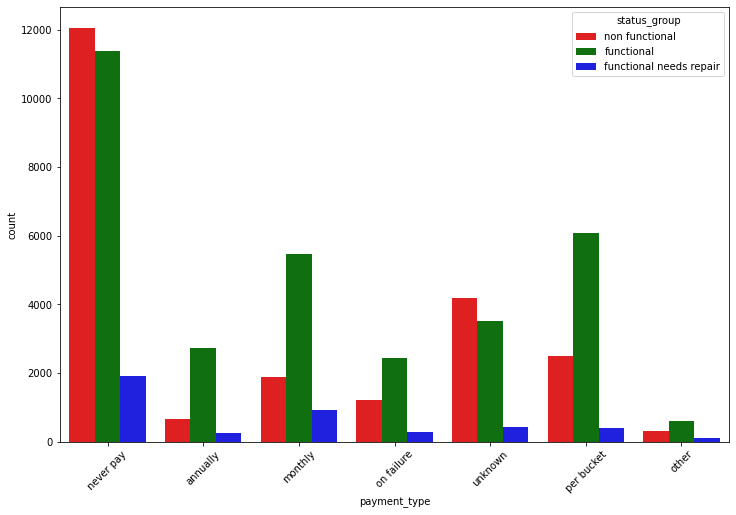

In [111]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(x='payment_type', hue='status_group', data=df, ax=ax, palette=color_status)
plt.xticks(rotation=45)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

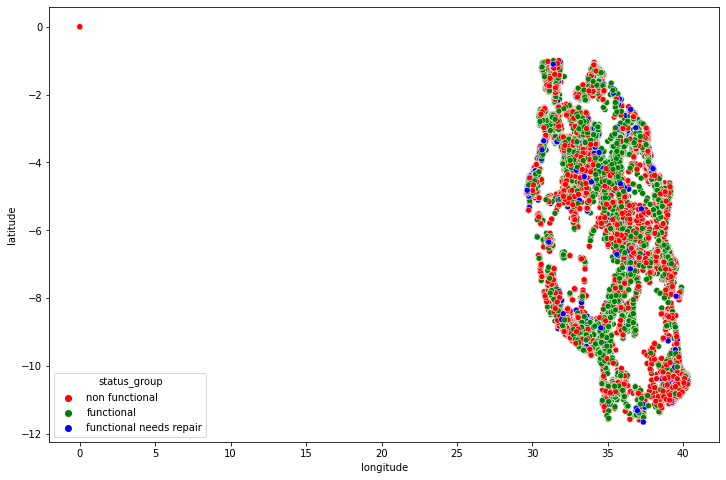

In [112]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x='longitude', y='latitude', data=df,hue='status_group', ax=ax, palette=color_status)

/home/dmmg/anaconda3/envs/Icipe/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/dmmg/anaconda3/envs/Icipe/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/dmmg/anaconda3/envs/Icipe/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

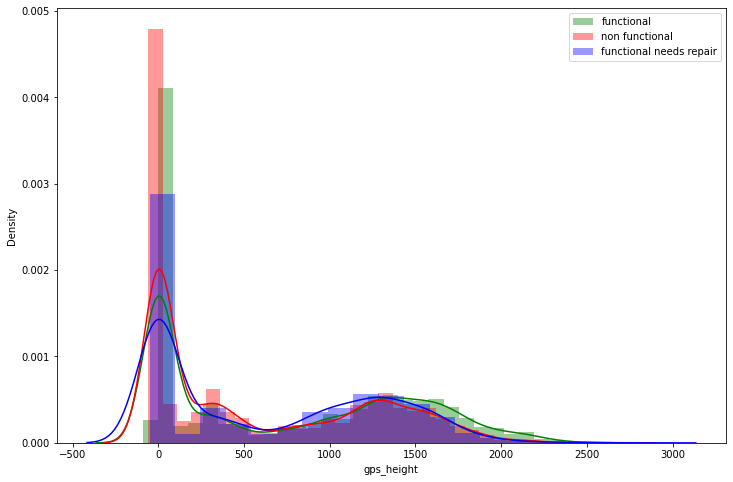

In [113]:
row_functional = (df['status_group'] == 'functional')
row_non_functional = (df['status_group'] == 'non functional')
row_repair = (df['status_group'] == 'functional needs repair')
col = 'gps_height'
fig, ax = plt.subplots(figsize=(12,8))
sns.distplot(df[col][row_functional], color='green', label='functional', ax=ax)
sns.distplot(df[col][row_non_functional], color='red', label='non functional', ax=ax)
sns.distplot(df[col][row_repair], color='blue', label='functional needs repair', ax=ax)
plt.legend()

In [114]:
data.groupBy(col).count().orderBy(col).show()

+----------+-----+
|gps_height|count|
+----------+-----+
|       -90|    1|
|       -63|    2|
|       -59|    1|
|       -57|    1|
|       -55|    1|
|       -54|    1|
|       -53|    1|
|       -52|    2|
|       -51|    2|
|       -50|    5|
|       -49|    4|
|       -48|    6|
|       -47|    8|
|       -46|    6|
|       -45|    9|
|       -44|    6|
|       -43|   11|
|       -42|   13|
|       -41|   11|
|       -40|   26|
+----------+-----+
only showing top 20 rows



#### Above is basic use of Spark for Data Exploration for better Understanding, can work on a guided project in Coursera.